# Example: Parsing OSM Data Directly with Databricks

> Use some Spatial-Utils functions to processing probable routes between NYC Citibike stations in SEP 2024.

__Notes__

* This example was run using DBR 16.0 on a 3 worker cluster (each with 8 CPUs and 61GB RAM);
* Uses 'spatial-utils-v1' branch with extra packages [route,viz].
* Requires a cluster with product `ST_` spatial sql functions enabled for KeplerGL Viz (may require photon cluster + spatial sql flag enabled).
* For the notebook to render well in github, we add screenshots of the map rendering and charts as well as artificially limit tabular results; when you run the notebook in databricks, you can uncomment and remove limits if desired.
* Requires you to download the [OSM PBF file for Andorra](https://download.geofabrik.de/europe/andorra.html) and upload this to a Volume. 

---
__Author:__ Timo Roest <timo@databricks.com> | _Last Modified:_ 25 MAR 2025

## Setup

In [0]:
%pip install -U "databricks-spatial[route,viz] @ git+https://github.com/databrickslabs/mosaic.git@spatial-utils-v1" --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

_Contact us to get spatial sql enabled, if needed; it is in private preview as of this example._ 

In [0]:
%run ./spatial_sql_flag

In [0]:
from spatial.route import pbf_source
from pyspark.sql import functions as F

from spatial.viz.keplergl import *
from spatial.viz.helpers import *

kviz = KeplerViz(spark)

In [0]:
# - CATALOG & SCHEMA
catalog = "geospatial_docs"
schema = "pbf_source"

# - TABLES
geometryType = "WKT"
bronzeTable = f"{catalog}.{schema}.andorra_bronze"
silverTable = f"{catalog}.{schema}.andorra_silver"
goldTable = f"{catalog}.{schema}.andorra_gold"

# - PATHS
pbfPath = f"/Volumes/{catalog}/{schema}/osm_files/andorra-latest.osm.pbf"

# - VARIABLES
h3Resolution = 8

## Ingest OSM Data

In [0]:
(
    spark.read.format("pbf")
    .option("path", pbfPath)
    .option("geometryType", "WKT")
    .load()
    .write.format("delta")
    .mode("overwrite")
    .saveAsTable(bronzeTable)
)

In [0]:
df_bronze = spark.read.table(bronzeTable)


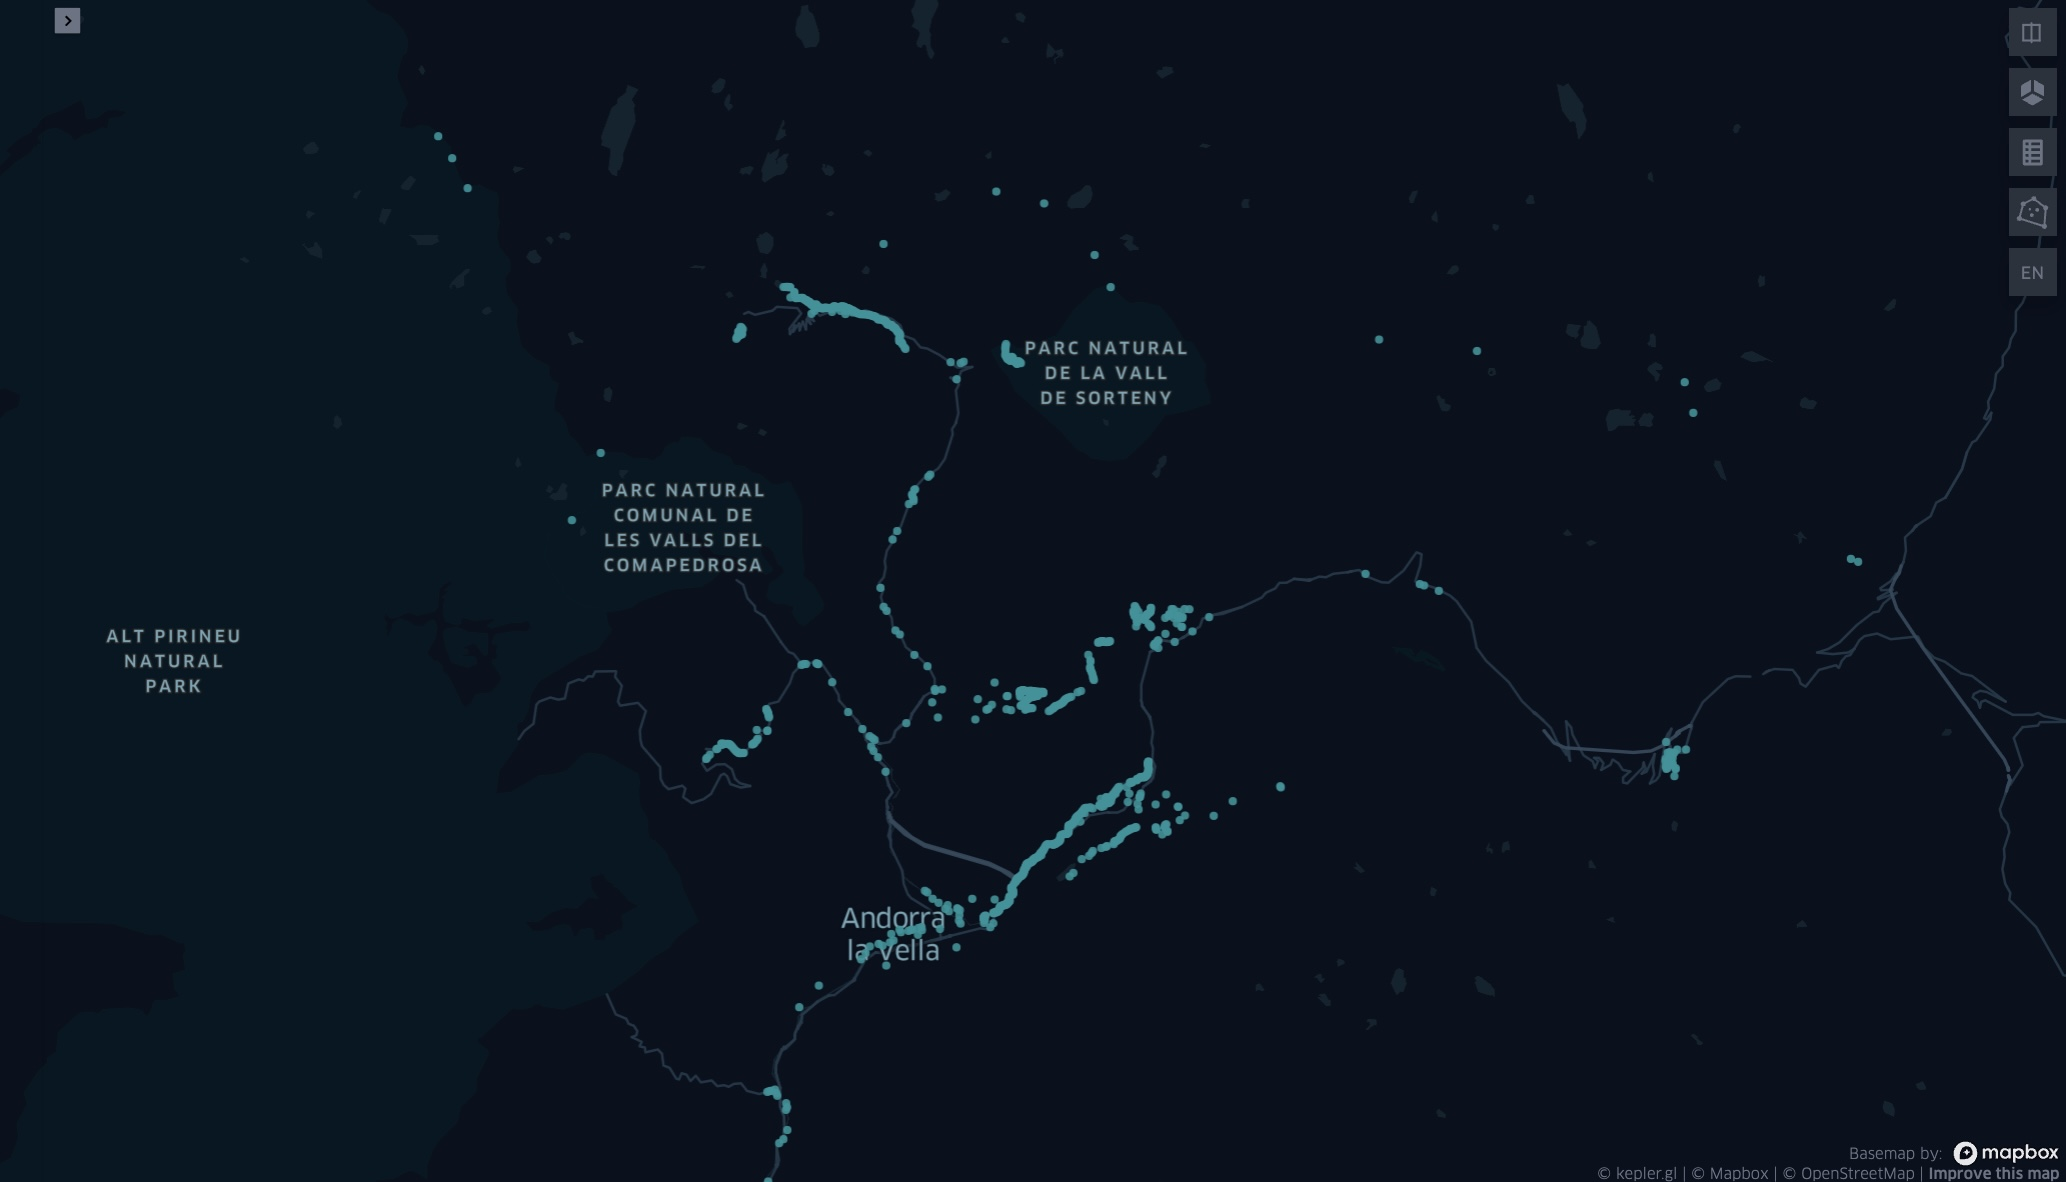

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACBKgAwAEAAAAAQAABJ6kBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g/wSUNDX1BST0ZJTEUAAQEAAA/gYXBwbAIQAABtbnRyUkdCIFhZWiAH6QADABMACQAWAA9hY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAABLxjcHJ0AAAGcAAAACN3dHB0AAAGlAAAABRyWFlaAAAGqAAAABRnWFlaAAAGvAAAABRiWFlaAAAG0AAAABRyVFJDAAAG5AAACAxhYXJnAAAO8AAAACB2Y2d0AAAPEAAAADBuZGluAAAPQAAAAD5tbW9kAAAPgAAAACh2Y2dwAAAPqAAAADhiVFJDAAAG5AAACAxnVFJDAAAG5AAACAxhYWJnAAAO8AAAACBhYWdnAAAO8AAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAnAAAADGhySFIAAAAUAAAB5GtvS1IAAAAMAAAB+G5iTk8AAAASAAACBGlkAAAAAAASAAACFmh1SFUAAAAUAAACKGNzQ1oAAAAWAAACPHNsU0kAAAAUAAACUmRhREsAAAAcAAACZm5sTkwAAAAWAAACgmZpRkkAAAAQAAACmGl0SVQAAAAYAAACqGVzRVMAAAAWAAACwHJvUk8AAAASAAAC1mZyQ0EAAAAWAAAC6GFyAAAAAAAUAAAC/nVrVUEAAAAcAAADEmhlSUwAAAAWAAADLnpoVFcAAAAKAAADRHZpVk4AAAAOAAADTnNrU0sAAAAWAAADXHpoQ04AAAAKAAADRHJ1UlUAAAAkAAADcmVuR0IAAAAUAAADlmZyRlIAAAAWAAADqm1zAAAAAAASAAADwGhpSU4AAAASAAAD0nRoVEgAAAAMAAAD5GNhRVMAAAAYAAAD8GVuQVUAAAAUAAADlmVzWEwAAAASAAAC1mRlREUAAAAQAAAECGVuVVMAAAASAAAEGHB0QlIAAAAYAAAEKnBsUEwAAAASAAAEQmVsR1IAAAAiAAAEVHN2U0UAAAAQAAAEdnRyVFIAAAAUAAAEhnB0UFQAAAAWAAAEmmphSlAAAAAMAAAEsABMAEMARAAgAHUAIABiAG8AagBpzuy37AAgAEwAQwBEAEYAYQByAGcAZQAtAEwAQwBEAEwAQwBEACAAVwBhAHIAbgBhAFMAegDtAG4AZQBzACAATABDAEQAQgBhAHIAZQB2AG4A/QAgAEwAQwBEAEIAYQByAHYAbgBpACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAYwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyNQAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAg98AAD2/////u1hZWiAAAAAAAABKvwAAsTcAAAq5WFlaIAAAAAAAACg4AAARCwAAyLljdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuFAAAUewAAEPXAACwpAAAJmYAAA9cAABQDQAAVDkAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoFn9Ym1iAAAAAAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/bAIQAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBQQEBAQEBQYFBQUFBQUGBgYGBgYGBgcHBwcHBwgICAgICQkJCQkJCQkJCQEBAQECAgIEAgIECQYFBgkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJ/90ABACC/8AAEQgEnggSAwEiAAIRAQMRAf/EAaIAAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKCxAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6AQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgsRAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/aAAwDAQACEQMRAD8A/ifooor9APz8KKKKACmL95qfTF+81JgSAEnAq5/Zuo/8+8n/AHwf8K9l/ZkCt+0R4JDAEf2zafpIMV/UNVxjc6KNHmR/Ip/Zuo/8+8n/AHwf8KQ6ffqNzQSAD/ZP+Ff10JLFIzJGwJjO1gOxwDg+nBB+lSVXszX6ou5/IPRWnrYVdavFUAATyAAdB8xrMrM4wooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIQGG09DS0UAjInt2hORytVq3yARg9KpPYqf8AVnH1rJw7HpUcWrWkZtFTSQSxcsOKhqDtjJPYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKAWIVRyaAOhsvC+q3sSzIFRGGQWPb8M1z7oUcof4ePyr3Owi8iyiixjaoGK808ReH5NNY3sRDQu34rntVuOhyUcTeVmcrRRRUHWFFFFABRRRQAUUUUAFFFFABRRUsDrHMjuMqCCR7UAepeEbQ2+l+awwZTn8O1dTUcTI8SvHwpAx9KkrdI8KpK7uFeP8AidYV1mXyfbP1716jqd6mnWL3Tfwjge/avEpZHmkMshyWOTUTOzAw+0R0UUVmeiFFFFABRRRQAUUUUAFFORGkcRp1PArq5PB2px2xmyrOP4F600iJTS3OSopSCp2kYxSUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoprNtr7o8If8inpf8A16Qf+i1qW7AfG0XhjxFPYLqdvYzPA3R1QkYH07VhuGicxyAqw4IIwRX6D0UnUXYSufJngTRoNJjm8c+IoyttYDMKMMGSX+HGfT+ePSvO9X1e61zU5tVvm3SzNk+3oB7AcCvveim62lkiI07PmZ+e/wBKK/QivhXxY3/FWaoD/wA/c3/oZojK5oYNFFFUB//Q/ifooor9APz8KKKKACmL95qfTF+81Jge7fsx/wDJxPgn/sM2n/owV/ULX8vX7Mf/ACcT4J/7DNp/6MFf1C1rTO7C7H5gfES41f4LftmaWn7PNy+tap44cTeKPDDOzQRQKAv9pGU5FqyjjB+9wFGCFr9P68+8KfCv4feB/Emt+MPC2lxWuqeI5xcajdAs0k7qNq5ZydqgdEXCA5IGSa9BqKNLlud053sfydeOp7eXxBcxxY3pNKGI/wB7gfhXGVqa5/yG73/r4l/9DNZdI8WW4UUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAGARg1k3Fv5R3L93+Va1IVDDaw4qZRNqNZwZgUVYuIPJbjoelV6xsexGSaugooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArrfB9nHcagZpBkRDI+tclXovgeNPJnl/iyB+GKqC1MMQ7QZ3dUNTtftuny2395eMevar9FbHjp2PACpU7TwRxSVteILRbPVpYkxgncAOwNYtc7R7sXdXCiiigoKKKKACiiigAooooAKKKUHBBxnHagD2Hw00zaPD5wxgYH07VvVx+h+J7e72WVwnlScBcfdP+FdhW62PErRalqjzzxtdP5kVmp+XG4j3rgq3vEs5n1mY4xs+X8qwayluetQjaCQUUUVJqFFFFABRRRQAUUUUAKCVIZeCK9P0zxbYTRiK8zCyjGTyDj3ry+imnYyq0VNWZbvrk3l5JcnHztniqlFFI0StoFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKRuFoAhJ7192+EP+RS0v/r0g/8ARa18HtwK+8vCRB8K6YVGB9khwPT5BUT2LlorHRIjyOI4xljwAK29G8M6/wCINUg0XR7SSa5uWCRoBjJPbJwBXrP7M7Ffjl4fI/56yj/yC9eyfC/9oH4u+IfjBpvhfWNX86wnvTE8XkQLlBnjKxhh07GlGCtqZnxtNpGqW9w1pNbyLJGxQrtOQw4xWdX2/wCBvj/8XNX+Nln4S1HV/M0+XUjbtF5EAzGHI27hGG6D1zXyf8QHaTx7rcj9Wv7kn/v61KUUthnIV8I+Lv8AkbNU/wCvuf8A9DNfd1fB3i3/AJG3VR/09z/+jDTplR7GJvo3+1R0VoHIz//R/ifooor9APz8KKKKACmL95qfTF+81JgaWlarqmg6pba3odxJaXlnIs0E0RKvG6HKspHQg9K9q/4an/aS/wCh11X/AL/mvBqKGioya2Pef+Gpv2k/+h21X/v+aD+1N+0kRtPjXVcH/puwrwailyle1l3FLMzF5DuY8knqTSUUVRmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAENxH5kRA6jpWLXQDisA9aymj0sDLRoSiiioO4KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuo8L6vDply0dzxHLgZ7A/SuXooRM4JqzPf1ZXUMhyD0xS1xXg7UfNtGspTzFyP92umfVNMjJV7iIEdtwrdM8adJqXKcJ43/4/Yf8Ac/rXE1t6/qX9p6g0qf6tPlT6CsSsZHrUI2gkwooopGoUUUUAFFFFABRRRQAUUUUAaWkWr3moxQJ/eB+gFe3DjivKvCNza22oN9pIXcuFJwAK7z+3bL+0xpQyXPcY259K1hsedi03KyRwPi/Z/bBCrg7Rk+tctXU+L0YawWIwCq4rlqiW52UPgQUUUVJqFFFFABRRRQAVsWWh6hf2r3cC/Inrxn6Vj10tl4p1KwtVtIljZU4G4HOPwIpqxE+a3unNYxxRU1xMbiZp2AUsc4UYH4CoaRaCiiigAoqWCPzZki/vECtTWdGn0ifY/wA0bfdb1/8Ar0WFzK9jGooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNb7tOprfdoA7n4daHpmt6266mDIttEZlhH/LQrj5f/rV9eaFeLqGiWd+qCMTwRyBB0XcoOPwr4v8AA+q/2N4qsrtjhC/lt6bX+U/lnNfblnBFa2kVtCMJGiqo9ABgUVPgREr+0+R79+zQCfjj4fA/56yf+iXrb+DnhrxFa/HfSbu50+5jiXUGJdonCgfNznGMV4PoOv6z4X1eHXvD9w1peW5JjlTquQVOPqDj6V6/o37Snxk0rVbfUZ9ZlvEhcM0E2DHIB1VsAHB9iKiElazKN/4c+G/EUH7QtheTWFwkI1dmLmJwoXzDznGMV4t4+BHjrWgeMX9z/wCjWr0Cb9oz40yXTXSa9PHuYsEXbsXnOACDwOgB7V47qF/d6pfzanqDmWe4kaWRz1Z3OWP4mlJq1kBUr4N8W/8AI36r/wBfc/8A6MNfeVfBvi3/AJG/Vf8Ar7n/APRhoplw3MGiiitDY//S/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQTypGhBPJGAKxqmnffKW/D8qhrCTPYw9LliFFFFI6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq7p05tb6KcYG1h1qlRQhNdD1TxXaW1zpn2skBo8FT6g9q8rrTuNWvbqyjsZmykfT1/H6VmVUmZUKbjGzCiiipNgooooAKKKKACiiigAooooAKKKKANbQ41k1a3R8Y3CvUtdewTTnOojMfoOue2K8chmkt5VmhO1l5BrUs7qW9vkXUWaZeSFYnGcfyq4voc1ajdqXY7c6RokujSS2CL8yZDn5iMfy/CvL60JtTvZwUZ8KRt2qAFAHYAdBWfSkzSlBx3CiiipNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmt92nUe1AFVulfeHhAk+EtLJ/59IP/Ra18Ikdqr4xxUyRcj9GKK+C/CviKbw1qyXyjfE3ySx9mQ9R/hWp438OQaPdx6lpR36fejzIGHQZ/g/Dt7fSo5NLmd7S5WfcFFfnPRUGvIfoxXwd4t/5G7Vf+vuf/wBGGuYqZRgVrBWFFajqKdtNGxqsOc//0/4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFMkbYhf0FPqtd5EBx7flSexdON5JGRRRRWB7p2fhrRrHUrSdp2Bf7oHdPQ9q5GeF7eZoJPvIcH8KtWGpXemSmW0baSMH0/yO1UScnJp9DOMWm77CUUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipoIJrmVYIF3M3AAoAhoq3dWF5YnbdxNH2GRx+B6VUoEn2CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWrSzub6YW9ou5j26V3Ol+EIXtt2qKyS8jAYYA7dK5HR9Vm0m68+MZU8MvqK7298YafDAGsx5rsOnQD6/4Crikcld1L2ic34i8PW+kwJPal2BODuxgfkBXI1q6jrOoamf9Jf5eyLwo/CsqpduhvSTUbSCiiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQMMGvdNJ+CP8Aa2k2uq/2n5f2mFJdvk5xvUHGd46fSvCz1r7t8If8inpf/XpB/wCi1qZOxfQ8V/4UB/1Fv/IH/wBsrsNO+Fn2fw5ceGNSvvtNvId0X7raYn9R8x/Lj9a9corNTaM3FM+c/wDhQH/UW/8AIH/2yj/hQH/UW/8AIH/2yvoyilcq586D4Af9Rb/yB/8AbK8L1ew/srVrrS93mfZpXi3YxnYxXOO3TpX3/Xwj4v8A+Rs1T/r7m/8AQzWkGVHYxAo9KMD0pAeOlLn2qyD/1P4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNZQ6lD0NOooBGAVKnae3FJV28j2uJB0NUq52j3ac+aKYUUUUFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFSwQS3MqwQLuZuABQBoWei39/atdWihwhwR36VnSwywP5UylGHYjB/KvZdDsH03TY7aXG4cnHvXO+MdQt1iWwVVaQ8k91Ht6Zq+TQ46eJbnypHnFFFFQdgUUUUAFFFFABRRRQA5V3MFHfj0r17QdDg0qASHDyuOW/oPavIUKq4LjIHUdOK9ITxnp0dsoWF9wH3RjAx2z/wDWq4WOTFRk1aI7xrPssY7fH32z9NteZ1palqFxq9558g68Ko7DsBVS4tp7SXyLldjDHFKTNaEOWKiQUUUVJsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBq6Tph1W4NsjhG25XPfHatm28HajJcmK5IjjX+Mc5+g//VWX4dn+z6zA2Orbf++uK9mq4xRxYmtKDsjxDVNOk0u9a1k6DlT6r2rOr2PX9IXVbPauBKnKH+n4148ysjFGGCOCPSlJWNsPW50NoooqTcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQ8ClprfdoAgPAr7u8Hf8AIo6V/wBecH/ota+D36V94eDv+RR0r/rzg/8ARa1E9i5dj3b4P/CzUvi94vHhbTrhLRUiaeaZhu2RKVUkLkbjllAGRX6NX/wM+Hvwr+E3iafw9a+Ze/2Peq15Od8xBgfIBwAg9lA96+Vv2JXSP4p6i7kKq6RMSTwABPBX0X8VPj5o/iq11D4TfCu0k8RanqdvLatJb4MEayIUZg/RtoPUfIP73atqKio3Zi9yt8G/hV4K+KP7OGh6b4qtQzgXIjuYwq3EX+lyn925BwPbBU9xXxn8d/gbefBbVbOP7at9ZaiJDbvt2SDytu5XXkcb1wQefQdK+pfhZ8Xbz4D6JZ/C74v6Lc6ZDatIIb+MebEwllkf5go6Z3YKFiQB8veuP/bR8Q6F4o03wlrHhy7ivbWT7dtkhYOuf9H446EdweRRNRcPNAtz4Qr4P8W/8jZqg/6fJ/8A0Ya+8K+DfFv/ACN2qj/p7n/9GGsKZrDcwaKKK0K9mf/V/ifooor9APz8KKKKACmL95qfTF+81JgPooqKSaOL7x/CgajfREtRSTRxcMefQVny3btxH8oqpUOfY7qWC/mN2ORZUDrT6zrFjlk7YzWjVRehy1qfLKwUUVE00UZ2u2DTM1FvYloqAXMB4DVKrK3CkH6UXQ3BrdDqKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQzx+ZEV/KsWta6l8uPaOrfyrJrGZ6mCT5QoooqTsCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9f8N6fbWmmxTxr88igs3f/APVXM+FdCt7uP+0LxdwBwinpx3r0cAAYFaQiedi6y+FBXiOrLdpqMq3pzJu5P8sdOPSvbq8n8XSs+sMjAAIoAx9Kc9icE/escvRRRWR6YUUUUAFFFFABRRRQAUUUUAdV4RskutRMsoBWIZx79qq+J5Vl1qUr/DhfyFQaHqr6TeCUco3Dj2/+tWv4q1i01B0t7UbhH/H/AEFX0OezVTyOPoooqDoCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkhkMUqyrxtIP5V7zG6yxrInRgCK8Cr2fw/ci60iF8jKrtOO23j+VXA4cdHRM2a878W6KVb+1LZeD/rP6HFeiVn6s4j0ydyNwCHj8K0aOOhNxkrHh9FFFYHtBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTW+7Tqa33aAKz9K+8PB3/Io6V/15wf+i1r4PfpX3h4O/5FHSv+vOD/ANFrUT2Lmd5oV9aWWoKNTNx9imxHdJayCKR4sglQSrL1AOGUjIFfrr8Adc+CeqaE9t8JIUtGiVTcQum26GenmMcl/qGZR0z2r8cauafqOoaRex6lpU8lrcQndHLExR0PqrLgj8KKVTlM2j9uvih4o+G3h3w5KvxKlt/skqMBBKA7yfKVIjT7xODjI6Z6ivxn8cXvg3UPEtxdeArKfT9MY/uobiTzGA9f9kYx8pZ8f3j2yNb1/XPEuoNqviG8mvrlgAZZ3MjYHQZbsOw6CsinVq8woxsFfBvi3/kb9V/6+5//AEYa+8q+DfFv/I36r/19z/8Aow1NM0huYNFFFaGx/9b+J+iiiv0A/PwooooAKpy3KwsVHLenpU08oijz37Vgj/WGs5s7cLh+bV7Fx7mZ++B7cVXoorM9GMEtgooooKLVo4SXngEYrRM0K9WH4f8A1qxKKpSsc1XDKTuX5rv+GH8/8KpxxvKdqDNNCluFGav2K/eb6CluEkqUPdIxZSkc4FXIbdIeeretWKK0UEefPESloFFFFWYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRQKAMe6YNOcduPyqvU0qS7i7qRzUQBY4UZrnPcp2UUJRVtbKYjJwKY9tMg3EcD0p2Eq0NkyvRRRSNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyI0jiNBkscAU2uj8L2X2vVVZh8sXzHjj2ppEzlZXPUNNtFsbGO1X+BRntzV2iitzwmwry/xpGiakjqOWQZ/DivUK8n8WX32rUzCh+WEbfx71Mtjqwa985eiiisT1QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK6Pw1DD9sa+uSFjtxuP9KaRMpWVznKKlnZHmd4xhSTioqRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXReHdYOlXe2U/uZOG9vQ1ztFCJlFNWZ78rK6h0III4I6YpSoZdp6HivG7TXtVtzFGkp2R8Be2PQ/54r2UYIyK2izyK1BwPD9Usm0+/ktSMBT8v07Vn10HiiRpNalDfwYUfTFc/WUlqetTfuoKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFXLCym1G6S0t8bm9egArU1rQJtGCOXEiPxkDGD6Yp2Jc0nynP0UUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkI4paKAKzDIxXumj/G/+ydItdK/szzPs0KRbvOxnYoXOPL46dK8NPBqBhg0mi33Por/hf/8A1Cf/ACP/APa6P+F//wDUJ/8AI/8A9rr5zorHlGuU+jP+F/8A/UJ/8j//AGuj/hf/AP1Cf/I//wBrr5zoo5R2ifWdz8W/s3hS28THT8/aJTEIvN6Bc87tnt0xXzFqt/8A2rq11quzy/tMzy7c5272JxnAzjPpXeeJFMHw40C2/vtM/wD48f8AGvNAMDFdDilsY0He7FoqULx0o2j0pFXP/9f+J+iimsyoNzcAV+gH5+kOqCS5ji9z6CqE108nyrwtVazc+x6FLBdZC8sfUmr1vZqGLS8n0qrC/lyB/StdCCSR3x/KpiisXVlHRD1VV+6APpUUkEcv3hz6ipqK1seepNO6MiW1kiG4ciq1dB7VUWzjD7jyOwrNw7HdSxmnvGekEsgyg4qzHZMeZePYVpdOBRTUDKeMk9hiRpGMIMU+iirSOVsKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACip7e2mupBDbrub0FOurO4snEdyu0kZHTp+FAFaiiigAooooAKKKKACiiigAooooAKTAzmlooAKKKKAPtb9n/APYU8V/H3wcfHv8Aa8Oi2MjvHb7oTM0xjO1jtDIFUMMZyenSvlP4ufC3xF8GfH9/8PPFBRrqxK/PFyjo6hkZc4OCpBx2r7b/AGbP26rj4F/D9fh5rOg/2tbW0jyW0kU4hZRIxZlYFHB+YnBGPTFfInx3+KGqfG74kah8SdTt0tZLzYqwIdwSONQiLnAyQoGTgZ9K6sRCh7KPJ8R85kGLzj+06sMYl7D7O3y89t7/ACPFaKKK80/QwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvUvB9l9n043LDDSn07DpXltezeHZXl0eAuu3C4/Ad6uByYx2gbVFFFanlFPULoWNlJdH+BePr2rw6R2lcyPyTzXonjW+KQx2CH7/AMzfQdK84rKb6Hq4OFo3CiiioOsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvV/D2kwpowjukB875iD+leVIVVwXGQDyOnFddfeL7maAQWKeQMYJzk/QccVUbHPiISlZRMTW7YWmqTQquxQ3ygenasqlJJOTSVJuloFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopxRwocjAPQ9uKbQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeyW2pQW+gx37n5VjH5jjH5143V6bUbieyisHx5cOcY96qLsY1qXPZEV5dSXty91N95zmq1FFSbJBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAbOhalFpV+LmZdy4IOByPp0/wD1Uuu6qNWvfPjBVFG1QaxaKd9LEezV+YKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBC3Wvuzwh/wAinpf/AF6Qf+i1r4Rr7u8H/wDIpaX/ANekH/otaiexT2OiorqvA/hv/hMfGOl+FfN8gahcxQGTGdgdgCQO+B0FfaFr+yp8Jri+v9ITxdK91pKb71BGg8lVHJbPQfjUxpt7EXPgWivsb/hTf7Nn/Q//APji/wCFeOfHP4X2nwj8bjwtY3bXkT28c6u6hWG4ldvBwfu9ePTtRKm0rhc8cr4R8X/8jZqn/X3N/wChmvu6vhDxd/yNmqf9fc//AKMNOmXHsYwoqINRuHpWhJ//0P4nmYIpY9BWNNM0x54A6CtkkKNx4ArFmdXkLIMCvvJnxuCir7EVKAScCpI4ZJThB/hWnDbJFz1NQonXVxEYBDbrDg/xYxUq/ean0xfvNWtrHkSk3qx9FFFUSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU+NVeRUY7QSBn0plFAHqtlZ29jAIbccevc1neIIbd9PLzHBT7vTr6Vx8Ws6lDEIY5MKowBgdPyqrPe3d1/x8SFh6dvy6UAVaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilUbiF9aAMm7jVJAVGMiqlfvlpf/BOn4FXnw2hsL1bl9Zltg39pCdwVlZc5EQPlbAe23OO9fg1qVp/Z+oT2Gd3kyNHn12nFaYvBTo25upw8K8X4TNFOGGveG9191vuKVFFFcZ9cFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXRaf4n1PT0WEESRrgBWHQexFc7RTTsTKCejPb9K1BdUslu1XZnjHXGK0a5/wxEYtFiDd8n861NQ3CwmKnBEbfyrZHiziuayPItcvft+pyTg/KDtX6DpWRRRWDPbjGysgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFa2h2X2/UooCMqDlvoKEhSdlczYopJnEUKlmPQAVbv9NudNZI7rAZ1zgdvrXskNlZWbSXEaBC3LN/noK5J9HfxBqZ1Gb5LbovqwHp6A1fIckMUn6HnNFdR4mh0yznWx0+MKU5Y5z+FcvUtWOqErq4UUUUigooooAKKKKACiilUlSGXgjpigDRfR9TitPtskLLF6/8A1uuKza7GLxhdixa3nQPJjCt7e4rjycnNNpGcHL7QlFFFI0CiiigAooooAKKKKACiiigAooooAKcqM52oMn0FNrutHuNBtNIkkZgs7KVO772SO2O1NIipLlWxwtFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQcEHGcdqSigDsrbxjNDD9ne2jKAYULlQPw5rlbm4N1MZiqpn+FFCgfgKr0U7kRpxjsFFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApG4WlprfdoArtwtfd/g7/kUdK/684P/Ra18Hv0r7w8Hf8AIo6V/wBecH/otaiexcz3b4H/APJX/Df/AGEIP/QhX6haffWEvinxcjeC5bd4bd992IiF1Ndv+rU+WNxbAGBur8vfgf8A8lf8N/8AYQg/9CFfrDZ2HxMGv+IrifXbWTT5YWXTYgiBrOXHBkxHyAf7xbp0rbDrQwkfKn/CQaB/0RC7/wDARv8A5Hryz9tD/kr8X/YOh/8AQ5K+lf8AhHf2pf8AoftJ/wC/MH/yPXzV+2h/yV+L/sHQ/wDoclFRe6OLPkmvg7xb/wAjbqo/6e5//Rhr7xr4N8W/8jfqv/X3P/6MNYUzWG5g0UUVoaciP//R/iIuJzKcD7op1tbeZ87/AHf5063td3zydOwrTAwMCvu1G58fWrqK5ICABRtUYApaKK1PPCmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfTdr+2J+0VY+CP+EBtPELrZCD7OreVEZxHjG0TFN/TjOc+9fIzszuXc5J5JNb1Y91HsmOOh5pVqkpW5mXk+Cw+HclRgo37JK/3FeiiisD3QooooAKKKKAL8el6jLAtxDC7o3QqM9PpVJ0eNtkgKkdjxXZW3i57TTI7WKIGVBtyeFAHTgdePpXL3moXmoSeZdyFz29B9B0FPQyg5X1RTooopGoUUUUAFFFFABRRRQAUUUUAe36RGYdMgjYYKoBVDxLe/YtJfacNJ8g6d+v6VV8O69De2y2906rMny4OBu9MVxXiPULm71CS3lb5InIQY6Vs3oeZToN1NTnqKKKxPTCiiigAooooAKKKKACiiigAooooAKKKKAFAzwK1IdD1edS8du+AM8jH5Zx+la/hS/wBPsLhzeHazDAOOAB/n0rrn8VaUbaWWB/nQcKRjPpiqUTmq1ZJ2ijyh0eJzHICrDgg8Yr0PwXYbYXv3HLfKv0FefzzyXMzTzHLOcmvWfC8qS6NFsXbt+X8u9OC1Fi5NQOhx2qG3iMEKxFt23vU3Ssi513SLVC7zocdlO4/kK1PLjFvRHD+M7ZYtQS4H/LReRx246Vx1aGp6hLqd411J0P3R6DsKz6wke1Si1FJhRRRSNC3YWovLuO1J27zjIGcfhWw/hjUSsklriVY2KjHBOO4FY9jeS6fdJdQ9UPT1HpXstnqdjeQiWGRPu7iMjK/X0q4pHLiKko6o8RdHjYo42kcEHjFNrW1ye0udUlms+UY9fU98e1ZNQzpi9AooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKBk4FACUVu6roVxpMEUs5BMnUDop7CsKixMZJq6CiiigoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmt92nU1vu0AVn6V94eDv+RR0r/rzg/9FrXwg/3a+7/B3/Io6V/15wf+i1qJ7FzPVfh54jtPCHjrSPFF+jSQWF3FNIseNxRGBO0HAzjoCQPcV912/wAZ/wBme01jXddgk1AXHiKJobw+W2NrDB2DotfnFRShUcdjOx9jf8YX/wDUW/8AH68v/aJ+JGg/FH4h/wDCReG1lFrHbR26mVQpYoWJIGTgfNgfSvCaKTnpYYV8G+Lf+Rv1X/r7n/8ARhr7yr4O8W/8jdqv/X3P/wCjDTplQ3MCiiitDW6P/9L+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVLDBLcOIoFLMewpjI0bFHGCOCKAG0UUUAFFFFAG1pGkvqEm+TiJevv7Cut1W209dPxcLtVB8uOD9BWfpmuabDaJA/7oqMHjj9KxNb1QX8wjhP7pOnbPvQMw/pRRRQIKKKKACq1zD5qZXqKs1qaIunPrNmmrnFoZoxMR2j3Dd+lFug1UcPeXQ4uiv6fvHfhn4Ot+z5e2V9bWC+HU0xmi2qgiH7v5GQjjdnG0jnNfzRSQ20czfZlG0E7fp2roxuXui0rng8J8cxzSNSSpOPK7f1ovuOeorUmtFf5o/lP6VQeCWP7w4rgcbH29OvGWxFRRRSNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr0DQvEOm6fpPkzZDxn7o/iz6dq8/opp2M6lNSVmb2reIL3VTsJ8uLsi/19awaKKVyoxSVkFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUsMMtxIIYV3M3AAoAiorUv9H1DTQrXUeFYdRyB7Vl0WEmnsFFFFAwoop8aNI6xoMliAKAGUV+tGh/8ABMVtV+HMOuzeJWTWri2E6QLADbhmXcqFt2723fpX5S6np9xpOpXGlXePNtpGifHTch2nH5V0V8LOmlzo8DJeJ8DmEpxwk78m+lijRRRXOe+FFFFABRRRQAUUUUAFFPSN5GEcYLE9AK9I0DwxDDD9o1NA7t0Ruij6etNIzqVVBXZ5pRXV+K9Nt7C7RrVdiyL0HQEelcpQ1YqE1JXQUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoqeC1ubptltG0hHZRn+VNmglt5DDOu1l6g9qBX6EVFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApynawYdqbRQB12r69BrOlrG48uaNgdvY8Y49K5Giim2RCCirIKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFHtRRQBXI7VXxjirLDBr3TSfgj/a2k2uq/2n5f2mFJdvk5xvUHGd46fSky+h4FRX0Z/woD/qLf8AkD/7ZR/woD/qLf8AkD/7ZWNkNTPnOivoz/hQH/UW/wDIH/2yj/hQH/UW/wDIH/2yiyHznC+GwLD4c65qPedo4B+fP6NXmajAr6xPwnA8IL4Ujv8Ab+/89pfK+9xjG3fx279q+YdXsP7K1a60vd5n2aV4t2MZ2MVzjt06V0NqySMKSabbKG00bGqUKPSjA9KRR//T/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdXDqFrYaMFs2HnHg8YIJ/LpXKUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWTeXbW4tGlcxDomTtH4dKrUUUCSCiiigZj3SbZjjvzVerV4f32PQCqtYM9yj8CCiiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBc0/P26IKof5h8pGR+Ve0W2n2No5ktoljLddoxXhdXpdS1CaIQSzOUAxtzxj6VcZWOevRcrWZ2fi3Whg6VbYP98/0rz6iipbNKdNRVkFFFFI0ClVijBl4I6UlFAH6K6T/AMFJPi5pXw/j8HrpdjJeQ24t4787wwULtDGMHaWA9wPavzzvbu41C8lv7tt8s7tI7erMck/nVaitquInOyk9jx8ryDB4Jylhaajzb2CiiisT2AooqzZNbx3kT3a7oldS4HdQeR+VAmaa+GfEjaT/AG8un3JsR/y8CJ/K/wC+8bf1rDr+mTR/jJ8AV+CEF++s6YujJpyxvbmWMEAR4MXlZzuzxtxnNfzX63LYT6zdz6Uuy1eaRoVxjEZY7Rj2GK7sZg1SSs7nxXCHFdXM5VY1aDp8jt6/gtjLrT0nTZNUvFtk4X+IjsKzK9C8EyWwSWIlRKSMDuRXFFH2NafLG6Or07SLDS022qc92PJP+fatOis/UtSttLtjcXB9lXuT6CtjxtZM5DxvOmILbHPLf0rz6r2o382pXbXc+ATwAOwHQVRrGTPZow5YpBRRRSNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKswWd3cqWtonkA67VJx+VVq9g8LrAujReR3+99aqKMa9XkVzyJ0eJjHICpHY8Uyr+qLIuozCY5bcaoVLNVsFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPV9BtodH0Q3kh5ZfMY+2OBXl9zO91cPcP1c5rSbXL1tMGkkKIxxkZzj88fpWNVN9DClSs22FFFFSbhRRRQAUUUUAFFFFABRRRQAUUUUATQQSXMy28IyznAFdfrPhi303TBeRuxddoYHGOeOOBXMabfPp14l5GM7O3TI9K6TUfFo1Cze0NsFDjGS2cfoKpWsYVOfmXLscbRRRUm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUh4FAEJ6192+EP+RT0v/r0g/wDRa18IHgV93eDv+RR0r/rzg/8ARa1E9intY6Otnw/oGq+J9Yg0LRIXnuLhgiqis2M8ZIUE4HfjgV7p+zH4Z8C+KPHlza+PbU3VtbWMtyi/N5YMZXLOE5IC5wOme3SnePfjPFpV9e+FvgmkOiaEW2iezRkuLlcdZJZAJQM5wvy4HHNSo6XZFzK+M3wE1z4M2unXepXkV6l/vXMSlRG6BTg565ycey9B0rwWva/B3xu8S6Uw0XxuzeI9Bm2pPY3zecAgG0GFny0TID8uwgdPQY7if9nZvHdnN4v+B94mp6Ud5+zTnyrqB1wfIYH5WOD8pyAR+GW4p/CB8uV8I+L/APkbNU/6+5v/AEM194OjxuY5BtZeCDxjFfBvi3/kbNUH/T5P/wCjDRTLj2MUHjpS59qgorQk/9T+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB0+laFFfWJnlYqzH5cdMDjpWDdW620xiSRZAO69KfFfXMFs9pE21H61ToGFFFFAgooooAKKKKACt/w5bCa+8xhlYx+vasCut8N3VnAjxykLI7AD3HagaNXVodOs7F5PIjBPyrhQOT+Fee10XiO88+7+zr92Lj8e9c7QIKKKKACiiigAooooAKKKKACiiigAooooAxrn/XtUFXb1MOHHcfyqlWDPbou8FYKKKKRqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdPoPh+LVgZJpgoH8C43/l2FcxRTRMk7WRcv7aO0u3t4pBKqnAYVToopDQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnI7RsHQ7SOhHFNooAe8jyNukJY+9MoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK3rrRJbPSY9Ql+87fd9FxxWJG/lyLIP4SD+VdzrHiCw1bR2iTKSgr8p/oaasZVHJNWODooopGoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU1vu06mt92gCs/SvvDwd/yKOlf9ecH/AKLWvg9+lfeHg7/kUdK/684P/Ra1E9i5n1T8N2PhX4OeMfGr4V9QWLRLY4AyZvnnXJ/6ZAcLn3AGDXFfCVfGep+I5vBfgbyftXiG1lsJPOC7fJK+ZJ8xB24VM5HPHAzivoAftBfCXVfhRpvwy8T+Hrl4rdYVm+zGOIBolH72M5J3sQQc4yCctziuD03wB8PNZvoNS+EXjT+zdQU5ht9V3Wc6OfuhbiL5C2OPl/iAH8Qw7bWMzGsfGuv/AAZ0jxT8ItX0q0nuNQDW80xbe0RKbcqVJVgAdyjgq3Xpgdd8BvGHiXwt8NfHd3o920CWtpDJGFAJSeV/LDrkcfLwfw9BjzLxn8Hvi5oDy614k0y5uYn+dryI/aY3B6OZELcNxgtiuj8Dk2f7P/jmdul5caXbjg9Y5Wk4P0/zyKUW0xHz/Xwb4t/5G7VR/wBPc/8A6MNfeVfBvi3/AJG/Vf8Ar7n/APRhpUzSG5g0UUVobH//1f4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoJByOMUlFACkljluTSUUUAFFFbWnW+kXeIblnik6DkYP/jvFAGLRXef8ItYf35PzH+FH/CL6f8A35PzH+FIdjg6K6zU9BtLKza4iMjEY9MD9K5OgQUUUUwCiiigAooooAyrxszYHYYqpU1wMTt9ahrnZ7lFWggooooNAooooAKK6LTPDV7qdqbqJkVf4Qe+Pp0rGjijjuhDeZRQ2HwOR+FOxCmtkVqK9jsZvD8zm0sRETtGQFAyPy5rzjxFDaQatJHZgBRjIHQHuBTcbGVKvzPltYw6KKKk6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK1dH0yXU7oRouUXBfGOn4kV6tY6Lpunhvs8Y+bqTycen0qlE56uIjDQ8UortPE+gQ2K/b7TCoTgp6H29q4uk1Y1pzUldBRRRSLCiiigAooooAKKKKACiiigAooooAKKdscLvIO317U2gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKUDJAFACUV6Do3hWxmh867lWYnjEbfKPxHesvX/DcelRC5t5CyE42t1H4j/Cq5TFYiN+U5KiiipNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDpvC1/aWN832z5VkXaCeg+tVNfuLG51Evp6gRgAcDAJ9axKKd9LGfs1zcwUUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprfdp1IRxQBVfpX3h4O/5FHSv+vOD/wBFrXwiwyMV7po/xv8A7J0i10r+zPM+zQpFu87Gdihc48vjp0qJrQuR9O0V85/8L/8A+oT/AOR//tdH/C//APqE/wDkf/7XWQuRn2J4U+JXj3wNIr+FNWubJVwfLR8xHBzzG2UPJPVe9fSd7+1PZ698ItT8G+JtKE+s38bxGeNESB97E+YwXBDpnK4BBYZ4r8wfD/xnfXtattHj0vyzO+3d52do7nHljoKj1z42po+sXGlR6b5wt3Me/wA7bkrweNhxWkZSS02Isr8p7vXwb4t/5G/Vf+vuf/0Ya9m/4X//ANQn/wAj/wD2uvCdVv8A+1dWutV2eX9pmeXbnO3exOM4GcZ9KII0itSjRRRWhXOj/9b+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkSxtIFlbYp6nGcfhUdFAFqe0lin8lVJ3cp3yO2Mf0roYtA83ShJsK3HXB9PTH0pmgastufsdyQE/hJ4x7fSu2R0dQ6EEHoR0oGeRYxxSVr66oTU5Aox0P6VkUCCiiigAooooAKKKKACiiigAooooA7W28S2kduiTK5cAAkAf41P/AMJRp/8Ack/If41wdFAHR6h4hmulMNuoSM8c8kj+QrnKKKACiiigAooooAKKKKAMu9XEob1FU63JYllTa1Yro0bbG7VjJHrYSqnHl7DaKKfHG8riKMZLHAFSdQyivUrDwhpsMSteAyvgZGcKD7YxXn2qafLpt49tIuBn5fde1NxsY068ZOyLWja3caRKSnzRt1Ttnt9KyZpnuJmnlOWY5NRUUjRQSdwooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA6rwhdeRqvkk4Eq4x7jpXq1eD2lw9pcpcx9UINenW/jDSJeJd0XHcZH/juf5VpBnn4ui27pDPGUiLpQjJwWcYH0ryyt7X9Y/te63RjbEnCj+tYNTJnVh6fLGzCiiipNgooooAKKKKACiiigAooooAK3fC/9lDxLpx13H2H7TD9oz08reN//juawqKaJnG8eU/p5+JVz8H/APhnq/e9aw/4Rs6awt/ueT/q/wB0ExxuzjGOc1/MTJs8xvL+7nj6U3Jxt7elJXbjcb7a2lrHxnBnB39kQqR9q58zvta35hRRRXCfahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFfpX+yD+xF4Q+O3gKb4g+PNSvLeB53t7eGxMaN+7xuZ2kST8AAK+Wv2nfghB8APipceBbG8a+tPKSeCSQAPsfor4wMjHUAD2rqng5xpqo9j5vB8V4Kvjp5dTl+8jvppp/kfPNFFFcp9IdR4Vh06bUALw/OP9Wp+6T/ntXb+ItJuNVtFjtmAZDnB6GvIQSpBXjFdG3ivWiiokgXbxkKCT+eauLRy1aMnJSiYM9vPayGG4Qow7EYqGrV3eXN/N9oum3PjGcAdPpiqtQdK21CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQHg1AwwasN1r7s8If8AIp6X/wBekH/otaluxXQ+CaK/RiisroFI+M/hHaNc+OLaQdIEkc/98FR+pFcPrlyL3Wry8XpLNI4/4ExNfoJRV8/u8pnb3uY/OgDPFTAYGK/RGvhHxf8A8jZqn/X3N/6GaqLNY7GEF46UbR6U8UVRB//X/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB1NqdAurQ28i+Q/XJOfyP9K5mRUSQrGdyg8HpkUyigAooooAKKKKACiiigAqxb3VxaNvt3KH2/wAKr0UAWLm5lu5fPn5YgD06cVXoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilALEKoyTwBQAlFa1zo13Z2wurgqo4G3v/ACxWTQAUUUUAFVbuNWi3d1q1UNx/qG+lJ7GlF2krGLVi1uZbO4S5h+8hyKr0Vge5Y9k0zXrDULcSF1jcD5kYgYx/SuZ8X6nYXNvHbWzJK2c5XnaPr71wNFXzaHLDCKMroKKKKg6gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACitbT7zTrP5rm189vd8L/3ztrTTUvDkzk3NhsGM/K56+mBgU7Gbm10OWoqWZo3lZoV2KTwvXAqKkaBRRRQAUUUUAFPEchQyhTtHGccUyvUV0WFPDLW3G4r5hb3HP8A9aqjEyqVFGx5dRRRUmoUUUUAFFFFABRRRQAUUUUAFFFW7Gzmv7lLWAZLfoKAKlFdv4h8PWWnaelzbEhlwrZ/i9/auIptWIpzUldBRRRSLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPqf4Eftf/Fj9n3SLjw94SWzvNPnfzPIvY3dUc9WQxvGRnuM4rx34qfFPxf8Y/GVx458bTLLe3AC4jXbGiL91EXnCjtya86orWVebioN6HmUclwlPESxdOmlN7u2oUUUVkemFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUAdhXpeg+GLZLYXGpxh5G5Cn+EfSmkZ1aqgrs80ord8R2lpZ6o8NnwuASB2PpWFSsXF3VwooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSNwtAEFfd3g//AJFLS/8Ar0g/9FrXwe3C193+Dv8AkUdK/wCvOD/0WtRPYuXY6OivU/gp4U0fxv8AFDSfC2vqz2d27iRUbacLEzDBHTkCtrxndfDWPRrm10TwlfaZd5CxXM927opDDPyGNQcqCBz/ACqFHS5meJUV9N/E34L6To3w30Px94PYyMdPsptVgLbmia6jDJMB2R23L6AgY7480+K3hXSPCWr6bZ6MrKlzpVldOGO795NEGfHoM9u1OVNoaPL6+EPF3/I2ap/19z/+jDX3fXwd4t/5G3VR/wBPc/8A6MNOmVHsYYajcPSmUVoHIz//0P4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD4opJpBFENzNwAK9A0rRIbHE0vzS+vYfSsbSZrPSoEuLkZeboRj5R+ddZcXtraJvuHCjt/9YUDPO9R1G5vpT5pwo6KOgrNpzkFyRTaBBRRRQAVl3cpZ/KHRa1Kx7oYnNRPY68GlzFeiiisj1QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFXGRu6e1d7JrWly+HW0+KQ+YqBQGGCcY9Mj9a4GimnYidNO3kFFXtNlt4L6KW7GY1YE4r9Lv2VP2Q/Cn7T323WvFd/Pa6fYssSmyKLK7EbvvOrqFA/2fyrbD4eVSXJA8nPM9oZdQeJxOkEfmHRX9EVx/wAEo/2cJbXyYNR16KQDiQXNuTn3BtsflivxU/aR+Cdx+z98WtQ+G0t19tittkkM+3aWikG5dw6BsdccV04rLKtGPNPY8LhrxBy3NaroYRvmSvZq2h4RRRRXnn2wUUUUAFFFFABUsM0tvKs0J2svII7VFRQBp3usalqMYivJN6ryBgD+QFZlFFAlFLRBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKeqO/CDNAm7DKK/ST9kX9h3w78ePBM/j3x1qd1aWpma3t4bExq5Mf3mdpEkGPQBfxr5g/ab+By/s//FGfwLbXhvrUxJPBK4Cv5b9A4HGRjtxXTPBzjTVRrQ+cwfFmBr42eX0pe/Hy00/yPnqiiiuY+kCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB8cjRSLKnVeRwD+lbsnifWpYDA0uM/wAQAB+nFc/RQmS4J7oUksdzck0lFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVuwtHvryO0T+Mgcdh/wDWqpWrol0LPVYJyQAGwSegB4P6U0TLbQ0Nc8OnR4/PEm9GfaoxzjHeuaruvFmr2F7AlpaPvZXySOnTHX/CuFpyt0M6Dbj7wUUUVJsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNb7tOprfdoArP0r7w8Hf8ijpX/XnB/6LWvg9+lfeHg7/AJFHSv8Arzg/9FrUT2LmfRf7PGqaZonxk0PVNZuYrS2ikk3yzOscagwuBlmwBzgV2XxH034hah4duZvEfjvStZs4GEwtI9TWeRiDgbI8ckA/lXzLRUqWliLH1bq/xS0/wp4s8L39q8Wp6Y/hmw07VLWN1dXjMZWWFsH5ZE6gHBBGDxXGftE3/he/8cWn/CHXiX2nwaZaQRSIwf5Y02gNjowGNwIBB7CvBaKbqXVgsFfBvi3/AJG/Vf8Ar7n/APRhr7yr4N8W/wDI36r/ANfc/wD6MNFMqG5g0UUVobH/0f4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADi7FQhPA6DtSEljluTSUUAFFFFABRRRQAVl3qkS7+xH8q1KZJGJE2GpktDahU5JXMKinMjI21uCKbWJ7SCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALun2T6hdraRsqlu5rW1zw/Jo4SRG8yNuM46H/AD0rnVJUhl4I6Yq7d6lf33/H3Kzgdu35dKehDTurbFGiiikWFFFFABX0d+z5+1H8Tf2bdQurrwJ9mngvcedbXiM8RI6MNjIwOOODXzjRV06koPmjocePy+jiqToYiKlF9Gf0S/si/tXftK/tE6zFea34Z0i28NpIY7i/hM0TZA+7EjySbjnGewr6X/a2+CsPxt+CuseGtO0yK/1oRh9OLbEdJgw+7I5ULxnOSBX5L/sY/tt/Dn4KfDkfD74gQXUJtJ5JoJ7aMSq4kO4qwyCCD07Yr9KtG/4KH/sk6npEWp3Xif7C7j5oJ7S581D6ERxOv/fJIr7HB4qlOjy1Z7n8qcU8N5jg82+sZdhHGMGuXlTadtm7d/l2Pws+Jn7FH7Sfwl8NyeLvGHh0jToADLNbTQ3AiHq6xOzBf9rG0etfKlf2SeBPiF4H+KHh2LxT4B1KDVdPm4EsByAf7rKcFSO6sAR6V8R/tKf8E7fhd8a7g+JfBDR+Fddkk3TzQxl7ecd98AZVVv8AaTbnvmuDFZD7vNQdz7jhzxq/e/V85p8j7pPTycdX933H829FfZf7SX7EfxV/Z0uLa6nxr2k3h2x3llE+Ef8AuSpg7Cf4eSD2OeK+bLf4ZfEa51m18Ow6DqBvr1glvAbaQSSE/wB1SoJ/wrwKmHnCXLJH7Vl+eYPFUViKFROL/T8rHD0V9W6v+w9+1fokNvPeeCb51uWCILcw3BBPTesLuYx7uFAql4v/AGLv2ovAujtr3iLwbeLaxrudrdoroooGSWW3eRlAHUkACqeEqr7L+4xhxLlsmlHEQ1296P4any/RSkEHB4xSVznthRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVo21tjEkn4CmkZ1aigrsS3tf45R9BWh2xRRWqjY8epUcndn1R8B/2vPif+z/AKRceHfDMVpfafO/miC8RyI3PUoY3QjPcdK8W+MHxN8WfGvxlceO/GDo17MAgSJdsaIv3UQEnAHua4Citp1pSjyN6Hl4bKsNRxLxdOCU3uzn8Y4orWuLYS/MnDVn/Z5s42n+lcjifU0sRGSIaKs/ZLj+7+oqJopE+8uKVjSNSL0TI6KKKCwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorstG8KG9tjd3xaNSPkA6/X6elcccZ+XpTsRGaeiEooopFhRRRQAUUUUAFFFFABRRRQAU1vu06j2oAqv92vu/wd/yKOlf9ecH/ota+EiO1QEY4qZIuR+i9FfDXgPQDr3iGGOVf9Hg/ezE/dCrzg/XpWd4r1k69r9zqX8DNhP9xeF/SocLK5C+LlR97UV+c9FRY05D9GK+DvFv/I3ar/19z/8Aow1zFTKMCtYxsKO46inbTRsarDnP/9L+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHQaTobX6faJm2x9Bjqf8Kq6vpv9nXARMlGGQTTLPVr2xQxQt8voRnH0/ziqM00txIZZm3Me9AyKiiigRTvIgU8wdRWXWreHEOPcVlVjLc9bBv3AoooqTqCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtSPRNYlsTqUVrK1uvWQIdo/HGKqWdybO6julVXMbBgrjKnHYj0rv3+K/jQ3q3Uc6RovAhVAI8emOv61cVHqZzcvso83rX07QNb1cgaZaSz+6ISPz6V6E3xPtM/a4tCsheH70pXIJ9QuBj86xtR+J/jTUBs+1/Z07LAoTH0I+b9arlgupHPUeyNrSvhpLpqnWPHbCysouSm4F39FG3OP50yTxP8MpHKN4fbYOAVmYEj6AivMbm8u72TzryV5X9XJY/rVan7RLSKF7FvWT+7Q9V/tT4RS/f0y8i/3Hz/N6uWWg/DfxQ7ab4dku7e9ZSYRPt2Fh24z/ADrx6vRvAPh+O5uG8S6s5gsLD52ccFmHRVqoTu7WRFSnyxvc6r4OfGn4r/s9eNv7U8AXcltcb1juLMjdFcAH/VvH0PoCBuHbFf1P/CXxpr3xA8A6f4r8T6NLoF7dRhpLOZ0cofUFCeD1AOGA6gV/Kh4a1C88YfFmy1y3iAWC5iuNoHSOBg3PTrjBr94fGX7cvw/8EfC261/RFmutUSHCWZhbakhGAWbhdgPXDdK93Jaygpc0vdPw/wAXuHKuMnQ+qULze7Xysn5eb2t0P0VVlb7pBx6U6v5Udd/ai8R+Kdfn8e66J/7euBske1me3hKD7o2o3RRwAQfrXU/A/wDbc+Ifwb8WXWuNax6lZXqBJrTeYTwchllw5B+oIrsWf0r2a0PlK/gZjY0HOnUTkl8Nra9r3/T7j+oB5oY22OyqfQkCpFZWG5Tke1fzXePv+Ci/xi8S/ECy8aeFYIdJt7CNo1sZWNzHKH6+a2Iy3ttC4r9BPhB/wUu+E2q+AYLn4p3yaPrcKbZ7eK1uHjdh0MJQScH0ZsiumjnNGTtex8zmvhPm+Foxq8nNfpHVr7v00Pr/AONv7J/wP+PluzeOdHRdQxhNQtMQXS8YGXUfOB2WQMB2FfjF8VP+CX3x98L+Ivs/wzSDxNpcpPlzedDbSxr2EqTOgz7xlvoOlfV2j/8ABWzwIuqS2+v+Gb77IJmWOa3eNmMWflYxsUwcfw7vxr6z8M/t/wD7J/iaxS7HimPT3brDewzQunsfkKf98sRXPWjgsR1Sf3Hu5TW4tyGPLGlKUOzXMl/4DqvwPws8WfsKftS+EYGubnwpc3kaDLfYttwR/wABjJY/8BBr5T1LTNS0a9k0zV7eS0uYTteKZDG6kdirAEflX9d/g749/BL4g3Saf4L8WaTqVzJ923huojMcekW7f/47Wl8TfhD8OvjBoD+HPiFpUGoQMCEaRFMkRP8AFG5GUI9q5qmQQkr0ZH0WB8bsVQqKnmeGt6XTXyf+aP48KK/c34mf8EmfDl1bzX3wr8Qy2swGY7a9QOh9vMUgj2+XFfkl8S/gd4++FerXWkeJbb95ZuUl8vnbj1Hp7jIrw8Tl1Wl8aP2Ph7jTLcz0wdS7XTZ/d/keP0UUVxH1QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVbtYfMbc3QUJETmoq7J7a2CjzJOvYVeoordKx41So5O7CiiimZhRRRQAUUUUAFFFFADGijf7yisqeAwt/s9q2Ka6K67W6VLidFCu4PyMGipZYmhba34VFWJ68WmroKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW7oEelvehtUcKq/dU9Cfc9MVhUUImUbqx6ZrniezigeysT5jspXcpwFyOx7/hXmdFFNsilSUFZBRRRSNQooooAKKKKACiiigAooooAKKKKAGMvcVJZWNxqV5Fp9ou6WZgiD3PApK6zwGgbxlpo/wCm6U4q7sDlZNnSeKru08HaN/wgmiOHmfm9nHc4/wBWPYfy49a8i2Guw8aKG8XakR/z8yf+hGuY8uqqPUmgkolbYaXy6seXR5dQa3RCFAqVVzTwgFOoE2FFFFBJ/9P+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVL1cwg+hrKrbmXdCyj0/lWJWM9z1ME/dsFFFFSdgUUUUAFFArrbjwpPa6Y188gZ1AO1Rxj6/wD1qEiZTS3OSooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcqs7BEGSeABTa+xf2DfAn/AAnf7TPh+C4sRfWmnu15OrAFEWNflZgeOGxj36dK1o0ueagjz82zCOEwtTFT2gm/uR+gXw2/4JXfD/XvhnZ6n4x1nUYNcvbdZSYPKEMTOuQPLZCzAd/mGfavyS+N3we8TfAr4jX/AMO/FIDTWjfu5VGEmiP3JF9iO3av6/q/mq/4KXa7Pqv7T19p0ioEsLW3iQrzncgY59+elfRZxl9KlSUoKx+D+FXG+ZZhmdShiZ80Gm7dttvysfn5RRRXzB/RAUUUUAdF4X8OXfifVk022+Vesj9kQdTX1Tc/D+xu7ey0iaQLpESf6hco0kh6Et/SvGfg9qWmWF1qI1WVIojAGwxAzsOcD1+lTeJPi5JfeI7LUdIhYWlicrE/y7zjHO3OPau2jyRhdnm4hVJz5Y9D2mzstD0W3ePSNv2jRYHUnAydy7hk9+leK+KPizPqdpGdEMlvLPCY7uNgrRn3XOeffA4riY/HmuwahqGo25RW1IFZVIyMH09MVxdTUxGlol0cHZ3mFFFFch3hRRRQAUUUUAKpKkMvBHTFfoX+z9/wUZ+LPwS8NL4O1qzj8T6fCf3H2uaRJ4h/cEvz5QdgV47ccV+edFbUMROk+aDseTnGRYTMKXscZTUo/wBbW2P6qf2V/wBrLwd+1B4bnvdMt/7K1exIF1p7yiRkB6OjYUsh9doweK9h+Inwf+H3xP02ey8U6bBLNNHsW6Ea+enHG2TG7A9M4r+QvRNe1zwzqUes+G72fT7uL7k9tI0Ui/7roQR+FftP+wn+3tr/AIm1yz+C/wAablJ5JV8uw1SVj5ruOkU7MTuY/wAL8ehr6fAZxGpalWWp/PHGPhViMucsxyiXux15esV5Pql/Vz4y/a+/ZKvfgRrD3tm/m2co8yORF2o6ZweOdjL3XOPTivg+v6+vjj8KPDXxi+HOo+EfEUKv5kEnkS4G6KTbwynHHbPtX8kXiPw/qPhjWbnRdSjZHtpXjyylQ2w4yM9jjivLzjAKjNOOzP03wv40lm2EcK/8SFr+a6MwqKKK8Y/UAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHohkYItbSII0CL0FV7WHy13N1NW61hGx5OKrczstgoooqzlCiiigAooooAKKKKACiiigAooooAhniEseO46Vi4xxXQVm3kO0+YvQ9aznE7sHVt7jKNFFFZnpBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFa91oGu2NjHqd7ZTw20v3JXjZY2/3WIwfwrIotYmMk9gooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7aBrm4S2Tq5Cj8agrV0We1tdThnu+EU9u3pQhS20Oml8DTBf3FwrH0K4/kTXP6noN3pQTz3jYucAKefyIFexo6SKHjIKnoR0ry/wAStdSa8sT8gbdij0+laSikjhw1aUpWZ0uieHkh017fU4l3yE+hIHHf8K4fWtEn0efB+aJvut/Q+9ey1zXiu1+0aQzKMmIhh7ev6U3HQyo13z6nklFFFZHqBRRRQAUUUUAFFaaaRqD2J1JY/wByB1/Tp7VmUCTXQKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdl8PRnxrpo/wCmwrja9N+GGmIdWfxPfN5dnpSmV29Tg7VH+fatKS95GVdpQZy3jE58W6p/19zf+hmubrQ1a+/tPVbnUtu37RK8m303nOKz6iW5cFZJBRRRSKCiiigAooooA//U/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABx3rBZdrFfSt6s+6tzkyp+IqJo7MHUUXZmfRRRWR6gUUUUAFep+E7xr3TDazjPlfJz0K+leWVKs86RtCjkI3VQeD+FOLsZVqXMrHcazpPh5vMe0uEhlQElARg47Y7H6flXBUUUNjpw5Va4UUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv0d/4JvfG34dfBz4j6wnxCu49Pj1a2jihuZsLGjRsSVZzwuQe+BxX5xUVthq7pTU49DyM+yanmGDngqrtGS6H79ftaf8FG9B8D6bD4a/Z7vbPVtWuMma+GJ4LZO2zadjyH6lVHUHt+E/izxZ4i8deI7vxb4sunvdQvpDLPM+Msx+mAPoBgVztFbYzHVKzvLbseVwpwZgsopezw0fe6ye7/4HkFFFFcZ9YFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXrXwGudOs/jR4XudW2i3TUrfdu6ffAH64ryWiqhLlaZhiqHtaUqW11Y/tPuYEvrOS23FVmQruTqAwxkH+Vfy//tJ6b4q+Bfxh1f4c+KRHrdgJPPt3uUG54ZfmU5AxuHQ8GvvX/gmz+1lrXiKd/gZ8SL83MsMfmaZc3MhaRlXrBubrtH3OenAHFegf8FUPDXgu++Dll4ru0iGtWl7HFbSDAcxvnevqQMA47V9djpxxGG9tDS39WP5j4Lo4jIM/eV4mN41LLT/yWS/J/wDAPxO1/wAO6NrWiDxX4MiMaR8XNtncYz6j2ryyun8KeKL3wrqYvbb542G2WM/ddfSuzeT4R6zIXcXmmu5zxhkBPsN3H5V8q0parQ/ptNw0eqPJaK9F1v4capZW39qaHIup2J5EkHJA91H9P0rzsgg4PGKzlBrc1hNS2EoooqSwooooAKKKVVLEKKAEr9Ev2cv+CefjD49fD4fEO71lNFtbksLRPs/ntIF43H95HtU9sZr4Bis0TmT5j+lf1cfsjx2UX7Nng5NP/wBV/Z0eP1zXsZPgYVZtVNrH5P4p8YYnLcHCWBdpSdr2W1vM/l7+LXww8QfBzx/qHw88TbWutPfbvT7rr/Cw9iK83r7N/bi1N9a/af8AFfnji3ufIX6IoxXyH9gXs36V5+IoqM3GOx9zkOayr4OlVr/E4pv7j7o+Fv8AwTm+Pvxd+Hlh8TfCr6YmmakWW3N1ewW7My8FQsrqc18z/GX4E/Ez4CeMZPAvxL05rC/RQ4UlWVkb7rKykqVPYg1+zMHhb4NeIv8Agn18NY/jL4tuPClpb6hdPDLb2b3bSsAMrhGXbx3PFfEv7Zvxr8IftLfFbw7oPwpS4uNP0mzttJtp7pQs1wUwu9lBOMnoM1zNKKTv0Xbt26G1LH1ZTatpqtmtnZa7P5HinhT9jL4x+LvgjeftAaXbRtoFhv8ANO8CXCcMVjPzMB6gYrxv4d+ANX+IvjOw8CeGlQX2pSiCEOdql24AJPQV/UN4N+DXiLwVq/g34PR32kR+E7fw9Jpmq20t/Cly91erln+zltxKMQBxn0r8NvhR8OtQ+E/7eWk/D/U0KSaZryw4P91X+U/litJU3DR/16f10OWnmHtr7aben9L8Tb8a/wDBMn9qLwToV/rs1lYX66WhkuobG9t55okXqTEj78D2FfHPw1+FXjv4ueM7b4f+ANPk1DVbptkcMeM8dck4AA7k4Ar+jC8s/hL4I+J/xl+NPwsn1XX/ABnpNtcQX2kTiOGBUuF2tLFt3NIiD6fSvzx/4Jd3aX/xg8ZSW4C63caFfGwAGGEpQ5Ce+OlXKNpKKf5d7djCliW6UptbLtbp6nzf8bf2D/jL8A/BbeN/G1xpT28TrFLDa3sM80Tt0V40YkfhxXxVXe+KrTxpFq2pf2ylwGSZhceZnht3O7PfNcFWdGd9V/X4I7ZQcdJflb9WfRXiX9l74reF/gzpXx5vbRZPDmrv5cM8bBirDs6jlfbI5rnPH3wL8afDjwN4e+IHiHyhYeJommsdjAsyKdp3Afdwa/a74efFvwd4P/ZP+F/wt+K0Sy+EfGtvdWF8SBm3kLfurhfdG/SvnT/gpX8NpvhJ8Jvhd8PXmW5TT7W5SKZCCskRl3RuMeqkUKLtzJ6JL8bfgc0cT73JKNrt29Ff8dD4B/Z//Zd+Kf7Sl5qFj8NIIpX02ISymaRYlweAAWwCx7L1ryBvBmsReMj4FuFEV6tz9kIbgCTds59s1+7X7KPwd8f/AA9/ZJ0TxB4Hu9N03WvE2sQalM2o3kVmTY2jcKnmEFtxzwOK+Fv+Cmnwk/4Vl+0ZP4o0cIun+JoU1KB4GDx7pB+8CMvBAbuKbjLlv/XkFLExlVdPTT9N/wDgehs2/wDwSa/aqurH+04F0c2/Hz/2jb7RuHAJ38H2r5a8Lfss/Ezxh8Zr74E6GLeTXNPWVpB5qiL9yu58P904HT1r7c+Gd3dN/wAEvPG9w0jF/wC3bTnPPQ15p/wS4umn/attluH3Sz6dexpnqzGIgKPc9hTtdxS8u3e3YPaSjCcpWdr20tsr9z5a+Fv7OHxC+MHi7VvBPg0QyXujQzTzh3CL5duDvIJ64x0q38B/2ZPiP+0X4svvBnw5Fs95p8TTSfaJVhTYnBO5yBxX6FfsC6HrGkftD/Em/wBUtZLeC10nVRM8ilVjJDgBieBXO/8ABLwaXN8V/Hg1iR47NtCvPOeEBnEeDuKgkAnHSooXly3e/p5GuIq8inZfCv8AM+Tfjb+w98efgL4VTxx4xs7a40dnEX2yxuYbqJXPRWMTNtP1rwz4R/Cfxd8avHNp8PvBESyaheEhN7BEAAySzHAUAdSelfrj8bG+Hvwq/YEksfgG2o+ItA8ZaoGvL/UPLV7OW36RGFMhS3rmuI/4Jp/B/W5/BHjn4y6Y1ra30Ni2l6XNfTJbQi5uRgnzJCAML+NWk21FeX9bdjL29qbnLpp28lp01PzN+Mfwe8ZfAzxvP4A8dRpHfW4Vj5bB42VhlSjLwwI6EV0F9+zx47tfghB8e7gQ/wDCP3N0bJG3jzDMo5GzqAB36V+k3/BSD4Oa+fhD4C+MWrva3ep2tqNG1WexnjuYWkgH7tvMjJHK8c8+1cdrdpdXv/BK/RLazjaVz4kmwqjJ+4PSpndXT6f8AujX5oxlHq7fnt9x+QLWcwOFwRVUgqcHiurvdOvtNkEN/C0LEZAYY4rDvIf+Wq/jRZWuj1aOIlzcszPoooqTuCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACu1+G93oGn+PtHvfFKhtOiu4muARkeWGGcj0riqKcXZ3M61Lng4d9D+kj9oz4m/BO5/Z91r7dq2m3dnd2LJaxRSxuZHK/uxEinORxjA+X2r+beiiuzG4x1mna1j5Pg7hCGT0Z0oTcuZ37BRRRXEfYBRRRQAUUUUAFFFFABRRRQAUV+w3wg/4JveAvF/wr0/xR4w1nUI9V1S2W5QWpiWCISLuQFWjZm4xn5l9K/KPxz4Wn8EeMtU8H3MgmfTLmS2LgYDeWxXOO2cdK6a+DnTipSR85kvFeCx9apQw0ruG+ny0OVooormPowooooAKKKKACiiigAooooAv2epX1gym2kZVU525O0/UCul8KBb/VpLq8O+VV3DPr0z+HauLrQ03UrnSrj7RbYzjBB6EVSZlUhdOx7hUNxCs8DwuMhgRiuNg8b2pX/SYGU/7OD/ADxVbVPGEE9m0Gnq6u/G5sDA9sGtOZHmLDTvscJLG0MrQv1Q4P4VHRRWJ7AUUUUAFOVWdgiDJPAAptA46UAez6XZy2eiJaT8MEOR6Zya8YrprXxXqlvGY32yg93znpjjB9vSuZq5M56FNxvcKKKKg6AooooAKKKKACiiigAooooAKKkihlnby4ELn0UZ/lTWRo2KONpHBB4xQA2iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvW/Fsh8P+B9I8M2oCG8T7XcY6sTjbn6f+yiuK8JeGrnxTrEemw/LGPmlk7Ig6n/CtT4i67Z6/4mebTuba3RYIj2Kp6e2c49q1jpFs556zUexwtFFFZHQFFFFABRRRQAUUUUAf/9X+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFC4tc/PCPw/wAKz8Y4Nb9RyRRyjDis3DsdtHF20kYdFWp7UxDcpyKq1nY9GE1JXQUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWrG+vdMu47/TZnt54SGjkjYo6kdCrDBBHtXR+KfH3jrxw0T+NNZvtXMAxGby4kn2D0XzGOPwrkqKak7WMnRg5KbSugooopGptaJ4h1nw7c/atHnaFu4H3T9V6GvSo9V8J/EEfZtdjTS9SP3bmMYjc+jD/P17V43RWkKltOhlOinqe+eFP2Yfjh48vLi18E6FLqSW3LTI8ccOD0xJKyLn/Zzn2rzjU/hx490fxe/gC/0e7XWo22GyWJnmJ/2VQHd7bciv1N/YY/a7+Efw3+GEnw9+KOonTZ7ad5IppI5JFkjfnAMasQV6YOOOle0/Db4y/B/wAY/tTan8TtLvYG0+606GytLuYeVtkiPzZ3gFA44GcV6sMBRnGLjLV/gfmOM4yzXD4nEQqYW9OC91pPXa2u3yW1j8v9Y/Yn/aV0Hwg/jXVvDbw2kUXnPGZYvPSMDOTDu3jA6jGR6V8qV/T9+0J+0p8OtC8FXuk6FMutarc20kcVvaMjqDIpUb5M7FAz0zn2r+b3xD8PvFmg2L63rNusMRfBw6nlunANZ5jgYUmlTdz0OAOJ8fmNGdTMKahr7vS/yZwdFFFeUfoZtQSCWMN3HBr+pP8AYq8X+HfF37OHhtvDzgiwtxaTRjgxyx/eUiv5W7WTy5MHoeK+v/2Yv2rvHH7NGuyyaPGmoaPfMpvLGQ7Q2ON8bD7jgdDgjsRXr5TjFSneWx+UeJvCNXMcGoYf4ou6Xfy/yP6KvHH7PPwU+IllfW3inwzp08uoZMtyLeNbjeRjeJgocMPXNfhL8a/+Cenxw+F1jqHivSIbfWdHtndlFnI0lykAPDPG0aZwOuzd+VfrF8D/ANvr4I/G/wATJ4Nslu9E1GRMxLqIiSOZu6Rukjgt6Bgue3pX0v45+K/wx+H9pIfHGu2Gnfuy/lXE8aOy4/hQnc3pwK+jr4fD4iPMmfg2TZ7nWSYj6u4PW3uu708v+Afy8eJfj18Q/FXwt0r4N6xOjaFokjy2kIjUFHfhjuA3HPua4LwN4z1f4feKrLxjoOz7Zp8izQmRA6h16HawIOPcVc+Jmq6JrnxC1nWPDiCOwubyWSAAYGxm447Zrhq+KdKK90/q6jWcoqbVvI9j8U/Hf4k+Mfik/wAYtdvmk1yS4S6MwAUeYmMEKoCjGOgGK6HxN+0z8UPFvxgt/jprM8L+I7Z0kW4WGNQXj+6zIqhCfw5rzP4e/Djxn8VfE0Pg3wBYyalqdx/qreIZd8f3RXsXj39jb9pz4Y6FJ4m8ceDNTsNPh+/O8DeWn+8wGFH1xWbpwNefZaeW33Ly02H6B+118a/DPxU1X4x6PqCx61raSR3j+VGY5VlGHDRFdmCO23jtXl3hX4ueOfAnj9PiZ4IvG0nVo5TMktt8m1j1wOmPbGO2Kk+FvwY+Jfxp1x/DXww0mbV7+JDI0EAy+0dTj0Feg/Er9kX9or4PeHD4t+Jfha80fTg4j8+4Tau5ug+tHJFD5umn4Hc/Gj9u34//AB68Hf8ACD/EG7tJrJmWSTyrSCJ5HTozPGisT+NfGtFeleJPhD8QvCPg7TPH3iHTZLbSNZBNlcN9ybHXb9K0uk9TOEElyxSS8rI2PFfxy8e+Mvh/ofwz1qdG0rw7u+woqKpj3/e+YAE59yaufEH9oL4lfFHwzoHhPxvefbrTw1F5NjvA3JH12lgMkfUnHavElUsQq9TXsHjb4B/Fz4c+EtN8deNNEuNP0nVwDZ3Eq4SYYz8v4Vm6cFoaKT/qxd+KH7QfxK+LthoumeL7tWt/D9sLSxjiRYljhH8OEC5+p5p3xF/aE+I/xU8F6H4D8aXCXVl4ci8mw/doJI4/7u8AMw9iTXh9eneGPg58RvGXhDU/HnhnTJLvSdGAa9njGVgB6F/QUOEIgm3p/kbekfHv4h6J8Ir74IWNwi+H9RnW5ng2LlpE+627G4Y9AcVwfgbxz4q+G3ii08ZeC7ySw1KxcSQzRHDKw6Yre8H/AAg+Inj3QNU8T+FNMku7DRY/NvZ14SFOmWPQCszwB8OPGnxR8UQ+C/ANhJqep3GRHbwjLNj0FNcmwa/1/Xb8D65+Iv8AwUh/aq+Jvg248Da9rccVnep5d01rbwwSTrjGJHjRWP5ivnL4RfHb4g/BG81K/wDAVwlvNqts9ncMyI+6GQYZRuBxn1HNcP438D+Kfhz4lufB/jSzew1KzbZNBIMMjehFb+qfCD4h6N4As/ihqWmyRaDfyGG3vD/q5HXqqn1HpTk4vdkU6aiuWKSXorHYeGf2kPib4W+Gmr/CGwuUfw/rcglubWWNHXevRkLAlCPVSKpz/tBfEaX4RR/A+K4SHw9Hc/a/IjjRSZv7xcDcfYE4Fed+CfBPif4ieJbXwf4OtGvdSvWEcECfeduwFVfFXhXXfBPiC68LeJoDa39k5jmibqjDqp9xUeyhexpzvf8AyPUtN/aH+JOm/CK7+B63KS+HrycXLwSRoxEo6OrkblP0IFevfBr9vj9o34C+CI/h58N9TgtNLikaYRPa283zv1OZY2Pb1r4uorSNNR1joZTtJcskmvRHr3xr+N/j34/+Mm8efEedLnUmjWJpI40iBVOnyRqqj8BXkBAI2npS0VaQehhyxmJ9hqOtW8RTFv7isqsWrHtUKnNG4UUUUjYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+2fh5+3z8dfhx4Eh8A6WNPu4LWPyree6hd54k7AFZFU7e25T+VfHGsatqOv6tc65q8pmuryVppZD1Z3OWP51m0VrOvOSSk9jzMDkuEw051cPTUXLey3Ciiisj0wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorvNH8IGRRcapwpwQg6/j6fhVfXPCosIGvbJiyL1QjkD2I7Cq5TD6xC/KcXRRRUm4UUUUAFFFFABRRRQAVqaQmmNeA6q5WIc4A6+3HSsuigTWlj3m2e2eENaFTH22Yx+lVNQ0iw1NcXUYLYwGHDD8f6dK8atby6sn8y1kaM+x9PWtOTxJrcqbGuCB/sgL/ACArTnR5/wBTkn7rNTUvCF7a5lsT5yenRh+Hf8PyrkWRo2KONpHBB4xU815d3IAuJXkx03Emia8ubhAlw2/HQtyfpnrj26VDsdsFJLUrUUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKVVLEKoyTwAKAPX7+5Xwj8O7K20kbZ9bVnnl77EwNg9Bzj8/WvH69a+IkEth4c8O6Xdjy7iGCQvGeq7tuMjt0/SvJa2rb2MMOly3CiiisTcKKKKACiiigAooooA//9b+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBVvP9Rx6ismt9lDKVPQ1ky2skfI5HtWU0ejg6qS5StRRRUHeFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6Z4K8AfEvXETVfDWmakdPZwkt3bwzeQoHXdKg2jHua5nwn4jfwtrCamsEdwuCrJIMgqeuPQ1/Sj8Ivjr8DdT+D9hqfh7V9OtrO1s1E1ozxpLEVX5kaHIbPtjntXpZfg41XrK1j4bjfinEZZShKhQ5+Z29PuX3H8//AIm+JFz4cvZdB8LRogg+Rrh8yOxHXG7+ua8e1TXdZ1uXzdWuZJz23tkD6DoPwrX8e6hp2reNtX1PSF22txdzSRDGPkZyRx2+lclXFVqNux9hhqaUFK1mFFFFZHSFaNrcZAif8KzqKadjOrSUlZnQUpJPWq9vJ5sQJ6jip62R4so2dgooopkn6Ef8EwOP2wvDZH/TX/0A19n/ALHfxW+K/i79rrxp8N/FOsX2q+Gbq31VLm0u5pJrdY037SFclV29sYr8l/2evjhrf7O/xPsfin4ctYLy80/PlxXAJiORj5gpU4/EV9e+Mf8Agpn8SdZ8P6povgbwp4c8Iz61G0V5e6RY+TdSo/3gZCzHnv3qFKzXk/8AIwxFFyuklqrem569/wAEy4NLsP2mvG9tHO1pZw6XqSiaEZaONQfmQAjlRyOa+eP2pvE3w5n8Mx6f8OPid4i8ZNJO32m01aKWGKIL0ZQ0jgnPHbFeNfsyftQeJv2Y/G15458P6daarcXtvJbSRXys8TJLwwKqyE5HvXonxm/bNsfi94Kn8HxfDrwr4ded1f7ZpNj5FyNvbfvbg9+KwlD92o22/wCAdCT9s6nRpdvPy/I+Hh1Ffq5+1YjP+wj8GFQZOy44H1NflGOK/SDwD/wUX13wb8LtE+FOr+A/DPiOx0GMx20mrWjXMg3HJ6yBR+AFby/r71/kZzT0cej/AEaPlX9m34U6j8Yvjf4e+HlpEWN9dxq4x0jByxPtgV/QB+0d8Ivip8WvhF8TPAniPw5c2GleG/s934ZnkUBXhs08t1XHTcOeQOK/FfwX+2Nq3gD4zar8bPC3hvSrPUNRgkght4YjHbWglXYTBGrDaQOnJxWV8HP2zvjB8IvH8/jqO8fWBcRTQyWd/JJJbsk4wwKB17dOeKinPR8y/wCGJxFCTknBrTb1/Tax8kyxtFI0TjBU4r9Lf+CZ/jizHxJ1n4HeIH/4lvjrTZtOKsfl84rmLr/tV+dPiTVote1271mGBbZbmVpPKT7qbjnC57DtWn4C8Zat8PfGOneNNDbZd6bOk8R90ORVJuydjWrTTTh/XkfqV8SNLn/ZZ/Yfu/AE48jW/HOtTLKOjfY7Jig/BjVr/gmr8JvHsfgrxz8d/AulTanrNhZGw0mKJQWNzPwWGcD5V79q+Iv2o/2rPGv7VHiay8R+LrS1sBYQeRFb2alIVGckhSzcseTzU/8Aw1n46074E2PwH8JRpo9jZ3RvHurVnjuJpGGP3jBsEDsABURSi1ZaLb+vxM3TlKm07Xe/b+rJI+wv+CoPwk8T6bceD/jX4h02TTb3xBpsUOpQyLhkvLddrbu2WAzVX4uqz/8ABMH4fKgyf7bu+B/uCvkrW/2tfHHiv4AR/AHxfBHqdpBdm9gvbhne6jduoVy2NuO22vYfhP8A8FCNf+GHwj074NX3grw74l0vTZHmi/ti1a5YO/UgeYqj8Fp3vJ6f1p/kJUpRhFaOz9NNUvwa+48+/wCCf0bx/te+CA6lf+JhH1GK4r9sKGVv2mPGbqpK/wBpz8gcferY/wCGqtRtP2hLD9oPw/4e0vSrrTpEli06zhMNkGTpiNWyAe+Gr2L4sf8ABQOT4teGNW0HU/hv4SsLrVlYSajaWGy8Vm5LrKXY7velzO2xs4++mtrW9D866KU8nNJW4gooooAq3n+prJrVvAfK46VlVjPc9XB/AFFFFSdYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUq4yN3SkooA9YW4821kjudiWBiCxuWHzcY/D6YryggA4HNJRTbMqVLlCiiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU+NzG4kXqpyPwplFAHseia5Bq8GPuTKPmX+o9v5Vx/iSfW7NzZXE++CX7vCgkDscAf4VzGn3X2K9iuuyMCcelX9f1RNVvvPhBCKNq5/nir5tDkhh+WemxiUUUqjJC1B1iUV+6vwx/4J9fAbWPg/pl34hiubnV9TsYrlr5Z3Ty3mjDgRxqfL2rnHzKc4r8TvGXh/8A4RPxfqvhbzPO/sy8ntPMHG7yZCm78cV14jBTpJOXU+V4f4wweZValHDXvDurfd/SObooroNJ8OXuqp5yERxZxuP9BXIkfUSkkrs5+ivR7rwbbJYMLRmaccgnGDjtjtmvPJYZbeQwzLtZeCDTcbE06sZbEdFFFI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvVfBdjpmgaLJ8QdXXzjDJ5VrD2MuMgn2Hb6fSvKq9V8QYs/hdoln0NxNLMR/ukgfoRWtLv2MK/SPc881fVr/AFzUJNU1J98spyT2HoAOwHQCs2iismzZK2iCiiigYUUUUAFFFFABRRRQB//X/iS+2x54BxVpJEkHyHNYVKOORX3SmfJywUbaG/RVO0kkkBDnOMVcrVM86pDlfKwpi/ean0xfvNQyB9FFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqvdNtgPvxVis++b7qfjUy2NsPG80Z9FFFYntBRRRQAVtaLosmszNGjiNUAycZ/IVi133gcxbp1/j4+mKcUZV5OMLowNe0RtHmXYd0Tj5SeuR1rAruvG9xunhtR/CN35//AKq4WiSChJuCbCiiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV654NK+GPCl94xPM0n+jQAdiepNeR16rpH+mfCzUYP+fe4R/wAK1o7mGI+G3oeWO7SOXfknk02iisjcKKKKACiiigC1aSbJNp6Gtaufq9b3W3CSdPWrhI4cVh7+9E0qAOwopyfeFaM85Hf2fwn+JuoWCapYaBfTW0i7klSB2Qr6ggYxXFXOn3tlcmyu4milBwUYYOa/cv4rftKfGr9nn9kX4NXXwi1uXSfttnJ56oqOsm1+Mh1avEv+Ckdhpuvx/DT4yS2sNrrPivR47jUfJQRiSVW27yqgDJrKU7K/a3Tv8yKc+aSTVk7pa9vKy7H5wQ/Br4sXESzweHNRdHAKstvIQQehHHSuAv8AT73Srt7DUYmgmiO10cYZT6Edq/pt+NPjX4k+GfCXgyPwb8ZtN+H0K+HbVzpt2GMkzCMfMv7pl56D5q/m18fa1qniHxlqWsa1dC9up53aS4AA81s8vxxz14p3anyf1+YUJ88Oe1v69F+Bh6To2ra9eppui20l1cSHCRxKWYn0AFb/AIo+HfjzwRs/4TDR7zS9/wB37VC8WfpuAr7k/wCCcfxe+Gvwm+J2qS+PdRGgXGp6fJaafrBhE4sbh+khXnjtnHFeg/t2eG/2n4PB2ja38SPG9v8AEPwbdXLNpuq2kiyRhyPmVsKGRsfwkkDtUyqNar/hvx/QqLXPyP8Ar00t+J+bfhr4c+PfGaPJ4S0a81JY/vfZoXk2/XaDiue1DR9U0m+bTNTt3t7hDtaORdrA+hBr9t/j58b/AIk/sjfs5fCbwr8AtQOgR6zpx1C+nt0TfcTFsfMxUkgDtXlX/BRiKDxd4V+FXxr1SKNNd8S6Qr6hIiKhmkjbaHYKAM4pyk0vT+v60Ip1LySto7pfLyt5dz8zpPhL8T4rL+0pPD9+tvt3+Z5D7NvrnGMVy+keGvEGv6h/ZGiWU11df88okLPx/sjmv6qoov2hbjxT8NX+HXjOw0nwxZ6FaXGraVPcIZpoI4wZWW12O7Lt7jFfgd8ZPjt/wg37WviL4q/s7XP9lJ9tlNnNHGBtB4JVHXAyc9qqqpR/4b/g/wCRGGrqo2kvx+Vnpp+J87S/Bn4swRNNN4b1FEQZYm3kAAH4Vg6D4D8aeKfM/wCEa0u5v/JOH+zxtJt+u0cV+4X7XX7W/wC0H4b/AGW/hhr+leI5kufFOmzjVG2RH7TlivzApgccfLiuC/4Jcanq1p8Lfivqmj6/D4Wu1sYmTVZ8+VatvH7xsK3A+lGvMop6enlfuHtrUnOUflfzt/L+h+Pmv/D/AMb+FIUuPE2k3VhHIdqGeJowT6DcBVDVfCviTQ4be41ixmtY7oboWkQqJF9Vz1H0r7u/bY+IPxI1+TRtA8Y/FCy+JVsmZY5bJcJbt02nMcZyR7Yr9NvHngjwD+0H+zf8P/2ftSEVr4u/4R1dS8P3DcebJET5lsT/ALY6e/as6cpSvbp/VtzWtNU+XmW/4eey/JH87uoeEfE+kS28GqWE9u92AYBIhXzAehXPUfSjWPCPifw9ex6brthPZ3EoBSOVCjEHpgH9K/SP/gpDZ6n4av8A4bafeK1vd2Ph23jdehR4zgj8CK+w/g5pfw//AG0Phl4N+M3xBuootQ+Fv7vX/MI3XFjAu+FuepyoWqSqX5V/X/DEyr01BVGtP6t0+X3H4La74W8R+GJEh8RWM1k0i7kWZChK9iAe1YFfQ/7Unxs1L4+/GjWPiBeHEE0pjtYx92O3j+WNAOwCivnirg7o0YUUUVYhrrvUp61hEbTtPat+si6AExxWc0d2Cnrylaiiisz0gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorc0HSY9XujBI+wKueB1oSJlJJXZh0VoX+mXmnSFLiMhQcBscH6dqz6Bpp7BRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPp3w1+2N+0T4R8Fx+AtC8QNFp8MXkxboYXljjxjakrIXAA6c8dsV8zzzTXMz3Nw5kkkJZmY5JJ6kn1qKirnVlKykziwmW4ehKUqFNRct7JK/3AK9t0q5sptOjltNqxquMD+H1FeJUUouxtWo86sex3fiPSLRD++DtjgJ838uK8gmlaeVpn6uST+NR0UOVx0aChsFFFFSbBRRRQAUUUUAFFFFABRRW3beHtVurU3cUeFHQHgsPYf59qLCcktzEopSrKSrDBHGKSgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPRHkcRxjLMcACvU/idtsIdH8NEjzbC1AlA6B3xkfpVT4aaXbNqU3ifUx/omkp5ze7/wAfzH0FcNq+qXOtapPqt3/rJ3LH29APYDgVrtD1Of4qnoZtFFFZHQFFFFABRRRQAUUUUAFFFFAH//0P4f6KnggaY+gFaccEUX3Rz6190ony9XExhoR2iFIckYz/KrVFFapWPJnK7uFMX7zU+mL95qGSPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUU5lZG2sMEdqbQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVk3n+v/AVrVUntvNO9Tg1MlodGFmoy1MqilIKnaRjFJWJ7AUUUUAFTQXE9rJ5ts5Rh3U4qGigCzdXdxezG4um3OcDOAOn0qtRRQCQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXqvgT/AErwvr+nesAcD6GvKq9V+FufP1MPxF9kfefTjitaPxWMMR8B5VRS/SkrI3CiiigAooooAKKKKALUFyY/kb7v8q10ZchhyPaueqeGdoTjt6VSl0OOvhr6xP1t0D9un9n65+EXhT4a/Fj4X/8ACUy+FLcw208upSwISTkny448Y9iTXyj+03+1Brv7Sfjmz8RahYQaRpulQpa6fp9t/qreBOijPU+p/SvldHV13JyKdVezurP9P8jy4wjCV0rP5/k9vkfrZ4l/bt/Zd+I2k6Jb/Fj4SNr17olhDYR3J1aeDKRKB9yKMAZxX5kfETWvDPiHxlf6z4N07+ydMnkLW9nvMnkp2Te3LY9TXFUUKGt3+S/RBBKK5Y7er/V6fI+jf2ePid8Ivhzq16PjF4PXxdpt9EI/J+0NbPEQc745EBIP6V7D+0d+1r4N+JHw00r4JfBrwqPCfhXS7h7sQPcPdSyzOMFnkcD8AK+EaKXsl/Vhuzs309fy2/A/TX4fftvfCPVfhLonwp/aZ8AL4xi8M5XTbqK8ktJY4zz5bbAdy/5xXg37VH7VFz+0f4t0u7stJi0HQtBt1tNN06Fi6wwr23HG4nucCvkOim4aW/yJjCKlzJfn+Wy+SP0f8Sft8Xlz8WvAnxT8K6W1jJ4PsIdPlhaXetzHGArZ+QYDjjGDivkj49ePfBfxN+J+o+PPBGkNodpqUpnNmZBIsbty21gqcZ6DHFeL0UlS8ylyrZeR9efHL9pix+Lvwb8D/CyDTGs38HW72/nmTcJ95znbtG3H1Ndh+yN+1f4I/Z88LeKfB3j3wu3ijTfFMK29xbi6a1Hlqc/eRGPPtivhOiqULdfy7W/IUoxa5WtP6Z9f/H34wfs3+P8AQrSx+DXw8/4Q67hl3zTfb5rzzUxwuJQAuPar3xV/ayvPGS/D+88I2smkX/gWyS1jnEu4yMj7g4wq7fTHNfGVFZ+wX9W/RFqdreXq/wAz7I/bD/auuf2sdf0TxXqeniwvtOsEtLgq+5ZXXrIBtG3PpzVX4AftM2HwY+Ffjj4dXGmNev4xshZiYSbBBg53bdp3fTIr5BpCQoyxxVyhfdkRjFJQUdF09B7HLEim1AbmBf4vyqFr6MfdUn9Kq6RqqM3si7SEhRluBWW95K3C4WqzMzHLHNS5nRDBS6mo93Cv3efpWdNL5z78YqKiobOylh4w2CiiikbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWlpF4bDUYrnsDg/Q8Gs2ihCa0sez61pCazbLD5nl7TkEDIryjU9Ol0u6NpKwYgZyvpW1aeLtStYFt9qOEGASOeOnSueu7ue+uGubg5Zv88Vcmjmw9KcdHsVqKKKg6gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACinxxvLIsUYyWOAK9bsvDGk20aeZEJJAOS3Iz9On6U1Exq1lDc8hor2a68PaPd7d8Krt6bPl/lWBrHh/R7CxaSGNjIflQAk/MenFPkM4YuL0POKKe6PExjkBUjseK2bHw9qWoWpurdRtzgAnGfp9Kmx0OSS1MOitfVNEvdIK/aQCrdGXpn0rIoHGSaugooooGFFFf0LfsofAv4F6n+z1oeozaBpuqS6lbF7u4uIIppGkJIZd7AldvQAYxiuvB4N1nyrQ+T4v4tpZPQjXqQcru2h/PTRXqHxr0Pw34Z+LXiLQPCDBtNtL6aO32ncAqt90HuFPyj6V5fXNKNnY+lw1dVacakdmkwoooqTcKKKKACiiigAooooAKKKKAFGMjPSvdrN7aS1jazIaLaApHoOK8Ip8ckkLiSJirDoRxVRdjCvQ50j3C/NlDZySXqr5QGWBAwf89q8PkZGkZo12KTwvXA9Ksy6hfzx+VPPI6nszEj8qp0SkLD0eQKKKKk6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiigDsKAPVtLYv8ItTjj4Md3GzY7qdgAPtmvKa+mdM8Ezy6FaeBFJg84fa9RlA5X/nnH9cjp/s5r5uu4Y7e7lt4X8xEYqrYxuAOAcds1vWg0kcuHmm2kV6KKKwOoKKKKACiiigAooooAKKKKAP/9H+J5VVFCqMAUtFFfoB+fhRRRQAUxfvNT6Yv3mpMB9FFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK1NFWNtTiWQZGf5CsurljeSWFwLiIA44IPpQNHW+JLKJrb7YifOpAJ9v84rhq3tV1uS/UQwjZH3Hr/9asGgQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAULyEY81fxrOredd6FPUYrB6cVjNHqYOpeNuwUUUVJ2BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFgWl0YPtIjby/wC9j5fzqvXoWmeKNMsdKSDYwdBjaB1PrmuO1K+XULjzkhSEeiDH5+9NoyhOTdmjOop8cbSusSDJY4Fa+o6BqWmL5kybk/vLyB9fSlYtyS0MWiiigoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvX9Et30X4X6jrfR76RYF9dteZ6NYpqeq2+nyNsWZwpPoDXc/ErVf+JmvhezTybTTB5aJ6nHLVrT0XMYVdWoI8zooorI3CiiigAooooAKKKKACiiigCWKV4jlfyrXjkSVcpWHT0dozuTiqjKxzV8OpbG7RUMMyTDjgjtU1anlSi1owooopkhUsKo0qrJ90kA44qKigDb1bSF01VkR96ucDjGKxKtS3lzPEsMzllTpntVWgAooooAKKKKACsi4m81sL90dKnu5/wDlkn41n1lJ9D0sJQt7zCiiioO4KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDb8OvGmswGUZG7A+p6V7LXg9pMba6jnXqjA/lXr114g0i0i8wzK/oqHcf06VpDY8/GU22rG1RXkNz4o1eaZpI5PLU9FAGAPyqD/hI9b/5+D+Q/wp86IWCkausWltc6/HYmZyxIV2fnGegAAH+FelwQRW0SwQKFRRgAV4dc3t1eTC4uX3OAAD9K2Y/FeuI4ZpQ4HYquP0AqVJG1XDyaSR03jW5mjtYrVB8khyT9Og/z6V5tWxqmuX2rBVudoReQqjAz61j0pM3oU+WNgoooqTYK7HQ/iJ8QPDGmS6J4a13UNPsp8+bb21zLFE+eDuRGCn8RXHUU07bGdWjCa5Zq6FJJOTSUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrmn3Z0+/gv1RZDC6vtb7p2nOD7VTrqfB/hmfxVrKaeh2Qr880nZEHU/wBBTitdCZtJXZ9DWfj2JvDNx4vmtjZxtlQN24zz42jb/srj/OK+UK73x54mg1q+j03SR5em2A8q3QdDjgv+Pb2rgq2r1L6djnwtHlV7bhRRRWB1BRRRQAUUUUAFFFFABRRRQB//0v4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVmXVuwYyr0/lWnRUuJrSquDujn6Kt3UIjbcv3TVSsbHsQmpK6CiiigsKKKKACiiigAooooAKKKuQ2jONz8ChIidRRV2U6uCykIByBVwWsAIIHSrFWoHDVxn8hlGylHTBqJ4JYhucYFbVIQCNp6U+QiONl1MCirNxbmE5H3arVnY9KE01dBRRRQUFFFFAE1vPLazLcQHa6dDgV0V94qvr6x+xsoQn7zL3HpjtXL0U0yHTT1aCiiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHVeCdMk1XxRZ2kfGJAxPoF5p/jrUYdV8V3t3AMIZCB+HFdV8PlGj6NqviyUf6mLyYv99/T8K8qZi7F25JrV6QSMI6zb7aDaKKKyNwooooAKKKKACiiigAooooAKKKKAHo7RsGXtWxDKsq7h+VYlSRStC25aqLsc+Ioc60NyimRusihlp9bHkNW0CiiigQUUUUAFFFFABVa4nES4H3qWe4WEYHLVkEljlqzlLojsw2G5tXsJRRRWZ6gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsEE1zMtvbqXdzhVUcmvXfEUsXgLw0vg6xI/tC9UPfOv8ACp6Rg/T9PrVua+b4YeG7S1sY4xrN8vmySMoZoozwqjP/AOrrx0rxu7u7m/uXvb1zJLIdzM3Umtn7it1OZe+79CtRRRWJ0hRRRQAUUUUAFFFFABRRRQAUUUUAf//T/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXQaHpiXyzNKOAu1fr/8AWrCkRo3MbDBXigdhlFFFAgooooAKKKKAGSIJEKGsYxOH8vGSPStyiplG50UcQ4aH2r/wT9+GvgHx/wDGC4tfiDaQX62tmZba1uQrxu+QCSh4baOxGOelfQ3/AAUa+Dvwm8HeHdC1/wAIaZZaLqU87xNHZQpAssQUHJjjCj5T3xX5a6Tq+raDqEeraHdS2V1CcxzQO0ciH1VlII/CtPxN4x8W+M7tdR8X6pd6rcIu0SXczzOB6AuSQK7YYiCo+y5dT43F5Ji6mbwzGNa0Ercvy+6xxf2H/a/SmmxbswrSori5EfZ/WpmJJDJEcOP8KirfIBGCOKg+yQelRyHRDGq3vIx6K2fstv8A3f51B9hTPDcelLkZpHGQKUMRlcKOnetumqqoNqjAp1aRjY4a9bnYUUUVRgFFFFACEBhtPSqL2I/5Zn8DV+ik4o0p1ZR2MV4JY+WHHtUNdBWdeRAYlX6Gs5Rsd9DF3fKyhRRRUHaFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV2Xgnwy3iLVR558u0tx5k8h6Ko7fjTjG7siZSUVdnTeKP+JD4E0zw8OJLrNzKP5CvJ66/wAb+II/EWvyXdsMQRgRxD/ZXgVyFXVd3oZ0I2jqFFFFZmwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLHK8RylX4rxHO1xt/lWXRTTsY1KEZbnQUVkR3UsY2jBA9amW+P8S/lxWimjz5YOa2NGiqQvY8cgimm+XstPmRH1afYv1VnuRF8q/e/lVZr1yMKAKpVLn2OijhNbzFJJOTSUUVmeiFO2Ps34+XpntV3TLeG6v4refhHYA4r0/WorWw0CaCECNNuAB61UYmNStytRPIaKKKk2CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiul03wzdanZC7hdV5Iw2R0rnpomglaB+qEqce3FFiVNPREdFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFelfCvw9a694oEmof8e9khuH9DtI2g+2efoK81r2vw0P+Ec+FOra43yy6k4tYs916HH5t+Va0V72vQwxErRsvQ8y8Ta5P4j1y41efP71vlB/hQcKPwFYNFFZtm0YpKyCiiikMKKKKACiiigAooooAKKKKACiiigD/9T+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAaVhqlzp6usGMOO/Y+tUZZHmkMshyzcmo6KACiiigAooooAKKKKACiiigApe1JS9qBCVdtdOvb1S1qm4Lx1A/nVKuj0HVIbIPDPgBuVPv6f5FAzIurC7ssfaU256dP6VTq5fXk17OZZjnsAOgHtVOgAooooAKKKKACiiigAooooAKKKKACjAIwRxRRQBCbeA9VH8v5VSntSnzx9PT0rToqXFG1OvKLOforcaGJ/vKKz57Xy/mj5H8qzcbHoUsVGWhToooqTqCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKs2dnd6hdR2FhE000rBI441LMzHgAAck+1Vq/Vz/gmh8MfCsvj678Y+OIIXvbaBZNNimwWXnDSqh7gdD29q6MJh/azUEeHxHnccuwVTFyjflWx8Jah+zh8a9Cjhu/E/h280q0m/5eLqMxxKPc9j7daxfE2s6ToGhjwX4XmEwY5u516O390e1fvH/wUT+LPgDwl8D73wTdXEb6rrsflW1vHjcACCZCB91RjGfwr+ceurH4eFCXJBng8C8RYjN8H9bxNPk1suz8/wBAooorzT7oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopRwc0Ad74MsZkke9kjwhXCsf6Via/rlxqc32cjZHGSAo747mugt/F1uulFJFxOo2hVGAff0H0rz0ksdx6mrb0sjmpwbm5SQlFFFQdIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6P4O1NXgOmSEBk5T3Hcfh/npWD4ts/s2qecB8swz+I4P9K5+zupbG5S6g4ZDn/wCt9K7vxDLZ6zo4v7NgzQkEj+IA8YPp/wDWrRaqxyOHJUutmed0UUVmdYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATW1vNd3EdpbKXklYIijqSeABXsfxReLQ9G0fwJAylrKLzJwvTzG//AFsfoRSfDPTLTQ9PuviPra/ubIFLZT/HKeOP5D3PtXk2qald6xqM2qX7bpZ2LMfr2HsOgHpW/wAMPU5vin5IoUUUVgdIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9X+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBctrC6u43kt13BMZH+FVMHO0Dn0rpdG1ZbWH7HHCWkb7pXue2RxWhY6Fci9+26gynndgevvx2oHYoTeHfKsPtDSbXUZYHp9K5ivT9Vt/tNhJHnbgZ/KvMKACiiigQor9F/wBnv9kn4NfEP9n/AFD4+fF/xfc+GdP07UF09vIszd5Zk3KcK6sPToa/OnotftV+zJ4p+HnhD/gnJ4k1j4m+Hv8AhKNLTxHCGsPtL2m4+Tw3mRgt8vpipaXX+tPIyqyajePdLp389D4k/an/AGUtK+BOieHvH/gXxFH4o8L+KImlsb1YWt2+ThleNySpHHevTP2UP2E7b9of4Zal461jWG0mfzZLXSbfyw/224jhaUoDuXaOMZANeX/tHftQS/tF2/hv4eeEPD0Hhrw74eT7Np2nW7vMRvPJZ35Zjx2FfrbdXv7O/wCzX4d+FXw2+IPjS88N634TSPWJrSzsTcpPcXYDOJXDDHynbjsKiNr67fd/XW3oTVnUjBJfE/K+3klbsnbTU/nytvDMkfjVPCepgxsLoW8nqPm2mv111r/gm3+z3bfES2+Btn8TpYPG1/bRz2tlcaa4hcyReaqecshUZH/6q8I/bq+FGn/Dj9sGLWfDgB0fxLNb6rZOnClLghiB9DxX7A+IfiX8PW/bIb4Zp4f0qy8ZS6BA2heIpw0kq3htVKRujP5YGOAQKqnBX5Z+S6+e1vTQzxOIlyxnS2ab6eVr3Wy62P50/B/7O/jPxn8e4v2f9NCjVZL42RY/cUoTuY47AAmvqT4y/szfsgfCzQNX8P2PxQl1Txno6EPZxafIttJMpAaNJs449enFW/2S/GN78IP2/rTUfjNILW6OoT215NMQgSSXcm4k8AbiKzP2l/2D/wBpDwt4u8VfEa70UzeHIJpbwamksTQvC7/KykPk5yOAM+1YK7hf/PTTy/rQ65TtVUL2XTbXXbVem3c/OQ4zxX6HfCL9hPU/jR+yrrHx78HXzS6rpE7odM2ZMsUShndGznKg527elfniRg49K/ZT4EfGHxL8Cf2DtM+JfhSQLc6f4uUuh+7JE0WHjYf3WXitpOP2tiKrml+7te6Ph7XP2ddM0b9lix+P73sn2y71OXTWsymFTygPm3Z/TbxT/wBkD9muz/aR8c3mia/qJ0bR9MtHury+CbxEqkBflyuck4HIr9If24Lv4Va9+xDonjf4PFI9K1/XZL5rRcf6LPIg86EgdNr5x7Vzv7M/hD4S/Cb9iLU/EHxp8QXPhY/EW8FrBdWtt9pm+zWpDFQgK4DNzn0qfZ292/4+X4EfWHKHMlbWy0217eS/I/Mn9o/4I3HwB+MmpfDK7lNxDZyL5M5G3zYXAKSY7bl5r7++En7C/wCyP8V/AGo+N9O+Klyg0Czju9XjXS5WFqH4wGLr5mDx8orU/wCCjHhXwT8RvhD4E/aO+Fuovren/Z/7Gu72SLyJJJLX5UeSPJ2kjjr2rjP2B2Ufs5/G9ScE6JDj/v6aaSU7br/gXWxLqylRUk7PTou6T0aPmmw+A3wj8Y/tOaR8Gfhj4nk1nQNVmjgTVPs7QvlxyfJcgjaeMZ5rb8Hfsn6L4p/bIl/Zf/tSSK2S+mshe+WC37oE7vL3d9vTdXmf7IPibR/B/wC014Q8Ra/KLezttSiMkjcBQTjJ9AK/ZXwN+yh8ZfB//BQS9/aN1+xhg8EQXdzqn9rm4i+ztbujFSPmznnpilTotteq+40xOJVNPW3u6bbr5emn4H5S/Bf9l/RPip+1W/7PFzqUlnbC5ntxdrGHYeTn5tm4ddvTNe+eLv2EfgzrXgnxX4g+APxBbxDqXgtDJqWn3VhJaOEDbSUcuytgjt6VpfsR65p2vf8ABSGPXdOcNbXF9eyI3YqVfFfV2oeOtM+Kn7P/AMWtI/Z/8PaZ4V8VaddONXis1Z5b/Tlc5dWlcsCCMsBx1qaaXJf179EtuhFepNVOVbadrau2ul/uPxF+C3wv1P4w/FPRvhppgIl1S5SAkD7qk/M3/AVyfwr6D/bE/ZS039m7UNGufCuqtrmjaxAZIrsxiP8AeRsUePAZhlSPWvpD/gmd4Q8NeFbrxj+0b8SLptL0rwtYvbpdCPzHjuLn92GSPjcyA5Ar3n4o+F/gx8bf2H9X0P4MeJrrxZd+A71tS828tPssyQ3TZkRV3HcoPPHSrSvHm/rTy+/7h1K7jUUOmi27+fS2n3n5xfC79mrRvH37M/jD473WoyQXHhiaKFLVUBWXzcclsjbj0wa+PDwcV+y/7E/w08a/Fr9h34oeAPh9YtqGq3l9bCGBWVC20AnlyqjA96/OD44/s1/GH9nS/tNM+LulHSbi+QyQxtJFIWQHGf3bMByO+KaVrS6P7t2XCspSlC6uumm1kfPclmjtuU7aYtiv8TflV6iq5UdKxE7WuVzawlNoFZBBU7T2rfrNvIsN5g71MonRhKzvyso0UUVmekFFFFABRRRQAUUUUAFFFFABRRRQAVr6DoOs+KNZtvDvh62e7vbyRYoYYxlnduAAP84rIr9Pv+CYfwZ03xz8Urn4j6nOy/8ACM7WgiTHzSSZGW46AeldGFw7q1FBHh8SZ3DLsDUxk/sr8ei+84bUP2CPjH8J/CU3xS+ItpbTWdhF572drL5sy/8AXQbQuB32s1fFl/478S3HiIeJtPu5rG5i4he3do2iXsFZSCPwr+kn9vD456Z8F/gtdWU1rJc3niJJLG1CgeWhK/MznsAp4Ar+YSu/NaEKMlTpnyHhtn+NzbBzxWPgrXtG2zXXT8DY1vxBr3ia/bVfEl9cahdNwZrmRpZDj1ZyTWPRRXkNn6TCCiuWK0CiiigoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApysyHKHHGOPQ8U2igAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK2vDuhXfiTWYNGsh88zYz2Ve7H2ArFr3Xw8o+HXgWXxZOANS1QeVaKeqxn+Lp/wL04Ud60pQu9djGvU5Y6b9DG+KWuWYmg8E6FxY6UNhxj5pQME/h0+ua8jpzMzsXc5J5JNNpTnd3KpU1GNgoooqDQKKKKACiiigAooooAKKKKACiiigAooooA/9b+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBYtbqazmE8HBHtXUL4qxGu6HLd8HA/Dg1x9FAHT3XiV7i3aBItm4YznP9K5iiigAoop33aAAnjbWzF4k1+HSm0KK8lWzc5MIY7Cf93pWJRUyinuhxbWxNb3E9pOlzasY5EOVYcEEelaOqa9rWuXQvtYupLmZQAHkYs2B05PpT/Dnh/VfFWu2nhvQ4TPd3sqQwxr1Z3IVQPqa/RHxj/wAE7U+G/hy6f4g/EjwzpniS0tTcvobXW664XcI+Fx5hHRaifLu1sHPa0b7n56X/AIr8S6o0L6jfTTm2x5W9ydmOm30p83i/xRcakmsz3873cQwkxc71A9D1r6D/AGbP2UfG37Smt6lbaDd2mlaXosXn3+pX8nlW1vH0BZsHrjgYr1D41/sI678NPhpJ8XvAfirR/G/h+1mEF1caRN5n2dz0EikDA96lQha6jp6Dda0uVy1/r+kfDeoaxqurXv8AaOp3Ek85/wCWjnLfnXQ3PxF8eXmjr4eu9Yu5LBOFt2lYxD6JnFfTPwh/Yw8b/GX4CeJfjv4YvIPs3hliJ7Nt3nOAFYlMLtwAcnJHSs79lb9j7xz+1Tqes2Xhe5hsIdDtWuZ57jdswM4QbVb5jg4o5Yuy5fTT8gdayb5tt/I+RK2f+Eh1z+yf7C+1y/Ys7vI3HZn129K96+Av7OOsfHr4uXHwk0S/hs7mBJ3E0wbyyLfO77oJ5A44rR+Bv7L+u/HPx5rvgPQ9QhtZtCtLq8kkm3bWS1+8BtB5Pbihzi7aFfDfW1v6/Q+cjr2tHSxohupPsgO4Q7jsz67elS33iXxBqdhFpeoXks1tB/q4nYlU/wB0dBX0v+zP+yX4r/af8a6x4E8GXsFve6VbS3KifIWURcbFKg4YngZ4qt8Of2U/F/jq78ZabeTppd14KtZLq7hnVgzCNtpVQAfmz64FK8FZ2/AfM7uN9v6R85f8JP4i/sgaB9tm+xDkQbj5ef8Ad6VHp3iLXdItpbPS7uW3inGJERioYehA61o+DPCWpeOPF+n+DtGUvc6jcJbxAD+J2CivpT9qr9j/AMYfsrXelw+Ib+21SHVI2ZJ7TcY1eNtrxksq/Mp68YquSG1tCfaNNK+p8hh2V96nBHeuyl+I3j6fRh4dm1i7awXpbmVvKH/AM4/SvZvhV+zVrXxT+EHiz4u6ffw29r4RSN7iFwd8gkO1dmAR9ckV8zEYOPSnaMtGgUmtmael61q+iXf2/R7mS2n/AL8bFW/MVesvF3ifTbia70+/nhluP9ayOVL/AFx1qHw1oreIvENloCOI2vZkhDHoC5Cg1+pWq/8ABKfxFZasPCFl8RvCsviOSNXi0l7torp9y7lUI8Y5I6dqHCLfwkSrqCV5WPy4TxT4jisJNLjvZltpjmSIMQjH3HQ1HpfiTX9Ehlt9IvJbaOcYkWNioYehx1FeteH/AIB+LtR+Odv8A9dA0zV5b37A3m/djkzt5254+lfXvxH/AOCeGifDKz1Ua38V/Cb6jpKOZNOS6YXRdB/q1jZF+b24qLQt8OhbqtSSctT889H8Z+LPD8LW2h6jcWkbHcVhcoCfwqvrXijxH4jKHX72a88vhfOcvj6ZrEkTy5Cg7HFMrRU472BzlsFFFFaEBTJEEiFDT6KBp22MAgqcHtSVYuhiY1XrnPdg7pMKKKKCgooooAKKKKACiiigAooooAK/fL/gnL+zh40+FsI+KGsaxGlv4hsxu0xYs4XO6NjKWGGHoE/GvwNr9a/B/wDwUE8Q/CX4L6L4a1PQI9Q1Nbfy4Z/tBiARRhGdPLbJHcBhn2r1MpnThPnqdD868SsvzHF4FYTL0nzO0lpt8/8Ah+x9t/8ABTW60Nv2ZrmC8eMz/brfyRkbtwJ6fhX83Nei/EL4s/ET4p6k+o+OtYu9RzI0kcU80kkcW49I0YkKO3FedVlmOMVapzpWPQ4B4Vnk+A+q1JczvfTbpp+AUUUVwH2oUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFXNPsLnU72LTrJd0szBFHueKp16t8NoINKhv/G96Mx6dGViB7yuMAf0/Grpxu7GdWfLG5b/ALG8EeBfm8RyDVdRX/l1i/1SH0c/5/3a4rxf4w1Lxlfpe36pEsSbI448hVX6E9fX6CuZnnlup3uZzueRizH1J5NQ05VNLLYmFG2r3CiiiszYKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/X/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAE1vBNdTpa267pJGCqo7k8AV+kk3/BNXx9F8Pj4pTXbZ9VFv5/9nCFtp+XdsE+/72On7vGe9fm9aXEtlcx3sB2vEwdD7qciv1Bm/wCCmeuv4AOgw+GkTWDb+R9r+0fug23b5gi8vPuF3Y967cGqGvtvkfHcVyzdOl/ZSW/vbfr09NT8u5o5reZreb5WjJUj0I4qGrLtcX900h+aSVix9yeTVbGOK4j7BLQKKKKBn03+xtrmieHP2m/BuseIiq2kWpQ7y+NoywAJ+hIr6H/bp/Z++O7/ALTfjDxANA1K6sLm6mvIryOCR4Gt2+cOJFXbtC+/FfnDFLJDIJYjtZeQR2r6XT9sr9p1fBTfDz/hNNTbR3jMJt2ncjyyMbMk524429PaspxfQSXvKS9D7j/Yf0rUvG37H3xj+GvgyNrnxFPDbzx2sPM0sSONwRRy2MHgVufArwL4z+EX7BHxbvfivplzpEOrvbW9lHfRtC0syuCSiuATgDqB2r8ovAHxQ+IHwt8RL4s+H2rXOkainSe2kaNueoyuOPbpXcfFX9pj47fG62hsvil4mvtYgt+Y4p5WMan1Cfdz74pcr7dLfff/ADIlS10el0/ut/kvQ/V79gL4j2Xww/ZRvtf1c/8AEruPF1tY36dmtbq3MTg+w3A/hX2R8JPA3h/9lLxfbfAjQJ0nvfFzaprNxImM/Yo4mW1XjoCDnFfzSad8UvHek+C5vh5p+oyx6LcTLcSWgP7tpVGFcr0yBwDXXr+0f8bF8UQ+NR4hu/7Vtrb7HFc+Y3mJBt2+WGzkLt4x6VVOco202/pmVbAxnze9v5eWn3f5H2n/AME5r20tv23pbS4kWN7xdQt4QxxukdW2r+NfQH7FXwd+KPwv+M/xN8Y/EPQb3RtLtNE1ZJLq7heKLdIDsCswAbPbFfi3Y+Jte0vXl8T6ZdSW1+snnLPExR1fOdwI5Bz6V7v43/bC/aX+I/hf/hC/GvjLUr/TMBWgknYq4HTfz83/AALNTTTil5f5L/I2xEHJvlejVvz2+8+xP+Ccet3ejeN/iX4i0eTZPaeHb64hdeMMhDKR9CBX3j4A8T+AP2gPgd49/aU8P+VZ+JZvDcmm+IrNMDdcRkbLlR6SDr71/Pj4K+Jnjj4dG9PgzUJdPOowNbXJiO3zIX4ZGx1U9xT/AAj8UfHvgO31G08JanNYxatCYLtImKrNEf4HA4I9qIc0Vy20FXw8Zy507PT7l0Pvv/gmD8M9N1/42XvxV8UTQ2ekeDLSS+kubnIgjlIKQlyAeA3P4V9kfHD4ZaR8V/2MvENrpPjTSfHOs+EtTk1lZNLZ2aG1u2/eI4kVTwemOMCvxE8O/Fv4h+EvC2o+CvDeqTWel6uALy3ibakwHQOB1A7Zo8DfFv4ifDa21Cz8E6pNp8WrReReJExUTRf3HA6rz0oV1G3L/X/AsgqULzU1K23Tt/w728j9MP2H/Duu+J/2O/jP4e8OWc1/fXEFqsVvboZJHIkHCqoJPTsK/M7x38JPiZ8M/Jf4g6FfaKLnPlfbYJIN+P7okVc49q6P4Z/tD/Gj4NpdR/C7xDeaGL1g0/2ORot5HTO3HTtVX4o/Hv4v/Gr7Mfipr13rjWeRC13I0hQHqFLdBQk9P66mqjaUuz/yS/Q5v4X/APJSNB/6/wC3/wDRgr9tv2hvgP8AG3xx/wAFDdE8UeDNA1GXTYpNMka/jgkFuiRIhcmXGwAAetfg3puoXek38Op2D+XPbuJI2H8LLyCPpX03qf7bf7V+saS+h6h481h7SRPLaP7XKFK4xt4bpjtTlG+jXb8LkSjK6cbbNffb/I+2PiP4g0PxL/wVdttQ8PypNAuuwxl05VnQgMR+Nek/twadDrvjHxtpeg/Am9F+bmVv+Eoha+kVgpy02wqYcEDnsBX4ueH/ABh4k8L+JYPGGhXclvqVtJ5sVwp+dX/vA9jX0Tqn7cf7WWt6bPo2r+O9XubW5jaKWKS5kZHRhgqQTggipqRbi49/QVOlyzhKP2Vbqu3b8tj5TkRo5CjDBBximU+R2lcyP1NMrZbGgUUUUxBRRRQBk3f+u/CqtWrz/XfgKq1gz3KPwIKKKKRoFFFFABRRRQAUUUUAFFFX9L0rU9bv4tK0a2lu7qY7Y4YULu59FVQST9BQkJtJXZe8NaQ+ua7baWg/1rgH/dHX9K6H4katHqfiaSG2/wBRaAQRjthOK9E0jwD4z+Fdle+JvHukXejzCEpapewPAzs3GVWQKa8AkdpXMj8ljk1tKPLGzOWjVjVlzwd0hlFFFYnWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXsOh/DvTLHw8njTxtcGG0bDR26D55Afu89s+gHTnIq4Qb2M6lVQWpwvhrwjrPim48rTY8Rr9+VuI0Huf6Cuq8Y6ppGmaBbeB9An+0pA5kuZlGFeTsB6gflwKzfEvj291e2/sbSYxp+moNqwRcbh/tkdfp0+tcBVuSStEzUHJpy+4KKKKxOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0P4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADgvGaT5aX+HFNoELSUUUDOm8NNBFLNNMQu1RyewrG1B7aS8d7T7hPH/wBb2qlRQMK9f+CnwR8b/H3xgfA3w/jjl1AQPcbJHWMbIhluWwOB2ryCv0t/4JT/APJ0P/cJvf8A0XQo3aXoZ1Z8kHLsv0Pzi1XTZ9H1KfS7nHmW7tG2OmVODX2/8L/+CdX7Rnxe8BWHxJ8HW9g2laiG8iSe8ggLbDhhtkdTwfavk/4gaRqkfi7Vbp7dxH9ql+bbx981+1NxffAWx/YC+FjfHaw12+tTcX32ZdDliidX3Dd5nmqQRjGMVzwqJxvfZf5eT/I0xSlBqMVu7bdLPzXY/I/xx+zl8TvAfxYj+CmoWqXXiCV440gtHWYM0uNoVkJU9exxXunxO/4J3/tC/CTwLd+PvF8enJbacivdQx3sDzwBiAN8Svu6kDgGuC8HfEaD4ZftLWHxH+EemXd3ZaZd/aLGzvvnnaFf4X2DGduclRgda+7fiT8Of2f/ANrH4b+NPj58FW1jwt4k0SMX2saXft5tpKJWw3ky9Rz0DfkKyhWco6PX9Pu/yLrRcJK693069t9PxPxkxg4r3bxL+zt8Q/C/wh0v44XkcUnh/V5WggmidWIkT7yuoOVI9xXhLDaxHpX60fshPL8ff2TfHn7M7jz9R05otb0lD13Idkqr+Bz+NdEr9DKU1FXfl9234fkfBOufs9/EHw38HtM+OGsxxQaHrEzwWhZ18yRo+GxH97A9cYra+B/7LXxY/aD0/U9T+HVrHPFpKhpjJIkWcqzBU3kbmwpwo5r6m/4KJ+IbXw5qPhD9m7QXBs/BOlQW8oXobqVQ8p+uTg/Sv0F/Zk+DnxD+Ff7OHw8vfBL6fa32qawmv6qL68gtHazUGONFWVgWzGW7YohGTfL/AF2/Myq4lRpqdlrt28vwP52Z9KurXVW0e4GyVJPLYHsQcV6l8cPgX47/AGfdWsNE+IMUcc+o2qXkSxOsn7qQZQ/LxyO3avpP9vj4ND4N/tU6nY2MYTTtUmW/tCuCvlz/ADYUjggdOK9c/wCCqOj6jqvxM8J/YImk2eHbHOBx/qxUSk4/E9tPz/yOrDzhOUbLSSf5Kx8KfBz4D+Ovjnba1c+BEilXQLRr678x1TbCgySN2M49BXjrwukxt+rA44r9Sf8AgmRaXFtp/wAWLeZCr/8ACMXIx/wE1+YVxp+tadqLXVxbSLH5nBZSB14pe1sk77m6oc0pRj9m35H3R4I/4Jt/tMeOfBNp45tLOysbe/i861hvbuG3nmjxwyRu4bB7ZAr4Y1nSbrQtVuNHvsCa2do3AIIDKcHkcV+2/hDxD8D/ANuWfw58JPirp2s+EPiLZWKafYajZ5ezl8lMx+bC3KcD+HH1r8bPiR4Vu/BHjvVfCV/MLibT7mSB5F5DFDjIqoSu04vT/hvJWOOLlrGas10t0+93/D0PSv2ff2afiZ+0xr914Y+F8MM95Zw+fIs0qQqIxwTucqvFemfGj9gj9pP4EeFT438a6Mj6ShCvdWc8NzHGT0DmF22/jgV9C/8ABL7f/a3xI8v73/CK3uMf7ld7+w8PEsXwE+Nb+MfOHh7+yQB5+fK+0bjt2543dOntTvrb17dPl+pnOpJN2SsuX8fnb8D4S/Z7/ZD+MH7TVrqN18LobaZdK2/aftE8duED8LzIyjtT/j5+yD8XP2brOwvPiUtnGuouUh+zXMVx93Gc+UzY/GvvL/gnXL4Mg/Zz+Mc3xAhvLjRVtLb7VHp7Klyyeb0jZwVBzjqOlfBH7QN78Er7U7F/gTY65Y6eqj7QutSRyOZM9VMQC7ce1Z1J8qjrv/nba36nRRTlUlG2it08l1v+hx3xV/Z/8ffBzQtB8Q+Mo4o7fxJai8sSjht8J4DED7v0NeIV+tf/AAUI0+9vvhH8Fls4mkx4Zi+6M/xGvyant5rWUwXClHXqDxitouz5b/1YiLcoqdrf8PYhooorQAooooAyr3/X/gKqVavP9efoP5VVrBnt0PgQUUUUjUKKKKACiiigAooooAK/QP8A4J8/2b4T+KcnxF8aR/ZNFgtpIBfzIRBHK2MZkI2rx1ORivz8r+mz4O/E34H2v7PWlX9nqWn2ejQWSpLHI8cYUqmJFZCRyTnjHNeplNBSqc17WPzjxMzmWGwPsI0nJVPd06fg/kfF/wDwUX+N3wf8Z/Daw8IeFNWstZ1L7UsyNZSpOsMajDbnjJUbumM5r8Y66bxnc6VeeLtTu9CAWykupWgAGB5ZY7cDsMVzNcuMxLq1OZn0XCfD9PLMFHDU22t9fMKKKK5T6UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6nwxpllfXBe7dfk6R+v8A9auWooRM43VkbmvaXFpl3tt3Vo25AyMr7EVh0UUMIqysFFdHo/hu51aPz96xxdM9Tn6CqWq6NdaRIEuCpB+6Qev4dadhKpG/KZNFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDX03RbzUZYxGMRueXHIXHrjp7A4o1nSZdIu/IblDyjeo/+tTvD9zJbavAUOAzBD9DxWn4g1uS4uprJSk1vxs4Hy8dVIxVWVjFuXPbocnRRRUmwUUUUAFFFFABRRRQAUUUUAFFFSQnbKrYzgjigD07wn4TsLOzXxj4zPlWEZBiiP3pyOgA/u/z+nNc9428YXfjLVvtsq+VBGNkMIOQi/pye/HoO1dN8Ypp38WCFnJhSFDEv8KgjsO3SvKK2qO3uI5qMeb94/wDhgooorE6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9H+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA4jGBTac3Wm0CWwUUUUDCiiigAr2T4G/HTx7+zz43T4hfDeaO31OOJoleSNJVCv1+VwV/SvG63vDXhfxD4x1iHw94Wspr+9uGCRQQIXdj6Kqgk/gKmVkh2vpY+ufjN+31+0F8efBMvgD4h3VnNp0rrIVhtIIG3L0+aJFPfpnFanww/wCCiX7R/wAIvAdh8N/Bt3ZR6VpwbyI5rO3nK7jk/NJGx5PvXjnxN/ZP/aF+DfhyLxZ8TPC17o+nzMESadNq7iMhfY47Gsj4Ufs2fHH44RTT/Cvw1e6zFb8SSW8TFFPYFsbQfbNTf3r3d/ncj2dPktaPL6K3+R0vib9rD4veKfjFafHa9uYI/EVls8qaKCJEHljav7oL5fTj7tekfFv/AIKB/tE/GPwXP4A8Q3lrZ6ZdkG6isLWG2+0EdPNMagt9OntXzF8RfhV8Q/hLr58L/EfSLnR79QD5NzGY2wehAIHHuOK0fF3wV+J/gTwppnjjxXo9xZaTrK7rK5kQiOdcA5Q9CMEVHu9y3TTs7LTbRfh/wDy2vY/gd8dfiF+zz43j+IPwzuhaalHG0QdkV12vwQVYFSPqKztM+C3xO1j4e3XxV07R7iTw9Yv5c98EPko390tjGfauN8LeFte8aa9beGPDFs95f3jiOGGMZZ2PQADvV80WPk6WN3xx8RfEfxF8eXnxE8VuLnUb+c3ExIwGcnJ4HQewrtPi7+0J8SPjZqOm6l41uVZtKtUs7ZYkWJEhj+6oVABXFfEX4Y+O/hN4ifwl8RNNm0rUY1Vmt51KOAwyMg+1eifDT9lr4/fGLQm8S/DLwve61Yo/ltLaxGRVcfwnaOD7VHJBj57a/wCRD8U/2jPiL8ZLPQrTx3JFdHw9bpa2kgjVJBCn3UZlALY9TzX1NZ/8FUf2s7HS4dHh1Cw8i3iWBA1haswRV2gbjFnge9fD3j34W/EL4Xa5/wAI18Q9HutGvuP3N3E0TY7HDAce/Svd9K/YT/a11zTINZ0fwLqtzaXKCSKWOByjowyCpAxgiqp2T9xv5XM6sYOK9olbpdL8DD+C/wC1n8XfgJ4v1Xxx8OriC31DWQVuGkhjlUqx3EBZFZRz7VqfH/8Abf8Ajf8AtDaFaeHPiTPaTw2UvnReTawwbW46+UiZ6d68p8P/AAP+KXirx/N8LfDujz3mvwFleyiXdKCn3htHcd66j4kfsiftG/DHRD4j8e+DtT0uzTgzzW7rGPZmxge1Q+Xk5Vt+H+R0UlBVlKaXN8r/AOZ7tpP/AAU8/ai0zwnF4Rsr6yhMVuLWO9SztxdJEBtCiUR5HHGevvXwtqWo3mrX8up6g5lnnYu7HqWPU11nwr+BvxU+NmqT6J8LdGuNZvLZd8kNshd1X12gdK6H4ofs7fHr4J20V38UPDN/o8EvCSXMDojewYgAn2zTU+5tUwtNStTsn20R0v7P/wC0p8Tv2aNfuvE/wtnhtry8h8iRpYkmBjPUbZFZf0r0j40/t4/tJ/Hjwx/whfjnWwNKZgz2trDFbRuR03iFE3Y98ivn74UfBv4t/G7VX0X4W6Dc61cRjc620bNtHqxGQo+uK0fix8CvjF8DLuKy+K/h280RpxmM3EZVWH+ySAD+BquZWt0/D/I53hffWi5vlf8AzPSf2ff2uvjD+zNa6ja/C24t7ddV2/afPginDhPujEqsBj2FXfjv+2T8Zf2jNIs9F+JctpNDYSGWH7Paw2+GOAc+UiZ6d65H4Ufst/H7436VJrfwt8L32r2kJw00MR2A+m44GfYV5V4z8EeKvh54iuPCXjSxl07UbVtktvMpR0PoVPSjRrl6fh/kZcsVLmsuZeSv/mfcfhP/AIKd/tT+CvC2n+DdCv7FbDS4Ft7dJLG2lKRoMAbnjLfrXwZ4+8d674+8Y6h4x10obzUJWlm2KFUuepAGAPoOK9B1b4E/FjQ/h7bfFXVdEuYPD14QsN8yEQuT0Ct07V4jeRbX8wdDSbulZ7HThKUFN+6lfyX6F2CYTLnuO1TVi277JQfwraq4sWJpcktNgoooqznMm8/15+g/lVWrl6uJAfUVTrBntUPgQUUUUjYKKKKACiiigAooooA6LwroEviXW4dKjIVW+Z29EXqa3vH3iKDU71NH0kbNPsB5cSjoSOC1avw4AsLDWPED9Le2KKfd+K8rJJOTWz0h6mC1n6CUUUVibhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5EZ2CRjJPAAqa5tbqzk8i7jaJx/C4Kn8jXp/gvS7PQNLfx7rqgpF8tpGf45Ox+groLLxLqHi7wXrM/iNIp/sqfuW2AMrN0wR6dq2jSVtTmlXs9FoeEUUUVidIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBes9SvtP3fY5Cm8YOKqSSSSuZJSWY9SaZRQKyCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXZfDvwfP8AEHx5o3gW2lED6veQWayEZCGZwm7Htmv1u+KP/BM/wRpvw5vL/wCGV9qVz4gsoDLHFO0Tx3LIMmMIsaFS3RfmwDjOa6qGDnUi5Q6HzOd8XYHLq1OhipWc9tNO2vZH4v0V9EfE/wDZU+Ovwe8OL4s8eaL9m0/cqNNHNFMI2bhQ/lMxXJ4B6Z4r53rCdOUXaSse3gsfQxMPaYealHummvwCiiioOsKUdRSVqaHYHVNYtdNX/lvKifmQKaQm7I9A+LPzaxYXB4MlhCT9fmryuvQvijfrfeNLpY/uW+2FfYKOR+ea89q6z95mWHX7tBRRRWZsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//S/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAO/h+lNpRxQRjigSEooooGFFFFABX6t/8EsoodO8R+PvGmnAHW9G8N3c+nHALJJs5dB6rgYxX5SV7d8Afj748/Zy8fw/ELwBJGLlEaKSKZN8UsT8NHIndT+FLZpkVYc0HBFTx38aPjD45S70rxrr+o6layzmV4rqeSWMOCcHaxIBH0r9NfjH418ZfCT/AIJ6/CuD4Uahc6PFq891NfS2LtC0sqkYDtHgnGelfH3x5/a58O/Gfwo3hzSPh14d8LzzzCe4vNMtzHPI4zxnccKc8ritn4Gft1eIfhT8N/8AhUHjTwxpHjbw5FMbi3tNXh8z7PIepjYEYB9K54RtdW6f5f5WLrJyUXbZ7fJr09D6R/bK1PUfHX7E3we+IXjed7zxBL9pt2uZzumlhjK7NzHk/U19ieNfCNt8df2LfCnwJiiV9ZtfCttr2kj+OR4naOeMf8A2mvxl/aY/ax8Z/tK6jpq6xY2ejaRosXkafpmnR+VbW8foq5P516ToH7e/xB8MeJvAfinRbC3hn8B2H9nW6jdtuIeciYbuc57Y7VfNZvTRpL8v8jneGfJG1k4tv87L9D9P/i1omifC7/gn74p+AGlKn2rwzaafJqTLjm9uz5sgP+6CBXwp/wAEu/hNrniX4ka38WdL06TUX8I6bNcWkMabmkvZFKQKo9c5PtXgmuftneNvEfhPx34Y1mzhnbx7dreXk7bt8bIcqI/mwF7cg1z3gb9q3xf8NvgVqXwT8FW6af8A2tcpdXOows6XRMYwqBlYAJ7Yp+0u07aL9L2/QawrVOUU1d/ra/6n3n/wUY+FPxE1r4J+Bfjz8QdHn0rXkibStWinTa++IkxOe3zL0+ldl+yp4e1vxN/wTr1XTfD/AIttPBVx/wAJHG39pXl09nGoEXKebGCQT2HfFfndpP7Y3xAHwN1z4F+MV/t6x1qdLn7ReySSTW8kYwDExbA9wQa5nT/2l9e079nC6/ZvhsYf7Ou79dRa4+bzhIq7QBzt249qnm1enT/gDjh5ezULrR/hvt5bW8j66/b7+KngnxN4T+Hfw103xNF4017w3aeTqWsQlpEkctwiyuAXC+tfcv7Seu/DnSPC3gJfFfxX17wLef8ACNWzRWOl288kM2F4dnilQAk8dOBX85cUnlzLKedpB/Kv1Bk/4KWnVND0nRvGPwx8Ka+2j2kdlBcajavPL5UYwBuMv8gBVW3v1t+AOjbk5Ol+3X1VvwHf8E2dTu9T/baTUri8lvpHt71vtMpJkk+Q4diecmvof9iX4t/Fb4kfGv4h/DL4hazfa14Zn0nVDNbX0zzwx+XnYyhyQuO2MV+dHww/av1H4T/tB3Hx98LaDp8U0pl8vTlQpZxLKMFFRGUhQOAM17b44/4KS+Nta8J6r4V+Hfg/w54L/tyMxX11pFn5NzMjdVMhZuD3qaF4peX+S/yHi6LnKVktUl6av+lY9h/4JhWtrH8UviXZwXq6ZENDvUW7+bECjIEnyfN8g54544r0r9p2/T4UfsFr4Q8QeLbj4kf8Jdqf2vTtV2yvb2yQja0YkmO9Wz/DgV+Yf7Pn7SXiD9n648Q3Wi2UN6/iHT5dOmM+75I5hhmXaV+b0zx7VsaR+1brmn/s/wCo/s969ptvqWj3V19st5Js+daS/wDTFgQBnuCDUpuMOS3T/I09g5VlUT0utPT/ACPtX4N+Idf+GH/BLvxH4z+GdzLp2r3+uRW91dWrGOYQ7Dhd64IBwOlS6n4o8S/Fb/glje+IPilez6pfaV4gSOwuLxzJKEdCWVXfJx7e1fFX7NP7aPiz9nfSdV8GSaPp/iXwzrJDXWlapF5sDMv3WAyuGA4z+laX7SH7b/if48+C7D4YaJoGmeEfC+nyGaPTdKi8qJpD1d+Tk/lRf3beVjq+pz9pflXxKV/K236drH2z+zz8bPhJ8XP2d/Dn7N/iDxpqvww8QaTcSGzvbUP9jvGnPy+d5ZVgc8ZJwK+JPjF8Cfirpv7U4+DPjm+Ot67eXcMQvA7S+espGyTc3Jypzz2rrPg9+3Zovwx8Fab4Y1j4aeGvEF5o3NlqF7bFrhGzkF2DDftPT0rgdA/bR8aWv7SbftOeKNPtdW1pXMkMMqlYI2xtXCKRwg4UZ4rN7K++3y/raxpHCzjOfKvd1dtN/Lsu9/kfvn4++CPxH8W+FPGH7Nlx4burfwlpfhy2TRb1o8Qte2SbnKn1fkDjmv5atU0+bTb+fTbtdrwu0bKexU4xX1L4F/bo+N3gr40p8YP7TuL4pcSXH2CeaRrZvMz8hTdjbz0r5/8AiR49tPiJ421LxpHZx6adRmadreLPloXOSEzk49Oa6XVTasrf5dDioZfVpJp2e23fr+h5pPCYWx27VfguEcBDw1VLm4WbCqOBUUEbvINnapTs9D1ZQ5qfv6G1RRRWx5RRvlG1WrNrRvm4VPxrOrGW56+E+BBRRRUnSFFFFABRRRQAUUUUAeq+Dv8AS/A+u6ev3lVZR+HFeVV6t4c/4lnw51bUzw1y6wKfavKa1qbIwpby/roFFFFZG4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFSwwzXEgigQux6KoyfyFTjT7/wA5bbyJPMbgLtOT9BRYVynRXp1n8L9SW1F74juoNJjb7onYBj/wHj8s59qn/wCER+H1p/x/+Iw/tDCT/LdWvsZGP1iHQ8qor2W1X4KaVH51y15qTdNmCg+ox5f86qf8J74QspNmk+HLfy89Zj5jY/EHH5mj2SW7F7Z/Zj+h5LRX7x/s+fsZfs3+PPhBp3jjVtGN/ca1EZ2Zp5k8nJK7I1jdVGMeh/Livx1+OvgTS/hl8Xde8B6JMZ7TTbkxxO3J2kBgCR3XOPwroxGAnSgpvZnzORcaYTMMXVwdFNSp73Wmjtp/SPJqKKK4j64K6/wZ4YfxLqvlSny7WEb55OyoP8e1ReF/COp+KLkpajy4I/8AWzNwiD6/0rp/EniLRtI0hvB3g8loGP8ApFwespHYf7Nawh9qWxhUqfYjv+Ri+OPE6a/qC22njy7C0HlwIOmB/F+Nb+nA6f8ACm+uG+U3dwiL7heteVopdgi9TwK9U+IjLpOm6V4Si4+zQiWQf7b/AOHNVGW8iJxS5YI8pooorA6gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA0tH1fUvD+rW2uaNM1vd2cqTQyp1R0IKsPoRX6N+Cv8Agph8XIvEWkp49trGTSIJAL02cDJcTR42k5aQoCPvYVVzjHAr80qK3oYmdP4HY8XOOHcFj0li6albReV+x+yP7XP7a3wU+InwTvvAHw8uZtTvtX8pW3QSQpAqSLISxlVcn5cALnnvxX43UUVWJxUqsuaRhw1wzhsqw7w2Fva99f6XYKKKK5j6EK+hPgz4JjfTNQ+J2qOFtNHV9iEffcJk+3yg8e5HpXjHhrw7qPinWYNE0td0sxx04Uepx2FfXHxcs7D4WfBaw+HNvOHvLyQGXbwWAO92x6A7VHqK6cPD7b2Rx4qptSW7/I+ONSvpNT1G41KUBWuJGkIHQFjnAqjRRXMdaVtAooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/T/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhIUZPAoPAz6Vl5+1SZchVHapbsbUqXN6I0kkSQZTtT6aqKg2qMCnU0ZO3QKKKKYgooooAKKKKACiiigAooooAKcORj8qbRQAUU49AabQCCiiigAooooAKKKKACiiigAooooAKKKY8kcf3zikNLoh9FVTeQD1P0FMN9GPuqT+lLmRqsPPsXaKzzfeifr/wDWqM3spGAAKXOi1hJ9jQkljiHz/lWTNM0rZPTsKiJJ5NJUOR30cOoBUsHk+cguMiPI3beuO+PwqKipOg9M1jwDFLp39v8AgyY39nj5k/5ax/7yj/CvM8Y4rq/BmvXHh/xDbXcTlIy4WQA4BU8c/SrPxA0pdI8VXUEY/dyHzE/3X5FaySa5kYQbUuRnF0UUoGeBWRuWYbVpBuPArTjjWJdiUqqFUKOwp1bRjY8atXcvQKKKKowI5IklG1qyJYXhOG/CtumSRiRChqJROmhiHDToYVFOZSh2t2ptZHroKKKKACiiigArc8N6BeeJtZg0WwH7yY4+g7//AKqw6/R7/gmpqvgLS/i3qP8AwlLwRajJaqumtPgfPu/eBCejFce/pW+GpKdRQZ43EGaPBYKpiox5uVbI+NfiDqVtpkUfgTSImit7I/vC64Z5PXBxxXldfsb/AMFTJvBV1YeGp7NrdtaEsgl2YMvkbRgNjtu6A1+OVa46j7Oo4HJwnnP9oYCGL5OW/T8PIKKKK4z6QKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtXRtE1LxBfLpulR+ZK3boAB6noBW/4f8AAPiPxCv2i3i8i27zTfIgH9fwFdZeanoPgXRJtH8M3YvNQuflmuEGFRf7qn/CtY0+r2MJ1vsw3Kkfwc8YkjzxBCvdmkGAPwzWhCfhn4MzBeIdeuiNrbcLEn+7/k/hXjhZmOWOabQqiXwoPZSekn92h7Wmu/BS5/4+dGuYSe6OSB/5EH8q0o2+AiW7zss7MB8sR83d9BjC/ma8Coqvb+SJ+qruz1ab4m/2YhtfBWnw6bH037Q8pHuTx+eaqL8XPHQjMbXStkYz5aZH0wAK80oqfbS7lLDU+xdv9Rv9UuDd6jM80h/ic5NUqKKyNkraIKKKKBnvnw7/AGoPjz8KdAPhfwH4imsdPJJEBjilVc9dnmoxT/gJFYt18R9G8YXL3HxD08XFzMSz3kB2ylj3b1/P8K8dorZV52tfQ4YZZh4TdSnBKT3aSTfrY9Yb4faHrQ8/wdq8Mi/88rn926/pz/3yKntPhY2nOdQ8WXsENjEMs0T7mb/ZHA615BRRzx/lN/Zz25j0LxR43Oo2o8P+H4/sWlxcLGvV/dz/AErz2iis5Sb3NYQUVZHWeBbS0vfF2n2t6wSN5kHzdM54H4mv1M8T/wDBML4jeKNOn8VWXiS0fV5l8wWLwssK8cJ9o3k5x/0yxmvyQsruawvIr62OJIXV1+qnIr9pvhJ/wVQ8PRW8Gj/FDQZrV/KCy31pIJlZ1GN3klVKg+zNivSy76u7xrn57x7UzykqdXJle3xKy8raP9NT8svjH8CPiV8B9ah0P4i2S273KF4JI3EkUgHB2sPTuCAa8dr9If2uv2x/A3xq1XTdJ8MaQb7SrBWLyXiCN3dsf6sfNtAHrz9K7b9lb9jT4O/tEeDp/iHrE+oafAJ3tY7W3kRfnQAsSzrIccjA4qJYJTquFB3OyhxVUwmVwxucQ5JdUl92nTQ/KiivqP8Aax/Z5X9nf4lt4Y0qaa80ueFJ7eaUDcAxI2OVAUkY7Acdq+XK4qtJwlyy6H1eXZhSxVCGIoO8ZK6CiiisztCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArT0jRtT129XT9KhM0rdh0A9SegFVbNbZ7uJLxikJYByOoXPOPwr6hutFaCyXw74DvrGxglA3Sebm4lOPYcfh+GOlbUqXMc9evyWR6J8DvDWh+Bre+1fUHjmlsoy91KpysRAyEH+6uSfw9q+RviD40v8Ax/4rufEl9wJDtiT/AJ5xL9xfwHX3ya+o/Hugt8OfgND4dsrhWnv5FMzDrM0hBYL74AH+6K+K5YZYJDDOpR14KsMEfhW+KdkoI5sFBNuoR0UUVxHohRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1P4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAMkOI2+h/lVK0iiPzZyw7elWrg4gb6VBYqNhb3xUNanVT0ptl2iiirOUKKKKACiiigAooooAKKKKACiiigAooooAUY6HpSkY+lNpQSOlIVuwlFO+U9OKNh9qYXG0Uu0+lJQMKKKKACiiqU92F+SLk+tJuxdOm5OyLhIUZbgVVe8iXhPm/SsxmZzljmm1m5nfDBL7RZe6mfp8o9qrUUVB2Rgo7IKKKKCgooooAKKKKACiiigAr1/xbby+JvCGneKrVfMe3TyLnHVdvQkV5BXWeEvFd14XvS4Hm20w2zQn7rL/AI1pTktmZVYvRx6HJ1JEVWQFugruvHHhzT9La31rRH3WN+N8Snqnqv4VwNTKNnYqMlKN0dAMEZFFY0VxJFwOR6VZ+3f7P61amjzJYOa2NCiqiXkTfe+WrQIIBHQ1SaMJU3HdC0UUUyCheRf8tV/Gs6t5gCpDdMVhHGeKxkj1MHO8bdhKKKKk7AooooAKlgRHnRJDtUkAn0FRVp6Jpcut6zaaLAwV7uaOBSegMjBR+HNNImUkldnoPxWkeLVbTS4xtt7a2QRY6EEcmvK6/d/xr/wTm8C+IPhjHPYX+oSeItPsfklXY0Ukiru2mIJnBPAw2a/DPWdF1Xw9qk+i63byWl1bMUkilQo6kdirAEV247CTpu8lufLcL8V4LMoyjhZaw36fP0MyiiiuE+rCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor9gf2BP2Nfg78Zvhpc/EX4n2smqO909tDbiaSFIxHjJ/dMhJOe5x7V04TCyrT5IHz/EvEmHyrC/W8Tfl0Wn9I/H6ivvL9ur9lKx/Zy8aWuoeC0lPhvVlPkeY28wyr96LceSMcrnnHetb9kv8AYK1f9pXwnc+O9U1saHpccxt4CkHnySun3uN6BVXj61f1Cr7T2KWpzf655csujmk52pPy/Cy6n570V9F/tOfs7a1+zV8Rj4G1O8TUYZYlntrpE8veh45TLbSO4yRXz3bW095cR2lqpeSVgiKOpJ4AFc1SlKEuSS1PdwGPo4mhHEUHeEldPyIKK/RLTP8AgmL+0jqfhWPxOsmkwvJF5os5LiQXGMZC8QmMN7b8V82/Dz9mT4u/Ej4hXPw00rT/ALHqFjuNy14TFFCqnGWYBiRnptBz2raWCqxsnHc8rDcWZZWjOVKvFqG+ux8/0V+h+o/8Eyf2jrCGSdJdInRFynl3Mg8zHZQ0K8/720V8Da9oWreGNZufD2uwNbXlnIYpon6qy8EVNXDTp/GrHTlfEGCxt1hKqlbsZNFFFYHsBRRRQAUVt6T4b17XXCaRZyz9sqp2j6t0FegJ8M4NBiW98fXsdjGRkQxkPK3sMcflmrjSb2Mp1ox0Z5VBbz3Uq29shkduAqjJP0Ar1TRvh+NHVNe8dOlpax/MIGI8yTHQbf6dabN8QtO0OE2XgKxW0B4NxKA8rf0H6/QV5pfajfapcG71GZppD/E5yav3Y+ZHvy8kdL4r8a6r4muSrOYbReI4FOEVR0yBxmuNoorKUr7m0YKKsgooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfTHwK/ax+LH7Pdlc6V4Ka1ubK6bzGtr2NpI1fGNy7HjYHHvj2r5noq6dSUHeOhx4/LqGKpOjiIKUezPffF/7SHxH+IXiq48UeOZIdQ+1AK1uyARIg6JGOSoH1PvWBeeF9B8Y6c+teBl8i5i5msSefqn+cfSvIavabqV7pF4l/p0hiljOQV/z0rT2zfx6io4GnRgoUFypbJbfcU3R43Mcg2svBB4xim1674rsrbxfoS+OtHQLNGAl7GOzD+PHp/ntXkVZzhynTTnzIKKKKg0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAO48B+DT401VrEziBIk3ucZYjIGFHSvoC2j8EeDSNG0aUC7k+T9yBNcufTOCF/EAfSvk63kuUk22rMrP8vy8E57cV7He3UPwv0iHTtPRDrV3HummPJhVuiqOx/w+ldVCaS2ODFU3J2v8j63GpKfhtewafGLjUNIQzLFK/mOuQWXceTkjcAAfYcV+eGr6rfa5qMuq6k2+aY5YgAdBgcD0AxXuX7PPiqSx+ILadqMhePV42icvzmT7yk+5wV/GvK/H/hxvCXjHUNAIwkEp8v/AK5t8yf+OkVWIqc8FIWEpKnNxOPooorjPQCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9X+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACBlP3e3FLWTJ5ttMdp6/yq1GtxKMytgeg4qFI6Z4eyvfQnknii4Y8+gpiXUL8Zx9ahexX/AJZnH1qjJE8R2vSbZrSo05KyZstJGn3iBVdryFfu81lVZhtnlGegpczL+qwiryYT3BmwMYA7Vbsv9UfrVKeDyGAzkGpLWZYmIc4BpJ6l1IJ0vcNWikUqwyvI9qhuZGii3L16Vrc82MbuxPRWal64++AfpxUpvY8cA1POjZ4Wa6F2is83391amglmlOWUBafMiZYeSV2WqKKQkKMtwKoxFopnmRf3l/MVG9zCnfP0pXRSg3sieikUhlDL0paZNgooooAKKKKACiiigApHfahbGcUtIRlSvqMUArFA3xx8q4qFruY9MD6Cq2McUlYczPZjhoLoPaR3++SaZRRSNkrbBRRRQMKKKKACiiigAooooAKKKKACiiigAooooA9Y0TV/DPiPw/B4S8Su1nLbk/Z7gcpluzDsP88VyviXwTrnhg+bdx+ZbN9y4j5jbPTnt9K5GvVfAfiCK7gk8D6+5NleDERP/LOTtj0FbxkpaM5pRcPejt2PKqK19d0a70DVJdKvRh4jj6jsRWRWLVtDoTTV0KMd63I9vlqF6AcVhVes5sHyj+FOLscuLptxuuhpUUVmz3WcxxdOma0bsefSpOTsiW5uAo8uPr/Ksyiismz16VJQVkFFFFI0CiiigAqWCaW2mS4t2KPGQysOCCOhH0qKigLH77fsc/tweFvEXw4Hhv4x+ILHTdZsCUMt46Wwmh/gIdiELAcHv7V+b37enibw14y+O83iPwgy3FhLawotzGPkmZBglT3HvXxVXrFzK+p/CiKWc73srnYpPUK3b6V6dTHzq0vZS6HwWU8CYTL8xlmGHdubTl0sr9jyeiiivMPvQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/qt/YkXQR+zB4Sk8PoiI9pmQIB/rdxDbsfxV/KlX7df8ABKP4v61f2usfBi+CGzsE+32zdHBkYK6+hHf2r2shrKNblfU/I/GjKqmIyj2tP/l2036bfgfpP+0F8GtN+PHw/uvh5q6KiXODHcFVZoHB++gPcCum+Dvwf8F/AzwJbfD3wHE8VjbkuTK5d5JGxudj0y2OgAA7Cu+vtX0nSjH/AGpcxWxmYRx+YwTcx6KucZJ7AV5X8fPBnxD+Ifwu1Hwn8L9aTQtSvI9guihY7O6KysDGW6bxnHpX10oRTdRLU/l3DY2tUpQwE6nLSbv5LpfTsfgx/wAFLfH+jeNf2iZNP0G5S6h0e0jtXaM5Am6uuf8AZ46VofsR/sYeKvi14u074geNrSay8K2x+0RzB0R7iSM/IqLy2zI5bAHoa+HfiN4A8Y/DDxlfeC/Hlq9pqdm5Eqtzuz0dW/iVuoNfs3+zl+398CfBHwf0vRPF9zNYalpVsLd7VbeWTzdnQxvGhQZ/2itfIYZ06mIc6+h/U3EMMbl+RUsJksfaaKN0r6W3Vu/3I/XxYUgjWKIcDisG+0J5HkuICrO+Ooxgex5/Kvkf9mv9tjwV+0jqF5pemWc2lXtgDI1vKPMDQ52q4dQFBPde3vX1jrXjTSdC07+0rmK7nQdrW1nuW4H92FHP6V9fTrU6keaL0P5Xx2T4zBYh4evBqfY+GfjB+3b8NPg94mufh3470fWLbULBQy7YYWjmVh8rIwm+6fcD6V+AHxb8ev8AFD4k6z4/eD7N/alw0wi67V4Cj64AzXuX7bPxj0v42fHnUPEuiW8ttZ2kaWUazoY5D5OQWZGAZcn+EjIxXyXFG0sixRjLMQAPrXxWZY2VSXJ0R/Xfh9wfh8vw0MSoctScVza7eR6N8KfhR4y+M3jGDwP4GgWa8mBbMh2Roi9WdsHAHsPoK97+Jv7Dvxs+FJgm8Q/YZrS44FzbzM0at/dYNGjg/wDAce9dZ8Cvjt4e/ZX+INlNdaULuGS12X8kIX7QN/TZuIBwexI/Cu3/AGy/21PCXx68I2ngfwDZ3kNukwnuJrtUjJ2jhFVHf8SSPpRCjQVJub946cdmOcf2rTpYemvq7Wr/AK/BHyxafB7QdN+fxVrMSY6pGVX/AMeb/wCJp83iD4Q+Evk0Ww/tOdf4n+Zc/V+P++RXz5RXH7ZL4UfY/Vm/jl+h6trPxi8Xakn2fT2SwhxgLAOcf7x5/LFeZXV5d30xuL6V5pD1ZyWP5mq1FZyqN7m8KUY/CgoooqDQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA6/wX4nfwxqollHmWsw8uePsyH29qteOfDEegagtzp58ywux5kDjpg/w/hXDV614Gv7bxFp0nw/1k/JLlrV+8cg7fQ1rDVcpz1FyvnR5LRVm8tZLK7ls5vvRMUOPVTiq1ZWOhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdb4W8G6p4qmY22IbaL/WzvwiD+px2/lXQeHvA1vHYjxJ40kNlYLyidJJvZR2B/zxzWf4q8c3GtwrpGlRCx0yLhIE4zju+Ov0rZU0tZHO6jfuwOmtb74WeFL5bqyW61K4tzlWO0Rbh0I+7x6cGvLdW1S71rUptUvTulmbcf6AewHArOoqJVL6FwpKOpc0++utLvodSsH8ua3dZI2H8LKcg/hX1f4906y+Mvw9h+JOgRhdU09Nl5Cv3iF+8Me33l/2cjrXyJXrHwf+Ikvw+8TrPcEnT7rEd0g/u9mA9V/lkVpQmvhlszPEU38Ud0eT0V7j8b/h3F4P11db0UA6Tqf7yEryqsRkr9O6+3HavDqznBxdmbU6ilHmQUUUVBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9b+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABXoPws+GPiz4xePNO+HHgeD7RqmqSeVBGSFBbGeScAAAck8AV59X69f8EuPhFr9/D44+OOjiCO90TS5bDSHupY7eL+0L1DGjeZIQo8tNxP1FK12or+v6RFWooQc30/4ZH5v/Gj4K+OfgJ43l+H/wAQoFg1CGOOQiNldCsqB1KupKsCpHIOK1x+z78QD8EP+GgvLj/4Rz7b/Z3m713faNu/Zszu+7znGK/Tn/gov8FPF7/s+/Dr4xeKfs1xrWk2o8PaxNZzx3UZaDLWzmWIlctHnOeRwK4K2t5rn/gkgIrdC7Hxp0UZ/wCXWsppq67CpV1KEZK2rt+mn3aeR+cfwd+EXi744+OrX4deBlifUr0N5SyusSHYpY5dyFHAPU19n65/wSu/ax8OaHceItVsdPS0tYZJ3YX9q3yRAltoWTLYA6D6V+eezVtEnVyHtnYcfw8V+q37a1/fW37IHwElglZGfSrzcQev7yPrS5tG/utbyXYurzKUYqy6PTyb7rsfk1PC1vO8D9UJU/hX1P8AAL9jf4y/tJeHtQ8TfDOG1ktNLlSK5a5uYrcIzj5eZWUHOO1fKrMzMWbkmv2b/YY0Pwb4i/YX+Lmj+PtcPhzSZr3TRPqCwPcGECTK/uo8McnC8etaWei/y6ImtU5YuS8vPdpbI/Ov48fssfGj9m+ezT4paX9kh1AE2txFJHNBKFxnZJEzKcZHGc+1YvxA/Z/8f/DX4feHPiZ4lijTS/FMby6e6OrF1iID5UHK4JA5Ar7A/ax+N3wXk/Z28GfszfB/WLrxPF4cuLm6uNWuYDbhmnbIjijcllUZPX2xXZ/tmf8AJkvwF/68b/8A9GR1lfs+3b+7/n0HGb91SW9126Stp02WjPFPAn/BN/8AaV+I/gnS/H/ha0sZNP1mLzrPzL22hkkXOMBJJFbORjGK+TPiB8K/G/wt8c3Hw58e2L6bq1pII5YZMZUnGOnBBGCCOCOnFfvTp/w9+CPxM+Bn7O3hP4seItQ0C7uopo9N+xxIYpZPOX5ZZWYeXkhVUhTya/Nb/goP491rx9+2JrFzrulPo8unzRWIglIZ9tsqxK7MODvC7gR2IoqXjDmv27dr9tBYWrz1eRrTXo1tKy66/JaHzV8ZP2f/AB/8CfF1p4J+IEcUF9eQRXKLG6yARzDKElSRyO3atn4x/sv/ABa+BHijS/CnxGsRaTavFHPayKweJ0k4BDqSv1HUd6+1/wDgqb/yc1oH/YE03/0WK/RX9oLUPCn7QXxOu/2TPGDRW+u2Flp2reErxyF/0j7JE09kxP8ADNtyv+19BVSi1zRT1Wi/H/IzhidKcpR0au/Jabff9x/Pb8U/gf43+DvxGPwt8bJHBqyeVvRHDqvnIrp8y5H3WFfYkv8AwSn/AGsreDz7iy02MbBJtfUbRW2kZHymXPTtitL/AIKQRPB+3bqMEgwyNp6n6i2hFfY3/BQ7U/2Wrf4walbeP9O8TzeKzpNr5E2nzQCwD/Zl8ncjLvwON+D9KU/dUrvbTou/k+xUKkp+yUF8SvtfpHzXc/Hr4Z/s6fEP4tX3iDT/AAdHFK/hm0lvr3c6ptt4PvsMkZx6Dn0qt8NP2fvH/wAVvD3iXxP4TjiktPCdv9q1Au6oUi5GVBxu5GMDmvu//gmckt1q3xX0uEM9zceDtTWKLq7navAHUmrv7Den32nfAP4+6hfwvDB/YaReY6lV3tI+Fz0z7VnByaV33/BG9Wai5JLbl/F2/wCGPyUIwcelJTm+8abXUiQooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGZdI7TgevStMdOaZ5Y8zzPbFPqYo1qVLpLsFNZVcbWGRTqKoyRB9mt/7tTgY4FFFKxUpN7lS9A8kfXiqMMDTdOAKtXzDCp+NOsSPLI96ztqd8JOFG6FSzVDncfw4pJ7Vn+ZWzjsau0VfIjlWIle5hPG8Zw4xTK6Hp0ppAbhhmp9mdCx3dGCp2kH0q8L47fujP6Ve8qInG0fkKyYIhJLtPQVNmjRThUV5LYc13M3Q4+lQfM59TWysEK9FFSjgYHSq5DL61GPwRMTyJv7h/Kk8qXptP5VuUUezD68+xDBG0cYRqmooq0jjlK7uFFFFMkKKKKACiiigAoopkjrGm9u1A0r6IzLuNUkyvftVWnu7SNuamVgz3KcWopMKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKpKkMvBHTFJRQB7JchfiH4SF6nOq6WuHA6yxev4V43jHFb/hnxBdeGdYi1S16KcOvZkPUV0/j/w/a2s0XiTRBmw1Ab1x0Ru61tL3lc54e5Ll6dP8jzmiiisToJDLIV2E8VHRRQJRS2CiiigYUUUUAFFFFABRRRQAV+n37Bf7Ongj44+Edfl+IZlmsLe5jiSCFzGd+zduLDnHoBivzBr3L4I/tC/Er4Cau9/4FvfKt7ll+027oskcgU/3W6NjgEYrqwVSEKic1ofO8VYHF4jAzpYCfLU0s9v+GPpv9r39iPW/g7rK678LdOv9Q8OtbmaZyPNNsVOCGKgHbjnJHA71+eVf0izftpfAnxt8MLu/g1mO41CTT3zp/luJt5jwU2FcYzxnOMV/OJfSrPezTqnlh3Zgv93J6fhXVmdClGSlSejPnPDrN8yxGHlRzKm1KFld6X/4buVaKKK8s/RQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK0dI0jVNe1ODRdEt5Lu7uXEcMMKl3dj0VVHJNfoF4N/wCCX/7T3irSF1TUV0vQWb7tvqFy/m47Ei2inVfoSCO4Fb0cNUqfArnj5rxBgsCk8XVUL7Xf6H52UV+ltr/wSp/aVn87zrzQ4fLJC7rmY+Zjuu23OAf9rH0r4E+IHgLxP8MfF994G8YQfZtQ0+Ty5UByPYqR1BHSnWwlSmrzjYyyribL8dN08JVUmuiONr9E/wDgnx8ffh38FfFWr2/j66GmLqUSCG7ZSygofuNtBIB+mK/Oyipw9Z05qcehvnuTUswwk8HW+GXY/Tr/AIKFftP+EfjLJo3hD4e6q2o2dgWmuJIgyQmQ8KBkLuwO+MDtX3j+xX+2x8PfG/wytvCfxL1Sz0PW9FjS3P2qVIY7iJBhHjLkDIAwy9q/nUorupZtUjVdXufG5h4Y4CvlkMsTaUNU9L+flqff/wDwUb+JPw++JXx1j1D4f3cOoR2lmkE91bkPG7g9Aw4baOOOK8O+H37Jnx9+KHhX/hNPBmgtcac2fLkeaGIybevlrI6sw+gx6V9A/s9f8E6/iL8c/AqfEC/1WHw/ZXWfsaywtNJMB/FtDIFQ9jk/Sv0B8D/HjwP+zT4Kg+DfxeF1Y6v4bi8j9xaTzQ3SZJSSF40KgMOzlcGt44R1ZurX91M8XFcTLLcJDK8itWqUrRas3ZfK3XTTY/GP4R/Fz4h/sz/EWXWtFgWO9g3W13Z3SnawB5RwCCCCOCDX9AX7Pv7bHwZ+JPw1tdb8Y6/pPh3VowVu7K6uo7faw7x+cyl1I7ivxB1f4ZfFr9rP4oeJPiH8LPDss1pc3RkO94oFQEAKu6VkUsQM4BNedzfALxr4a1yfSPiVF/wj4tD+9+0Mmf8AgODtI/2s49M1ODxVag/cV4/gd/EvCuWZ2oxxElCukr8rTktNmux9oaj8H/CX7a/7WvizUPBWpiz0G2CyyXUEe4zkYTMYOByf4jxgVyX7Rf7JnhT9lP7B4wn1ObWbW7k8q2hdFjdZlG75ivBGB6DHoa83+F/7T6/s2arLF8JbKG9SQbLmS5ztmAP+ztOR2PAHYYrjv2jP2qfHf7SFzZp4kt7ewsbAloba33Eb2GCzMxyTjgdBipqVqHI217504PKs4o5hSpUpf7JGKVna+it2ve/4Hzvrmrz69q0+rXIw0zZx6DsPwrJooryGz9JSsrIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFbfhu/Ol69Z34/wCWUqn9axKVSVIYdqadhNXVju/iVYCw8ZXap9yUiRfow/xrg69V+JIF9ZaP4gTn7RahGPvHx/jXlVXVVpGWHfuIKKKKzNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr1/w74d0zwppieMvGSZJ5tLQ/ekbszD0/z6Anh3w7pnhTTE8ZeMkyTzaWh+9I3ZmHp/n0B898ReItS8T6k2p6m2WPCqPuovZVHpWyXJq9zmcuf3Y7DvEfiTVPFGotqGqPk9EQfdRfRRWBXd+E/BFxr0TatqMgs9Ng5knfjOOyep/QfpW6da+FektjTtKnv2XgNcPtU/gMj81pezb1Y/aKPuwW3Y8nor1lPihbx/6LHodito3DxBOSP97p/wCO0/8Asv4b+K+dIuW0a6b/AJZT8xE+zdvz/Cj2afwsftmviieR0V6g3wf8a+cY4oonj7SLIu0j27/pUv8AwqbVoOdS1CxtQP78vP8A6Dij2E+wfWafc9a+EWv6b8Q/CVx8HvFb4bYWsZTyw287RnunUf7OR0FfNXiLQNS8L61caDqyeXPbNtYdj6EexHI9q9J03wnofh/UIdUXxRbQT27B0aAeYQV+jf0r6M8XeEPCXxw8OL4u8PXQOo2aGKRo12hiBnDKRnA6j2NdPsnONuq/I5PbxpzuvhfkfCFFTXFvNaTva3K7JI2Ksp7EcEVDXCekFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//X/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAV7pb/tDfEOy+CcnwBsJY4PD012t/LHGiiSSdRtDM+NxwMYGccCvC6KiUE9xp2Pe/D/7RvxH8PfBzVPgTDLFN4d1i5W7nhlRXbzkACujkbkICj7pGa9X+CH7evx//AGfPAn/CufhxdWkOl+e1yY57WGfMrAKWzKjY4UDivi2u/wDh18LfHvxa1qTw58OtMm1a+iiacwW6l38tPvNtHOB3qeSMdVoEoqa5ZJW9Edb8dfj54+/aJ8Xp44+IzwyagkKwboIkhTYn3fkjVVH4Cn/EX4/+P/ih4E8N/DrxRJE+m+FIWg05ERVMaPgsCQAWyVHWuU8IfCnx/wCO9Sv9I8J6ZLeXOlwSXN1Gi8xQw/fdh2Ve57Vwa2szXIs1H7zdtx79KlOD6lqDWiX4fL5Fevb/AAh8f/H/AIJ+FGvfBnQ5I10TxI8Ul9GUUs7QndHhiMrtPoRWL8Svgl8U/g+LI/EnRbnSP7RTzbb7RGU8xB/EuQMj6V0fww/Zk+O/xn0aXxB8LvDN7rdnBJ5MklpE0gR8A7TtHBwRVS5ZaErTXp8rHg9e3/ED9oDx/wDEr4feHPhn4lkjfS/CsbxaeioqmNZCC+SAC2SB1qf4n/szfHX4L6RDrvxS8NXuh2lw/lRSXcTRh3xnau4DPFcf4t+E3xB8C6ZpOs+LNMlsbXXYRcWEkg2rPEejp6r7ilKUb6/1/Wg4LTT9PwO48W/tI/Evxl4S8K+C9VuEWy8GArpflIqPEGIY/MoBJyoOT07VW+NH7Qvj349+L7fx38RDBcarBHHEZ44liaRYhhN+wAEgcZ64x6Vx/jj4T+P/AIbTWFv4302XTn1SBLm1Ew2+ZDJwki+qnselezH9iH9q7+xR4hj8CavJZNEJlljtZHUxkZDDavIx6VmoU3/T9CnJxs9F934HB/GT9oDx/wDHXxdaeNviBJHPfWcEVsjRosY8uEYQEKAOBxmrPxE/aN+J3xM+JVp8WtfuxHrlksCxXFuoiK/ZgqxYCgAFQo7dq8RvLK6066exvozFLEdrIwwQR2Ir0/UPgZ8V9J+HVv8AFnUNEuYvDl02yG/aMiF2yRgNjH8J/KqcYbiV1srW8l934beRb+Kvxz8dfGb4kP8AFXx1Ilxq8vlGSRUCBvKVUX5VAHRR0FfYbf8ABVn9rORQs15psmFCbn060ZsKMD5jFngCvgvwD8PfGPxP8SQ+D/AdhLqWp3APlW8K7nfaCx2qOuACfwrn9Z0jUNA1SfRdVj8q5tXMciH+Fl4I/CrjZOyf4sznSjKKUoqy20Wn9W/A9U8AfH34nfC34nH4ueANQbTNZZ3cyRgbT5n3lKkFSp/ukY9q93+M/wDwUF/aM+OPgyX4f+KL62tNJuWD3FvYW0Vss7A5BkMagtyM4zjPaviGiqUElyrYJJOSk0rryQUUUVYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUjMEUsegpapXpYRhR0PWk3ZGlKHNJIz5HMjlzVqxbDlfUVSqSJ/LkD+lYpnr1Kd4cqNyikBBGRS9Bk8CtzxCs91CnA+Y+1EFwJjtIwarXbwsBsxkelUlYqQy8YrJyPRhhYuB0A6isiCdYS2R1rQinR03nAx1rGpyfYnC0vijI3UYMoYd6dSKQVBHSlq0cLCiiimIKKKKACiiigAooooAKKOAMngVVe7iThfm+lJuxcKbeyLVY9xN5r8dB0pZbqSQbeg9KrVlKR6OGw3LrIKKKKk7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr1TwH4gsJrCfwN4gwLS9P7uTvHJ2x2AryugcdKuE+V3IqU1JWNrxBoV74c1STS75cMn3T2ZexHtWLXrln4g8N+LtIh0fxrM9tdW3yw3SruG30euT8VeD7nwyYp0lW6s7gZinT7re3saqVPrHYzp1fsy3OPooorI3CiiigAooooAKKKKACiiigAooooA6Hwrrcnh7XrfVE6IwDD1U8EVvfEPw8dH1x7y0Q/Y7v97EwHy/NzjPTiuAr6K/Z7trr4jePdK+D+rMsun6vMISX5MIwTlPy4FbUlze4cWMqqjF15bRWvoj51or9dv2lP+CeXw/8Ahn8JtR+Inw81TUJJ9KQTSxXjRSI8eQDt2RoVIzxya/ImrxOEnRfLM87h7iTC5nRdfCPRO21gooormPeCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK+zP2NP2atA/aL8W6haeK7ye107S4VkdbYqsshY4ADMrBQP92tKNJzkoRPOzbNKOCw8sVXdoxPPf2UfiJ4W+Ffx78PeNvGfy6baT/vZNpbygwxv2gE/L7Cv6Jta/bc/ZS0Cwj1K+8bWEkcmAFtvMuZOfWOBHdfxUYr8Qv20v2T/DP7Ox0rW/Bd7cXGn6mzRGK6KtJHIgzwyKgKke3FfBlepQx1XCXpWR+c5rwflnFCpZkqkkrW0stn5rQ/p81f8A4KKfsi6Xp73sHidr11XKwW9ld+Y5H8I3wogP+8yiv59P2jfi7F8c/jBq/wASLa1azt71wIYnwXWNBhd2ON3rjivDqKwxuZ1K6UZbHtcJeHOAyarKthnJyatq1t5WSCiiivOPvQr6r/Yq8FeEvH37R/h7w/41CPZeYZfKf7srxjciH2J7V8qV6x8Krays7+48X37TRjSFE0bwOY2EgPGGXBBHbBFbYZ2mmebnFCVXCVKUJcraaT7XVj+vciCytdsShI41wqqMAAdAAO1fzW/tofFf4raX+0brdvq3lWqJsFvEqrIhgx8jbiobn8K9Z8E/8FTfH3h/TpdJ8WaGNcQf6iVrkQSgekhELh/yB9zX5+fGb4sa78a/iDe/EHxDGkM11hUij5WONeFQE9cete9mmZ06lNKmz8Y8NPD/AB+V4+pUxkFy8tk737bf8FH6cfse/tyfDTwf4JuPCPxdnGlXMUzSw3EcEskcisBwREJGDDHpivif9sr44eH/AI7fF+TxL4RMraZbQJbwvKCnmbM5cIeVBzxkZr5MoryKuPqTpqk9kfpmA4LwWGzCeZUr88unReisFFFFcR9aFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPMUi/eUj8KZVyC58mIjqe1X4bhJuM4PpQcdTEThvHQxKK1LyNNmRgEfqKjhswUzJ1PT2oKWLjyczM+irktm6DKfMKp0G9OpGSvEKKKKCwooooA9XnB1X4URSAZbTrkj6K3/668oruvA/ihNCvHsNTHmadeDy54+oweNwHtVPxl4Xk8Map5UZ32s4328g6Mh6flW01dcyOen7snFnI0UUVidAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKMZGelfQOh2nwPsgrtdtcy4/5eVcKD/uhVX881pTp8xlVq8i2+48X0Pw7rHiO6+yaPA0rdyOFUe56CvSV07wZ8PyJtXcatqiciCP/AFUbD+8e+P8AK122sXEmsWp03QPEWnWVseBFEBBx6feJ/LFed/8ACttPg/5CPiCwi9lcMfyyK39ly/Cjl9spfE7LscP4i8Ral4n1JtT1NsseFUfdReyqPSm+HdCvPEerw6TZD5pDy2OFXux9hXpWm/D/AMF3lx9lh1qS8kHJW2t2PH4bgB79K7nxFf6N8LvDQs/DcPk396Nod8GXaOrN/QdPbrSVF/FPYp4lK0KaPK/iHrtvLcReFdFONP00eWoHR3H3mPr/APrrzWiiueUru51U4KKsgoooqSyc3NyYhAZG2DouTgfhUFFFABXrPwe+I03w88UpczkmwusR3KD+72cD1X+WRXk1FVCbi7oicFJcrPpf9orwFHpOrQ+NtEUNYakBuKcqsmOOnZh0r5or6++BXjrTvE2iyfCTxjtlikQi1L85H/PPnuOq+3HYV418UPhff+A9SkeAGWxLYV/7megb29D+HWuitTuvaR2OTD1eV+xn8jyaiiiuU7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/Q/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFfp5/wSg1e68PftE6tr9hjz7Hw5qVxHkcbooty5HpkV+YdfQP7Ofx+1f9nbxbf+LtEsob6a+06400pNu2rHcrsdhtKncB07e1LmtZrpYipT54OHdW/A/dL4deBvA3jfVvF37X/whiS30fxZ4N1q31awjH/IP1ZYlaWMgdFkwXT/AAxX5A/sNfBdvjj+1ZoPhW4iMthbXRvbwAZ/cWx8xhj/AGsBP+BCsD4AftffEH9n+w8U6D4fVbrSvFllNZXVpMSUHmqV8xQCMOqsQD78g1m/AP8Aag179nuy8VHwjYQtqHiewk043jlhLaxS/eMJUjax45OelYX+G8fX/gf1oCpSSmoy/wAP9eX42P11/bM+Gvxa+M/7LPifxz8R/Dl3o2peDvElzd6eLiLaX0e9YAKvtG23I7AV+bP/AAT7+JvxC0P9pLwV4G0bWry00i81m3NxZwzPHDLllU+ZGpCtxxyO1cr8Hv21vin8MYPEOm6/K/iew8SadJptxa6nLLLGscvVk+cbXHY14d8IfinefB/4saV8VdGtknn0e7W7hhkzsLIdyhsYOPoRVt3kpW7f19xNGhy03TdrdPu/zPo79vT4nfEPX/2ifGfgrXdbvbzSLHW7v7NaTzvJDDtlZR5aMSq4HAwBxXvf7ealvgn8A3UZH/CLwDI6cEV+dHxg+JF78XviVrPxK1OBLa41q6ku5Y487FeVixC5ycZPFfZHwr/4KC6t4O+G2lfC/wCJPgrQfHFhoG7+y21a33y2wY7iqsCMpnHGO2M4AqHG8Xfr/mi+Vx5HH7PT5W0PS/8AgpmNviH4VI3BXwdpeR6cvX6v33hHVdb+Pnw78QaN8R5NHbRPDVhqNx4YtvtBmvre2jLSFY12wvvHyY5OB0r+cP8AaD/aL8b/ALSHxJPxI8crDFKqRww29snlwwwxcJHGvOFA9zXs/iX9uv4ha38aPCPxt06zg0/UfCNnbWMCQ7vLlht8jEgLEnepKtggY6YrT2lpN8vb8DCphJSpximlZNfevTY88+Md9F+0B+1bq9x4GsGtl8Sa24tbYrtYefNhQyjoTkZ9K/oB8YfAPx74i0bxb+y8vhy7TwhZeELK00bUWhPkyanp26csD2815GXOMHHvX4L6R+1THof7Sw/aW0zwzYx3y3LXq2A3/ZFuHBywXduABO4DdwfYVZ8Iftu/G7wn8bo/jQuq3N3JHeSXn2GaeU2rGXO5DHuA2fMRgdO1TRdviX/Df108jTF4eUrezaVtvXp91t/M9X/4Ji2E+l/tzeGdOuVKvDJdoQeMEW0or43+NsUh+LfiRwp2/wBoXHOOPvmvYfAf7Veo/Dn9pdv2lPDei2qXhnnuRYnd9nD3CsrAAMG2jecDdxxXo3xn/bd0P4v+CNR8Jp8MvC+hXWokM2o6daeXdqQwY4kLN97GG9RUxcuXz/4C/wAjdw/eXW1kvSzf+Z8B0UUV0EhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIQGG09KWigDMeycZKHI7CqVdBWVeKBLkDqKylGx6WGxDk+Vlq0lDRhD1HFXMkcVz1TJPKnCtxQpiq4O7vE28mqF6g2CQDnNRfbZNuAADVVnd/vnNEpaCoYWUZXYyrVtAk2d3bHSqtSxSGJwwqEdlVPl902gABgdqWkUhgGXpS10HhhRRRQAUUUUAFFFRySJEMucUDSvoiSq0tzHFwOT6VSmunk+VflFVazc+x30cH1kSSSvKcvUdFFZnekkrIKK6zS/A3ivWbRb7TbJpIW+62VAOPqRWmPhb48PTTz/wB9x/8AxVWqUuxDrQWlzgKK9EHwo8fH/lw/8ixf/F1wl5Z3On3UljeJ5csR2sp7EduKUoNbocKkZfCytRRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX0T8BPDOufF7xBH8GbSL7QL8M0THgQFRkuT2UV87V9gfsu+Orb9nbxfD8ZvFEDSwGJ7eO2TAlkWTGSoOBxjjPFdGFS51fb9Dys7nVjhJvDq87e6vPofa9l/wSG1Z9J+0al44iiu9ufLisDJGD2G8zofx2fhXhnwh/4J3eKvFnxh1T4eePtSSxstHUPLNa4aSZHOEMYYELn3Bx6V9X+Kv+Ct/ge1t0h8F+Er6+Zl+dryeO1CntgRi43f8Ajtfn74R/bg+J/hL486h8coLeCdtVAiurBiRE0C/cjVxyCnZsH6V7Ff6jGUeU/JMlfGVahX+sWi3H3LqK18rbad/I96/at/4JyH4J+CLj4lfDrWJtU06y2/ara7jUTxoeN6yR4VgD1Gxce9flpX6sfG7/AIKc6l8VPBh8F6D4XXSYbtlF5JLc/aC0Y6ogEUYGfU/lX50+PfDttp9xHrujfPp9+N8ZHRSeq/hXDmEaLlfD7H2/Aks3jhOTOvjvptt520PPaKKK80+5CiiigAooooAKKKKACui8J+Ktd8D+JLLxb4ZnNtf2EglhkAztYe3p2x6VztFNO2qIqU4yi4yWh9weOv2/fjh8RNCTwvrsenwWDYFylrC6NcKOzl5HAHsoFeY6L8B/FXxnlOqfA/TX1IHm4tlZE8hj6tIyqB6c/Svm2v09/wCCff7Sfws+DOm634X+I13/AGYb6ZLiG5aN3Rgq7Sh8tWIPcZGK76FT201Gs9D43N8O8oy+dTKKC5l9lLf5LV2Pzz8c/D7xn8NNefwx4706XTL6MAmKUDoehUjKsPcEiuOr9Cv+ChPxR8G/FnxtoeveApPtenQWbRC7ClVkYvuwAwDcD1FfnrXNiaUYTcY7HucPY6ticFTr4mHJNrVdgooorA9kKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvtL9gbx1rXhL9o/Q9HsLv7PZ61KLS6jYArInVQc9CCOCK+La+wP2Dn8PJ+1H4YHiIKUaVhDvHHnbfkrpwTtVjY+e4thGWV4hSV1yS/I/bv9vj4f+D/ABZ+zdr2ra/bxm60aA3NlKeGjlBA+U+hHBFfzCV/WT+1t8Op/ij+z34l8K2MfmXf2Vprdc4/eRfMOnsOlfycyRyQyNFKpVlOCCMEEdsV6/EMLVU7dD8x8CsVzZdVpc3wy27JpDKKKK+fP28KKKKACvV2/wCJJ8LAOkmqT/8AjiV5ZDE00qQp1chR+PFen/E+VbSew8ORcLY26gj/AGm61rT0TZhV1lGJ5ZRRRWRuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUo45FJRQBfhu/4J+R61YN3AOmT9BWRRQck8FBu5svJMpEiDeh9OoqB0huuY+H9OlUlmlQYVsD0q4l3ExBlXkdxQYPDyhrFfd/kZ+McGkq9diFgJYyMntVGg7qVTmjcKKKKDQK9Z8K6pp/ifRT4H8QyCNxzZTN/A3936H/AOtXk1KOORVQlYipT5ka2t6HqPh7UH03VI/LkT8iOxHtWRXsGheIdL8YacnhPxk22VRi1uz1U9lY+leeeIfDupeGdRbTtSTBH3WH3WX1FVOGl47EU6mvLLcwqKKKzNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorb0Lw5rXiW7+xaLbtO4GTjACj3JwBXoU/wAL7PQ22eLtZtrNscJHmRvy+U/pWkaTexlOtGOjPIqK9U/4QjwXJ/qPE0P/AAKIr/7NS/8ACutFk/49/Edgf95gv9ar2EifrEP6R5VRXQ+JfDWoeFtQ+wX+GBAZJE+46nutc9WTVtDaMk1dBRRXqlv8PdM06zhv/GWppp/nLvECrul2/Tt+Rpxg3sTOoo7nldSQwyTyrBCNzOQoA9TXqn9tfC/Q+NK02XU5B/HcttX/AL5HH/jorV0r4s2hn8nXNMgFrGQ8K26YMbpyp5OPyxWipx6sydWXSJB4g1Ffh1py+EvDzFL6RVe7uV4YHGQi46f4fWvILm6ubyUz3cjSuerOSx/M1b1fUp9Y1SfVLn787lvpnoPwHFZtTUnd+RdGnyrXcKKKKzNQooooAKKKKACiiigCe1uZ7K5jvLRzHLEwdGXgqy8gj6V916T4rm+LPw+fU9Njim1vT023Fo4+SYfT/ax8vYNx0r4NrtPAPjbU/APiSHXtNOQvyyx9pIz1U/09Dit8PV5XZ7HLicPzrTdHVO3wy8RsYrqOXQbvODj5od3oR2/Ja5TxP4I1Xw0q3eVurKTHl3MXKHPTPp/L0r2j42eCtN1axi+LfgoebYX4DXIUfcc8byO2Tww7N9a8Y8L+N9U8NZtCBdWMnEltJyhB649D+ntV1Ek+WRFJvl5ofccXRXrd/wCDNI8UWja38Pn3MPmlsX4kj/3fUeg/I9q8neN4nMUilWU4IIwQR2xWEoNHTTqKWwyiiioNAooooAKKKKACiiigAooooAKKKKACiiigD//R/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQB12leAPG2uWa6jo2k3V1A3AkiiZl49wK56+06/wBLuDaajC0Ei8FXGCPwr9/P2Tov2iJf+CdFoP2Zbv7D4g/4SiXzJPNgh/0fyBuGbghDzt4618sf8FP9Z0nV73wDaa1d2GoePLfRo4/Ek+nmJka6zwrtF8hkHOcdsdsVDukm/Lp+Xp6GUaydR00ttN+3lbRdj8vdP8KeJdW06TV9MsJ57WHPmSohKLj1I4FY9taXN5cpZ2iGSWQ7VRRyT6AV/Rt+yz4ZX4QfB74d/AbW9Kmmt/izBqFxrsywsyQw3kPk2O9gML0BGcYJr8VLfwBq3wu/amtfAGtp5dzpWvR2zjGOY5wvHtxx7VEpNRv/AFt/kaUZqUuW23/DfLb8jx/UPh3480q1N7qej3dvCvV5ImVR+JFYOk6HrGvXn9naLayXU+M+XEpZuPYV/XH4q1D40aN+0d4p8VfEHxTpk3we0mwZtS0eSSG4mjje2Crut1VpE3S8jJHFfiP/AME25tIvf2/9In0RNllJLfGFT2Q28u0flWs4SU1Dztt5pd9v8jmo4yMqTqW2V9H5N22Wqt+R+cOn+EvE+q3sum6ZYTz3EGfMjjQsy44OQOmKwZYZIJDDMu1l4IPav3r+L3h6P9jn9lzxD43+Flzb+I9a+ImqXNje6/pzboLC1Rj/AKKpIDrI/IY4HQ+i1+CksjzSNLKcsxyTWcee9pHTCpCavDb/AC8uhHRRRWowooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKZJGki7WFPooGnbYw5IzE5Q9qjrTvIsoJB/D/KsysGrHtUanNG4UUUUjUKKKUDPAoAv2Uh5i7da0Kr20PlJz1NWK2itDxa8k5aBRRRVGIUhIAyeBS9Kx7iYyvgfdHQVMnY2o0XNlqW8A+WH86ziSxy3JpKKybPVp0Yw2CpIopZ5BDCpdm4CqMk/QCtvwvpA13xBaaU2dszgNj+6OT+gr0bVvHdr4Wup9G8E2ENoIWMZuCN8jY4zk/1zVxgrXYp1GnyxRw0ngTxjFCk76bPtfphcn8QOR+IFdi3gnwl4etYo/G9/LDeTDd5UADbF7bvlNchF498ZQ3LXaajNvbrlsr/3yfl/SuavLy61C5e8vZDLLIcszck1XNBbInkqPd29Dv8Axj4zN3eRWPheaSCwtIxHGEJTdjqSBiuNOva4et5P/wB/G/xrJorOU2zSFKKVkeg+A9alHi2yOrXcnk7+d7krnGBn8ayPGtjqFj4nu01JdsjyFx6EN0I9q5WvZIJo/Hngucakdt9oyBkmPR4/7p960h7y5TOfuyUumx43RRRWJ0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHS+ENHOu+I7TTQPlZwW/3Rya1PiFrr634km2OTb258qJewVeOBXS+E4E8JeGbnxlfcTXKGC0Xuc9WryNmLMWbqa2lpFI54+9O/YbRRRWJ0BX0J8DfCnin4r3U/wt0TT5tSE6GVPLAxAw/iZjhVX6kV891+gf7APx9+HPwR8YavF8RpzY2+qQxrHdbGdUaMk7WCAsAc8cYrpwcYuolJ2R4XEuKr0MDUrYWHPNbL/hu3kfI3xP8AhF8Qfg54g/4Rv4habJp9wRuj3bWSRf7yOhKkfQ8V5rX6f/8ABRr42+A/ifc+HtG8Dv8AbY7QSXDXgQqjCQABF3AE4xnpivzAoxdKMKjjB6E8MZjiMXgadfF0+Sb3X/A6egUUUVzHvhRRRQAUUUUAFFFFABRRRQB614PkTxR4Zu/Bl0f3sINxak9ivUfSvJ2UoxRuCOK+0v2Sv2Yfih8aLy88TeF44INOto3gNxcsyq0jD7qhEcnHfjArQH/BPX9pm61jULH+zLaJbSQqsstwqRzdwYs8kfULXb9VqSgpKJ8zV4py2hXnQq14xcbXV1ofDdFdJ4u8I+IfAniO78JeK7ZrO/sXMc0TY+Uj3HBHoRxXN1xtW0Po6dSM4qUHdMKKKKRYVNb2891Olrao0kkhCoijJJPAAAqGvV/gZ4w0T4f/ABd8P+MvEkfm2On3aSzKBu+UcZx7dfwqoJNpMwxVWUKUpwjdpaLv5B4t+Bfxh8B6FH4m8YeG77TrCTGJ5oiEGem7+7ntnFeUV+8v7UX7Wn7P/iH4Eaz4f8Oa3Bq97q9v5MFvCrFgzEHLgqNm3HfBr8Gq6sbh4U5JQdz5fgzPcZj8NKrjKPs2nZLVafMKKK+jfhx+yP8AtHfFnSRrvgTwpdXNkwBSeZorWOQHvG1y8Qce6ZFc1OlKTtFH0eNzDD4aHtMRNQj3bSX4nzlRX03f/sZftS6bqUmk3HgfU2li6mKMSxf8BljLRt/wFjXnet/Aj43eGgX8QeD9askX+KawuEXj0Ypgj6VcsPUW8fwOejneCqaU60X6NHlFFaOoaPq2ksqapay2xboJUZM/TIFZ1Y2PTi01dBRRRQMK09F1a90DV7XW9NbZcWcqTRsOzIQR/Kk0jR9X1/UItI0K1lvbqY7Y4YEaSRj6Kqgk/gK2/FfgHxz4EnjtfG2jXujySjKLe28kBYf7IkVc/hVJPdGE6tO/spNXfT/gH9dHwt8UL8QPhloniuba/wDaVjFK+OVLMo3frmv5Zv2ofAI+Gfx88T+Eo8mGG9eSInukvzjp9cfhX1b+zt/wUf8AFnwO+G8Hw21bQI9ct7DK2kv2j7O0aHkIR5ThgD06V8Q/F74oa58ZPiHqXxF8QokVxqMm/wAtPuoo4VR9BXuZpjqdalG25+O+HXBePynM8Q6iSovbVa66adLI80ooorwT9pCiiigDtvh5pi6p4ttYpB+7iPmP/upzWV4s1M6v4jvNQPR5Dj6DgV2vw8xYaNrWuJ/rILbavturymtZaQSMIazb7aBRRRWRuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6roHifTte09fCXjQ5i6W91/FEe2T/d/z0ryqiqhPlInTUkdH4m8L6l4Wv8A7HfDKNzHIv3XX1H+Fc5Xrfg7XLfxDYHwJ4lcGKQYtZW6xP2APp/+rpXm2raVeaJqMumX67JIjg/0I9jVThpdbEU5u/LLczaKKKzNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtHStI1HW71NO0uIzTP0Uf17AVY0HQNT8R6gum6XHvc9T/Co9SewFej6pr+l+BbB/DXg9xJeONt1eDrn+6npj9Pr00hDq9jGpUt7sdyAfD3RNCHmeNtWjt2/54W/zyfy4/wC+cVH/AGd8IG+7qF8v1Rf6JXlZJY7m5JpKftF0QvZS6yPTbrSvhYLaRrPVLrzAp2K0fBPYfdFeZUUVEpX6GkIW6na6f481zSNB/sHR9lqpJLyxjEr59W9vbtXGO7yOZJCWZjkk9SabRQ5NjjBLYKKKKko9h8LXdv440T/hBtYYLcwAtYzHtgfcPtj9PoK8kngktp3tphh42KkehHFaGhapJomsW2qxcmCRXwO4HUfiOK9hPhrwV4t1NvFdrqAitcma7t5PlkTucexP/wBb0rdLnSOVtU35HPeDNFsdE08+PPEyZgi4tYj1lk7ceg/zwK8/1vWb7xBqcuq6i26SQ/go7KPYVt+M/FT+JdQC26+TY2w8u2iHAVBxnHqf/rVx1ROS+FbF0oP4pbhRRRWZuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAe//AAR+ItpoV3L4K8U4k0bVP3ZV+Vjdvlz/ALrdG/A9q5D4r/Dq6+HXiV7EAtYz5e1kPdP7p/2l6H8D3ry+vrrwBq+n/GXwNL8M/E7gapZJvsrhuSQo4+pXoR3X6ZrqpvnjyP5HHVXs5e0W3U+UbDUL3SrpL7TpWhlT7rKcH/8AV7V6UPidHqPy+KNItL7tvC+XJ/31z+mK881rR9Q8P6rPouqx+VcWzlHX3Hp7Ht7VmVgpuOhvKlGWrPYINI+H/jQGz8OeZpeoHmOOZt0Tn+6Dyf8APQ15lq+j6joV8+m6pEYpU7HuPUHoR9KzVJUhl4I6Yr1fSfGmm6/YJ4b8fKZIxxFeD/WxemT3H+SD2u8ZeRFpQ21R5PRXZ+KvBWo+GHW4BFzYy/6q5j5RgemcdD/kVxlZONtGbQmmroKKKKRQUUUUAFFFFABRRRQAUUUUAf/S/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQB9kn9p7T1/Y9t/wBmW3sJY7qHWTq/24SYXmMx+Xsx+Od34V8r+HtQ06HxHZ3/AIkWS4tIpUaZFPzMgPKgnpkdPSueorH2KNI1LbH6f/Fb/gqF8dde+IMWqfCLVLvwr4atoraG30mJw6RpAioRnaM7sZ6D0rxn9oj9pnwZ8aP2kLD4/aLosmlP5lrNfW/mB/Mmt9oZ1O1cbwo4wcHNfE1FVODkrSf9f12MaNOnTs4RSt/wP8j9RYf+ChdlB+1jr/x5OhNNoHimy+wanoskuVmgMCxbS+zHVQwOzjpXz7+zx+0N4O/Z7/aYh+NeiaVNc6ZZvcNBYtIFcLNG6Kpk2n7obrt5x0FfHlFL2bve/n0/r9CuWHLy8ulrfJK35H6EfCX9tDSPCGgePPhj4/0d9d8IeMi8yWZkEb2tyWyk8TFWAZeM8c4FfAd+bRryRrAEQljs3dcdqp0UQpctvIpyWrtuFFFFakhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIQCMHpWJJGYnKHtW5VK8jygkHbj8KiaOvCVLSsZlTRwSSjKDiolBY7VrcjQRoEHaojG52YmvyLQzxYy+o/z+FWYLYRHceTVqitFBHnzxEpKzCiiiqMAooooApXku1RGO/8AKsyrdzmS42IMngACvS7bwR4e0Kziv/Hd60DyruW0hXMmO2Tzj8h9azUHJnq0nGEEeU0V6z/wsLQ9F/ceENGgjXoZLkeY7D8+PzNJ/wAJd4A1X59d0ERSD+K1bYD/AMBG3H60/Zx2uae1l/KQ/CuJYNSvNek+7YWzuP8AeI+X+VeZTStNM0zdWJP516TqXjrRk0e40TwvpYsY7kBXkLlmIB/z3rzGibVlFBSTu5NWCiiisjcKKKKACvV7H/iT/Cy5uej6jOIx/ur1/UV5RXrXjmNoPCOg2toN1t5RbevQyHGRWtLZswrbxieS0VuWXhjxFqGPsVjPID3WNsfnjFdKnwt8ctbtcmyKqozgsm449FzmpVOT2RbqwW7PPqKcyNGxRxgjgj0ptQaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSgEnAoASur8HeG5PE+tJZH5YE+eZugVB1rZ034W+MNQjFxJAtrFjO+dgox9OT+lber3Wm+CfDDeG9HuYrq9vD/AKTLCdyqo/hBraNK2stjnnWT92G5zPjvxHHruqi3sPlsrMeVAo4GB3/GuGoorOUru5tCKirIKKKKkoKKKKAPX/Dzx+M/CE3ha5I+2WAM1qT3UdVryEqVO08EcV33w01PT9K8WQy6nJ5UMitEW7Ddxz7VleMPDl74b1mS1uhlHJeJx91kPQitpaxTOeHuzcTlaKKKxOgKKKKACiiigAooooAK6zw34L17xO+6wi2QD707/LGoHXn29BVDw3oF34m1mDRrLhpTyx6Ko6k4r1T4iarDpgtvht4dfy7e32rMR/FIf73071tTpq3M9jCrUd+SJ+sv7AHx7+C3wx8BXnwt8UeJ7K0uLe5aeOS5ZbeNw/3gJHIQ4PQbq9f8ef8ABRT9nDRPFVzoP2u5vktFAF1YxrNBKe6owYZx6/d968j0n/gnT8Dbz4VwxSm7/tqe0WX+0POYYkZNw/df6vYD225x3r8N9X086Tq11pTMHNtK8W4dDsYrn9K92tja9CnGFlY/Css4TyLPsfiMVCc79VovmvLQ9Z/aE+KVp8Zfi1qvxA0+3a1trxwIY3xvCKMLuxxk+1eK0UV89Obk+Zn7ng8JChSjQpK0YpJeiCpYIJrmZbe2QySOQqqoyST0AAqKvp39j7xb4G8E/HvRtf8AiC0cVhHvUTSj5IpWGEdvQD17VVKClJRehnmWKlQw860I8zim7LrboeGeI/AvjbwcsL+LtGvtKWcZiN3byQBx/s+Yq5/CuVr91f29vi/8Gte+BkvhzTtY0/V9SupomtY7WaOd02nl/wB2TtGPXGa/K/8AZ+/Zr8eftF6xdab4Qkt7WGxQNPcXTMqLngKAisST6YrqxOD5ans6ep8vw7xd9Yy54/HQ9kk7a7f10Pnqvuz9lH9hnxN+03ot34rl1mPQdKtpPJSUwG4eWQdQqb4wAPXd+FeJ/H79nDx3+ztrltpHjB7e5jvULwXFqzGNgOCPmVSCPTFfQP7JX7dmp/s0eGrrwXqehjW9NmlM8QSfyJInP3uSjhgfoMU8JTpxq8uI2K4jzDG4jK/b5C1KbtZ6bdbX0+84f41/sr6r+zd8aPD3g/xLexavpuqXFu0dwqeVvi81VdXjLNt/76IxX9QOm2ljYadBZaaix28MapEqcKEUYUD2xX8sv7UH7VniD9pHx7YeL309NIt9JQLaW6yeaVw27c77UycjsoxX9CP7LPxO8cfFj4T6Z4k8Y6A+iFoEVGkkVvtAUY8xEHzKrY/iA9uK97J6lJVZwp7dD8U8VcBmMstweIx9ueN1LVbu1tFpsun5H0dZ3tnqFut3YSpNE33XjIZTjjgjjjpVmuL8ffEDwf8AC3wpc+M/G94lhp1muXkbueyqo5Zj0CgV+X3jn/grf8PNPLQfDvwrfamwyPMvpY7RM9iFTz2Yex2H6V7OIxlKl/Edj8oyThLMcyu8FSckuuiX3uyP0Q/aE8PeDvEvwX8R6f46hhl09bGaQ+fgKjohKMG42kNjBGK/kMr6F+Lf7Uvxx+M9zer4v1+7/s68kL/2dDKyWijsoiBwQO27Nc58IfgF8WvjrqUmmfDDR5NRNvjzpcrFDFnpukkKoD7Zz6CvkMyxaxM17OJ/Unh/wtPh/BVHjqys7PtGPzf9aI8nsrG91K7j0/ToXuJ5mCRxxqWdmPQKo5J9hX338Of+Caf7SfjrTF1jVre08OwyKGRNQkImIPT91Erlfo+0j0r9NP2M/wBg2x/Z/uj49+IM8GqeJHTbCsS5htAeuxmwWc9N2AB29a+mvj5+098Jv2ctKhvPiHdv9pugTbWVsnmXEoXqQuQqqPVmUdq7sLksIw9piHY+Q4k8WsTVxawOQQ533te/+Fdl3/Q88/ZZ+Bmg/s++ArPw3fwWn9qhCb67hGfMkyed7KrbcYwCBivgb/gpb8XfhL4m8L2XgfwtqVpquqQXhkb7K6yi3VRhgzJkKT025z7V8L/tU/tO6h+0N8Qf+Ej0mCXStOtojBbwl/nKE5Jk2fLk+gyBXyhXPjM0jyewpLQ9rhXw3rxxkM4zGr+935ez7Xv+C9Aooorwj9mCiiigAooooA9V8Ff8iX4g/wCuIryqvYfh7bpfeEfEFnEf35gBC9torx6tanwowpfFJf1sFFFFZG4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5GaNg6HBHIxXsd6q/Ebwv/acIzq+mriYd5Yh3HuP89a8ard8N69d+GtXi1S0/gPzL2Ze6mtKcktHsZVYX1W6MKivUPGnhi3uIP+Ez8MYk0+4+aRV6wueoI7D/AD0ry+pnDl0KpzUldBRRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXSeGPC+peKdQFlYDCrzJIfuovqf6Cn+E/DFz4p1QWMTCKNF3yyHoiDqf8K6bxN4ssLSw/wCES8GDyrFeJZf45z7n+7/npWkIK13sYzm78sf+GLviDxRpfh3Tm8JeCD8h4ubsfelPop9Pp+FeS0UVM53Kp01FaBRRRUmgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVo6Rq1/oWpwaxpchiuLZw6MOxH9OxHpWdRQgsfXnjvSdP+NPgSP4k+Gowuq2KbLy3TkkL1GOvHVPVeOtfIdemfCv4h3fw68SpqC5eznxHcxf3k9R/tL1H5d67b44fDy00e6j8deFcS6Pqn7wGP7sbtzx6K3Ueh444rqqLnjzo46T9nL2b26f5HlvhHwm3ieWeSadbS1tE3zSsM7V9h68fpXVSap8KdMxpsGnTaig+9cs5Rif9kDHH5VgeDvFttoUc+kavbi5069wJlHDjHQqeOnp+WK6+6+FlgLmTVFvxb6N5Uc6zONzbZM4XjHIx19xxSpx933UKrL3rT0XQ6nwjqfg+5ibSdAuWSGbh7C/xsfP/PNudp/PPp3rmfG/wnudPV9X8NRs9uOXgPLx/T+8P1HvWTN8PNM1q3a68A6gt95Y+aCX5JeO4yBwe2QPrUeh/ETxl4Kuf7N1ENLHHwYLjIYD/ZPUe3Ue1W5K1pr7jJRd+ak/keWUV7Z4lPw98Z6ZP4i0uYaXqMKF3t5AAJTjovYsexH4ivE65pwsd1KpzLawUUUVBoFFFFABRRRQAUUUUAf/0/4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEAjB6UtFAEUUEcX3aloopJDcm9WFFFFMQUUUUAFFFV7qTy4sDqeKTdioQu7I2fBNqNR8aWMOODNu/wC+ef6VB43v31LxXfXLsWHmsq57KDgD8q6T4TxAeJnv2+7a28kv5CvOLmQzXMkp/iYmpekEetBe/wCiIKKKKyOgKKKKACiiigAooooAK7vQPiJ4j8N6d/ZmnmMxgkqXXcVz129v0rhKKqMmtiZQUlZo7m8+JPje+4l1B0HpGFj/APQQKxLfxP4gt7+PUxeSvNEcgu5b+fasGim6ku5KpRWyPX9bsdN8eaTJ4q0VVhv7dc3kHQEf31ryCvWLH/in/hjcXn3ZtVlEa+vlr1ryeqq9GRQ6rogooorI3CiiigAooooAKKKKACiiigAooooAK/e3/gnP+zt8F/E3wLh+IXinQrLWNVvbqdGkvIkn8sRPtURq4ITgdQM1+CVfsV/wSa+Jk1n4i8Q/C3ULnFvcxJe2sR/56L8smP8AgO3gV6uTOPt0pI/NvFeliHks54aTi4tN2002tp9/yPAv+CivwLf4QfFiLVtCDpoGuR+bbR7iUhlTiSMZ4A7gDoDX55V/QJ/wVg07Q7r4NaLqV1IBfWuo4t0zyVkTEnHtgV/P3UZvRUK7SOrwxzipjcmpVK3xL3fu2/CwUUUV5p9+FFFFABRRRQAV9vfst/BLV/2o477wPqN0tla6VGsi3zL5jxljhUVMru6eo4r4hr6k/Ze/ad1b9mrxBfalbaamrWeoxqk1uZPJbKHKsr7Xx/3ya6cJKCmvabHhcSwxjwU/7P8A4v2dv102+RY/ah/ZU8R/szavZQX1+mq6fqAbyLlI/JO5OqtHufB+jEYr5Tr74+Of7TB/a+ltvD9/py6E1huewj83ztzkfNufYnUDoFFfDGq6TqGiX8mmanEYpojgqf6e1PFwgpXpfCRwzUxrwcFmX8Xrt8ttPuM6iiiuU+gCiiigApyqzsEQZJ4AFLHHJLIsUSlmYgAAZJJ6ACvffAnwm8f6D4jtdb8YaDf6ZYxqZVmvLWSGNsDjaZFUH8K0p03J2RhWxMKfxP0CFYvhR4R+0SAf21qS/L6xJ/8AW/nXgTySSSGWQ5Zjkn3rpvGevXHiPxHdalMTtLlUGchVHAArlqdWS2WyChTsrvc+rrf9tf8AaLtfAo+H8OtgWYh+ziXyY/tAixjaJcZ6cZ6+9fKbu8jmSQ7mbkk96+g/2Wfh54X+KXxw0Xwb4xydPuHZpIw2zzNgyEyORn2r9K/22f2X/gb4M+Cdx408HaRDouoafJGsbwFlEgY42MpJBPoetdccPVq03Ub0R8TieIMtyrMIZfTpcsqtvhSS10Vz8T6KKK88+9CiivuX9kf9j2H9o6x1HxDrmrPpmn2EiwAQIrySORn+LhQB7GtaNGVSXLE8zN83w+Aw7xOJdor+uh87/AXwPo3xI+MPh/wP4hkMVlqN2sUxU7TtwTgHtnGK/qU8F/C34SfBXwjJB4M0i00myhi3zPGoDsEH3pJD8zEerGv5tP2mfgBqn7LvxEstM0zVGuoriMXVlcqPKlXY2Odp4KnoQfyrkfGP7Tvx+8feHl8J+LPFV9dacq7TAGWNXA7SeWFMn/A816uCxccLzRnH3j814u4XrcRxoV8FiLULarX77d+mtrWPWv2zv2mLT9oLxhb2mg2bWml6KZIoWkYM8rbsF/l4A44AJ4r7Q/4J9fs7/Brxx8Kn8aeMdJtNa1G6upIGW7RZVhROFCo3AJ65xn0r8Xa9A8EfFb4lfDVpG8Aa7e6QJiDItrM0asR0LKDg4+lclDGJVfaVVc+kzjhGbypZbltT2drW3/Q/av8Aaa/YM+AGlfD7W/EvgWwfRtRsoGukeOeVoiV5KGORmUKe20DFe7fsd/te/C34t+G9H+G9lK9p4hs7JUezeJgpEChSySAbCPxB9q/Dzxr+2N+0T8QfCMngnxT4gaewnQJMFhhjklUdnkRAxHrzz3rwLwr4s8S+B9dg8TeEb2XT7+1O6KaFtrL/APW9jxXcs1hTq81GNl1Pjv8AiGWMxmWvC5rX5qkXeDu3bS2t1t5dOh/ZsQp6ivwz/wCCsOnfDy21fw7eaUluniGXzPtXl7RI1uB8hkA9+ma/OPx3+0n8efiWETxp4q1C7jjG0RLL5MX/AH7h2IT7kZrxae4nupTNcu0jnqzHJ/M1eYZzGrTdOMTHgfwlr5ZjIY2tXV4392K02tvp+R9R/si/s5xftI/Ez/hFtSvGsdOs4xPdvFjzCmcBUzwCfXHHpX9M/wAL/hb4D+C3gu38F+A7RLHTrUZPOWdv4nkc/eY9ya/lQ+CXxw8b/APxivjPwO0RmKeXLDOpaKRPRgpU/TBGK9w+OH7eHx3+OWif8IvqdxBo+mMMS2+nK0fne0jszMR/sggeoqcsx9ChTba946eP+Cc3zjGwpwqJYfT5P06vt+h+o/7QP/BTf4b/AA4vr7wh8MLNvEWrW2YjckhLFJBwfmB3ybe4UBT2avwt+KnxX8cfGbxjceOfH94bu+uOOBtSNB0SNeiqOwrzmivPxmYVK3xbdj7bhXgXL8ojfDR9+1nJ7/8AAXkgooorhPsQooooAKKKKACiiigD0b4aeJ7Pw3rjR6moNpeJ5Mp7qD0PFZ/jzwlJ4T1preL5rSb57dwcgoe2fauJr37wdLbeP/Bl14U1ls3GnoZbaTGWCgdP6Y9K3p+8uT7jlq+4/aLY8BopSpU7WGCOKSsDqCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDrPCni2+8LXZeIebbS/LNC33XX/H0rqPEHgiPUbT/hKPAyNc2Mn34VGXhbuNo5x/L6V5XXZ+DPG+reCb1rnT8SRygCSJ87WA+nQjsa1hJfDLYwqU38UNzjKK958QeG9H+IljJ4t8EDbdrzc2h4bPqB/kH614Q6PE5jkBVlOCDwQR2qZ0+UqlVUkNoooqDUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiu++HugQavrJvdRwLKwXzpiemF6D8f5VUY3diZyUVc6G9x4H8CJpq/LqGsDfJ6pD2H4/19q8grovFWvzeJtcn1aXhWOI1/uoPuiudqqkrvTYijCy1CiiiszUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr6V+CfjnTry0l+FHjUiTTNQBSAtx5cjfw57Bjyvo31r5qpVYowZeCOmK0pVOV3RnVpKSszuPiH4G1D4f8AiWbQ7wFovvQSkYEkZ6H6joR2NX7jx2tx8O4/Bro/nJKPn42+UDuA9cg8Yx0HXtXvehXll8fvh83hnVnA8RaSu+CQ8eYBwCfZuFf3w3tXyNfWN3pl5Lp9/GYpoGKOjcFWXgitKi5dY7MwpPn92e6I7e4uLSZbm1dopEOVZTgj6EV6hZfES11a3XS/H1ot/COFnUBZk/EYz+nvmvKaKyjNrY3nSjLc9UvvhzFqNs2q+BLpdRtxyYjhZk9iOM/p7CvMJoJraVoLhDG68FWGCPwqexv77TLlbzTpWglXoyHB/Tt7V6WvxKs9SgVfF+kw6lNHwswPlNj3wD+mB7VfuvyM/fj5o8oor1X/AITPwJ/0LMf/AH+P/wATR/wmfgT/AKFmP/v8f/iaXJHuP2sv5fyPK1Vm4UZ+ntSV6yPirNp2IfDOmWtjD/Eu3czj0Zvl4/CnyzfC/wAUH7XdmXRbp/vqi74SfUADj/x2n7NdGHtZLeJ5HRXq/wDwrCG/58N6zZ3nohbY/wD3z839KwdQ+G3jbTcmWweRR3ixJ+i5P6VLoyXQccRB6XOGorSOjaup2m0mGP8Apm3+FJ/Y+rf8+sv/AHw3+FRY050f/9T+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQzyGKPcvXpWfFHdahcJbwKZJH+VVUcn2AFX7lGeLYgySQABXqDSQ/DDRIlhRH1u8XcWYZ8hD0AHr/npU8t/Q7sM0o6LUdbWNr8N9Bu/7YmB1PUIfLS3Tny1Pdj2/wA4rxSrF3d3N9cPd3khllkOWZjkk1XqJyvojtpU7avcKKKKg1CiiigAooooAKKKKACiiigAqWCGS4mS3iGWchQPc8Coq6jwX5f/AAldh5oBXzl4/lTitbEydlc6z4nSx2Uth4Wt/uafAoI/2mHP6Yryuuu8emQ+MdR805ImYfh2rkauq/eIoRtBBRRRWZqFFFFABRRRQAUUUUAFFFFABRRRQB9F+F/2TP2hfGfg5fHnhvw3NcaY6GSOTzIUd0HdIndZGHphee1cx8HPA/xo8Q+N1i+D1lqLavYN88liGV7cZwS7DAQduSM9K/dH9l/9o7wd4p+Cum/Y9L1SS50u3S2lit9PuZkMka4wkscbRYPuwI7gVxP7Ifx6+D3gzxH4y8MeOJbDwhqd3qJvALuVIVljYYHzyBAGHdOor34ZbRvBqe5+LV+Pc1VLFqphU3TskrPZu2q6q3ayPyg/ao8QfFq88cw+G/ivNfm502BVSO93DG4ZLKDxg+o618v1+kf/AAUr+L3w3+KnxR0mL4eX0GqLpVmYbi6tyHiLs5YKrj5WAHccV+bleXjopVWk7n6NwjiJVcto1J0vZtr4bWt8vxCiiiuQ+jCiiigAooooAKKKKALFrczWVzHd2x2yRMGU+hHSvv8A8Bfsx/EP9rXwLD458L/ZNPmtGNu0l47xxylfvbBGkh4PsPSvz4r9R/2L/wBtvwb8GfBcfwu8d6fdvGLh3tri0VHH705KyK7pjB6EZ+ld+X+zc+WrsfJcZVswpYP2uWQ5qia+7rofnt8Tfhp4s+EfjK68C+NIVhvrQjOw7kZTyrIeMqR04FcDX7YfEX9jvxb+2J4xu/jXHqsWgWd9FHHYWzQGeRo4l2hpCJECZ9t1flj8ZvgR8SfgP4kbw58QbBrfcT5FwvzQzqP4o3HH4dR3FLF4GdP3kvd6E8OcXYbGKOGnUXt0lzRXR9bd7eV7HjtFFem/CrQ7TVvEZutSQPbWUZmcHpx0zXHCN3Y+sqTUY8zPdv2XPD/hnwX8RtD+J3xTnSy0q0nDhZQMcjCs2ewPI496/Uf9tD4//Bq//Z+1fQdG1+w1G91KNY7OKzuI5pN2Qd2IySoAzycV+EvjLxfqXi3U2nunxBGSIo14VV7YFcfXoU8f7ODpQWh8TnHBNPH46jj602nTtottHdBRRRXmn3Je0zU9R0XUIdV0ieS1ubdg8UsTFHRh0KkYINeheOfjV8WPiZZQ6b498QXmqW9ucpFPISgPrtGAT7nmvL6KpTaVkc9TCUpTVSUVdbO23oFFFFSdAV9T/s5ftZeOv2cFvbHQLW31Gwv2DyW9xuGHUYDKykY446EV8sUVpSqyg+aJw5jltDF0XQxMeaL6Ht/x5+PXjH9oPxevizxckMHkR+Tb28AIjiTrgbiSST1NeIUUVM5uTvI1weDpYelGjRjaK0SQUUUVJ0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFd/8Mr0WfjG1VjhZ8xH6MMVwFa2gvNHrVo9v98Spj8xV03ZoirG8Wh3iCzbT9cu7JuPLlYfhnisevQPigkK+Nbzye5Bb64rz+lNWdhUpXimFFFFSaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBsaHrup+HdQTUtJlMUq/kR6EeleoavpOm/EPTX8TeGkEWoxDN1aj+L/aSvN/Cuo6XpPiG01HWrVby1ikBkhboy+mOn4dK+ivHXhSy8NX1l8W/h2obR7ja00cQwsYPB+UdFPQjsf06aMbxfY5K7tJW3/rQ+ViCp2sMEdq9c+DUlsPEk9tdorxzW7qwIzwMH+lYPxG0aHTNf+22PNrfqJ4iOnzdRU3wrl8rxpbL2kV0/NSKiC5ZpFVWpUm12KvjfwnHoFxHqGmN5un3fzQOO3+yfpXCV7Rqdu1/8PLy2Qbn0q/fgdkJx+XWvF6VWKT0KoSurPoFFFFZG4UUUUAFFFFABRRRQAUUUUASRRSzyLDApd24CqMk/QCmMrIxRhgjjFfQ3wt8N2+h6JN8Q9VxlI38hT2AGC349BXpXwW+FGh3unXHxR+JsSiKR2lijuMLDs6tK4PBGegPGB0PFdMMK3Y454yMb+R84+CPhf4w8fXCrotsVt84a4k+WJfx7/Rcmvbvit8P4vhP8OIdGsbtbiS8n/fyBdjP3xjceBgD/wDXXMfEX47+INau5vD3g5l03S42MUf2f5WkQHAO7A2qeoCgYrkviZdS6fp+leD93FrCJZR/00fr/X860XJGL5TN+0lKPNoux5FRRRXEegFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVd06z+33iWm4IG6k9gK9Lvrfw9Y6awmSMhU2g4UueMDHvVKJjUrKLSPJ6KKKk2N7wz4j1Twlrdvr+jP5c9u2R6Ed1PsRwa+k/ir4b0v4leE4vi/wCC4/3qri+hHUbBycf3k7+q4Pavk6vYPg78SW8Aa/5WoZfS73EdzH1A7BwP9nv6jj0roozXwS2OavTek47o8for2/41/DVPBesJrWiANo+o/PAycqhIzs+mOV9vpXiFYzg4uzNqdRSjzIKKKvabp13q1/Fptgm+aZgqqP8APQfyqUi9i9oHhvWfE94bDRIfOkVdx5CgAepOBXcJ8HvFgG68e2th/wBNJP8A4kGtLxHrEHgTRj4E8OyBrl/mvbleDu/uKR0AHHsOOua8bZmc7nOT71u1GOjOaLnLWOiPZtK8EeHPDt4NV8UarZ3EVuC/2eJwxcgcDBxke2Pas1vidbBj5Wg6cB2/dDp+leU0Uva2+HQfsL/Fqeq/8LRxwuiacP8AtlWlB8bNetV8u0sbSNfRVYD8g1eMUUfWJ9w+qU+x7b/wvfxX/wA+1p/3w3/xVH/C9/Ff/Ptaf98N/wDFV4lRR9Yn3F9Tpfyn/9X+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAbXh/V7PQdSTVby3+0iEEqmcfN/Cfwrl9Y1W81vUpdUvm3STNk+g9APYUy7m/wCWK9utUKynLoepg6VlzBRRRUHYFFFFABRRRQAUUUUAFFFFABRRRQAVq6HcrZ6zaXT8LHKhP0BFZVFNOwmtLHoHxOtGtvGV0/8ADNtlX6MM15/Xs8kEPxL0BJ7X5dY06Pa0f/PWMdCPf/8AV6V406NGxRxgjgj0rSstbrYxoS93l7DaKKKyNwooooAKKKKACvfP2a/gPqf7RnxTtfhxp14uno8bz3Fwy7/Lhjxu2pkbm5AAyP0ro/h7+zPr3xR0Bdd8EtdX0aDExgtHkVH7rkEdK/op/Z0+Bfwv+DngTTYfB2mW0d59nX7RfeUv2mVyBv3yEbuv8OcDpivYy7K5VZJy2PzHxB8QKWV4Zwoa1XdL+75v9EfCOo/8EiPAciRjSPGV/Aw++ZraKUH/AHQrR4/Wvkz9o7/gm34/+CvhWXxz4O1RfE+m2o3XSLAYLiFP7+wPIHQdyCCP7uK+6/i//wAFRfh58OPGlx4M8N+HrrXGsLlre6uPPjgiwhwTDtEvmewOz6196fCr4q+Bfjr4Bt/Gng6UXWn3yFXjkA3IejRyLzgjoRXsfUcHVvTp7n5H/rjxXlkaWMx13SfdR1+5XXlsfx819Qfsr/sxeIv2nfHD+HdNul0/T7FVlvrphuKRk4ConG52xxyAOp9K/R346f8ABK6/8TeN5/EnwZ1ey06wvWMkllfCRRCx6iJo0fKk9AQMe9eV/D678Uf8EyfFV0vxNtotbHiGNRGunyELsiJ+ZWkReecEED2rxoZbKnU/fr3UfrmI4+o4/Ayjks08Q17sXv576aL5fI/aPwB8P/B3wW+HFn4N0Tbb6XpFvtMku0ZCjLSSHgZPUmv5cv2o/Gfh34gfHrxJ4q8KYawuLtvKcDAcL8u/8cV9X/tTf8FFvEPx08KSfDzwNpTaDpFzj7VJJKJLidR0T5QFRfUDJPqK/NGtc3x8KiVKlsjyvC7gjF4CVTH5i/3k9Lfjd26v8Aooorwz9jCiiigAooooAKKKKACiiigAqSKR4JFmiO1kIII7EdKjooA/oD/Yk/agu/EWh6d4KuNJubyzgjEJvbdGk+zsOgnRAcKezA/hX0X+2naeE/E/wH1rQ9W8hrmSHNms2A3n5G3y88g+4r4K/wCCWXxF8HwWmsfC29lEGq3U32yMEcSRIgVsN0yvoe1egf8ABSH4Twpotp8YtBvZLaaz22Uqp8hYSE7WV1wcjG0g8EfSvsKVeTwnNufy5mWUYdcWxpWdLVNeb3XpfbTQ/HSD4ReNnJ+1Qx2yr1aSRcf+O7q19T1Ky+H2hP4b0GaO4vrxf9KnTDKq/wB1a8ovr7Ub2YvqM0kz55MjFj+tUa+V50vhR/TfspP42FFFFYnQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2HgG1W78YWELdPNBP4Vx9a+gXc1jrdpdW/30lXH51UN0RUV4tIv+MrprzxTfXDdTKw/Lj+lczXffE22htfGd2IRgOQxHoSK4GnUVpCov3FYKKKKg0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr3n4NfE6Pwxct4U8S4l0W/wDkdX5EZbjdj0PcV4NRV05uLujOpTUo8rPsv4g/B7Uz4VktNDQ3kFm3nWbqdx8puTHx1x2PQjFfMfgaVrPxlp5cbSJ1UjpjJwa6XwV8ZPHXgd44rC7M9qmP9Hn+dMei91/4CRX1xp0/wt+JsVt4p1DSwlxw/mx/Kwdf4WKFSce4IrtUY1GnHSx50pSoxcZ6pnyxZ6vD4d+Iuoadf/8AHleyNFMD0w/IP4Z/KvPfFegS+Gtdn0qT7qnMZ9UPQ/0r6u8ZaP8As6S+Ipzr17c2l2+GbaJcdOMYjYdqv6h4M+CnjzSI5rbXpf8AiWx7Wl3Lu2dt+6McDHXFKWHvdXRUMSlaVvwPh+ivqj/hSfwpvP8AkG+M7cHsGaEn8t60f8M2afc/8grxTaT+nyAf+gyNWP1SfQ6frlP+kfK9FfUM37K3jDbus9RspB23GRf5I1Ylx+zJ8Sof9WbSX/clI/8AQlWpeFqdhrF0u5880V7Xcfs9fFiD7mnLKP8AYmi/qwrDuPgx8Ubb/WaNOf8Ac2t/6CTU+wn2NFXh0aPMKK9ItvhB8Tbo4i0W5H++uz/0LFdHa/s9fFe5+/pywj/bmi/krGkqM+iB14LqjxSvdf2a/hdpnxk+NGifD3WpWhs7yRjMU4YpGpcqp7FguAe1dTpP7N17YI2p/EPU7fTbKPltjAsR/vMAq/r9K9F8D/Ef4eeBfFdhofwasWm1KSZUF+eGBz1DEbj9AFWuijh7STqbHm5lWlPDzhh3aVnZ9Fpv8j9Pf2g/2e/gf8K/g7d+MNJ0traLQ40cRCSSVZFUgBSsjMCfy96/Dj4jfGDxP8QnNlO/2bTVbMdqn3eOhY/xH9B2Ffuc/wCzX+018YdBvLf4y+NLb+z7tcQaZFaoVUf9NnjWHJHp84FaXw8/4J3fBTwX4Ai0TxrpUGvamyn7VeMZFYknjywGGwKMYxzXu4vA1KrXs1yr+ux+KcO8e4PKsK6eNr+3qc32buy9ZW/rY/n38AaSNY8WWdq4yiv5j+m1PmP8qreM9V/trxReagDlWkKr/ur8o/lX77/s/fsafA3wpoep6jeaeNWupry6gWW4ZiYoY5WRYlAIAIUDLYya/F/9qH4eeG/hZ8c9d8EeESf7PtJEMSM24xiSNXKZPJ2k4GecYryMTgJ0qSbP0nh7jjCZljqmFoJ3iuq08/0PAKKKK80+5CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+p/g34s0vxjoMvwc8aHdFOp+xSt1U9QgJ6FTyn/fPoK8A8Y+E9T8E+IZ/Duqj95CflYD5XQ/dZfYj8unaucgnmtpkuLdikkZDKy8EEdCPpX2FKtp+0J8O/PTYniTR15A480Y/wDQXxx/db0FdUf3keXqjjkvZS5ujPjivVPhFdxReJZLAkJJdwPFFJ3R8ZGPwH8q8vlikgkaGZSjodrKRggjjBHbFXdI1CXSNUt9Tg+9byK4/wCAnpWFOXLJM6KsOaLRXvIbi3vJYLvPmo7K+eu4HBqtXpHxS06K18UHUrT/AFGoRrcoe3zDn9Rn8a83pTjZ2ClPmimFFFFSaBRRRQAUUUUAf//W/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFV7ibyU46npUzMqKWboKxZJDI+81EnY6sNR5nd7EdFFFZHrBRRRQAUUUUAFFFXLa23/ADv0ppEVKiirsLe28z5n4HatARRKMBR+VSUVqoo8ipWlIhNvAeqj+X8qheyjI+Q4P6Vcoo5UKNaS2ZhyRPEcOKjrfIBGD0qlLZg8xce1Q4djupYxPSRm0U5kaM7XGKbUHYn2NDS9UvdGvo9R05/LliOQR/L6V6h4h0my8aaQfGfh5QtzGP8ATLdeoP8AfUeleP1v+GvEV94Y1NNRsj04dOzr3BrSEls9jKpTfxR3MCivTfGugaVLYx+MvDJH2O5OJIu8Uh/hx6V5lUyjbQunNSV0FFFFSWFew/AL4YJ8ZPi9ofw4nnNtDqVwElkHVY1BZse5AwPSvHq9f+BXiyTwP8S9O8UWcvkXlqxNrJ1VZSMDcO4IJFa0FHnXNscWZKq8NNUHaVnbydtD+o7wx8Pfhn8A/hkNH0FU0vR9HhaRpJXJwByzuzdz/wDqr+df9oP9qHxx4p+JfiEfDbxPqlr4avZmEcENzLFFIvRiIwwwr+mK7b44/tnftI/GXSp/g9rcNnZ28rATpp0To06jkb2eR/k6HjAr5ffwT4R8PRJD401Jo7tuTDbANsHoxwf6V7WY432iUKOiXyPyfgDgKpgZzxeaNTqS6fFp323PJSSx3NyTX1B+zF+1T46/Zm8UNqOhAX2k3ZAvNPkYqkgH8SEfckA6HB9CPTzq38OfDDV3/s7R9SuIrp/9W1wFEZPpwo6/WuA1/wAN6t4avPsWqxFD/Cw+6w9VPpXjwc6bU4n6njsHh8ZRlhsRG8X0f9f8Mf0CWn/BVv8AZylsUuLvTtchmIG6IW8DYPs3ngEfl9K/Lv8Aba/as0f9p3xfp914VsJ7HStKiMcX2raJpGY5ZmVGZVHYAMa+IqK68TmtarDklsfJZB4a5XluJWLw0XzLa72CiiivNPvwooooAKKKKACiiigAooooAKKKKACiiigDvPhr8SPFfwm8YWvjjwXOIL60Py7huRlPVWXup7iv6M/gX4m039qf4A2OrfFbTdO1H7azebbLETArRnA+WRpCGX1zx2xX8yFepfD340fFD4XPs8E65e6fbM++S3gneOJ/qqnH44r0svx3sXaWx8DxxwWs0pxnQahVja0vLtodn+1J8PvDnwz+Nut+FvCC7NNgm/dJncI8jJjz/s9Oa+eq+j/EGgx/FLT7vx/4aEs9yT5l/A253393B5+b9CK+d7i3a3bB5B6H1/z6Vy4iHvXWx9ZlKlChClUleUUk/kiCiiiuc9IKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAA7Cvunwb/wT8/aZ1vwzZ/EK30eFbWQJcR2z3CLcvFwwYR9ORyAWB9q+PvBDWyeNNIe9x5Ivbffnpt8xc59sV/ZNYNavYwvY48gopj29NmPlx7Yr2soy6Fa7n0PyXxQ47xWTexjhYp81738radD+PT4qxzQePdRtblDHJDJ5bKRgqVGCCO2K88r6j/ar0VYviNfeI1Xy2urudJE6fMjnnH0r5cry8RG02j9Oy6t7ShCfkgooorE7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvSPh348ufB180TJ5ttcYDJnG05+8PwrzeiqhJxd0RUpqS5Wev8AxrtxH4vWdPuTQIwP51xvg3xMfC+ri7kTzLeRTHNGP4kP+HasnVte1bXPJ/tWYzfZ4xHHkAYUdBwBWRVzqe9zIzp0v3ahI9V1bwDbanaNr3gOb7bbdWg/5ax+23uP881b034P6hqelQ6pBqFtiUD5cn5W/uH3HTHrXmekaxqOh3q3+mStDIvde49COhHtX0b4l1O10Pw3ceLtOkKya3FGqRj7qvj5mx0yB/Ktaag9WjnrSqQtFM+db611bw7qEmnXBeCaI4IUkfiMdvSt/TdS+IT2UmpaTd33kQcO8UsgC/kf/wBVeneIfC+u+MdE0aZoQ1+0WZrg/Kqx/wAO8+vQ/wBKx9S8VxeA9Ps/DvhK6S4lhdpLqRRlHY8bfcfT0pez5d9i1X5lZLU5C3+KXxHtf9Vrd6cf3pmb/wBCJrct/jn8Vrb/AFesOf8Aejib/wBCQ0viPTdL8VeHv+Ez8PW6280JxewJ0Gf4wPT/AD2ryWolKceppCMJLY9guPj18WLldrasVH+xFCv8krnbr4p/Ee8/12t3g/3JWT/0HFcDXubeBYbr4WWt/aWw+3tJ5hYD52Rjtx9MYOOlOMpy6imqcLaItfDq3vNbtr/xV4tke/gtImWMXLGUb8ckb8jgfzrv/wBiH4Yt8Vvj/p2jGQwRWySXUjoOQI16DPA9BWVqRtvD/gDUfDWn/NJY26LMR/fmzu/L+VfQn/BMFLuL46tc2+AssDwNnrt2M/H/AHyK7cPTXtYRZ8xxPjalLK8TXpaNRdvuP6I7S3+zQLF3Ar4F/wCCiHx58V/BT4Q2yeBpfsuo61dC1FwCN0MYRnZkBByTt2+2c1+glfBv7fn7Oeu/H74XW8nhOSNNS0GV7tI5Af30flsGiUjhSeCCRjjHFfYY9T9i/Z7n8g8FSwqzWg8bb2d9b7eXyvY/BjR/2pfj/wCHrOew0LxPdWkVwxeRYgi5Y9T93g+45rw/U9U1LWtQm1bWJ5Lq6uGLyyysXd2PUsx5JqhRX59KrKWjZ/clDA0KUnOnBJvskgoooqDqCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK63wR4w1PwL4jg8Q6Vy0XDoejxn7yH6/ocHtXJUU4u2qE4pqzPqD41eEdJ8RaPD8YfBfz2t2F+1oP4GPy7iOxz8rj1wfWvl+vp/8AZ11u11T+0vhbrHzW2qxO0S/7YXDge5Tn2218/eJ/DuoeE/EF34c1Rds9pIUPuOqsPZlwR7V0V0mlNHNh3yt0n0/I7vUv+Kh+F1nqI5m0eUwP/wBc3xt/L5QK8mr1z4ZI11p2uafeDbYSWpMkh+6jr9w/zP4V5HWdTZMujo3EKKKKyNwooooAKKKKAP/X/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZ18x3KnbGaoVZuzmc+2KrVgz2sPG0EFFFORGc7UGaRsNp6xyP8AcUn6Cr8NmB80vPtV4AAYHQVagcVTGJaRMUW8x/hP8qlWzlP3sLWrRT5DB42XQppZRL945/SrlFFWlY5pzctwooopkBRRRQAUUUUANZVcbWGRWdNaeWpdDwO1adIVDDZ68VLia0qzhsYFFL04pKxPbPVNP/e/Ce9X/nndp/KvK69Y8BiLW/D2p+Dgds8wE8P+0UH3f0ryqSN4ZDFINrKcEemK1qbJmFHRyQyiiisjcKVSVIZeCOmKSigD1O4+LGuvpKWNrGkNzsEcl0P9Yyjp24/zjFeaKtzfXIUZkllbHqSTVevUfh1p9vZ/afGepj/R9OX5Af4pT0A+lapubSZg1GnG6Q24+E/iW301rsmJ7hBua1RsyhfXA4/AVqaNdXfivwJqGhXzGW407E0O7qFHBX145riNN8VX9r4rXxNK53mXc/up6j8q9D1SX/hBvG51+KBpdNvkydv3dsg5GemR6VrHl3WxjPm2lv0/yPEKK9U8QfDy4nA1vwWDf2E/zKE5dP8AZK9ePYV5nc2l1ZS+ReRNE4/hdSp/I1hOm4nTCpGWxXoooqDQKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP6L/wBgnxJ8ND+ztYWfh64tYbm0RjqablR1m/ieQHBwR0J4xX4w/tN6p4P1T4o69d+BfJfTZNRlMbwgbD0yUx2Jrz34R6oth4witZf9Xdq0LDtyOKxNd0k2Wq33h/pJBMzIOm4eg49OlepiMY6lGMbbHwOQ8HRwOZV8YqjfP07a/jbp5HF0UYxxRXln3wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV2Xg34d+PfiHdvYeBNGvNYliG51s4Hl2D1bYDgfWnGLeiM6tWFOPPN2SONrT0bRNY8RanDovh+0mvry4bbFBbo0kjn0VVBJ/AV9Ufs/fsoeMfiZ8arL4beOrC90e2XMl8WjKSxxKM4ww+Ut0BIxX9CXwm/ZP+AXwS1OPXvh5oEdpqMcRi+1ySyzSlSMNzI7AZ77QK9TA5RUra7I/OOMvE7BZT+6S55tXVrW8rv8Ayufjr8Iv+CX3xw8QyaV4n8a3dhoVo0kc0trKZHu1jBBIMapsDEdjJx39K/f/AP0Lw3oWPu29hB+SRL/gK8g+NH7SPwf+ANnbXXxM1UWr3ZIggiRppXx1OyMEhR6nA7V8A/Hb9ujS/iB4Ql0n4cQ3Gm6NOP8AStQvVEMkqf3IYwSVVu7Ng9gO9fR0o4fCpxi9T8LxSz3iirSnWhan0drRS669dj8uf2qvEi+IfiHNNEfkeSWXjj77cHH0r5grrfG3iQ+KvEU2rBdqH5EH+yvSuSr42vPmm2f1pgMMqNGNJdFYKKKKxOsKKKKACiiigAooooAKKKKACiiigAooruPh/wDDXx38VNeXwx8PtMm1S+Zd3lxAcKO7MxCqPckCnGLbsjKtWhTg51Gkl8kcPRXonxI+E3xG+EGspoHxJ0ibSbqRd6LLtKuvqjoSjAex4rzunKLi7NCoYinVgqlJpxezWwUUUVJsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoSapqE1tDZTzM8NucxxscqufQVn0UJhY7vxJ8RPEniaFbS4dbe3VQvkwDYhx685P06e1cJRRVSk3uTCCirRR1HhTxJqfhvUPN05FmEw8t4XGVcHtgfpXsHiS28FWHh4XvinSY7PUZ1PlQWzkMPRmA2qv4g/0rzr4WGFfG1oZto4fGcfe2HH69K7SXwlLp2p3XjD4kvmGN8xRbgzTH+FeOgHp/SumknyHFXtz9jmfC3hfTtO08eMfGI22i/6iA/embtx/d/z0r2S4+I3hbQ7Bbue6W7vJkDeXb/MqDHypnooXvnB9u1fOHinxRf8AirUPtl38kafLFEv3UXsBXM1Kr8ukC5YXn1mex+C7y51218SfbP8Al5tmkZuwbt+WePpXo3wT+KGqfAWz0r4maXH5s0eohjHnb5kSjDpntuXcKydH8NadoHw9Vdeu0sRqJEsx6u0f8KKPcfzryPxt4qTxFeR22nJ5On2i+Xbx9OB/ER6mted00pdTkrYeniYyoyV4PR+lrH7Xal/wUkHxe+w/DP4E6DeW/iPWpEtluNQaOOG33feceUzs+0eoXHX2r7O/aI+Mms/C74Fav40stPF/qFta7WRW2xozjYX55KKTnGM4r+Yb4Z+PtW+F3jvTPH2hqr3OmTrMqP8AdfHVTjsRxxX3P8e/+ChOo/GH4aXPw70bw6NI/tBVS5ne58/5AQSqKI0xnGMk9O1erQzh8knUlr0PxnO/CmMcbhoYCinRTvK713V763tZaWPzeooor5w/fQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA7X4c6vq2g+ONM1PQrf7VdpMqxw52+Zv8Al257ZBxnoK6T4sXHiPxN8Tbo6tpn9n385ij+zKwc8Iqr84wGyMcjjH0riPCB1MeK9MOigNd/aofIDdPM3jbnHbOK+4Pj/L4e8M6xD43kXfqaWptoUP3ckkq2PbLZ9uK66NPmpvXQ4a9XkqKy1aPlnxrd23hXRIfh9pLAuMSX0i/xyHkL9Bx+Q968jqa4uJ7u4e6uWLySMWZj1JPU1DXPOV2dVKnyqwUUUVBoFFFFABRRRQB//9D+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRQOKAMSY5lYj1qKtwQxDoo/KpBwMDisvZnofXUlZIzIbNm5k4HpWgiJGNqDFPoq1GxyVK0pbhRRRVGQUUUUAFFFFABRRRQAUUUUAFFFFABTXOEJHYU6msMoQPSkxowaKKKwPfL+maleaPfxalYNslhOVNerXN18OfF8S61rMzaXdjieOJciQ+q8HFeNUVcKltDOdK+ux6x/b/wAMtF40jSZL9x/HdNhf++Rkf+OitG9n0nxp4NvNcubKOwm04hY2gGFYHGEK14tXtGlaZNrnwz/snw4yTXSzGW4hzh8D7uB3ranNvQ56tNQszxeipJYpIJGhmUo6nBUjBBHbFbujeFPEOvsBpVpJIp434wg/4EeK50uh1uSSuzGtLWe+uo7O2XdJKwVR7mvT/H91Boen2ngTTj8tqA9wR/FKf8K0l/4Rr4YjfldS1sDjH+qgP+P+eK8fvLue+upLy5O6SVizH3Natcqt1OeL52n0RWrvND+I/ijQ7dbFJFuLZRt8mZQy49Oxx+NcHRWcZNbG06cZKzR7Zp/xH8J27fbW0qW0uO62kzRxt9VUqP0NS618ZzqlnJYJpUJR0KAzN5hGRjI4HNeHUVp9Ylaxj9Up3vYWkoorE6QooooAKKKKACiiigAooooAKKKKACiiigAooooAu6dfT6XfQ6ha48yFgy5HHFev/E2BNdsbH4i6Z9y4VY5gP4JF6fT0ryzw/oV94j1aHSNPXLynrjhR3J9hXrfjTVtI06GD4faZII7Gxw1y46yyegxz1rop/A77HJWfvq2/6HkOowkxxX7KIzP/AADjp/EB6GsmtPVr7+0LwzIMRj5UHoo6VmVgzphsFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiv3K/Z5/wCCcvwc1nwpofij4gz3upXl1FHdyxRyrHbYYbhHhV3kYxn5x+FdWEwc6z5YHzPE/FmEyikquLvrskj8bPh18PfFHxT8ZWPgXwdbNdX19IERVGQo7u2OiqOSa/qq/Z2+BHhn9nz4a2fgbQVDzACS7uMfNNOR8zH2HRR2FdR4L+Cnwh+HN9/angPwzpmj3Xl+UZrS2jikKehZVBP414n+1x+1H4N/Z18FSW+oyPJreqwSpYW8P3842+YT0VVJ6+vSvqsFgIYSLqVGfzdxdxtiuJa1PL8DTaj27vu7dEjq7L4wfCnW/itqPw+8L6nanxDYBftEQKq7cZwp/j2D7wH3a+GP2/P2jf2mfhcw0TwZDDpvhu/iEX9qwIHnMpHzxhy7CMY6Hy1Poa+D/wBgnUvGx/aC/wCEo03SLnXQ8UovpImQNGJv+WjPKyL17bsntX3h+2h40tfHN/ov7PzaZcxi+vra5vLqdPLhS3RxkJIDhieh29K5njJVcO5LQ9qhwjRyzPqWG5VViopu9tO7t5W0T9D4N+FX7Ifx8+IVhF8Wtd043tiYmniW8nBnnwPlIRyTj03Yz6V8k+OvFXiHxBq0trrOYFtnaMW2NojKnGCv94dDX9fMdtoXg/wgLa2VYdO0y0wozwsUKcc/QV/H98Q9Zg8Q+PNZ121x5V3ezypt6bWclcfhXBmmCVCEVF7n6F4bcaYjOa1d1aaUYW5bdL30/A46vVPAXwQ+LfxQsptR8AaBd6pb252vLCnyA/3QxwCfYc15XX7S/sSftS/BDwR8GIfBHjbVYtFv7CWRmEyvtlVuQysqkE9sda87B0ITnyzdj7HjDOMXgcJ7bBUvaSulbXReiPxr1bSNU0DUptG1u3ktLu2YpLDKpR0YdipwRWdX0R+1T8R/DHxW+N+seMvB4J0+ZlSOQrsMmwY37TyM+9fO9c9SKUmke7l1epVw8KlWPLJpXXbTYKKKKg7QooooAKKK9Q+Efwe8cfG3xYng3wHbrLclS7vI2yKJB1Z2wcD6An0FVGDbsjHEYmnRpurVdor8Dy+ivor47fsu/FL9nn7JN45S2mtb0lYrmzkMkW8DOw7kRgcf7OK+dadSm4PlkjLA4+jiaSrYeSlF9UFFFFQdYV+m/wDwTL+MHw++GvxF1fRvHV3Dpp1e3RLa5nIRN6NnYXPC5HTPevzIorfC13SmproeLxDklPMcHPBVHZSXToftP/wVI+KHwu8WeE9A8NeG9RtNS1W3ummP2Z1kMcRQj5iucZOOK/FiiirxmKdapztWObhThyGVYKOCpy5kuvqFFFFcp9GFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABViW6up41hmkZ0T7qkkgfQdqr0UBYKKKKALFxd3d3s+1SvJ5ahV3Enao6AZ6D2qvRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB9A/s0aGurfE+G9lXcmnQyXB+uNi/kWyPpXG/Fzxvd+OfG15fvJutYZWjtl4wI1+UEY/vYzWt4Xvrnwb8OdR163Yx3GqsLWEjIIUAhiCMHu34gV41XROVoKBy04XqOfbQKKKK5zqCiiigAooooAKKKKAP/9H+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSikooAwXBVip7U2tC8i/5ar9DWfWDVj26NTmjcKKKKRqFXLDUL3SrpL3TpWhlToy8VTooQWPXD8T7OeNLzUNGtrnUVGPPccHHQlcdfxrnNX+I/i/WR5Ut0YIunlwfu1x6cc4+prhqK0daRjHDwWthSSTk0lFFZmwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAet/BWVo/GyIvR4XX+VcV4l0p7DU7uNhh4ZmSUZHUngj2rsvgokMvxBtIpyFDBh6fl7+1dJ8dfBUngfXTFBI8sGoN54aUgtnuOAOB2rp5f3Vzi50q/L5HgdFFFcx2hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSqpYhVGSeABQBJDDNcTJb26F5HIVVUZJJ4AAFfrp8Iv8AglNrvizwnaeJfiR4jOjXF3GsgsYLbzXjVhkb3aRQGx1ULx616j+wt+wP/YL6d8bfjEga7wtxp2mEcR5GUlm9WxyqdB39K/YS9u4rG2a5l4Cj6V9PlmTJx566+R/OviH4sVadb6nk89t5WT+Svp8/uPxy8Vf8El/DdrHaXPg/xNcOY5U+0x3yLtkjyN+xolBQ46ZDV+u3hPwvovgrw3ZeFPD0Xk2VhEsMSZzhVGBknrX5reJf2/fEMJ1TRR4REc1tLJFBOb1PIkCkhXb5C6j1GK+P/Cv7b/x/8DWFxpuseLNIu0ld3T7RC11LAHOdiFZIyQv8O8NiuyniMNQl+7W54GM4V4mzigljZL3Nk2tb/wCHt5n7meOPin8NvhpafbfH+u2OjptLqLqdI2YL12ITuf6KCa/mk/bV/aG0r9ov4vN4i8NRyR6Rp8X2W0MvDOoPMm3+EMeg6461kfFL4iaF8Z9dbxR8S/FN3qGoKNiMIBHEqf3UjSIBRXl6ad8IrU+fJqF3chf+WQTbu9s7R/MV5WZZhKsuSNkj9L4A8OKOUT+tVm5VbW0Wi9P6+R9s/wDBO744+Dfhbfa7ofjcNa2d6En+2hCyRmMY2PtBIBHTAr6s/wCGoPg78Zv2q/C/hrw1KtzpdpDPGtzNGY0mu2H7pUEgDYB6EgZPSvxn1/x3Fd6Y3h/w5ZJp1ix+YLy74/vH/P1p3wi8eD4X/EvRfH5g+0jSrlJzF03AdQPw6Vz0cwcIxpdEexnPAOHxFatmEbqrKLSV9L8tv61sfvn/AMFELXxYn7NN+dMlucJNCZlt5WUeRn5/NVSNyY7HIr+d7w7Fp8/iCxg1Y7bR7iJZj0xGWAb9K/Xj9of9vz4R+Pfg1qfgvwVbXs2oazb+QwniEaQhsZJO45I7BeK/G6jNq0J1VKD6HH4U5Vi8Jls6GKp8j5nbo9kf0zeOfhd8BY/gZe2zaTpkeiRaczwzCKNQAI8o6yAZ3E45zmv5mmwGO3p2rVfXtcl01dGkvZ2s0+7AZG8sfRM7f0rJrnxuLVW1o2se9wbwpUyqNSNSs6nM7+n4s9+/Zk+Ddr8efjJpXw4v7prO1ud0k8iY3+XGMsEzxuI6cV+lX7WH/BPH4SfDb4Naj8RPhrcXttd6LGJpY7mUSxzRjAb+EEN6YOPavyF8CeOvFHw18WWXjbwbdGz1GwkEkUgAIyOxB4KnoQa/Sjwl8dv2gv2+tRHwQ8R39hoOjCP7Rfy2Fu4klROinfK2cnsNo9eOK6MDKi6bpyjeT2PG4xoZrTxtLHUK6hh4fGvR66W1utEflTRX3n+1l+xfH+ztoNl4t0DV31SwuZfIkWaMJJG+MggqcFT9BivgyvOrUJU5csj7nJ85w2PoLE4WV4v5bBRRX6O/AD/gnxqfxk+G1v8AEPWfEI0hNQBa0hS388lAcBnPmJjJHQCnQw86j5YIzzrPsJl1JVsZPljtt/kfnFX1h+yD+0NpX7O3xEn8QeILOW70+/t/s0/kbfNQAhgyhioPI5GRxXiHxT+HWr/Cfx/qfw+1x0luNNl8syR/dcYBVh6ZHbtXn1KEpUp3W6NMXhMPmGEdKetOa/Dofol+2l+1/wCDP2gNB0zwj4DsrqK2s5jcSz3aojFtu0Kqqz8e5I+lfnbRRTr15VJc0iMjyTD5dh1hcMrRQUUUVieuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTW8EtzOltANzyEKoHcngCoa2fDuoLpOvWepOMrBMjn6AjP6U0J7aHefE+eKxmsPB1ocxaXAqtjvI4BJ/LB/GvKq9A+J+ntYeNbzJys5Eyn2cf0ORXn9XV+Iyw/wKwUUUVmbBRRRQAUUUUAFFFFAH//S/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIyhlKnvWCRg4roBwawG+8c1nM9DAvdDaKKKzPQCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDr/AWrx6F4vsNTlxtjlGc9Bniv0G+JXgWP4u+DIvsNwi3kA3xkfdLY+6epAr8y1UswVRyeBX17qHjTWvhquk6pbMXWK2VZIyeJc9j6Y7V3YWaUWpbHmY6m+eMo7nyvreh6r4d1KTSNZhaC4iOGVh+o9R6Vk1+j19pngL9ofwit9akRXkYwHAHmwvj7rDuPboe1fCfjXwJ4h8BaqdL12Lbn/VyD7ki+qn+nasq+H5NVsdOHxKn7r0ZxtFFFcx1BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfqz+x3/AME9/GfjLU9H+LPxS2aboKMl3BZkk3NyFO5NygYjjOM8ncf7uK+G/g/+zr8ZPjPdxz/D/wAPXOpWaShZLgBY4BgjcPNlKJkDsDn2r+sXwrp0mj+GNN0mVNjWtrDCVGOCiBccccYr3sly9VHz1Fotj8W8WeOqmAoxwmBmueV1La8V6dL/APDGvI8VrBuxhUHAHt2Ffkx/wUR8ca78PrfS/FlhruoQPfiS0XS4bl47ZsDPmPGhAOOnOa8S/bB/4KCeN/8AhNbjwH8IZX0qLSJ2iluRgvJInB4+7genIr8v/iD8UfiD8VtYGvfEPVp9VulXYjTEYRfRFUBVHsoFdmZ5vBp04HzXh14X4ujXpZhimlG3w7vbTyOV1TWNS1q6e81KZpXc5OTx+A7VmUUV8qf0albRBRRWhpWlalrmpQaPo0D3V1cuI4oolLO7HgBQOtCQNpK7M+uh8NeEfFfjPUf7I8H6Zd6td43eRZwvPJgd9kak4/Cv2J/Za/4JkJJHaeOf2h9ysCJI9FQjGB0+0OCfxRce57V+wvhnwX4L8C2JsPB+lWekW/dLSCOBePUIFFe9hMhnNc1TQ/GOJ/GjBYSbo4KPtGuu0f8Ag/LTzP47PEHhnxJ4S1JtG8Vafc6ZeJ96C7ieGQemUcAj8qw6/Xb/AIKpePvhf4n13QdA8LXVtfa1p/mfa5Ldlk8qM9InZeA2edvavyo8K/Yf+Eo03+0wv2b7VD5u77uzeN2fbFeXi8OqdR00z9F4ZzypjsuhjatPkbW3p29ehZl8D+NYNBXxTNo96mlt0uzbyCA/STbs/WvvT4Bf8E3PiV8afA0PxA1fVrfw/Z3qb7OOSJp5pV7MyhkCKe3JPtX9Bn9geGNd8Cjw7DbxPpN1ZiJIgoMZhdMKAOmMYxUvgeHTrTwnY6dpMD21vaRLbpFIu1lWL5BkfQZ+lfR0OH6al77uj8DzjxuxlWg44Sn7OV999PRrc/k4+Jnwh1f4JfFpvhx8QCh+yzxeZJH9x4GYfOO4BXP0r+kbQdU+HXw2+FCeIPCwsrfQ7Ow82Fl2rEUCZHzDue/fNfjt/wAFPfAWteGvj5F4s1K7W6g161D26hdpiSD5Ch9eTwa/OU3l4bf7GZX8kc7Nx2/l0ry44j6pVnBI/RcZw8+JsuwmJnW5dLuy0ffTS1rWPrP9pP8Aa/8AG37RVpbaBqNnb6bpllIZFig3M0jdAzs3oOgAFfIdFFeVVqym+aR+l5ZleHwdFYfDR5YroFfoP8Bv+CgPiv4LfD2H4e3ugw6zBZAi0lM5gaNTztYCNwwB6Y21+fFFVRrypu8NDDOMjwmPpexxcOaO/b8rHc/Er4ga38UvHOo+PfEWwXepSmR1jGEXsFUegAArhqKKylJt3Z6NGjCnBU6aslol5IKKKKRqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVtX+g6hp9sl3MoKMB0/hz2PpWTE/lyrJ/dIP5V6H4q1W2n0pEs5FcStzj0HP4dqpLQynJqSSPOKKKKk1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD2izaH4m+HRpk5Vda05P3LdPOiH8P1H/ANf1rxqSN4nMUqlWU4IPBBHatvwtqX9keI7LUTwsUyFv93OG/Str4kab/ZfjS+hAwsj+av8A20G7+ZxW0tY8xzwXLPl6HD0UUVidAUUUUAFFFFABRRRQB//T/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFY1whWU5HBPFbNHbHaplG5tQrcjOfoq3c2/lHcn3f5VUrFo9iE1JXQUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGjpEltBqttNef6pJFLY9Aa9w+ObtK2myw8wNGSpHT/OK+fq9i8eSyXPgbw/OxLDyyM+4FdFJ+5JHLWj+8izivBnjTXPAusprOhybWHDofuOv91h/nFfcGjfED4Z/HTR/+EY8RoLW8ccRSEBg396J+h/n7V+eVOVmRgyHBHQjtSo4hw06Dr4WM9dme9fEX9n3xf4KZ7/TV/tLTxyJIh86j/aT+oyPpXgmMcGvpP4b/tHeI/C2zS/FO7UrEcBif3qD6n7wHofzr3fUPh58H/jZa/2/4emFtcty72+EYH/ppGR1/AH3rX2EZ60/uMPrE6elVad0fnpRX1J4i/ZV8ZafmXw9dQ38Y6K37p/6r/48K8H1/wACeMPCxP8Ab2mz2yj+MrlP++xlf1rCdCUd0dVPEQl8LOTooorI2CiiigAooooAKKKKACiiigAooqxa2tzfXMdlZxtLLKwREQZLMeAAB3PagTdiAAk4UV3Hw9+HPjD4neKbXwj4N0+e+u7mRU2wxltik4LNgfKqjkk8Cv6Ov2K/2UvDHwM+HNlrOu6dE/inUYxLd3EqBpIdwyIUJ+4FHUDGT1r7fgt7e3BW3RUBOTtAHP4V9Jh+Hm4qU5W8j8Cz3xyp0as6GDo8yWiley+623zOL+GngrTPhx4B0nwXpcMdvFp1rHEVjGF3Ko3H8Wya+OvjF/wUX/Z7+H2jalaeFdSbXdetS8EdnDBMiiZcr88siJHsUjnaSfQVrftZ/tsfDr4C6FeeGdIuU1PxVNEyRWcBDC3ZhgPOw4THUL94+mK/mc1C+udUv59TvW3TXEjSufVnOSfzrszPNfY2p0bf5Hy3h34bf2pzY/NFJRvddObv0vb0sW9f1q88R65eeINQx599M88mOm6Rixx7c8VkUUV8ef1LCCilFbBRXfaP8Kfif4h0N/E2geHNTvdNjBLXUFpNJCAvX51Urx354r7/AP2dP+CcOo/F3wppnjnxh4g/sm11DEq2kNv5kphBxzIXUIxxx8jYrpoYSpUfLBHhZxxRgMBS9riqiSWnfXtZH5v+GPDOu+MvEFp4W8MWz3l/fSLDBDH953boBX79fsO/sJ678Btdn+I/xTksrnVpIRHaW8GZfsu77zGQhRvx8uFBA7NXvXgH9ir9m74M+INP8d+GNMe1v9K+7cz3MsmSRt3Mrt5YP+6ox2rt/wBov9pjwT+zv4BfxhrI+3XMhEdrZxMqvM5+vRR/EQDgdq+kwOVRofva72P5/wCMPEnEZzy5bk8Hyz0d1q/LeyVv6sY/7V/7UOgfsxeBo9eurf8AtDVL5zFY2e7aHYDJZ2AO1FHXjnoK/nf+N/7V/wAbPj5eSf8ACa6s8enk/Jp1qTDaoOwKA/OR6uWNZP7Qf7RPj79pDxiPFnjcxxJApjtLWAERQRk52jOSSe5PX26V4LXkZlmkqsrQfun6j4f+HeHyvDxqYiCdfq97eS7W8vyCiiivJP04+4/2ef21fi38PfEuheHfGPiW8l8I2kqpPblUlKw9MBypl2r/AHQ2Mdq/Uj4k/wDBRH4LfDfwqdT8C3sPijUJyvlWcLPGMd2eQodmB2xn2r+dSivSoZpVpx5Ufn2d+GeV47ERxFSNrbqNkpetkfSH7TH7S3i39prxlB4o8SW0VhBZRGG1tYSWEaE5OWIBYk98D6V830UVwVKjm+aR9rgMBRwtGOHw8eWMdEgoooqDsCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKmt4JLmdLeIZZzgUAQ0Vc1CCK1vHt4TuVDjP061JpVmL/UIrVvusecelFieZWuZ9FeheJNEsbLShJZRhNjDJ6k546mvPabViaVRSV0FFFFI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA6nwVo39veKLLTGGUaQM/wDuJ8zfoMVY8faz/bni28vVOYw/lp/up8ox9cZrqPh7/wASTQdY8ZNw0EX2eA/9NJPT6fL+FeTVq9IpGEdZt9tAooorI3CiiigAooooAKKKKAP/1P4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhAI2npWRcQ+S+B0PStiqt3EZI8r/AA1ElodOFqcsrdDJooorI9cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9l8ILD4q8HXfhJv9fCDNBnsw7D2NeNVraFq0+h6tBqlscNCwP1HcflV05WZlWhdaGW6NG5jcYK8EfSm16P8AEjSILfU49d07/j01JBKmOgJ6ivOKU48rsVTnzRuFWLa6urKZbmzkaGRejISpH0IqvRUlnsvh349/E7w7tRb/AO2RL/BcjzP/AB7h/wDx6veNA/aw0y5Ag8W6U0eeDJAQ4/75baQPxNfEVFdEMVOOzOWpg6ct0foT5X7OPxP+59liuZPT/Rpc/T5Nx/OuP8Qfsm2U2ZvCOqFfSO4UMP8AvpcEf98mviaux8P/ABA8a+Fio0LUp4EXpHu3R/8AfDZX9K0+swl8cTL6pOP8OR2HiL4D/E3w4WaTTzdxr/HbHzP/AB3h/wDx2vJbi2uLSY293G0Ui8FXG0j8DX1F4d/ar8WWIWHxHZQ3yD+JP3T/APsy/kBXrlv8avgl4+hW08V2ywsRjF3CGA+jjcB9crT9jSl8MrC9vWh8cfuPz6or7+v/ANnv4T+MIDfeD7w24bo1vKJYvyO78gwrxbxN+y9460dGuNFlh1KNf4V/dyH/AICfl/8AHqieDmjSGOpvTY+aqKvajpmoaRdtYapA9vMnDJIpVh+BqjXKdiCiiu7+Gfw88QfFbx3pnw+8LqGvdTmWFC3CrnqzegApxi27IyrVoU4OpN2S/JHI6dpuoavfQ6XpMD3NzOwSKKJSzux4AVRyT7Cv3D/YO/YP17wRrQ+LXxz06OC8hAOm6fKVd4m/57ShSVDY4VTyO+DxX1T+zN+wp8Lf2dbmLxTvk1rxF5e03lxgRxEj5vIiA+Ue7Fm9x0r3n43fHz4a/s+eFh4r+I94YI5W2W8ES75p3AztjTjt1JIUdyK+qwGURpfva/Q/mzjTxRrZk/7MyaLalpe2r8orov60K/7Q/wAZdF+A/wAKNU+IWrn5oE8u2jAyZLh+I1/P8MCv5arn44/GCa71C6t/E+q2y6pM81zFBeTxxu0h5yiuAR257cV9H/ta/tteKv2lZf8AhHLGzXSvDdvL5kMH3p5CPutM2dvHZVGB6mvhuvNzbMfaztTeiP0Hwy4E/s3Bt42C9pPdaOyWyHO7SMXc5J5JNNoorxj9XJre3uLudLW0jaWSQhVRBliT0AAr6l+B/wCyd8R/ih8SbLwZ4m0+88O2si+fLPfWssWYVxnyw4TcT0GDgVD+x34q8F+A/j5o3iD4iFLewAdUmmH7uORhhHJPQA9+1fsT+0R+2L8PPhP4Rg1rwVqemeINVkmQR2kFwkuYv4yWiLeXx0P6V6mCwlKUfaVHouh+a8YcT5jh8THL8vo3c1pLon91tPM+2bHw/wCBfhT8OI9KjWGy0jRrTbkgKFjjXkn61+LXh7/gppc+BI73QNM8MRahbW9xN/Z84uDbjyS5Kb4/KfPrwy8elfPf7Sn7cPjj9oTQ7fwnb2X9g6TGd8sEdy0xmbtvbbGNo7Ltr4hrrx2cXklQ0SPmeC/CqMaE551HmlN7X2t5p7s+0vjX+3p8e/jh4cl8H63NaaZpc5/ewafE0ZlXsru7uxA9FKg9xXxpPdXN0QbmRpNowNxJwPQZqCivFq15zd5s/XssyfC4Kn7LCU1CPkgooorI9IKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipRBK0JuFX5FIBPpnpQBFRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVc0+8ewvI7tOdhzgHGR6VTooE10Om1jWodXsoy8YSdWOcD+HtzWZo9+umX6XbruC5GB7jFZlFO5KppLlNzUPEGo6ijwzMPKY8LgcY6c9aw6KKVxxilogooooKCiiigAooooAKKKKACitfR9Ik1e4aCNgm0ZJP9Kzp4JLaZreYYZDgiiwuZXsQ0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPVrUmb4PXKj/ljfg/gVUf1rymvVUA034QuW+9qF6AP91B/iteVVrV6ehhQ6+oUUUVkbhRRRQAUUUUAFFFFAH//V/ifooor9APz8KKKKACmL95qfTF+81JgPooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU1mCIXboKBpdB1FZzXx/gXH1p9tcM7bJD9KnmRu8NJRuy9RRRVHOFFFFABRRRQAUUUUAZV1D5bb16H9KqVvMgddh6GsIjacelYyVj1cJV5lZ9BKKKKk6wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD2DwwP+Et8FXnhiXmex/f25Pp3FeQEEHB7V6d8JJ/L8WrbE/LPE8ZH1FcTrWmT6deSBwDGXbay9Dg1tPWKZz09JuJjUUUVidAUUUUAFFFFABRRRQBdsNS1HSrgXWmTyW0o6PExRvzGK9t8KftGfEXw7Iq3866lAOCk4G7Hs6jP55rwWirhUlH4TOpRjLSSPv8Asvih8F/i9aLpPjO3SzuCMKLjC4P+xKMY/NfpXnPjj9l2/tUbU/AN0LyAjIglID4/2X+6fxxXyNXtHw2+N3in4fulkzG807vA55Uf7Ddvp0rqWIjPSojieFnT1ov5HlGq6RqmhXr6brFu9tPH1SRdpH/1q/Xz/glB8ILfUNd1n4zanG2bAfYbMkELukGZGHZuOPatf4CfCD4XftkSjU9ZgeTTdMKm4K5imDnnydw5APfB6dK/Yvwv4V8JfDrwxB4b8K2kGl6XYR4SKMBI0UdSf6k/jXtZVlfvqs3otj8U8VuP4Qw88por95K3N2S7fP8AI8V/ap/aC0v9nP4U3XjKUxyalN+4063k5Es5HHAIO1Ry2Ogr+Y74ufGn4k/HHxMfFfxK1J7+5A2xJgJFCmc7Io1wqj6DJ75r7L/4KN/tHaH8ZviLa+DvBVyLrR/DwZTMhzHLcNw7J2IUfKCODX5wVw5xjnUqckX7qPpPCng6ngMBHE1oWqz11WqXReWgUUUV4x+sCqpYhVGSeABX0V8Fvgr4l+I/im28M+H4Vl1G4yw8w7UiRerMcHp7D6VxPhvRLSzt1viRJI4zu7Ae1fvv+w7afDmy+DuneIfC8NtPeyhlv51CmUSg8oW6gAYwOlejl+DVSdpbHwHHnFssswbq0oXb0XZep+Pv7TH7KPxV+CdhbeKfEzWd5pjsIfOs3dhG56Bw6IRntgEV8a1+sX/BQP8Aay8K+Ore8+B3gm2d47S8Vru7Yp5ZaLkLDtLZGepOPTFfk7WePp041LU9j0uCMZjsRl8KuYR5ZPbpp00CiiiuI+tCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACu48KyaSQ9nOWEkw2lG+43044NcPSgkHI4xTTsRUhzKxv6/ojaRPuj5hf7vqPaufqWWaad/MnYu3qxyaioY4JpWYUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDa0TV/7GuGn8vzNy7cZx/Q0a1qVtqky3UMXlPjD9wfT0rFop36EezV+YKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6t41P2fwP4bs4P9U0UkhP+2SCR+GTXlNerXv8AxNPhJaTjltOu2iPsr8/1FeU1rV3MMPs0FFFFZG4UUUUAFFFFABRRRQB//9b+J+iiiv0A/PwooooAKYv3mp9MX7zUmA+iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTJBmNh7U+ikNOxz9KCVOV4qzcw+U+R0PSqtYWPdhJSV0aNvcsx2SY+vSr9c/V22uNh8t+nb2q4yOLEYX7UTTooorU84KKKKACiiigArIul2zH35rXqneR7kEg/h/lUTWh04WfLMy6KKKyPXCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOr8D6lHpPiuyvZuEWQBvoeK2fE4l8OeJrzTb2MTW0r7wp6YbkMvpXng45Fev8AiaCTxZ4NsvFNqu+azXyLnHUAdGIraGsbHNVSUk36Hm95p0OxrzTH82AdR/Gn+8PT36V2eifBn4teJPD7eK/D/hrUrzTVBP2mG2keLC9SGC4IHtXnEUskD+ZEdpHpX9PP7F/xf+F/j/4P6Xpvhm7t1vtMtY4bmy4WWEqMH93/AHSehAxXXl2DjXnyt2PjOPOKsRk+FjiKNLn1s/JfI/mEZWRijjBHBB7U2v1X/wCChXwF1S++JMXjL4WeGLqa3ktWl1KaytnaISK33m2LjO3lsfjX5UlSp2sMEcYrmxOHdKfIz6Dh3PqWY4SGJp6XW3byEooornPcCiivSYPg58Wbrwx/wmlt4a1J9JC7/ta2sph2D+Ldtxt9+lOMW9jGtiKdO3tGl+B5tRRRSNgrf8K+Hb7xd4lsPC+mY+0ahPHbx56AuQuT7CoL7w9r+l2kV/qVjcW8E3+rkliZEb/dJAB/Cvb/ANlbwB40+Ivx00HSPAqxm8tbhLtmlO2NIoSGctj244FaUqd5KNjz8wxsaOGnXukop+miP6Uv2bPgLon7O3wxtPAmmOtxcD95d3ITZ50x6nHJwOgyelfkb/wUN/bJk8calN8EPhldsuj2jlNTnj4+0yqf9UrD/lmvf1PtX73pv2DzMBsc46Zr+TP9ra3020/aU8ZW+kKi266lJsCY29BnGPevrc6m6VBQp6LY/mXwjw0Myzipi8b704rmXa97f8N2PnWiiivjj+qgooooAs/bLsW/2QSMIv7oOB+VW9P1vWtJjki0q8mtklGHWKRkDD0IUjNZdFO5LgmrNCkknJpKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5EaRgkYyTwAKGVkYo4wRwR6Vq6CI/wC17fzTtAYfn2rpPG0sHmxQqq+ZjJbvjsPpTS0MnUtJRscJRRRSNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9Y+Hnla5o2q+CHYLLeIJbfPTfHzj9B+ANeVyxSQStBMu10JUg9iOMVZ06/utKv4dRsm2ywMHU+4/pXoXxTtLQata61bL5TalbJcSR/wB1iP6/zrZ6w9DnXuzt0Z5hRRRWJ0BRRRQAUUUUAFFFFAH/1/4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTHkjj++QKBpdEPoqk18g+6uf0oF8ndTU8yNvq0+xcJCjJ4ArMlu3LfuuAKZPcGY4HCjtVaolLsdmHwqWsiw1zI6bHwar0UVB1xglogooooKL9tcqq+XJ+FaIwRkdKwkjeQ7UFalvbmHknPt2rSLZ5uKpQWqLNFFFaHCFFFFABSEAjB6UtFAGFIhjcoe1MrSvYsgSjtwazawase3Qqc0bhRRRSNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK1/D+haj4o1+x8M6Ohkur+eO3iUDq8jBV6e5oE3YyKK/Sj9rz/gn3B+zT8MrH4ieG/E3/AAkYjuhYavCIPK+xXJQMFyGbIzkdulfm5BBPcyi3tY2kc9FQZP5CrqUnB2kc+FxdOtDnpvQiorWtfD/iC+tJNQsrC4mt4f8AWSJEzImPUgYFY+4VB0XHUV6H4M+H+s634r0LT9asLqHT9Uvbe387ymVWSWRVOxiMdDXu/wC3L8E/Bf7PX7ROp/DHwD539mWlvbyJ9ofzH3SRhm5wO/Sq5Hy8xi8RH2ip9bfkfItdR4W8VX3ha9M9uolhkG2WFvuuvpVK18MeJ72wbVrLTbqW0T70yQu0Y+rAYFY0Ucs8oggRnduAqjJ/KkpW1Rq0mrM9dl8LeGfGsbXvgmQW12Bl7GU4/wC+D/kfSvOlfxB4U1M+U8+n3cfGUZo3H0K44+lQ6fp2uTl7rSradza/M7xIx8vHclR8tekWPjOPXrWHRvHdi92snEFxGuJh244+b8PyNa80ZeRzuLirbo/f39nz9pD4K/ELwVoOiWeuWlvqkkMds1hNIq3BlVcMBGeWzgnIBFfJP7TH7A3w10jwNrnxG8CXV/HqkBa68mV43ik3vyiqsaleT8uDX5Q3Fh4h+Hni201Hwy9xFe28iy2x8tkmRhyuUIz+mDX61/s2/tGfGj4z/EWy+Hnx002Cz0x7dpUD2clubuWLDIGMhKt0ztQAH04r2qWMhWXsqq16H4fmfCGLyWq8yyur+7+KSfZa221PifVP2Av2g9J+H7fEC4gsmSOD7Q9kkzG7WMDJyuwR5A7B818UEEHB4xX9iHjTSINa8IXdhb7bee7t5IY225Cl0KgkDGQK8S/Zi+DXw48MfBWz8NLp1heSurx6i/lpJ50wYh/MyD/3yelbVchTkowdtDzsp8a6scNOtjKak+ZJJaaa+u1tD+WCFkjmR5BuVSCR6gdq/o18M/tZfs4wfB211WXxDYxpBYJG+ns6rc7lj2mMQffOTxwMV+av/BQr9nfwD8EPHdjqXw8jNnZ6wHdrPOVidT/yzzyEPp27cV+d9eZCrPCTlCx+i5hk2C4nwdDFczjFarb0a/A1tevLXUdcvdQsk8uGeeSSNOm1WYlR+Ar0L4F6n4T0X4v+HdV8dBDpMF7G1zvGVCDuR6A4NeVxRSzyLDApd2OFVRkk+gAr2v4V/s8/E/4tfEG0+G+iWD2V9dIZd18jwIkS/ec5XOB7A1w0lJyTij7TMp0IYaca0+WPK9eyt+h+/fxutfDvxt+DOr+CPADWniG/1C1/0G3tpYX+bI2uDuCoB/eJAHSvO/2Ev2KPF/7O+qX/AI7+I93bPqV9AsEVrakyCFerb5Cqjd2wuR717R+x9+yPp37Lfh6+huNRXV9V1Rkae4WHylRVHEScsxXPOTjPoK6f9on9rv4T/s0C1tPHH2q6v76MyQWlnEHdkXjcWdkRRnj72fQV9pGhBWxFfRo/kKWa4lqpkWSv2lOb3tq9F9y0M/8AbX+LXiL4M/ADU/FvhG7Sy1Nnjt7eRlDkGQ4O0HjOOhxxX8st/fXmqXs2pahI0087mSR25LMxySfqa+n/ANqf9qzxj+074sj1HUozp2jWWRZaer7ljz1dzgBpG7nHA4HFfKtfNZtjVWqe7sj+ifDPg+eU4Dlrpe0lq7dOyv5fd2CiiivLP0YKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUknGe1JRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXsnjyy/4SnTLbxl4fbzrW3gW3lix88OzP3h6c/5FeN10vhbxRqHhXUftln80bfLLE33ZF9D/Q9q0hJbMyqweko9DmqK9P8AFXhbT7zT/wDhMvB3z2D/AOuh/it27jH93+X0rzCplC2hVOopLQKKKKksKKKKACiiigD/0P4jEvXH3xn9Ktpcwv3x9eKx6K+6UmfLTwkH5HQUVhpLJH9w4qX7Xcev6Cq5zleBl0NemL95qy/tdx6/oKYt5MHI4o50L6lM2qKyvtk3tS/bZfQU+dE/U5mpRWX9tl9BS/bpP7q0c6F9UmadFZn26T+6tH26X+6tHOh/U5mnRWaL5+6il+3H+7T5kL6pPsaNFU0vYjww21aV0f7hBoUkYzpSjuh1FFFUQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU1gSpCnBoGh1ISFG5uAKymnuY22seR7CoZJZJfvnOKzczsjgn8izNdl/li4FUqKsJazOM4wPeoO5KFNdivRV77C2PvDNVZImiba1FghWjLREdFFFI1CiiigAqe2RJJNr9KgqaDPnLjihEVPhdjZVQo2qMClooroPCCiiigAooooAKKKKAEZQylT0NYTLsYqe1a01wkPHU+lZTu0jbmrKZ6OCjJegyiiioO8KKKKACiiigAooooAKKKKACiiigAooooAKKKKACv0Z/4Jk/DTT/E3x6n+KvihAdD8AWM2sXLP93fEp8pfTk/0r85TwK/cf4DfEjTv2Fv2AV+KMem6brXiP4h6jtSx1FfNiNnFx+8iBBIwAcdM104SK5rvZHk5zUkqPs4by0X9ehhfso/Ea4/a5j+NXwI8Wy+bP4zjn1zSwx6XUBJUL6fKAOPWvmH/gmfogg/bi8N6BrsCuYZLiGWJxkZVSpBBr6N+Dv/AAVe1bSvibor33w28GaPazXcUNxd6dp3kXEUUjBWZHD8YBr2nRvhZoXwl/4K7aTqugzRf2J4iD6taurDYFuIyzLxwMGumMU+SSd7M8WrOdNVaco8qlG6+St/keC6v/wUv/aI+HP7QF14B8GrpeneEbLV2sv7FhsoRA0Pm7Gydu/cR3BH0r6hH7NHwm/4eTaz4nudHt20DSvDw8UyabsAg+0ND5gXZ027snGMV+J3xQkjb9pfV5VIKf2+5z2x59fu54u+L/gnwJ/wUTGg+MtRgsdK8WeDLbR3u5GAjikmtgELN0Aycc06VTm+Po0LHYZUkvYK14O9vkfD2jf8FSP2kvG3xs0/QNcbTrrwpd6rDbpor2cPkJAZgqBWC+YGUYwd3XtXvHxe+EHhn46f8FeY/B3i6ES6SsFveXEH8LxwQhvLPtnH4V8xWH/BN/8AaC+HHxnsPEnixdOsPCVlqkVyuuS3sAtHgWYMpT595LDou2vpT4m/Gjwl8Iv+Culr441i5V9HnhtrKW4j5UR3EIQPx2zihOXKvbd0FSNBSbwVvglt8vxPA/in/wAFSv2mfC/xh1DSfhrfWukeE9HvHtbbRYrO3+zm3hbZsfKF/mA5wwr621X4Y+BLX/goR8Hfit4R0yHTbL4gWC6lc2kKgRLOY2EhVcYG4818hfFv/gmP8e9d+NupyeA/sF94f1TUXlh1A3UcapDM+7c6Ptb5Qf4Qfav0Kn0jWNd/bJ+Fi+BbeTU/CHwu05LG81mMAWrzBSJBC5I83DfL+7zit6VGq3aouqt/wDycTnOWRpe0w1WKSi1Jprton532Pgb9qr9t7xX8L/FXi39mv9n6xsND8IxT3FneH7NG9xeO5PmO8jDjk8Y6V9E+N/jNoP7L/wCxh8H/AIteFNHsrzxve6a1nYXN3CsiW0Y+Z5QvGX7CvMtd/wCCbfi34tfHDxT4x8dauuh6Zf6nNPbJBGtxLNCzZzneqx/iG+ldp/wUZ+DEXhn9lPwVo+hXDyWXgRxZp52DJJFMMbmKhRuBHZQMVTwteMZVGvQ86HF2S1cTQwNGpdt622enfqfE/wAKP2mv2u/i3+0Zc/ELwFC+r+NNVthbtJY2EcrIiDAcR7TGmO7EYr9bPgFF/wAFAfG154j+G/7aWkT6j4XvNJupre8nhtA9rdRJuiZZLTBjbPTdg8cV+d//AATMvrTWPC/xP+FfhbVLfRfHHiLSVi0W5mkEDOVPzxRyHGGI9K+1v2Kv2XvjF8DvFl142+MGpwo8+lXlo1pDO88jyyoQpkOAnHqCazwVOcrNXf5HqcS5lg8NeFVxhso3Wr9Oy6H5s+H/APgoj8b/AABo8vgS6itNZ/s95LeG9vfNe52qxVdzeZhiPUj65r7k/wCCZuqavr/g/wAUeJLq4kEmoan5zSS4AZivzBRnHB9AK/CbxUjJ4p1NHGCLuYEf8DNfqn/wTP8A2jPDngqfUPhP40ngs4bg/abGeVxGDIeHjy2F6cjn2qssxbdaKqPQ8TxC4Vo08nrTwFFKTs3bsn/WiOZ/4Km3dxf/ABY0i2KOxsLDbJJ/AfMfK7R7DrxX5aV+xv8AwU+8f/DrxHb+HrbRLq1u9Zglk8wQOsjJblfuuVzgE9AfrX5DyRaOH3rLJtPO0IMj2JJH6ZrmzRL28rH0XhpUf9iUFKPLZW/E/Y3/AIJOfDDwhq8fiH4oapbLcapp08dpatIFYQqyb2ZMjhj0z6V+mX7Qvxk8NfAnRNM8b61pkuqTy3qWcMVsga5xNw/lA4ycY+XIzX5Mf8E0vjJ4S+Gl/rvh/wAVTNpdrqIjlimun2W7OnB+chY1bHrX7C29/wCC/ire6X4s0e/gvrLTXlMT27RzRGUjZneMjK9sV9Jlkl9WUYaM/BPEahUhn86+Mi3S08tOXZPpqfIfxz/4KN+FPhJZw2Vh4U1abVbuLzIotQjFlEo7bjl2OPRV/EV+Dvxk+Mfjb45+Obnx946nEl1P8qRoNscMY+7HGvYD86/Xn/gp/wCLfh4ngG28EXFzb3HiIXUc0ESFWlhhx8xYDlAw6Z69q/DKvEznEVHU9m3oj9e8KMkwMcEsdRock5aXbvp5baeiCiiivFP1oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAfHG8riOJSzHgADmte40DUbSxN/cqEUY+U/e59qxa1P7Z1FrZrSaTzY27P8AN+RPPHamrESv0MuiiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRW3oVjZ310RfyCOKNdx7A8gYz2611PiC30KfTwbOWFZIF+QKw5A7cfp71SiZSqpPlPO6KKKk1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOn8K+Kr/wpqH2u1+eJ/llhb7si+h/of6cV0/ivwpYXOn/APCY+Dvn0+T/AFsQ+9A3cEf3f5fTFeY11XhPxXfeFL/7RbjzIJPlmhb7rr6fX0P9K0hJW5XsYVKbvzQ3OVor0zxh4W006evjHwm2/Tpjh4/4oHP8JHp/L6YrzOplC2hpTmpK6CiiipLCiiigD//R/h/ooor7g+fCiiigAqNfvmpKjX75oGiSiiigQUUUUAFFFFABRRRQAUUUUAWEuZk75+tWUvl/jX8qzqKaZjPDwfQ21nhbow/lS+dEP4hWHRVc5h9Rj3N9WVhlTkUtYKsyHKHFXY70jiUZ9xTUzCpg2vhNGio1miYZDD+VSVaZyONtwooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAhlgjlwX7elRfYoR61boqeVGkaskrJkC20KHIWp6KKdiXJvcKpXqZQSenFXaOnShoqnPldynbQKE3OASfWrYAA2gYHpS0UJWFUm5O7MW4UJMQBgVEqsxwoz9K1JrTzX37sfhSwW3ktuJzWfIeisVFQ8yrDaM3Mvyj9avJbxRnKjkVNRVqNjiqYiUgoooqjAKKKKACiiigAqhPd4+SL86jup9x8tPu1SrKUux6OHwqtzSFJJ5NJRRUHeFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhGRinFnYBWYkL0BPApKa/ApWAUjNSebMSGMjZXpz0r7e/au/Zq8DfAz4Z/DTxj4VuLua58YaT9vvBcMjKj5xiMKi4H1zXxNb2d7dqz2sEkip1KKSB+VXOnyuzMMPiI1Ic8dv6RXOSck8+tDlpDukYsfevWPAvwK+L/AMTNMl1nwH4evNStICVaWJPk3DqoJwCR6DNfWX7Mf7AHiT496Zd614p1hvDMFvO9qkbWxlmaSLhwyF49gU8dzWtHCzm0oI8rM+JcBg6cqmIqpKOj6tfJa/gfFPhC0vPGPibSPB2pXsy2l1dRQYLkrGsjhSVB4HB4r90/F/7EX7PPgzwTJ4o0LTZLfU9BjF8l41zMzSPa/vMOruY8PtxgKMdq+NrP/gmn8T/DXxfsdE8QXQuPDXngtqdkypMEXlf3RJaNj0z8wHrX7h6d4K0ez+H8fh28kfULRIfKk+27Z2lUDGJCw+b8a9zK8udpe0ififiRx1TdTDyy3Ee71UdFbz/yZgeAviX4F+JPwotPFlg0clhqNnulVsbVDLiRXPQY5Bry7wd+1p+yzoPhRjb+KdL060sMxi28wLKgj42pAP3jDjjapB7V/PX+0HZaTofxp8T+G/hszDR4rxxHDbEmIDuAF4wDXjHh/T4dW8Q2GkXO4R3NxFC+3ggO4U498UVM+nF2UVpodeA8F8JWpe1lWlyytJKyVl2e+vQ/rj8C/Fnwd8TdCtPGvg2V7rTLjPkzFGj3AcZ2MAwH1ANfnT/wUT/aa+HbfD/U/glY3P2zW5pIxJCkThYVHO5nYBc46BSa83+KHiTx9+xH8ZNO/Z1+DVxJqHhu9hsJ92pxieS3a8C+Z5bxiNR14DAj2r53/bs+ANp4I/aW1TSrPWJp4ZrW2vJ7rUXV5WknjDNjy0RQB0AwMCtMXmc5UnBLXZnLwt4Y0sPmccTWl+7XvQ7uzVr6fkfntYXk+m38GpWp2y27rIh91OR/Kv2wT/gor4XvPgZPfJol5/bkUAtGQmP7P5hTbv37t23vjZ7V+XVn4T+GWl2f2/Vbq4vlThmiXEf5ICR/31WqnxZ8F+HdPfTvCGlHBIP7zCqSO5+8xrycJXlSvaSR+s8Q8O4TM3D29NvkenT5HlNj4O8ZeLZ5tRsLF5PMYyMxxGpLHPBcgH8K34vhPrVugm8Q3VtpkffzZBn8AOP1p2p/GTxxf7lt5ktEYY2woOn1bJH4Yrl08IeOtW0iTxZHpd/c2C/6y8EErwj/AHpdpX9a5fc6an0LlOK99qKOq/sv4VaL/wAf1/canIv8NuuxPzP9Go/4WFoWlceFtCt4SOkk/wC9b/EfnXlFFT7W2ysbfV19p3PRZfit46kn85bzy8dFWNNv5FTX0/8ACX9vz4yfCbw8/he1tdP1K03F0+0xuGQnrgxugx7Yr4boqqeKqQd4s4sxyTCYun7LEU1KJ6B8UPiZ4p+LvjS78d+MZFe9uyMiNdqIq8KiDnCgdOa8/oorGUm3dnfQoQpQVOmrJaJeQUUUUjUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9G+HOuWtlqMmgavzYamvkyA9FY8K3t6Z7de1cr4j0O58N61Po911ib5T/AHl/hI+orDr2HVMeO/A6a2vzalo4Edx6vD2b8P8A4qto+9G3Y55e5Lm6M8eooorE6AooooA//9L+H+iiivuD58KKKKACo1++akqNfvmgaJKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVuxsWjVj3FYsYUyKG6ZFbtXA8/HPZBRRRWp54UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVBNOkI55PpSKjFt2RP0qjPdKF2Rcn1qnLPJL97geg6VDWbkehRwdtZBRRRUHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFMfpT6Y/SgD9av+CjH/ACQb4D/9i2P5133wG+OH/BTjVPDOjQfB3wva6X4ZjWOGKWTSbeC0lRRjc8sy73BA5MZ+lcz+3beaOnwt/Z4l1UrJaQ6LAblev7sSAuCB/s9q/VnVvhtqXiz4p6d8X/D/AIkvZNCg06G20zSrd1TT44DEoLeX3YnncMYr2qGHdSs+V9tj8s4l4io5fl8ZVIpt83LdXV77aFz4keNPB/wv8KQeOPiIbLw8LhEe/wDs0bLbC7df3nlqq5wzA4yATX5OeHv+ChF/4N+J2t6poXhubWvCN5fGWCZN0MidpHHyMrbuu07T7ivp/wD4KWfEDw/4e+Hvh/wRrJS6t9XP2mSSNs4FsxXy8cZbdwewxX4bax8XPEVw5tNC2WVio2pCERuPckH9K6swxvJNRg7WPluBeBaeMws8VmNO7qdL2Vu6trf9D+gb9sn9oG5+Hvwn0bxD8Po7ifUPGdqkmj3EKgxoMjLOTwCOmwjn6V4H+3r478WaD8Mvh98CtU1Rote1SzgvtdkgPk+ZJPgRRER4wvOSo613f7BsXh79rv8AZt0jwL47uYkvPhjriX5aTA/0AjzCP90FQMV+RP7W/wAb7z4wftO6/wDE+3bMEN/ssV/hSG2bbGAPT5a58ZjZyhzX3/pn03DXBOCwtX2MKd3Tbd3q/wC7bTax+znxMg/aC/ZC0bw78K/2Nvh7LLD/AGbBc6nrMGlreyXdxKoZlaSRW4HQ8Z9MV89ftbeFdb1v4XfDz9pHxl4TTwd4w1HVl03WrT7P9mE5R12T+VxgtXon7SXgD9oL9svwz4S+Pf7H+vz6rC+kwWmp6RYakLWe1uIVCnMTSxjnHPf8K/Nz4vfA79qn4N6z4Tk/aMurlRqOoRfZ7S61JbyVCjrlmjWWQJx0Nc+Jm0mktOnY+iy2lGTi3JKfX+b0PqT/AIKP65qVr+2x4fsLZ9kclrou7A5PEfFcD/wVF1O80n9tVNSsoluZbax0ySOGRfMR2WNSFKdwTxiuk/4KSSRv+3H4cZGBAtNFHHsEr1z9pfWvA+h/8FWPCmsfEFoho8K6WZmlx5a/uQFLdsBsVFbXnXmjfBy5FRkl9h/odV8Mfj5/wVNm1TSL3VfAQl8JXUkSS6adFghia1cgNtTaJ8beh5r8/f8AgpB8M/Cvwr/ax13QvBtkum2N1FBei0QbVhe4QMyKvYA9q+4/jL+zb+3brX7Vt38SNT1ae18Jf2ml3BrTarHFp8diHBUIBKCBs4CBOfSvlj/grBc295+19fXNrMLmN9MsCsq9HHlD5h9aeIT9m+a+j6jyxw+sxdPl1i/h+W5+bAxnnpX9LPw0+NHwAi+B2nXsOs6Zb6Xbaekc1u8saMu1MPG0RO7JOeMc1/NLRWWDxjo3sjHjDg2nnEKcKk3HkfT+vuN3xRcadeeJdQu9IULaS3MrQgDAEZcleO3GOKwqKK4mfYQjypRQUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRU7WtykIuGjYRno2OPz6UAQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdf4I8Sf8Ixr0d5L81tJ+6nTqDG3Xj26/pXIUU4uzuiZRTVmdl468Njw1rz29v81rMPNt2HIMbdBn26Vxtew6KR468EyeG3+bUdKHm2vq8XdB9On/AHzXj1XUit1sZ0Zacr3QUUUVmbH/0/4f6KKK+4PnwooooAKjX75qSo1++aBokooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFSxRNM21cDAoFKSSuyKt8HcN3rVRLKNfvnP6VbAAAA6DitII8vFVoytYWiiitDkCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKpz3Sp8sfJ/QUm7F06bk7IfcXAhG1fvfyrJJLHLUEknJpKxbPXo0FBBRRRSNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQjIxS0UAWLi8vbxI4ruZ5ViG1A7EhR6DPQfSv00/Z+/bg+LHhL4cnwtqFraXGnaNB5cN3KHEgUfdUgMFbb24r8z9PsZ9SvYrC2GXlYKBXrXj+9t/DWiW3gHS2+4BJcsO7dhXXhKsqfvxdjws7ybC46EaGJgpdfQ4jxz401vx74luvEeuXDzSXEryAMchdxzgDoPwrkKKK5W76ntU6cYRUYqyR+1n7B37Ofwk8UfBj/hN/Etl/aV9qU0sUu6WRVREO0IFRlHT15r86v2uPhl4T+Enxy1Twd4KyNPRY5kjLbvKMi5MeTz8vvzXnPgL41/Ff4X2s1j4A1670uC45kjhfCE9M7TkA+4Ga4DWNZ1bxBqc2s67cyXd3cMXlmlYu7se5J5rtrYinKkoRjZo+Lyfh3HUM0rYytX5qcto66dtNlbbQsaF4k8R+Frk3vhnULnTpiMF7WV4Wx6ZQg1X1XWta1y9/tLW7ye8uD/y1mkaR+P8AaYk1m0Vwn23Ktyzc3t9e3Au7yeSWUYw7sSwx05Pp2pLy7vNRn+06hM88mAN8jFjgdOTVeigdjfuvFfiq+0tNEvdTu5rKL7kDzO0S49EJ2j8BWPcXV1eS+feSvK+Au5yWOB0HPYVBRQJJLYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVcs7C71CTybNC5Hp2/pUNxbzWkzW9wNrpwR/8AqoFdbENejW/ifT7LR4YWXzJdmCijAH17V5zRTTsRUpKW4+Rg8jOo2gnIA7e1MoopGgUUUUAFFFFABRXpfhPSLdbMX9xGC7n5c84A9Kw/F9jaWdzEbWMR7wSQOBx7dB+FVy6GEa6c+Q5CiiipNwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDZ8P61deHdYg1ez+9C2cdmXoV+hHFdh8RtFtbe+i8S6OM2GqL5qYH3X/iX2+n4dq82r1vwJcweJNGuvh7qLAGXM1mx/hlXnH4/41tT1XIYVfd99f0jySiu6Pw08cqdp05+PdP8AGk/4Vr45/wCgc/5r/jUezl2K9vDuj//U/h/ooor7g+fCiiigAqNfvmpKjX75oGiSiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVbsjibHqKqVPbMEmVjwKEZ1leDRs0UUV0HhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIzKi7m4AqKadIRzyfSsmSV5TlvyqHKx00cM5a9CxPdF/lj4WqdFFZXPUhBRVkFFFFBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVd07Tr7V7+HStMiae4uHWOKNBkszHAAFUq7f4a+Ll8A+PtI8ZvD9oXTbmOdo/7yqeQPfHSnFK+pjiJSjTbpq7toj27x5+xp+0B8OPBjeO/E2jqthCoebypo5JIVPd0U5A9cZxXy1X7V/HP/goF8GPFvwf1Pw34PivLjU9VtzAIZofLSHf1LsTg47bc1+KyqzsEQZJ4AFdmNpUoNKk7nynBmZ5niqEp5nS5JJ6aW09BtXLKwvNQmFvZRmRj2FdTofg+61C8W0lUvKeRDH97Hqx6IPrXpN7rmgfDm3NjpaR3WpY52/6uI+5/iYf5xXPCl1ex9RUr/ZgtTS8IeHtE+G9ufEnjKdFuXXEMOMsPoOue3oK+ftUvpdT1GfUJiWaVy2T156Uup6pqGs3jX+pSmWV+pP8h6D2rPonUuuVbFUqNnzS3CiiisjcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApxR1UORgHoe3FOh2+au7pkZr0/UrrQNVtHsPtEatGPlJ4Ax6dj+FUomVSpy20PLKKUgA4Bzj0pKk1CiiigAooooA6DQ9dn0qVY2OYM/MoA/P8Kl8S3GlXF3v0/wCZ25d88dOgFc1RTvpYz9kubmCiiikaBRRRQAUUUUAFT20D3NwlvGOXIAqCnKxRgy8EdKAPeLeCO1gS3iGFQACub8WWEdxprXQTMkXQ+g7+1a2j6gupael13xhvqK5/xjqAjsks4m5lPOP7orZ7Hj0oy9pY8zooorE9gKKKKACiiigAooooA9H8FR5tZWaNcE43cZPsfal1zwmk+brSwEbHMYGAfp6Vk+DLzyb5rM9JV4+q/wD1q9OrVLQ8utOUKl0eBSRyROY5VKsOoIximV6h4r0dLq2OoRna8I591/z0ry+s2rHfRqqUbhRRRSNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyO8bB4ztK9COMU2igDeHinxOoCrqN0AOg85/wDGl/4SvxR/0Err/v8AP/jWBRTuTyLsf//V/h/ooor7g+fCiiigAqNfvmpKjX75oGiSiiigQUUUUAFFFFABRRRQAUUUoUn7ooASilII4PFJQAUUVuxIIkCLVRjcwr1+RGFVhLaZv4cfXitiiq9mcjxz6IjhR0jCOc49Kkooq0jibuFFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUUsyQj5vyqFLyNm2n5anmRpGjJq6RbopqsjcKQfpTqZnYKKKhe4hj6n8BQOMW9ETUdBnsKznvWPEYx9aptI7/fOalzOuGDk99DUe6hTpz9K2/CWpadH4itl1eFJLZ22MG5xu4B/CuNoqVNnUsHC1jpvF+hv4e8Q3Gmn7itujPqh5X9K5mvXfEf8AxVnge08TJ81zYf6Pceu3+EmvIqdSNnoa0ZXjr0CiiiszUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK++P2Ov2PNF/aK03UfE/i7U7ix06xlFusdpsErvtDZ3OrKFA/2a1oUJVJcsTys5znD4DDvE4l2ij4Hor6u/an/Zom/Z++IEHhrRbmTU7G+g+0W7uo8xV3bSr7QFyCOoAB9BXnfhz4fWWh2f8AwlfxCPkW0fMdvwXlPYYH8v5CnLDyUuR9CsDm9DE0I4ii7xlt/wAMcT4Y8Ca94ocNax+VbjrM/Cj6ev4V6Ksvwv8ABETWU3maredGeE4C+24EY/DNcZ4x+JGr+J3Npa/6HYr8qwR8ZA6bsdfp0rzmnzRj8J0eylP49F2R6jqfxDghsG0zwbaf2bHN/rX3b5G/4Eea8vJJOTSUVnObe50QpqOwUUUVBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAW7GGO4ukhkKqCf4jtH0yAcflXo174XsH05ltYfKmAyOSeR2+leXV3Xh/xQtvH9j1NvkUfK+M49jj9KuNjmxEZbxOGZWQ7WGCOMUlb/iO+ttQ1L7RaNuTaBnGOlYFS0bwd1cKKKKRQUUUUAFFFFAGha6neWVvLbW7bVl6+v4Vn0UUCSQUUUUDCiiigAooooAKKKKACt2z8R6vZ4Cyl19H+b/6/5VhUUJkyinudfN4tuLy1ktbmJQHjK5X1/HtXIUUU2xQpqOwUUUUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9b+H+iiivuD58KKKKACo1++akqNfvmgaJKKKKBBUkUTynalOhhaZsDgeta6Isa7UGBVRicuIxHJoikLH1b9KU2Ix8rfpV+itORHD9an3KUNpsO6TB9B2q2EQdFA+gp1FCikZzqyluA46UUUVRmB5GD0qCS2iccAA9sVPRSsVGTWxl29u/nfOMBK1KKKUY2Lq1XN3YUUUVRkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVTuLnZ+7j6/yplxdY/dxfn/hWdWcpdDvw+F+1IlE0y9GNBmmPVjUVFZnfyR7BRRRQUFPWSROEYj6UyigTRI0srjazHFR0UUAklsFFFFAwooooA9J+G2q20OoTeH9TYC01KMxNnoG/hP8An2rD8ReCvEPhuRjfWzeSD8sq/MhHbkdPxrkq7LQfHnibw6BFZ3Bkg6eTL86Y9MHp+GK1jJNWkYShJPmicbRXrviTSrTxV4dg8X+HLMRSqxjuoYF4B/vYHb+mK8jxjg1M4cpdOpzISiiioNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvqL9nX9qf4mfs+NdaX4Ngtb+01Fg7210rlRIBgMpRkIOOD2r5drtfAOmyap4gS0Rd24YP41pRnKMk46Hn5pgaGIoSpYiKlHsfX3xj+LupeMNXh+I3xVaKXUPKC2lhbArFGvXGCWOM92J5r4w8TeKtX8Wagb/VZM9kQcIg9FFej/HBtniC0sVI2wW4UY/zxXilbYqq3KxnlOBpUaMY0lZLZdl5BRRRXKeoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFSwLE8yrO2xCRk+gr0KHwjo95AtxaTSFGHBOP5YFNRM6lVR3POKKlni8mZ4euwlfyqKkaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9f+H+iiivuD58KKKKACo1++akqNfvmgaJKsQQNMfRRVetq3GIFHtTijlxNVwjoSKqou1eAKdRRW55AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU1mVF3NwBQCQ6s64us/u4unrTLi58z5I+FqnWUpdD0cPhbayCiiioO8KKKKACiiigAooooAKKKKACiiigAooooAKKKKAN3Q/EuueHJvO0a4aHPVRyp+qnivRNfFt468Lf8ACV26JHqFjhbtVG0MvZgP8/pXl2lW1neajDa38/2aF2AaXGdo9cCvete8ORaD4Il07wXHJqUN2Q01yjKwwvYKvOPw4rooptPscldxUlbc+daKUgg4PGKSuc6wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvfvhYtr4V8O3/AI41XCqR5UGR1Yen1PFeA17h49Waw+G/h/TyrRbgWdDxzgdRW9DT3uxy4nW0O54/qup3WsajLqd626SZtx/w/Cs+iisDpStoFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCxaxwSzqly/lR92xnA+grdvtfkWMWGkEw28f3SOGOO5Nc1RTTJcE9xzMzsXbknk02iikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFdJ4ft9GvWay1AFZX4jbOB9B7/WmkTKVlc5uir+p2DabeNaNk7ehIxkfSqFIad1oFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9D+H+iiivuD58KKKKACo1++akqNfvmgaJK3kGEVT2AFZENu8vTgetbNaQR5mNmtEgooorQ4QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApkiCRCh70+igadtjFlheE/N07Goa3yoYbSMisJwFcqOgrGUbHq4avzqzG0UUVJ1BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV1/gnUNVtNft7fTbw2gmcK5z8uPcHg+2RXIUU4uxMo3Vj2j4r+HdcfVpdfW0C2QVV81CvzdtzAc8/SvF69I8FeJNE07Tb/AEbxL5rWt0qgCLk8HOBngdqv/wDCZeB9K40DQEkYdHum3/8AjvzfoRW81GXvXsc1NyguS17HlFFe2PLpfxM0aZzDHZarYRlx5S4jkjXtj2rxOspwtsb06l9LBRRRUGgUUUUAFFFFABRRRQAUUUUAFFFFABWlpGk32uahFpempvmlOFHQfj6AVm19EeB4v+Ff+CLzxneIPtNxhIUbj/d/xrSlC7Ma9XkWm4uj+CNH+HFp/wAJL44ZJrlOYbdeRnt9T+grx3xX4r1PxdqjajqJ4HEaD7qL6Cq/iDxNrXie7+2axN5jD7o6Ko9ABWBTqVF8MdiKNFp809wooorI6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA7C91/Tr/SVtriBmuEUKGOOD0znr+GK4+iim2RCCjogooopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9H+H+iiivuD58KKKKACiBd1wFIyMj8qcqs7BVHNaltAsO7+93NNIwr11BWLQAHAooorc8YKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCC4k8qLI6ngVjVZupPMkwOi8Cq1YSZ7GGpcsQooopHQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAemfCeVR4r+yN0uYZIvzFeeXkRhu5YTxtYj8jVvRdWu9B1OHVrHHmwHK7hkdMcivVrC68I/ESZtOubFNO1ORSY5YThHcdivv/AJNbRSlHlOabcJc1tDxWirV7ZXGnXcljdrskiYqwPYiqtYnSgooooAKKKKACiiigAooooAKKKKAOl8J6Ymq61HaP+GemeAPwr034x6olu1n4QtG+SzQM/wDvEcfpXN/CoJ/wksW/+J1Ufqf6Vi/ER2fxvqZY5xOw/KuhaUzjavW16I4uiiiuc7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/S/h/ooor7g+fCiirdrD5jbm+6tCRE5qKuy3aw+Wm5up/QVOv3mp9MX7zVslY8Wc3J3Y+iiiqICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqC4k8qIkdTwKnqne/6ofWplsa0I3kkZdFFFYnthRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNb3E1pOlzbtseMhlI7EVDRQB79J4eg+J32HxHp21JsrHfR5Axt/iH1FF/458O3/iJvDmrafby6creQk2394gHy5B9M+mK8HguLi1fzLZ2jbplTg/pUXXk10e37I5fqvd6dPI9jj+F6WGq3N14im+z6TbHIl7yA/dC1yHjTwp/wjd2k1m3nWNyN8EnqvofcVj6l4l1zV7KDTtQuGkhthhF7D646/jXR+HviDfaHpf9kz20N9CrbohONwjPtSbg9AUai13OItrK8vG2WcTyn0RS38qgZGjYo42kcEHjFenTfF7xi2FtGhtUH8MUQx9PmzW3d2vh34kWy6vHcwaXqSYFyspCo4/vCkqcX8LK9rJfEtDxSivV1+HGj3H+jad4gs5rntH0U/Rgx/lUzeEfB3hOP/itbxri5P8Ay7WeCV+pOP6UvYSH9Zj0PIqK9m060+F3iWVtE0uCeyuZV/czTPxu7DAYjmvKNU0y80e/k02+TZLEdpH+HtUyp2VyoVU9LWKFFFXNP07UNWvI9O0qCS5uJTtSKJS7sfRVUZP4VBo2krs7DwBrCaZrUKyYX94rK2OhHH8q1/jBpa2HjKW6iGI7tVmB9SRz+teveB/2JP2nPGoa4tPC91pkUYDeZqQ+xj22iXDH8FqP4/fDbxr4O0ext/HNkbTVNPAhuBwwKkfKyspIKnsRXb7Cap+8rHhUc4wdTE+zoVYuXVJr9D5SoooriPeCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiui8OaTaatcPFcuy7BkBe4+tCRMpKKuznaK7zxRoNrZ2aXdgmxU+Vx7Hof6VwdNqxNOopK6CiiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/T/h/ooor7g+fCt1EWNQi9BWFWzbNvhX24/KqhucOOTsiemL95qfTF+81as80fRRRTAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACs28lVsRr2qS5udv7uPr61m1nKXQ9DC4f7TCiiisz0AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByM0bB0O0ryCO2K9YHjLwl4itoYvG9jK1zEgT7TA2GIHTK8D+deS0VcJtbGc6aker/8ACG+B9W+bw/rqRH/nndrsP/fXyj8hX63f8EybX4U+FxrdkNTs7zxE8qncAocQbRwhycruznFfh1SgkciurC4tUpqaifN8UcNvM8FPBOo4p+X/AAx/ZNYePPAet67N4T0vV7G71K3XfNaRTxyTRr0y8akso+oFfmP/AMFSvAMH/CtbT4gWChHjnjtp8cZU/c4+ua/HT4E/GzxR8AviBB4/8Kok0saNFLDJkLJE+Ny5HI6cEdK/RLxF8avF37eOjaV8NGgi8O2t5foJP3huGPlgknJVOgB2gCvdeaRxFJ02tT8awHhzisjzSljaU70Y6yltpbVW/Kx+RNFfqj+0z/wT38O/CD4V3PxG8E6te3B0wK11HeiMq6EhcxmNE24JHB3fWvyur53EYadJ8sz9xyDiLCZnR9vhJXS02sFFFFc57gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVsaZol5qsUklpt/d44JxnPp2osKUkldmPRVy8sLzT5PLvIzGe2eh+h6flVOgE+wVLBPNbSrPbsUdehFRUUDNS61rVL2IwXMxZD1GABx9BWXRRQJRS2CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1P4f6KKK+4PnxQCxCituKMRIEFUbKLJ809uBWlWkEeZjKl3yoKYv3mp9MX7zVbOIfRRRTAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKq3chjjAXjNWqy71syBfQVMtjowsLzRTooorE9gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Qj9geOLxB8StL0QXDWstheC7yvVkCnK8jHNfnvXqfwY8Uat4S+Ien6no0zQTF9gdDgjPcfSunB1FComzyc9wUsRg6lCDs2mvwP6Zv2t9e8J6V+zn4oufEpSS1eyaMR8Hc7cRgD1DYP4V/KNX1T8e/jt8YPiTDN4X8a65Ne2GnXRVYtscStx8pYRIgYj1bNfK1dmbYxVpqy2PkPDbg+pk+DlTrSTlJ302WmnYKKKK8o/RQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtDTtMutUm8i1AyBkk8AVn1t6Dqo0m98+QExkYYLjPtTRM720Mqe3mtZTBcKUZexqGu317WdG1awzEpE6kbdwwcd+nFcRQ0KnJtaqwUUUUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9M8EyxGwlhH31fJ+hAx/KvM6s2l5dWMvn2jlG6celVF2Mq1PmjY9W8T2aXWkSM3Bi+dfw/8ArV5BXWzeK7i70ySxuUG9hgOOPTqPp6flXJU5tEYam4xswoooqDoCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//V/h/ooor7g+fNyFQsShfQVJUNucwKfb+XFTVutjwp7hTF+81Ppi/eahkD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFRySLEu5vwFIaV9EEkixLub8BWM7mRy570skjStuao6ylI9bD0ORBRRRUnSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdZ4EWV/GOmpApZ2nUKqjJJPGAK5OvZ/wBnzTNZv/i/oVxo2nXGpNZXUdw8VtE0rbYju6KDgcfStKKvJI5sZV5KUp9ke0fGz9l746aFp9z4+vPDky6TuNxJMskTsqtgAtErmRRjuV4r4wr+hL4+/tpfBbQvA+t+GJpbk69cWklsNMltJ4pEaVCvztJGsYUZzwx9q/ntrszGjThK1N3Pj+BM5zDG4eUsfR5LPTRq6+f57BRRRXnn3IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9b+H+iip7ePzJQD0FfcHzspWVzVhTy4lQ9hUlFFbo8Ju+oUxfvNT6Yv3moYh9FFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAI5JFiTe1Y8kjStuaprqXzH2jotVaxkz1sLQ5VdhRRRUnUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHReEfDlz4v8U6d4VsmEcuoXEdurN0UyMFyfYV/S1+zV+zH4B/Zl8K37WN+9xdXG2a7u7vy0UBF5VMBdsYwTyT9a/mk8JX93pXirTdSsHMc0F1C6MOzK4INfoZ+0H+3V8Y9V0W6+F0VvZWdvdW6xzXcSP57ow+YDLlVz0OF+mK9fK69KknOa16H5f4icP5lmTpYTCTSpv4vw/qxz3/AAUb+IPw98f/ABb06fwJeW+oPZ2Xk3U9qyuhfeSq714Yqvp06V+edFFediK3tJubPusiymGAwlPCQd1FWCiiisT1gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK+gtJ8CfCXS/hvonjX4g32rxza3PeRImnQQSrGtoY1yfNkjJJ8zoCOnUU0gPn2ivaPEnwU1nSPiXq3w70y+spRpbKftV7c2+nRtFIFaNj9plQK5V13RhmZTkc4qkfgb8Sk8U3XhCazhhuLK2jvZppbu2jtEtZdnlz/a2kFv5T+YgRhJhiQBzxRygeSUV6tpfwW8faxreo6HYRWbf2THHLeXRv7MWUKSgeWTeed9m+bI2gSEnkAZBxLZ/Az4n33ii+8H22nJ9t02zXULjdc26wraMYwtwLhpBC0P71D5iuV2ndnaCQWA8kor3r/hmf4xNs8qwtZPtClrPy9Qsm+2gDJ+xbZ/9K2jqIN+0/KcNxXK+B/g/40+IkUbeFzYPJPJ5MFvPqNnb3E0gxhIoJpklcnIC4XBPA54o5QPL6K9Y8NfBP4h+KdDfxNZW9ta6dFdSWD3N/e2tjEtzEqM0JN1LFh9si4XqecfdbHD+KvCviDwR4huvCniq1az1CyfZNC2DtOARgqSpUggqykqQQQcYpWA5+ivp7Wf2avFV7YeHr/wLHDP/AG1pFtepb3F9aRXVxO4bzFtbaSSOaUDGFCI2T8oJPFeC6n4R8Q6P4f03xTqFvssNWM62soZG3NbMElUhSSjIWX5WAOCpAwQabjYDm6K7bX/hz408L20t5rlg8EUC2bSNlWEf2+E3FsH2k7WkiBbacEdCAeK4mkBr+H/D/iDxZrlp4X8J2Fzqup38iwWtnZxPPcTyNwqRRRhndj2VQTX7KeBP+DeP/grp498MW3iu2+Fq6VBeKHig1TVtNs7rYQCC9u9x5kR7bJVRxjlRxX9Gf/Brl/wTq8DeBPgIf+ChXjywW+8WeNXuLPw611CmdL0y0mmtZ5bU72Ie9dWV3ZEcRRhU/dyMZON/aW/4LL/8FJv2pP29/En7Gv8AwSM8PafeaR4Cu7qG916WxN+l4+nQSG5FxPIHtbS1kuIpLe1YYa4cR7Jh5oQeVVxsuZxp9Dvp4WPLeR/G/wDtNfsjftLfsZ+N7f4c/tQ+Dr7wdq95G81tHd+XJFcRxyNCzwTwPJDKodSMxuRjaR8rKT851/oX/sAftR6X/wAF7P2Tvid+w/8A8FE/CNtovj3wzHbNP9mtJLOaOO6hYWOsWsNyXa2vreTJfH7pg6jZ5MrRV/D/AOC/2Q/HPi/9uC0/YR/tG1svEM3jN/BUt9Mkn2eK5ivWspJjHgSbQylgpAbscduihir3U+hlWw9rcp8oUV/Rbcf8G6nxO1298ZfCb4N/GrwT44+MPgpnmvPA+nSMk62X2kQxyy3crrHBM0bJI0EiDyywjZ8kE/Kv7Sn/AASYtPhN+x1f/tsfs+fGXwz8ZfCfhbUoNE8WHQoJ7f8Asq/mkWH908xIurbzJYFWfEXmearIhQbq0WLp7EPDTR+PlFfuBb/8EY9F8I+APBA/aV/aC8E/Cn4kfEnSodZ8O+EdcjumBtLw7bN9Q1CENHYiVgyktE6qVYAsyuqdtpf/AAb5ftE6v+3hL+wDa+OtAi8TWfgFfHd1fTxXK2iRtdpZfY18sSOziWRMyYC7dxAJADH1umH1aR+BNRrNE7bEYEjtX7za7/wQ3k8XeC/GFz+x98ffA/xn8Z/DmxbUPEnhbRPOjuVhij3Tf2ZNmVL/AGP+7BURoWwhZZSsR+7PG/7FPww/aD/4Ip/si+M/iP8AEbw18GfCmiy+IItT17VreSV7m+1O/l+x28NvbhWuJH8maRyzqI40eQnANRLGRVrFRwr6n8mNFfqB+1N/wSn+OHwH+IHwz8OfBjWNM+M3h/40ZHgfXPC+8w6lKjrFLbypJ8tvPEzAyKZWREyXdSkix/Yif8EDNa17xTf/ALPfw2/aD+HfiT47aPp895e+ALaeZHE1sSZLKDUGHlSXSIreZE0cZiYfvNkWZV0+tU+5Kw8ux/P3RX7EfCf/AIIv/tB/tE/DH4dfET9nbV7fxJP4n8Tt4O8WaTPaTWV/4L1aJj5w1WBi8ht4YUeV5VVWChR5e9gtfnd+058G9B/Z5+Pnif4HeHfFdn42i8LXjafLrOnRGKznuIeJxBuZi8cb5j38BipKjbgmoV4ydkTKjKKuzwiiiitjI//X/h/A7CtW0haNSzjBP8qligji+6OfWpq+8jA+Lr4rmXKgooorQ4wpi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVHK/lxlvTpUlUL5+FjH1qZPQ1ow5pJGdRRRWJ7YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGx4eXfr1kv/AE3j/wDQhXsnx3swNUs9RXo8ZQ/VT/hXl/gaz+3eLbC36DzQSQM4xXpXx11OGXWrbSIH3fZ48uPRm/TpXTBL2bOKp/HikeE0UUVzHaFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUV0aeDvF0mhnxNHpV2dNXrdiCTyB/2027f1rnKACitDUNJ1TSfIGqW8lv8AaYlni8xSu+J/uuueqnHBHFZ9ABRRWhDpOp3Gmz6zb28j2lq8cc0yqSkbS7vLVm6AtsbaO+046UAZ9FFFABRRWhPpOqW2m2+sXFvIlpdNIkMzKQkjRbd4VuhK7lzjpkUAZ9FaKaTqUmky67HCxs4ZY4Hlx8qySq7IhPqyxsR/umqCqzsEQZJ4AFADaK6LWvCHizw1DDceItLu9PjuBmJrmB4g4/2S6gH8KwYopJ5FggUu7kKqqMkk8AACgCOipJoZbeVredCjoSrKwwQRwQR2xUlzaXVlMba8jaGRcZR1KkZGRwfbGPagCvRRWjpOkapr2pQ6NolvJd3dwwSKGJS7ux6BVHJNAGdRRRQAUUVoaRpOpa9qtroejQtcXd5KkEESDLPJIwVEUepJAFAGfRRXR6R4P8W6/ZTajoOlXd7b2/8ArZbeCSRE/wB5lUhfxosBzlFFa2j6BrviCc2mgWU99KoyUt42kYD1wgPFAGTRUs8E9rM1tcoY5IyVZGGCpHBBB6YqKgAooooAK+5PAviXx/b/AAY8I2fwu8QaLpt1YX2oyXcd/faXbyRl3gML+XfOH2kK33FI4+lfG6eGfEj6OfEKafcmwHBuRE/kjHH38bfbrWRJDNCqNKhUSLuXIxlc4yPbIx+FNOwH3XrqfDrxN8R/GeuaPJoWueIPs+mtB/aF0lrplxdvEo1W4gaWWCJyJwTGjOEKs7KpCqKm8UeItXu/G2n2HgS58MX6/wDCL2dhqenT3duumz+VOS1uj3MyLuidUZTHMrDAaJtuK+CaKrnFY++on8AWVn4t+GXw/XQ/tV3LouopZ396rae80NtMt5bW1688cb+TNcDyi8pDBXAZyFJ4C/8AFF+sPi/RfGU2j2k9v4Ri02yg0y5hmgIGq2lwIUkjllWSUKZGKq7EKp6BTj5GRHkcRxjLHgAVYSxvX87ZC5+zjMuFPyAELlv7oyQOe/FHMFj6o8NeJ9Ctdc+CU0moQRrpEqG8YyqBa/8AE6nlzKc/u/3ZD/Nj5SD0ru/h/B4I09dC8T+Hl8NSOurzz61eatepFcWqxXWYRbwefG7ReQFdWgjkdnJX+ECvhq2tLq9l8iziaV8FtqKWOFGScDsAMn0AqvQphY+5PGXg64+I/wAMbyfwtf6YAvjrXpIxdX1tZrLFJDZEPFJcSRxOqgDID5wQQCMkeCfHzVtI1Px9HaaLdxahHpWl6Zpj3cB3RTzWNlDbyvG38Sb0IRv4lAIryd9X1STSY9Be4kNlDK86Qbj5ayyKqO4XoGZUQE9woHas6k5DPt6Dw5ZeIPFfw88dWXiHRrbTdE07Sv7Rlk1G2ins2tG8yQfZ2dZpHC42rEj5b5fvAgU/hVeeFPjRqviX4feKZPsOjtqb+KraRgR5EMD5v4/lB2+ZZEn0LwRjvXx9qek6lotwtnqsLQSPDDOquMExTxrLE30eN1YexFdHb+JPH+heEZPD1rd3tnoerMXeFWeO3uCm0HjhXwVXI5GQuegp8wGh461nV/iPr2ufFK/aCL7Xf7mg81BIv2je0aRREh2jiVNmVXag2g4yK87ooqAP9LX/AIN6/jdpXxI/4I7+G9C8CyKde8BDWNFureI+dLFeJPNdwZQoOZIriJ1UBlOcZJBA/jA/4J6Wn/BZX9i/4xL4v/ZU+GHj43T2l9FNpU2g6m+mzC5gEfm3Fu8IiJjkWGRWO0l4kXODg+G/8E6v+ClX7Rv/AATL+Lt38TfgRJbX1hrUUVtruhaiHaw1KCEsYi4jZHjng3uYJlOULMCGjZ42/ss8Df8AB2L/AME+da8PRXvjvwn420HU9zrLaR2VneRgA/KyTpdpuBXGcohDZGCAGPi1KE4SdldM9OnVjJLpY9S/4IYf8Ezvjt+xDoHjb9sT9urxTc3PxL+Ilsj6rFqN+Lz7DYW+JvM1G9l3F7vIJkYTNHHGoG5jnb/Hf8Ov2pvhT40/4LiWX7YmranHpHga/wDizJ4jXUL1TbrDpP8AaTTRTTKxYo32cKzr/eyAOgr9Dv8Agq1/wci/ED9s74dar+zd+yjoN34D8Ba9A9prOo6k0f8AbWp2ki7XtAlu7w2dvIpZJ1WSZ5kwu9IzIkn8vwUBdoHA4rfC4aWsp9TKvXWij0P6dv2Nf2z/ANlrwH/wW8/aM/aW8YeNNP07wL4ksPGKaXrExcQXjXl5AbdYRt3uZVUlAF5AyOK/Pn9lT46fCHwR/wAEd/2rvgZ4s8QWlh4v8cX3gt9C0mRsXN8unatFPdGJQOkUXzMTgYBx0r8j8DGO1WbayurwsLSJpTGjSNsUttRRlmOOgA6noK6Pqi/L8DL6z5H9RX7Znhz/AIJzf8FZfixoX7f3ib9pfSPhYup6Lp8XjnwhrdrPLq2mSadAVmj0WNBm88zZhI0jb5j5oaQyCBf1Y/Z+/aQ/ZR/ai/4LPeP/AIgfCTxH/wAJP8PrP9mefTdQurUMJkjg1Oza4hOVT9+kEgztGAxwOmB/BdN4a8Qw6DD4qn0+4TTJpTBFeNEwgeVRkxrLjYWA5Kg5Ar6x/Yt/ai/aK/Y88UeL/i3+z1p1ve/2p4Zu/DWute2cl1appmpyRM+8xPGYmLwJsfeOhHIyKxqYF8tkzSGKV9Uft3+xxp3/AAT7/wCCTS+Of26PCX7SGi/FvWJvD2paN4H8I6JZywXuoHUUX7O2tW1yC9qqsgM8UkQVAu/e77YGjurv9gv9tr/gkP8As6/sqeJf2g9F+GfxN+Hq6xeLZ61HOdKYz37xvb6hIiD7NMVliltpgXHliYeWytvi/l7jjWJAi9gB+VO2j0rT6p1vqR9Z6W0P6hfFv/BSH9lX/gni/wCzH+y9+y7r8/xl0X4EeJ73xN4r8RW0K29ne3Gpi5trq20tG2mQww3dw0L+b5JPlDfLlvL6j4W/D3/glp+yL+3hL/wU9tP2oNK8Q+A7HVbzxL4f8K6Da3Eniqe61ETMun3NrKqtBDH5rK0kwjLqAsggL5H8qYAHApMDOaPqa6Mf1ryP67v2Ev8AgpV+xr+xL4G1r4sfFDXYPEHjX9q/xzd6h4y0rw3fTLD4N8O36TujyKI0h+2W1xeEsI1VvKZlUhoNr/y/ftJfDj4a/CD4+eK/hl8G/Ftt468J6RfFNI160/1d7ZSKJIXIwAJVRgkoAwJFYDgCvE8CgADgVpSw/I7oipX5lawUUUV0nOf/0P4n6KKK/QD8/CiiigApi/ean0xfvNSYD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVQN8vZf1pN2NIUpS+FF+is03zfwqKhkuZZODwPQVPOjeODn1L0l1FHwvzH26VXW+cH5lGPaqNFRzM7I4SCVjaimjlHy9fSqd999fpVIEqcrxUkkrS43dRxQ5EQw3LO62IqKKKk7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKVVLEKoyTwKSv0q/4J1/s++AvjDr2t+IPH1omoQ6QkawW8hYJvfOWYLjOABgdPat8Nh3UmoRPHz/OqWXYSeMrL3Y9vuPkfwPaW3hXSrvxTfAFrddq/wDXQ9FH0714vfXlxqN5JfXTbpJWLMT6mv1M/wCCjnwg8EfCvTPDkvgCzXTbW9lmWW3iz5ZdACGAOcda/KmtcZSdOXsn0OfhrN6WYYWOOpbS7+WgUUUVxn0AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFOVSzBRTpIzGcGgCOiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9G+E2mWGrePbK31G3W8SJJ7hbVwStxLbwPNFAQMEiaRFjIGOGxXnNW9Pv73Sr+DVNMle3ubaRZYpYztZHQgqykdCCAQR0oQH2n8Zvij4x8DeLF0Hw9Yxb20y0uINZZZWvLhJrZJTcwzBwqQ5JCRRKIUjXyyh2mvmv4tWdpaeNHmtLdLT7bZ2N9JBEuyOOW7tIbiVUQcIm+Q7UHCLhe1eoxftU+PY/Dj+GvslsYJAd8QlvFtGZuSxsFuRY8t8xj8jyWP3ozXzrq2ralr2qXGt6zM1zd3cjSzSucs7ucsx+pq5MSPuXxR4A8PReB9J+Mni6OPWLLR/DGlwR6TDKwka4uBKkUl35RWSG1QjJYEF22RqRuyK2ifDj4SeH9M8IaP4ss9Hlg16wt73VtSvNSlt762W8ZsG0hSZYgLeLaw8yKTzGBB4wB86aX8bvFula7Ya1FDayJZ6UuiS2siObe7sgpUxXChwW3ZydrLhgrLtZQRZsfjLGdB0/RPFfhjSPEDaPGYLG4vftaywwlzIIT9nuYVljRmYoJVYjO3O35afMgO02/Dj4efC3w94ivfC9l4kv9VvdRhmnu7i8SMw2jxKvlpbTw4ZhIfmJOBj5c8113jbwVo/hDwr8RPCvhrclg2r+HJbVZjlo4ru3u50R27mNZApPfFcDY/F7wvpXwo8OeDtQ8MWOvTabdX9wx1ETqqGYxFPLa1uIWZfkO9JAV6Y715/r/AMXPFvie38Qw615MreJr22vrqTYVZXtRKI1iCkKkYExG3acBVAwByXQrH078T/h38HvDd74q8BJa6Pp6aBDcxWOopqUsupz3lnxtntzM0OLgoyeWkKGMsOeCD478bbf4deDjaeB/CWgxx3cmmaVe3WoTTTvKJrmyguHSBPMESxnzMtvR23E7SqhVHPeLvjJH44trm78ReGdIl1y9QJPrAF0tzIwABlMa3AtvNbHzP5PJJON3NcrrHxAufEfitPFfiDT7S7ZLKCx+zsJVhK21mllE52SK+9VjV+HA3jpt+WlJroNH1n8O/AHww07wz4S1bxtomi3Gjalp899q1/qWpyWl+jxz3KIltapeQu6bYowmyCTzSWww/g8G8cSrP8CvBcyIsQfUtbIRM7VB+x8DJJwOgya968A/GPQx4I8ONqmqX8Ok+GIFttQ0U6ZZ39rdATyTPse5mUjz1fa26P8Adn7uQFA+Q/Efji61/QLLwqltDa6fpt1eXNsibi6/bDGWRmJwVQRKFwo75z2p2sFjqdM/5IFrf/YwaV/6S6hXqP7KGhafqXis3kmRdG9sbGNo28uWKO6Mm94ZP+WUrtFHbJJ1Qz5XDbSPIdOv4U+Cer6WQfMk1vTZQe2Etr5T+PzDHFcp4R8X6z4K1U6poxRvMjMM0MyCSGaJiCY5EPBXIBHQqwDKVZVIhO1hn0noPxP8U+MviBZfD/VtAs9M03U9Sj0/UbO3gljyk7eUyTeY7ZliGXjkkzLG6bgwwRXh/wAHAF+MXhVVOQNZscH/ALeEr0Txj+0/8RPGGj/2PPiH928Qla6vruRI5FKSLEb25uBFvQ7GdAJCmU37CVrwvwzr154V8Saf4o05Ue4025iuolkBKF4XDqGAIO3I5wRx6U2wPtzx14I8PePvjlZfFy+gCeG9Sju9X1tUGFSbSGK6jCPRrh1RkHrdIKpfEuDVfiH+0L4g8bX2jaVqMf8AZGlX942q3EtpY2pnsrLDlop4GJLtsSMMd2funHHzenxp8ax+BNd+HUZhXTvEN6t9cAId6PuV3SJs/LHIyRFxg58qPkYOdO3+OWtPqmp3eu6Vp+qWesWVlY3VjcLOsDLp8cUVvIrQzRzJIoiBJWQA7mGNpwK5kKx9Bat8NvhZpXiqXxDdaHa3NjJ4LOvjT7O9mazW8juvsx8qdZGlMLGMsULlgGK5UgFZfg1Y+DPEfiv4f/E/QdEg0C5XxK2l3lrZyzvbzKsUc0UqfaZZpEcBmRxvK/dIA5rzXwt+0MDq95qviPRLBoLbwzPoVlYQQt9l8prnz1WYGYSYG9lMiv5nCtkyZc8cnx+1zS9V8P3ng/SNN0Sz8NXUl9aWNus8kDXMoUPNMZ5pZZGKoijL7VVQABzk5kM6nSNK8CfF/wAHa3/Yfhy08NX+iSWMlvPaTXUolgurpLNo7gXM0oZw0yOHQR/dYbcY29JqWi/CnWvHPi34PaR4Yh09dDtdWOn6ok90160ukQyzbrkPMbdlnFuwZUhTYWG0/Lz41rnxgnvfDlx4Z8L6HpvhuG/miuL19O+077h4CWjBM883lxqx3BIgi7gDj5VA39a/aC1TV/7X1S30DSbHXdfglt9R1a3W4FxMtwMXBEbTtbxNOMiVo4VyGYDbk5m6FY9G8OfDX4cap8KV/aBn01/sGh2sljqGkBp9t3qSGKOCdZQ25bZ/PR7jDrsdfLXaJY8eL/s+/wDJe/BH/Yf03/0qjq5p3x28XaXqWmXFpb2YsNM0x9IGmbJPsc1rMD9oWZPM3M07sZJGDg78FduxAuN8D7+HS/jV4Q1OcEx2+t6fKwXrhLmMkDOOw4o00BHC6LZ2mo69aaffy+RBPPHHJJ/cRmALfgOa+6Pi142134cWXhy30Lw7bSpeLdKjXMc0i2slvez2osLVVdRA0CRoZGTE7ySGRnO4V8BN9419KeGP2p/iN4Z0ttOQLM7qqSTJdX9o0wRQi+etldW6SsEAXzGXzWAAZ2AxRF2GcF8TrqfXLDw94y1VQup6tZO93JjBuWhuJYVuW7bnCbHPVnjZ2yzEn0jW/FXiXwD8AvBVn4Iv7jSl1qbUr2+ktJHhaeaGdYIlkZCCwijQFF6DeT1NfP8A4n8Uav4v1dtZ1plMhVY0SNFjjjjjAVI440AVEVQAABXfeE/i4+h+Ex4E8TaFp3iTSYbh7u2hvxOj200iqshhltZoJFWQIm9CxQ7QcA80kxWPpb7JoPxETwv8QvihaHXL1/BeqX12Hlkie6l0u5uobaSaWMh2YxxIjNnLBfXmsL4efDv4bfHGLw/rR0eDwyqa4dO1GKwmn8me1+ySXashu5Z2jkCwPGTv2/Mp2gjnhvCnx+mfx1e+LvFOm2r28Xh+70ix0y3hxZQxNEyxw7DIH8rczFz5hkJYtktzXIT/AB28QWU2ijwJp1j4ZttCvTqMFvYiZ0e6YKpkmN1LO8nyqECFtgTI2/M2bugsem6/4a+F+uabaTpYaJpGorrNlbxWuj6jPdi6sZy6yiUSzTMrxFY8OjIGDn5cgU/xNonwu166+Ifg/Q/C8GjSeEori40+9gubqWaQW17DbMlyJpXiYOjkgxxx7WA7V4xrnxN0jUJ7W+0Dwno+h3Nvdx3jS2X2wl2jJITbPdSokRJyVjVeg5AAFZi/E7Xl1nxNrght/N8VxTw3Y2ttRbidLhvKG7gh4wBuLfL780uZDPpbxF4i1T40aVPqfwr8X3mn3VrooiufCs0k1un2SytAtyli0bGCaLy0eQwsI3K7vlc9betnwh458bfBzwRf+G7C2tNUg0lLh7eS8Eht5tQniktwXuXURtktuC+YG6OBxXidt8dRpGmXaeFvCmiaRql9aSWMup2yXPniGaPypfKjkuHgieRCys0cS8Mdu2sjTvjRq+nf8IneDS7GXUfBtxBLY3zifzXit53uY7eZVmETRiRzyEWTAC78CjmQrHrfgTw98J/HPjTWre10O1ttH8IaZdXkYubueFtSdJoLaE3sxl2xjfKHIt1i4yg7EdPoXwz+E3jHxJpWpXEOk2sltZaveanpWmajI1nINPgWa1bz5JZZIEnZyko8w7ViLLtyMfKvgr4haz4G8RT+INPht7lbyKW2u7S5Qvb3EE/34pFVlbaeCCrKykAqQQDXT2vxfGheKrHxP4H8O6Xon2OOaGS2iFzcQ3UVyhimjuBdTzM6PGSm1WUAHjDc0KSCx7rptj8N7Txn4J8R2em6FFqZ16O0udL069ubq1kt3Mfk3BzcPLHJG5bjzdjEJlMbg3Z/C/xp4QtviR8T9R1/SbXTdGmsTpuoR2xnZfIu9Wtraa4/fyzMJVSUuNpChlGFFfH2ufEKwu7/AE7UvCPh7TvDc2nTC4R7FruRnkBUqWN3cT8KV+VV2gd81o6/8XL3WbrxFc2GkafpY8U26QX0dqJ9m5bqO7MsYlmk2M0kSggfIF4VV601JIGj6u+AXgW5+DeueJf+EthQ6reHVfDVkD0xa2Utxe3EeR0AWCNWHVZjjpXn3wG+Huj6yvh208deHtDfTfEV6tsl1fahPbajNE03kvJaRJcpH+7YFUZoSrOpXJ6Dy7Uv2ifiBrGu6F4g1IW0s3h7Sn0m3UowV45IHt2llw4LTFH5fIzsXI4xTfCfx31LwtY6Ej6DpOpX3hhj/Zd9eJcNNbr5zXATbHPHDIFldnTzI2KljjthXQHXS2Xw/wDhr8MtO1zUvDFp4h1O81zVtPaW+nu0jW3sUs9oEdtND85MzYbdgf3TwV8z+NnhfQPCPxGutM8KxvBptxbWV/bQytveGO/tIbtYix5by/N2ZPJxk130Xxn8PxfDPTfD2t+GrHXbldY1TUZRfC4SOM3SWgTyXtriGTrG/mI2VI2dSMr4p428Y614/wDFN54v8QFDdXrAsIlCRoqqESONBwqRoqoi9lAFS7Adt8cP+Rysf+xf8P8A/pns6++PDnhPw946+H37N3hHxXbC806+utajnhYsodfPBxlSCOnYivz6+MF/DqPiuzngBCromhxc+sWlWsZ6dsrx7V3eg/tPePvD1p4EsrK009l+H0t1Lp2+OUmU3bbn+0YlG4A/d2bMDrmqi0mB9hXNh+y1a/DPxX8SV+GqmXwNrI0mO1/tK58u8WSQRrJO3UEfM2Ap5wM46beo/An9n/wr438deI7rw0dQ0Sw8LWPiKy0x7qaPynmyWiEqtu2sU5zuwCQO1fn3P8c/Ftx4H8TeAHt7QWfirUk1S7cI/mJMj7wsR8zaEz2ZWOO9fU/wy/a/vCfF3ijxvpFneXknhq20i0tlt/MspEtSwUXUcs2SrhsPtPPYCrUkKx7F4C+BnwB+MOs/DTx9aeGhoem+LbbWob/TI7mWSNZbBWWOaJ2IYHKk4+790EHB3eOfDzTP2d/iTe+L/ilZeCTZ+HvAmhiSHSDezO19cvK4jnnlGHX5QAyKSBxyQMHzFv20fiVD420Hxfo2laNp1v4Ztbm107S7a3eOxiW7XbM3lrKHLsMc7wMjp1z4/wDBv41eKvgnrV7qfh6C0v7bU7V7K+sL+LzrW5gfqkiAqeO2CO46EgzzILH3P4f8C/s5eKZ/hf8AFTU/C0Wk6T40u73RNR01bmd4UuFYxW1xC5dWX5wNwztAPTIyfOE/Zz8NeAPhjqunfEC2VvEeueLY/DOjXEhZfIht5QtxeIgZVZG5T5gQPlxXzt8Wv2gPFXxYt9F0h7Gw0DSvDwkGn6fpMRt4IWlYM8mCzEuxAyc+4AJOb/xx/aa+JXx/1HR9T8ZfZrV9DjZbYWKPEN7sGeY7nf8AeMVXJXaPlGAKHJBY+7Pjd8Df2ZPDPh3xf4MtodD0O98PaeZtLvBrgl1S5u4Yw7Q3Fk7DBm5VVA4/hAyAPBP2Gta0DS4viWdW0aDUnh8HajdFpXkXdDCFElt8hGEm3Dcw+YbRtI5rzjx7+1t4l+JegXdj4w8K+GbrVr63FtNrf9n41FgqhQ4kD7VkwMbggAHAAFeT/B34w+Jfgp4mn8SeHLe0vRe2cthd2l9GZbe4tpsb4pEDKSp2juOnpxQ5K+g0j7x0z4hfC3QP2RtE8TeMvBMGtabeeLL37PpoupoYrRXVj8jDLPtT5FD/AFPIpni/4H+B/h5qfx88M6HFKlpoen6bPYIs8yrGt0BMUYB8SqhOF8zd0B618Q+Lvjf4g8W+AI/hm2nafp+kwatcaxDHaRyIYpLjdmJN0jKIUDYRduQAPmNdx4p/ax+Ivi3U/G2q6lZaaknjy2tbW/EUcoWNLNAkZgzMdpIHzb949AKfOhWPoj4mfC34UN+z2nin4JeGdM8RWdppls9/rEWpTDU7G6Yr5slzZE7Qp5GwZC5LYCrXjv7K3hH4aa14c8f+LviToa6/F4a0lL63tzPJb5dZOm+IggNgA8HjpXOan+1T4juPAF/4D8P+GvD2g/2vapZ399ptkYbq4hTHys3mFfnx8+F59q8t8A/FnxH8OvDviXwzokNtLB4pshYXTTq5dIwc5i2uoDf7wYe1K6uNI/TDTPBX7Kmpa58ObRvh4F/4WhbO0mL+426e0YCjyBn5tznk5XAAwOorz/4CfA7wTbXbaT8QfCWjXel3Gv3OkQ6trGryWVxdpFMIDHZWyEB5Izk5AG8nYCMV8jWP7S3jvT7/AMDajDaWBf4fxtHpwMcuJAx3Hz/3o3f8A2V2nh39sz4iaDp6WF3ouhaqbTUrjVdPkv7NpnsLi5lM0htj5g2jzG3Lu3EHHPAw+aIrHv8Aq3w6+BHwN+G/i7xj4j8IJ4qm0jx3c6DZLcXc8G21FuksYfyzh9oDDleSc9Bivmz9rz4beC/hv8TbEfD62ax0rXdIs9XhtHcubb7SGBj3MSxwUzyeM46Yr2bSv2uoofgxrtz4g8N6Zresa94vk1a4tb+08/TRHLaop2K03mLIrp8vUbcjJzivj34tfFfxb8afG9z498ZtH9rnVI1igXZDDFGMJHEhJ2oo9ye5JJoqONtBnmlFFFYjP//Z' width='100%'/>""")

In [0]:
# displayHTML(kviz.map_render(df_bronze.limit(1_000), "geometry"))

## Classify Buildings into Commercial and Residential

In [0]:
# Explode the tags column to create key-value pairs
df_exploded_tags = (
    df_bronze
    .withColumn("key", F.explode(F.map_keys("tags")))
    .withColumn("value", F.col("tags")[F.col("key")])
)

# Define filters for residential and commercial buildings
residential_values = ["house", "residential", "detached", "terrace", "semidetached_house"]
commercial_values = ["commercial", "office", "retail", "service"]

# Explode the tags column and categorize buildings
df_categorized_buildings = (
    df_bronze.withColumn("key", F.explode(F.map_keys("tags")))
    .withColumn("value", F.col("tags")[F.col("key")])
    .filter((F.col("key") == "building") & F.col("geometry").isNotNull())
    .withColumn(
        "category",
        F.when(F.col("value").isin(*residential_values), "Residential")
         .when(F.col("value").isin(*commercial_values), "Commercial")
         .otherwise(None)
    )
    .filter(F.col("category").isNotNull())
)

# Visualise Sample
display(df_categorized_buildings.limit(10))

id,type,geometry,tags,key,value,category
3265137527,n,POINT(1.5257713 42.5051866),"Map(addr:street -> Avinguda de Tarragona, addr:postcode -> AD500, amenity -> courthouse, building -> house, addr:city -> Andorra la Vella)",building,house,Residential
389112078,a,"MULTIPOLYGON(((1.4811236 42.4475451,1.4811237 42.44743,1.4811561 42.4473252,1.481196 42.4472432,1.4814267 42.4469107,1.4815447 42.4468236,1.4817337 42.4468125,1.4818813 42.4468046,1.481868 42.4479996,1.4817937 42.4480001,1.4815876 42.448003,1.4812175 42.4477776,1.4811236 42.4475451)))","Map(disused:building -> retail, building:2020 -> retail, name:2020 -> E. Leclerc - Punt de Trobada, building -> retail, operator:2020 -> E. Leclerc, shop:2020 -> supermarket)",building,retail,Commercial
450295098,a,"MULTIPOLYGON(((1.4908238 42.5371997,1.490987 42.5369842,1.4915288 42.5371963,1.4915152 42.5372197,1.4913407 42.5374202,1.4908238 42.5371997)))",Map(building -> service),building,service,Commercial
450295100,a,"MULTIPOLYGON(((1.4912568 42.53591,1.4916445 42.5358983,1.4916649 42.5360938,1.4919324 42.536219,1.4918621 42.536356,1.4916195 42.5362792,1.4912727 42.5362825,1.4912568 42.53591)))","Map(building -> retail, name -> La Caubella)",building,retail,Commercial
450586548,a,"MULTIPOLYGON(((1.4908404 42.5366265,1.4908821 42.5364871,1.4909719 42.5363985,1.4911162 42.5364422,1.4910056 42.5366619,1.4908404 42.5366265)))",Map(building -> retail),building,retail,Commercial
495984564,a,"MULTIPOLYGON(((1.5317219 42.5091737,1.5318077 42.5086643,1.5318618 42.5083429,1.5323442 42.5083861,1.5322635 42.5088699,1.5321874 42.5093336,1.5320724 42.5093242,1.5320747 42.5093071,1.5318625 42.5092419,1.5318695 42.5091866,1.5317219 42.5091737)))","Map(building -> retail, name -> Centre Comercial Leclerc, operator -> E. Leclerc, shop -> mall)",building,retail,Commercial
495989050,a,"MULTIPOLYGON(((1.5397179 42.5111841,1.5398937 42.5111428,1.5399775 42.5113349,1.5398004 42.5113762,1.5397179 42.5111841)))",Map(building -> residential),building,residential,Residential
496004432,a,"MULTIPOLYGON(((1.5382407 42.5109478,1.5383363 42.5109101,1.5384269 42.5108744,1.5385685 42.5110698,1.5383824 42.5111431,1.5382407 42.5109478)))",Map(building -> residential),building,residential,Residential
568557738,a,"MULTIPOLYGON(((1.5274584 42.5080982,1.5274683 42.5078897,1.5276911 42.5077816,1.5278728 42.5079892,1.5278809 42.5079998,1.5278865 42.5080114,1.5278894 42.5080234,1.5278895 42.5080356,1.5278869 42.5080477,1.5278816 42.5080593,1.527872 42.508072,1.5278592 42.5080831,1.5278436 42.5080921,1.5278259 42.5080986,1.5278069 42.5081024,1.5277871 42.5081034,1.5274584 42.5080982)))","Map(building -> office, name -> Cambra de Comerç, Indústria i Serveis d'Andorra, name:ca -> Cambra de Comerç, Indústria i Serveis d'Andorra)",building,office,Commercial
586196768,a,"MULTIPOLYGON(((1.5111261 42.5505006,1.5112607 42.5504062,1.5114726 42.5505374,1.5113594 42.5506396,1.5113166 42.5506318,1.5111261 42.5505006)))",Map(building -> residential),building,residential,Residential


## Add H3 index
This allows us to easily compare and aggregate the data at a fine spatial resolution.

In [0]:
# Add H3 indices to all categorized buildings
df_categorized_buildings_indexed = df_categorized_buildings.withColumn(
    "h3_indices",
    F.expr(f"""
        CASE
            WHEN ST_GeometryType(geometry) = 'ST_Point'
                THEN ARRAY(h3_pointash3string(geometry, {h3Resolution}))
            WHEN ST_GeometryType(geometry) = 'ST_Polygon'
                THEN h3_coverash3string(geometry, {h3Resolution})
            WHEN ST_GeometryType(geometry) = 'ST_MultiPolygon'
                THEN h3_coverash3string(geometry, {h3Resolution})
            ELSE ARRAY()
        END
    """)
)


# Flatten H3 indices for aggregation
df_h3_flattened = df_categorized_buildings_indexed.withColumn("h3_index", F.explode("h3_indices"))

# Visualise Sample
display(df_h3_flattened.limit(10))

id,type,geometry,tags,key,value,category,h3_indices,h3_index
3265137527,n,POINT(1.5257713 42.5051866),"Map(addr:street -> Avinguda de Tarragona, addr:postcode -> AD500, amenity -> courthouse, building -> house, addr:city -> Andorra la Vella)",building,house,Residential,List(8839622325fffff),8839622325fffff
389112078,a,"MULTIPOLYGON(((1.4811236 42.4475451,1.4811237 42.44743,1.4811561 42.4473252,1.481196 42.4472432,1.4814267 42.4469107,1.4815447 42.4468236,1.4817337 42.4468125,1.4818813 42.4468046,1.481868 42.4479996,1.4817937 42.4480001,1.4815876 42.448003,1.4812175 42.4477776,1.4811236 42.4475451)))","Map(disused:building -> retail, building:2020 -> retail, name:2020 -> E. Leclerc - Punt de Trobada, building -> retail, operator:2020 -> E. Leclerc, shop:2020 -> supermarket)",building,retail,Commercial,List(883962399bfffff),883962399bfffff
450295098,a,"MULTIPOLYGON(((1.4908238 42.5371997,1.490987 42.5369842,1.4915288 42.5371963,1.4915152 42.5372197,1.4913407 42.5374202,1.4908238 42.5371997)))",Map(building -> service),building,service,Commercial,List(8839623a95fffff),8839623a95fffff
450295100,a,"MULTIPOLYGON(((1.4912568 42.53591,1.4916445 42.5358983,1.4916649 42.5360938,1.4919324 42.536219,1.4918621 42.536356,1.4916195 42.5362792,1.4912727 42.5362825,1.4912568 42.53591)))","Map(building -> retail, name -> La Caubella)",building,retail,Commercial,List(8839623a95fffff),8839623a95fffff
450586548,a,"MULTIPOLYGON(((1.4908404 42.5366265,1.4908821 42.5364871,1.4909719 42.5363985,1.4911162 42.5364422,1.4910056 42.5366619,1.4908404 42.5366265)))",Map(building -> retail),building,retail,Commercial,List(8839623a95fffff),8839623a95fffff
495984564,a,"MULTIPOLYGON(((1.5317219 42.5091737,1.5318077 42.5086643,1.5318618 42.5083429,1.5323442 42.5083861,1.5322635 42.5088699,1.5321874 42.5093336,1.5320724 42.5093242,1.5320747 42.5093071,1.5318625 42.5092419,1.5318695 42.5091866,1.5317219 42.5091737)))","Map(building -> retail, name -> Centre Comercial Leclerc, operator -> E. Leclerc, shop -> mall)",building,retail,Commercial,List(8839622321fffff),8839622321fffff
495989050,a,"MULTIPOLYGON(((1.5397179 42.5111841,1.5398937 42.5111428,1.5399775 42.5113349,1.5398004 42.5113762,1.5397179 42.5111841)))",Map(building -> residential),building,residential,Residential,List(8839622323fffff),8839622323fffff
496004432,a,"MULTIPOLYGON(((1.5382407 42.5109478,1.5383363 42.5109101,1.5384269 42.5108744,1.5385685 42.5110698,1.5383824 42.5111431,1.5382407 42.5109478)))",Map(building -> residential),building,residential,Residential,List(8839622323fffff),8839622323fffff
568557738,a,"MULTIPOLYGON(((1.5274584 42.5080982,1.5274683 42.5078897,1.5276911 42.5077816,1.5278728 42.5079892,1.5278809 42.5079998,1.5278865 42.5080114,1.5278894 42.5080234,1.5278895 42.5080356,1.5278869 42.5080477,1.5278816 42.5080593,1.527872 42.508072,1.5278592 42.5080831,1.5278436 42.5080921,1.5278259 42.5080986,1.5278069 42.5081024,1.5277871 42.5081034,1.5274584 42.5080982)))","Map(building -> office, name -> Cambra de Comerç, Indústria i Serveis d'Andorra, name:ca -> Cambra de Comerç, Indústria i Serveis d'Andorra)",building,office,Commercial,List(8839622321fffff),8839622321fffff
586196768,a,"MULTIPOLYGON(((1.5111261 42.5505006,1.5112607 42.5504062,1.5114726 42.5505374,1.5113594 42.5506396,1.5113166 42.5506318,1.5111261 42.5505006)))",Map(building -> residential),building,residential,Residential,List(883962234dfffff),883962234dfffff


## Further Analysis

This section calculates a density for residential and commercial buildings per H3 index, and classifies the index as being dominant of one or the other. 

In [0]:
# Calculate density (count) for residential and commercial buildings per H3 index
df_density = (
    df_h3_flattened
    .groupBy("h3_index", "category").count()
    .groupBy("h3_index")
    .pivot("category", ["Residential", "Commercial"])
    .sum("count")
    .fillna(0)
    .withColumnRenamed("Residential", "residential_count")
    .withColumnRenamed("Commercial", "commercial_count")
)

In [0]:
# Add dominance classification
df_density = df_density.withColumn(
    "dominance",
    F.when(F.col("residential_count") > F.col("commercial_count") * 2, "Residential Dominant")
     .when(F.col("commercial_count") > F.col("residential_count") * 2, "Commercial Dominant")
     .otherwise("Balanced")
)

In [0]:
# Identify densest areas
densest_residential = df_density.orderBy(F.desc("residential_count")).limit(10)
densest_commercial = df_density.orderBy(F.desc("commercial_count")).limit(10)

# Prepare dataset for visualization
df_output = (
  densest_residential
  .union(densest_commercial)
  .withColumn("wkt", F.expr("h3_boundaryaswkt(h3_index)"))
  .drop("h3_index")
)


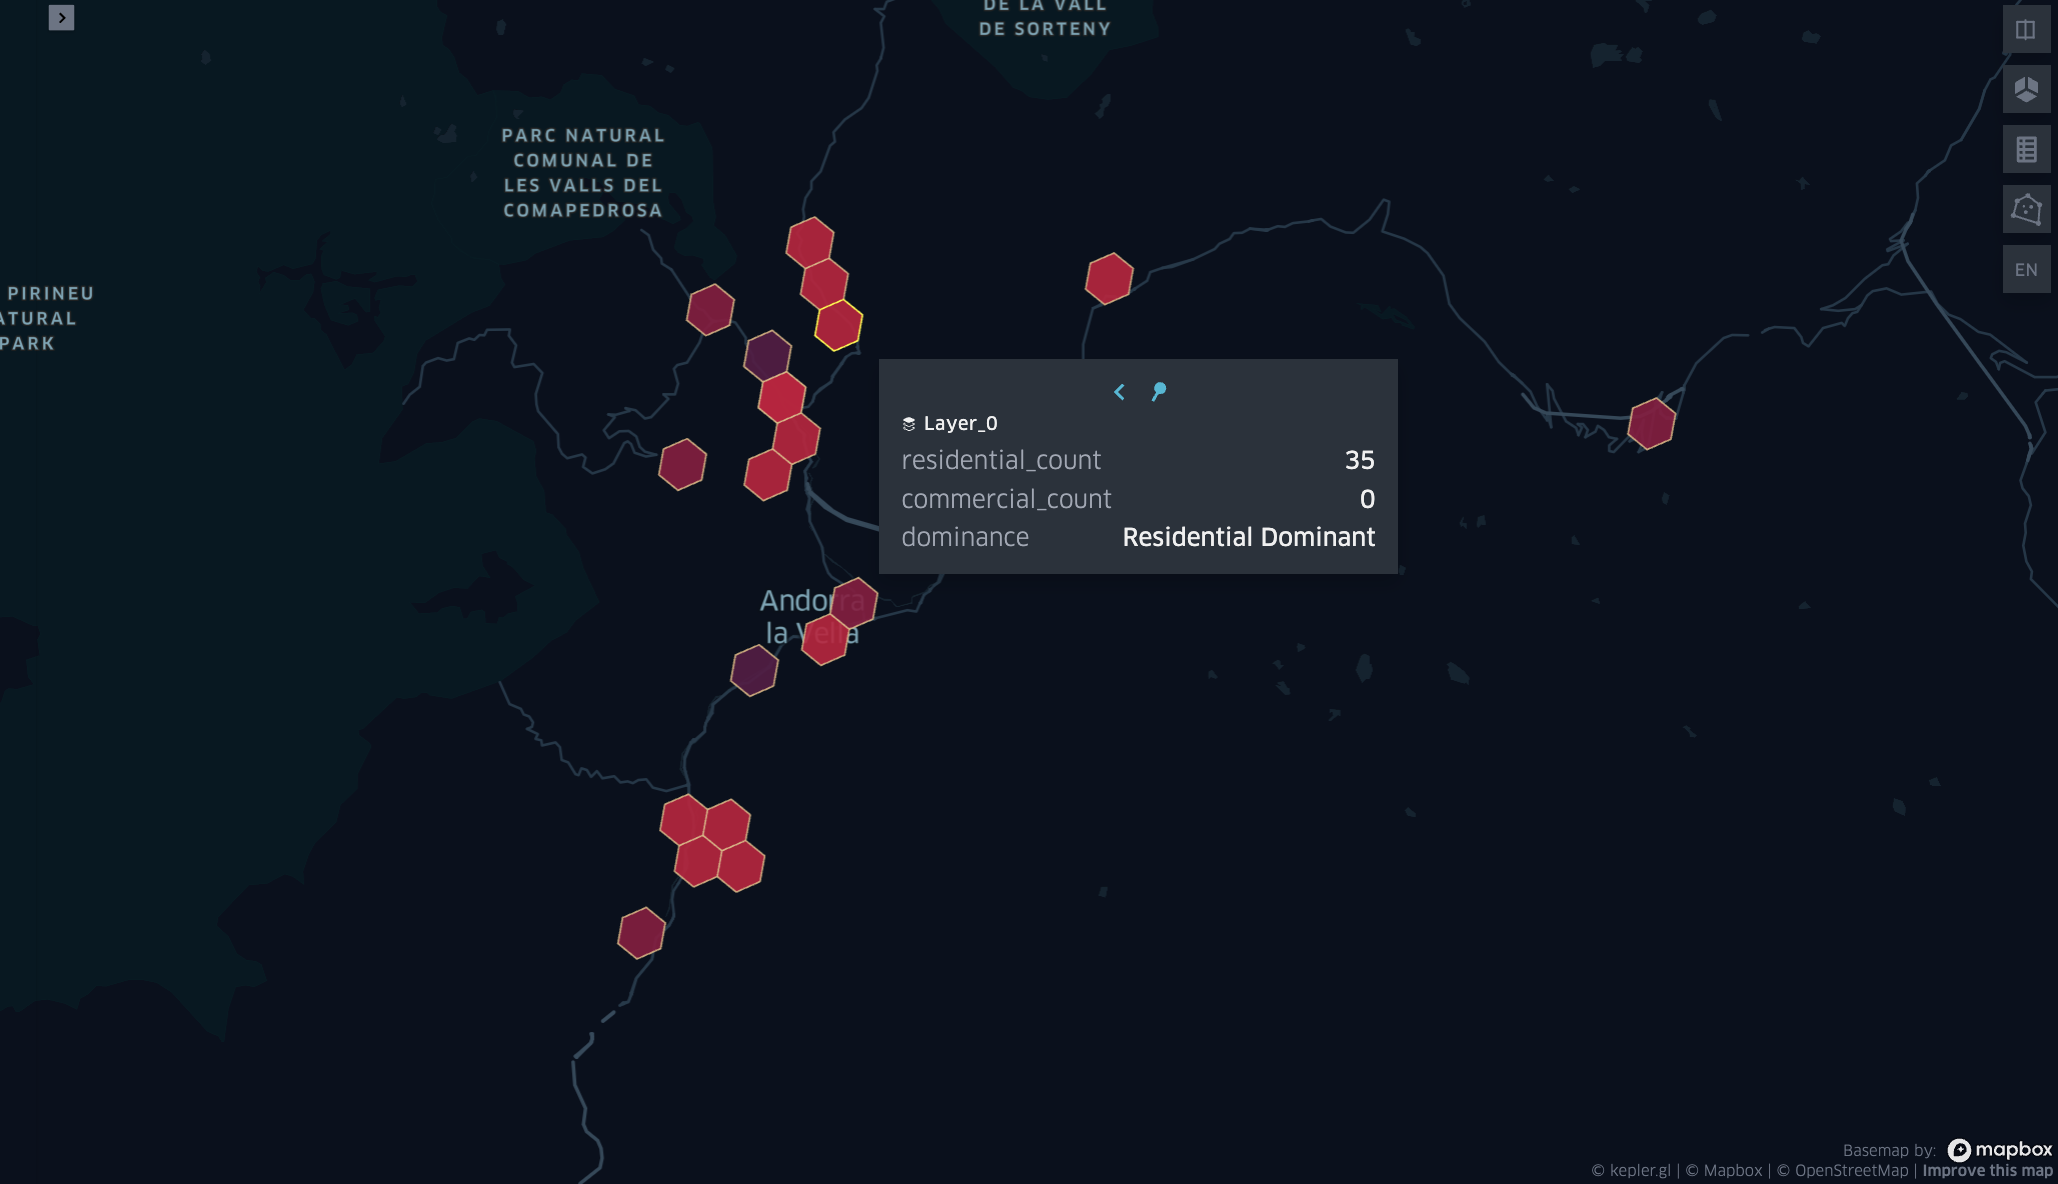

In [0]:
displayHTML("""<img src='data:image/PNG;base64,iVBORw0KGgoAAAANSUhEUgAACAoAAASgCAYAAAB7OThjAAAMS2lDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIQQIREBK6E0QkRJASggtgPQiiEpIAoQSY0JQsaOLCq5dRLCiqyCKHRCxYVcWxe5aFgsqK+tiwa68CQF02Ve+N983d/77z5l/zjkztwwA9Ha+VJqDagKQK8mTxQT7s8YlJbNInQADDEABTEDnC+RSTlRUOIBloP17eXcTIMr2moNS65/9/7VoCUVyAQBIFMRpQrkgF+KDAOBNAqksDwCiFPLmU/OkSrwaYh0ZdBDiKiXOUOEmJU5T4St9NnExXIifAEBW5/NlGQBodEOelS/IgDp0GC1wkgjFEoj9IPbJzZ0shHguxDbQBs5JV+qz037QyfibZtqgJp+fMYhVsfQVcoBYLs3hT/8/0/G/S26OYmAOa1jVM2UhMcqYYd6eZE8OU2J1iD9I0iIiIdYGAMXFwj57JWZmKkLiVfaojUDOhTmDqwzQMfKcWF4/HyPkB4RBbAhxuiQnIrzfpjBdHKS0gflDy8R5vDiI9SCuEskDY/ttTsgmxwzMezNdxuX088/5sj4flPrfFNnxHJU+pp0p4vXrY44FmXGJEFMhDsgXJ0RArAFxhDw7NqzfJqUgkxsxYCNTxChjsYBYJpIE+6v0sdJ0WVBMv/3OXPlA7NiJTDEvoh9fzcuMC1HlCnsi4Pf5D2PBukUSTvyAjkg+LnwgFqEoIFAVO04WSeJjVTyuJ83zj1GNxe2kOVH99ri/KCdYyZtBHCfPjx0Ym58HN6dKHy+S5kXFqfzEy7P4oVEqf/C9IBxwQQBgAQWsaWAyyALi1q76Lnin6gkCfCADGUAEHPqZgRGJfT0SeI0FBeBPiERAPjjOv69XBPIh/3UIq+TEg5zq6gDS+/uUKtngKcS5IAzkwHtFn5Jk0IME8AQy4n94xIdVAGPIgVXZ/+/5AfY7w4FMeD+jGJiRRR+wJAYSA4ghxCCiLW6A++BeeDi8+sHqjLNxj4E4vtsTnhLaCI8INwjthDuTxIWyIV6OBe1QP6g/P2k/5ge3gpquuD/uDdWhMs7EDYAD7gLn4eC+cGZXyHL7/VZmhTVE+28R/LBC/XYUJwpKGUbxo9gMHalhp+E6qKLM9Y/5UfmaNphv7mDP0Pm5P2RfCNuwoZbYIuwAdg47iV3AmrB6wMKOYw1YC3ZUiQd33JO+HTcwW0yfP9lQZ+ie+b6yykzKnWqcOp2+qPryRNPylA8jd7J0ukyckZnH4sAvhojFkwgcR7CcnZxdAVB+f1SvtzfRfd8VhNnynZv/OwDex3t7e49850KPA7DPHb4SDn/nbNjw06IGwPnDAoUsX8XhygsBvjno8OnTB8bAHNjAeJyBG/ACfiAQhIJIEAeSwETofSbc5zIwFcwE80ARKAHLwRpQDjaBraAK7Ab7QT1oAifBWXAJXAE3wF24ezrAC9AN3oHPCIKQEBrCQPQRE8QSsUecETbigwQi4UgMkoSkIhmIBFEgM5H5SAmyEilHtiDVyD7kMHISuYC0IXeQh0gn8hr5hGKoOqqDGqFW6EiUjXLQMDQOnYBmoFPQAnQBuhQtQyvRXWgdehK9hN5A29EXaA8GMDWMiZliDhgb42KRWDKWjsmw2VgxVopVYrVYI1zna1g71oV9xIk4A2fhDnAHh+DxuACfgs/Gl+DleBVeh5/Gr+EP8W78G4FGMCTYEzwJPMI4QgZhKqGIUErYTjhEOAOfpQ7COyKRyCRaE93hs5hEzCLOIC4hbiDuIZ4gthEfE3tIJJI+yZ7kTYok8Ul5pCLSOtIu0nHSVVIH6QNZjWxCdiYHkZPJEnIhuZS8k3yMfJX8jPyZokmxpHhSIilCynTKMso2SiPlMqWD8pmqRbWmelPjqFnUedQyai31DPUe9Y2ampqZmodatJpYba5amdpetfNqD9U+qmur26lz1VPUFepL1Xeon1C/o/6GRqNZ0fxoybQ82lJaNe0U7QHtgwZDw1GDpyHUmKNRoVGncVXjJZ1Ct6Rz6BPpBfRS+gH6ZXqXJkXTSpOrydecrVmheVjzlmaPFkNrlFakVq7WEq2dWhe0nmuTtK20A7WF2gu0t2qf0n7MwBjmDC5DwJjP2MY4w+jQIepY6/B0snRKdHbrtOp062rruugm6E7TrdA9qtvOxJhWTB4zh7mMuZ95k/lpmNEwzjDRsMXDaoddHfZeb7ien55Ir1hvj94NvU/6LP1A/Wz9Ffr1+vcNcAM7g2iDqQYbDc4YdA3XGe41XDC8ePj+4b8ZooZ2hjGGMwy3GrYY9hgZGwUbSY3WGZ0y6jJmGvsZZxmvNj5m3GnCMPExEZusNjlu8gdLl8Vh5bDKWKdZ3aaGpiGmCtMtpq2mn82szeLNCs32mN03p5qzzdPNV5s3m3dbmFiMtZhpUWPxmyXFkm2ZabnW8pzleytrq0SrhVb1Vs+t9ax51gXWNdb3bGg2vjZTbCptrtsSbdm22bYbbK/YoXaudpl2FXaX7VF7N3ux/Qb7thGEER4jJCMqR9xyUHfgOOQ71Dg8dGQ6hjsWOtY7vhxpMTJ55IqR50Z+c3J1ynHa5nR3lPao0FGFoxpHvXa2cxY4VzhfH00bHTR6zuiG0a9c7F1ELhtdbrsyXMe6LnRtdv3q5u4mc6t163S3cE91X+9+i63DjmIvYZ/3IHj4e8zxaPL46Onmmee53/MvLwevbK+dXs/HWI8Rjdk25rG3mTffe4t3uw/LJ9Vns0+7r6kv37fS95GfuZ/Qb7vfM44tJ4uzi/PS38lf5n/I/z3XkzuLeyIACwgOKA5oDdQOjA8sD3wQZBaUEVQT1B3sGjwj+EQIISQsZEXILZ4RT8Cr5nWHuofOCj0dph4WG1Ye9ijcLlwW3jgWHRs6dtXYexGWEZKI+kgQyYtcFXk/yjpqStSRaGJ0VHRF9NOYUTEzY87FMmInxe6MfRfnH7cs7m68TbwivjmBnpCSUJ3wPjEgcWVi+7iR42aNu5RkkCROakgmJSckb0/uGR84fs34jhTXlKKUmxOsJ0ybcGGiwcSciUcn0SfxJx1IJaQmpu5M/cKP5Ffye9J4aevTugVcwVrBC6GfcLWwU+QtWil6lu6dvjL9eYZ3xqqMzkzfzNLMLjFXXC5+lRWStSnrfXZk9o7s3pzEnD255NzU3MMSbUm25PRk48nTJrdJ7aVF0vYpnlPWTOmWhcm2yxH5BHlDng780W9R2Ch+UjzM98mvyP8wNWHqgWla0yTTWqbbTV88/VlBUMEvM/AZghnNM01nzpv5cBZn1pbZyOy02c1zzOcsmNMxN3hu1TzqvOx5vxY6Fa4sfDs/cX7jAqMFcxc8/in4p5oijSJZ0a2FXgs3LcIXiRe1Lh69eN3ib8XC4oslTiWlJV+WCJZc/HnUz2U/9y5NX9q6zG3ZxuXE5ZLlN1f4rqhaqbWyYOXjVWNX1a1mrS5e/XbNpDUXSl1KN62lrlWsbS8LL2tYZ7Fu+bov5ZnlNyr8K/asN1y/eP37DcINVzf6bazdZLSpZNOnzeLNt7cEb6mrtKos3Urcmr/16baEbed+Yf9Svd1ge8n2rzskO9qrYqpOV7tXV+803LmsBq1R1HTuStl1ZXfA7oZah9ote5h7SvaCvYq9f+xL3Xdzf9j+5gPsA7UHLQ+uP8Q4VFyH1E2v667PrG9vSGpoOxx6uLnRq/HQEccjO5pMmyqO6h5ddox6bMGx3uMFx3tOSE90ncw4+bh5UvPdU+NOXT8dfbr1TNiZ82eDzp46xzl3/Lz3+aYLnhcOX2RfrL/kdqmuxbXl0K+uvx5qdWutu+x+ueGKx5XGtjFtx676Xj15LeDa2eu865duRNxouxl/8/atlFvtt4W3n9/JufPqt/zfPt+de49wr/i+5v3SB4YPKn+3/X1Pu1v70YcBD1sexT66+1jw+MUT+ZMvHQue0p6WPjN5Vv3c+XlTZ1DnlT/G/9HxQvric1fRn1p/rn9p8/LgX35/tXSP6+54JXvV+3rJG/03O966vG3uiep58C733ef3xR/0P1R9ZH889ynx07PPU7+QvpR9tf3a+C3s273e3N5eKV/G7/sVwIDyaJMOwOsdANCSAGDAcyN1vOp82FcQ1Zm2D4H/hFVnyL7iBkAt/KeP7oJ/N7cA2LsNACuoT08BIIoGQJwHQEePHqwDZ7m+c6eyEOHZYHPS17TcNPBviupM+oPfQ1ugVHUBQ9t/Ad0cgwHzB5doAAAAimVYSWZNTQAqAAAACAAEARoABQAAAAEAAAA+ARsABQAAAAEAAABGASgAAwAAAAEAAgAAh2kABAAAAAEAAABOAAAAAAAAAJAAAAABAAAAkAAAAAEAA5KGAAcAAAASAAAAeKACAAQAAAABAAAICqADAAQAAAABAAAEoAAAAABBU0NJSQAAAFNjcmVlbnNob3RDsUHvAAAACXBIWXMAABYlAAAWJQFJUiTwAAAB2GlUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNi4wLjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj4xMTg0PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIwNTg8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4K5XCDwwAAABxpRE9UAAAAAgAAAAAAAAJQAAAAKAAAAlAAAAJQAAMhoVi651AAAEAASURBVHgB7L3XYxtXtvW5kTPALEqiApWzrLbb7Zw6ud334fvmZWZe57+bebkvt93u4Ox2kIOirWAxKDOTIHKevQ9QZKEIkAARiCqsY5MoVNVJv4KIqnPWWdvmHZ8sUQ+lUrFANpudyCaNUr96qHVoCgiAAAiAQM8SsNvIns4RFXvqa61ncaFhIAACIAAC1iHgcLnJHwqTPzJATrenqmPFfJ4yyQQlY1HKJpNU5OetXkkll4NKTgdRyRrf3UEn0ZkLF+jye38hl8dHNz75G83e/ImKVCKn00mHzlykC2/+iYJDw/TLfz6hW19/TivxFGX4kgQ477ETx+nKex9QZGycbn32D7r/w38on6++XgVGlciTyrMdNRc/Ukc8Trr06pt04e0/0crzJ3T9k7/TzMw0JTl/PeR8O0V+bsuhQ4dUWwIDQ7T4eIaG9h/kx3Mb9+lDenDnF4pzGYViY58kD1/i4ZCPLr3+Lp19/T1afDTDbfmQZmdmSPozOhihF97+Ix2/8juaufkjXfv0I5pfXqN0petcLfm4jIP7x+mFd9+n4YOHaX7mAYWGR8jjD9DNT/9O925ep5ihTZJn4uA4XXn3LzRx5gLd/eZz+umzf9JqIq34GVsvzAYDnjKzt/7E7Zymn/79N3r06HGZmTGDCd/LCIstx2AbvXgm7COaDAIg0D8E5PvB6XWT2x+q2elCNkvpWKzmMewEgb0gIJ9Zh9tFnmB419XLvX0qGt11fmQEARAAARDoLgEbz3NH9u2jQGRIPYhnEnFaeva4u43YoTYbhAI7EMJhEAABEAABcxCAUMAc1wmtBAEQAAEQaCsBeegMj4xSYHCYbHae6ZTEs8DZdJKS61FKx+NUyLOQrhcTt7fo5DbL7LQF0hahwMd/o7s3fuJJ5hLJJPTYyDBPvv+FJi//lmZufK8mxJ8vLFGKJ7i3CAU+/yfd/16EAnywkmRSPcVzvDKBvpMucrdCAckXdNno7Asv0sV33qfo4hzN3vqJDp46T/tPnFaT7TdZ4LCWylK2MpGvta/eq1xiYXPq4mUWUXxAdoeThRB/pzs//chCgRIdmTxGl3//FwoPj9Htz/9BP//wLa1nipSrCBEc/PEIujj/+Yt0iSf9ZWBl6vp3NHbkOB05f4V+/eFruvHlv2k5VhZdaO2AUEAjoXvlz5CNxSc2CAV0ULAJAiBgVgJ2FuF5gkH+XmFlGCcRBuTSGfKGy8IBCAXMemWt3W75vHpCoY3Pbc3e8v1RPsPCxkSy5mHsBAEQAAEQMAcBGekIDg3xmM24GqfJZTO09OQhFQsNPkx3qZsQCnQJNKoBARAAARDoMAEIBToMGMWDAAiAAAj0IgG318cPnWPkCQR5QDFDqfi6EggU+AF0uxXnvdKXksNedhWwgFagllDgl+s/UTzHjgI8WT4U9NGVd/5IZ155h55P3aVrvKr+4aMnW4QCg+MH6fn0fVplF4BSqTxbnufJjwVe4f70yZOGVvPvVijg5bmWkYEQvfDWH+gYCxp+/fEbFix8RUcv/obOvvYezc/+Std5xf+zZ3MNr7KX1XPiUjBx4IByBDhw6hzd+/Zzuv7Fx5TNpOj0C79VAoD42opyYZiZmlauCZoYQhwJhsSR4LV36NTLb9LD29foztefsHDhDF3glf+r888439955f8j1SYtH4QCNf6V88SDLV+EUKAGGuwCARAwFwG5bXB43CwUCCmBgDgH6PdJb0r8hSCTreKohAQCvUTAZmexQNBP4gpWN4lYgO//Miz6RQIBEAABEDAfAbkv8bHz48D+CdX4UrFIS+zWl+Nxm15LFhMKdGIoTC4nEgiAAAiAQM8TgFCg5y8RGggCIAACINB+AkG2hg8OjfBAo4vWF+cpvrLMAoFOPBe1v+1aiRJ+oCQz6SZP2wkFWA+hbO2v8AT82dfepYXZBywU+DvNzj5Uk9t6R4Hx46fVagNNJCCXM7o0ryz279y41jGhgBg7SDuOTk7yxP37JGEHJATC7K0flaPAZV7Nb+NVcGL1f//WDdUOnnNuKLllsj/gpYuvvU3nOfzAPPf/p48/pBSHxLj45h/oxIuv0sx1dllgJ4XF1fWqsAMiMjg8MUGX2OFg+MAE3f7yX/SABQxjR0/Q5Xc/IB/b9976/CP65dr3FMvyoHqlTRAK1Lg0IhRgqwYbD1IhgQAIgICZCWhhB1zeAOXTLAZIpbYIBaR/cBUw81W2ftvFFcMXidTvKH9vF3I5hNCoTwhHQAAEQKAnCdj4Id7l9dPwoaMcwY8ftPnv+crTJ5ROrre5ve2Zv7aAUKBEbo7D6fN42wx4s7hEKsmWj2LX2R7omyVjCwRAAARAoG0EIBRoG0oUBAIgAAIgYA4CYl0aGR0nf2SArXZTLBRY4AdPc646soJYYCehgEyUX3n7D3Tm1XdpbvoeXWehwMNHj7cIBQb3H6JnD+7Q8tNZXg256Siw9GSWV/I/75hQQFwIwjyjf+6l33HYgT+rsAO3PvuIljl+ooQFkFAEB0+epbviBvDlx7RisPrf7l+NCCWEz8lzFzj8wF/JzvdtN9hRIbG+xpP9HHZgZB9P9v+D7vx4lWLswKCFHRD9SIhDIZy5fIUucb50PKZEASI0CIQH6fxbf1RuByIcuK5EBrENkQGEAluviK0iFCAIBbbCwR4QAAHTERCRpDgKFHnMNiOOAhyrxi77AuXQA9IhCAVMd1n7rsE7iwX4c8yf8fR6uyeX+g41OgwCIAACHSKwdaGGhIgUYbvDzTH0+BksujBPiehKh+o3Ftv8PLa5hQIMOBAI0P/9f/xfRhJtf////vf/RzEelGD5R9vLRoEgAAIgAAJtIAChQBsgoggQAAEQAAEzEfDyQHh4eJRcPh8l2LY9vrxUETibqRebbS25xFmAl57zc54ZUz2hQKISemBsMExX3nufTr70urLPF0eBp3PzW0IPRMbGedX+R3T/h68pr4tdWGAsKQ5lmOEfzV6/Hqd6oQdmZ6ar7Pm1/PKU6+WJ/LHhQXrhnT/Rid+8SvHVZRafzPHl4Ir5hNDQqBKmPPv1F7rGbgCPH5dFDju1ReqQ8n1c/sH9+zj8wF/oAAsOfuHwAcnoGp1jhwF5vc5OBQ9nZ6vaJ2EHRiNBuvTm7zlkw9vKgWBt4fmGgEJcDwaY18KjGbrObZqdntoIWwChgJA3JL5YdrFcgFDAAAZvQQAEzEpArNu94U1hgL4fIrbLpdJKTKnfj20Q6DUCO4kF8FnutSuG9oAACPQjgcljR0zd7Znph3Xbb3qhwP594/TXP/21bgfbdeBv//wbPZ+fg1CgXUBRDgiAAAi0mwALuewZdn9pZLS63XWjPBAAARAAARDYAwIiEggODqtQA6JQT/LqbLMnM4sFagkFHtz8kfI8z+7kmfL9R4/zavoPaOzwJN355nO6wavyl6JxNfGvDz2gCQXufP81ZfOsCqgkLkbd5mR4njfHu+V9vVRLKHCDhQnPHk6TCA60JLdNUp7MHYvF//GTp1Qb9/Hqh2Ihz/PJm/VLPF0Hu1isLy3QTXYauHPtB7X6X7P618qs9yrhBwb9brrwypt0/o0/0POpu5ThuNGHzl6kGeYkPJaZR7pSpYRCkDYdPXqUXmBuB06dK7dJJ57Q2pSIrtJtdhS4/f03tM5KCnEkqCUUuMHnJHnSSIdAXR+pk6tT4SEuvfomXXjrT7T4aJoFEX+j+SePtzBLc/nZTTT1utxb+/le2cafJ5t8eJBAAARAwEIEqsQCLG7Lc+zfTCJhoR6iK/1AYDuxQDGfp1Q02g8Y0EcQAAEQ6FkCEAp08dKUeCDCZmN/QXlKL/+qX3upSPv37e+iUOA5N4nbhgQCIAACINCbBOAq0JvXBa0CARAAARBomoDH5ycZMCzqJkX1hUicO1lN7WXL3UwizpO3i5RNJ/WnmHbbrGIBo1DgwY9f0wJPzMvzbXBwiA6ff4H2Hz/NK/VXlO3+/VvXNybajUIBsdJ/fOeWmhjXX8gUu9ytrscozi4F203Q1xIKTP30bZWYRJwCRFyyvLLGYoUiBTwuOv/ya2qSXBwqZm58T3F+1ZI/FKHJyy/RyMRRuv/9V1us/rXz6r1K+AHp58mz51S4AVkdV+CBb08gSD9/+S8WHvy4wUPKkD6E3HY6+5uX6NK7H6gVoTM3f+CQCPMbVXg579GLv6HxY6do+vr3JC4Nc0sryqXBKBR4ePuaEiQUctmN/CKEiK+t0sJKlLI8+T8Y8JAmFFh6PMuuDv9R/760DBqzxeUVbqvJ9KkQCmiXEa8gAAIWI2B3ODkOsJdDEOQpl0lbrHfoTj8RkLBi3nCYpx+q5x8gFOinTwH6CgIg0JsESjR57GhvNq3BVs1Mz/KZauJ9Sw4TOwqU2G6wxEKBcfqvP//Xlo61e8f//ON/lKOATZY11IHZ7jpRHgiAAAiAQPMEbLxMTlZLmdW2uPkeIwcIgAAIgIDVCIhTQGh4hGTgWyYmlfX7Np2MLS9SfGW5avX3Nqf3/iEeHC1KcHr17NX7zdVaqBcKDB84oq5HicXtkkQsYOd+JWNRun/1S7rLbgFLazEVSkCc/fVCgfFjp7es5pcyRCTw8xf/4lXz31KMl7PLqvl6ySgU8PgDG3b9Wp5UfJ0n6P9Nt7/7mnI8uTI8OkJX3nmfjl56kSfdr9INdg2Irq6q1ffyFBwIBunim3+g0797S622V1b/HMogkW9swlzKkPAGB/aN0uW3/0THLv9WDYQ/ufcz3eCwA48ePaoKO+BlB4J9wwN0+a0/0MkXX6NHd26o81YWFki6rsrzeen8q+/QuTd+T2vzz1iA8XeauneXEnwr6OYTJg6O0xUOdSB9EmGC/GipyNvzM7/STXYZmJ6aMggF/kwuj6fqfMmXYFHBz1/9i25c/YavQclcRlYQCmiXHq8gAAIgAAIg0JME5N7GzvGsvaHwZvv4RrGQzVFaQiIjgQAIgAAI7AGBsh+dNYQCgk++baoThALVPOq+g1CgLhocAAEQAIHeIgBXgd66HmgNCIAACIBA0wTCI2McD16EAjxTymk7sUAunVZW8OmEtQYPS7z8vOTk/m99hm2aZ7cyiFDg9PnzdOZ3byuhh1aviAXkOkUX5+jJ3dv0nCen12IJNZnNC/lVUkKB48fo7Ctv09CBQ1rWqldZJXmPRQa//PAdrfPy90YcBS688jqd+u3rSnRSVRi/ybE18/3vv6Q7XJ6srD9y6gydeflN5VQhjga3r35N0QyvzuRJdxEeBPnXmSsv0mk+R0QPv37/H/rlx6vclu1FC/p6JfzAgNdFp154kU6+9Do5nC5e5f8DSZiF5VhShWGQ80UjIkwmT5xgnm9SZGSfcgy4/d1XtJrMKNt/B58Tctno1MVLdJbFAmI9PXXtOy7rG1pL50j+9UwcGGemb7KTwxkWaxg+TDzwvvT0Id359guanZndEAqcf+kVOlmHmbh33P/hK7r9w/fK/cBUEa9EKMAOJTbTxUzQf4KwDQIgAAIgAALWJiBCYd9AZKOT/eomoO7a+IZQFooigQAIgMDeEdj8G2QdoYDQrH42NrlQoBx6oHuOAs8r1j/VEPfuQ4qaQQAEQAAEahGw8YOEir8qS/SQQAAEQAAEQMBkBHg6jwJsVS9iAYfLpVovk8QpXo2ez27apot7TpYnewvZTFXMdZN1t25zzRaCwM8T2xFeMu/ma6aflBahR6GQVzb7OXY+SvLEe4YFAppIQAD4JK/HQR5eRaZC8dWhksvlKMaT4LJiXp/feLoYMshEe4gn5Z08GV8ryV1SnstLZNhDn5OEHnBpnzfevy71VNwCZOJe+hfm8qR/kvL5HMX5nDifs51oQZ1c+SXhB/w8gy/laHVJOdInKUfrU836Kn2PV/ou8/7lspi5262GOiSUgfQnxqEZpIyIx05eZmq3i2xga5Jrk+FVekoQwddExB5B5uCs9NGYQ2O2niq311R3mhAKGC8n3oMACIAACIBAzxFQ4QciHH6gEv6434QCMutidzvJ4w+SjUXTRXYMTUXXeu46oUEgAAL9QKD6ac9aQgG5fvIXt5wgFNBI7PBadhSAUGAHTDgMAiAAAr1BgEeGbTxiDbFAb1wOtAIEQAAEQGB3BMQuXtwF3D6/KiDPYoHYyhILBmKsEdi0UN9d6b2fS7kKuGpP8PZi62USnBe414yYIEMMrBFQE+q1FkbJpLas2pdV8tsl0UDyHHhDE/MiFpD2GBfS68vXypP26dsubZR6tIl7yWPsn+SR8AeNigSkDEnGdmltMJYjLISJsJFU6zzjOXLeRpsq+Z2V/HKsVtJfF9VHrnO7LLXaUavcntsHoUDPXRI0CARAAARAAASMBGzs2uQJBpRTktz89EPYAbnvsvFNnZ3dxDxBCbtQfScGsYDxU4L3IAACnScgT7u6xG8njx/V7TDf5szUrPHPK3ei/Pe274QCTx/P0MFDk01fRQgFmkaGDCAAAiDQEwTs2QYD5/ZEa9EIEAABEAABEKgm4HR7lLOAj2OVysBhka3DJU56Ym2FV6iXV4JX57DWO7O5CliLPnpjKQIQCljqcqIzIAACIAAC1iQgUzZ2dkPyBkOWFwmU++pgUXSQRQJs61QviXiVn3vS6+v1zsB+EAABEGgjga0iASncEkIB6UhZGyBblcQLLr3jk4Zeawf35rXEsRGVtY5q7JYW6xpV4hg1zYUeuPr1p3T160/o5dfe4593dWXtvAmhwM6McAYIgAAI9CQBWUbHKmw7x9hVS9F6spFoFAiAAAiAAAjUJyACgUBkkIIcjkDisEtKx9ZpfXmR48yn62e0wJESrywqyRJ0JBAAgdYIiFCA7XuV41ZrJSE3CIAACIAACIAACOyagMz4ODwcXiDA7gEyZtdI4nG9fCZLmUS8kbNxDgiAAAjskoBhulz31jJCASFj+NPbl0IB4dCsWABCAaGGBAIgAAImJiDhCNhb1iYOA+IZiwQCIAACIAACJiMgK4vCw6Pk8vpUy7OpFK0vLVAmae0BM7gKmOyDiub2NAEVnosFA0ggAAIgAAIgAAIg0G0CMjdldzvJG4o0X7WIBXI5ynAYNiQQAAEQ6AwBw5yB7i2EAp0hXrPUTjoKSIWaq4BsNyMWgFBAiCGBAAiAgAUIsFrZnmGr5loBgi3QPXQBBEAABEDA2gTcLBIIsVjAGwiqFTj5bIbWFxcoFbeuFSdcBaz9mUbvukhAXAU4fIktC6FAF6mjKhAAARAAARAAASagRAIuEQk04SRgJMeTdoVCntLRqPEI3oMACIBAiwR0qgApyfDWUkIB6Z/OVaCvHAWk75J2IxaAUKDMDr9BAARAwPQE2FnAnoZQwPTXER0AARAAgT4m4OAYnsHBYfJzOAK7w0ExdhWIry5TkUOzWTXBVcCqVxb96jYBGQ9S4QcK1v170W2mqA8EQAAEQAAEQGBnAhJOzRsKkt3p2vnkOmcU2RUpFV2rcxS7QQAEQKAVAjplgG5TK9FyQgHpWEUs0JdCAel/s2IBCAWEGhIIgAAIWIOAPYPwA9a4kugFCIAACPQnAafLTZHRfWo1Tj6Tpig7CqQT1rbghKtAf37W0esOEICrQAegokgQAAEQAAEQAIHtCMhclMPjJE9wFyEHdAVDKKCDgU0QAIE2EjAoA2q8PXb8aBvr635R01Ozmi5gs3IIBT5lscAnCsj//j//Hzp4aHITTo0tCAVqQMEuEAABEDAhARuHHFCrqDi2GRIIgAAIgAAImJFAcGCIgkMj5HC5KL6yxD/LyoLTjH1puM28Aqnk4h+e5EQCARBogYAIBXg1nrofbqEYZAUBEAABEAABEACBRgi0SyRAPI6Xz2Qpk4g3Ui3OAQEQAIEmCOjmCXSbWgEljkNw7Pj2c8jaub36Oj01w0KBGuMpvKsvHQX0bgKNiATkwkIo0Ksfb7QLBEAABJogwAOj9ox1ww7YHDbyBAKUTaapmGfXBCQQAAEQAAHLEXB5PBQeYTeBYIhy6RSti5tAsj8GyxB+wHIfZ3RoDwnY8kUlGNjDJqBqEAABEAABEACBPiEg4dJ8AwMt9RZuAi3hQ2YQAIFtCejUAbpNyVJ+2xmhwMDgEE1OnqCZmQe0trqybQtbPShCAYk1sEUq0I9Cgd2IBOQCQCjQ6scQ+UEABECgBwjYWSiQtpZQwMZ9stmJBQJhjvPmVJDT0XUq5LmfSCAAAiAAApYjEBwcptDQsIrtGV9epNjqMhULBcv1s1aHSg52FHDylx5cBWrhwT4QaJyAuArw3w1btj/+djQOBmeCAAiAAAiAAAh0goAIBbyRCN/Gb5miaqw6nqkrFvKUikYbOx9ngQAIgEDDBGoqAzZyi5uApN06CgzyGE6GQ0bWShMTR+jgxGF6+uQRPXnysNYp5PX6aIWdJFtNZaFADalAvwkFdisSkAsAoUCrH0PkBwEQAIHeIGDP8kp7Dj9gheQO+Mnp8dZ80IJYwApXGH0AARAAgWoCbn5ADI+MsTgsSNlUktaXFiiTTFSfZPF3veIqIHqFgIOFevxTa7hTbjXy/JMuEslcbEF368F6B/JzPl+dvNollCxpzpvkH178vWOScr3yw+VylAay80CslFFim9aCtIPfSFk5/tGS5PFoebgjdhYgStrIw/lSkodftS5IHmm7T9WhlbT5Kn3N8U+G82U5n7CQUoVVgDWNzlrANrOrLSlD2ip1S1+EtZtft0uSJ863eVKvysN1aXnkWIL3C0/piLEt0j85Lu0VflIfGzWpxLtUO6QtwlHK9nPZwk3riuRLcN3yapYkbVfhB6RTSCAAAiAAAiAAAiDQQQI2DiPm4TEsh9uzq1rgJrArbMgEAiDQEAF+QNSSblN2ld+Wf+9GKPDbl9+gYDColb7r10Q8Rlev/mfX+SWjJhSQp1jtOVYrsK9CD2hCgUbDDWiQ5BVCAT0NbIMACICAOQnYeKBcrZziVyskbzis4lPX7Av3Mb0eg7NATTjYCQIgAALmJBAaGqGguAk4nBRjkYC4CZSK/TXJV3YV4Flc45Ntly+pTDQPB3105Mw5Gj5wpKr2Qj5LyfU1Wn72mNYW5iiWyqhJZG2y3815I14XTZ4+R2NHjlfl1d4UiwVafDhFj6Z+pdVkRokNtGO1XjXhwkA4SOOTJ2n82CkKDAwqMaHWlrmpezS/sKgm02VuWPKIYCEc8NLYoaOc7xS7VYyQw+lS4SxWnj+h55xnZWGeYjzzLxPwcgclE+VhBjB56gzXc7qqOYVCjuIry7T89CGtLbHjRZpZSD7OKCKBw4cP08GTZ8ntC1Tl078RflLvzINfVVtlQv7A+ChNnDxHwYFh/akb29lUgp49uEuPHj7cyLN/bJjznOU8QzQ/+ys9+vU+rbNqQ0QB5bYcooOnzlOOV3c8/fUOPX0+r4QEARfXd2A/t/Mc+YIR7ssszd79mVYSfB04rzAbH62UzbzW5p/RE657YXWdUiwWME2Cq4BpLhUaCgIgAAIgAAJWINB0+AG+gcynM30njLbCtUYfQMBcBHTzBLpN6UP5bfn3boQCr772DjsCeKnI6nkR4xuTCPXFaUWOyTnGJMfknEQ8zkKBr4yHm3oPoUBTuGqfDKFAbS7YCwIgAAKmISBfrBnrhB2QkAPe0Ga4gVrXIZ/hAe1kiieReIQeCQRAAARAwPQENKFAiR8go4vzlIr1p/VmL7gKiFBgJBKkF997n0799o2N8D8bHzJ+xk/FozRz80e6xw/08/MLasW6TNCLUGDA76Erb75H515/j1zsFGFMhVyO7nzzGV3/4t+0vJ5Qk/TGc7T3fIujJq/HRgbp3Ctv0fHfvEpedp3QpygLFm5++ne6c/0nirHVgYxRiCvA2PAgneFVDidefIV8oYg+C5W4sYuPZ+j2l/+kmbt3WCxQVIIFEQqI0OHSa2/Sxbf+pBwuqjOWKM4iFun3vR+/5fbHVftlcv7UuXN0+b2/0ghbLNZLMQ6pIW39+cfvVVtFKHD06BG68t4HdPD0+ZrZRNRwg/Pcu3ljQyhweOIgXfn9X+jwucv0jIUA1z/5kB7PzlKKr4G4Bpw8e45e+P1flTvHtY8/pJnpGSVq0LhcevP3dPK3r9PC7BRd//hv9HBmpiwUYACnLr5Al3//AQ/q2On2F/+kOz9epRirCMzkKMCNJ1ueww/oLSZq0sVOEAABEAABEAABEGgPAbudQxCEQ2TjUARbEt+g5rNZyvCEGBIIgAAIdI+AboJetyn1a2EHZHs3QoErv/kdDbCA/8b1H2qGD5icPEFH+Wd25gHN8I8x7d8/QWfOXqAFFu//fPua8XBT7zeFAls9BfrKUaApaoaTIRQwAMFbEAABEDAbAZ5Yt6ctJBRgP1xvcHuhgFwihCAw2wcV7QUBEACB+gQCvDJaxAJ29n6P8oNiIrpa/2SLH9lrsYBeKHDypdfVqvKlpw9JbFFdHg8N7NtPA2MHqMCxVO/yhP/P33xBSzzhL9b3RqHAOk+ML8w+oHwuu3HVijxJLyvZH09P7egoIM4AIfbzP335Bbr07gfk9Qd4df0dWng0ze3Jkz88oFwCZNX8DJcnFvliqy+uAGevvEQX3/kziwQGaIlFAXMz93niPEWh4VE6cOKsen38yw26/tlH9PTpM0pW8uqFAvG1ZXpy72e12svj89P48VM0euiYEhnc4Mn56fv3NybgDx85QhM82e9hRwGH00FDBw7T0P5DLHyZo6Uns2pwWDhI+2fZASDG9emFAmNHT9Ai92vl+eMqNw1p89zMr/T40aOtQoHzL1AunaJff/iGbn/1MS2vRWWOvKZQQNgIz6DLRifYLeIyCwn84Qj98p9P6edvv+DYklkaGBqiy2/9gQUZr9CjOzdZRPAhPZ9bUH2ssQhk45r26oaNrS5EMIAEAiAAAiAAAiAAAt0ioNwFIhEScWw6FutWtagHBEAABGoQ0KkDtmxu7rCSUMAoFYBQoMbHotYuCAVqUcE+EAABEDAXAXuWR3/NOIJbA7OtAaFAsVCgTCxORZ6kQAIBEAABEDA/AT+v+A4Nj5DT42WhwBwlJPSA+bu16x6UeKK5JLO6e5D0QoETL71Gszd/oJuf/UOFg+A5aAoNjtD5N/9Ax154mSe2Z9Rq9umpKTXR7uIFVBuOAq+9R8+m7qoV9CtsYS8r/fVJhAVi3a+FLdAf07a1UAaXX3+Hzr3xe5IQAzd4Yn9l7rn6fLBWkhz8q8BlxzmEgNjje3l1/76RIbry7p/p+JVXeMX9L2pF/tKTR8QL7snldNKJKy/TBXYMkPsJWa1/99qPaoW/9E8vFFh68lD1b5FfZQL+yNlL7BrwgQovcOvzj+j21W/UanvWMijLfxEpSPIFQ+xI8Ec69bs36dHPN+jGJ3+jKIcrkCS3awnut/RfVv9rjgLDE4fp5y8/prvffk45HljWJ+mfTPRLiATJs+ko8II6bX1pnt0R/kX3r31Pee7TJAsBjI4Ckl+SchUYitDFN96jUy+/SfMsoBDXgZVnj+jQmQuqf06Xh26Jm8BP7HzAVgIS0sB0SVwFmIUKzWW6xqPBIAACIAACIAACIAACIAACINAKAd0DuG5TSiy/3dwJoUArnJvMK/bIYt9XjjlZGUGoWQabPnA8zv28UuO//vxfNc9o504IBdpJE2WBAAiAwB4Q4JF3O8el3TICvwdNaUeVLp9XWRXb7PUnSOAm0A7SKAMEQAAEeoeA1x+k0MgoT8D6KSbx30Uo0OfhZfZKLGAUCszc+J5X3f+T5heX1YR8gGfFz/Bq/UvvvM/Ptja6wdb1t9n2XybqxbpfLxR4zkKBG5/9nVfJs1Cg8nGTV7Gxl4nr7UQCcno5FICTLr3yBl14+08UW1niyfR/kzgIpLM5NYEtc9hSjpQpYgQ/CwWOVOz89/EqfQlzcIPzrMRSxE1UoQwmjx+nF3jCf5DtDmVy/ubXn9FaKqvyG4UC19g54OkjFgpwPZOnzqh84oBx6/N/0K3v/kPrXLGEXRDRgvxImwfDQbry9h/pNIdLePTzdfrx339jfksqvIEIBeSH/1dt1QsFfvnqE7ojQgG2ptWSiARSFWGB5JOJfk0oIK4F2XSSgoPD7NLwiAUJH9LCwyk6eKq+UED0JxIq4fjpM0oUIK4M4irw9N5tDkfwGodqeE1tX//0I3o+v6jEHEaRh9Y2M7xK+AGbXCAkEAABEAABEAABEAABEAABEOgbAvLEWUm6TdlTfru5E0IBDVQXXiEU6AJkVAECIAAC/UaAB+jtGeuEHZDL5w4EeEWph+ceZEi+doJQoDYX7AUBEAABsxJwcyz78MiYigmfWF1RE8KFfPWqarP2rZV2lzgUg4Qi6GaqJxR4vrCsJuNlkvnkmbNqkjk4OMRuAx/R9W+/phgvd5dJaL1QYJWdBOam71WFHohxOIJns9O0uBZTq+q36xt3n4K6Se3Rw8coGV0jESA84YnthYfTFF9f31ihL0Md0r4Tp06rCf3wyD66zSvjb3J4hGg6rwQFPj5+aOIgXXnvLzyhfl6t4L/2+T9peT2pJvCNQgHp3wpPwjvdbpq8/Fs69/p7KozAjU8/pLs3r6twAPp5aI2fUSjwfGFJOR7o+yuiBk0oMHpoUoUYWH72cCP0gFjWLnDYhKccdkBCFUg9eqHAwNh+xSI0NErCZvr6Vfr5q39zaIj9HFrgAw61kFRuATPTM0qYodUtrgSjg2G6+No77CrwhhIXSDiHidMXycPhHcQt4e61H9hNoGRONwGto/yK8AM6GNgEARAAARAAARAAARAAARDoEwKbQoAN1X6l5xAK7OFHoDmhQIkdBca76CgwRzZZ/lC2O9hDSqgaBEAABECgKQL8t9uetpZQwBsKkcPlUqsU67GAUKAeGewHARAAAXMScLo9FBkdI28wrCaCYyuLajLWnL1pb6uVWEBm4LcR0LWzRm2i+8X33icJPaA5CuiFAsdPnSpPxI/uo1scluDaN1/ROk/EVwkFeELdxaEkSqXN1dyFfJ6mfvqObnzxb5pbWtlRKCBPqNKeiM9FR8+cp7OvvkvDE0fI4XAq8cHy04d0/+pX9JBFA2uJjLLml8n3U2fPqYnyQGSwvPL/W175z0IGcR4QocDBA/vpNywUOHT2Mt27+iVd4z6IcEFW7OuFArlshuLsYlDiJfUuFjEGBobJxYKBmZs/0i12Kai14l7j16xQ4ODp88oSYYMXt2Wd677NzgW//Pg9redLW4QCkbFxuvfdl1RkruJe4HS56f73/6FMMk6nOexBPaGAhEgI8q3WsZOnmNNfKRAZ4jwJ8ocjHKrhDl375O80t2B+NwH5dwGhQDv/OqAsEOgtAvK16HC7+OvRQbl0urcah9aAAAiAAAiAAAiAwJ4S2E4ooDvGbbSWo4DMcstIQjnZvOOT1b3VjuzRa7NCgdGhYfpf//W/O97a//6f/6allWUIBTpOGhWAAAiAQAcIWFEoEA6XhQJ1cEk84UwsznGFK8F265yH3SAAAiAAAuYhIBO/EZ509kUGKB2PqfAD2UzKPB3odEs5HE9RnAVE3N1hH3htontbocDp8op9Wcl+q+IosJ7ZKhRYmXvKE8+/sOgjs0Eoxs+ec49maSka31EoIJmky9ImcRaIDA7SvslTNHHqAo0dPUa+YITW2LVAVv3fv8Wr+3NF8rCm4gTb6r/AK+pDgyN0ix0FbrGQIcrt04QCEwcPKEeBiTMXeaL9CyUUWIomtggF7A4HW/uXP4cudr3IZzI0df07evDD17S0tKzcBLjKqqTxa1YoMHrkGM1N3SNZ2a+F3cizo4CEFHj25ElNRwERCgj/5w/u0Ul2Bjjzytu0vjSv8kjYBREMXPv4QzI6CkiDxVVgZCBIF159mwUY76iwT9GFOcXy3vUfKcZxGox9q+qoSd5I2AEJP4AEAiBgHQIy9CsCARc7oMjfaUkFDtmSjsXUNn6BAAiAAAiAAAiAAAjopsd1m8KlZLAYgFCgi5+WxoUCcqWKatXCgfED5Pf5OjMYxNLbZCpFz+aele2dbTyiggQCIAACIGAuAjxZYM/y4GeHJw26CcXl86rBahtPitRKcBOoRQX7QAAEQMDcBCTcjEx6Sux3WQW9vrSgVjibu1ftb72EISg5eVKkg9/72kS3USgwt1gOPSAT9mcuvUCX3v1Ara6/8cmHdOtHtqnnWWUXf3XrQw884xABNz79O63wM6c2NiFNz/LkepJvX2Tifqckq9+1HynfzT9ej5vGj52i82/8nkbYsv/X77+inz77Jy2tratzjx0/QVdYKDC0f4Kt+D+mG199RmupjKpPHAeOHDmiHBHGjh6nO19/Ste/+JhWE+ktQoGlJw/pzjefkoQAOPnb10mEBbPsJnCTQxXMsyNCivsgLgT6pPFrVigwPHGYfmaXgjvffE45dgjQkpQv9aQrdelDD8i/mZuffkTTN3+gwbEDdOmdP6twCvHVJXI4XZSIrtQVCmiuApMnTipXAQl9IH27xtdzjsMkJLkJhq5pTTLPK/9dsbHA1Cb3ykggAAKWIuBgdxdxottI/OWSz2Qpk4hv7MIGCIAACIAACNQiIIIzu9tBbl+IUhzWDAkErElA9zSn25S+Qiiwh1e8OaEAXyo1+FO5gurFcDVb6gv/OZS/iCrxwzM/QHfLylKrFa8gAAIgAAKtE7AVSmypyoOfHZwwaL2VzZfg3cZVAEKB5nkiBwiAAAiYgYA4CgQ45r2sCowuLlA6gZWBta5bp8UC2kS3Xihwgyfh19gJQB4hfSxkP88r0M/wz/ryPF3nFev3792lJEdCEtODWkKBhefPqibU5clWVqtn+IcXfNdN4iYgE/sB/pFZaxEY8K2PEgOEwiG69NYf6dRLr3MogB/op08+ovnlVfVYe3B8n3IMOHL+Ck3fuEo3eNX9MjsASF7p37Hzl+kyCx3cfj/d5rADt69+Q+uVyWR96AERClznifOVZ4/p6MUrLI74CzfEplbxl1fdF8k4B63x261Q4OevP6d0blMoIKxELCCsZGG8OAEcnjjIQoi/KHGNCAXuXf9BPc9Pnjqr2jgycVRxeM5CjXqOAupaclmHJg7QC9yvAyfPKncFEVyIaIIjNZg/QShg/muIHoBAHQJloUCQj8pfs3KCq4BGAq8gAAIgAAK1CMg3hggEvKGBjcMlfhhJrq1uvMcGCFiHgDxJVpJuU/ZAKKCB2YPXZoUC5SaKYKBzjRV9wMZNdflN5ypDySAAAiAAAu0lYMGwAxogb6gSfmBz3Ec7RBAKbKDABgiAAAhYikBoaISCHH6txLOi0cV5SsWilupfOzvTSbGANtGtCQUe37lJ09e+o1wmrRx/Rg8do6MXrlBwcJge/PQt3fjiXyRuAyme2+ZxtyqhwPPpe7za/z+Uiq9XdT+fy1KcLaJlQlry1UtOdg8IOW00eeo0hUfGlKV+jFfLy0Py8MEjdO7192jowCG6+81ndPM/n9FKPKVWwQ8FvHTpNbbU5+PiUCHtlH7kuQ8SLkHcAQ6du0zLT2aVEGD6/n0VRkBW2RuFArLCfpEFA5HhUbrMK/YnL71Ej+/eUk4JT58+owS3X+8qoPHbjVBg+tpVenj7JyroHAWETZpXyK5F11U4AMaxRShw59oPSngR4X6ffvEVOsdOC4HIIIckuFNXKCDllt0JIBQQFkggAALmImDnkEXugL9+yDoeS5WwN5k4HAbMdWXRWhAAARBoPwEZWlQCAQ5bVmuxLMQC7WeOEnuBgG5iWbcpLYNQYA+vT1NCAdVOvnqGC9iR5stfSp0CtyN1oFAQAAEQAIH2E7CwUMDGI/XeYJjsTllCuJmKPHCeiXMM4cI2swqbp2MLBEAABEDARAQk7ICIBewOO0UX5tk2HSs7trt8EoKgJDPpbU7aRLcIBU799g2SUEDFoiwvZyc6+c3vxf1ubvo+3fr8I3o0NaUm2cUhoEoowJP0Dpd7y3d2ka3gZaL91pcf02OeaN9OKCDlycT9hd+9rkQBTreXJ/4TqscedgNweXy0+GiGJ+0/pOn791Q75GCA8x06fFhZ8U+cvqAeq7PpJLelQG6Pl5xujxIviM3/ne++ouVYUln7S2iDWkKBZ48ekoP7fepy2VXAxe2QkAa/sAhiLclW17rV9xq/ZoUCB0+dZ8551UbVwcovEQlIeIRb335F0XSeagkFfmGhgIQKkLrHx0bp4pt/oGNXXqaF2QcQCiD0gP7jhG0QsBSBLeEH9L3j7ymEItADwTYIgAAI9C8BG4fc9oQC6tmkHgVNLKCed/ihwO0NqOeedGxdCdnr5cN+EOhdArrJZd2mtBdCgT28as0LBfSNNVxJ/aFdbyuFwK5zIyMIgAAIgMDeErDx17pNRqY7aT2zh12s5SoAN4E9vCCoGgRAAAQ6TMAfilBoeIScPJEbXZijxOpyV3TTHe5WR4sXoYAIBtqZtInui6++RUcu/EYNkGnli2AvyU4PCw8f0KOfr9MSCzpiHHJA7PfliVUTClx85Q06fuUVFn1sbVupVKS5qfv0y3df0pNnzxsSCkxMHqPjL7xMo4ePkccng3Y2Sifj7AjwkKbY7eDJ1K9qEl3dFlXaEWKt4fjBCTr+4qu0//gZ8gZCZOfJ/kI+R+tL8xyu4Ed6+MsNWl5bpyS3X0IgaEKBC797lU6+9BqHHHhCd779gh4/eqT6Nz42RmdfeZP2HztNK3NP6P73X9Hs1LRyFZCwBpI0fmdfeoUOc+gDmayXvj5fWNrSVwmrcPToYS7zbRo9dJRzb31GlxWxv/7wNYdH+JrWuYNlocABzvMWSbiO+yxWEKFAnIUCIhuRMA1Hjp+gM1ym9FXaPzszq9rIh6uS5ihw9ndvMttJmmU3g1tff4HQA1WU8AYEQKBXCThcLvIEQ+o7YUsblVCAHQUSZXHZluPYAQIgAAIg0DcEROjsH+BwA7tx1OZ7/GIhRyl290ICAXMR0M0p6zalDxAK7OGVbE0osIcNR9UgAAIgAAI9ScDGI9K2vHWFAj0JHY0CARAAARDoGAGvP0ihkVFy+/wUW1qkmAgF1Er2jlVpiYJL7MCgxAJb55h31T+Z7Be7f7/HRQ6js0+xSPlcjvK8SjvDE+spvg3JVUQCUpkYHAR5ojrILgBOp6tu/QXOn87yhH22WLUa35iB9QBq4t3PbfK4HOQLBNWEvwz2yUp7CWmQzrJ4gdsgIgEtBICg4NOVs4CXN7z+AOcLkoOFCzmeeE/FY5ROpVT7NZGA1C3tl4n2EPfdyRNQMp6SyWaVCCHP/ZW+BXTHcswils5VhR8QfkHFz6kYSF9TmawKGyBt1CcvnxthZYHH7VIiBv0x/bYwl3rinN/FnQtzHi/nEQ5aG8RRQPov9YfddnXczgAzzDnKFddybpD6pSxfpaw8CwsSGa6HxR/iEGH6xIPBNjgKmP4yogMgUI+AzPc4PR4OQRDcckpJvq/SGRV+ZstB7AABEAABEOgbAvJcYJfngTALBVpImuNAC0UgKwh0mYBOHaDblEZAKNDlS6GvDkIBPQ1sgwAIgAAItETAwmEHWuKCzCAAAiAAAqYl4Pb6VBx6Dw/4i5tAbGVpS6x203au0w3nCeOizIzLzHqLTkMymCYT5rK6vlaSyeg8/8gK+lpVaXmlnO2SlCGT0bXKMOaTbkl75IejE6l191J/rlKGuAHUSsZ8co7UJ3WzRkG5CPBmVTK2X9VTaSdrMlQbtL4JC2mDvn45ppWhFSz1idBAEzJo+7X2SZ+2S9JmqUfKMOYxtkEmzoSTOA9IkvZLPnk1JilL2qqdK8flmsj5NU43Zu/99wKDL46dxSRIIAAC1iRQL/yACAVy6RTlUmlrdhy9AgEQAAEQaIiA3BLb3U7ysntdqwligVYJIn93Ceie6HSb0oZ2CAVefvkNCgSDND//XInwjX2LDAzSAP+sra1SlH+MKciuUMO8UESOX/vpO+Phpt5PT81UnV8OmljeZfOOTxq6X3Vu199AKNB15KgQBEAABKxLgEd27byybMuIs3V7jJ6BAAiAAAhYnIDEjY+MjpE3GKZkdI2FAouU59XcSI0TKLFYQLkLNDL73nixOBMEzENAxAEyIszKCHHesulVHObpBVoKAiDQIAEJP+AOBtiVhcVyNRIEAzWgYBcIgAAI9BEBceDyhsM1Q6I1gwEigWZo4dzeIKCbHtdtStvaIRR4/fX3yO1xt9zVdDpN33z9WUvlQCjQEj5kBgEQAAEQMC0BCAVMe+nQcBAAARAAgdoEHA6nirnuiwxQmq3hJfxANpOqfTL21iUAsUBdNDhgVQIb4oAiiwP4B+IAq15p9AsEthAQXZDD6yFxI9o28QB5IZelDIetKRntXbbNiIMgAAIgAAJmJiBCAf/gYMtdKLIANcVidiQQMA8BnTpAtyntb4dQYN++/RQZGKrrAhkZGKBIZJCiUXEU2Ppvx8bPcKFwhFbZTXJ25kFLWCEUaAkfMoMACIAACJiWAH+Z2jmGLBwFTHsF0XAQAAEQAAEDAXlQjIyNU4AfNrOpJK0vLVAmmTCchbeNEIBYoBFKOMfUBEQcIIlFAUocwDbjSCAAAv1JoF74gXo0CuxWlI7F6h3GfhAAARAAAQsREKGALxIhed1tgpvAbskh394S0KkDdJvSpnYIBXbq28DgEF258rISAcy0KATYqS4IBXYihOMgAAIgAALWJAChgDWvK3oFAiAAAn1OIDyyj4L8QCmr/qKLC5ROYCB/tx8JCUFQkgD0SCBgFQI6cYCdnQMI4gCrXFn0AwRaIuBwOskd4PAD/NpIglCgEUo4BwRAAASsQ6AlVwEO6Sbh8DLxuHWAoCd9QkCnDtBtSue7IRSQekQssLa6IpsdTRAKdBQvCgcBEAABEOhpAhx71c7WV4Q4xD19mdA4EAABEACBxgmEhkYoODSsbIGji/OUikUbz4wztxCAWGALEuwwG4GKOEDCCYhzAMQBZruAaC8IdIdAM64CEAp055qgFhAAARDoJQK7FQvATaCXriLa0hwBnTpAtylldEso0Fx7d382hAK7Z4ecIAACIAACJidg49iKthyEAia/jGg+CIAACICAjoCEHRCxgN1hp+jCPCU4nh1SawRKzFJCESCBgCkIiDBAogrwYBbEAaa4YmgkCPQEAYfLTd5QkP9wVMKS1GsV/23JZzNYGVqPD/aDAAiAQJ8QsNns7Ebj5+dOh/qp9f0BkUCffBgs202dOkC3Kd2FUGAPL3qpWOC/N2z9qO5Zd7hx3cN2omoQAAEQAAGTEGAnAXsWQgGTXC00EwRAAARAoAECvlCEwsMj5PR4WSgwR4nVZZkvRGqRwIZYQCZQ4ETUIk1kbzsBvTiARbA2ccxCAgEQAIEmCMhEj0z4iGBgpwRHgZ0I4bgZCMjMgs1pI5t89r0y2cmhN/j7tMRhefKZNGWTKTN0A20EgZ4kYON/SxLSRl7TMYTC68mLhEY1QEA3kqLblIwQCjSAr1OnQCjQKbIoFwRAAAT6k4B6MMzkMeDfn5cfvQYBEAABSxLw+oMUGhklt89PsaVFirNQoMiCa6T2EBBnAQlHALFAe3iilBYIbIgDyg5ZKqxAC8UhKwiAAAjs5CpQLBQox5On4iiABAJmIqDGfhwsCuB7OBEFiDhALUas1wmeECrkc5RJNDDByeeW2K0SCQRAAARAwGoEdH/bdZvSSwgF9vBaQyiwh/BRNQiAAAhYkYAMsIqrAMQCVry66BMIgAAI9CUBt9dH4ZEx8gSCyk0gtrxEhQKL4pDaRgBigbahREHNENCEAZKH719t7IoloQWQQAAEQKATBGR1tbKUdjqVsWs+w+EGEolOVIUyQaCjBEQk4HC7yBMKd6yeYj5PqWi0Y+WjYBAAARAAgb0goFMH6DalJRAK7MX1qNQJocAewkfVIAACIGBlAnYb2dM5IqjArXyV0TcQAAEQ6AsCTrYMjozu4zjDYUpG1yi2ssgr/7J90fdudhJigW7S7sO6qkQB3H++R7VLOAEIA/rww4AugwAIgAAItEJAvlIdHhYKBDojFBA3gXKogmQrzUReEAABEACBniOgUwfoNqWZEArs4cWCUGAP4aNqEAABELA6AbgLWP0Ko38gAAIg0BcEHLwCUIQCvsgApeMxFX4gm0GM1U5cfIgFOkG1D8s0iAJsIlxlUQDcAvrws4AugwAIgAAItJ2AnV0xfGEWCcj3bQdSK24CmnNHhu/ZRXAgLbRzmCsXhxCT0AhwKejABUORIAACINAwAZ06QLcp2SEUaBhi+0+EUKD9TFEiCIAACICAgQDcBQxA8BYEQAAEQMBMBPShB5LRVZLQA/kcHAU6dQ1LHOu25LR3qniUazUCW0QBHDogX4QowGrXGf0BARAAARDoCQIq7IC4CQQ74yYgoYDymSyH5Yg33V+5JdA7HRQ5VFgulaxqaysihKYbhAwgAAIgAAIGAjp1gG5TTiq/3dx57PikIa+53k5PzegabFPCNW2HzTs+udlTbe8evkIosIfwUTUIgAAI9BMBiAX66WqjryAAAiBgKQL+cIRCw6PkdHtofXGe4qvLPIbZU491luItnRGhgAgGkEBgCwFNGCCrBOXfIUQBWxBhBwiAAAiAAAh0ioDd4SBPKETy2om024l8o0hgu7btto7tysQxEAABEACBRgjoxlF0m5Kz/Lb8W0RpkxAKNAK0PedAKNAejiil/QQchQL5ghEqsPoznctgMLb9iFEiCHSfAMQC3WeOGkEABEAABFomEB4eo+DgMBWLBYqyUCAVi7ZcJgpogIDDTkURC8goARIIVAjYRBjAYQSQQAAEQAAEQAAEuktAbskcbnYTCHXOTUDut0s8JmyzO8jG94KyBrOQy1E6FqvbWWmXndvlDYYaDocAsUBdnDgAAiAAAh0koFMH6DalwiqhAKu/Jo8d7WA7Ol80HAU6zxg19AGBgC9IdnvZclSsopIcBxYrt/rgwqOL1ifAK7/sWR7cxUpM619r9BAEQAAELEDA4XBSZHQf+SIDygJ1fXmRsmxhitQlAvw8UOS4ssRiQ9w7dIl5r1bDg0UiELDlIBLo1UuEdoEACIAACFibgIzTugN+Fgt4ut7R7Sb2xd3AHQyQw+lqql3bldlUQTgZBEAABECgCQI6hcCWTXaN45J8oQiNjw01UWbvnQqhQO9dE7TIZAS8fGPncnurVaA8qZhIJahY4piTSCAAAuYlwIO89kyO+B+zefuAloMACIAACPQNAbfPT+GRMfL4A5RYW6HY8hIV8vw9htRVAiUWC6hQBBAadpV7z1QGkUDPXAo0BARAAARAoH8JOJxO8kYi3QXA9375bI4y8dqOAnyLQA4PuxwEmnM5gEigu5cRtYEACIDAJgHdnIBuU46X+D9xkhmeOExhT3kR8WY+c23phQLSJ32yeccnDV3XH+7+NkIPdJ85atyegBZywFZxEzCenUjF2fYVYgEjF7wHAVMRQAgCU10uNBYEQAAE+pmAPzxAoeERcvLKqejCHCVWV9TDaz8z2au+QyywV+R7oF4eRVFuAgU8B/bA1UATQAAEQAAE+pCATHGoCflgcxPyraDaaTJftWmXoRB2KruVdiMvCIAACIDAdgR0U+S6Tckhb0UANnro6IZ7jZ13qPlAFo7FVhYpMDiipt1T8XU1RlNdk6HA6oMtvKue6N9SkDpc7xyjTID7CKHAFoTYAQJVBPQhB6oOVN4UOAxBCmEIaqHBPhAwFwH+ckcIAnNdMrQWBEAABPqRgLgJBAeH2UUgT+tL85SKrfcjhp7pc7+JBWx8v+R2udVASDaXpaKMmvRhsuWLSijQh11Hl0EABEAABECgJwjIHYhjl5PybesAz/8U+H4oHSu7C0jIAU+IQ9dyqLBmUokdLnPpNOUQTqwZbDgXBEAABNpEQDeZr9uUwuWtjX97fAEK8oINl9edHauhAABAAElEQVRX3svPxWl2lknH4xQZ36+ciuOryyQ/W5Oh0K0nNLmngWdwdUq98yAUaBI4TgcBvulktwAf20XVcxQo8R+FJEIQ4KMCAuYnwAPdCEFg/suIHoAACICAlQlInNPI6D7yhSOUScRZKLBA2XTKyl02Rd8kBEHJaW4bwmZAe1wecmuxgPlZqFgoUDafoRy/Wj7x/aJyEsj1QV8tfzHRQRAAARAAAbMT2JPQAzpoehcA0U7uJuSAFKcvR1c8NkEABEAABLpCwDCRv+VteYdMu3sDIfIPDFKJFw/HWBQwND5BNh4PkJDGy08fUS6TbqDFhgp2zFFvwn+bjCpL7XxbZAJ8GhwFtmGJQyCgEQj6Q2wxUvsflpyD8AMaKbyCgMkJIASByS8gmg8CIAAC1iYQiAxSaGSUXDxJG1tZotjyEjsL5KzdaZP0rp/EAm4WrLhZLGAUUmdzGcpkMya5YrtoJkQCu4CGLCAAAiAAAiDQOQJ2p5MFtBx6YJsx207VbpzcV22JRJqvjkWX+WyWMrwqFQkEQAAEQGCvCOgm73Wb0pry2+qdMtk+MLaPvCH+u18q8tjMIsXXVveq8dX1biMSEH+ELbOcEApU88M7EKhHAEKBemSwHwSsR8BWKJWtZPlhDQkEQAAEQAAEeolAeHiMQmx3J7ama/NzFGexQKny2NpL7ezXtpQcdpJQBFZPdr5HkvADLo/YLm4mqwsFZEDFJk4CheJmp7EFAiAAAiAAAiCwZwTKVv8hdW/czUYYRQJSt4Qb8EbYkbZJ0UKtsrrZF9QFAiAAAiAgBHTzALrNzSObO+W5UAQCA2PjnK1EGXYbX3n2RE7d+6RUAOpXnbZAKFAHDHaDwM4EAl4/2e0cX6rOvzE4CuzMEGeAgJkI2DN59UVvpjajrSCwWwIur5djbHmpWGTr6ERSWUjvtizkAwEQ6BwBm92hHkQDbHMnA5Br888rQoHO1YmSmydQslfEAuxSJIMGVk1V4QcqnbS8UCBfLItJrXpR0S8QAAEQAAEQMBkBO98fuwN+crjd3Ws539/lM+wAwGHA9EmGjB1uF3lC7HDQZIJYoElgOB0EQAAE2k7A8Oyue1ve3NzhYNH86KEjZYc9/k5YfDhL+XyWW8TnbJ7W9hZuW6Cat6wzeVmV0SAUqGRB6IEqSHgDAlsJODnWpjcY2WKtqT9TJleS6SSPBe7VXwJ9a7ANAiDQEgGEH2gJHzKbj4A3FKoaWClxXK1sMk4FHvzAt5r5ridabF0C/nCE3QRGyclhB7LJBK0vLbByPWndDpu8Z+IsIOEIrCoWcDvd5ObPon7VnGWFAgg5YPJ/jWg+CIAACICAVQmoyXkPT84Hm5+cb4VJqVikXCpNuXSqqphWwg8UOPxAGuEHqnjiDQiAAAh0l0BlFLTGYGh5F7sQ83+D4wd4vjCk5gLXl+YpEV2rNLN+/o72Y0MfsLFRpzqDSEA7i7NBKKDBwCsI1CBg5/gifj/bRvHKoJ0SXAV2IoTjIGAeAja2lLXlxFa2xp2BebqBloLAjgRsDht5AkESNWytVGSxXI4nJAvZHP411AKEfSDQJQIuj4fCIxz/jh9G8xwDfn1xgVLx9S7Vjmp2S8DqYgGjq4AlhQIQCez24498IAACIAACINAVAg6nWP5zjOgup1ouAOIA5gkG+Pna1XRrapXXdCHIAAIgAAIg0AIB3TyAbnOzQBv5IwMUGdtHbMtKKXaWWZ17unm4aqvDooENTcDGRlXtW9/UFwnIuRAKbCWGPSBQRSDoD1WtlKk6yG9KLCZIchySItwEjGjwHgRMTQDhB0x9+dD4BgmISMDpYZFAA3EU07EYCwbESgsJBECg2wRCQyMU5B+JwxpfXab48hIVChwmB6nnCVhdLKBdABc7DEiYtlzOWt8TMuxiyxWIWESKBAIgAAIgAAIg0HsEmhYKSOgAfq7NdHD1viw4c/s5jK3DyT+8+GyH522IBHrvc4UWgQAI9BsBgzLA8FZoyPjp6KFJ9Te9xA7jCxxyoKBCDtRjpStEt1nv7Ib2V+kCqt7skB1CgR0A4TAI7Ewg4A2QxL2SwS99kgHaVCaFkAN6KNgGASsQQPgBK1xF9GEHAjb+nHuC9d0E9NnFWlEGUgq5nH43tkEABLpAwBsIUZhDDrh8PhULdX15kbIIOdAF8u2rQkIQlJw7O5S1r0aU1C4Ctjy7TOVZKIAEAiAAAiAAAiDQkwTE7t8blkVeDdxrdUEksB0kERC4vD4ScYON7w1tZKdiPkepdTiFbccNx0AABECgOwQMs/m6tzLNPnRwgkVgARVecG3+OSVj0QabpSuowRzbn2aYpNz+ZD66vUhAssNRYEeIOAEEygQ8HINTYnFqKlCEGsAnAwQsTIDV3vYMT4hyrHYkELAqAZfXqyYetwuvI6EHsnEOPcCDF0ggAALdJ+Bwuigyuo984QgVWaAaXZin5LoW/6777UGNuycAscDu2e1JToQc2BPsqBQEQAAEQAAEmiUgjlueUFCt3t827x6LBLZtGw6CAAiAAAj0AAHDPEDlrUyzB4aGKDQ8xiIBDjnAYSBX55612F5DXXVLa1YUUKsgCAVqUcE+EGiJgIQiSKY51ACvrkQCARCwNgGEH7D29UXvygS8oRA53CyE06Uir57MJtojEBDnArbekf+RQAAEmiQQGOCHUQ45IHFOk9FVinHIgbzFrN2bRGLq00tsPSuhCJB6nABEAj1+gdA8EAABEAABENgkIFMoDo+L3fLCmzuNWxAJGIngPQiAAAiAQE0CusFL3pTvGCc7wYwcPqrOLuTztPhwWi3kqJm953bWEQlIO3UaBDgK9NyFQ4NAAARAAAR6ggDCD/TEZUAjukNA4ic6PR4lghOBgMRIbEeyOTi8QaAc3iCbiFM+k4FgoB1gUUZfEJDHucjYOAUGhyiXTtH60gKl+d8RkskJsFigyKEI9A/lJu+RJZtvyxXIVoAw3JIXF50CARAAARCwFAElFHCzUCBURygAkYClrjc6AwIgAAKdJaATCnBFtpKNhg8dITeHgvQUUp2tusOlz0zNbtagEwnITggFNtFgCwRAAARAAAQ2CSD8wCYLbIHALgmIAEFCHGhhe6QYCAZ2CRPZ+pJAeGSMgoPDVMjlWCgwzxZ3sb7kYLlOc3zaojgLVBxXLNc/k3fIli+SjZ11kEAABEAABEAABMxBwOF0kjcS2Wwsz/OU2Ak2l0lTLmXuiZ3NTmELBEAABECgswQMIgFW9wfZ4TE0PKKcUj3FdGer73DpEAp0GDCKBwEQAAEQsCqBEtkzPFAMz3SrXmD0q4MEJOSAJ1h2E9hSDf+byiYTcBjYAgY7QKCagIgEQkPDvNNG0cV5Sq6vVZ+Ad6YmIGEISuIugPuM3riOCDnQG9cBrQABEAABEACBJgmIUMATDlM+nVHPmU1mx+kgAAIgAAIgUCFQFgvIgnu3L0DDE0fU83o+n6WA3dxicggF8CEHARAAARAAgd0QQPiB3VBDHhBQBMRJwMXWXDZeOVsvZWIxymez9Q5jPwj0PQF/OMLq9VFyuty0tjBHibWVvmdiKQD897Hk4h+eoEbaYwIQCezxBUD1IAACIAACIAACIAACIAACILDXBCpCAX4+HDl0lFwenxIKLD9/Qgf2ySIO8yYIBcx77dByEAABEACBvSTANwX2TI6oWG09tJdNQt0gYBYCnmCInB533eaKlXo2maRiPl/3HBwAgX4n4A2EKDwyyiE8fBx6YIHiK8u8+Bxx0y31uXBwGAJxFYBWYM8vqy1XIFsB/772/EKgASAAAiAAAiAAAiAAAiAAAiDQdQKam4CNQiP7OAzkkBIJxKMrtL4wT5PHj3a9Re2sEEKBdtJEWSAAAiAAAv1FgO2A7VmEH+ivi47etotAPbFAicU3mXic467DTaBdrFGONQm4WSAQHhkjTyBI8dVlii8vUaEAcY3VrnbJya4CIhZA2jMCtnyRbHlzW0nuGTxUDAIgAAIgAAIgAAIgAAIgAAIWIGCjEnn8QRqaOFwOOZDJ0uKjaV6wUYJQoJvXt1RkFb+NLWrVigosq+gme9QFAiAAAiBQgwDCD9SAgl0g0BwBo2AAIQea44ez+5eAPyShB0bYncNLsaVFirFYQJ6XkKxHQIQCIhhA6jIBhBzoMnBUBwIgAAIgAAIgAAIgAAIgAAK9SYAfD2n0yDEO/+gphxx4+pgyybhqrKUcBaRHuul3m3d8sqf8lCEU6M1/IGgVCIAACPQtAYQf6NtLj463l4DT7SGX30c5DjeQz8JJoL10UZpVCYibQHBwmIqFAkUX5ykVi1q1q+gXEyi5RCzAzgK8WgGpCwQgEugCZFQBAiAAAiAAAiAAAiAAAiAAAr1PQObNw6PjFBgcVM/k4uq4vriw0XAIBTZQdH4DQoHOM0YNIAACIAACTRKQgeRCiWw5tnvG4H2T8MxzetHlJGIHCb7IZJPrzP+LFTGuuXmuIVoKAlYi4HS5KTK6j7yhMKXjMYotL1I2nbJSF9GXGgQgFqgBpYO7bDl2NCzwdz0SCIAACIAACIAACIAACIAACIBAXxKQ0WBvMESDBybUOHAuk6bFhzNVLCAUqMLR2TcQCnSWL0oHARAAARBojYA9A7FAawR7N3fRUxEK6BdyiueUpMpL+Q3/rggJ5NWmzudfPM+gJhsgJtnAhA0QAIHdE/AFwxx2YJRcXi/FWSQgYQfEWQDJ+gQgFujONRYxoC2Pf1PdoY1aQAAEQAAEQAAEQAAEQAAEQKA3Cdgddho9fJwcsoiMx3WXHj+ibCpR1VjLCQWkd9qwN0IPVF1rvAEBEAABEACBHQnYsywWKOpnk3fMghN6nEDJ7aSSchNosaEiLNCJCpSwBCsVW4SK7CDQnwTCLBKQsAOlUpGiC/OURNiBvvogQCzQ2csNkUBn+aJ0EAABEAABEAABEAABEAABEDADAfYRpoF94+SLDCiRQGx5STk6GtsOoYCRSAffw1Ggg3BRNAiAAAiAQHsI8ISyPZ2DWKA9NHuilJpuAu1omXxWxIUCYoF20EQZINA3BBxOlwo74AtHKJOI0/rSAsIO9M3Vr3TUbqei014JidNvne9sfyES6CxflA4CIAACIAACIAACIAACIAACZiBgs9kpNDhEwZExJRLIppO09Gh2S9NlueCx40e37DfTjumpWf3ats2my5o3OAps8sAWCIAACIAACDRMgCeAbTm2rOXYtnwn0XA2nNh7BNrmJlCvaxAL1COD/SAAAnUISGw8cRRweX0UX2E1+4qEHWDREVJfESix/WFJxAJaGJy+6n1nOiv3bSpMUGeKR6kgAAIgAAIgAAIgAAIgAAIgAAI9TkAEAkERCLCLo83hKLeW3RxFJJDNpKqG+suj/iUWCky2tVeTkyfoKP98+slHG+W++977NDvzgGb4p91pemqGixT/BF2qvIFQQMcEmyAAAiAAAiDQLAGbxKjPslgAcembRdcz53fMTUDfQ4gF9DSwDQIgsAOBUCXsgDydqrAD62s75MBhqxIoiwV44KLqad6qve1svyAS6CxflA4CIAACIAACIAACIAACIAACvUxApskDLA4IDQ+R3e5UTS3xmH4hn+NFGsuUiK5UiQTkhHYLBQZYoCAigYGBIVW/USigdvKvdgsGagoFpDIea4BQQKOOVxAAARAAARDYJQFbkcUC4iwAscAuCXY2W8lZnmARq2HjNeq4m4Cha3YRlRS5HUggAAIgUIeAPuxANplQYQcyqWSds7G7HwjI95hyFuiHznaijzyyY8vDSaATaFEmCIAACIAACIAACIAACIAACJiFgN3uoH3HTpBdXAR4PD/PAoEECwTiIhDQUlkZoL1rm1DAKBDQKqgnFJDj7RQLQCigEccrCIAACIAACHSCgKwWT+fUDUYnikeZuydQ8jipxNdH3dWJdXOtFZki8DDcBO6+xp1zQiywMyOcAQL9TMAbCLK6fZTcPj8lVpc57MASq9sRdqCfPxPSd4gFdvkJ4O94EQoi3MAu+SEbCIAACIAACIAACIAACIAACFiAgLgJhEfGKDg8rMbwo4tzFF9b5Z4ZBoW3vC3vaCX0wJXfvLzhIGBEuZ1QQDu3HYKBslBAhsYNg+MyXO4dnzR0W6t6b15LRVb6c3yIclsNDd6bJqFWEAABEAABEGiIgD3DEzlwFWiIVadPKrlYICBxneVmr6fudMo9h1ig058AlA8C5iUgMfJCQyP8TGSj6OI8W9/JgysSCPDXmUucBXjlA+41dv44iDiQV4jYxfEJTj4788IZIAACIAACIAACIAACIAACIGBhAg6Xm/ZNHldTz/l0huYfTVd6qxs41m3KwfLb8u/dCAUkxMBR/tkuNSIU0PK3IhjQhAI1pAIQCmiA8QoCIAACIAACrRKwFWTVGkIQtMqxlfxqxSVPpKhbOcPNXSvldiIvxAKdoIoyQcDcBMT+LjI2Tv7wAJXDDixSJpUwd6fQ+rYSgFigAZwsElChBkQkgAQCIAACIAACIAACIAACIAACINDXBGQVvYy1BAYHlfB+de4pJdfXK0x0A8i6TTlYflv+3axQoBGRgNTRjFBAzl9bW6FrP12VzaYShAJN4cLJIAACIAACILBLAghBsEtw7clWFWagPUV2thReEVpe6Wi4C+1srSgdBECghwl4/AFlhafCDvDDX2xZwg5waBskENARgFhAB8O4CZGAkQjegwAIgAAIgAAIgAAIgAAIgEDfEhDfeqfHQ2NHeWV/qUjZVIoWH8/qeOjGZXWbckJJZ1PbrFDg3ffe19VRf7NZoYCUpM9Tv+TqI5tCga2eAgg9UM0K70AABEAABECgZQIIQdAywqYK6PUwA9t2BmKBbfHgIAj0GwEJOxAcGia73UHRhTmEHei3D0AT/YVYoAYsiARqQMEuEAABEAABEAABEAABEAABEOhfAuImMDB+gPyRiHITWHn2hFLxmA6ITh2wZXNzh5WEAkapAIQCuo8DNkEABEAABECgZQI8SG3P8OpPjouL1B0CpnMSMGCx8WfFJvbIiDltIIO3INBfBGx2Ow1I2IHIIGXTKVpfnKdMEmEH+utT0HhvS/x5Kbns/Hwv6yOQhAPCDeBzAAIgAAIgAAIgAAIgAAIgAAIgoBGQp2VxbBw5PKncBNLJJC0/eagd5lfd+L1uU04ov93cCaGADlunN0vFAj/jy4CH1KR+dbpKlA8CIAACIAAC7SWAEATt5blNaWpFpYPvG0yeIBYw+QVE80GgDQTk4TU8MkYSfiCxtkrxlSXK57JtKBlFWJYAf/+VnA4q9ftjM0QClv2Io2MgAAIgAAIgAAIgAAIgAAIgsFsCNn5WHDowQd5gmGf+C7T05AkvyIjritsUAug1A3IChAI6TN3ehFCg28RRHwiAAAiAQEcIiKV8FqvEO8JWV6jZ3QR0XSGIBfQ0sA0C/UcgODDEYQdGyOF00pqEHVhb6T8I6HHTBJRQwOUo5+tHZxqIBJr+zCADCIAACIAACIAACIAACIAACFidgOjpPYEQDU8c5ln/kgo3sPLssaHbEAoIEIQeMHws8BYEQAAEQAAE2kIArgJtwbhTIUWPk4hZG1WfO+Xr1eO2AochyENg0qvXB+0CgU4REEc1FXZgYJBy6TStL81TOqFXuXeqZpRrGQLsLlAUwYD2ndgPogGIBCzz8UVHQAAEQAAEQAAEQAAEQAAEQKCdBMRNYGTiCLnZtbFULNLS44cc5jFpqGI7oYDuGOfqROiB2ZkHNMM/WpqcPEFH+Wen9OknH+10ypbj01MzVfs4eN/GewgFNlBgAwRAAARAAATaT8CezRNxDHqk9hMouZxUcmze1LS/hj0okW9i1X0af2bw2dkD/qgSBPaIgNvrK4cdCAQpGV2j2Moi5bMIO7BHl8P01faFywBEAqb/nKIDIAACIAACIAACIAACIAACINAJAiISGBw/SAFejCEigQSPs6zOPa1RlW7MXrcpJ5YMq9LaKRRYYwdJEQisrdZ2ktxJMAChQI1LiV0gAAIgAAIg0KsE2mEnX5IYxG7NVph7Wrlx2Zwir9y66Perbd0djnasUFR2S73Kq5l2WSnsQM1+V0QD6jMEwUlNRNgJAlYhEIgMUmiYww643BSVsAP8sGh8KLVKX9GPLhKws8uA3D/I94nFHAZs+WLZgaeLOFEVCIAACIAACIAACIAACIAACIBA7xMQ18aDp8/yozCPqbNQYH5minLZdI2Gbx07104yjsm0QyhQTyAwMDhUUzRQTzAAoYB2lfAKAiAAAiAAAmYgsMsQBGo1oNNesRDmmxb5nwf8bTLQ38pgv0wWGJN+F5dtz/S+C8IGH2NfrPperKQ5QTRg1QuMfvUzAbF7i4yNU4AfDPOZNEUXFzjsQKyfkaDvbSYg9w+ljbAEuoGQNtfTreIgEugWadQDAiAAAiAAAiAAAiAAAiAAAuYjYHc46eCps2qtXTGfo2e/3q3TCd3zsW5TTm63UMAYZkDqEIGAiAEGBoZIjkvShyJQO/iXUTAAoYBGBq8gAAIgAAIgYCICavJ9hwl+GcRXA/nSLyUIMHSQnQVUGIMdyjHkav5tZeVhL1vfW95NYLurpuJPl8hW4J9coTXhyHb14BgIgEBXCLg8PoqMjpGHww6k1qMUW15kpXumK3Wjkv4ioO4znOww0On7iA5ihUigg3BRNAiAAAiAAAiAAAiAAAiAAAiYnIAsxgjzGEt4ZIwffUvlsAPPn9TplU4doNuUk9slFBAXgWs/Xd1Sv3HyXzuhEcEAhAIaLbyCAAiAAAiAgIkIqEnd/NZJ3R3FAfo+VlaV1xQR6M9r17bUx9a+9l6ajGaxhLJRlj4abuDa1W1TlQPRgKkuFxoLArUI+MMDKuyA0+2h9cV5ikvYgRKHiUECgQ4QMLNYACKBDnwgUCQIgAAIgAAIgAAIgAAIgAAIWIiAhBsYO3qM3F6fCjuw+HCGMulknR7qBpd1m3Jyq0KBK795WbkDrPEYjz7pXQT0+43b2wkGjOc28n56aqbqNBFUaMnmHZ80dF87tDevpWJBxY0ot3GzoXvTGtQKAiAAAiAAAm0iwBO69nROxQlWtvmOyndcLeeA7aqsTAx3e5K8F9wFSi4nlTRu2zHq12MQDfTrlUe/TU4gMjpOQQk7kMuyUGCBUvF1k/cIze91AiWHOBixS5GJkjjo2Aq9I6Bxut3k9vvJxizlniyXSlE2VW/wyUSg0VQQAAEQAAEQAAEQAAEQAAEQMDEBEQocPH1OjcEX83kOO3Bnm97opsd1m5KhVaGAsdJGBQLGfLVCFhjPaeQ9hAKNUMI5IAACIAACTROwF4vk8fopm89SgbeRdiDQjkl+CT8gI9JF/jHcwOxQe2uH9zgcQcnjolKl6611pE9yVz5r9gy7WODfZp9cdHTTjARcHg/b4e0jbzBE6dg6rUvYgUzajF1Bm81GwM4OPRzyiLR7kx5ufy+JBGx8P+T0ecjF97+yrSUlFEhCKKDxwCsIgAAIgAAIgAAIgAAIgAAIdJuArJL3hcM0fPCwCjuQScRp8fHsNs3QDa7rNiVDO4UC4i4wMDC0TTt2PtSqYABCgZ0Z4wwQAAEQAIFdEHAUCuQN8ORGLkMF3kbqAgEZ0JeBaSUUMNzBdKF6mVCQFX227NYwCnWrZ3FDiSckStzsZsMYbFgkiypiD7pbt08mOmCXawWxgImuGJraTwT84QiFhkbJyYKB2NICxVaXlTVePzFAX/eWwEYIJPmOFZejXkrcHLuEbeoRJwEb3wO5fF4lEjBiglDASATvQQAEQAAEQAAEQAAEQAAEQKC7BETMLSIBXyishAJrc88ovlZt/V/dIt0zsG5TzmmHUGBy8gQd5Z92pTXuy7Wfru6qOAgFdoUNmUAABEAABHYi4Pf4yOFw8vhtgdLZNM9FwlVgJ2YtHxeRgIgF9koooHWg0gYb30Sp+6h6IQHUQe0kzizt5/+l/fZMfttJCbgIaLBbeBVhB3PuJbvmFnqDrCBgKQJ2u4Mio/vIHxmgQi5H0cV5hB2w1BU2WWdE0CeuRfy9IcK+je9r6YZ8l3dSRKDdG0hdWuI6lZOACAV6IG0nEpDmQSjQAxcJTQABEAABEAABEAABEAABEOhrAhJ2YP/J02q+QuYpnt37ZcuEfzUgNXBd3qXblB3tEApIOe0SC1y7dpXWVrcTPUht9ROEAvXZ4AgIgAAIgMAuCdh5wNjnC5JdYrNySqYTcBXYJcums8lA/l4LBZpudI0MIjbgz5GtwD8ce1ibhCg5JXayfK74Ds1wk1ajFOxqgABcBRqAhFNAoMsEAgOD7CYwQg6Xm8MORDnswBLCDnT5GqC6BglURAQl+d5uVkRQRwQg9zEsSeD7GS5SHAN6WGy6k0hAKEIo0OBnCaeBAAiAAAiAAAiAAAiAAAiAQAcIyKOq0+2l8eMnlZtAPpOhuZlfd6hJN/Cs25RM7RIKaA3YrWCg1ZADWv0QCmgk8AoCIAACINA2AlrYATs7CkiCUKBtaHcuyCpCAX1PZfJBxA9I7SfAbOEq0H6sKBEEWiHg8QcpPDJKbp+f8pm0chNIc+w8JBAwGwEVWqjiRKAcj6QDIgIQBwL+v9dFAI3wltAgbr+PbOwCUi9BKFCPDPaDAAiAAAiAAAiAQHMEZLLP7naQy+NnLWlePS9JCer2kheaIIEACIBALQISdiAytp8XZAwroUCcQzuuzT+vdapun+5vim5TTmi3UECrtFHBgIQZmJl50JKLgFanvEIooKeBbRAAARAAgbYQ8LFCz+l08Qiw3MKXE8QCGonOvsqgfHkA3nAH09lqUbrJCcBVwOQXEM23DAEHf3dGxvZxzLwIlXgV9frSAiXWVvlBFuF7LHOR0RFLEZABJ5ffSy6vv26/IBSoiwYHQAAEQAAEQAAEQKApAhKizRsOka3iYLqRmZUC+XSGMsnExi5sgAAIgIBGQMIO7Dt2glxujxprmZ+ZohyHSt4+6cbWdZuSp1NCASl7O7FAuwUCUp8kCAXKHPAbBEAABECgjQQCvgDJzbs+QSigp9HBbVl9L6myWq/8Br9BYBsCcBXYBg4OgUB3CUi4geDgMNmdTkpG1yi2skj5bLa7jUBtIAACTRFweX3kDtQWCpT4fkyEAvKDBAIgAAIgAAIgAAIg0BoBCXHqi0SqFiZpJRbzBUrxMxQSCIAACBgJiOvxwVNn1XB5MZ+jZw/uGk+p8V6nDtBtyomdFApoDTEKBtoVZkArX/8KoYCeBrZBAARAAARaJmAMO6AVKAOlqXSSCkWON4/UOQIiFIBIoHN8LVwyXAUsfHHRNVMQ8AZDFB4e5ZXJPsomk8pNIJPCihhTXDw0sq8JbCcUgJtAX3800HkQAAEQAAEQAIE2E1BCgYGBmqVCKFATC3aCQN8T4KCrFBgcosHxAzxkXqJ0LEZLTx82wEWnDtBtSsZuCAW0Bg5w29dWV7S3HXmFUKAjWFEoCIAACPQvAQdbJXv9IZKbd2OCq4CRSAfeQyjQAah9UCRcBfrgIqOLvUxA7O/Co/tIxALFfJ6ii/OUWl/jh08kEACBXiUgYQecXrcS99gMTlrSZrgJ9OqVQ7tAAARAAARAAATMSED8M+0uJ4ceYEeBGknuvST8QBbhB2rQwS4Q6F8C8tw2evgoefxBFXZg+dlTSsUacR/RjcjoNoVkN4UC3bhyEAp0gzLqAAEQAIE+I+DnOK0Ou5OtwKo7DqFANY+OvINQoCNY+6VQm7hRFEtky3M8dNlGAgEQ6DgBeWgNsZNAcGBIxdpMrC5zyIFlKrAdHhIIgEBvEnB6PCrcgMS6rJfgJlCPDPaDAAiAAAiAAAiAQPMElFDAzUKBUG2hgJQIV4HmuSIHCFidgDyzHeCwA3a7nYqFAj379S4PefK4545JNy6q25RsEArsCK9zJ5TYrlo9iKuJJ8PsU+eqRckgAAIgAAK7IBDwBfgLuOwqIF++qXQKYQd2wbHpLBAKNI0MGWoQ4InLKqGPiAbkpphfRUxgy0FIUIMadoHArgj4wwMUGhohmXjMJOIq5ECWvzORQAAEepfATkIBuAn07rVDy0AABEAABEAABMxLYLvQA9IrCAXMe23RchDoBAGZRfYEguwoMFl2fEunaX72QYNV6dQBuk3JDKFAgwg7cRqEAp2gijJBAARAoDMEvC4PuVxuSmaSVGC1HlKXCGgTvNrEbpeqRTV9RkA+ZyIYyLKIk8ONIIEACOyOgNvro/DImHpwzWeztC4hB+LruysMuUAABLpGwOF2k9vnI7uTHbQMSVapiJtAPpMxHMFbEAABEAABEAABEACBVgjIpJ99G1cBhB9ohS7ygoD1CIiD4+D4BAUGBpRQILa8qEI9NtZTnTpAtyl5IRRojGBHzoJQoCNYUSgIgAAIgICVCEAoYKWr2ft9YQcLWyZPtgLEAr1/sdDCXiMgIgEJOeBldTvbplFseYniq0vKCq/X2or2gAAIVBOQASeX30suDrelpRIL50QgkONVKkggAAIgAAIgAAIgAAKdIWB0FRBxQDGXUwJOm1iL5wuUijYSf7wz7UOpIAACvUNAHOrHT5wip9NF8rw2PzNFuWyjz2s6dYBuU3oHocAeXmMIBfYQPqoGARAAARAwBwEIBcxxnazUShEL5IscjoCdQ8TJAgkEQGBbAjLB6OO4mlq4ATk5FYsqoUAu0+gD67ZV4CAIgECHCdj4u8/l2xQKINRAh4GjeBAAARAAARAAARCoEFCuAi4necORmkwgFKiJBTtBoO8IyN8Ktz9AY0eOqeHKQj5Hzx/cbYKDboxTtykFlN9u7jx2fLKJcnvv1OmpGV2jeJxX/847PrnZU92BvdqEUGCvyKNeEAABEAAB0xBok1DAUSxw6AgvFfJZKoq1PJdbZGV2T90YmOai9ElDWSTw/7N3Fn6NZdn231gEAsGhHCl3t7Zpdxmf9/v/3ryZN2+m3ae9p6tLKaEcd7dAHPitfcKFSwgUVVgC63wq5OqR7w3Uzd3rrJ2uYoEJfko2yBXnMJ+AQJbTZQQCLk+u6GwXLQHfCEQCvUKRwBMA5SkksAYE4kUC2gWdnRLWdAN0E1iDK8ImSYAESIAESIAENhoBdRVw5eVNf6eyj38SzySiEGCH/X77Zi6TAAlsMALqJlBWWS36HEaF3X44jQx0tj0GBdvzTduiVhBbndlIocBjYF3qoRQKLJUgzycBEiABEtgQBDDLzUglZ+5XHnvYzoxMyXK4En7p0sr0gbi+gpGgjKuQgIUEpgikh1UswM8EPxAkEE/AuAgUFZsvqbovGg4h1cCAcRPQnOYsJEACyU8gkUhAez0RjUrED6FAJJz8g2APSYAESIAESIAESGAdEIhPQWAfEl0F7DS4TAIbj4DOic8pKJSC8s0mqK/f1zrr7uNx+eM8r7Q9WLctKs3Y6sxGCgVW8TNGocAqwmZTJEACJEACqUtgGYQCbqdbMiEWUCeBhUog6JfoeHShQ7hvoxHA5y8tFJW08ce5+d5okDjejUQgM8shnsIik25AH2ZpCY76jItAOBjYSCg4VhJIaQLziQR0UBG4CXDWWkpfXnaeBEiABEiABEggxQioQ5srN1fSM/HsKq5QKBAHhKsksMEIqJvApl17JQPPYNRNYLinU3wD/U9AYUYMYLfZpVDgCVAu1ykUCiwXSdZDAiRAAiSwrgksUSiQjtngLrdHMhJ82bJzo0jAToPLswjoZxB2f+lhiEiYimAWGq5sLAKaYiCvqESyXG4z8HHMNh4bGpQxWN5NUGS1sT4MHG1KE8jIykJ+SzceRGclHAeFAgmxcCMJkAAJkAAJkAAJrCiB+VwFmH5gRbGzchJIagJpmPRWUL5FcvILjEggEgpJd+PDJ+xzYqGAVjZpUw6sJ0cBdWOwlzRXeaWNgn3X2ixTKLA23NkqCZAACZBAihFYolBAR5vtyobqcq4q2yJBkYBFgu8LElBHCr2/hHo3bRyvCOzVscxCAuudQCaCijkFRZKd652e4RIaG5WRvl4Jw4mFhQRIIHUIZDgc4nCrSGD++yIKBVLnerKnJEACJEACJEAC64eAugo4c/D8yuGcMyi6CsxBwg0ksO4J6CPITKTSLa/eZcaqaXN7WxolFHjS5zC2Z5i2Ra08thq30bQ6tXe+XfZjppeXc2F2oH9OzWb3fMfEywTwWJdCgTkIuYEESIAESIAEkp/AMggF5ks9oHZNgZBfxplPO/k/B8nYQ0s4AJcBIxyIUjiQjJeJfVoaAVeOBy4CpZKFwKIWzYXnHx6UUTgJjEcjS6ucZ5MACawJAf19dmRnz9s2hQLzouEOEiABEiABEiABElhRAvO5ClAosKLYWTkJJCUBTTlQsr1CnNk5xk0gODoifW0tS+irLdpvW9QKY6txG6dbwvb5dk0fM1PLrE1LWplPAGCrlEIBGwwukgAJkAAJkMB6JZCRHrN7X8LM7XSc63LnzHIVoEhgvX5g1nBcTFGwhvDZ9HIT0HQtOfmFkp2XL2pTrkVzlvv6eyTkH1vcd8Tl7hTrIwESWDYCmkLEgRlriQqFAomocBsJkAAJkAAJkAAJrDwBjXmlZ2WKK887qzGTfiAYkHAgMGs7V0iABNYnAZ0L78rNleKtO8zzl0lMcuusf7DEtI9x0f45q3EbptFi+3y7po9JtPC4Jy1CGBDfzAJCgTl+AjiWjgLxALlOAiRAAiRAAqlAYBmEAjpMe/oBtWoKhAN0EkiF65+ifUwPw10AnzMWEkhFAqpWzysuhT15LIioKdP8w8MyOtgv0Ug4FYfEPpMACSQgkEgsQJFAAlDcRAIkQAIkQAIkQAKrSEBdBVzePNHZxNMF8baJ8agE8L2MhQRIYP0T0N//8urdoqkgdbKbb6BXhnu6l2HgtuC9bVErjq3GbZxuEdvn2zV9zCovLCAS0Nyxc2QHFAqs8gVicyRAAiRAAiSwXASWSSiQjqCty+0RnSWrX66C4aCMM5C7XFeJ9cQTgLtAWiiKlAQUC8Sj4XryEtAHUjneAjgJFMBFwGE6GsGsFV9/nwTHRvHllJ/n5L167BkJPBmBabEAHvoYkcAT57t8svZ5FgmQAAmQAAmQAAmQwFwCiVIQMP3AXE7cQgLrkUAaUp3mlZQhDWSJEQlEIxHpqr+/TEO1Rftti1p5bDVu46xWsW+h3bOOXeGVBUUC2jaFAit8BVg9CZAACZAACawSgWUSCdh763K6JDMjC8rsNAkE/RKFaICFBFaEAMUCK4KVla4MAQdsyHPxJdSV48H3KXzjgmLd74OLAEQCkXBoZRplrSRAAmtOIMPhkEy8xsNhieLFQgIkQAIkQAIkQAIkkBwE4sUCTD+QHNeFvSCBlSaQnpEpm3bukfT0dFFX3P72NgmMLpebSFyk37YaW7RtmHegOGYxh817/hJ2PFIgYNUdJxQw5zH1gEWH7yRAAiRAAiSQOgQ05zuCVWt285E6pNjTZCWAgKu6CqRFkIpAP8ssJJCEBDIdTvFCre7y5JreRUNB8SHNQNDnQwYNfHZZSIAESIAESIAESIAESIAESIAEVp1AGgKFzpwcUXGnPhtj+oFVvwRskARWlYBObCvasl3cuXnGTSDkH5PelsZl7sPU88kEjyljmxLsmNWD+c+fddhyr0wF+9UtYOESJxKwDsZpaa7yykeNzjp8Vd4116fJM2PG9KiBrUqX2AgJkAAJkAAJJA+BFXATSJ7BsScbjgBEAukqFphIqtvRDXcZOOC5BDIysyASKMWXUK9xEgj4RpBqoFciEAuwkAAJkAAJkAAJkAAJkAAJkAAJrD0B4y7g9UIoMCGB4aG17xB7QAIksOwENEqc5cqWsspqU/cE3AS66h/KeHS5nd9szyZti9aAYpsS7LAOmPU+ddxiD5917iJWpkPn0wuPOGl+kYCeSKHAI/BxNwmQAAmQAAkkFQG6CSTV5WBnlodAeljFAszzvjw0WctSCaSnZ5h0Azn5+ZKG5dCYT0b6eiUcDCy1ap5PAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiSwSAI6sVxFAllImzuJCUdjQ4My2NW+yLMXe1hcRD9uVWuJbUqwY94mbMfaFuc9fDE7ZukCZq084mwKBR4BiLtJgARIgARIIEUI0E0gRS4Uu/nYBCCASQtFTTqCxz43wQmTWRkymZkhaRAfmPQGdCxIQImbEhHQr06ewiLxFBRJemamhGFnN9LXI6GAP9Hh3EYCJEACJEACJEACJEACJEACJEACJEACJLACBPQZTU5hoRSUbTaZSyeiEemou7cCLWmVcdH8uNWZIxLsWLBHj3v8gpVh5+MIBLSuhUUC5gimHlAMLCRAAiRAAhuZQDrUiJPIdbTc/20vK1M6CSwrTlaWhASWKBZQYcBkVrqxiTffHqxf6CXWm4Sk2KUVJJCTXyi5EApkZDkkAgeB4V6IBPyjK9giqyYBEiABEiABEiABEiABEiABEiABEiABEognoG4Cm3btkYyMTDzqm5Ch7i4ZHeyPP2yZ1q0HiVPVxa3q1timBDseuweLreNxRQGJOkKhQCIq3EYCJEACJEAC0wQyxsfFlZMLe+l0CYQCMo71pCx0E0jKy8JOLTOBxwzqT2ZAHOBIIA5I0K30cBTpDRZ7I56gAm5a9wSy8/KRcqBYMh1OiYZDEAl0S3DUt+7HzQGSAAmQAAmQAAmQAAmQAAmQAAmQAAmQQDIRSMOkvoLyLZKTX2BSDkSCQeluqlvhLtqeG9oW7Y3GNs+z035gUizPIxLQvtk0CGl0FEiKq8VOkAAJkAAJrAGBdNiSu7M9kg5VolUmIBQIhiEYSKZ86RQJWJeH7xuBAL4I2G9WTXAfrh9p+opOGMeACf2d0JdqeRdzb/6YAoSNgJljnE3A7cmDSKBEslwumYhGTboB/8iwUazPPpJrJEACJEACJEACJEACJEACJEACJEACJEACK0VAY9gZmQ4p37lbVDAwief0Pc2NEg6udFrIuIeMttXK6oqVGu6q1NtY3zTTjk0koBspFJhBwyUSIAESIIEUJZBhgvqTMpGO2cWPMQYnbjiyYC+tbgLxxR8cSx53AQoF4i8P1zcqARURLFYckIARXQUSQOEmcUIwlldcIg53Nr58jotvoE/GBgdlAsssJEACJEACJEACJEACJEACJEACJEACJEACq0dAUw6UbK/A85oc4yYQ8I1If3vLCncgQVTBtolCgRXGb69eH87phyA2kyxO1mA/kMskQAIkQAIkMEXAhWB/ZpbT/NfhD/kXFeBXcYErzk3ADjRphAKPIRLIwH+bzgwoLhP894l52KKTsfWl7uu2+xz7sM258XVEcE546rxZB2MlE/9lq/N7wjbRSAQvq834c611TPaWTLwc6LvWp93H5HEZx0vb1fYX4xgf3xdtN2Q7V9PXa1+1PVRt6p2v7niWerzWl4iDvV5rTPO965hCiD3qe/x59n0aD9froFwMD1RosVA22j/DS3fGFXRzUddaT4vvg47T3o4eYy/xx5s+o8FxbTTZC10Fkv0KrUn/HG63eIvLxIEvn1o0190ohALjcBVgIQESIAESIAESIAESIAESIAESIAESIAESWD0Capbvys2T4q3bzfNbdX3sfHgfy6vx8FGfjNqKbZVCARuXlV6kUGClCbN+EiABElhfBNIRNXW7NX0AoqpTZTwakWAkhNmg899AuJ1uydSUA2aGsnVm7H1yckICIaQfQBqCNS+PIRTwYDj5Hpe4XNmzXRIwngjybYeDAQkj2h3AsPSVKPgeq8ONOtymDv1/edTnk8Fg1ASQNUhtL7lZ2ma2OJ2uuDYnJRwKSgQctc0xtKcB8vg2NRiejZcTQdwcr1c8BUUmP3gkHJSxoQEJoG1feFz8iNlpUHqhYvqS4xYn+q5SAD9yiw+h30G0q/H0PPTVm+uRLOQfHx+PyujYmAwGokYwEF+vcijIxbhgQ64CRr0pHR0bNfVpIN3ioKIDbbcgLxf1OlBNgsi9rfLA6IgM+MOmT7HzYv3RO18/9g0G8NlFf1XQkIcfHk+uZGRlSRQsfX6/DEP5oOKGbL3W2U7JztZrPfPZ13FHw2EJwYorEgU31AUECdnN9D1vqu8QCeC8UX9QRjBIbcdeDEMMMT83RxwOl/ndMX2eGk/8tbWfmzTL4JweAZCU6GzSUFu3HcnC59hbUiZOj8eM0T80aNwEopHwuh0zB0YCJEACJEACJEACJEACJEACJEACJEACyUpAn8OWV+/CpECHcRPw9ffJcG/XKnU37uGzbZVCgVW6BNoMhQKrCJtNkQAJkMA6IJCBYL4rJxdCAURO48p8rgALnaNVzHdeXPUrv/oYIgHtjAbCt1dWytEX35SCsi3YonczsTsaFQkMdXVI8+0aaX94T/pHAyYgbY+X6ix1rWPP0ROy/9xvxJ2Xb27Ern3xvrS0dyJYD+2m7QZJ2/QicLxz/wE59OwrkldUam7gTJs4ToPOfbCFaqi5JF0tjTKIgLLO8LeC7CoS0GB5ORSiFYdOyJbd+yU7rwDXEoF5iDxG+nvl1nefScP9ezKEALrO6F+omL7sOyAHn31ZnO4cufXDF9J4t1YGxiAaQX+8aOvosy9J5ZGT0vHgjtz59Ufp6BsyAgh7vRaHfcdPyZ4zz6BP+TIIdjX//lhaWttniSysYw+cOie7Tz8tnvzChOITHfRIX7dcBcumphbDUsd+4MQZtPEsZi9H5OqX70tjY7Op3wmhQElBnhx/6U0pq6iWuqsX5P61i9I9OGoC+B6cu3XrFjn6whtSsq3S6F0mp8BGQiEZ6sa1rtVrfVf6ff5ZfbbGqo4EXogRDj/9glQePmFs11vv3pI7F76X9u6+WddKz1GhgDI+9vTzsvPkOTPr+sa3n0lza5tAbzHns2G1k1TvdBVIqsuxlp3JyMwyIgE3VOr6CxQYGTZ/c6IQVbGQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmsLoE0PJ/Jw4SOvKIS84xZJ0N1NTxYpU7EPfTWVm2bKBRYpctguDP1wCrSZlMkQAIkkPoEYs4AiJpqFDOuzBfwz3blSIbNgcB+mgaog+omkAy5qXXKtwZ/bTcl9r7GL1tCgXPv/kXySzeJH4EvnRmbnp4uDsyy1/zbAcyyv/r5v6T+zi0zs90efNfAfYErU0699i4C98enHAUm5Ioef3vu8dp+TChwEOf8VjyFxaZNDXorXweC9VlwGhjobJXLn/6ftDQ1iQ/T1NWmXgPsGijfuqNCjr/yjpTuqIJYEG4H6F8kGISrgEMmMOv/yufvS/3DB+ILRR9pbx8TChyUk+i/F+PvariPwPwH0t7Wjln1E5IDLYkKBfadf15aIJi4+eM3EAoMzhEKuMAhP9shp199V7YfOCIaUByPxAL5D2/flCH/jGjBEgocPHNe9px+FkKBAhN0VNeCNDDQG9oJdaZQoUB/j2HZ2NA4LRQ4dOYpOfTcKxLEuC99+o85QoHz7/4ZAooDUvvDl3L74k9zhAJn3/mTlGythPPCiHGNMNcaVuoOuEr4RwbN+Ovv1BqnAvu11munPMpKiuTU6+8ZYYkTnw8fbNf189HY0CBjyBthd3GwhALHn3le9j/1AizaB+TKFzi2CeKGVBEK6MDx+0RXAQWxcYsKy/RLZ7Y33/yd09+/kb5e44Cycalw5CRAAiRAAiRAAiRAAiRAAiRAAiRAAiSwdgTS8Ax786595lm2Pifu72g1zzxXr0dxD+FtqxQKrN5VoKPAKrJmUyRAAiSQ6gQycMPgyta0A3QT0GtpCQXOQyiQ4y2Ua199KG33a2GzH8HM2U1yRGefb6+UesxMv/n9lyZIbp/hr4H7zZs3iwoNNMA/OthnZqs3115DUP1r6cTse/vx2qZdKJCB4H7NVx+ZAL3Obi/ZViVHX35bciEgqEFf7l29KL0jsMSHUEBFCV5Mmz8FkcDOE+clHBiTu798L20PaiXkH5VMBOd1Jv8YrMB1Rry6GdiD1tp2fIkXCkwiQH/v4o9y++dvpLt/SFQA8CihgAbDzWz9bVvl7Ft/gu2/AwH3ISnesl2aaq/KrZ++BYfBaQ6q5VDuhQX54tD0C1C+upAu4NBzr0ppxU55ePk/0nTrKsbnN90dHR6QQTgcaCoFPW85hAIFZVtxPT+XllvXjDDEW7oZrhIxp4F7EBfU/ucb6eyd6bN2xBJq7D50xHwufHBviOVqL5daXOt7+Iz0+QKz0g+sG6EAXQXMZ3Ej/9C/SZrmJD0zE39vxiAS6Jn+Hd3IXDh2EiABEiABEiABEiABEiABEiABEiABElgLAppyoGjLNlHnR32urM9reuFQu7rFpgywLWof1pVQQAekD3qnSpqrvDJuuNautXln6oG14c5WSYAESCAVCTgzHZKFQK6qDe1FbyYCIT8C5JjJbSsLCQtshyVH6oHHTDug/Y8XClz48K9wDkDgPRwRd2aasbHffepp2Oi3m9nrLe1d0+kHMoFQz98PS/nDz79mbsT6kTZg16nzZlb8xY/+Ji0trXNmmccLBS68/9/SXPcA7Cck3+uVp373/2RT9R65d+EHufUzguz9w2YGv85mLy0qkPPv/UXKq/bIfaQBuI2Adv8QXBAgJNB7lSz0SW9S/LiMug2XdcFiFwo4suFmgFn96k5Q8/VHUl97XSZgKX7wmYUdBZSDpijYf/q8Cfb3NNcbXtXHzkgUlv6XPvs/aW5G6gDbbHvtpwofVDSgAXhvXp4RW6gTwO2fvpbbGPvIiE8wBOOKEMR4VPSQDxv/5RIKXPn8n/Lg+lW4YYQk25klp1//nVQdPSWdSD1w7ZtPpbUjdq0thtrffLhHnICgoPr4OQgafjK/R5WHT0pva6Pc+O4Laevsnv58KHi9Jso45R0FdDDgT1cBBbHxigrL8kvLkVrFi78PAaRX6TZfPjceCY6YBEiABEiABEiABEiABEiABEiABEiABNaegHkODDfcssqdpjPqztpZ/xAurZFV7Fzcg+e4VQoFVvNSMPXAKtJmUyRAAiSQ+gSyYbGekY6os95RTJX5Ug64spxGWGASulsHJ3iP4iYkhKCypiFYs/KYaQe0n4mEAnW3ayUAoUA2EJ148U3ZfeYZGe7plIsf/6+0tHdOB4Ld2F+Q7cQs+j/I1j0HpRYB7u7Gh5iZ/qYUb6s0TgEPblyVvtGgCdpbXBIJBVrNjdy45BcWImD+X1JeuUtu/fiV3P71J+kZ9BmhgPa1avdeOf3G78zMXu3Pg1s1MugPz6rfamcx73ahQBgCAZ3FX7x1hwz1dsk1pCDog/BBLfMXSj2gHAo9bjnzxu/BAZb/6HdPcwNm3b8uRahLHRMe3LgmA3AFUGeE+OJGAL6kIE+eggDCEgrUQijQPRAbt/345RQKaLqAhzeuSBhCAbfLhXQCvxUN+jffvi43vkfQv6t32gVBf1VywH/zpnI589YfJQ+zqzW9RASf+WMvvY20D065DEFEwwOkfAgjVcTUjfG6EgrQVcD+Udxwy/llmyQnv9D8jVA3AVWps5AACZAACZAACZAACZAACZAACZAACZAACaw+AXUTKKusNg63OgFQHWZ1otvqljhlQNwqhQKreDXoKLCKsNkUCZAACawjAk6HS7I0lzzy2ociM0F+dRFIm5zAjUa2CYA+SiRgIZlPbGDtX/H3ZRAKaPC35c512NFHJLeoWI6/8q5swuz9hhuXETxG6oHeARM81tnVmnZg247tCBz/SXQ2/qWP/i49LfVy+DevIzXAOWl/cFuuf/u5dPT0S9A2u98uFMhCgPo+rO4HO9sxOz3NWO9XHj5hUF3+5B9Sf/e2DAYiRgigQfLdh4/K8ZffEQcUo79++D9Sd/eODIeiZtb9k/C1CwUCyDmulv87DhyFWKBSGq5fkgeXfpKtew/JnrPPScvtGqRTlTdJOQAAQABJREFU+MakX0As3BQNhCuHHZWVchIz8h3ubNF+97Y0yKHnweH4WaRyuAV2X0lHd98sDlZ/5xMKdEEoEC8sWE6hQN3VX6S7qU403ULhpm1Sdey0uD15cAb4TO5d+VV6h8eMQEP7qWYVeRBE7D1+So5gXKODA0hT8YHJ+XXqzd/Lll0xJ4Q7l/4jPcOjEp4y5lhXQgEFgc89XQUUxMYreUWlklNQaH5fhiEk0r8XLCRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAqtLIA2z/zx4RpNfvtm4yY5HI9JZd291O2E8bW1NxokEdM+6EwrooPRhr74x9UAMBH+SAAmQAAmsHwIZCJY64DSQibQEixUGxI9e0xaEwgEErRNMG48/eLnXn0AkoF2wOwrkFZfKYHensdZOz8iAzXa+5OAVCozJVcyur799U/oxK14t/S27/cNP/QYz7l+UgY5WuYrA8XBvj1QcRDAfAgN1V9BgfnNjQ2yW+RQWu1Agr6TM5AfQe6m0tNidxthgv9TXXJL7V36WHqQdCCDoPIEDNEi+B0KBY1NCgQsf/FXq7t2VkWUUClz/98fIa+WFG8Cb4vLkyp2f/y3ObI9UHjmVUCigKQSU4eGnn5f955+XvrZmuf7NJ3Bg6JaKQ8fl6EtvwfIqKpfgftDY0CCjttn21kdgLYQCpdurZ7hrR8A+iMBny50bcvcXpHvo7p2VMsIF14OCHKeceuUduA6ckLqrF0x6hKBvWA49+7LsPfccxt4iyq+lvUMC0dg1W3dCAboKWB/bDfeubgK5hUWiaQiG8HfSPzK04RhwwCRAAiRAAiRAAiRAAiRAAiRAAiRAAiSw1gTUTWDTrj2SgWc0k3j+PNTThUlN/WvQLZs6wLZodYRCAYvEKrzTUWAVILMJEiABEljHBFQk4MrJNQGgpQwzAvVi2OZMsJS6HvtcnfKt0XQrofwiK7ALBfLLt8h4JGxusLSaEGz4B7vapLm2BrPib0u/zz8dtNe0BIW52XL+3T/Dbv+QmYnfiiBzGPm7s70FcuCZl8RbXCY1X38s965idvqIf3p2vF0o4MrxSEf9PQmMDEvJ9irJL9sM94JLcvvHr6W3r198CDiP2wQG1XsPGIt8zRWuIoSHtbdkOBhzHFjkkGcdFu8ocPmzf8pIX7dJN7AXLgJqW6UBQe1bc+21OY4CyqHI65Fzb//RpF9ovHlVWu/eNGILT0GRqSe3CBz+/ZHcv3pR+sDBciOwOrIWQoGiTduRt+u+jPT34DqVmlQRPc11cvO7L6S7vU2Gw5PT10uD/R6IIbZu22bSPnhLyqXu2gXpangoqtgt3lohu089hd+fDLn86f8ZlwcVb6igZN0JBfSi4XeDrgLWp3fjvLtz8ySvqEQynS4Igbrwt2EAf24TfAvcOEg4UhIgARIgARIgARIgARIgARIgARIgARJYVQI60UyfYXvyC8xzmQhSyapj6tqUqedCCR4P6aaq6oon6lY+3BK0FGDSylJLY+OTs2mob7IMBGZ3Aw986SgwGwnXSIAESIAEUpiAphlwYca4zhJdalnT1APLIBTIyS+SW8hN39X4UKLIPR8JBSUwBvv7yLj4MavfmtmvwV8VGFTs2mXy1WtwX9Wb9qBZejqEC7hxa6m9Lte+/gj57nskOOUMYBcKZDgcCPj/TboQtN6+/4iZgW8FnBvv35UhpB2w7Pc9uESbN5fLuXf/YoLTN/79idy9cgHB9zETlNY7lyztHIoG41U38aiSSCjQ29EuebghO/nqu7JlzwEJ+kbgLpAHl4NfZwkF1MRB0w5U7d4L8cLvYnZX83BounUNs+0/BYfuaQ5W3x5HKKD9PXjyDNI7vGauzyWkOWhqbMQM/klxYtZ/SVGhnH/nz7KperfcQNqHO5eRCmBozDA0wf6tW+TsO3+SgrKtcu3LD0xKicJNW+Xka+9JLgQDN7/9TO5fuzQtaNA4qLpH6PU+eOZpOQj3ABVAJLreeuztn7+W27/8IF0Dw9PpB7TPx5+B48JTL5iUBVe+QHqLpmaTwmJKA2L0LXq9FnPNLG5r9k5XgTVDv5YNO5FWRF1XNM3KaH+f+KBUV7cQFhIgARIgARIgARIgARIgARIgARIgARIggdUhoM/wN+/aa5xp1c22t7kRE9f8q9P4rFbiHjzbVmOLkxAKVM46Y7Erz7/w2mIPfeRxQ5joUoNnvU9SGuobcZomerCVqRUKBWxMuEgCJEACJJDaBFxZTslaQroB++hTXijgLZQLH/5VGu7WIoVCxARtNUgfwd2NBnCtybNqt+9F4Pjocy/LPtjtjyNY5h8elIkolABTJRMCAG9puYQDATPzv/HhfRkOjRt3gHihwIX3/1ta6h5ITk6OnEG++617D0vbvVtSAwt/tcBXG/txtO+CUKAg2ynn3voD0hscl57WRrkOEUJfR5tJ96D3KZkQTEygsz502hI2WH1K9J5IKNDa2i4OjHH7zt1yAgH0ws3bzM3nvQvfzxIKOBCY90KZcOw3r8ies8+ZoOFYPAcnOBSXS9A/atIPNIDDyBQHqz+PIxTIQ9C9CtZap17/LQL2xXBs+MgE+4PgrJkbtu87ZFIzZEPYcOXzf8mDWzUyOBZOKBS48vk/5cH1q5IhE3L0hddl14nzSB3RhTQT70tLc4uMgqFy1/4V5rrlzBu/M+kU1GEhAPHEpC2q79AgKmZb97U3mTQVzS2t4sd1089MvFDgGlJU9LY2zRKW6HEqRtGX5SBh8UnG9zT0Ny2CAdoYJGM/2aflI5DpcIoXqVI0JYn+vfNBLBCFAwsLCZAACZAACZAACZAACZAACZAACZAACZDAyhPQlAOlFVVIH+w2zxX1+WR/e8vKN5ywBTwctIptUTfFVp9MKKBuAseOnbZqXvL7sgsFtEd4Bk2hwJIvDSsgARIgARJIFgLZrhzkM0IkdBnKehEKPLxdK0Ow858vYJuDgH1JgRcz+/8MBec+uX/xJ9EguqYPmDS3QmlStAU29W/9SXS2+s3vMLMdx3QPjpqAtQa7d+4/KKde+62oo4AKBRofPpSMyXHZdfSkHH3xLXFi1q7OeH8IK/9+X9Ccp6YJOrN97/HTcuT515EvvBg3g61wQHiAwPWwZMESPAdpD+qu/SotLc3iiwvIJ7rEiYQCLRAK6Ez3XCgi9p99Wg48/bLkwM4qXiigHEqLCswM/S0798m9X38wrwAC6XpDqFZYast/Am4DhZu3yi3Y+lsc7OkHHkcooKkOipHq4DSC9tv3H4UQwy/dcIDwDfYZZ4zyqt3iAZc+BOJVCNDcrAH7WMA/3lFA99+HUGAc7hFbq3bKiVchisD1uvOfb+T2hR+lZzDmCpAD5jsqq+UU2oylk/hIGm9eMY4GyjQ9PcP05dDzr4nOulaBwkM4SQz5Yykh7EIBvZMc7G6H0jeop06X5ltXpRkiioExOFlYNgPTe5Nwga4CSXhRVrZL+jnPh/jJ7c2X4KgPQoFek2plZVtl7SRAAiRAAiRAAiRAAiRAAiRAAiRAAiSwsQkgLo1UkJjAgclY7rw889xVXR47HtxdQzA2dYBtUTu0XEIBDfIPDQ6YMaqAIH8qFYF9+3wAKip3ml0UCsxHiNtJgARIgARIwEYgGyrEjHREQ/Wu4wmL2u4HQn7Mrp+ZVf+EVT3ZaUtMPXD27T+bIPuvH/1N6u7MLxRQu30N1lft3Q+7+t+K5u2+9PHfcc4tGUWaAI3xZuCYfMz8P/s2Zv4fOC7dzfUmeNze0WVmjKtd/7RQICsLQoG/SmMd8t2DXX6eB+kM/iDb4CrQ01xnZqd3dHROz27X4Hx+jkv2wQZ/54lzEAuUSJqmOZgqIf+YXP70HwhU35RBfziWksDameA9kVCgGUIBTZOQrTPpEZQ//tJbUnH4hDTUXJx2FNCZ9tY4jr/8TowD0gA8vH1TxiCyUA6ZysHjlrNwSdhx8JgJ6F/98kNpbe+c5XZgCQXOIyXAlt37Yd+PQP2vP8K+H2kf4oLm6uag7VbAYuvAMy9J6Y5qyQDD6YLP4Uh/j9T+8LU03rkhfb6AScOgM/YtocCZN/8oBcjlpc4B929clUAwJDnOLDmurgInz8sYhA7XvvhAmuofSiA8LipOOHT+OQgmXpQY338i3UG9hCBA0BtfTXlQvmkTHAd+D1VvtTxEuoNbP38rHb0DJv2AXSiQDSFHfIkEAxCFfCh3r1+RwdGYKCT+mGRcTwPUNKTloKtAMl6dlemTCgVy8KVM898N93Wb34eVaYm1kgAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJaIpadTHNQSpULZru1jyHx4S1/o7WNQIUkwJMNz5nNbbhSVIP2B0FmhrrpBEvLZUI/FvB/5qaS9MCguk+xC1Y6QuWLhTQkElc0ASrdBSIA85VEiABEiCB9UFgqe4Ca+oooBF8jQbH3Zg86spo0Lm8tFTKMWNcbZs66u5JV3f3HHt8qx7NV69pB7ZV75b8snIzm7zl9g3p7h+UMQSO1YndymlftfcA8t6XmD51PLgj3b3I643Idw4Cy5u3bJbSbRWSnpkF9edt7BtAcB77EJTehhufgvLNuONIk96WBunp6pJBiBCiCJrrMPWYbEThvbhJ3FS9xwS9s6AqDWCWr9pNdTU8kMHhEfHBGX4+VwRrPCp62LwZfdleYW4y27SfA8NGKKC3QMpn89ZtcAbYblwLOpvQn2G/waznbqveBQ6b0NUMpEu4KZ0Yh87gtzgoq4o9+yWvpHSaQ1dPH4QPE8bWX/uhQoECj0u27txjnAuGujqkq60FQf7EQXMNzGu/vHA5KAHDku1V4srJlWg0IgMYf09TnQxhtvNIMDpLkKDcykoKZRP4unI8EC7USWdHB5wXokYUsXkbxrllu6jF+mBnm3SjD6P+oGQjfcKW6p24KS+V0NiodIBv9+CIYaQfORf6k+92yDakRFCXhxBcDjrr70tH35DA1MGkHtiB8/WaZmSiEwlKT1O9dLa3w8ki+khxR4LT12YTXQXWhvsatepwu42jhgNuJ9FwGGk6uuEsMLJGvWGzJEACJEACJEACJEACJEACJEACJEACJLB+CahTq6ewaPYkMTyI1OeO6vQ4Oti/hoO3PYC3LWqHYquxn+tFKJBAKkChwBp++tg0CZAACZDAKhCIFwyoSlH/m9f3CX1NTEgkGjbvq9CdRzfxhG4CWrEGnTWArC4AGhjXAPcYgrsa4E2Ufl2P0eM1OKxBey0awB/F8Tr7XVHpZp2FrgFw6xh7vQ5s19n6Vps6O38MQf0Qztd6dZ+ep/Vgkwl2I348HVjXfTqz3jn10uFr0ba1Lq1HHQEQrzfbYnsT/zTtTY1fj9AxaF/0XYv2Vcer7gBatG7dr23pGF1o2xqjOfcRHOxj1Tq0qLBC23Dg3Rqz8vfbxhw7cuanGT/6pu3r+Ke6Z8YPEwAJop+a3sBqQ8+0j8W0g/b9eixeWp+OR8ep+7RrOlbthzKy+qbbtV5loNddi15H7b9+lvRcLcpidIqj/bNg7Y8dNfNTPx9WXxJ97maOTK4lugok1/VYqd6osCavuFSyIKbSojnwNPVAJDQ7hcZKtc96SYAESIAESIAESIAESIAESIAESIAESGAjENDZ65r2UScjZSJlrSl4wKnPYEbwLEZFAmtf9AnpVLEt6pbYauznUoUCWp86AljFnnrA2jbfu/3YmmuX5jtswe0N9Y1T++d4ClAosCA57iQBEiABEiCB1SSwBJHAanaTbZHAuiQAlUgaHBnSHmVdsS4HvzEGlZ3nlVy4l6jThhb/8JD4BvrgKhDaGAA4ShIgARIgARIgARIgARIgARIgARIgARJYYQIainZ6PEYg4HBnx1qDQGB8PGoma4wNDa5wDx6neps6wLaoNcQStcbqWg6hwOP0KtGxy5F6QOuNlwow9UAi2txGAiRAAiRAAqtNgCKB1SbO9khgDgG6CsxBsi42pKWli6egEOlACiUjK0sm4SQzBhX36OCAjCPNBwsJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkMDSCegzmHykLNXJGtMFIgF1EBjt75sVfJ/ev6YLNnXAnMWZDetJKBAvFaBQYE0/gGycBEiABEiABECAIgF+DEggOQjQVSA5rsMy98LuJDAeiUAg0Ac3gWGknEE+DhYSIAESIAESIAESIAESIAESIAESIAESIIElE9CZ6u7cPCnYvDVWFwQCY8ODcBHox0SN8JLrX/4KZoQAU3kGppuI7ZnZv1ShQFNjnQxOpR6orNwpVjoB+/bpxuMWjh07bbYsl6MAhQJxgLlKAiRAAiRAAmtKAIFJk3x+5r5jTbvDxklgoxOgq8D6+gTol1RvaTncBAqMe8BIX68EfMP4s8s/uuvrSnM0JEACJEACJEACJEACJEACJEACJEACa0lA3QSKIBJwenKNm2Nfa5OEg4G17NIj2rY9G7It6kmx1ZmNyyEUaIRYQIsKBSrw0lJTc0mG4Hi5UHn+hdfMbgoFFqLEfSRAAiRAAiSQqgQoFEjVK8d+r1cCdBVYV1fW4XJLXkmpOLM9EAiMmFx4kVBwXY2RgyEBEiABEiABEiABEiABEiABEiABEiCBtSSAqXCS6XJJ6Y5qMylOn8EMdLatZZcW0faMEGA1HAUoFFjEJdFDJmEBqqoTTP5BMT90gYUESIAESIAE1h8BphxYf9eUI0p9AmmYgx6OStr4ROqPhSOAk0Ch5BYWSUaWQ0Z6u5F2YABuAry2/GiQAAmQAAmQAAmQAAmQAAmQAAmQAAmQwHIRSMPztLySMvEUFBk3gYGOVgmOjS5X9StUz0JCAds+tL5UR4HlGMDyOQrMTj6Q5iqvnD3a5ejtEuqgUGAJ8HgqCZAACZBA6hCgSCB1rhV7urEIUCiwbq53Wnq65Jdtkuy8fFEXARUKJP+X1HWDnwMhARIgARIgARIgARIgARIgARIgARLYIAT0GUx51W5Jx3sYz2B6mxtSYOS28LhtUTs+GWcxQKHAKl5OCgVWETabIgESIAESWBsCFAmsDXe2SgKLJJA2Pilp0XFjlbbIU3hYEhJwZudIXnGpONzZ4h8eRNqBPolGwknYU3aJBEiABEiABEiABEiABEiABEiABEiABFKTALw54ehYIF5M1picmJCRvh44OvanwGBs6gDbonacQoE1vHwUCqwhfDZNAiRAAiSw8gQoElh5xmyBBJZIIG0CQoEIhQJLxLjmp+cWFhvLO1WzD/V0yRjEAiwkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQALLR0DTyZds2yFZmKgxOT4uXQ0PZQJp5pO/2NQBtkXt93ILBZoa66QRLy2VlTulAi8tNTWXZAhpMhcqz7/wmtnN1AMLUeI+EiABEiABEkgFAulpsRnKcTceydD1DHQtK13EgZdqGbQgVipRpPIO4xXF8mRcv63jM3G8Dk0dmTARWyJ4hXEvqOfj33TRY5wZIpl67FSJTNWvx1plMcc5UI8D9cAl3hTtZwgvrSf+fK06hP5YY9Cxaj/0XYv2WffruxZrXGZMWE/UR3MgfsTXpdsXOl5ZGcZTbWt/rb5ZdT7Oe3xfrXN1KPoaBxO9HuZa6AZb0evsxMviYNs1a9H6DFh8Zu1cpysUCqT+hc3IzBJvabm4c/MkHPAj7UCPhAJjqT8wjoAESIAESIAESIAESIAESIAESIAESIAEkoSAugk44OhYDKGAPjweGxowkzWSpHuP6IbtYaltUU+iUOAR6FZyNx0FVpIu6yYBEiABElhTAhp51mh73I3HWvZJ49XuTLwQOHdmZUoeZuC6c72SnpEhIf+ojA70SSAQkOHwpAnEa/d1GHpODs5xu92S7S0QpzvH3EAFR0cwa3dIguGwjEZnBAM6RhfOyXdmSo7HI+mZmUZhOjbqk4FA1IgRLCGCHudFNN2Tm4vjsmQiGpWxsdHYcVNi1HyHSIE3TzIdDmNp5fdpPRHTRxf6lQclgMej52dKBP0f8eMFxYMGvT3aD49LXFC5qtBAzx3CuQHUrTxys9B+bo44nC6ZgAp2bHSqbZwbX3K0rhyXuLPdkpaeYfqiYxr0x/pijck6T+vOz3GDlx6fLkEcOxwIyxii+U8SiNf6CjzZ4nC5TH1WO2rzNR6NmABpGBb6OjZgntWGZ6ovrqm+WOfGv/t9IzLgD0sQdcSPJ/7Y9bJOoUDqX0m3J09yi0okC78bowP9sLzrw+8EfglYSIAESIAESIAESIAESIAESIAESIAESIAEloWAugnkl2+W7DyveS7a19ok4WBgWepe+UpsD+lti9rucgsF1A3AchQoyC+cdhRQp4FB7FuoHDt22uymo8BClLiPBEiABEiABJKdQBKmHNCgeDYC3bmYnr9j3yGpOHRcSndUIeicbWhGEWjubWmQmq8+kpb2ThNs1kCxBse92U6pPnJSqo6exqzdMsnIROQet1CRUEj625vk3sWfpLOxHgHz8LTAQNsqLcyXU6+/J2UVu5AvvFeufP4vaWltFf9UoFxFCLk4bkd1tRz5zWvIbbVZ2u7dkls/fi2tPf3GqUA7V+AUOXzuGdl96mljJ35N+9jWYYLZKnooKymSE6+8LYWbtsrd/3wnD25ekz5fwAgFNLheuXMX6n8V+bOK5PZPX0n9rRrpHw2aQHoe2j949mnZdfK8GX8tzm+ztW3g4IfOxM9DXbsOHpH9Tz1v6vIN9Mq1Lz+Q5paZMVnH67seX7Vnrxx+9mWjtr3+9cfS8OC+DIeiZva//djFLHuBfd/RE7L//PPigchjuuBCRcIhGe7plNa7N6UVDAeGR2XMJhbIxbnVu/fKIfSlAJyn7RmsSiYnpLe1SW58+5k0t7YZoYHd+cE6bF2+Y6DpTD2Q0pc2r7gMaQcKIW6ZkOHuLgiChlN6POw8CZAACZAACZAACZAACZAACZAACZAACSQTAX22nJHlkLKqXWZ2URCTzvrbWpKpi4/oi00dYFvUk5ZbKPCIjixqN4UCi8LEg0iABEiABEggCQhYnvXaFcsbP5H3+xp3Ve37NXC998RZOfz86+KBmlEVnzrLfRwz6bOcThnoaJWaf38srR3dJgivVvferDQ5cO5ZOfDMy0YtGvL7jfuAzpB3YRZ/lgPndbbL1S8gAoBYYBhT0XUmvyUUePq3/0/Kq/eYXFVXv/hAHtRcNkF8tezXPmn9x37ziuw9+5y4YBteX3MRwerPpaW7b5ZQ4PizLyJA/gLsrDrlsgoO4oQC2k7J9iq59tWHcvfqxVlCgSoIBU6/+Qcp2LTFiAG0H23NTRAsTEg2+qBCgUPPvSKddfflxg9fSGv3jEjBumyavsCLHydfelOqoOxUFwadcl+D4P+DG9dkYCxk0hBYx+u78q6GUODka781lugXP/qbPLxze2lCgWMn5OgLb0huYYlE4eSgOcDS8LnLyMjEzXoWxBtBufvL93Lv0s/SPThsUh3ox9ESCpx89T0pKN+C4wJwUJiZcT2JsfS3t8h1FQpA+KCOBHreRihpGHuaCgU2yoDX2UXNxN8gb0mZ+XsUwt+zEYiSUkfNvs4uBodDAiRAAiRAAiRAAiRAAiRAAiRAAiSwLgno88fcomK8So2bwGBXhwRSaqKG7UGnbVEvFoUCa/iRZeqBNYTPpkmABEiABJ6MgF0YoDUgyIi7iaQvasFfipn3T733X1JWuUu6Gx/K3QvfSV9rs7GtV2cBF9IEDCPI1usLmvQAes6mTeVy7t2/SCmC8O0PbsudX76VIdwI6s1h6Y5qOYygdT5mqN//9Qe59dO/paNvyJyrM/3VUeDp30EoULXHBNabbl2T6xAitHf1GscCDdKXl5XI2bf+aMQEGnxfaaHAJILBD6/+R2rhWtDV2y9OiCEOnHm0UCDGokzOvf0nCBq8cEjokeItOwyTmz98Je0QNgQhftCPg1VWUiiggf3b4N3X1myaU+FH9fGzsnnnPgkgJcSVz/4p9Q/uiS8UE27YhQJuCDxu/fgVhBH3zLW3+qvvAaReGER6BE09sFHi5hQK2D8BqbecnZdvvqiqYECdSzT1gApoWEiABEiABEiABEiABEiABEiABEiABEiABJaHgE4aK6uohtNslkQjYTxbrlueiletFttDW9uiNr/cQgF1A7BKPp7ZWsW+3doW/24dT0eBeDJcJwESIAESIIFkIJCEKQUWg0W1DSZovf8gUgH8VpzZOXLpk39I451bMoqgMOLbgpi9ZCJoHsWNkn8qP72es+fIcTn+8tvI/e3GOf8rDThnLBgRrTMHlgPHX34Ltv1PyVB3h6lTZ/oHcL7LEgpgpn8pbiJht2DcCy5/+g9puH9PxsJRM5t/38kzchhpB7RPGuhrvHllxRwFXLm5kom0CeOYSa8W+3XXr0gk6Je9pxcWClhpB/YeOylHXngdY+2UnuZ6qT52xozrEsbUVF8vo1MpFbDRlJUWClz66O/S0lAHB4dJgTGDbAbnk7i+hZu3yU2M7/al/0jP0KhxOogXCui1bLpbK1G4SVhFhQEhfBigLTBpGazt6/2dQoHUvcJp+LviLSuXHG+BjEciMtzbBbGLL3UHxJ6TAAmQAAmQAAmQAAmQAAmQAAmQAAmQQJIR0Ocv7jyvcWvF7AwZGegzkzWSrJuP6I5NHWBb1JOWWyjQBBFF45SQorJyp1TgpaWm5pIMDc6ICMzGuB/Pv/Ca2UKhQBwYrpIACZAACZDAmhNIUZGAclMBgBdB/2PPvSz7kN8+MDosFz74qzQ3t4kfyoBEM8fjzwmO+XDO/0hTczMs+2HVjno1EH7wzFMI9L8KG/txU2ejBszDE6JW/eoooA4GBeWbxTfYL7kFxUYIUPvLdzI8NCw5brecefP3snXPAfHhBjMP1lVtD2pXTCig+cvHoOgs3lYp/uFBpEt4X7pbGiF0OCeHnp0/9YCKHvKzHXL6tXdlx4Fjcg/uCR0P78rBZ1+WTVW75eZ3X8i9axeld8Q/K/3AaggF6uvqZAzXw4FrXJzvgePBH2XbviPSUPMr0ih8LW09sTQKs4QCEExc//enGMOdWY4CYaQt0NQRKvRI9JlY89/BFeoAhQIrBHYVqlUnlLySUiM0Urs7X1+vRMKhVWiZTZAACZAACZAACZAACZAACZAACZAACZDAxiCQlpYuRVu2iTPHg7QD43ATaMAzxXCKDd6mDrAt6iAoFFjDS8nUA2sIn02TAAmQAAksnkAKiwR0kJj4L/mONDn12juy68R5Gexqj83+b++c12LeEgqceukN2X3mWQTye+UiZrA3t7SZQLLWq4HwfZhlf/TFNyUjK0suvP9X2N3fN3b3dqFA4aat0nD9kmzZfUAiCEZf/uz/pLe9Vcqhpjz9xu9NsHoUQgJNidABO/wb334uLbDyD09Ndi9wihx/9kXZf/4FGerplMuf/0vUuUDt8TXFQRlSKjwN54ISpEe49tWHcvfqRenzBTDTXiQXfazauUtOv/kH007dtV8hTDiItnZKy+3rcheihdKKnXLg6RdhxX8fwfUvpLU7FlzXMaogwoM6tm7dYurQmcuXYevfWX9f9j/1guw5/Yx0Nz2U6998Jm1dPbN4rqZQQK9XAcQM5978nVQePiWt927KdeXY2WMcAuxCARVuqPBjHDZhVhnu7YHg4XNpaoIQBOKR8bgbZuu49fiehrGmRaIbSx2xTi6kptzwFBabvz/DPd1GCKSCIBYSIAESIAESIAESIAESIAESIAESIAESIIGlE1A3gWxvvuTjeaLmXPWPDJtny0uvebVrsD3stC1qL5ZbKKBuAJZzQH5BoVjpBNRp4FHFch+go8CjSHE/CZAACZAACawWgRQXCSgmSyhwekooMLAIoYCe41VxAVIL7IY1/3Bvt1z8GEKB1nYTDNd6NRC+9+gJOfbSWyZtwIUP/lvq79+XkVBUnDjfchRQoYAGoVUoULKjCkKAT6X51jXZc/Y52XninLTcuSET0ahUHDohnQ0I1q+gUECFBJkOB8QNb4knv0juXPhO0tLSZOfxswmFApZg4gCcEw4+87IM9/XItS8/kIGuDuOEcOLVd01uLk3l0ACRxAjUDeNTccq1EAqcfeN3UnXkpLTevw2hwGfS0tE9RyiQX7ZJdPZ1FFbtVvEPDxjujQ2NG04ogG8Dkk6hgPVRSJn39PQM0c+yWt9FggEZwe9mcGw0ZfrPjpIACZAACZAACZAACZAACZAACZAACZBAshLQyVPpmVniLS0Td67XdHMSaQf621sk5B9L1m4v0C+bOsC2qCcst1BggU4seheFAotGxQNJgARIgARIYAUJrAORgNKxgt0nX3wdwflnZbS/T3796G8m6D+fzbx1zvHnX5V9556DWnTIpB5QRwGdca5F0xnsP3lGjrzwhpl5/8v7/y0NsMKPTz2gQoGarz8SV26e7IE7QV9rszTVXpXdp542ucVrf/gK7/myC+tPJhQohqPAfy3KUeDix/8rQ11tshsihQNwBAgF/CbAqG4EHQ/uzHEUcGeKFHpccgbOBxUHj5uZ+s21NeaG2I3xqKtAwaZtcgvpB+5c+ll6hkYFmRdMWU2hgAo7inKzkXrg9yY9QsONK3ITXFunnBnsjgJuT67cgHCj/X7ttKuAXtFIKCTDoY2XeoBCgdjnNdV+OrM9kldcKg6kMPEPDZr0JVGbS0aqjYf9JQESIAESIAESIAESIAESIAESIAESIIFkIKAuAu68PPGWlBmxgPZJRQIj/b0yivSxqVls6gDbohmbPhy0larqStva4heff+G1xR/8iCPVfaBxEQ4EiappqG+ctVmvp1XSXOWVs0dr7Vmjd6YeWCPwbJYESIAESODRBNaJSEAHmoF7ATP7H2kCdPZ/Wnq6SRPQWPfABPXVZj4dx2TipTcKEQS69fZBhQAHTp+Xw8+/Zm4GL3zwV2msr5cxzJrX49XW/+izL8u+88+bGeq/fvg/0tTcaoQELqQEsDsKaLqAsaF+OfHabyU7L196muukZFuVUaHe+vFL2VS916QWmE8ocPSp3yA9wEviG+yTy5/8n7S2qbPBpGg7mzaVy/l3/4JcWTvkCtq5V3NZ+keDCVMPqFCgu61FPLjZPf7y27L9wFEJjY2JCzm2VABgTz2gDHSM26uq5Mybvzf1603xJGy2rJIOlrAkkLZ7tSbtQSvSOVjii/mEAmPhqNjN0dWBYGKmSqvqOe9eh6Z6OCFHIczQPlxCKggVZigHTfVQVlYmZ9/+I1I67JbaH7+W2gs/SPfAiBEuxAsFLn3yv1J3p1aCkfHpW2HtgvZFdSCL6c+cDqbqBoyXjgKpd/FykXLAU1Bk/p5pShL/8FDqDYI9JgESIAESIAESIAESIAESIAESIAESIIEkIpCekWlcBPT5rSl4BqkOAiNwmw0jpWzqFtvDV9uijmc5HAUsLpVId7vUMmhLXfAkdVEo8CTUeA4JkAAJkAAJ2AmsI5GANSwNeG/dtlXOv/dfUogZ8Hd/+U7u/OdbGUVeKb03MkIB3AhGxsdlKDxpxAJ5mE2/o3qnnEHw2VtSjuDzV3L/4o8y5vMZIUFuYZGcwkz7zTv3mZn2Nf/+RNq6ek1qAnecUEAD05319yE6eF2qj53WlFaSnpEh17/5VBquX8K2M0YIkEgooAHyPQePyPFX3sHs4Wy58sW/kK7gppkBr2kDqo+eMvVmZjnk4id/l/q7d2Q4GJ1XKNDc3GLSMWypqJSTr70HwUKlCTbWXbkwSyigs/Q12H/YiBReNCqK0eFBGUeaBKtkZqkFV7mMh0NyCQKGuru1023HCwUuf/ZPab17E5b/Yet0864OBD5kAVCBxkIlXihwBfV1NjyQCVwzh8stu06cl73nfoNUCJkQTPxTHtbekEF/JMYBDKt375WTr74n6iiggooW7Ut0Jv2Atq3XZRTDC45vILGAfhaZemChj17S7cuA9V0+fu/UpSTsV1cQpNiAOwgLCZAACZAACZAACZAACZAACZAACZAACZDA4xPQWeeu3FzjIpCBZ6xadMKUDy4CvpR1EbBz0CfgU8W2qFuWUyhgNbGW7xQKrCV9tk0CJEACJJD6BNahSEAvilro57uy5MQrb8nO4+dMMFkD95pXSi3n1UZ/Ajd/D6/8Rzp6+k2gWGfrF+S4EFx+RyqPnDJR5K6G+zLU3WWC/MXbKqQYs/gnJiek5ssP5QHs7vt8QRPwzkZ7dkeBix//Xdoe3pHNVXvgKvAeguubpLelUS5/+g/p62iVfZoKAI4BiYQCOairrLhQzr71R9m8a59Jg9DdhBQHUFequnVT9R6TwqDj4T25+uX7Yp/VrwKJqp275PSbf0CAPyLqKKBCAXVR8KDePSfPyqHfvCY6OzleKKBjKPbmot0/yLZ9h6T+2kUjrhhDu9YNZEH5FjmFulVscOfnb6T2l++la2A4Nosf51fvQXAeLgq5RSXS39EiQd/ILEeC3tZGaYCTQWc/zkFwfqFiFwqo7XosJ9goRA4ZkgMO+WWbJcvplMabV+Wmphbo6oa7Qyzgb3cUUIGHtjumM7Bt1gE6pvqai9IKPj50RhltlJIOlwc7i40y7lQdp9uTZ36nslwuWN71yyicRuwCnlQdF/tNAiRAAiRAAiRAAiRAAiRAAiRAAiRAAqtNQN1ndSJUjrcg1jRmEoUxIWNYXQSCgdXuzgq1Z3vQaVvUxqznvFbDT5p6wDp/rd8pFFjrK8D2SYAESIAEUpfAOhUJ6AXR9AMeBM3Lykrl0HOvytY9B8WJ2flqm2+V3pYGuaSB9NZ2kz7Ast7ftGWLHEYwfcvu/ZLpcFqHm/dwIIAA+gW5A4eC7v5BCSDeqgFmSyigKQE0mK6CgJb7d8SJwJ46FGzdfVDuX/pJbuO8gG9Y9mMm/HxCAQcECzo7v+rAERzzohRt3o78WIjCWwU3r0PdnXIDwfFmtDEwFjKBet1tCQVOvfE7E0i89Mk/jFBA0wOoECLf45JjL6jLwVlpvXMDjgJfSmt3/7QbQeWu3XICs/BVSHDli/chhrgmvkDIxJSVqdftkNOvvStVR08bIcCVz9+XltY2w0EFDpZQoGDTFqu3M+/o971ff5RbEBi09w4sTihwNJZ6IA85wuKL3sC3P7gNwcK30tnRLiOwKohOuRTYhQKFm7fGn2rW/XBLUD4P79yWkRCFAgkhcWNSENDPvye/0CjbNe1AAAIcFhIgARIgARIgARIgARIgARIgARIgARIggcUTMC4CcB7NKymdfuYbcxHog4tA7+IrSokjbeoA26J2nUKBNbyAkxPjiE9obl/txEygYg27xKZJgARIgAQ2KoF1LBKwLqla6atYINvpkKJNW81MfA8C4Lgbwuz8fszwr8dM82YZGA2KBtJ1srmeo8H2vFyPlFXslOKtFca6fhJBbv/IkHQ36TmNMuIPGst6zXGvRR0MinKzZfue/eLKyZOOh3elFyrUDLgPbKnaLd6ycunBuV1dcCfA/cCWql1SULZJAqMjcBV4KF3DY7MC51qfOgDkYzZ8yY4qKUE/NA1BJBzGzPpm1FUnQ5hZ7EOA226br33fVF4mZTsq4YKQJW33a6WrD4IGjE/vPJRH+aZNUrqtwihlOxrrpBtt69hVnLCtaif6tdk4KLTduyVdvf0yFpk0YojMqdQEFbD019QMWjrr70l3dy+C9OOSDSHCpk3lUra9En11m/3xP0b6eqSjqUF6h/3T4ob4Y6x1dRTYsm0bXBy2G+cAa/sEoEeg7lWVrwZNx4Ihcy00lQEukykxDuVSur1CnNkQiCQo6iih16kL/R+FyGBjOQroB/4RuR8SMOOm1SeQBbGSF0IBJ77IhkZ9MgILvPWjbl99nmyRBEiABEiABEiABEiABEiABEiABEhg4xHQ2Ky3tExyMBHDFDxE1Ocrwz1d6/Q5y9RDUh2sbTG2OnsDHQXMJ2J1flAosDqc2QoJkAAJkMAjCGwAkYBFQGfB6wx9F4LcKgJIn9LpaWBcZ58H9aUxU9v9kQbEdfa9E++6bEn7NAgdxUuP15c9sKzHaWBf29DjtT4/jtH2tG191+N1m/ZJ67b6ghi1jMGZwJoNb/Vd+63HWf2wtutxGhTXPoRRpxUc1/1OnKMz+7UN/DPHjeE4K4iu/dP9+q7FalsFD+qK4Mb5Vr+0HT1Xj9E2tD4VMOgxWr8WHaceA72COFCn1mG1HTti9k8cLiGtV50Y8L5Q0Xa0vfj6tA7rWmjftG37tdA69fo9qi96nJ6nfdE+2TnqvvVc0jXvA4UCKXGJs735xuFD3U18ENqMDg7g0uH6sZAACZAACZAACZAACZAACZAACZAACZAACSxIQF0EnDkeMwkjEylMTcEzMd9An5mMseDJKb1Tn6BOFduibqGjgAVmDd4pFFgD6GySBEiABEhgNoENJBKYPXCukQAJWAQoFLBIJPe7fpn1wnkkB2KBaCQCF40uCcJVgIUESIAESIAESIAESIAESIAESIAESIAESGBhAmlIQWvSORYUxQ7ELCHLpTSElKbru9jUAbZFHXNsdWbj+nIU0KdpMyXNVV45M9KZ7Wu2RKHAmqFnwyRAAiRAAkqAIgF+DkiABECAQoHU+BhouhFvcak4snMkMDIsPqQdiIRDqdF59pIESIAESIAESIAESIAESIAESIAESIAE1oCAphko3rpDXB5PLCgOgcDE+LiMIo3rSH/PGvRoLZq0hcdti9qT2OrMRgoFVvH6UCiwirDZFAmQAAmQwGwCFAnM5sE1EtjABNKQeiCNqQeS/hPggeJdXxlZWSZn3tjQAFJkzHyRS/oBsIMkQAIkQAIkQAIkQAIkQAIkQAIkQAIksIoE0tMzpKxqp2RmOUyr+hxlPBqRgY42CfnHVrEna92U7fmRbVF7FVud2UihwCpeKwoFVhE2myIBEiABEpghsMwigXTcYLlcORKKhmQcakwWEiCB1CJAoUDyXy93bp7kFZVIptM1ZYvXgy+0o8nfcfaQBEiABEiABEiABEiABEiABEiABEiABNaAQFp6uhRt2SZuT9506+ok0P7gzvT6xlqYEQNMqQPM8CkUWMNPAYUCawifTZMACZDARiWwzCIBxejKdECV6ZRA2E+hwEb9XHHcKU0gPQKBz/hESo9hPXfe7cmVXIgEslxumcQXWt9An4wNDcrEBIVZ6/m6c2wkQAIkQAIkQAIkQAIkQAIkQAIkQAJPRkDz0utzlNKKaklLS4MjoyDdQFQG2lskuKGcBOz8EgsF9IhJm3JgPTkKpIl+EmZKmqu80kZhZsdaLVEosFbk2S4JkAAJbFACKyASyEDQypWdK+mZmQaqPzhGscAG/Xhx2KlLgEKB5L12rmyP5BWXSpbbjW+0E+Ib7JfRwQHz5TZ5e82ekQAJkAAJkAAJkAAJkAAJkAAJkAAJkMDaEdCUA6WV1ZLlcJq0jdFwWLoaHqxdh5KiZVuI3LaoXYutxm2c7jO2z7fLfsz08nIuzA70z6nZ7J7vmHiZgAiFAnMIcgMJkAAJkMCGIbACIgFNOeB250h6RkwkoCzHocwMhoOIZ3F28ob5bHGgKU+AQoHkvIRO/H1VkYAjO9t0cFRFAgP9JpdecvaYvSIBEiABEiABEiABEiCB1CFgwgrpmGU68cjoR+oMij0lARIgARIQTTlQvLVCXDk5MSeBaES6mxrwPCW8wenY/r+zLSqU2Grcxmla2D7fruljZmqZtWlJK/MJAGyVUihgg8FFEiABEiABEpiPwAqIBLQpK+VAGr5Y2wtdBew0uEwCyU+AQoHku0YOV7bklZSKMzvHdG4MLgI+IxLY6F9qk+9asUckQAIkQAIkQAIkQAKpRwAu1JLhdIjDlSPhQECioWDqDYI9JgESIAESmENA0wzk5BdIQfkWs08nsw10tErANzLn2I23IS7aP2c1bsM0IGyfb9f0MYkWHvek2TGGRDXO2baAUGCOnwCOpaPAHILcQAIkQAIksO4JrJBIQLm5HS7JzMzC/7Cz/xOfxA1YIBRAynPmz173ny8OMPUJQOiTFopK2jhdQJLlYmY5XeItKRNnjsd0yT88JL7+XolGKBJIlmvEfpAACZAACZAACZAACaQuAUsk4MzJNYMYj0QkOMIAUupeUfacBBZPwDzBpJPI4oGl2JEqEvAUFJuJF+lwFZiEG25w1Cd9bc0pNpKV7K4teG9b1BZjq3Ebp7uC7fPtmj5mlRfML/TsuMRMD+bIBBDDoFBghg+XSIAESIAE1i8Bnd1vD9yrhR5uilaiOCESyMpyGjun+PpX01XAmSGSZRt2FPHOEF7zuQdmpos48YozQogfgiSqxzpX3zPQpqIdxyuKVxht6vKjcGfhXIetfe1nEJoKPdcqix2TA2N32Mauod4Q6tK+xxccJnq8nVV4Mk0iaHjC+sxo5239iO+r9lHrt/c1vh1dVz46Rm1LtSpa9Bztl3JSXo/ipOdY9Sjr+KLd1Pq0Lq07vj49R8ebmeBce112/vqZUPbWOdqG4ZmgfnsdKb2MQVMokDxXMBO581Qk4PLEHloGRoaNSCASDiVPJ9kTEiABEiABEiABEiABEkhRAvEiAWsYFAtYJPhOAuuXgD4eSseDImeOVyJwEokEA+t3sBtwZGlp6ZJbXCK5hcVm9DqRbaSvV0YH+zYgjYWGrE87p4ptUbfEVuM2Wsead+xbaPesY1d4xTzvXeihL4UCK3wFWD0JkAAJkMCaE4gXBJgO4X9qIwxYnd6l44bLne2R9IzMWQ2upkhAA8lemBrk5eVKZpbDiCTGEFjr90dMQDo+eKwdzcXx+Z5scbpcCUUO1mC0ngHUo6IDvQlyY5g5+sIsX09+Ib5Y5MjE+Disq4ZlDDN+Q+GwjIQnzfGJ2tV6NXidp+3ne9FfLKCo9dVQICyBaCzgrWPSY7x5eZLpwJhQ7H2x6tYgvjnOmycZOnaU4OiIDKPPY4iexwfzNWieh8h9HurNmGp7dGhYBofx5QjH633eZFaGeZnK0JCy9XpyYMcIQQhuuLWvg370FWKBREIMvT3TQLvhlO2e4pQLwaYqeEcxjkEJ4cuYLzI5bx2m7akfHmWV4xKX241rhYqtgr6NI7+YWkSG8R4EOz9eKhqwSjauVX62U7KR3z0tw3audcDUewDMhjAmPV8FJOacnGx8rjMkAvtJ36hfhqFuSCS+iKsqNVcpFEia66YOLZpuwJ3rNX/Lgvh9G4GTgH4OWUiABEiABEiABEiABEiABJZGYD6RgFUrxQIWCb6TwPojoM+r0vHMyzX1fXsSror+ocH1N9ANOiJ9ZuktLUPKgUJDQEUCg51tEoCbAEs8AdvDU91lW40t2jbEnzq9jmMWc9j08cu4YLQB5scjKo0TCkydwtQDj8DG3SRAAiRAAilAwEzPxv/EqygImI9KOoK1bnfOLKHAaooEtF8aLM/H1PUzr78r2/Yelu7mOrn53RfS1tM/b8Dei5j6rgOH5NCzL0NlWjLbgQF16s1kd9NDuf7Np9La0SNBCAXciDPnop2qQ8dl18mnpKBskxEm6D1RNBKSnqZ6ufHtZ9LW0Sl+BMHjg/TaVy2WUGDPkeOy9+yzJiB4/d+fSN2dWyYAr8FoFSQU5rrl7Jt/kNLtVdJy96bcufC9dPYiyI79llBAA+El+Xly/OU3pXRHNbZPyt3/fCd1t2qkz4fgvwocbEUD+IU5TrD6rWyq3iOtqPf2L6i3HYHIKaGA7XAjGMh3p8vB0+dkz9nnJOQfk5qvPpTm5lYjREgkFNA28tCv7Xv2ye4zz0rJ1gqIHZymWg3sa06wWz98JS2NDTIMu/tHud2rEKJq925cq1diucVszgdR2EP6+nuk7V6tNN+ukQGIHkZVLDA1bhUZbNmyRY698LqUgGMaLMdmFVy84d5Oqfn6Y2lqbJQxXDft/6ayEjn+4ptStGW73Pv1B7lfc1n6RvxzeM6qK5VXKBRIiquXAcFVbnGpZOd5zWdVrfE03UCYMxyS4vqwEyRAAiRAAiRAAiRAAqlPID0zE0FCCNnjvxvahkaxgA0GF0kgRQloPDANVpGT+gxt6uGV/t67MHFGJ4VYhWIBi0Rqv6tIoKB8s7jxPEWD1xPjURmASECfY7LMR0CfaKNMvcVWYj9jmxLssB9knfiow2adswwr0/qA6YV5Ko0TCVhH4TQKBSwYfCcBEiABEkhdAuokoJHi1f6PeB5i2a4cyZi6yV5tkYB2aUYo8J7sPHFWOuvvy7WvPpLWrt5ZQXV791UosPvgYTnx6ntGKBAJ+Y0zgHXMBL5E9LY0SA0C+G2d3caZIBfB750QFxx/5V3Jg41VwOeT4JjPPGBwZufIcE+XXPn8X9Lc1mHSCCQKolv1e1BXOYLR5979i5RV7EQw+nup/flb6ewfnm5rW0WFnH37T5JXVCqXP/unPLx5TfrHQtNBcP0YmCA6AvLHXn7b9D/bmy9dDfchlPhS2jB+FThYogJt2xIKnH/nT7LjwDGpr7koNxG0n08ooOd4YQ1w8PxTcui5V2HJFpSLH/9dGhsQVIewIH6M2id1a9hWUSknX3tPiiESCAf8UO+OGPGFE6KSUNAvVzCehro6E5ifT1ChbWuJCQX2oL7fSuGmLaL26+rioDnH1MkiAzOw9QtA3bULcvvnb6Srt984A2jfLKHAOXAs3VGFWdkBuBBASTBVlM1IXzeEAp9MCQUmpoUC5975s5RBfHEDYpHbl3+hUMCCxvcVIaBfX9QeT51K1P0iNDaGz2YPRAL+FWmPlZIACZAACZAACZAACZDARiWgQUKnB86IEA3MVygWmI8Mt5NA6hBQYYA7P19Tkks0HDQumRlTE1nso6BYwE4j9Zb1Ohdt3grXV6RvxIO+aCSMSUptdGZ85KW0BRZsi9ZpsU0JdlgHzHqfOm6xh886dxEr+ktsyvSCtWGe9/lFAnoChQLzYONmEiABEiCBFCKQbEIBZ8yiPYBg+zgCuKtdlioUyMDDAXUC6G1uQP9ngsg6Dj/EAAOBiNFkeOFJfxrB753HzsBtoM4EpQe7241gw4VUBGoVPgixQC9mnttn/SfioQF7L36cevkt2XnyvAx2tcvlT/9PWiAyQOYCUVHCwTNPIzj/iklrcOmTf0hzS+sspwJNI+DF4I+/8JpUo0/Nt69JeeUupBRwmrqa6uuQBmF81oz95RMKNIh/PE3M1dZo+9SNoJUG4sgzz8v+8y8gB1i/1P74tRFdaHDf4c6W3KISzOLvlp7BkUWlHrALBbKh/Nb6VAyh9bly86Ty0EnZvv+IcVO4+sX78vDWdePMoG4KdqFAIb406LnqohBv4x4cGzWpHzT1gGvKUeA8hALq0kChQKJPMLctNwF13fCWlInLk2vENSO9PUjRQeX7cnNmfSRAAiRAAiRAAiRAAiRgEVChgAoGJvHdUgXlmq+chQRIYP0R0EBydkHBggOjWGBBPEm5U0PGmla1oHyrOJByVEUCYUxw0nQDKhZgWYhAXEQ/blXPjG1KsGPeam3H2hbnPXwxO2bpAmatPOJsCgUeAYi7SYAESIAEUppAkokEkoHlcggFfvnXf0t7w0ME1ac86zEwnZEeRCRcg/7aRoE7S8xM/IOYiX/tV7n9079leGhIMLHe3DxpSgG1vB/DOY+y07fSD+w6dBQOBe+Iw+WWix/9Teru3pZQJCq5LgfSDvxOKg6fRFsX5Rba6uybnXYAE/2lrLhQzrz1B3NTXPP1R7Jl137ZsueA6dvdK79I79CYcSiwrtNyCQWaHtSJH3CU0STyu02adBgxTl5Hmpx88Q3Zffpp6Wp8aEQYAxBQaOBe7xN17MrHD07xqRGsftrf44UCFz/6uzTcrZVwdFzgIifFZeVy+s3fS3nVHjgz/Ci34CrQAVbQSMwRChghwfXLcDUITTehfQqjPwGIBNTdQNM5aOoBCgWmEXFhFQjYhQL+oask5N4AAEAASURBVAHxDfTzi+0qcGcTJEACJEACJEACJEACJEACJEAC65+AEQvAXQC2AvMOlmKBedEk5Q6d+FW8dYdkOl144Dhp0gwMdLYb19Gk7HDSdUqfiNpK3KruiW1KsMN22tzFxz1+bg2zt8z/Ozv7OGttYZGAHkVHAYsV30mABEiABFKTAIUCc67b0oUCWXLtyw+MS4Ba2FslBBXqcGjciAU0uJ3vSJeTLyMAfuppBPAi0nj9kjTV1shwX5eEwlEzO16FBY+y0rfqtwL959/7C5wAdkvtT1/L7Qs/yhjykpfCYv8sZrR7ka/cpB2ovWFmyasQQYtdaHAMrgSBkWG5gtn0aq9/4OmXkYerxaRfaOvonjVrfyWEAtqfyUyIBWAnoI4CGtg/fO5ZOfDMS5KZ5ZBmMGq8eUX6O1rBKWx46sz9xXJKJBR4cOe2jISiRiiQDwHH2dffk6qjZ4zTwDWki2hq6xRcujlCgZvffyHNt67NchSIhELiQ11jFApI2qMULnqxWVaEAIUCK4KVlZIACZAACZAACZAACZAACZAACZCAIaApLJ0epE9NkH7AQkSxgEUiud81FOyG62jBpq1GJKApTwc72hHYXu4gdXJzWFrv4ljFrWrdsU0Jdjx2w4ut43FFAYk6QqFAIircRgIkQAIksJ4I6MxtM417sf/BrqfBJx7LUoUCuYXFojeUE9HIdAODXR1yHQHn1o4u5LuPsdZ0AJu3bpXjCMzr7HVVrgZ8w9KNlAXNtdeks/6+DI8FZFQDzlMB/ekKEyyY1AEQH5x48XXMvn9G+lob5eqXH8oQZt9XHz0tR55/DakPRiAUQEqC1nbTD730WjTgb1IXvILUBSfOS33NRan9+VvJLVCHgT8iL5dHLn2Mmff37hqxgyUwWCmhgPZpMguAoGBQu//S4iI5iv5vP3BUsqDsDfnHpK+tWVru1EjbvdsyNOIznJ7UUcASCuC3QbxgeGpKwDEAe7GrEH3UN7fNEQqoiCI45kNeuhk3AeV76/svpeHhAyMWUE50FNCrybLaBCgUWG3ibI8ESIAESIAESIAESIAESIAESGAjEdAQZDoexrly4SwwVSbgVhnE5JsspMpMxySY9Aw8cMOzN//QoHUI35OQgIaCXUgdU7hlu0zCHVZTugbwjI/lcQnY4gu2RXstsc3z7LQfmBTL84gEtG82DQIdBZLiYrETJEACJEACT0yAQoE56JYqFPDkFyIgP2xyElqVjw70Ykb+x9La3jEdoNfAvooFikvLpOrIKdm696DkIad4RmYWcmAF5OHl/8jdC99Ld//QrFn8Vp3x72oOobPlq/ftlxOvvmdm3/8KW/3elno5+uLbUnk0lnbg9i/fSyfqVHt8OGmZosH4zeXlcu6dP0l+2WbjOtBw+4Y4kJtLnQi27jko99CXWpzbPTASOxdnrqRQQDs26cgEjzTDqaAgXyoPnTBiAe1jltMp43BiaIKoQoPznd09YPtoZ4GFHAUsocDJl2JiC/1iYIQCTXAviHMUKNleaYQdEbgaWCUaCsqN7z6X+vv3KBSAqwIdBaxPxuq/Uyiw+szZIgmQAAmQAAmQAAmQAAmQAAmQwMYhoHHCdKTPdOVNCQXwjG0iCodQCAVYUouAhoMdEHcUb68wQoFhTLoaG6a44/GvYpwAwLZaWV3x+NUl0RmN9U0zvdFffluhUMAGg4skQAIkQAIpSIBCgTkXbalCAXUGqPn6I9jWP5x2FdD7ojAs6YcQbdaAs87k13sKDbS78HIiQp0Di6vSHTul+vgZKavYKVEcf+mTf0jd3VoZCkTEmsU/p8O2DZp+oKTQK+ff+YuUVe4UtcbvaVahwFviLS2Xy5/+U+rj6tO0A14IBfYeh+vAC2+YGfIPr/4iQ90dRvm8be9h2XHwmFHTXvn8X9LaBrHD1BgSCgV+/Fo6u/oxXhxkKRFsffSikwfPPyWHnntVIkjHcBFOBU0P6sSPPAuWw4HtcJl0ZkoWchC4MyYNJ3dODnKGVUjl4ZOyZfd+I6y4Dt53r16UPl9AHuUqsJBQQFnko73Tr74NZ4VzcHeolxoIPBox5nihQOHmrUagoEKFSMBvuqzXOQKHAR8OtkQLdBSwX00urxYBCgVWizTbIQESIAESIAESIAESIIHVI6DPEdLhvpeVnS1p+AIaRKrByURfpFevS2yJBDY0gbT0dMkuKIgxwO/kONxFgyOciZ5qHwr926opJPRZqjoK+Pp7xTfQl2rDWOP+6lPR/8/ee763daVZvi/ABII5U1TOlmXJlizJqZJDOVW5u8rdVR2q+37pD/f2c++nmb9k5j7T83HmzkzPdE0Fu8vl0FUOVeUoWcnKiRIlSmLOBEgw3rU2cKhDEIwCE7C2TeHg4JwdfgckDva79nqTim+XhAJJbJbz6eTEuAUCiDbwne33PljORlW3CIiACIjA+iUgocCMazebUKClvcOtpPdO4HfxcfwwFl6Wb7bnsYNuJT+FAl/8+p+tqfG6jSC6790T8ZHBfmYe4DmFCOqH8JHNOkbxg4XzLhBeWVtrT73xU6uDaOCbj9+1iye+sI6+yLwBcPaLfS/LD9ih771s+57+jrXcum49Lfdc0DvS120n35se6Oc5FCqUh/Ptqdd+5JwNaO0/4SYa0KlECeKLD+3+T7wL4cLFc9YTjQsXZhMKtHV2Y5wBN84AbrAnRyECwEBZYyqhwJ3rjTaMCP+kJyzAgWOJ4wswqAI0hOocJwzRCSxKSkvsyCs/dg4DN059aec+/dDud/RMu0Ze//2PqYQC1y9dtOjImONXWVZqT//wL23TvoN2EykYzv3pd3a3rSulUODUB2/ZlTNfWyQaMy87BMdIfBQs8HE2oUDvYNRde/bNO4fHewj8fV5327C3CMhRYFUvm4QCq4pfjYuACIiACIiACIiACIhA2gkgHbrlFOQhNWDptLq5gnkYFtkSDEzDoicisCIEpgsFJrH4ZsRig4Mr0rYaSS+BnJxcq9+11wkFBnu6rb+zLb0NZEVtnOH0Fd9TCQV8XJZ7U0KB5Sas+kVABEQgwwhIKDDjgqYSCpz98LfW39X+IJCNsxjQHYTV/RAWzpdgRb5fKHAclv/3G6/a+DgO8BUGgnkOxQJMO1Bbv8HluR+ORBA0jt89lVfX2tNv/JXR2v7M7/7VLp8+4VbKL8RRgOkH2Jcdex6xo6//BXvprLKqGrbY9ZNf2MUv/2htPYnUAWgOhxvTDmzctAlt/tSqsEq+t6PVRoaGfL1GcL+6Drm6SuzaiU/t/GcfWQsC8jEEwvMRta8sKoCDwU9t6/5D1ojA+qXPPrTBnq4pgQQr4rj7xwMWgyKC7gUHnn52ylHg6/d+6VwPJiAomCo4fhi5EYbQSBhqivrNm5GOIWJRqLLHEscVIXfYkdfetC2PPmFXvvqjS4vQ2tW3aKEAxRN3Lp+zsdERy8vLt60HDttj33nZwqVldubDd+wKnQr6404FjtXGjfYMWNFR4Mzv33FjZqqI+NVLjABP6LpAVwGKKTbU1YDRX8ExYidcCD6wayc/x3Wf/sWR74n+UThP4Lx1XyQUWPVL6IQCcBEJFRUjF2I3lPBd7j2+6h1TB0RABERABERABERABERABBZFYEogEC7Bl3h+i09dnGBgEIIBrkZQEQERWBEC04QCaHFyfALfwWVZvyLw09xIMJgDocAezJUGMJfa65xW09xEFlSX9PnjeyqhwApefgkFVhC2mhIBERCBTCAgocCMq5gsFKCVXx9UpOOjiOL6ytXjf7Lm27etDyunixH094QCDMzR7n8I5/mXh09OTiDQ/pndu9eCYPYEAvRBO/zCq1YDG32KEGhpFczJccHkuu27XU6zr37zL3b71k0bQNAc3zUWVLiCvbq8xAXvN+zah3mEAAL/UZfGoPHyJddfT3QAR38XuN//1LcQuH/ZpQI4+cGv44H78XjEOic3zw5871XbDSt+9pGuArdv37Eogv483y8U6Otos0hvF9wDHkS7GYC/evyPdqf5nkVwDlf0H3gqLhRgMLO7pdn1zx9pv3v1vDVhlX9v76AVQo1w8DsvuDQDdEXo76BgYwKB+s3WsHufU/oypcKNS+cXlKLB7yhQWl1jnXdv2xBWX/DLXSHEB+V1G60gXGT3r11yKSSa78b7zbkWv1CgetMWa79zKy6K8Ikc6Jtw5+I31nyrEc4LI05M4QkF6nFdu1ruglG367d3Qcn1BkQWd1ranXOBt3/dPkoosOqXrrSq1ooqKt3flEGIBAZ7OmGBOF24tOqdVAdEQAREQAREQAREQAREQATmJRDEKtdQSbEFMF8wXxkfhbuA8qPPh0mvi0DaCLi5pLJyCATG3Txe2ipWRStOgEKB2u07jc4CQxBddd+/u+J9WN8N+lQB3kB8uyQU8KCswKOEAisAWU2IgAiIQCYRkFBgxtVMFgrkF4ZnHENbvy/e/mdrvHrV+pOEAqVwBEhVBhEM/uKtf7ZbjY02iqh/WbjAjr78Z7bjiWOWX1gYFxUkVgcwcH35y0/s+qmvrL1nwIYhElioJT37z2D4oe++ZPuefd4KS8rs3rWLRpv85nutzgGBK/xZmP6goqjQnnr9x7YNK+mbsbL+m4/ft1akWaB1PguFB7sPPGGHvv8GAujFdvrf3rbr505b12DM6GDghAJv/MS2PnbIGPhPLn1wKPjqX//FGjFuigucUOBYXChQXFmVfLjL50YHh8vHv7T+vgErDOXaoedfsb1Pf9uNxYFIcKIAovH0V3bpyz9Ya0f3tLHNqDix44FQ4EdObJB83FgsZi03r9mlzz+0FghBeofHplwKPKHAUz/4S5e3jCKM5DI6PGwnwfrq2ZPWHYlNCQWe/uFPrGHXI06QkHzOPYgSTv/+N3bz9l0JBZLh6PmiCRQWl1oJRDBMIxKDc0V/J9KmDEcXXY9OEAEREAEREAEREAEREAERWBsEKOAPIU3ebIU5tUeiQzYWG57tEO0XAREQARGYgwCFAjVbtrm5TaZf5cIilcUS8CkDeKrvqYQCi2X5EMdLKPAQ8HSqCIiACGQjAQkFZlx1b5X9jkcPWElFNQK7M4PBPOnu1QsITnfaIFb7F9NeHpb0tZu3ITg3M1jO42mtf/fKeWvr7EYweNKKEIAvxQr22i07rGrTVljdl/MwlwOrrekGVtrftb6hEWdfvxjnQHaXaQ0aNm2EW8FWFyzkivX7t25Ye190KujNtuiEUF1RZht27MZq+hLrab1rLc13nAjAEwq4YyrLrQHH0C2B7gett29Ze3/UpS4oRyB/+74DVlRewSpnFDox3IVQoaWzx4bgr89A/aZt26yqfhNuvvNnHM8dXffuoB/NEApE4SgQsKKSsFVjLDWbt1txRZXx5n0QzgV0buCNe19kyKV0WIjrAlMzbKivA/ftVuATgfD6jI3E3Ph6Wu9bBJMsTBOByzsl0uA1q62utIZtu5CKoThl3yegwui402gt9+9bH0QGTM9QU1lmG+EmUFiSemKHSuX7N69bC1InxB6YMaSsf13slKPAql0ml3KgJp4qZGJs1HrbIQ6C8EhFBERABERABERABERABERgfRNIJRbg9+1hpOhTEQEREAEReDgCdIeo3rjVLeYaheiq/fbNh6swK8/2KQN8m0SRUUIBDsgXLgiE6rcnDZdHrF6RUGD12KtlERABEViXBCQUmHHZGGhnQLgAAd5ZNALuHAbvvUByCEKBQvzk4FzffcKMupmHPpIIPvNYnsd2cnle4kSu9meQfhgB4xgevdX/MyqbY0cB6uUYvP7wZoX1RdG2X3SQz+PwQ3EEm2dbQ2zbd1xe4hg6FfAY1sXgOcfOJ44Vjkl0HztnFqY6GET7HBc58YdsZzuHbbCvQxMBC46OWyg4aQV5Adh/BePXBCfSYYH1kRHH5h/XzB482JPMxnuFbbJO1sM6GbBPrtPxAld3vbwTUzySYxTns1+8BmTk8UtxuGPKsfC9wcdZS6o3JDuN/9dUQT8DcNoILES5saY6vv47U1JZHRfT5OZapKfbpQsZh2BARQREQAREQAREQAREQAREYP0T8MQCEgis/2upEYiACKwtAoFAEM6jm9wiqTGIsNpuXV9bHVzzvUmanEx6KqHACl5ACQVWELaaEgEREIFMICChQCZcxcwdA4LgFAqkUktM5uXaJKPwWVKCI+SQQkWA3+EJqjmIIukmfNXQSCiwKujpClJShZQDoUKjTV5/Z7sxPYeKCIiACIiACIiACIiACIiACIiACIiACIjA7AQoFCiv22DhsnKbGB+3lhtXZj9Yr6QgkDQpmfR0OYUC5RWVtn37LuvFghmWW3DVTXe51dg0vUrflLQcBaaj0TMREAEREIH1RoArlNfiiuT1xlH9TT8BvDeDWJVuc6xKn8yHWIDv4Uwvcwgm3NApFnC2EGuEhYQCK/6OzEXO0rLaegshvQW/0PYx5UB/H7QjSd/MVrxnalAEREAEREAEREAEREAEREAEREAEREAE1jYBCgVKa2qdSyPnVVobr2PKHIt2VBZAIGnuKekpK1guoQAFAtvw4y+ffPyB/2latmcIBVhrYhpWQoG0IFYlIiACIiACq0JAbgKrgl2NLoxAAP79AboJUMgyR5ksSIgF5j5sjhrW/kuOxVhqZwWv95O5OTZJscBaKBIKrPhV8KcciPbGUw7QKk9FBERABERABERABERABERABERABERABERgbgIB5IQtRjrH0upam4RQoK3ppo2Pjcx9kl71EfBNzPo2vQNWUihw5syJKXcBr/2HfZRQ4GEJ6nwREAEREIG1SUBCgbV5XdQrswW4CfgxZbRYAF9UAiNjFpjDWcFjMYkUBJP8vV7tsog+r3ZXM6H9UFGxlVbVWl5hoUs10N/RbrGhSCYMTWMQAREQAREQAREQAREQAREQAREQAREQgWUnQKFAUXkF3Bo3OKFAR3OTjcaGl73dzGkgoQ5IIRLgrh07t6V1qF66gfLyyhn1NiH1QLrTD9xE6oGUPq7YKUeBGZdAO0RABERABNYNAVq2K+3AurlcWdNRBpmRciAwMbGoIWesWGCRQfc1wWGRfV7UhdbB0wj4c+hNTiDlQEebRft68ac9xTezaWfqiQiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIAAlgNtIKS0utYsMm4/xK171mi0W1CGNh746kOSjf0/jmJIQC2xdW1TxHJQsEeuGq2dvTPSP9QLrFAjcbbyXeJb4OJpQDEgr4mGhTBERABERgHRGQm8A6uljZ19XgCG32FycUIKWJ/FyzHApgMojZEmz8V10sIKHAir0B8/ILoHavtwK4CkT7emygq9PGRmWNt2IXQA2JgAiIgAiIgAisKoFc3AuFS0qNuYSHI4O6D1rVq6HGRUAEREAERGD9EnCpByqQeqAmnnpAjgKLuZa+iVjfJmuIP12aUICigAo4BvRADMCyffsu8xwEKBCgawBFAv7Ccw4dOja1K11pCFIKBdgKpqElFJjCrQ0REAEREIF1RUBCgXV1ubKms4tMOZDMZTIYtMk8WO8jUJ1JJTAxaYFRiCcWsUp8VcUCEgqs2NsvVFSC/Hk1lhcqtIHOdhvEF6QJKN9VREAEREAEREAERCDTCVAkUFpVjdV/5W6oFAtw5d9Qf5971D1Rpr8DND4REAEREAERSB8BOjZWNmy0UHGpjY+NWWvj1fRVnvE1+dQBvk0Oe6lCgUOHj02JAvz4ZhMI+I/hNkUF2/DDkg53AQkFHEr9IwIiIAIikFEEJBTIqMuZUYN5WLFALsQCuTkZhYQCgSCFAhAMLLSQwSRYrEqRUGDFsBdDKV0MxXswJ8d621os2t+7Ym2rIREQAREQAREQARFYLQK89ynCCrPS6tqUXZgYG8V9UZ9FkJJpbCSW8hjtFAEREAEREAEREAGPQDCYY7Xbd1pOTq5zKeq6d8d7SY9zEkiaq5zxNL5jMakHkl0BvOYX6w6QTrFAXCgQT1Hh9cc9ylFgGg49EQEREAERWC8EEIh1K5OTPrjXS/fVzywg8JBiAYMQhu4Chv+xFj+ejsCPjSvz19n7fynpGFbNVUBCAf+7bVm3y2rqMUleYeNIN9DX0ea+zC5rg6pcBERABERABERABNYAgVC42MrrN1hOXr6NDEWRgqkPKwCLrSBcZAF+D0CZwGrAQdjSDnR1rIEeqwsiIAIiIAIiIAJrlQB9SXPzQ04oMIlUqAPdnbp/WPDF8k2w+jZ5evxp/N+HFQos1RXALxZYqBtBqqF7QoEUUgGlHkgFTPtEQAREQATWOAG5CSz4AjHdPZ3s8/FDbCxc1D02YTaCnzFsJ7vBe8dzMTc1GbwrGuc5+IklFoVjc6rwmAIsgM/lsYkymqjfv4B8ocd5dbDvrJePXklVr/daquO919AdN2aOm33y998brxurd0KKR3/bs53DevkzjnZGEeCfHB6LP/HVl4OGCvICFp//8w0Ox0ygc+zjGCqYxKO/n74qLIiLk4dO5AH61HVFezw3hp9x1JN8XXk+x8i+F/jeDzyO19c/Pn9b3Cbb/KRr7LXlv8bJ5009R8OB2JgFCGYRRUKBRcBah4cGoXIvr62H3W6ZDQ8OuC+xI8ND63Ak6rIIiIAIiIAIiIAILJxAXkHIymrqrKCo2LkFDHR1Trkq5eTmWVFFhRWVVbgKI7091o/0TCoiIAIiIAIiIAIiMBsBzLpZuKwMIsSNmE+csO77d7EQY2C2w7V/GgHf7Ktvk4fEn8b/XYxQgOcmpx5YqlCAddGhgIKBcrhRsbAu7utF+s5b2F5IkVBgIZR0jAiIgAiIwPohIKHAvNeK4efCXLMwgrsFeblWwtyXJeWw9w5aLDKIPOCdNhQdsr6RSRdYZrCYQeRw4pzCwrCFy8utoLAINU3aEIJ4UUxSDY+M2CBi355ggB0J4ZzyglwrwgqYYG6uTSK3ZgTHdw+NOTGCF7Bmf0qhWCguKcFxeW6FTAR96Y7Gj2Nd/lKE48vC+RbmqhpYczLyPTjQj+NHp9XrnVOcZ1ZRVIg+F06twnGv4bzRWMwYgBwZG7coxA7DPhf8snz0v6TI8jFhZ1hJnqpMImf64ADGlOhrKc8pxjmhApySUGDwRET3x0bRP6wK8tqKocEJX4C8uDDHysqKUvZzbGTYYkPo5wj6iYh/DNF7jx+rZ+8KEOkPh4IWQtvhsnIrLAZP2IvFhrESCddoKIpHqECGMMZxihV4Ei4uhR/FOZN4X+RYMSYeeW4uVjCNxoZhaYpri2sWGcGqJVxfigD8he+L8nCBFYbDziKenYqQx9CIey/4++g/b2p7iSv0J3HdXfqB1Jdlqvrl2AhgUIFFpktYjn5kcp35oUIr5SQ5fscj+HJDxfs4bHZVREAEREAEREAERCBTCVAI4FIvVVbjOwLu+XH/3tfZNm24hcgtXNmwyeUXHuzpwne3rmmv64kIiIAIiIAIiIAI+AlwbrKsts6lNeL9RRuCxxPjmOBTWQABnzrAt8kTsQxr6vzFCgU8J4CHEQhMNZ7Y8Or076fLwJnTJ/y7Um4/EArM9BQIhOq3PxhpytNXdicn4t2Eu5sQXoVZ4ZUdrloTAREQARFYCgEJBeakxk9PBnZLsBx/676Dtu2xQ1a7dSeC2oXuvDFYWHbcbrTTv/9Xa77X6gLKDPS6wHxhvu18/IhtP3TMymEJzkAybxSYF7Pz7m27euJP1oKbze4IAsQIJvM8tlVbWW7HXvux1W3bZf2wxjz5/q/tTnOzRUcn3Wp1ihBKcNzWnbvs8edftfK6DdZ8+Zyd+9OHdretywX+/YPi8aUI/O969IA99p2X3I0uJ8hOvf+W3blzxyKJev3n8Phtu3bbE67+BvfSZCKCTZFAT+tdu33hjN1vvGpdA0NTYoFyBP0PPvWc7X3qOxbGyubkwhvsO5e+sQuffzTV1zK09ejho7bv2eetOKHm5Hlsj4H3vo5Wu33xrN29etF6BgYtGnkgFiiFemPH/v0Y1/exmnqDa+5BP6PWda/Zbn1zApwbrbd3KC4WSHQqBJFAMc7ftPsR23P0W1a9eZu7rgEE4sfxBYCrjRrPHEfbZ6yrs8+GcJG44p8uBkUQF9RsqLU9R56zzY8+buGSMggqAnAxmIDVaa/dOnfSrp36ylo6e921TTTpBCQlvBb7HrX933oJopMai/Am9Pe/sVuNNy0CqwmfDsI7beYj2lpXrgIYwVLSJcwcuPbMRqAQ78FSiJhyIdLpa2/F+6oHv0NJKpXZTtZ+ERABERABERABEVhnBHjPzvuf8rp63IdD6AvRdG9bC4TGI1Mj4TFhCLzLNzQk3AY64DbQN/W6NkRABERABERABEQgmUAQtqXVm7ZZXijk5iXbb99MPkTPZyXAme9EmbH5YMdihQKeo0A6hQLspVev12U+njlzwrkL+Pclb/uFAslSAQkFkmnpuQiIgAiIwPogILHArNeJFvEMmj9y5Gk7+L3XXCCbgXKuGGcwmVaX3febEeh9x5pbkBMcK89pR18KO/z9z3zbHvv29xEwL8fK9qjFooNOwBeCLSbP62m770QAzTdvWC9O5MpzTyjwrTd/ZvU79riVMaf+7S27duakdSIgT0t79qkMjRx6/mV75OnvIv9miQton/34PWtunSkUYMoBug8ceekHtuvw026lP2962edr35yyrsFhV68fAse8HUKBYz/8S2dnzgk1ru7neRRJ5MMlIdrfC7HBr63xCgL4cCZg/ykUePyZbyFw/zJW55fZKFb1T0C46JVJRMGbr5y3C59RKNDpRA1xocAxe/wF8IXV0xicFhhw58ReDuzUc/LynIPBpc8/tqtff2HtfQM2AjcC1uWEAo89Zk++8iNnOTo0kOgn3tP5cHCgs0FP6z3H+fa16zaI85hKgMH+ErgRbEPA/onv/8CqGrYgr/uoDcFKjGKGEFZlc4yxoYid/8MHdh1q0s7OARtFID8EluXlYTv8/R/azkNPOVcAigNGIQDJzS+wHDhBXD3+J7ty6ri19w5OY+uuHc4/9L1XIE54FudC8QEhB9u4cgptJK6xx2vOxyWIBSbz4CrA3/dVKHQUWGy6hFXo5rptsgQr6YorqtzvNyfJ+bugIgIiIAIiIAIiIAKZSiA/FHar/XjPTnExRb78juYvdAqjs1sZRNvumA58X4OgQEUEREAEREAEREAEZiPA+4cNWFTkHEAx39eL+VuVhRB4IATwmQe4E+OvPHh9sUKB51941dXzyccfpOwIX0/lBuBPM5BKZJBKKDBbG/6GJRTw09C2CIiACIhAZhCQUGDW61iMOG5dTZU9+6O/tTrkL2q7ec0uffEJVqrfdvaVDJozUN+Hlf8dA8Mu8F2EwPyGDfU456+tdssOu3ftkl3+4iMErHFjieA39z3+wusu19W145/CCeD3dr+zx52L2LVzFPjWX/zMNmzf49IENJ0/ZWc//K3dbe1wQgSmQKivq7Wn/+wnVo9jgrCU58r32YQCHEN9XY0982d/5fJz9ra3WM3m7Xb/xmU7+8kHdh8B+2EE+ROGAY6FXyhAu07X/tULzmqrvK7B9Z91XPv6Mzv/6Ueu/0yh4BcKcKLu/J9+5wL1zOnlFZd6YDBiPUinQOED0xU8ejguFKBV+sVPPwTfO+5wBj53PfmMbdj1iA1BrHDi3V/YrevXrZ9pBIbHrLQgYDsSQoECTBKe/fAdNy62V43+PfHiD9zE4NmP3rXLJz63zo5+Gx2fdCkHKsrCduz1H9n2x4/aYG+XUYjQ2njFCRVKq+tsP9wXGnbtc32hq0PzzSaLAlQ4lGObd2yDiOInTpxw8dPfw7XgJIQgEZcuggFbih06u7utNzoyLfUAnSbqa6vtKQgwSqtqjdeiqmGzUZ38zSfv292E2ITOBQstAaRWCPj4znkeftcnmDcB78MVLUsQNaxo/zKgMTqLMP9u3IWjzb0fM2BYGoIIiIAIiIAIiIAIzCBApzY6czH91wS+Pwwm0i4lH0gBL79PFOP+nOnM6LpE0beKCIiACIiACIiACKQiAP9OKygqsqpNW5ERdSLu2IgUoyoLIeCbzPRt8sz40wc7FyMU8FIEpBICsG6KAQ7BzZclOcjvneteTPG6/1wek0pM4J3rf5RQwE9D2yIgAiIgAplBAEE8FyV+8HmdGeN6yFEQCwPmOx99zI6+9qYxEH3itwhUXz5vg8gnz9A3YvYuXz0WmlsUgXIG27lCfs/BQ3b45T/DqvRCO/HOL+zmpfMWGR7h4nELww3gMFax7zn6nLvhPI467zTfc2kLEIOOCwXe/FuX4oDLzRlwdwHyq1dc3nu6Dux7kg4HryIfeditYqfVfSqhQE5iDHsfP+yC5szZ2YJ0AbuPPAuLzqAdf+fn1gTL+8GRCZfWwEOWLBT46jf/YjcvX7SR0TErRP+PvPwGAvjPIoVCk5364G1rutdiFApw7J6jAPt9/J3/bW1Is+APfCNO7wQPaNLtp7jALxT46jc/t3u3btoYYMKYwTbu2GVHXn/TKuo22lm4IFw6+YV19EVtFGzKciZtJ1wB6CjA68N+Nl26CLeHcSutKLdn//yvbOPe/XbtxGcuNUNrS6eNItUCg/0NWzbaU3/2UyfcuPTZh3bxiz9ab1evcxwoLAjarkNHnCCC7g+87jfOnbP+wREL47Xt+x6xI0gPUQB3iJPv/QouCRcsNkxXhUmXXiCIN88wUhUMTyKNAYQcFoCLAeAy7cCeA0/gWrzurOFbIEzYfvCIu4Zfo56b167aAEQQC0o/4F0scApitf40yN5rKR4nC3Jt0v3Op3hxuXahvaWkSliu7mRavbnIz1sGoQBFS8MD/S5lCQUDKiIgAiIgAiIgAiKQaQScSwDEkcwdzC9f/M5BQbbfxcwbsxMUQCQQLq9wIspeHOdPTeAdp0cREAEREAEREAERIAG6mxZXVFtpTS2cTMeto7nJLcgQnYUQ8AUWfJs8M/70wc6lCAXmCuJTENCD1K69EI/6S7JjQLKQgMd6YoK56vfXyW0JBZKJ6LkIiIAIiEBmEJCrwIzryIXXDHwf+t73bd8zz9vQYJ99+db/tNt37loUygB/8Ns72Tvnie+8aI8+9wImpKI455+t6fZtiyBATaEAg/D7jz1jjz//mlOnfvH2/7RbN264YD3TBNRWlttzP/5bBMY32EBPl5VU1mDF+gm78MUfrK+3z4rChfY0VqRv3L3fBro7rLS61u5itX8qoQDrKw/l2rFXf2TbDhyCJf6ndg/HMjUAV+mfc5b3X1knAu8M3HsllVDgRkIoEMYgj7z8Q4gNnoNQ4LYxNULT3dRCgTNwQuhuuRtXULjKJxFQH7YepFpAHN0JK1IJBW7dvGlR8IJLv9VUlNizcEPYtPcxuw6RwDk4Dtzr6DYspEdKBbNdjzwQChx/51/s9uVLLn1AWVUlhAB/ZRt27nVuARc//4O1tfW49AElsGXYsf9RO/Lqj60EXwBOvPtLu3b6pPX2DblgfzGsHbbs2mHHfvCXVlG/0U7/27/alZNfWXf3oOVDKLFx22bnClC7dae1Nd2wxtNfOQFGFEHaEXQsGptEO3A9SACdyM91LgblECgcgUiELgY8587lb9x7a+Oe/XYJ6Rguf/05UitE3Ni8a7GQxwDejLT2d0DnOWFV0g/gi1ZgZEypB+a5Nkt9uQBpNvgllta7g92dWFXX5RxPllqfzhMBERABERABERCBtUqgACnC6KTElF/OJQDpBPiYqlDwW1pdAzFlaVxQ0HIvpaAg1bnaJwIiIAIiIAIikH0EAoGgVTZsdPcO42NjcB69mn0QljxibxYUFfg2Wd1k0o7FCAW8YP+ZMydmCAEW0lUKAegccOsWUv8mCQl4/sMLBbjMjzP+8RII1W9PGr730uo80tqXb+x4Hx90dHV6o1ZFQAREQATWNAEJBWZcHsSDYaUfQJD9z93q+Z7Wu1hZ/r/tzr1WtyJ+LqHAkRdfs71Pf8fZYB7/1/9lTRAXDCGOy8Ig/N4nDtvhl95wE1xfvvU/rPHaNeuPjRkWq08JBSoRoG48e9wFyEcRXP/6vV9ax71mpBvYjQD2Xzh7+wjUknV47tIIfPyeNbd2TQX8+clfjLYaGjYgqP0TCA4QEP/tL60FKQf2Pfu861/HnVvGYH6y5X2yUODUv71tzZfP2fjoqLPbP/zyn7t2b5z6EqkH4oH75NQDXN0ci0RcugKOe2JywtoRVL+A45tbkEM0EdeeSyhA4UVlUYE9+8ZPbOtjh+32hTN2FuKGZqRhSBYKhLC6//rJz60bjAJYwV6DFA/bDh5290Kn3n8LjgBnrbd/2MZgaVAKocDuJ56As8MbcAUocdf1xjffWN9AzDkKFIWC1rB1M9I1/NSlMHCpC776zDo7+41uASWwdXjkqeecGKQUtqfj42PWh0nK+9cvW9O5U9bd2mL9kRGLQX3Bm0NeizDO2bCpwY699iOsgNoA8cHbdhdOBHuOfdseeea71n3/rp356LfWfO++IStDSiEKOaYsiwzEU7hgtJtYwTvXAFZ8OTFDql+clIPSzoUSYHqQEkyCczKclrqR3h5oRnzKn4VWpONEQAREQAREQAREYA0T8Af+x5HqawACycgcdsBME1dWU+9c3oYg6HUC5jU8PnVNBERABERABERgdQkwvWvD7n2uE6NIV9TW1Li6HVpXrfsmGX2bHMLDCAWef+FVRyGVG0A68EgokA6KqkMEREAERCBzCEgsMO1a+oUCu2Gz370IocBRrBrfiwDwQFeHfQV7f7oQTBMKJFITcLKLjgM3kFYglVDg3B/et417HkPQe7t989G71nThtD3y9PcgXHja7lw8iyD8BJwCDlvLzaszHAUYZGfA/9Gjz9iB777iVhqffP/XGMd91LnPrabnSpwTSA9Ay/s+CBU8y3u/UICBcAbBmc+TN8zhknILl5bBYaEfbgJvW+OlC9YTHcFKfAorHqQeyMcq51hkwKUBcGARKGaqgvN/+j2EAm2LEgo8AwcFjpNjPvvJB3YnhVCgor4Bd57xW09ahbEwXyndGK5xpX5rpw3BxoBxagoF9h5+0p546QdIWVDkhALXIRRgaoFxHFAExcaGrZvsGaQuqIXg4BuIMC5++al1dvQ5oUEYQoLionzbCFeGHU8cs9ptu6wQwgimc+i+3+yOv3P1MhwKhm0UwoQciAtcm0efsoO4FtGBPpeyofPeHWtAHUxTURBGGoP3fwWeF921IM9FFbSxUHv/VUk/gMEEqe5AjjeV9BJg2o3S6jrLRyqSwa5O50QyAfGKigiIgAiIgAiIgAhkCoGcnFxYAVdaMb6bcGFUpK/X+tvbZkw8+8fLeyS6D+Tk5Vu0v9d621r8L2tbBERABERABERABKYIcNF1GdwaS3ivgfnF0VjM2m5dn3pdG/MR8KkDfJs8a6lCgcUE8ekawOPpGkD3gIWWpTgWTE89IEeBhbLWcSIgAiIgAuuBgIQC066Sl0bgyEtwB3jquwjAIej/G1jbN99zQf9UC6O9cw4zXQFW7XPlypdILdB0u9mlK2ADTGew78ljyFP/AxdY/vLX/8NuXr9hAwii+lMP0FHg9O9/g8B8Kdr/jsuL1XT+FLa/jUB9hV34479ZUXmlSwGQSiiAjANWES6wp19/Eyvrn0R6gotYkX/a5efk6vtHn3vRKjdssgt/+p1dOv6ZtfUM2ChiuLyX8wsFaL0/Pjri0iTwRjkWjbjVOE3nT9u9G1esayA65bDgFwowXygD7J33brtzHVyej9U/vYtIPVBVGnapBzbvO2iNZ76ybyA0uNc+M/VAEcQL5MDV1NWbt7uxkRfH19naboPRcZdWgP1g6oFdBw7Yk6/8uWNJp4hrZ89YPx0HKBRAioBNO7bY02/8lVU1bHbX4fKJL627C4wSgf+CvICFkBuhoAD54WvqbNMjB5xogKkimpFS4MyH79rd23dtGOKEAqhOysoK7ehrf247ISy4D27kNwwhRQGuxb6nv2vVm7bZ5S8+tgtf/tHauvuNDg2LLgsUC0zm5tgk36wrXOgoEPDUKCvcdiY3R8EP34N08YhiVR1X143h90xFBERABERABERABDKBAO1ceZ/DoH8wN9dG8H2EQf/Rkdicw+N3Hn6Xob0XvyP0d7bPebxeFAEREAEREAERyF4CwWCO1e/aazlYJDWBRS49SFlEoaHKQgn41AG+TZ69EkIBz3mA7fXCgffM6RPcnLdIKDAvIh0gAiIgAiKQVQQQZHQ5zpM+zLOKgW+wdGZnwPyRw0ft0Es/hIV9wK3+v3Xjug3CUh7xYiMyxIuNa6QZZMemO2c/VvE//sJrrjY6Bty6cQPnjLvjS1DnE99+yfY994ILFH/lhAR3LDo6OUMo8PV7v8KkVrc9+eqPLVxW7qz7aanPlfkMgDfsetQJEpKFAuwH29m8bZs9jbQDVRu3xC+tz448iNXvGBTs8i9hJftbsLxvmRJA+IUC4ZIy1xZVtGMQDIzGhtHvQRsZG4f4wabO4WCThQLH4VZw987tKQECj+Hbi6zID7oBd86jh485XuNjoxBj/Nyabt5EoHzSEK+3uvp6pADAyv6tO+0c3AQuHv90StRQCgeDXY88ioD/j+AMEIYzwC/s3rWLtnnfAXv8xR9aLlYPnfrgLbt18bz19A05NwD2obgwxzbv3O5SMlRu2Ghnfv+OUQjQA7HEOAL0RYVB2/HYAaz0/3OIMSrs5Lu/tGtnTjmHAPa/EI4D1NUwjQEFI/l4sxRANLD7yDP2GBwDxqA6pvjg1tXrcDEYtzAUIBt3bHMpI+hQwHH7reG9a9ECAcGp3/2r3blDYcki0w9wYIkSwHstMM/K/RV3FVigiMEbgx4XToBfZjlxXgixDAU6dDKhA4iKCIiACIiACIiACGQCAaYQKIUosiBchPvsYevHvQ4F2fMVpmeqbNhkzDE82NPlfuY7R6+LgAiIgAiIgAhkHwHOy1Vv2mqFWKw1jolBzn22LWJVevYRSzVizpgmim+Te5YqFPCC/wtJO+Ady/aacO0W6iogoQCJqYiACIiACIiAn4BcBfw0XLB90+ZN9uyP/tatUL/85Sd26bOPbbC/zwW8KRTIxaqWUQTNe0dgS4UAeAlW8m/dscOtRi+rrbeLn35oV776o0UwmeUC+LBCOvr6XyDn1aNY5X8Bq9Xfsbst7TaMcxG/ttrKcnvux2gPq18YaG/FKvmDz79qOw895QLMAQQFz370Diz1T2Lf07b/Wy/OSD3gORscePa7th+iBK7CGeztcpNk3gBz8/KsvHaD28f0AzcuX7DeoVGXQsAvFOAEG50Ubl2+CHEA0hPgZo+2+NA1uCA5g95eSRYKUOjQ0XwLx/kOwsFcVD6AQDj0Fs5hwS8U+BpB+bamG069y+D/nqPfco4KAcDmazcuop/DiX4mCQXYz6arlywMC/ajr/7Itj52CMKBS3YWq/tb4AQRTaQeYKC/uqbCnv6zn9imvQfsHq7DuU/eQ1qGFrgfTFp+KGSPgdvuo885MceJd39hTVeuWQTR+3wIAioqSixUGIoLJiAK4PByIRbYfeQ5e+w733dpGU5i7E3Xb+K9EXco2P/Mt/Day1gFlePEH2Ojox422KHiWiB/6gS+jFDYcO3cWesZiqdzmDpoMRvoUBCr990FmuO8yTw6C+BNx3fz9Es0x1lLfElCgSWCW9hpFAoUlVW4L7NMFULnDxUREAEREAEREAERWO8EKPwtrqx24t0JfBehiJpCgfkKRd5MmVa+oQFOSzEnpIziO5yKCIiACIiACIiACPgJcPFFw87dVl5di/m9SczfDljH3dtIc9TjP0zb8xLwTSz6NnnaYoUCXhqBcjjpspw5c8KlFHBPZvnHS1NANwGKBJiCYCHFExgsRIzg1afUAx4JPYqACIiACGQmAQkFpl3XQgT9y0N59uTLb9iuw09bDkQBLY3XrOseVskjQMwVvAzuXj/5ud1v73IW/EwfQMv/I8g7v+OJo27VfmvjVettbzHefFZv3mrVG7e5m8/TWD1+/exJ6xgYciKDMNqbLhT4F7t77bLLY89V8xQedNy5ZV9j5XxnSzMs67+XUijAfleVFNkzb/ylbdn3uN385mu7+NmHbmKNN70sFAkchdsAV7hf/uITu/D5x9bS1eeC9xQ7bN+124798C/NEwrcgFCgbxhCAQT3Zyt+oQAn5zqbb1tsaHrAkhN1177+HOKINudGQFGCJxTIw2qh7nt33DlBWH2FEfhkP/Ngrd549ms794f37X4rVhAlYuDJjgIUCty8ctmCk+O26+Bhl96BamA6Blw//bV1dSN1AAL3DOoz/cCjDN5/+2UEWOHWAEFDJ37GEcAvQ9C+bvtut2rp2onP7MKnH1nL/XakTZhwaQk279xmB777snOZ6G6564Ky7OumvfuNqQdunPoS53zoziGHSggLjr7+Y9t24LDdPn/GXYuB7g73HiBLtnfktTetfsceu3riUzvP9jq7XfqBxOWaDfns+yF4cGKBBVSwUu4CAahMAhDVOGXF7D3XK0sgUIocekUVVS7NR197qxOrLKEanSICIiACIiACIiACa4ZAAKv7wqUI9uM7EBXXMbia9UDYSxey+UpObp4VQ6BNkcEonJYkpJyPmF4XAREQAREQgewjwAVdeQUh233oqJvj45zpcDRqty6cxQImzF+pLIKATx3g22QFixUKeMF7r/HFpBLwzlnoo9eWhAILJabjREAEREAEsoOAxAJT1xnxZCtGILu2rtYOwlJ+097HnMU9Lfu90nHnplv5f4cr1hGE5iu0/a9vaLCD33vVNu3Zb7kFBd7h7pG24I2nv7JLCM63dfXYEFbXc6X+lFDgR38DK/EGZ1/fDKFAAVa4P/UGVr/vecyuHP+TXURgf3iwH4Hu5+NCgcYrdvbj9625rcvQhbirwa5dWFX/ppUggBhfpX7K+iMxlyaBa8hLQrn21Gs/gpjhKUy43bOT7/3SvDEUJYQCR3/wF04ocBwB+BtXLi1IKHDw6W/ZAaycL8LEXKrS2dzkxtXUhHQLuOf2CwXY1+TCldF3r1wAq4+sDROD/XBuoKMBi18oQBeA40hb0Hj1irMJKy8tnnIVoLiCoox7aDMClcEEguhh5DWorCq1fc9813Y9+YybhIzXGv93AgHt+zcu2/k/fGD3m5psIDKGdietBLYP2x99BOko3nC2ZJzAdIFvvCcmYfdPN4Rzn7xvd2804pwRl6ZgM67Fk3A4qMCqb4oWrp46Yf39EdePQH4O6syzIy/9AP141k1invrg13a7CeplXMy5hBn+/s7YRn8CI2MWWGAFdBaYzMNYWJJu6OM7H/7fAOoNjD5EToWH70LG1lAMlXVxZRVy6eVaD3L2Ko9exl5qDUwEREAEREAEsoYA3cXompSLCfzFBvuZroBi3Hw4jTE1E/MMa8I/a946GqgIiIAIiIAILIhAIADX0No627B9lxMKTGBer6e9zVqQflVlsQR8k4m+TdayGKEA3QQOHTo2o3GmE2BZaEqBGRXMskNCgVnAaLcIiIAIiECWE5BQYNobgLFTigXCBflWtWGTbdi5161MYXCYuS7bIRSgJVXP4PDUSneeQ7FAaXExVqbvtCo4CHBlPm+NGMBrb2p0K9j7o8M2SJFAIvBNoUBVadg2Q1wQKiq2+9cvW0dHu+VMTtjGnXvcZFf77UZrbW21IJStm3bAGguTZ0MQDdy/ed3aeiNOcFCGtjft2InAdINzQWCgvbWj0yLIF0BBAgUQPGbr7r2JFToBo+tBW1ub9WHVPBbb24b6OquD2wBFDi03rlhbeweC9ONTfZ0GKfGEjgKbt+9waROY2iBVGYWjwL1rF621s9fxIqdNW7ZaVcNmOAeggkSZAJSRWBSB81brw016ZDjmWDG9g7dIniKDDQ0brHbzNowzz/Wztb0Tzg5Y+Y8xbEJfKpDCgbnGmAKhvaU1bukPDjm4+S8qCFhRON9qt+5wzgpFCLbSyWAE4oSu+81I+3DN+nv6bBBKDjoR8D43jLQFRbhQFVjZVLd1pxN00AlhZDhqXXgfMIdZf0+PDURHIVjAewcwNyIVRSXeO0EEce9fv2Rt91oxHrJEP2DJT3eDzXv2oM4NRuFBG76QtLa2WX+M4gSPyBIeF2n378QCzFuxjCWAlAgLFS8sYzcyrmr+fSmprnFKeDoKRHp78HuS+s3z9IFN9r0j2+36nS775OQt6+4byjgeGpAIiIAIiIAIiMD6JpALRzE6JtHBjY5fg91dLpXaQkdVWFxiFbj/ppB3oekKFlq3jhMBERABERABEcgMApwD3LRrr5Vi4QXti8aR5qjp8nnMsw5kxgBXdBQ+dYBvk11YjFCAxx86fMy8tAN8nlzSKRqgUGCxjgVKPZB8RfRcBERABEQgMwkgwOiisUkf7Jk52PlHxcA6UwogRmwUARAPC+K8LpA7jHgc4r7TUsIz3opF6+4cbidOcVi56p/2+TH8MHDvFR5XDLEA2+DxrJ+r7tl+PvaxXe6LYF8uttkfry+I72MFelx0QMEBFr5PvcZg8yDO8QfZmZ6AggCej/+n6mWf2BbrYLt8jX1kP/ga25+t+NvleakKT2d/2Ff2h4zYF68t7xwex7bYdgzHQaMwjRWP47nJ/WS9PD6EMfjrZV28Tp57AwcehKAghNtVmCtYLuB7LF3bOCEGQcEwwI6jE9zHwnHl4wIV5AUsDxchiJOcwQQOYOB/JHHOWOLCFuIihfJxTKJyzFVaFG8WHufVGQJwHhckBBQKIcg7+T3lXlzMP+wbxAaLCcwvdxqCIFwO5nwTLWZ8OnaKQDHSDpTgiy2FJr3OUWB6Dl6KA3ZvqbLnHttsezfDeQBnjuId+NmFZvsf751zooGpyrQhAiIgAiIgAiKwbgkw1VkuxLe0zh2NDa/LcXDSnm5JJcwVjJvn6ECf9eH+xkuhNt+gmC6O90bxtAPD1t/ZbsMRTfjPx02vi4AIiIAIiEA2EeAMHBdH7UbaWC4wiqcdiFjjudPZhCGNY/VmOVGlb5MNPJgBjTe3Y+f2+MYs/26HwwPLNjwyiE8XgQrcG9JtIFlA8DCiAc+9QEKBWS6EdouACIiACGQ5AbkKZPkbIJuGP2lBqhCoJFgDJZ4CgGFc9Odhu7TI9AMc/nIKBQJgTEcBp4RYA6wzqQtlcLgoKquwsdER6+9ow2T4oBseBQJ///rj9gjEAXmQuUTOdVr/6TYbG4xZ1Xe2WOhgtX0KscB/e+8biQUy6Q2hsYiACIiACGQ8AScIwOR2Hlbec5Lbe6TLFsskrK2iA/020N3hVuSvFyCctC8oKrHy+g3OMWxkCA5jcEti6raFFqYdKK2ptYJwscVwT9TNtAPjEKuqiIAIiIAIiIAIiECCQKq0A53378IBtkmMlkTAN4np22RVixUKzNc8hQSpRAMM+Pf2xIUF89XB1yUUWAglHSMCIiACIpC9BCQUyN5rn3UjX1tCgSn8+B2cyIdggHYFtBhIusmeOm6eDRecH1u4EGLZ0g8swd1gnqHp5QQBprQoh1CA1rycDOequcO7q6YEAgUWtMFzHdbx0S2L9UWmuOWFQ1Z+uMFKjtbbndiQ/edfn7TjF+5Ova4NERABERABERCBtUGAE9kFhWErwiqqECz1vVVv866wxz1kDIH2fqQyY5qstV44rsISpFNCyoGcvHwbQ8qyga4OpG6b7pQ03zhCEBpUNmx0t9BRpGPq62yb7xS9LgIiIAIiIAIikGUEHqQdqHbuoWNIO3Djm1PGlKkqSyHgm7j0bbKmdAsF/L3zuw/493uigZ6EeMD/mrftCQXoSkDXgoUWpR5YKCkdJwIiIAIisP4JSCyw/q+hRjAvgfWwyn0yL8cYwHdqgaSb7VkHmBAYBOCWEGC+g0WUZXGLKdjvAABAAElEQVQVkFBgEVdgcYd6q+aePrDZGkoC9uT2ctuzqdLG26I2fL3Xer6+N00gkFx7xcFNVvHiFicWeOfza/aHk7esq2/hq/aS69NzERABERABERCBxRGgEIB2+fGfPATJ8QNnAD53bgEFIWhHudZ+eqFQwIkF8MgV85zYHovFbAL3fhQW5IeL3Amjw8Mu4D402D+9gjX0jOMthhCCP8ilZBOYrI9gYrcfQoHFFAooi8srXNoCsqCAci2PezFj07EiIAIiIAIiIALpIcC7qjzcX+05fMzdY/F+ivdRV08dT08DWVmLb8LSt0kUyykU8KOeTTTAYygGSBYN8HimN5BQwE9R2yIgAiIgAiKQTEBigWQiep5BBNaDSMCPe0GCATeJDJeEGF0EFicQYFuT+J2fzA3GnQz8jadhO57iYfF9SkPTGV3Fd4/ttb97/aDtqiuGKGTSIt902OjdARu42jmnQMAPpWhjpVW/st2CW4rt5x9fsl99dFFiAT8gbYuACIiACIjAQxDgirW8/BAEABQDJEQAvm2+7lykUrTBiewAVtonl9HYMALpPUZr/tGRkRnW+rlISVCKlfl0HGIZxzED3Z0W6etJrmrVnyf3dSzR1+gS+spJ/9LqWue8QKelntb7Nj42uupjVAdEQAREQAREQARWnwDvq4K4FyuprLLKOqRwLInfJ1EoMByNOEeB1e/leu2BTx3g2+RoVkoo4Cc3n2iAbgIs5eXxxzNnTri0Bf46ZtuWo8BsZLRfBERABEQgMwlgFfDD2J5nJhSNKiMIIKAaHEUwHV8G1ltx6QHgMsBbbf7vykMKBFjHcooEbB3zjgNee//SQeDvIRDYt6XGCmCUN3iu06UXGO4dWFJnmYqg7tVdFjpYbZ9eaLb/9t43dv1O15Lq0kkiIAIiIAIikO0EAvhszguFsEK+ygWtUwX752M0CdEnf4JwlmLwfAgW/MODA27Fm3MSmKeCqVX6nACF2ICr9KP9vRAMdM0QFsxT1bK9TGekspq6ae4HdAEYjiztfiZUVGwV9Rvd6sBIX6/1dbQuW99VsQiIgAiIgAiIwPoiwPuxqo1brBD3C+UQC3hlHM5Md69dtn7kt1dZKgFvghLn+zZZ22oIBfyjoCigAvfDdA+YrTBVwZnTJ2Z7edp+CQWm4dATERABERCBrCAgV4GsuMzZNMj15iQw27WZEgxAzxOIjVlgfOmr9ZdVJKC0A7NdwkXvpzhg95ZKe/qxTfbI5ioIBIIWOd9pnR/fsVj/oAsmLCRwMFvDFAuUH26wkqP19mVzm/1XiQVmQ6X9IiACIiACIpCSANMI5BcWxgUCmIRO6RTAVAET4zY+OuZWu09gxTvz4o6PjuL5GAL6iUcc87AlGMyxwpJSrJyrtpz8fMzUTiAIPwhLfjgQwZVgtQon6guLS+B6UOvrV8SlClhqv+jMUIS0A6XVdS4FwwDSFkQH+lZriGpXBERABERABERgDRHgPVppdY2VwHGpuKTE8vJwX8TCtAO4B7ty8sv4c/27RAI+dYBvk5WttlDAP6C5RAOffPyB/9BZtyUUmBWNXhABERABEchoAhILZPTlzZrBYdV9YGwCP+vTSWC5rtOyigTYaQkFHvrSPXNws33vyW12eHe9VZeGLQr3gHh6gS4bHYgiBoGUEfhy61YeJku3l9B6xcGNVvHiVrsTG7J3Pr9mfzh5S6kIlsBRp4iACIiACGQOAToEsCRPdHoj5GdxQbgIAoFKK6BAIFEmEeyPRaM2NNBvY6MjTgwwgVVrDyPs8+pe6CN7no++0ZI/vzDsThsdGnJB+eHo4EKrSdtxObm5COhXOjEFBQPkEe3rc6kRuL3UEk87UAMHh1KLRSLW23bfMV9qfTpPBERABERABEQgMwgEMB/IdEyVcB3KR5qiouIH92oUad66dM6G4Nqk8jAEfOoA3yZrTL5/3rFz+8M0lJZzDx0+NpV2gBU23bpht/CzkCKhwEIo6RgREAEREIHMJCCxQGZe12wZFUUCIw+36j4TUS27SCABLTgCcQasc1UWR4ACgb97/XF7ZBOCDnAPGDzXYX2n2yx6r9cFGhi04AQ7v/ROYoVgXCiwuDZmO7qoodKqX9luwa3F9vOPL9mvProoscBssLRfBERABEQgIwkEc3KNVvacWC5AgJ2ftxPjcALgin8EtGnlzx/OhfJ1BuO9MonjuHI/AhvT2FDU272qjy6QjlV0ITgMsIyNxNC/HpfOgCKGlSi5cDXgSr5wablrbhztMhUCOT1sCYVhI7yhAVkWclyKhd62loetUueLgAiIgAiIgAiscwIUTOYWFFrNlq2Wg3u7UrgPBTGPwjKBeaqe9la7f/O6e65/HoaATx3g22SNa1Eo4HcWWEzaAY5HQgFSUBEBERABEchOAlgVTDsmNxOWnQQ06vVKQCKBlFdupUQCXuOB0fGHSo/g1ZMNj6kEAh0f3kJ6gci04TNg4YQCEAzwCy7FAuksnlggd2uJfXah2f47UhFcu9OVziZUlwiIgAiIgAisKQLx1AFhBLLLIBIosmBu3qL6R+HAMFakRfp6bGR4aFHnrsTBObDZLUFOXq7o9wrFDzGIGqL9vXA/iCyb20F+qNBKa+qc8wLbHkPqg/7O9rSs4KM4IFxWbmW19U4AMdDV6cbjjVGPIiACIiACIiAC2UmA9whVG7fA8anIOQnk5xc4EHR3opjz+tmT2Qkm7aP2qQN8m2xmLQoFHmb4Ego8DD2dKwIiIAIisP4JyFVg/V/DbBuBRAIpr/hKiwRcJ5SCIOW1SN65qa7U/vHNo/ad/ZssghQDqQQCPMcvEuCXLucmQDFXmkteOGR1r+6y0MFq+1RigTTTVXUiIAIiIAJLIcBV/gwI08J+bCRu5z/GVf6JbYrnGPyegO0/H+cT0rmVZpg0pnNAYXEJVp2FpnWLdvgjsOqnNS3b5A/dBnJycpBiKbEiDa8xvQAFAqMIgK/lEkS/wyVlsP6vtpz86UIIrvCP9vW6sYzCcSAdheKLECx+mfogl5PziYn5/o62tIkpWG8pnAp4DUcgdqCbQLr6nw4GqkMEREAEREAERGDlCfAepKy2zoohkMwPIeWALz0U7+vuXL1kg7h3U0kHAd98lG+TNUsokA6+S6yDedD4ixBPo8avPSoiIAIiIAIikAYCEgukAaKqWBECCEwHY8hzOp7eVdb+vnOSODcvz+U/5UT0eiiTeTlGocCqFIkF5sVON4F/eO0Jq7oyYL0n7roUA8kn+VMO8LXlcBNIbrPi4EareGGLNY8M239+65R9db45+RA9FwEREAEREIFlJZCDe66isgq3cjwvsRosdYOYjvRNUFIoMIH7QSca4P0apsgYWKYrz2yFAjw6Agz197kUAkw3kFzc5zHuqWhjy1VpK2Xfn9yPpT6Pp1YoSqRWKJrGg6kTYhw/RANMoUDRxVIK2RTB4rcYLgYBrOhjvRRU9Hd1uBQOS6kz1TkFSPtQXtfgRBy8Zj1t91Mdpn0iIAIiIAIiIAJZQoCLK+g2xPsDbpdCTEixJwvv8/pwL9J8/UqW0FiJYfpvvqe3F3/lwes7dm6ffsA6ezbdUYDfCB6UQKh++4ORPti/alsSCqwaejUsAiIgAplPAME+N/u2pj75Mh+7RrgIAisgEuCtYMWGjVaIPK+xaNRZp45iQjVZKbuIXi/roU4gkIuVb+gh/1+1gi9omG22IFIR2MRqdmTVCMzZ8E9e2m9/88J+CxxvTykU4BcQTrTziy6LC36A50oULxVBcGux/e+PL9kvP7poXX1rz1Z5JVioDREQAREQgZUjkAP7f64UL8Jkrwvwo+m5gvxL6RkD/fyhK0F0oC++on6NOwMsZZyznZOLlAScTC8sLoWjQtyS1zt2fHQU6QH6nWhiMekUWGdJVTXqrXBVsZ7Bni6L9HSn9X6Z7wW+N8pqN7jrN9Dd6ZwdvP7rUQREQAREQAREILsIcL4uv7DQqjZvc3MnQdwrlOJegY+czx7FPcmVk19mF5RlH61vfs+3yWbjTx/slFBg2S/GgwYkFHjAQlsiIAJrgAADywoIrYELkaYuyFUgTSBVzXIRCI4wCL28wdO4UGAThAIlmK1GjnjYlrnJT6y8okXtWimTEAdM5iVWzD24L1/97qEvwVFw0mfDtGtBocDPIBQYeafJ+q+3TXuNT/jF1rmGYZsiAZdyYMZRy7fDEwvkbi2xz5SKYPlAq2YREAEREAG3Up+CzDBWpOf50gGMxWI22Ntlw4ODTjDA1/Ly8yEiyLccBKe99AAU1iUXT2jn3+9y1MKuvr+zHSkGok4w4H89m7Z5n5FfGLYwhBkFsOel64BXeM/BtArRfrgMgH0qlwXvWF6Tsppa1IH7ZBRes/6udifA8I5J1yOvewnSDoRLy42iXaY0oIh3rYp30zVu1SMCIiACIiACIjCTAJdU5CLNQEVtg+VBLEBhgMHRqLymxokG6DLVcqvRejpaZ56sPQ9BwDfh6NtkhfGnD3ZKKPAQmBd7qoQCiyWm40VABJaFAAQCAQSBArD/nsjHRE1iBeSytKVKV5aAxAIry1utzU+Af29wwx+gSIBfBFagcIVbSWW1W+XGfK8sQ1iFNtDZsep5USfRn8n8NSgQSLouvF6BZRZ1JDW5pp/++589a6/u2Gidb1+3SMv0XHkUCAT4Psd/buUjuK3GJHheOGR1r+yywser7U8SC6zp95M6JwIiIAJrlUAQQXwG9fm5FnSfb/yMoxgOn3J4ZLCfdvJ5IUzwJsrYSMwivT0IVPctSJTJepgiiivb2Ra3+ZiHFfPOmQBtMT/tYHeXC2J77egxTsA5OUCoUVhS5lbl+blwznEMq/GcYJH3I/xhigc88hrmFRTi2oXcKRRf9HVQhBHxV5G2bYoSSqtrLVQcFyVwOjrugjBgw0hzMDK0dh2/0gZBFYmACIiACIiACLh7kKLySiutqXPbvD+huLESIoGCcNjNo4wMD9uNb06J1rIQ8M3Fzth8sENCgWWBn7pSCQVSc9FeERCBFSKACR/mBXerehMBu4kCrEaQUGCFLsAKNSOxwAqBVjNzEuDfFfydWQkXgdn6wRVMtFblpDMLV1sNdnXCpnXATZrOdt5y7Z/E39tJ/h1+cB++XE09fL0MfENMRpFHtpdNdaX2j28etWPVlTOEAl7gxIkEKA9wE/Krd4H9YoH/9fFF+4XSEGT721fjFwEREIEFEeAqLwaeOYGbg8D9QgrTAUT64gKBuVaxL6QuHbN4Ai7wD8EGXQZCcAhY6HVzk/MI1Pd3d9gYruFyFbogsF/FlVXThCXx9iQaWC7uqlcEREAEREAE1goB3l9SDFpWW/9AOIh5wiHch0yMjdjGnXtcVyfgLNB576513G9eK13PsH745qh8mxykf5FLJgkFOEfnL4FQ/fakoftfXvltCQVWnrlaFAERAAEGfMawioC5p5NW9EookIHvEBeIxMffmvoEzEDOGtLsBPAeDCLITGHSapd8TKDS9pSr37iCjX8DueqNeVJXclJ7Mg9OAhTxrKcisYC7WhQK/D8QCuy5P259J+661XDeZZwmFFiFlANeP/yPFQc3WukLW+w/fHDafvvZNf9L2hYBERABERCBlAQKYGtPkQDt7ecrXBVOm/so0jqNjS5foHm+fuj1BwTooBVCSgKu3qfrQyCQ4+57XWok3P+6e2AcPjE2ivQQPS4tFwUDK1F4r0TRLtNVUDjgORo8aJuigTEIefvlNPAAirZEQAREQAREYF0T4Oc/F+/w/tJz+qQgoK+91YYjA7Z59yNWjDRWLHSSajx3ZtUdQNc18Dk77wsQ+DZ5Svxp0s6purB/tpf8x0xtp3NjeqB/Rs3u5dmOSZYJYI2shAIzEGqHCIhANhFgwHgUDgIUCKT4yx63wKYt90L+8GcTuAwYq1wFMuAirsMhMLC8wmkGFkKJk6S0OeOPt9qKCuYB5LwdhV3uSpR15SbgB8JrOovQzH9YJm//5KX99jcv7LfA8XbrTRIKcNy0aeaXYJYJWP4y/cBqlroXd1vv3hL7T2+dtK/OS5G/mtdCbYuACIjAeiDgcslXIpd8WTkCyWNu8tblkncuOXH7elrXx11zYGOPez3a2ausHwLxuVQIVrGxUgKBVHQkGkhFRftEQAREQAREILMI5OTkwkWgDulAy+MDo4sAnD37OtpsAoLTcEmJbdt/0L3G+5JepAm9f/N6ZkFYU6PxzVH5NtnF+NOknVN9x/7ZXpo65kEt03Y91JP4/NqcVcRvbmc5REKBWcBotwiIQFYSQHAnODSKP+ip/6Kvy9WtWXkhH2LQEgs8BDyduigCayDNwEL6y5VWVDMzZ+rE+Jj1tNzDZPjgQk596GMm8pHmJYezsw9d1cpXgOsbGMneNASeUGD0nSYbuN42gz8nvblSj19FaNsWD6Ss3oWugVCgD0KBf5JQYMa10g4REAEREIHpBPj5Vcycscglz3R0zB3fi5VeK+m6NL1HepYtBB6IBkrgNFA6u9MA3pPDcBsYGRpy91nZwkfjFAEREAEREIH1RoCf7XQQKq1+kMqK8yP9EAgM9na74XChRf3W7VZRV++e002g+dpli/T3rbfhrqP+Js1PzXiatGNqZNg/20tTx6TaWOxJCxAGJDczh1BghkwAx8pRIBmgnouACGQHAXwwB4dnFwm4gBXdBlQyn4DEApl/jVdzhPhbw5VJayXNwEJQhJF/t6S6xlmg8ssK0xBwFfhyFufekhtfxbWc7Sx33UxfQ8eIbCv/7mfP2Ks7NlrX2zcs0tKTcviBQBDOAvxchVhgFVMQ5IVDVvPKTjubE7P/+t5Zu3anK2V/tVMEREAEREAESIAiyrKaesstKEAgNmr9cFuKRSOCIwIrSkCigRXFrcZEQAREQAREIO0EOCdSDheBMASormDhIu8p6SIwGht2uzhjwnREux5/EukIgs6NMYJUVrevXIyfo3+XkYAveO/bZIPxp0k7p3qC/bO9NHXMCm/wjcTJ6JRlhkzAHSqhQEpY2ikCIpDpBAJQ6wVGGMyZ+Zd8ojAvPvyZL2U6luwcHwNXdJXQ9c7O67/UUVMAwOK/7/LeR3gM8P3ER1jSu/eXO3h9/JObl28V9Q2WHy6ylUo/kCkOLoEJXHOmsuF7IUvKprpS+8c3j9qx6krrfPv6rEIB4lgLKQiKGiqt7JVt9pvGZvvFRxetq28oS66UhikCIiACIrBYAnRYopMA89qPj4zYQHenRfpSC+IWW7eOF4GlEphXNID7UDpeDA30WbSvb8XSiC11PDpPBERABERABDKZAMOyBcUQnuKeMhf3lix0ERjo6nD3lv6xMy1oVf1Gq92y1e2eGB+3lluNSD3Q7j9M28tCwDeP59tkU/GnSTun9QGvzfXytGOX+Ymbp/ZPVie3J6FAMhE9FwERyFICND4OxGYGctyK1vwcUFlDf9yz9Bqt+LDlKrDiyNd0gwkXgGl9RAA4ftNHEQCDwetPADBtPPM8Ka9rsHBpWTz9QOv9ZV85N1mQa5NOtDNPx9b6yxhDIJZdKQg8ocDB8QLr/bDJYv2zr7LkxPZqpyCoOLjRSl/YYr86fUNCgbX++6T+iYAIiMAqEcjJzYUtbBnuhcqd3Tsnc6P9vW7FF7dVRGCtEIiLBvIhZim1QvzkheIBCK9/E7ArjsKqmAKXsZGYt1uPIiACIiACIiACK0CA4drcgkKrQeA/gJQCXFQyMjyMVAOtFoNTVXLJycm17fsPWkE4jEN57JDd+OZ08mF6viwEkiL9vqfxTd+OWdvHMQs5bNbzH+KFeQUCXt1JQoGEpkCOAh4fPYqACGQNAWcBjg9bf8mU1az+MWl7EQQkFFgErHV8aCoBAP8W8M8BHikA4PZ6dAFI91UpKquwkspqy8nPt762FuRC63WK53S349Xn0r3k4O6U12K9F4whODpmRnFJFpRnDm62f3jtCau6MmC9J+7a+CjS+sxRVjsFAYUCxS9utv/4/hl797Nrc/RUL4mACIiACGQbAboqFUIoSbEkbV+9EosMutyxIwlbWG+/HkVgLRHgtG9uQWrRAO/PKBiIUjAwOrKWuq2+iIAIiIAIiEDGEmAMNi8EocDWHW7ecRipBqK93U40QPeAAOajnfMitoMQCYSR8qocqUBZKBQYhpigt6Pduu43u336Z7kJJObxUkznxXeleGFal2Y/f9ph6X6SCPZPt71N1UiSSMA7BOdLKODB0KMIiEDmE8BKz+AQAhgMBvqKC1BxJatK9hKQUCDzrj1/p50LAAUAGB6FAOswDcBqXRha7ZbXbbD8wjAmFHudJdpyTSpO5ubYZG5wtYaa/nazzFXgJy/tt795Yb8FjrcvSChA4F4KgkkoQ7gyk1+AV6rUvLjb+vaW2D+9ddK+Oq8v2yvFXe2IgAiIwFomkAthZDHyxXJVdk5eIg0dOjyOgKoLriLAqtXYa/kKqm/JBHivFUKwoaii0t3Pe6/HBQO97v5+ue7tvbb0KAIiIAIiIAIigAAsRAAVcO2kGHWuwhBuuChs+f70BAP9LoVQy42rc52q19JGwDc35dv0qo/vSvGCd8C0x8RxCz182rkLeDIVypramOek2UUCPFFCgXnw6WUREIEMIjCLUMC5CbiVxvjDyr+tOA4hRQQXaS2eQePXUGYnIKHA7GzW0ysUB1AQMI6fLMsTvxyXqXLDJtjulrqJ8V64CqSyRUtHu5nq6BIcQYqbLLAnplDgZxAKjLzTZP3X2+Z9S0xLP4DPWScUmPes9ByQFw5ZzSs7rXNDgYQC6UGqWkRABERg3RLg1z7miS1GIDVUXOJWcXmDoSgg0tuDHO/9Lte7t1+PIrDeCDjBAN7fxeUVlgcBsFecYADuAhEIgsfH5naD8s7RowiIgAiIgAiIwOIJMDybX1ho1Vu2z3ky701DSDkQggMBC+dK+vE53dveagPdnW6f/llOAklBoKSnbDm+K8ULs3bLd6xvc9bDF/IC3yhTZdqTqb2pNyQUSM1Fe0VABLKPwCxCgWQQGbe6NXmAej6TgIQCM5mslz1eOgG4B6RKK7JehrEW+1lcUYXJ8yq3sq6n5Z4NYTUdV4Cnu0wW5NqkE3mku+ZVrA/vy8DIGEQrmZ/H+N//7Fl7dcdG63z7ukVaeuaF7k89MDExvqJuAhQKVL26097r7LCff3TBuvqG5u2vDhABERABEcgsApxOywuFkWKpygqw4pqrvFyB2HQUqQUisIMdGhywiXEI/lREIEMIUDBQWFJiRXDOoAWyVygYoCgmijRjEgx4VPQoAiIgAiIgAuklwBBtHsQCubl5WE8y4e4z4+6KE+5zmc5WBRAJ5OTmWgmdB3BfynvRDqQc6LjXzOWMTuBairQEQwMD+Nyef+4lvSPIltqS5jyTnpJCfFeKF+ZEtNjj56wMLy5GIMC65hYJuCNC9dvT3UvWu+QyiQlDTiDGx7rYAS+5WZ0oAiKQJQTmCyRm6srWLLm8DzXMSeaGov01f1TWPgEGlikOQDA2W3LBr/RFKcCqo7LaevelJdLTBQVz17JMILr0Lzm4npn2q4f3aCCW2WKBzXWl9n+9edSOVVcuWCjg8vDhXn810g4UNVRa2Svb7DeNzfaLjy5KKLDSf1TUngiIgAisAQIF4WIrq6mdCpZyknZkOGqDPT0Wiwziq0Dmi/zWwGVQF1aJQDAHggGk2IgLBkJTvWCajQeCAXy/UhEBERABERABEVg2Ak44AGerkqpqC8HJ0yvcH4ZgIK8g3y2qiEWj1nb3toVLK5yQgMdR5Hf/xhXvFD2mlUDSxGTSUzYV35XihUX3Y6F1pCNGLqHAoi+PThABEchsAnMJBVywisFHlewlIGeBtX3t6R6AWzKlFliZy0SL+MqGzc6OdxQT6L1trZhIT+8K7Ex3cKH4yKXBgKglEwuFAv83hAJ77o9b34m77gvrXONczbQD7FfFwY1W+sIW+w8fnLbffnZtrq7qNREQAREQgQwkkA8RZGl1LSZai2wSq7Ri0YgNwkGAjyoikE0EcnJyXYqxMFMSJHIhc/wUDAz2dGOlYh9WMkowkE3vCY1VBERABERgZQgEc/KsrLrawnAR8AqFq1GkGaBor6Kuzmo2bsFiaqRGhoB1EA4CdCFgmcQc09jIiLXe1HyGxy79j775O9+mv5347lle9B+4JrZnEQmwb74wWECOAmviaqkTIiACK0CAf/u4uhOfqjNamyjMi++b+dKMY7UjwwlILLD2LrDnHjDL7+/a63Dm9KikqgY5TSuRtzfHulvuuly96Rxdxru4ZLirwE+/v9/++vn9Fjjebr0LEgoEjY4CLCuddoBt1r2423r3lth/euukfXW+mbtUREAEREAEsoQAg6GluK/hqi06WUZ6e62/q93lf80SBBqmCMwg4AQDsDguKquApXHB1OvjCEIMwlHMCQbw+6IiAiIgAiIgAiLwcATool5cWe3SX/lTXzHlFT9zg5g/Kiwpc3NwZRVxEQGFATGkxooND7t7Vn4uc25OZTkJJAWHfE+379y2nA0ve923GpsetOETCXCnhAIP0GhLBEQg0wngwzU4gi+5SUIBiQQy/cIvYXwUC9BMiKuAfTcES6hJpyyVQEIc4NwDxmb+3i61Wp23OAIh5O4tra6DPW/IBro6jSkIxtO4umiyINcmea0z+fcMYwuOZmaKDE8oMPpOkw1cb5v3zcX8uE4Vjwsez8e3she+BkKBPggF/klCgXmvlQ4QAREQgUwikJtX4Kxdw2Xl7rvg0EC/9XW0LUtKpUziprFkDwHmRA6XlluYgoH8fDdw3qsNRwetv6Mdqxdj2QNDIxUBERABERCBNBLgHAhTB5RUVllO4jOWsYlROHZGcU/Kz2CmBfJe4/ElELZyP4UCE3DB6oPTQD/uXemEpbKcBFLMUfl2SSiwnOyT6qaym+qauO1Bkqwh6Vg9FQEREIHFEHAW0ElCAYkEFkMwy46VWGDlLzhuhvn578QBI6ndP1a+U9ndIp0EKjdssgIIBpi3l5Pqo1Azp6u4lC85GS4UyGBXgX/3d8/aq9sbrOvtGxZp6ZnzbcEvu1TN0/SM9nmedd6cJ6XxxbxwyGpe2Wlnc2L2X987a9fudKWxdlUlAiIgAiKwVglwkpWrt4orqlwXY5EB3M+0p/V+Zq2OXf0SgcUSyMnNg1gAggGIBjzBAAMZfe2tFhuKLrY6HS8CIiACIiACWUuAcx+cSyupqjamv3IlEfgfQXrPHKQgyCssnM6HAgKI84ogFCgqLnGvUSjQ0tRoPfgsVlkJAj5lAJvzPZVQYCX4J9qQUGAFYaspEcgyAgEo4gMjzOkT/ws/EUK6AeqRfH/wswyJhjsfAa50ZvDaOQvojTIfriW/nnAPCFIckKG53JfMZg2cWFZT51YX8Veh+/5dG4ZgIF0l41MP+EAFIFTj51CmlM11pfaPbx61o9WV1vn29UUJBVYj7QCFAlWv7rT3Ojvs5x9dsK6+oUy5FBqHCIiACIhACgJ0sQkVF1sRUih5k7Mj0Yj1dbbbiAKeKYhplwg8IJCHNAR0FQslghRjEArzd2cY9sgqIiACIiACIiACcxPgIony2no3l+Y/cnx0xHLy4s49U/shDhjD/iGkFRgbHYXzQLWFioqsBKmB6DzA+ZOulnvW1nx76hRtLCeBpPl/31MJBZaTe1LdEgokAdFTERCBtBEIjEMoMBoXCkxilazlBm3SrWTFX3zfH/20NaiKMoMAg9hewQ2a3isejId8TIgDlFrgITmuwOmFUDKXVtW6vKW06h3AJCEVzukqWZF+gKvpIYTh51CmFE8ocGC8wHo/bLJYf2TOoa22o0DFwY1W+sIW+9XpG/aLjy5KKDDn1dKLIiACIrB+CQRzaN9a4nKu+1dpcVV0P8Riw3AUUBEBEZifQC4CGVwFyXQELOMjIzbQjVRkfXO7SM1fs44QAREQAREQgcwmwPvR+h27466KmA9iCoFpJSEA4BwbBQIjuE/l3Ft5fYNzW6cbQRHEArn5ee5cuvo0njszrQo9WQ4CSdeJTfh2SSiwHMxnqVNCgVnAaLcIiMDDEcCHcnB41CnxkiuazIVoADbzk754cPIxep7lBCQWSM8bgEvS+f/4pAuaUhmrsvYJ0IK0vG4DFM3FzmEj2tdrA10dTvGcrt5nhVgAf0cCscwRCzxzcLP9w+tPWNXlAes9cdfGoXyfr3B1JwUD/JLMvLf4d75T0vY6hQLFL262//j+GXv3s2tpq1cViYAIiIAIrA0CvF/hBCtt0/MKQlOdmhgbs6HBfosgt2s60ydNNaANEchgAi51B9J2MH0Hy/jYqEV6um2wu2tF7+MyGLGGJgIiIAIikIEEOPdRvWW7FSC1gJv/8OY/kYZxaGAAPxAI4P6UhWnYmSKrtKbWPedcyVB/r+Xi3rZ28xa3bxz3s83XLlsEogKV5SaQNE/leyqhwHKz99UvoYAPhjZFQATSR2AOoQAbmShEGgIW3x//+A79KwIJAhQLMNDNolQEcQ4L/TfhHqDUAgsFtvaOy8svgFigwfLD8bxqnCDkiiJOFqarTOTnQrSF37EM/jscwJfDwOh4RqTY+On399tfP7/fAsfbFyEUCLovwRQIOKGA92U5XW+iOeqpe3G39e4tsf/01kn76nzzHEfqJREQAREQgfVEICcPOdVhzRrPqV4w1XUK2KIDfUaB41ganZCmGtCGCGQJAQY7KMChuwBXSDJXMgMY/RAOc1tFBERABERABERgOgEG/0urayG0q3KLFmNDEXx2QhwAgQBTCXiFx5XXPUhRwHmS/o42J3ANFYVtx4FD7tAJ7O9pvW+td5q8U/W4bAR8k5K+TTaXUUIBDigR5nCbofrtScPl7tUrEgqsHnu1LAIZTQCByuDQLI4CeTlIQRDM6OFrcGkk4AkGGOByP2msO5OqIicGRekewMDoCgYEMwnjWhpLfqjQypBjzcvzOwihwCAEA+kSC9DdZTIv8bd4Td2dpvEq4PciU1wFKBT4WwgFRt5psv7rbQuC5E8/wC+6k1DTr0TJC4es5pWd1rmhwP5JQoGVQK42RCBrCezfUWt/9/pBG4jE7L+8c9ZaOmVzv1xvBtqiM3gZLimznPwHuV7HYI8eRRAznud1ZLmaV70ikFUEGMiguxiDHrkFBU7wyZWQfW0tCHiszP1cVgHXYEVABERABNY9AaYPKAgXOTfOsdHp96SMz1LsWl6/0R3DwU6Mj1kvxABDg/HvDzkQ52155FHc65Zi7mTSpSe48c3pdc9lbQ8gaTIy6amEAit49SQUWEHYakoEsonAHEIBuQlk0xshjWP1BANyF5gOla4LYOLcAyQOmM4mA57xS05ZTZ3lQTTAwhQEFAvwC026SjYIBjLBXYNCgZ9CKFAxNGntb1+3SMv8+WqdUAATzfH0AxMrNrFMoUDVqzvtPeSm/vlHF6yrbyhdb1fVIwIiIAKOgBMI/OCgHd3bYAWYFOSc0plbbfb/vfeNnb7cIkppJJALl6Pi8gorLC61ICZYvULXAOZO52qtdIkYvbr1KAIiECfgFw7H0xB0wWWsS3hEQAREQAREQAQWSIACArp1MsUn72u5sGokNuxEAv40WYFg0KogJKjbstXVHE8/cAXpB3oX2JIOWzyBJGVA0lMJBRZPdMlnSCiwZHQ6UQREYC4CswgFXEAqV24Cc6HTa/MQoBsFA+LuZ55jM/1l/p4NI2CsVSUZfaVDRSUudxrz/9IWbaCrHRPzvWm3Hs1YwQB+TzLFVeCZg5vt/3j9cXtsU5V1//62dZ+4a7R6nqvQvjZAoRX+bNJyj8r45S5FDZVW9so2+01js/3io4sSCiw3cNUvAllCgOKAw/s22IHttXb0kQab6I7Z8PUei97osZySfCt7psE6cifsv//unL376bUsobJ8w8zDKmbmbw0Vlzj7c6+lMUysDvZ22zDyvY6nUbjo1a9HERCB6QToLsbgBr8L8PevDxbJw5HB6QfpmQiIgAiIgAiIwAwCXDTBlFllSO3Jbc4l06Gnt5UOPQ9SEvBEug4UQFCw8+BhV49LP9DWaq23b7rn+ifdBJLmppKesrWMEwpwUHyj8UGpB+Ig9K8IiECGE5hFKDBRgJzYXt75DEeg4S0jAQa9WLJcLJAJq6TjF1L/zkegENZnpVUJ61HkJuUEIfMAUziQ7jKZg5QE+RDkJL5EuWWabAQ37fzNY757ty8Hz5KPSXdn0lgfU3IExtPPK41dXFBVnljgUYgFIuc6revDWxbrj8x6bhCqeCrjWSYw/pVIP1BxcKOVvrDF/sMHp+23nylYN+vF0QsiIAILIuB3D4D0yWKNfTZ8tduit/ss2vZghU/Jtmqr/sFOJxb4txON9sGXN5SKYEGEHxzEFVd5haG4QAC25wGIzVzBPTdXXA32dNnw4OCMidUHNWhLBEQg3QSYhoBpP8qRkoz33rFoxHpa7sPJY7qtcrrbVX0iIAIiIAIisN4J5OTmWe3WHRbMzXXzZxS79mM+bbYSxHzYlr2PWhHEBVxkwfvf62dPzXa49j80AZ86wLfpVSuhgEdiBR7lKLACkNWECGQjgdmEAoUJu8oUf/yzEZPG/LAEEKhk/CubBAMMzCrVwMO+cdbl+UWYICyurIFVWr6z+O1rb8Vk/YD78rKaA5pyInCigcTv42p2KFXb+MwJjtJ9IzM+fDbVldr/+eYR+/b+zRadRyzAyWWKBajy4BddikuW21WAQoHiFzfbf3z/jL0roUCqd6T2iYAILIDA/p219vdwUTmyd4NLL0CBQPvvbk0TByRXU1hZYlXf324F+yrt96du2n9556zEAsmQUjznZ0V+YWFcIIC0R/jgcEdRXDY6POTSHlEgsBJisxTd0y4RyHoCzKtcUlltReWVzlWMaT/mCnRkPTABEAEREAERyHoCvL8tr62zMD47OQ/Cz00KBeYqPKeqvsHqtm5zh9E96+61qzaIz12V5SCQmKNLMVXHXTt2bluORleszpuNTW7B1YwGue5KjgIzsGiHCIhAhhIIxhCUYQDXVyYkFPDR0GZaCECUMsmPXfc/3m/eWy4TxQMU4CjVQFreNuu1Ek4OcpKQk4VjIyPW195isUgEb3vvjb+6I3NuBEwvQ7cBdinpM2C1eheAQICOAmulP+ngQLHAD761x77/5A6rGJq09revW6Ql9ZdX5yqAL7wsDPLQQm85y4ZX9lr/I6X2//7yhH3xzZ3lbEp1i4AIZBgBigMOP7LB6CKwGIGAH4MnFghBLPDNrTb7b++ds1OX7/sP0XaCAB0DQhAGFFVUwmoVAoFE4WRqbChikZ7uNXWf4fVPjyKQjQTyCgpdwCMfv6tjIzGkI+uwaH9fNqLQmEVABERABERgTgJ0yeK9bdXmrW4eaGQoah3NTXOewxcxk+XEs7sef9Idy7mT3vY2a2lqdM/1TzoJ/P/svWd4W9eZLvqCJEiQIECCXZRIipJsdclFstwd27ItK06c2OlxepnJJDlz5sw5z33uc87Mn3vP3PlxZ+ZJ4plkcsex43hSbEdxdyT3KluyutULSUnsBAmQBFFIAvf7FrDJTRAgCkE0fssWsbH32qu8e2OX9b3rfcPGMXVfg4sBIgq0prLCtJd14Xwb1clnoy6FvghRQIeJLAoCgkB+IyBEgfw+vlnZOwqkR7e2oMcM3UOHChjqv2dlh2Y2SqwGZuKxWL+V22poxl+VIgswI5pnFPnJjiDbUqCwAAEmDYRmJWYsSE/XBQMR1/LBdiDSMWYrgm/tvAorjSY43u3E8Kk+TI6Pz8jK7yEcDGJPPiaVLISqQHlTDUpbrKi8qg7mFRXwTfjx5sF2PPbcIZy5aJ/RHvkiCAgCgkA4AkwQuOeGVbh6VQOW1VjgOe+A9/QQxtrJXqBv2l4gfL9o34tKimFdX4+KGxpxgtR3HnvpiJAFQmCxpKqJbAWYfMje55pfKz8WB+h5gmXN2WLASwOqkgQBQSB7EFBBj3ILbA1LUFBYBA56OHq7lSxy9rRSWiIICAKCgCAgCGQegQIa/6he2gQm1/Hzrb3rMj3jjsbVMH5WbrpyLcpJ1TNoP+Al+4GP4tpXMiWCgG5QXrfIJQS/5ilRgDvI4QtRFGAkJAkCgkBeI8Cznt0UpIgwk1QUBfL6yGdv51gSnVPoI/iFv4evoHUsTR7h3J3aJ90L3EaxGkg36lldn7HEhMr6JWpwnwfyRwftyoogWxsdKCEvOCYLZOp3ledEAT7uTBb4Oslzb1hWjcFXOjC47/JssgBdSwx0HHiQOWhBMDmDO5Xs+cMEgSX3r1LkAC7DcbBPBfbK1xCZZVk53v74En5DATohCySLsOwnCOQ3AuH2Ah6yF+jfTfYCSZADIiFlWV6Dmk+uRH+RH0/sOYoX3jkTKVter+PrfiHZFpWWW1FqscBoMhGHr3BGnycnJsjOaFhZDPjIakCSICAIZCcChUQQYAUQS3WtIn66R5xw9HQrImh2tlhaJQgIAoKAICAIpBcBJsGaK22oqFui7pVjww5FrIu3FWw/UEVjbg3LW9UubD/QefY0RhyRFRzjLVfyhSOgYwfoFjmXEAXCsUrD94B/kuIkNHirYiURAiZpaINUIQgIAnmGAAWDCnyRJZ6FKJBnxzofu0OzoFXKFGGAVRE4heqP9lsKZpK/ixGBwqIimkm0FCU0G9BNcqPDJDvK8qPZmjJOFCBg1O9ogeX2M40/WxH8xQNbcPP6JriPDsD+ahu8w64ZzUqlBUEkgkDPi+fgGRpRdRrLiNByTSMsW+pxyefBz/90AB8cuzSjPfJFEBAEFicCdTYzNl1Zj+3XrZyyF0g1QUCPrKnKgprtrShZV4VXDrbhUVI66R4IXqv0+fJpmWcbl5BaACsH8PNCEREFlHJAWCeDs6Q8JGE+QBLmiSs3hBUnXwUBQSANCBQVl8BaU0fEH6sihjJpeNQh6k1pgF6qEAQEAUFAEMgBBAqLjKhrWYECGjvzExm2r+NCQpNreFSWibVXXLVF9ZYVGZ30rNx5fvERjhfucEdkBkxVp9mr5of1AIfew+Lu9FUUBaYOtywIAoJAXiIwh5oA91eIAnl51POzU+kgDGikAJ5pTcQA5aNOct0Zm3mdn0cyL3tV3dgEEw0Osjywk/zSxr3ZO/svYCwE2xBkKhno92UYJ/Iak2/yPDFZ4JM3XYntW1pR1j6GwTCyAL+cKFUBYtgnY0FQ3kz2As3T9gIMJysI6AkC4RCbG6tQdU8rekr9eP69M3jjozbYndl7voa3X74LAoJA6hBg9YBr1izBphV1RBBohH/QA89ZB5wHelKmIBCttRpZwERkgSNtfXg8z6wImATAwUNFDCgrV96qLJsaiRzgn/Sr5wa2LnIPD8NPk0ckCQKCQG4hwESgyoZG9bsf93jg7O9R7wW51QtprSAgCAgCgoAgkFoEeEJ0ZV09yshiiwP8bNc56hhMuBJlP3DFGpSTMgEntvvsbjsPx0BfwmXJDpEQ0I3P6RY5Z/Br8G++EAUiUAWEKBDptJB1goAgkD8IsAe0YZwCnaHLenjPhCgQjoh8z3oEtADnfBUGhBSQ9Yc6lxrI1gNl1krFima5Ua975szxbOpLoJisB/h3lAnrAQqcGHwT4HvTYkqf374eX7hjHaooHt/3zFm4uqcl8jhoNG1B4Fcvz2HvZbOgYoJA5ZYGWNdVo7jKNGUvMHy8f0pBYNZOuhVMFqghskBRiwXvshXBy2RF0CEz33QQyaIgkNcIzLIXOOeE68ygsilJlcVAPAAWlRSj+qZmVNy6DIfygCzAEuQl5LvKigEcNGR7AY0YoH0yLkG7GSYHeDDmdMA9OpLQrKp4sJU8goAgkF4E2D6kjLyTK+oa1DO2xzWKoZ4uCmRMpLchUpsgIAgIAoKAIJAlCPDECH42rm5qUfdGn3sM/Zfak2odl2Wm+2zL2vXB/Wk8a9w3jrbjR+gzexU9k+psRnbSjULpFrkpwa/Bv0IUSOPBEeuBNIItVQkCiwCBAi+9mM4RDBKiwCI4CfK1i4kQBigQp1SF+LcgSgH5ekZktF9W8iU1E0OapdTYdsA1ZMfYCM0KJJZzNqUAzWYMFGkWV5lpmYGscAx5bjsQCdnrNzbhGzs3Y0NTNQZf6cDgvstKnpbz6i0I/IRNIBCZSMEEgSX3r4K5tUJVweoBg3s7MXZpiM678UjVRl3HVgT196xC6eYavHP8kprNK2SBqHDJBkEgrxD40l0b8IP7r4WPCAL9e9oWXD0gFniWlhrU3LcS/UV+PLHnKF54JzdkRHmGlLHERKoBQXIAL2sqMdznWeQAHtAkcgDbFDE5IJttimIdM9kuCAgCsxEoMhbDUlVDsyZtSlqZZ0yOkCWZJEFAEBAEBAFBIN8RYCH3gkIjPRuXoIieiflTW+Zn4gCNjdm7Ls1LbYfHTWqXNaOmcZmCUywIUnlW6dgBukWuQbMd4OVkiAJNza0wk8JatHT27AlMhsZO16zZgAmypzh//rQiV+v3KaFzqrX1SvSTapM9yeerC+fbpopk8ok+ifWAHg1ZFgQEgYVDgAOVzMEKu9imtMLQDGkVgJlkaefoSgJavUIU0JCQz5xFgAkDrJyh/bzU0yn9YVIA/6PfQoHYB+Ts4c2VhheXlMJaW6fY0hQZUM32UBBgmB5exz3ZIeueacsBvv8VjBN5bRFYDkQ7bzWywDoiC7iODsAesiLgF+cpVQF+DVNkAQKMEgf0za1VqL2jeQZBYC57gWj1h6/nsiuvaYRlSz0u+Tz4xTMHsPfopfBs8l0QEATyCIE6mxlf3bERO9e2wLG7Hc7TPVnRO7YiqL6rFc6GEuzefx5/fv8cugdGsqJt+kawxyrPjGJLgWJWDTAa1WaNFKB9smoAJ/6cHPfBTeRB/ufLkmcC1Tj5IwgIAilHoNhUShLLDTDS9YHJQMMD/fTbd6a8HilQEBAEBAFBQBDIFgR4LMNW34hSa3BCQ3i7eHxjbNgBR293+KaEv7OCV8vaDSgtDwaexYIgYQij7BB8d1EbZy1Or0iGKLBl602wWCxR6gXee/cN+EKqELffsUPlu3D+LDo6zs/Yx0J2r1u23oiLF9tw/tzpGdvi/aInCoTbDwhRIF4UJZ8gIAgkhwAH7ykowjP7A0U0k9MYknuevsYmVy7vpUmn0w3XECcxILwyIQqEIyLfcw4B+h0UeDj4GHkGbs71Rxqcswgwu5klR8tt1RQ4KFb98BMT1uUchMvhyLiscMaIAvQbVTY4pCSgyDs5e4RT0/BldVb8xYNbcPP6JrhnkAUKiCzAnGZi25OiQNmyKpQ2W1F5dZ0iCLB6wFi7E/HaCyTSWtvGpbDd2azIAs+/dxZvfNQGu3MskSIkryAgCOQIAkwU+NqOTbit2Iqh19qIzJY9Up1MFqjZ3grTuiocyRIrApYTN5pMRA4oV8oBxmKTegcLcgKDxEA1S0pHDOBTwT8xDpYeZ3KAd2xMXddz5BSRZgoCgsA8EODrgancCltDoyKBsswyWxCIgsg8QJVdBQFBQBAQBLISAR67KC5jglwjqQiUzGwjPRuzJcCE16uIsq6hQZ4SMTNPEt+4znALggmfDxeOHxULgiTwDO6iOy66Rd4W/Dq9cj5EgWPHDsFDz0XhaZQmWWlJIwrw9w8/eAdjY9O2rkIU0FCST0FAEFgYBLRgOw/uTF/35l8Xl0uznAsiBEYUYUBJP/PgUgL1am2dIgbMX9JaiALzP9RSQoYRoMEYZbEhRIEMHwipXkOAZxKVV1Wr2YYGCjBw8lGQYGSwX8msabMMtfzp/AyUFCFAhIa0Bew58E1EOSYKSJpGgMkCn7z5Smzf0ooqEpzoe/YsXF1DZEFQiHKS4K7/1AqYl1vVDgtJEJhuEWBurELNPa0oaCnHk2+cwNOvnhCygB4gWRYE8gSB2+m68937rkbFBRfsr2cXUYAhLiopRvWNzai4bRkOZYgswGoBbCdkLC5WigHavVxTC9BOBe1+rn3yjCYOCgbJAaNEECQiqyRBQBBYdAiw8ki5rYreB2qU1LKaRdmXHeoti+5gSIcFAUFAEBAEFgQBtuAyV1aiom5JsHyKq3gpqOtyOogc5yGCgI8iHqkMtEx3I6IFwcAAOi/khn3ZdE+yZUl3nHSL3Lrg1+mV8yEKfLD3bbgjEAX0KOiJAmMuF/bte5eGL4P1C1FAj5QsCwKCQMoR4FA9BzH8pqJg2dPXvsTr4qklXCBJ/it55ThKCBRT0IZJA5GICgtADAhvkp+CRppMdvg2+S4I5AoCBlLtMIzLbOVcOV6LpZ1llgpYqmunmNWa3NrooB0TJEOcqeSn+w7YsiP0sL1g7RCSQExo2YrgWzs34wpTGdwXnChfZSP1gGmCQO+L5+AemmZXxyxwnhmMpSbU71iJ0s21eOf4JTz+0hGc6bDPs1TZXRAQBLIJAY0oUHbQDvv77dnUtKm2MFnAuq4eFTc2ot/oxxO7j+GFd5KTl5wqNMYCB/ZKyy1KMrWk1KwUXsJ30QaptE/ezvf2ca9HkQPYciiT9/fw9sp3QUAQyBwCRvJnZlsyk9mi7EdGBgdIYWwocw2SmgUBQUAQEAQEgRQhwFYDlbUNKKu0qRL5eXjUMYjh/t4U1RC7GLEgiI1R/Dl0wTDdIu8f/Dq9Mh1EASeRTZigbSUri7YLZ9HeHrQgEKJA/EdUcgoCgkASCBh4dj7P+qeU9Ox6DuiH7AWSDbwoSWhjcOYpS6gHrQTmrxgQCxIhCsRCSLbnBgJk78G/40XsfZ4bx2nxtbKILAh4RlEpkQYKiorUwy7fJ1iClGcX6YMN6UInXRYEwd+kKAnEOq7Xb1xGVgRbsWFFnbqGOQ71of/PbfA6Run88NMjQXoxZLJA5TWNsGytV1YEv3jmAPYevRSrG7JdEBAEcgSBL969Ad+5eT2cu9vhPJ3dM1xNNguq72rF+dJJPPrSYRw42ZVSlJkcwOoBpeR3yWpAhsLguxgPTGnqAXyf5sFPVgdgEgBbCk2SrQB/589xD82YyiD5L6WASGGCgCCQUgSYdGRb0qgsycY9bjhJVcAbYyZdShsghQkCgoAgIAgIAilEgGX/2WKgsn4JikvLVMkB/yQcvd00vuVMYU2xiwq3IOBndrYgaBMLgtjgzcoxTQQIF4EIV4WYD1Hg3LnT8JEVhT4NDQ3AR8dNS6wowESB4x8fxg033qbeyfZ9+C5cZOmWeqIAz/flGb/BZDA1tOqQ0FZn7pN/XCzdEWzjdEMz1yKpWRDIYwRYstwzPmNWZUJkASYIRLEXyBXU0hUwyhU8pJ25i0CBj+RdhSiQuwcwz1vOgQhrTT29TFEggu49HFQY6u5U/sWZ6PpCWhAY6MnaMC6/x3iPK9sQ/PBz12FbQw36dp2B67KdZrIWqvOEX8o4QJUJQolt41LY7mxWZIEX3j+L1/e3iRVBvAdV8gkCWYpAnc2Mr+7YiJ1rW+DIEaKA7a7l2OsZxiPPHUL3wPwVVgqJtFdSRuQA8hAvLitDQYgcoB0yJgLwPZr9VN2kEOCj4F6ALAXCB8m0/PIpCAgCgkA0BNhSykyzLa219Sw/oq4pjp5uIoEu/ISQaG2S9YKAICAICAKCQDII8DgWT4CprG9Q4xU8AYafk5kkwOpamUhiQZAq1HXhcd0ilx7+DjQfokCk1h4+tA9DQ4NTmzSiwMEDH6ChYSnWrtuIMbJy3ffhOygn9bctW2/ExYttOE+kg2TShfNtM3YTosAMOOSLILCIEaBAf4F7JlGA0VBkAboBBllUdIXUXyR5Pf8/wUoE+eE7mRA5ItbpQg8KU5LWetxi7SfbBYH5IMC/ZQ8HJtM783Y+TZZ9Fx8CLI1mW7IUJnq45cQSpGxDwDMSM5FSbkFAv0MDkeeUSg/fCyTFhQATBf7ygS3YOx4yGwAAQABJREFU7DfB8Wo7vMMuRRJgOT9+adFms4a/oMVV+DwzmRurUHNPKwpayvHUGyfw1KsnhCwwT0xld0EgkwhoRIHt9fVw7GmHu8+RyebErNvSUoOq+1bgrUu98yIKFND9t4RIAUwOKCkzK4UffeX+yQnyVB2DZ2SYZvu6lFqAfrssCwKCgCCQLAKsLmapqUWZtVIpkow67BixDyRbnOwnCAgCgoAgIAikHQGe1GytqUN5VbWqmyczjNGsb1bKycQ4hR4AJv0uX7uRnvPL1Wo/EXy7287DMdCnzybLcyKgG7/TLfIu4cd3PkSB06dPwEvkEn1ykGXFJB0zLemJArxu81VbUUXnXVvbOdjpmApRQENKPgUBQSDlCBR4Kbg4R0BDzbgncgAz5wJEEIiVP+UNTEOBqbQfUEGicZr9WETKKOSBHSgk0DgxxmE3m+CGFP8NETlUqemqM8VdkOKSQECIAkmAJrtkAoGi4qBMGwcqODDh6O1RgYnwh+90tC2lijJMEqD7Kd8DJCWGAFsPfGfnVag9NYqh/Zcx6QsSR5gdzy/kfG5kSlWAe6LIAncvR9FyK947fgmPv3QEZzrsiXVScgsCgkBWILBhZR2+Rdeb1U4D7K+3kWz+TOnHrGikrhFMFLARUeDpY2345a6PdFviX1Q+4dW1MJG9gD7xIKKPJMDdTA4YY3JAZkh7+jbJsiAgCOQnAmxtwjLNRvpktRLnQC88pFgiSRAQBAQBQUAQyGYEeES/kAhvfA8rIZVMTjw2Mdzfi1EK8GZD4skV5ooKtKzdoJojFgTJHBVdwEa3yCWFj1XOhyjwwd634Y5hwRROFDDS+XfjTZ8Aj4+dPHFMKQyIokAyx1j2EQQEgbkR4OBiBEWBuXea3qqCLEXkZcl3zhy2IAhQH1Rgf7pryS3NgafCyhj0/UyaNMAkAE6hD7XMUvNECGCpa/VJJAW+jXHiPgWMRcHvYTc6lUH+5A8CdG4oEo8oCuTPMc3jnpSRXJuFghbs7eYdG6WXrD4l2ZaJLqfEgkBIAvM6dJ+7cz2+fMd6FO7rm0EUYJIAvwxlmijAnTOWmlB5zRJYtjbgg85+PEZe4UIWmNdhl50FgYwgcMfWVnznk1ej7KAd9vfbM9KGRCqt2LQUgTsa8fjuY3jhneTkJcusFagg2e+CIqOyEGCJVCYHeJgcQBYDkgQBQUAQWGgE+Jmu1GqFjQItpNcMHymYDPV0KpuTha5byhcEBAFBQBAQBJJBgCdMmswWVNQ1EFnAqMbcJ3xeOEhFgEm22ZTEgmC+R0MXNNEtcqmZJgpwG2roXW7jxqsp7EPxHzovhSjAqEgSBASB1CNAF5kCL0uchF0JY9SkJJspODIjcSCb/+fgNcsvj09Lp8zIt8BfOPDP1giJ9Ckl9gNzEAX0XVbEBFIbQLjaQAi/qbwhAoC6EfAykwDoM96U0tmy8VYq+TKGgGGSzpEJ+s0lcI5krLFS8aJHoKKmHmXkWcoyaaNsQUCeXJmazThfC4ICH/3uhKST9DnNRIGvElFg4sUOOM/0TJXDL0Ca/QB72fK9MNPJtnEpbHc2C1kg0wdC6hcEkkSAiQLfU0SBQfS/35ZkKenZraikGLYbm+HdbEuaKMCWP+VVNUomdZwIAiP2fuURnp4eSC2CgCAgCEwjUEhkJQtJ55pt1aQqNkmSzUNw0oxMSYKAICAICAKCQLYhwAQ3thlguwGVaCyCibZMEmBlzGxMYkEwn6OiG2vSLXKJ2UAU4Has33AV6oi0wkmIAgoG+SMICAIpR4AG4gs8JDWZwAB83EF1JhKESAMFC0gaUO3hILuWuC/0fyI2CakKqidS51RzSWmA70MFOjUAbdt8PlNpqTCfdhDdbaYKAhcWOkbzKld2noGAgTAVb/QZkMiXLEbAGLIgKGYLggm2IOhWEqThD+Hp6EKy13/1m+N7G9/nJCWNwH/7yg24d+UyDDx7Fq6uoalyspEowMoCtTtW4kiRF4+KqsDUsZIFQSBXEPjy3Rvw7ZvXw7G7Hc7T08SkbGw/EwUqiShwyDKBXz53EN0Dict0l5SaaYCzFnyvdQ87VVAuU6S8bMRY2iQICALpRYCtUCpqG0i+2YwJn0+Rl8aGHelthNQmCAgCgoAgIAjMgUBBQSEqG5aglJQwObHVwAhNbmHCbTYnsSCYz9HRjenpFrnE8DHK+VgPjI6O0hyj2ZNq2y6cxSCdY5zCrQfUSvrDBHC2ICgqKhKigAaKfAoCgsACIBDvTPjiIgR4JjyHtcMunDFbRXXwjHjDeOqYdyq4w9YHkdqTBAFiyoKACQ7JBLJpHzWzlPfNcMoKkgAfcwqgsW93OBHFX0KyTaFTKcNQ5VX1BT7CWoKWeXVM87kzLIesLAiINOB1jaoAxrjXk5EuJ2RBwNc2Uq1RqjlZcL3PCGApqnRZnRV/+cAWbKutnpMowC/n/gArBWU2mRttqLhnOZ6/0IknXz0Ou3Mssw2S2gUBQSBuBOpsZnx1xyZsr6+DY0873H3ZHZwy2Syw3bUcez3DeOS5Q0kRBcwVdM0iqUoe4GL1npFBe9x4SUZBQBAQBFKNAAcxmCRga1hKdihF9Pw/AnvnJRoqyPz4Sar7KuUJAoKAICAI5BYCfI8qLitDZd0SZZPJ49isHuDo6YHbNZwTnRELgmQPk+45RLfIpaWGKHAjLBZr1MadPHEMPWTJxCkaUYC32UiV6aqrtwpRgMGQJAgIAguIAN0A57IgiFtFIEYTed5/pMBxjN1mbQ4waYED+nMkA13ODWyrkMSLpyIh0Ex/lXj/sBtFxGrJbiHVqgAR65ljpSI7FFO7423zHGVNbQoRJwyMQQgH9aHBH34cuO4JOp/mkMH3m4gowPuHypuqSxbmhYAQBeYFn+ycAQQ4gMGBDMOUBYGdLAhSRyhLpEtxWRAwSYDITwa63kuaPwJMFPjhA1uxunsSzv2XMekjhaNQ4hd1ZT1AxL8AkQT8WWDvwNYDVrIe2HXovBAFtAMln4JAjiDARIGvEVHgtmIrhl5rw7jHm9Utt7TUoOq+FfjjsTb8YtdHCbe1iGW+q2uVzY/PPYbhgb6s81NNuFOygyAgCOQ8AsqCoLoG5soq8LWJVcUyRRTOeTClA4KAICAICAIpQYCtBsxkjVkRknbnMXWezMJWAxPjvpTUka5CxIIgGaR1wQndIpeUCqJAMi1aqH0unG+bUTSPu2nJYGpoDeu+tikznwGSX+AfZ7CN0w3NTGukVkFgESFAwY8C92wLgoCRAvJG+k2mOPAcqa540Y57tnyUPsVbj5ZPkRKK5sYgUFCAQjc9PDBOGUopC75rgX9WA+BZs/Qv1RF9VqZgMoakFCLA57uHFQUkgJlCVKWoBUZAb0HABAFHTxc8NLsoE2lapYZqj3ItZxUBIQmk7uh8fvt6fOn29Sjc14ehWUQBeh0g2T+2IGCiAKsKZO4OG+wzEwXK72zCw7sP4/l3TqcOCClJEBAEFhyBO7a24rv3XQ3reRfsr2c/UcC2aSkCtzfisT3H8EIS1xuTuVz5qhpNpeQF7oCTPVUjSF0uOPBSgSAgCAgCOgRY0rmsolIFYya8XiIx9cI9mplnf12zZFEQEAQEAUFgkSLAkxMqyRanjIgCnHjcwTVkh5NItrmYOPBrpvtsy9r1qvms2sN2P23Hj2Lcl91E6czhrRtp0i1ye4QokLmjQj9GIQpkEH6pehEjwLScSDP9U6UkMAtaCmomY0WQaHsMdIM3+FIT6I5oTcD94DqSVC6YhUsSK6aDW3Q3C7uhxVUcBWEUOYuJAdwXsoiIFiSLq7w4M6WM2BBnfYshm2GSyR3JqWgsBnykj9mJQJm1kmY91qCILAg8NFDIsx4zObNIXVOVzc5MvJS1DF0jJaUOAY0oMPFiB0bOzPYLZ+k8JhDzyy2/IyRzi0tda4Ha21fBuc6Kn//pI+w9eimVRUtZgoAgsMAIaESB0gN22N9vX+Da5l98BRMF7mjE47sTJwrwe52ZpClZtYdJeOyr6nIMzr9RUoIgIAgIAilAwGS2oHpZM/wT4xilYIzYoqQAVClCEBAEBAFBIGEEmLxW1biMbHHK1b6ByUlSEejG2LAz4bKyaQexIEj0aOhGmnSLXIoQBRLFMoX5hSiQQjClKEEgXgQoUFzgma0mwLvHI/EfbzWR8kUjKETKmyhJQJXBs6wjKCVEKj+RdWo2POGWaY/qpIPthIsiAxA5QAW/osyeTQSTRPNGC8YlWo7k1yHA57uoCugAkcVcQYAl3pj1zDPIR+z9NGg4qPzgMtV+VokJsI0LXyuJgFMwzmodYW8MmWpcHtX7N1+5AfeuXAr7s+fg6hqa1bMpogC/nhFJI5MetsZSE2p3rMRAY4kQBWYdKVkhCGQ/Al+8ewO+c/M6OHd3wHl6NjEpm3pQVFIM243NuNxcgl+9dBgHTnYl1Dwm3lnJdqDUWqFkU5mA5/O4EypDMgsCgoAgsFAIlJSSB3RDI9iGwE3BmKHexK5xC9UuKVcQEAQEAUFg8SAwgyRAY+L8rMwKXPnyzCwWBImcy7qxPt0ilyBEgURwTHFeIQqkGFApThCIB4E5gulTs+jjKSfZPByIiZXUhZr+hF2wY+1GUxGjkiBi7pvlGQJkhxAgX28UhoL+c2GjYcyqAeStrVQDEgYz9YAkTXRIfVPyqMQQ+UOCmnl0TPO/K8YSEyqJLFBcZsbk+HjQgmBsNP87vsh7+LdEFNixchkGnj07J1GAYcq0qgATBaqJKPDyYD9+/+px2J1ji/zoSfcFgdxBoM5mxld3bMLOtc1w7G7PCaJAJREFDlkm8MvnDqJ7IH5Zbr6fMknAZLGqA+Qi4p2zvyejRKvcOVOkpYKAIJAOBIwlRGaqqYep3KLITINdl8gaRVS70oG91CEICAKCgCBA80H0SgJEEvCOuTDYdTmvbLrYgqC8shLNa8SCIPY5rwuo6BZ5PyEKxEZvwXIIUWDBoJWCBYGoCBg4eOwjufIogeOkZvJHrS39G5iGEMlWIdGWKBUBnmXKgflQUth5aaZpBmbka23gz1mkAfYS4GbysU2jnYC+TfEsC1EgHpQSzMPkGD4nZbAlQeAke6YRKLPaQhYExWRBMEwWBP0ZtSDINB75Xv+yOit+8OAWbJo0wfFqO7zDrohd1lQFeGMgQKoCrCwQMefCrjQ32lBxz3I8f6ETTwpRYGHBltIFgRQjoBEFttfXwbGnHe4+R4prSG1xlpYaVN23Am9d6sUjzx2KiyhQUFiEMlIQMFdWkZVPsWoQ2/iwSo97ZDi1DZTSBAFBQBCYBwKsJGCpqlYWKT73GBy93fLMPw88ZVdBQBAQBASB+BFYDCQBDQ2xINCQiPWpG2HSLfJeQhSIhd0CbheiwAKCK0ULAlEQiBVIz/VgroGC+IoIEWcwn1UUeJZ+gAKuSnZaw433D7thqE08W58C8io4G2cdWpEL8cmkAcMENzRSYxeixuTKzPXzKrlep2kvVgkRC4I0gS3VpAoBZjxX1DdQoIMtCAowQkSBUfJU9k8S8UVS3iFw/cYmfGfnVag9NYKh/Zcx6SMLpAhJPaMQ49/A92RKmSIL2DYuhfXOZvxs9yE8987pCC2VVYKAIJCtCGxYWYdv0fVmtdMA++ttGPd4s7Wpql1MFLARUeDpY2345a6PYra12FRKs3Prpv1ViVDldY2S7/dA3sinxgRBMggCgkDOIMDP+WZ63q+oX4IJn1eRg90jue0HnTPgS0MFAUFAEFjECCwmkoB2mJUFwbqNKDWXq1X+yUl0t52Hg6zJJGkI6OInukXeKkQBDaMMfApRIAOgS5WCAAcV3TRAHyHInetqAnxwY0nt+4uLAAquT6VohICpDFEWOIhB+2YLYSBKK7NitZAEFv4wJEqQWfgWSQ2CQGwEONhRwRYE5F06Oe7DUE83ycBlxoLg5qtb0NpYqRr97qEOtHVl9wzU2OhmV47Pb1+PL92xHoUf9s1JFOBWM4mEB5X1ZIF0S9TW374KzrVW/OszH2Hv0UvZBaa0RhAQBOZE4I6trfjufVej9CM77Hvb58ybDRttm5YicHsjHttzDC/MQUziWbnmikqUVdhQaDSqpk94vRgdsmOMfL+ZWCVJEBAEBIFsRMBEAYuqxialFMXEYFY/kSQICAKCgCAgCCwUAouRJMBYigVBPGeUjh2gW+Q9hSgQD34LlEeIAgsErBQrCMRAgObPkzw/2Q/oyAIstR8o1AXQY5SRlZtZht0TmQShtddfQkSB0ExFbd28PlVZRBjgGd06POdVZh7tLCSBNB1MPvfFgiBNYEs1qUTATAEPS1UNCkk62UNyycPEdB6n2UbpSkwQuO2aFly9qgFVllJVbVuPAw8/tQ+HTnenqxl5Xw8TBb5y+3pMvNgB55memP1lkoAiC9CrLicmCqQzCFbLRIF1Vvz8T0IUiHmwJIMgkGUIMFHgeyGiwMDe9ixr3czmFJUUw3ZjM7ybbXh8d3SiQAkR6lhFoLjMrAoI0Owg9+iIIgmw5YAkQUAQEASyGYFiUxkqG5agyFis7FGGejqzubnSNkFAEBAEBIEcRmCxkgS0Q8bjKHXLWlDTuFStYjtH58AAOi+c0bIs8k8dO0C3yKAIUSB0anB80ETy2xxAnJkMpLIdACtbTxBJnRS3Z6TgfsxYCSbe7KH442SI0B6+Xb/zJL3gTqAAk7STP6CVMJ2jmBTBi1nmO9QmbgOXrTVRv53r9VGd41wvf6FUSvFAzV6cV6l28UJou4nK108s5n3CE2fleKqm7K0vk/PytvFQmUXUVBP/CVXAWLlpu8QOGSlJWYVABFWBfFATYOuAaGoJGv4L1s88JAywrUGgkC6UKhG5RF076Q/9b+AbQoyLm5AEtLNu4T8NdMMxjMsNZ+GRlhpSjQAHhCvqliivZX6hYaKAS1kQ0Pm8gIkJAl/buQkrl1TBSE+xnUf6ceKVdixZV4MVtyxFl8ulJOffOtgOx4gEYeZ7KP72Kzdgx8plGHj2LFxdQ3EVN5ssMEm3HXUjimv/ZDMZS02o3bESR4q8ePSlwzjTYU+2KNlPEBAEMoDAl+/egG/fvB6O3e1wno5NTMpAE6eqZKJAJREFDlkm8MvnDqJ7YGRqGy9wUM1caVM2PQVFNLhBiYkBI/YBRa4LH8xSGeSPICAICAJZhoCxuESRnUwWK1mluDDYdYlIoAv7rJ9lEEhzBAFBQBAQBNKAwGInCWgQiwWBhkSkT92Ykm6Rc4a/W61Y2RqpgJxZd+F824y2cuRfSwZTQ2tY97VNgIXU6yrNJrAM7IzEJAGfB16PRxEFXPQsx8FvLdhuLQasJiNKyoLeFx5itg/TrMYRtpil2nh7pbkUxhLTjGL5C8vLjvt8KrjvmjTAqwvyM8HAxmVbrTSjKBiocg07MOgNKEIAl11DRVosFhQUFpHXKcnuucbgoMnEHNQvCe3PXlg8e3iCXqgdLjeGQ5ONjaHtFmsF+ZLTlyhp3D0Gp5t8tGg/bkU11VkeKpNlckdGXRjyBeNllSVARbmZpACp4ZTc1N4hX0ARFNIwrqnqlD+CQNwIEJungAOLlAIkxx9QpJy4987OjDGIAmlRTWDCAP/g6Z+6/PIyXdtUYF27cGYheoEiusLRhTegsau4jaofURqriBG0bfoeE8yo7cPnk7YcpQhZnToECnx00w1n8qWueClJEFhQBPQWBBP0XOjo7aJnRFfK62xuqMCmKxrwqVuvnEUQGLZP19e4uhZr71kO85Iy/ObPR/DsW6eELDCPo7GszoofPLgF19VUJ0QU4Cr1ZAF+aWM2/EKTBcyNNlTQ8X/+QieefPU47M6xefRedhUEBIF0IlBnM+OrOzZhe30dHHva4e7LbhsZU5UFtu3LsdczjEeeOzRFFOBBnBKS6rZU1yh7HsbQP0EqAuTrzbLd7PMtSRAQBASBXEGgkIhO5bZqlJOK2LjHTc/6PfB55PkqV46ftFMQEAQEgVxAQEgC00eJ3yXKKyvRvGa9WsljKDzW1nb8aFoVPKdblE1LFKfRkm6RVwlRIARMBcW2m1pacNMDD6mXUR6I05LX7Ya9sx3txw6i6/xpOELBb455VdJ+za0rsO3TX2Q0sffZ3+FyB82+osC6tr1l5Spc/+kvUbmlaoCPy+Xj4Ozvg7OvG+1HP0Lf5Q4VVGdVAN7IRIEaKnvrjs+iaf1mDHVdxrtP/xoDY+PwhPLUUdD+uns/g+Ubt8BOjNQPnv0tBp1EVKC6mShQXVaE27/6fWLhV2Hf80+i49xZVQfHrliNoJoy3f7V7ymvLB6IDE8TvnEc+PMuXDj5MexUKZML6stNuPWL31Keuifeex0nP3wX/cSc4DKriCiw5prrsP7Wu+Fzu/D27x9B7+AIxkgygbdLEgSyBgE63/US/Xkz8zsGUWDB1ATiObB8jQm/zNCFgWfp8w1bzdbnT70sSjzlJpEnYVJAEnXILmlCgM95tr3Q3bPTVLNUIwikFAGeMaksCJQkqRMjA/0pe4G5hdQDljdW4rbNLVhBQeCuIwMY6XGh81g/9AQBfYc0skA5kQXeOtyB39DM8rau7A446dufTctMFPjhg1uxumsSzv2XidzLLwnxp3STBWwbl8J6ZzN2HTovRIH4D5PkFASyAgEmCnyNiAK3Ga0Yer2NAlLZHVC3tNSg6r4V+OOxNvxi10cKwzKalFBRV6/UBPgdgf9xYG2Y7ose10zFgawAXRohCAgCgkAMBAyGApRVVKCyvlERnUbs/RgbdsbYSzYLAoKAICAICALxIZBukgAH4tk+s7iEJkebghOvWSmMJ1Dz/W0hJr7Eh8R0rogWBKRK1nl+sVsQ6IK0ukVGTogCofNHIwrc/Z2/ppdSI0YHBxU8PDhXTJ54RlIa4BP9nT/8CpfbzmNQm0UfIgrc9a0fq/x7HvkpLkUgCmz/5g/VzH/XUKhcmsXP1gOl5RaSzuvH2394FL19fVMz/vVEgbU33Y7etnN4/Tc/n0UU2LbzAay54RPKx/ToGy/j6Bt/xhD5AfBxriafgO3f/DGqG5fhjf/8JTrOnplNFHjoL7D0inWYnBhX/0JwqA9m6n/08i6cJ7aNnihw93f+C5XZhP0v/hEnPnxnFlFg2/1fxphzCHse+QkRBYaFKKAHVZazAwFdQD2jwfMFQEP5tNOAWnji4DhL6Wd90khL4aQCni1O/6uZ4xH6F61fQgqIhkwerGfCDyn4CEkgD46ldEE9x1WSBUEpSZIqC4L+XrIgGJqXLCkTBB7auZnUA2xT9gKXDvdhoN1BSlmxg9UWWxlW3NCIJVfV4YPzXfjNy0fQ1hmfbL4c0mkErt/YhO/svAq1p0YwlARRgEviAeaCkAJYMHC2cMoCTBQov7MJD+8+jOffOT3dEVkSBASBrEfgjq2t+O59V8N63gX767lBFJi4qQG/O3QOL757VikIWGvqlJoKgz05MQEXjSuM0hgKqxlKEgQEAUEgVxEwkQptFY2jBgJ+9Yw/bO/L1a5IuwUBQUAQEASyCIGFJglEIgUYTSVTCuizoAiRfF1OB8UHHbOCz7PyL+AKsSCIBK4uZqRb5JzBr9Mr88t6gM/k6TSn9YBGFLiHiAI8APf2739FKgIdPDIHW/1SbP3kg8pD9vg7r+LAnmcpcE7MdprZrykKxEMU8NOL7ltENBjqvqwG/Cqp3Bs+8xUaFC7Hvheewqn978NO1gKkiD5DUSBeogB7Xb379GO4ePYURscDqEqAKHDqgzdx7sD7JOk3ETopgsCxPcLwKElj0XiypiggRIHpk0qWchSBEFFASfHTcr4kA/16DUQUootYxC7lvHICB4Y5uBWlf9xpP9lIQE+I4LyR4YiIkazMIQTo2Bb4op/vOdQTaaogoBBgYmpFbb0iqDJZ09HbnRQTOxJB4MQr7VHVA2LBv/oWUiK4ZSm66Dnz4af34dCp7li7yHYdAp/fvh5fumM9Jl5ox8iZXt2WxBaZKMCEAU48yKxsCBIrIq7c9bevgnOtFf/6zEfYe/RSXPtIJkFAEMgOBDasrMM3iZh0da0NIx92w3mkJ6tVBSo3LYX/jkb852sn8PZJh1JC1JQO+To3QrN+nESckyQICAKCQK4jwFZjlfVLlC2te2QYgzQuLEkQEAQEAUFAEJgPAqkmCSRMCuDG09isf3ICE0TqLS41z+iOnyZJj9EEGLZTz4R1GPdnlgUBtbPt48VsQaALkugW1aFUR296pRAFQkSBV371M3RebAdbAZRT3ImtA67cehO6L5wJzeyfgJeJAsag9UC8RAGeZd/deRkThHk5BbTu/MYPUd+8HKc+eAcHdj+DfpL4n0iCKDBGfn1mq42UB87inacehdM5DBOVH6+iABMFDux+Ft5xmp2pS8Q3wBit4vYWh6wHhCigA0gWcxOBEFHAb6IfNyc6v/MhGWjWvYEDp1E6lPPqCXzcmCgQxYveX0LHU1MkyIcDKn2YEwGlLhHlXJhzR9koCGQxAuVkF1VeVY1CtiAgJathUp2K54Vqyl7gKgrqk4LAaM8YBs47cGFvV9IEAT1MbEWw5u4W2AvG8RzNMn/rINlsjXj0WWQ5CgJ/85UbcO/KpbA/cw6u7vkpMvBAAAfRWBJOEQXmIM5Fac6cq42lJtTuWImBxhL8/E9CFJgTLNkoCGQpAkwW+DqpyWxb3QjXvh70v56dygIsT1p1UzO6V1iw62Avjl8M2gqoaxxd20YGiSTQ15OlKEuzBAFBQBBIDIGi4hJYq2tRaq1QRGCeQMaqKZIEAUFAEBAEBIFkEEg5SYAmJVhramk8qiZ6c0KkgHGPBz6vR9mD+WiZlco5KM/jCeYKm7rXaZMcVGG0H9sSMGGAP9OVuA38zlHX2IxKsjYLpgDcNAlmhAgMTG5w9vXOS8kzXX1JXT26IJhukcsPfp1eKUQBHVGALQSYDGAlMsC2T34ea66/Fb3t5/Dqr/+VLACSJwr0EFGAIS8tMeLOr/8V6pqW4+ibu3HkrT0YIKJAMooC5w9+gNrmFWom2sdvv4Ijr71IGt0FRBT4UVzWA0wU+Pit3cQA4iDjdBodc5NdQTAuV1wI1JebIESBaXxkSRDIJgQMdPEwsNRJ6NIe3ra8JwqY6GLNAhHT97RwCOR7PiCgCCM0qOLnc12SIJBfCBgoEMyzjcrIgoCJT8MxLAiYIPA1CggxOYDnmncd6ccIkQQ6j/WnhCCgR7dxdQ3W3tOK8iVleOtIB37zklgR6PGJtvy3RBTYsXIZBp45O2+iAAfQ2JqCX8J5tq0/xddBfrGvJqLAy4P9+P2rx2F3jkXrlqwXBASBLEZAIwtcR2QB7zknBva0wd3nyKoWs5+p7eYWnKJ7yh/2Xkaf0wuve4wsIO3wuEZmjUtkVeOlMYKAICAIJIhAYWERzLYqslipVYEVVkvJBg/nBLsh2QUBQUAQEASyAIFUkwS4PFtDI0w8DqWlOUgBWpZonyz5b66oJMJApVLSmcpHZfJEGM2WwO+fGYecyhdjgYf+DXRfLTQWoajIiIIiWqbPQt1nAa+ndnDicRQL9Y23c2I1+TEiCzDZgS3OnP2LjZysC5zMWpxeIUSBEFHgzf/8pZqdz9BYqutw0wNfRc2yVpr5/yb2v/RHDJBFgLIeSFBRgGftj9DsMD5RbY3LsO7GO1BA7JZ3nnwU7WQZMEjl0rmasPXA0TdexhjNPLv2nvvVoOEHz/5OWSfc8oVvkw/WMrxB/ek4e4aC/sHyOehfXVKA2x/6Cyy9Yh29jA/Tw6pnKr7GHoDnDuzFyX3vYsBN5AVqkxAF1LVE/ggC2YlASCVBXUCitDBAKiMBypezaQ5FgZzvW84elPQ33EA3JMOEWA6kH3mpMV0IlJSZFfHTSBKlE/Ti4ujtoeCJa0b1eoKAkYLGl4kgcPKV5O0FZhQ+xxeLrQxXfeYKVF9ZiTeFLDAHUsFNy+qs+MGDW7Bp0gTHq0RAHp55HGMWEJZBvRAvoKqAubEKFfe04PkLnXhSiAJh6MtXQSC3EKizmfHlHRtx/02rMZ5FZAHtOmZZXoOqT67AfqcHT71/GZd7HRge6ANLcksSBAQBQSDfEOAgRamlArYlS8HjrWyt4nLOT2kq3zCS/ggCgoAgIAjERiCVJAGlAqBZ4xCJl2MKrA7Aql6aUkDsFkXPweWXlJcr0oCpXEdCoF1YIXHM6aB4poPqck8VwvdLFfQnEgB/csC/iAL8/KkRAZgYwPniTZyzyGhEuUaEoH762eaMFNm5v/0XSYGNCAyLJ02TAaaCwaHOs3qllvKJKMDnoj4ZTA2t0z3Vb6HlimKgqaUF9xBRgGdz9bafhZ88AAqKCsnLwqbIAl7XKMn6P4aOMxTQp1n2HNCvpP2aW1cgHusBPrn5R6AStc1NUhvjHi/ajn6E42/vwZBnAmMh1fBCmhZWQ2Vv3fFZrL3pdiItnAtZHoyDRAeocqCOfr/bdj6ANTd8AkwUOPne69i8/T5SPriNSAIXceDPz+Dquz+NKnoQjU0UGKHBaC8VG4KIOnfqw7dx8kMmCkwKUSB41ORvviDAPzD+LUa9IuRgR+k3G8uvPUDXs0ARzznN0TQHUcAvagI5elATbHYc53mCJUp2QSArESi3VYP/FdLLDBNBmWR6w/oGLG+sxC0he4EpgsAeIggMzi8AnQgITBZYcX0jGq+uQxexsB9+eh8OnepOpIhFk/f6jU34Fik+1J4ahXMfScyOk33OPBPL5xnofsj/saIAKwukKtk2LoX1zmb8bPchZTGRqnKlHEFAEMgcArdvacV3PnU1Gg1G2He3w3k6MzNmeGhGKaLQNYzHacqbq1F53wrsuTyM/3jusCLFpfJ6ljnEpWZBQBAQBCIjwGRgnsjFF0EmCbBymCRBQBAQBAQBQSBeBFJKEggR2CrqGoIz72m8lZVuHL3dSpI/3jbFk4/fAwqLi1FGKgNllko1zjW1H9XLRIECUk7UqwBMbU9kgcryk63PBP3zEwGALX6C/8ZVTNZWU0fKCQ3BEikmNE7jMy6KzzJhYai3K5GacjyvLiCmW+ROBb+GrZzqLa2PtkmfZ2o5lQt8Fs2R1OZoecJpAvQkFi9RgH1hmeHJiaUofG437F0X0XZkPzqO00sszcqn2LkCJhGiAPtqtx87AJ/Pg5qly9WP48IRIgm89WeMjHnh1FlvJ0MUOEz2BRbyu7r5C99EbROrH7xFKggtsNUTUeC3cysKsFLCqb1vzfDB5b4Pj45SfxOwHrh2G7Z9+kv0AxvCnkd+gt7BYSI/BFUMFKDyRxAQBFKPAAfQ3XQBod9srJTTAfUoRIGcJ0DEOmiyPYiAOv5iOSCnw+JAgF8AK0n6rbTcQk+wbEHQg8/csAz337wGnvMjGOkle4GjZC+QRoJAOPKrb2nGiluWKbLAc++cxtsH2zE04gnPtqi/a0SBVcWl6EuB9QCDqSgCbD9A5wU/qwdIri/23T++w8BEAeemSvx/bxzD3qOX4ttJcgkCgkDWI7B+ZR2+TqSl68mKwLWvB/2v06wZmrAQT+JrjXa94YvN1MSCeHamPDxcM0UQoOWSKgtqiJBkXluNLrpn/JbUS/706tE4S5NsgoAgIAjkLgLFNGuTAzL8yR7N9i551srdoyktFwQEAUEgvQikliRQgPKqalgpcM5Jm93v6Fv4CSD8XsEKO2xNUEwEurgSv4PQuAfP/tcC/5Pj0ySAIDlgnKzLaMx4jsQK78vXbqRxtvJQLoOyIPB6xjBwqWOGssEcxeTBJt0Ikm6ROxb8GrZyqse0PtqmqTz6hYQy63cMLUcL/EfLGi3/PIgCHGv78Pk/EIOmSw3AMZvGTbO5JmjWziidb9qsf25SIkQBPmlffexfMdDZgZb1V9Fs/8+oF+d3n34cXR0XlC0AWYyrlCxRgH/YzavX44bPflXJcXhGh4mQUEWKAv8+p/UAEwU+IgWCUd8kgk0IAjtB5Aa2WKAPGIn8X1dejLu/+SPUNLfi0CvP4eN3X8egh/ah7TZSQFh//S24dscDGBkcwCu/+in6HKNCFAgeUvkrCCwYAgb63Rt8/MuNfQH2l5JfCqfYWYP5sulvFKJATpMfsgnfbG6LkASy+ehI2xYIAb0FwaTPh+/d1Yxr66pwdNdZeonJDq/pxtU1WHtPK8zkMf3E7qN49s2TQhYIOx+YLPANCtBtaKrG4CsdGNxPygK++SkLMNuelQU4sa8fEwZSkWrvWAXnWit+/qePhCiQCkClDEEgixDQyALbiCzgjdOKgK8zBTwwESmFXXaYQMBjEdr1SE8QYHJA2YpKmForULquCj0OFw6c7sJr+y7gwMnFNHsnEpCyThAQBBYLAkU0Kc1SU4sy8mz20TjzYE/X1CS1xYKB9FMQEAQEAUEgcQQ4wF21ZBlKzBTgpnd/jlUOdl1WYwGJlsYh0xKzGdU0uZgTP7+z/dfokD3RouaVn9thJLuDMlJyNxFhgNUXNQUAjqHOIAXQ91Qoj3Gd5spKtKxZH2o7T75gCwInKf04MNh9eV59yp2dZ73IzWj63MRw2jds9xk7Z+KLCmNHIwkEJ9vMaBZljVtRgF9uX/nVz9B1sR0T1HEOgo/zP4rDaYF8rfBEiQI8y7678zLMphI1875pzQZcOvMxPtj1O7IeILkLrpD+T5YoMErBQgvFATd9Ygc237FTsff9k5N47fF/i0kUOLjnWZIWmcm8oabAS/0epvFMHiKoLTXg5gceQuvmreg6dwrvEcnBTZYMnK+kpAQ3EkGhmUgQnaePk03Do+gf9an9UzR+qcEun4KAIKAhwAHUONUEeBd/SRFdDaNfPLVis/JTiAJZeVjS0SgDKdMYJkjKR24m6YBb6sgiBCxVNcT0rkFzvRUP3boMzYVFOLLrTNYQBRgqjSxQTmSBt4904PGXjqCtUzxX9aeRRhZYR2QB19EB2F9tg3c4ebsINcOXyQL0H7/YquCcvsIklo2lJtTuWIkjRV48+tJhnOlI70BBEk2WXQQBQSBBBOpsZnx5x0bcf9NqjBNZwL6nDWN9kYln/LbAloxsdRJ34qGMkB0Kkwz06gHjVMyx9n7sO34JJy70C0EgblAloyAgCOQLAgX0HG+mgAjP4Bz3ejDc1wvP2Gi+dE/6IQgIAoKAILAACKSSJMDNY2WC6qVNajZ/gGKGQ92dFNsbWYCWZ2eR/I5S39SC6saloQYaME4Tc0ZHhpWVO5MwFkfiaG4o6RZ5TfBr2Eotr/qkbXNtnpF3gb+oV9W53ld51Cws0YqEiQKXOsjDL4aadzJEgcuXL6OYou7NxF656bMPgVml7/3pCbR9fBiD3gApFyRPFBiiqL6pkGb3W8y4iQL6S1dvUIOHsYgCfR3nphQU9NCxP8fZAx+g182zA4AaE3DFpmtx/We+giLyFuk6ewIDly8qy4L65Sux9Ip1fMXB/hefwql972GAPBqY+5A1J4++c7IsCOQBAga6YKgAapx9CRgLEYg2MyjOMjKWLQJRwF9MxIdEBjAz1nipeD4IFPjYciBbnkLm0xPZVxBIDIHCIiMxx5diRXMdvvaJZlT2u3Fqd3tGLQci9cBiK8NV91+B6tWVeEvIApEgwrI6K77/wBbcsqEJ7hSQBTRVgfBZvBErj2MlEwWqiSjw8mA/fk9S4HbnWBx7SRZBQBDINQSYLLB92wrsvOEKNBqKYd/dBufpnlndYEISDyRyUrNK+DEsNMoyNdwya9RFZQ4RBFrIXqAKPspzrKMfv37+IA6cEPUAxlOSICAILE4E+NpZarHC1rhMKQmMkhLrqEPItYvzbJBeCwKCgCAwNwJBiX4rLFW1KKLJuRyYm4+SANfGQfKyChsq6xtUvHCMZtGnw25g7p6mf+tMC4LgC80Y2a8Pk6qCvfNi+huUkRp1Y+y6Ra0pc6sKcK7QThH21cpY0M+p99CphYjVTb236rfSLnERBe761o9VP1997GEwUcDByqBzdFgjCmz/5g/VD3bPow/jsm4/3t6ychXu/PpfKZ8MluNnosBkwABrSQFu/cK3sIysAnrJeuDdJx+jQTnynaV4CMe9amjfrTs+i7U33Y6eC2fxxhO/wMDYODxEJOA21VHQftvOz2LNDbfj6Bsv4/CbuzGgNpIlAqkKNLa04pYvfFP5277+RDTrge9TcH991JkCJ959DQf2PIce8ltgokA5lWsrK8E199yPFVdtg5EvVLrE6gUXjx/C/pf+iEHqCysRyARQHUCyKAikGIECL10wEviRBUiuKMA+IplKWlCf2zzHtTVi84QoEBGWvF6pjjmTBPjGJ0kQWJwIWGvqcfu2K/D5G5owur8XF/Zehsfty0owVt/cjBWkfNBFLOx/fWofDp5aeI+7rAQiSqOYLLDz5itx15ZWVLmBvmfPwtWV3ABxuKqAf57XSdvGpai7vwZP72/HEy+cE6JAlGMoqwWBfEGArQi+SbYo19ZWY3hfN5yHuzHu8aru8YCKQVmckGoJ/6ezFAjvv7oWEanAVGVF2UobSsleoIwIAhM0nnGUFAQef+EQEQQ6w3eT74KAICAILEoESkrNsBEJmAmfLHPs7J9N1FqUwEinBQFBQBAQBBQC/BzOJH4mCJjKLUFUaAx9viQBLqig0Ii65a1kV24Ey/v3UTySJf4XW2KM9RYE/N1PqmjDDgdZxl+EZ3QxKCyEBWUifg1bGfFECeWJJ2vE/RNcOcULmFqYowA+smEptCImUaChoR7N665STPmOYwfR29evFAXmCmZVUDC/vr4WTWs2qf0ukipA34B9aj8mCjQsWYKmtRuZtoO2w/vRZx/EGMU9rIWTaCaSQDWxSfkFu+fcafR0XoKdVAU4llZN+67ceA3Kq2uVf9XZg3thpxn6bAXAbWKiwIoNVyuPKwd5W10kuf8B2pcUmkEcBHDdq666TjGFOs8cJ8uDTjh89KJP24tZdYC2r7nuFhSXlqm2h8Gmvjr7etBx8hj6QooChdQutjYwUwG1TSvQsPJKVNQ0qP1djkH0tJ1FX/tZjLq9CgNuy1z4RapT1gkCgkAcCNA1o4DsShIhCWil+kvpR8yJf5/pSHxBowuPUj8gD5dAUYH6l3DVEYgCXIbfRP1RF3r1Z/p6lgwZIeFGyQ4LhoCQBBYMWik49xD4zuduwKdvWIUzT59F54n+kNR8ui7iieHVeGUN1tyzHPbCcSELRIHu+o3L8K2dV2FVcSkc73Vi+FQfJn2Jv6DzbF9+h4gVyIvSDLW6dpMfto1FWLq9HDVXlWP3a0P4x3+5jINHRAp3LtxkmyCQDwgwWeDrRBbYtrqRiGg9sL/WpsgCBTTbiIkCnJgkwANn0ZKpygLzyiqUrAgSBD5uH8D+Mz34+GwP2QsIQSAabrJeEBAEFicCxhITKusalOQzByIGaQyYn+MkCQKCgCAgCCxuBHhE20CT+9iexlxZNQVGwD+J0UE7RuifZvE1tTGBBX62r6BJKGZblXq+Hx7owyjNoF+saaYFQTCe4PN6MUS4DFxqXySw6J4/dIta54OrImzQMsz6DOVNZJdZZURYEQr3TAd8IuSZtSoCSYDzaKEjU0Nr1GaaSL3awtbdoUI5I8+G95Il8lyplPYp1+3HysisCKAF8+fabjJM0gx99heletUgH+CeNGCUtPoNVI6FAvkc8NfaxBL+bIWgBd+tYduJQ0D7TscNy40ka1VIZVH53B/exnn4C8ftrBRb44nFWvm0JWIKL5eHDLhfJUQ2oCqY/6ASx+TG6Z+PxhF4H62dEQuVlYKAIDAvBPhnZ0hQTUCrMG1EAb7Q0IVAycbzBUKXAmQZEODtiSQVOKaLYJgEPdsPGJiIQCSE4NWO/uayxUIimORxXgMdZ8M43UzCzp087rJ0TRCIisBDn9yML9y2Aad3nUfXqQH6WYRmeGbhwCLbEGy6fxVclQV4+KkPRVUgylFlssA3KEC3oakGg690YHA/KY4lSBZQM3nphV8x4NWM3+jBvPBmMEFgw99UKnIAb7v0igPjw5Oov9GCd0+4hCwQDph8FwTyFIFasiL4yo6NuP+m1Rg/74R9Tzs8A8PqujLXvYYJArV3tZK9QDW88ONoWx/+/P45HD3bi+6BxTALJ09PCOmWICAILCgCbD1rqapBWaUNPvcYhno6yco1O5XCFhQIKVwQEAQEAUFgCgEOWpvpvmCpqkYBzfbnxGRd98gwEQQGlOX3VOYkFni8oLisFDVNrWqMle8//Zfakygpv3bRWxCo2CyFLlxE4uu72IaxYWd+dTZib2bGaiINLwZzhOWLWFa0lcnum2DMaEb1c5MEOOucigIzykrTF2YE8YUgGKmfT+fT1GCpRhAQBLIDAQ6YuylgnmQANakgfbw9V8whCvBO+GcE7iPtPqUEEO89IwpRICVlRypE1mUUgURtNTLaWKlcEFhgBP7Xt2/D1sY6HHvmPOyXh1VtLDXPQRy6GSxw7YkVz0SBjUQU2NN+CX968ySGRjyJFbCIcrMVwfcf2IJbNjTBfXQA9lfb4B12xY0Avz0YNFWBOMkjkQgCJ35KfnyXmQoMtH4KWPuDGnSTmtivf9eLp54ZQHePDGArcOSPIJCnCDBZYPt1K/DJG69EY0Exhoi8NHy6h5yftPvMdMcjEQR+89IRHDwpVjPTKMmSICAICAKREWA1KCYJVNTWY8LrgZNmLi4OiePIeMhaQUAQEAQWMwIcnDaZy1FOBDKl+M1g0Hu9z+PGiL0fHldqVP743lNFiuYlVBfbhg91d1LZQuzlcPK0BUEwuMzvP4P9vaSafm6RnJph44lhX9UpqZCIsCErEYpNEuBmC1EgKw+eNEoQEAQSRoAeGgp8yc+0DhQVJif9P1dDKYivZoAnqHKQEFlAiAJzHYH82ZbAcc6fTktPBIHoCLQ0VOJHX7gODe4inH7lIkYdniDHlHYJBnHin0UevZbUbVl9czNab12Kp94/hWeEKBATWCYL7Lz5Sty1pRVVbqDv2XNwdQ3G3E/LMEMinOTB+ZwIT+H2ArydFQT0BAH9PrUb/VhPagO1V5fj3/6jGz/99y4hC+gBkmVBIE8RuPcTm/BNUheoI8Lv8IfdcBzuxrjbg3B7gZ4hFw6c7cZr+y6IakyengvSLUFAEFgYBJjkyZ7TVUubMTk+rmSfF7P088KgLKUKAoKAIJDdCPC9oLC4BFayGy+1VgQbS3HYgH8Cw/aBlFoCMBmhzFqJyoZGpVLAM+UdvV3ZDVAaW8eWDPVNLahespRqDU7k9nk86GqncRnHUBpbkqmqwggAYV+1VgVXR9moZcr4ZxSSALcreGinWihEgSkoZEEQEARyFgEOos5DTUDrd0IBem2n8E9WD+D/lXpA8sSFuNsSZwA5UFigrAfCmyvfcwABOqcKvLPtJXKg5dJEQWDBEGCiwH/5wjaUtnnQ9kEXfOSLVaB5R8c5i3zBGhehYI0o8E+7PsRr+y9EyCGrIiHwuTvX44t3rlNkAcd7nRg+1ReXFYGyH2A/cb4nU2LfQpYp5Fe4WeoBexwYPOpBz1s0ABFSEFA7RfijJwvsfm1IrAgiYCSrBIF8QYBnGVlooNJSXYMrl1rwmW2NuIo+vecc8BM5WbMXOHKhD4dOd+P4+T4hCOTLwZd+CAIaAvQO7S8mf1F+wWerP3rGZEtUAxMQJ2eTELXd5DNxBEpKy2CjgERBYRFJGzvg7O2h57ZsH3xPvJ+yhyAgCAgCgsBsBDgwzRY0rCIw9Q5P91qXcwijZDMwOUHe4SlMhXSvqV95BdmQF6iy+0lWf2JcFAP1EActCDahtLxcHRNW7nQRoaLrwlml7qDPm5/LYc8gYV/1fQ5umiODPnPalucgCHAbgkNlutZQflNDa1b1QqwHdMdHFgUBQSAuBNSsfVYTmOeLpL806HmUVDEUsFdpkgcP6LLKgwjjPHiQ3CU2YCSFAxqYiJniJQrEW17MCiVDuhFQ5/d48qSTdLdX6hME0oHAQ+Rj/8Cta9H7Xg8ufNAJr2dcveTxCyanuTyk09G+8Dq2PrgWE00l+NlTH0ogKRycGN+v37gMX6fjvbGpBoOvXsTgvkvxkwXofNBej2o2TmDdX1eg5iqzqvESEQSUekBnHPdaXRvLqvzY+N/NaL7XBiEL6ICRRUEgTxBggkCpxQKzrRrFptKpwcrK0gLcs6kKO7Y0qXEVJgg8wfYCp8ReIE8OvXRDEIiKgCLdM2GACYhMGOBX/xAZcdZOvJ0TfyhiAY0L8DohFihYov0x8izS2jpSFrCGVAV49mj8alLRypX1goAgIAgIAtmJABMCSsrMSlGGrQYKjcXBhtK900v2AsNEEPC5x1LaeB4bKCk3o7qxSRHT/GSBPtzfhxGqS9JMBBirGRYEdLx4AoZzaAhMrPCm+NjMrD1bvoWe6bTmhH3VVmuf05unl7Rt6fkMxqZCEaroVc7KENpPiALRMZMtgoAgkAMIpEhNgHsaKC5CQAv4p6Lr2uABX29pucBN7ERt4CCO8v0lRdEHILT94yQKxK1QoJUrn5lHQJ0/ZKnB1hUJnDeZb7i0QBBYeAQ0osDZXefRebI/VCFdZzkwHLr28gxyPxO3kiRspbIX1z64BpNNJjwsRIGkYNXIAuuJLDB2dAADr7XD64ztTVi3OQDbxiI0bi9HzeYQQWAOe4FEGtf6KWDtD2rQ7fbj7/+hAy/ulsHsRPCTvIJAtiGgPLJJ5pQJAsaSkql7idZO9kMtmRjFmmUWDA67hSCgASOfgsBiQoCeM5XCAI8ZJPJ+FhoPUFCFJhQYJniigyQ9AuxFbSMZ6CIiDYx7PRju64VnLPbznr4MWRYEBAFBQBDIXgQUOYBIAaVkN2MyW1BQROPeWqL7I8/qHyGbAVaWSXXiSSUVtfUop2d9bcxocmIcXWdPpbqqvCnPQIoL9cvIgmDptAXBBKk7jJDSw2DnJbpHu/Kmr9E7EiHoH2FV+P6zs8xeE75PYt+DwX1tn5nftLVhnxEzTa8URYEwvOSrICAI5BYCBmLmG3i2dYrSggbUqa0FCaoMxGyPEAVSdOSzqJjQwJMiCKggZxa1TZoiCGQJAv/z27dia2M9ju46i4FL0y+RzHrmF0DtxY+96Zn1nMlksZVh0/2rcNIzgl+/dBhtnYvB0y31iC+rs2LnzVfirmtbUdYxhsE5yAJ1m/1o+nQpGm60oKyhGJeIHDB01Ifetycx0kmKPTorgvm0VG9F8PNHuvGTX3Shu0ckC+eDqewrCKQbgUIaoCyrsKG8soqCU6GZTNQITZlmwudTgSo3SW36PO50N0/qEwQEgWxCIFmigL4PNB6rFOOYDB4jaUoGPN7B1ob5nvgZ3kye0RX1S6irAfgoADHY06UUBvK979I/QUAQEATyFQEONptIvp7JASVMDihkSx9donFPJoe5R0fIZsCe8vEbHhsqtViVpRgT0ZRlJcVs/ZMTGOrtXhBSgq53Ob/IZOrmNevp/mylvgSDyl56Jxpz0T26i8gCRKbO/xQhyB9hVVbjMM0H0DVz5kohCuigkUVBQBDIMQQ4SO4m7/YUBlPjmsWfJEx8+TXwgECC7Z2TLBAHUUANMJD1gKQsRiCkHmBg6wqxGcjiAyVNywYEWhoq8eMvbsMV9LJ3JIwowO3jF1FFFqBl9eyuyALscpqZJ/nGK8nf+p7leP7YeTzz5kkMjXiyAcacbcPn7lyHL96xHlUEY9+z5+Dqmp7JzwSB9X9TSeoB5ap/bC9w7reTcJwMqEHm4HkRfBnSgoDzPS/0ZIE9rw/h//nnyzh4ZDG8LOfsKSQNFwSmEOAZRTyzSD9gydcG9kF1jzjhcgzSwKV3Kr8sCAKCwOJGIBi4p9mPCb7PR0KNA/9zqQqoulhhkOqKl1gQqZ5cW1dYZFQ+1WZbFQVxJjFGsxad/b251g1pryAgCAgCixoBDsbzc3ZxaSn9M+fzNpYAAEAASURBVKvxmRmA0L1tnILNTA7wuEZS/ryt3vipDUVkZ2CpqkEpqYZxCk4oMYAtB1xDdrm/zDgokb/wZByT2Yzl6zbROxPbNgbHU1x07Hz0njTUfVkdx8h759PaKOOJUVZnTc+DhytCc2ZvEKJABJhklSAgCOQAAhRYLSBP6lS8pOt7GyiimYZFifkV6/efczlJYsOcbYqDKMBtmpNsMGejZeOCIkDHD0QOKPAlTiBZ0HZJ4YJAFiOgEQXqxwpxek8HedfNljtjsoBiiuv6oQLD9ELKnyEKgW7rwi2uvrkZrbcuxVPvnxKiQIpg1qwINpIVwegHp1A40YOVD1lnEARO/JR8DTtn3s95YGAGWYDpIyEiyXyaVmbzY+P/MKP5XhuELDAfJGVfQSB9CPCgl6W6FhV19apSvjfwbCYmB4yRegAHqCQJAoKAIKBHYCp4T7YDU8qG9GwRIFK+GkMItyNQY7D0Rz176kqiVXMG/zXlAt6Fy+D3RSKTqzo0grkvf69RxhITkbgaaOapmYieQRlqFxEGJAkCgoAgIAhkPwJM+GpYsYqCyjpbAWo2P2vzLP5xrw8+8rfn524/kXNZ/p9Juhy8jyfxOz3XwbYFrAwW/Gec+tTWG2gmvD4Fb590zyZ1wQmfF/0X2+OuU1/OYlxmzG30zrSkddVU9/l4jjiHMcnKDD2dRLIentqWvwsxWAExNqcNF/X8OVdtkTMIUWAuzGSbICAIZDUCCyXN7i81Bvud6gt8kkQBbkyguAgBDiqHJyEKhCOS/d/5OKrBJRpgYm/K8IGj7O+BtFAQyCgCt17Tgm/tvBqeIw5c+KATXiaNzUoUAqKXmXCygJYtaEmQHsIAEwVaiCjwz7s+xOv7L2hNkM95IsBkge9//krcee84Khsm4DznRu/7o2h70juLIKCviu+kiixAZBIt8WABnxPzSUwWaHnQiNYHbOh2+/H3/9CBF3dPqx3Mp2zZVxAQBFKPgJphREQBc6VNKY4MD/RBAlGpx1lKFATyCgF6j/MTKUAF+cPsDwMU3A8UzwxKqCC/ikyEUNATCegxVKkKhJOS9CQBDTw1DEB/tPdG9R1ENqd3SbI3zLfE3SspM9Pz3VIUGo1q1qmzrwdeCixJEgQEAUFAEMhuBBRRYOWVUxL/SsGP7nlzKvmpoRkK4DNhIEQcYPIAsfpDhIAgEaCACQLh1gWx4KB7J98/WELfaDIhQPfdIbK1cY8uhsB2LHDi385ja0uWr0RliGTNgp3jdKxco6Nq8oWjt0uRreMvMZdz8gkbR4ozWxwlzZ0l9Fw4dybeOndGQ3XTioCPHlbDnnFVufyMWzw9hjZnXRPUcQ8Tf+izhPYz6vZjS24vP7vSNo6PmGg7f3KiMAntR/J+oWfbAkyilGb0Er+H2j6z8fxMzfVwedrzcbCU2X/D2067qfZRVaod4XvM1ebwvPJdEBAEsgABDgAtgKIA90zNCFByOinoZ+hipyTl5zlrPKIqAJWvcNAPOkRodkr7FKF8WRUDAb6f8f90EzLM8zyIUZNsFgTyHoGHdm7GA7euxdld59F5sj9mf5UVAf0GmTigT0GyQOgBVL8hxctbH1yLiaYS/OypD3HwVHeKS1/cxf3o+4348feXYPzIGCIpCMyFTtCigucUB6/P/OrBsxiCihNz7Tn3Ns2KwFlRhF//rhdPPTOA7h7f3DvJVkFAEEg7AhyEstbUkRxqGcYcJG1NRAGe5SRJEBAEBIGkEaBnzYjqAvwIymOR/M5eyM8d9I8GNWepCkQiCcRozJSyQYx8ubaZA0HmChusZA/DWHkoEMGBHb9frtO5diylvYKAILC4EOBxl5KycpSSVWSA3q+ZpM/kAZ75z7P9w5UGUoIO3V4V+V9HMmClAj9NzuIZ70XGIlhq6lVAe2zYAUevjMskgzuTLVrXb1JWBGp/wt3jdsND6hCs1Ojo6ybLIEcyRefoPvxwlwuJH0RjJ8Oa9RsCw6MuDNH4lT74zjGyqmLASgz7eNIovVzbqQyy2UKtifarqFQPv3ySuEi6T9tWbjTAWmygi0XQG8TndmHY7cNwSEHcUjSJCnMZik2lYQO67F3iIe8L+kd1uOjZUCMfhLdvqu2hNvB2L/mdDJM3+EgEpXLmNNRQm8vpAmYIsZJG6aS2ewOKmKAe6MMrke+CgCCQeQQ4SO6O8KNOQcvmpSrA5AB+8ScGlCEeZlMC7Z0iC2iBDdo3HqIAVzG1b67cxxLAJWuz8rlAA0ILpX6Rtf2WhgkCC4gAEwU+R0SB03ESBbSmBAPC9JdeVPkxmS+F/OI638CwVn6kT4utDJvuXwVXZQEeFqJAJIjmtU4jCnT8Uz8uvhLfy4++Qh7ECKoLhPalkyKVZIHaq8uVFcE//stlHDg8qq9algUBQSDDCJhprICJAkwaGhkcUP8y3CSpXhAQBPIFgUgBf/WoQc8dFLTgcQI/KQaqV3pSBeDvPJuK1QoUiSARHKjcWYSDRPbP4rya8ksZXa9ZnpqtYYbtsUnCWdwlaZogIAgIAoseAX721kgDetsAJhBo34OEAroncqLx9Sl7ghlEgKBtQdC+YNq6gMd9ikqKFVnBZC5HMZGD1aQRLmd8nCwH2hR5IFi4/E0EAcaW36Fa1q6f3o3GUEZHRjBBhAyOAzv7e+h+vRjtgrIt2JLE+NiX/+v/GfjguT+ooLje4oqD7TVEFLjukw+ied3mqLIePLhq7+zAW7/7FewkKcDB+3oKul979/1o3XQt7Jdp25OP0ja/CvBb6Fl4SX0dbvn8N1BUXIL9Lz2NtjOn4fCxZyxQaZzE8tXrcd29D9APuUxdDPjM43q8Y2Pov3QB5w7sRX/XZbUPkwbCA/mlVEeVqQg3fvarqF7WrC4Gx999Dac+2qvaEa4qwIReJgrc8rmvo375Klw6dQwfvbwLA+5J1ebw8qd/CbIkCAgCGUeAXqgXgiwQVeo/WodDAeEpckCEC0eA1FKmUuh6rYgEEfJO5YuwwN6EBpZXSXA/fwkPRiR+o4jQBFkVBwJTkpR8c5MkCAgCKUPgf337NmxtrMORXWcxcClxtjK/mGqWBPx8qTzqE7yextsZJgpsJKLAKc8wfv3SEbR1LsYXpnjRSjzfT/5xBT67zYrD/7cdfUd0cmYJFBVOFpg6J+Z57WYrgo3/w4zme21CFkjgeEhWQSAdCPB9wFJdQ/9qlT/qyEC/yI+mA3ipQxBYTAjQe3c0dYFZgX0aS+CxgohWg/Fgpl7xQySESHKx8ZSRpXl4EllFXYNSf2FP6WG+Xo84s7S10ixBQBAQBASBVCAQvK3Rfc1QmJCSDM94r6xfglJrcIKyvi1sOaBmvNOEZknJI8DvUTWNS1HX1KIK4fGTca8XY6QswInH14YHejE6JDaMicZtFIBJ/UlNrMfwNz95LLDn0Z+gz+7ACCs4heIZFIdCdQmw7b7Po3XjFmL0BANcRSUUUafED2gc2eeToe9SG9584t9VYF0jClz/qS9g9XW34OLxI0QUYBLBTKLAvd//b+pB77XH/y0iUeCOr3wPBSQLMubgAWCamUuMXJYHZHLBwOV2vP27R6jNQ6rN4eN4lURwWNrUhE98+Xvqxb+8qgbd50/inT88BjvNPqb4/1Q/uS8aUeDWz38Tyzdeg7ajH2Hvn36LfveEEAUYIEmCQLYjsEBkgXhn4LMfobJL0eMUMTZMK8PXM8GA2EsFaZCjj7c/+m7IcoII0PFUXpM8QBN+c0qwKMkuCAgCsxFoaajEj7+4DfWuQpx+pQPDg67ZmeJYwy+QilVOeacCw7Mu0HEUFCNL45U1uPKe5Xj+2Hk88+ZJDI14Yuwhm+NFYNWKUvzvv2vBDctN8yIKaPUV0Asvv29wYv9ERSCZ53WcyQItDxrR+oANPfQu9Pf/0IEX/iwvzBrm8ikIZAoBI40pMEmABxE9NANm2N6nxg0y1R6pVxAQBPIYgVjqAiTLqggFPC4QK3EWJv5Hsx2kTbNICLHKzPLtPHvRVG6BraFRKcD6KBDBPsjjpDYrSRAQBAQBQUAQ0BDgd/kKUgsz26qDq3gIPkCTmsdc8LhGSW3chYlxsQTU8JrPJ0+8WbZqNSxVQax5TI3V2dXkbCqYx1JGSAFobHiY1CAE8/lgnc59DX/3xAuB957+Dc4e3qfsAeg4qsSKAtUUcK9Z0khPmsFBs3JbFc3SfwhGYnR++OzvMdDZMdXWoe7Lan+e4c+KAqkgCkyQHMjbf3hESVYYaEC3fvlKXP+Zr5CvSDHepzafObxfKSHon5GZ4MCWCZtvuwcbP3EPTn34FprXbCJSQilee/wX6Lx8Cc6QeoHWeCEKaEjIpyCQ2wikWt59XvYDiUKpXvj9RBhYmACzkAQSPSAJ5ufjRw9GqT4HE2yFZBcE8h4BJgr8NREFTOc9aPuwC14P2c8kkXjQUS85zy8yfhUUDmdzJVG4bpfVNzej9dal+KddH+K1/Rd0W2RxvghoRIGms+M4/4SPBgCC7yvzKZfZ8QYmfCn6X2rIAtye5fcB6/6qRsgC8zk4sq8gkEIETGYL2Q7UqnEN15Cdxhv66DEuNBCSwnqkKEFAEBAEFAL0rqhsBXjAUj+ASa+QKvDPj5+JkhOZWKAvS4Oay+QnGSKus81BPiSWo+bxaCZ48TO7e2RYkQU4MCFJEBAEBAFBQBDg93i+T1hr69X9lAkBjp5ueMnyXFLqEeBHDSNNJl++bhN9UiCWkp/uz/aeLhhLzeq7+kP3aQ/ZwY+RigPfuyVlNwKGv3v8ucDFk0fwzpM0255munh1z5Gk3o+S0JgbB9Nr6xvASgBMFHjjiV+g/dQJjIceTNmGe4z3pee0+tLUEQV2P/Iv6OvpBb+2V5aX4Z7v/ldU1jXi6Jsv4/DrL6Of2qy3EigzEsGhrAS3P/QXqG1qJUuE/0Dr5q1oXrtZ7XPsnVcxQPvoVbuFKJDdJ6m0ThCIFwG+URm8JI2SohdGJf/HL/PpSjSAUMBBrxS1X2t22vuhVbxYPmmQRh23SAM1iwUD6acgkCYEHtq5GQ/cuhY973Wj7YPkiQLcXCU5z4FhJvpQ4hebVAeKmCjQQkSBfyaiwOtCFFA4p+rPj77fiB9/fwnsuxwpIwpw26asCGiQnVOqzouNPzbCeLtFVAUUqvJHEMgsAubKKjXjiINMPNtllHyvJQkCgoAgsOAIRFIXSKRSfjTR1Ai1suYgDOSTugCry1pppmipxQo/TSpjSeORoYFE0JO8goAgIAgIAnmIAL+/s0qYrWGp6p1/coJs0i/B5x7Lw95mT5cYdyupuC+7YnWwURQTniTsu9svoLSiktTpKUirJXrn8pP1gyIMDDvgE1UgDZms+jT8H7/8Q4B/QHt+9TP09PbCyROzIpAyrUQOWdIwkyhw4eRxDJF6RHhMK9VEgQFqFzfJainH3d/+a1TWNuCj3X/Cx++/qcgNGlGAn5ltZJfQvPIKRRRw0Qv/q489jKVXbsB1ZIXQf/EC3vzPX2Jg1Ev2A2ybQDtQEqJAEAf5KwjkBQL0w07lrPy0qgrQATBM+on9z9SoCBfiOA+QUg/gGZEkY8gzCfwlxPriC2TyRcZZ8yLLxhjz8VogFYhFhqZ0VxCICwGNKHDmj+fRdao/rn3myhScQc72McFLJPvWsex8qtK1D67BZJMJDz/1IQ6e6k5VsVIOIaARBTr+335cfJWPYOpSqskCbEGw4b+bMbG2VIgCqTtMUpIgkBQCPDPVUl1Ds46q1QAiEwVYjlSSICAICAJpQYDeIZW6AMu4Jkk0NxC5Vb2DcoPnIgyox6P8URcopklrlWRBwLMYJyjI4Bzog2d0JC2HTSoRBAQBQUAQyD4E6A6HErMZVUubiPBfoILRjp5OuOXekJaDxZjXN7WgujFI0mAStots5C+ePqFsg8qslTBZLDPbQnl8HneINOCkiRm6Weszc8q3NCNg+Mv//dNATdNyfPTyLpzY+5ayD6C4x6wUjSgwyDYTYeOpqSQKHHr1OYwO2lFQVIjGlWuxetstmPD58MZvf4lLbecx5J0O+BvpObuKiALXbP8UNtx6F85+9D72vfgULLYaIhj8WCkhvP6bX+DihXMz9hOiwKzDLSsEgZxGIPjiPL9guwaA8gvkl/h0pRQQHWbYDPAMAyoz/Dqdru7kZT08+5iPUwrVK/ISJ+mUILAACPzPb9+KrY31OLrrLAYuOVJSA7/csMeallI1g9xiK8Om+1fhpGcEv37pMNo6h7Qq5DMFCPzkH1fgs9usOPx/2dF3dPr4paBoVUQ4WYDVJvjcSCZpRIHTZM/2j/9yGQcOS1AyGRxlH0EgFQhwoInlq9nz2k0ymMMUaBK/0lQgK2UIAoJAQghoAf5YO3Gwn98/OTGxgBYjKgUwAaGYJgjw+38EAoKaRJDjVgT8zF5qtcJWv4RAKMA4BRocvT0UcJBZo8ETRP4KAoKAILB4EOA7Y1FJCaqXNqOQbMp50odzoJcC1TLuks6zoIDs4lvWrEcZ3Z858ZjJQNdl9F++qCbkFBQaaVsFqQxUKKLfjLbR2Lp7xIkxpxOeMRkjmYFNBr4YPvPdHwU2feJedJ0/iTef+HfY3RM0255aEhb8zwRRoLCYZAw4wMWJHoz52dg1NIQzH72H4++8QsF+8qbStbXcaEC1tQzbv/FDsidYgvd3/Qbnj/3/7L0JeFvXeS36cyYxEeA8i9RkW5IlT5HteIid2HEmN3Hq1GmSOukQ3zRD29zXd3v7fe3t+762t/3e19c8N32N26SJMzep46SO7cSS7XiIPA+SbEmWZJHiPA8gAA4gQby1NggSBEGKA0BM/7YpTOfss/c6Bwd773/9ax2VAjAB3vXbfyD1F+2TE79+Ql4/9HPYDwRkhlXjT4kCBmH9RxHIHATmA7lmkjzfq9zJjUv6b7WqwGYD0CEFAQ6ZtMQdASy8qM1A3FHVChWBNSGwrcYpX7rratkFydFjcSQK8OCc3HDxMSQtAFk0Y0MwP1BctXXksKOEF3DxNOSXGgRR1SKXgihw6Hyn/PSpUzLqmVq1Jv1w7Qjs3F4if/uX2+Ta5uKEEQXYmniRBSovnZO9f+KUB4565N6v9UhvH5nWWhQBRSAZCJTYHEa+Oh9rDZ6RIUMUSEY79JiKgCKgCHC9YkFdgGufEeNJBvsNIYCZXPgLInkhSKXAeRJASIkwRhZeLMIAB6thy4I0h51SxlSEsZWVm57MTEFZYLBPpifUhzrNT602XxFQBBSBdSGQA8KdA+RfG+Tvg1i/8XJcD6UwLVuLAFfEiq02ad576UICDm0Gus6eFk+EvRu3KyyxGJsIEgd4/hYKCQNer7gH+iQwq2slC7hs8ZOc2+66O3jwg3caFv3hb31Vujs6ZDSG/UC8iAIO2FPUVlfJ+z77383F8cR3/kXazpyWMX9IGcBZEJDmi/bKuz/xWbNI23HyqMz4p6R6206wRuvkxJEn5Y2nfiGeSb+xSVjgEQA42g60gMHyro//nhkkvn74IXgODpkLr2nvZXLJtTfJKORHnvj2/yeDbp/4ZkPHVKLAFl91ejhFIBkIMMC7QbLAAjN/K9odh0D0lrZ3KzBJhWPgvORgcSXHP7tIYEuFdmkbFIEsQiBMFKj25clbh9sR4InfguCCqkDkAi0GmQz6hwL/i0AzeMwSflz8ZPEZ99l9faM0X18n//ncW/Kzp04qUWARnk0/CxMF9mJ9/ORXfTLeHTHJ3HTtSyuIB1mg+UMiez5fId/5xbASBZbCq68UgS1HgAGm0spqCcDjenxkEBks8VGn2fKO6AEVAUUgcxDg2BLzTRICVizYxqgdcjszFMX8FAoBtBqMWbDdwrrAakoEMXdO7TeZOWpHYMjqdJmGGhuCwX61kUnt06atUwQUAUUgrgjkwU6sctt2ycvPN1L2gx1tca1fK1s7AlwzcVXVSG3LDrMT18NI5Gs9cRyBfwaalxaSBkpgS0AVgiKQDEwBX3IuMCtjIAtQZUDL1iOQ8xff/lkwF4xMlmOPPyxHf/UY7AeCAmvrJWVdRAHIar7jA3fIJe98t3SfOSFP/+DrMoIMfj/qtIMAW9/QILf+3h9LfmGBPP6tf5b21nMxiQKzmLw//u2vIrjfIzsuu1qu+cjHMfDzyVPf/1fp6eqUMdgOhBW1CvNgOwABgqtv/y3Z/Y7rDTkg8kLkBZiLGwcZLU//8BvSdupNGZnffyWiwMjUrIBLsFB4LMSJjArBwpv6RBFQBNIHAUyWN0oWCELGL5g/H4jAD1606krcQGAbp/AjGr65baBi01YuIGjZPAJctMH53qzKw+YbojUoAorAjVdsk7vff5nsqHVJ99FBkAXOI8gTT7IARotUFuDqa6xbqBkTmn/WdDIMUeCGevnGs23y5KvnZRpj2GnIqQVmQTjSsikE3neLS/78y41ScMQn577nB66JIwqwobHIAsxaWOvVECYK/NW/dMvX7+/bVN91Z0VAEdg4AsxEZeaRBcElZp/SdsA/qZLVG0dU91QEFIEtRSDaroDjVc5XSWgnaSAW0QDrAoZgwO34P9YZcmihl+aF93M7VAWsIH+xzE5P457er77UaX5etfmKgCKgCKwFASZ6WCBl70RSMS0HqCTgHR1ey666TYIQoEJAXfMOqLxXmyNwvWQcCdxd586seEQOY2gf4aioNrZwoR2Dxj6C6gJI21lxX/0g/gjkfO5v/ylYUFwsrpp6GQLz5nFk2w/7pk22feS5WA9RoBJEgUsOXoeg/V2G0UnVgJHeLhP3YuxqDwgEV77vI2CHjMvhb/2T9PUPGHUAHi9SUYBEgcf+/Ssy0NcvDptFbvrkPVAW2CHnXn9RXnzoP2QENgkT89YDdnAdKl2lICD8kZTi4hrq7pC5KMYKvazsrgo5+/IRefGR/5Qh+BaQvACOgVSgzTd+7DPSfOkV0nb8FXnhv/5jmVch43YejKfBeWDcSIsioAikIwIMxG9QWSDcXTPRLuCdAyWepAHeIHGjiUdQeq4YN0X+4uq9ypymDf3Da2WTpI0NHVd3UgQUgRURoKrAF+46KFftqpXeY0Ny6lB8yQJLLAiiW2Hup4s31bDSQOgR7/MjLMKaoDIer/zoRZKzwyHffrpdTrTPM6Lhc++fnMRC5qBMT8aP5BDd1Ex//cV76uRL99TK8INjW0IUIJ6bIQtc+qUCKbjZLv/rf7fLw78cyfTTo/1TBFIWgSLIXdorqqTIYoWSwKiMDw5IAJkrWhQBRUARSBcEoi0IFtrNuT/HoVAYWKYyEEUwMGQBKuWleYm2IZj1kywwqJmIaX5etfmKgCKgCEQiwEQO2pMXIKA8Mz0ls36/5OblSVldA8b0NsT/ZqX//DmTjR65nz7fegSo8tC8d78UWyzm4LT0HGg/L8P9Pas2hueYlkIOqL6ZgljLDAiA7oFerJspqXtV8OL4Yc7OXbuDTXsOyHW/+TuIT83Jk9/9mrSfPSOjsIOIDIavhyhQisz+6qpKueXTXzA+ISQJ9Jw9ZbKoSitrpOmS/VKIyXnbsVfkyE++A7WBOcH/ZoE1FlGgt7dfihCTu+jKa+Wa37gLlgQBefbH98v5t0KqAGxnGWwHdu2/Sq6781M4zqTph3ugB30ILehyALn3hltl3423Gi/CJ+7/Z+kfGjGBf+YgRRIFxnARjvZ2L+wbxvvNZx4zpIZxJPtGYhP+XB8VAUUgTRCIA1kg3NNgfp7xCxRKk/DGELrlhD9e2yPakwMZFzOhj9PNxbQrrICwtlboVmEESNgIezjG6XyEq9ZHRUAR2DwCJAvcfuNFctMVzVLonZNjD56Vwc7NS0evaD8w32QyonmfXwur2e6yyIGP7JLJ8gL59pPn5K2eqSUebH5ksrohkeqfmtw8IFlYQ5go0P4Pg9LxOFfGt6aESCC5hjTAIwYxd7qQsoDFNSf7/tQqs5eUKFFga06THkURWBEBCyQuHRWVWFzMNxaFHlgPaFEEFAFFIN0QWCALxGo4568gDDABwagMhOVi83JlrggSr8yAQjHrD1AhSPfCoITVVSZ2qMWwBBBAYmbpxPjm5wbpjo22XxFQBBSBdESAs3tmp5MEUGS1SlGJ1WSdc709EJgxMTs+r2hqNnNx3u/H+nvTsasZ12YG/K2lTtl2yd6FvlHdvR3K7hNez8J7sZ7wvBeC1F0KC4OC4pLQJhjTUAHOMzIUaxd9L84I5FQ2tgSrypzy3t//YzOwOnnkSXnllz81svz+iDFjmCjwvj/4E3PSfgX5/9ZTJ2QEhILowBiD+i6QBS6++kbZ9673wm/CuazZw93t8uLP/1P6OttBSgguWHGFiQI3//YfmIz+Q9+8V0gU4FDWZbfIzfOqArQ0+PUDIBl4JowqQFlRjlx7xydhUXAQpIST8sx/fBOKAzOI9XBPEQva1LzrYrnpE39gLAie/+kP5AyICkOTcxJNFODNKLpM4WJ+/Ftfla6eHvEoUSAaHn2tCKQfAnEkC4Q7z+C8YAIeJGmAhfef0C0o9DryX07e8WGIIDDPlIr8PA7PVVVgYyDmMrtifgFlYzXoXoqAIrAVCHzqA/vlIzdeYsgCbUe6petNZOlTBWQDZRlJAPdvsp8ZCN5ICRMFTk6Oy7cfPSodfR5Dki2x200mK4NUPkjjeUaGY3q2beSY2bTPvX+/Xe642iFH/3pYBo4vH7cnEgtOfjlXIGmAhaTkIEjMK/3ch4kCj/ZNyb1f65HePk6etCgCisBWI8DvLgNJdhAF6GftYSAJCodaFAFFQBHIFAQWCAThuSyHKkZlgEkJmOOGyQJcpwgT4zOg88wstZaWGSIY+xuY8RsymA/KMVoUAUVAEVAEUh8BjtOpeE5iQDEIAkwwXqlw7k2Vckupy6gIjHR3qVrjSmAl4X2urVXU1UtV4zZzdK6XTHm90nbiONZMVlo1WWwo11mYaE4S4HwFJvl8rL9vmfr74l76LB4I5DjqW4Jl80F9sjUo13/6xWeWyPrzQCFpf4e0IGs/B4MwBur7ETSPRRTg9rYCSEbkB6W8tkGqW3ZJRcM2MPcLxD89IX3wphg4/7a4xyD3h/Xc6YgYWWlBQOrqG6Vu9x6zANf62osyODYucAkw5IPmS/bBf6TeLNz2nEYb+iBBgc/KbMWmbWSeuAd7pf3kmzKEijH2NYE6tqfMXmKIBPmFReJF9sD5E0elbwIDZmxCu4RdV14jJbZSDKTZg+Xl3KsvyOCoW7wYX3NcrUURUATSHAF8kXPJiErQFzqmRQGz1TFxj4e9wFrQV7LAWlDCNjgv8VZ1WOORdTNFQBHYBAI3XL5N7v7AAdlVWyZvPXZezr3QvW6yQDRJYCHwu4nfhotuaJKWG+rlP597S3721CkZ9UyZXuYXFGIcW4sJsM146dF3bcLjNsHmTcCQVbvu3F4if/uX2+Ta5uKkEAUItll3z81bIAtQ7SysYhZ9MiovnZO9f+KUB456lCgQDY6+VgS2EAGuAThAFChxlMo0kgDGhweg6hK6N29hM/RQioAioAgkFAFDFiiEckDkONYMXOYXOiNIBMaCYDr9LQgIKO3DLMhidMBehoTOAKxsvaND+FPLp4RecFq5IqAIKAIbQIC/SLn5+WZdpBikABIDqAa+rOC3jLYy0xOUnw8ieFy+uAk+m4ZS41BX++J7+iwlEMjF73ADErbt88F+qjCOINDf1966pvaROFKMJBuqC4SvCxJEqBwxMT5v67mmmnSj9SCQY6lpCdpBFCiKSMaZRRCcAfywQhUrpEqAHWNNxrhYGCf3YTw5QdWBFYLmxdie9fIvvB/3Zf2MzTH4PxOVqFWcGwDJAFk62I4MEo5hx3EcP7azoj4qA8w3wRx2IpCDOoKmbQtJvNh3CnVHBvTzsRNVEbhNeH/W6Z5XB6BdQiHaGf6M7YwukW1Zqc/R++hrRUARSGEEMKhIJFEgsudGbYBsfsr7RU7aIzdKwHO1ILgAqPxxCmdTbOF5uUCr9GNFQBFYBwJhssBOkAV6jg3KqUPnZXzEt6YaOAEx2eHzalKbJQnUXVQhe29rEXudVWagRvD9x96Q/4ogCrBRxVa7yXgiQdcPvzVjQaC+a2s6X9woTBRoPDsj577nx+JAxCRmzbVsfkNjQ0BlAfy3cN3EqLblQyKXfL5C/upfuuXr9/fF2ELfUgQUga1AgAQtEgWYWOBD4IgyliT5aFEEFAFFIKMQwPx2jkQBznO5Vhs9x+WiJ9YlzGIrHjKNLFBid8DjuMpYzDARzjsCy1kQBrQoAoqAIpBuCHC+aSTYEZCi2qFRPDQE9ahgWpp0jP3hOLwYY/IiEAMW5OUj24/fLI7PSQCY9uEPj7NQiWFh8JlksDBZIAhJe66lqHpMJICp8ZxDjYKiYmneu18KChF0ReH129v6toxhDraWwjpIJimtqhX+tpuC64Pn2w3SwVrUCdZyHN1mEYGcYhAFFl8m/xnZIczsCkXseUloUQQUAUUgMQjwDpNDBn305Dkxh0taraoqsDL0ajOwMjb6iSKQTgg01ZTK7TdeJDdf0SJT5zzy1qH2NZAFcsxkkxPW0MBz43YD0QSBZ461y/cePS5t3bElT+1lFWIDG54TnwkobNFzLTwBTifck9HW993ikj//cqMUHPEllSjAvnOxwsxb8HwlVYFLv1QgBTfb5X/973Z5+Jea1ZaMa0aPqQgQASvkSbm4yMJ7rhf2L1oUAUVAEchoBDBOmStEttVKpIH5zhuyAO33MqBwXMaAQinu97kFBVDNnRXfGMhhw4MZ0DvtgiKgCGQyAqHAaIEJpDOYzix7WqssK1jDZoY2/xYJBKHXjKtFv2fmqeFtA7MyAwuurSjsTx4UFYttJAbwz4Ikjdj98U9NGmLA1ITXJFOs1D7Ov+3lVbA5d8BuYFJGe3uwpK/E35XwSub7XGdzYN2rYddFoWYgAh3Ab3LbiWNQAZ1cc9OYmEEbAqoLmILrf9bvh7pAD64BKk1oiRcCShSIF5JajyKgCKQlAltlAZBscJQsEHEGuFACyZzcma1Vd4hogT5VBBSBBCHwqQ/sl4/ceIkUeufk2INnZbBzbIUjRZIEyBebn2yvQzKK5IDSGpvUHagUBxQEZqEgcCGCQLgxeXn54qypw6TZzgjzPBN+DO1Iz+yAcL+24vGL99TJl+6plfZ/GJSOx7n8kLzCya9RpFhQFcACTdQ1pESB5J0fPbIiEEaAktT2chC0sFg1g4Wp8aFBmfJ5wh/royKgCCgCmY9AJGmAcqnhwqFUWGEv/F6aP3J8RgWv0qpqE6QiWWACGYi890eP09K8q9p8RUARSHMEGAQtRADdVVNv5pUxiQFx7COJBFTWcq8xq3ujhw71yyrl9Q3LyQFYe6E9DNUCpqgcgL85EBjWWlh3PrLUSYBg4FlL6iJA8l510zZY09ebRnLdzYdEmfbTJ9fVaA5VqEBBsgBVKeYrMyRAjxIB14XlahsrUWA1dPQzRUARyHgEsoUooBYEuJSxYED1iFQ/58U2BySaitBcDoUwBOaj+Z//cEgc6kvo8/nnoQ3mP4/aPrTDfPeDWBj3moFZAFKMWhSBTEQgbEWwC1YEbz12Xs690A3GcuT1vjmSAAkCjQeqpHyXUwrtBfL00XZp7RmVXx/tWFFBIBbOzBJgdisnPAxcuQf6wYhem2VCrPqy5b17/3673HG1Q47+9bAMHE+O7UAk1qupClhcc3Lp/2mVt4pE/v4rXfLqUW/krvpcEVAEtggBSl86KipBznLIpGfc2A7Q71SLIqAIKAJZhwDmk8GCPAkaX1ZMFEEayAGJ3lgkZhAYnDVT2ppBhXzMrSlRPTE+Nm87o8TcDDrV2hVFIO0Q4BJdLhIHShxOqAy6jEQ7O4HlSvMPCU1UC2AA3c8gOtW3qWQH4quZe+J56DEvRC6I+ozbrlYYlOfaA++JiSr0la9o2GbuvzxGuD/sE/+2StUgUf3TeteOAK/VbRfvMyoQ3IvXwmB3F/461l7J/JZcB3dUVht1TvMWvjS8nsb6e1Whc91oLt9BiQLLMdF3FAFFIFsQQGZ57iSCR2Y0lvmdzmpVAZ5rBgojsydS8JQzu7gUg578QkSVElQC8Pca6ekSSntpUQQyFYEwWWAnyAI9xwbl1OHzYBuHgvC5YDWHJ8/rURKIZS/wzKvtcuxsn4x5NibfR/sB/uVBGnXCPSaeYVoQbG3w6p37G6UQC8bHz/bLyHjq3xdSjSjAySqZ8nyMvp4qL52TvV92ygOve+Ter/VIb1/IXzFTv3faL0UgVREowfjKTmIWCAPekWEEivrN9zVV26vtUgQUAUVgSxDA2MXYEgQyM3BOskBhCTIQq2tw/y9BcCJgyGLugQEE3jQLdUuuMT2IIqAILEGAJAEmClQ0NktePmX4+U6ozBlCk1umvOPItJ8w96zwZ+t5NDUiOEtFrTCxgOsf+QVF5n7IeescEoeGujoRsI///J+qCK7qeim2201QmAoGtH9R9cT1nMXM2Za/xUySad67H9dj6Hrntd519i3xQF1gvcXUBzsLEgFpbcFC8gHJAokkv6y3nem4vRIF0vGsaZsVAUUgrgikeoZ5PDubdWQBDEJysPCR408Pm4GyugYjkxgOYsY+96AZ8/8Q3RiP3Gr+vdAH8y/NRnyHG5sBFCcJlPga6VWiAGHRktkINNWUyhd+66C8Y3ed9B4bMmQBz8ikmSyz5/zucMHwQhKksQgC33vkmLT1bJ6Bz0wCJxYvS5DlyuIe7BcfpFE50Ul0eeeBRvnUBw7IzvoyTN1y5MjxDvnuo8fkXNdIog+94fp3bi+Rv/3LbbIXt/STX/XJePfq2RIbPtA6dyRRgPdXFnpChhdBWj4kcsnnK+Q7vxhWosA6MdXNFYF4IkBCFhVcuChFeUreZ7UoAoqAIqAIZAcChSAJkCxAuWKOsae8HjPmVoW97Dj/2ktFIFUQ4JzbqFxVVS3M/7lgR+KSd2wMWf69CW0q56xWp8sEWLkYQjXDYZAFwnPXeBw8ZPdVCbuvci62yKTXi0SlznhUrXWkMQIkp7gQ2K9t2WF6wfVs/9SUtJ04DvuISPXPtXeShBRnVS2UOUpDO6FOH5JvJkA+8CeAALP2lqXvlkoUSN9zpy1XBBSBeCGQRcoCWWNBwOwIDBLSiQRCOdyQmkCh8VD0jA6boD77wRIiBmz8oqfsF+UXpycnxA2m5YxK7m4cTN0zbRAgWeD2Gy+Smy9vkaKJoBz72TkZ7nQbAg0lSFciCdRdVCmlNVapPVAhjjqrtPWNyVEoBzz8zOm4EAQiASwqsUI+rcosXlKCzz3QZ+TTIreJ5/NIgkAeFgvOnBiR2dmANG4vlaNtvfJdkCBSlSzwvltc8udfbpSCIz459z0/cEoRogCpFiAKRKsKhIkCf/Uv3fL1+/vieRq1LkVAEVgjAnkgZNnLK8XqKjPyrcxookSlFkVAEVAEFIHsQYDBOSe9jTEfJllgesJrpLdnobanRRFQBBSBRCMQCqBXYDxabuaMJqsfSQsTbrd4RgZDa3+JbgTqZzu47mgBYYD3wgmQZ8ew/hCPQiKCBUFbZ02dWY+d9fuhWtC+4UBwPNqkdaQOArw+6rbvFCfWvliCUPx1Y17Wfe7MhhtJ8o0hv4AMGKnOwbU+rn37zd+keVxp7W/DB8/AHZUokIEnVbukCCgCG0Agi8gCGa8qwHOZBjYD0VdpWE2A7w93d5jF7BBFIHrL9b+mP1hZHeTFIb3IiQAXyaksoEURyBYEaEXwe7dfJZXBfGl9vke63hiAnN9yiX8SBPbe1ix2kANmQdJ55mi7tPWOyq9fx2McFARWwtvmLDOse0qnTY67zXc0nv7ZJAfsaCiT6/Y3mceRgUnpaB2X117olf7eUMDs2nfVyztuqJdhyBw+/OxpefrV8ylnRfDFe+rkS/fUyvCDYylFFOB5jaUqcOmXCiT/Jrv81d+1y8O/TF2lhpWuS31fEcgEBAoh70o1gSJIXtLiZXxoQBcsM+HEah8UAUVAEVgnAgVFkN2urDG/ByTjG19jBMjiOeZeZ5N0c0VAEcgSBPIxz69CNjXnjAzQM4DJdTk+bnUhibasnuuDlpDaFsbG3rHNzVUZsGV95Q1NhkA/NztrlEyVnLvVZze1j8drrwUWBEUWi2ko1Rj727Hu1N+z4YbTzCA/ggwYsyL85tN+l9+36cnQ41xALYiisVKiQDQi+loRUASyFwFkoRuZ+pn0kKnfzInKSLKAsRkIwmYAP/bzWfibwShR+3JiwEVrljkwiCmDy0GSo7xK8gpDagLjQwjkb1B+KVa7OWB3VdeawZMHdXMSoIOiWEjpe5mKALO933/z5XLXzbuk2VUipx5rk3PPd8s0SUUokQSBGUjkkSBAGf7zCSQHRGJtmP3IcqJsGrMLxgcHxMfvKe4RmymR6gGs9yzUA/p7fFARGF4gCETWv3tPudx4a5NU1FnkR4fekJ/+6lRKkQXCRIH2fxiUjsdD/naR7U/mcy6ORKoKlDhnZd+fWsR/UYkSBZJ5YvTYWY+AxV4KokCl5BYUwHZgyFgPZD0oCoAioAgoAlmKQH4hyQJVQjU/rhkwcMBs2hk8alEEFIHMR4BztrxCkLkLisw9wGQZ415glhDNI5/To5CfRDyPeG8jKFEmvRTE1QKsBXpHhmXC495INXHZhxgUIImovL5J2K54BPUZACZJgP1jNrd7CJaKG/Cfj0sHtZKURYDXnrXUKdsu2bvQRq6Jt596UyZgC7SZwtWhAqx9F+GPa+D84/Uds+D7TJIgVQe49rbZdbeYx0jDN5UokIYnTZusCCgCiUWAPy4506kdbN4sAploQZAONgNcmKDkoWFPgjAQXcgsjreaAI8RWiQPERHG+npkAhnL8fQhi+6HvlYEUg0B2m5QYm9bXZl84vpaOdBcLr1HB2W8zyf1+yvnFQS2niAQiRMnMmwjHzlpoQXBlM8bucman5Mg8DsfOCA76sskZC8wLM8c7ohJDoiuNEwWqKy1yJHjHfLdX8CKoHNzGQbRx9jo63v/frvccbVDjv71sAwcX34P3Wi98dovUlWgmESB/6NEHumZknvv65HePpW2jRfOWo8isFYEuBhlK4eFDBZmeV8lWTKZC7NrbbdupwgoAoqAIpA4BDgn5+9CiR1kARSSBMb6+0Aa2PrM3sT1UmtWBBSBMAJc483Nz8d3vtR87znf3lRBkHHGPyVjvT3wQp/aVFXJ2pnz1kibAPZnuLNDAhvIso70iueapg8qplzL0KIIxEKA115FXYNUNTaZj0nMmfR4pO3k8Vibb/g9fu/zoSTE73uYPEAFzyWFhAGo7Y7BnpeWRNlecioaW5YpG/ON2TkMlvAHu4gVC5I3pSQ/0gEitM809jPmr1F75mE9rySPp2l5pTzOLP5m4JEKV+n5SrltqBTjOPmLL8WPY/CPVRWCHFIYsVaIfFKZCgQF/8c61HyN+qAIKAKKwAoIZIkNQUaoClBFAD9WOVSBiPHbssIZTsrb9EVkVj8ZtkgZjtmGCTBujS1AHNUEeCB7WbnY4IWWCwsCNwZAPhIFNpmpHLMD+qYikKII2BEosjnxHQCj2BoYl1uvrJObLm+WMkeJPE1bAdgLPIvHrVIQWAkma6kLFgQVkg91kUnPuMl8nVnj4kPYXuCd+2EzsAGCQGSbyitL5L23b5eW3U458kaHfAfqCskmC+zcXiJ/+5fb5H23uOTE1wZSznqA+DEoGVYVKN83K3v+2CEPvOZRokDkxaXPFYEtRIAyr7z/W3BvnQbxirYDzB7VoggoAoqAIpDdCIR+Hyrx++A0QHC8zcCWymRn93Whvc8sBDgvK4F6iMXhgOWIPa6dYxY+x5UMiqdroaqhvbzSWCAywM/1h9G+7nV1hxjbsX7BeqjCwEQHJj9pUQRWQyAX103DrovF7iozm/H6GwFhr6+9dbXdNvUZV+HzoDBH4kCYPEDLAlNw7boH+8U7OrypY6T7zjl7L7uC4fQlZRYDpGlMoEkWmEDshX+x4i+2ApFSRPCLI262XgQ5hpEww32jiwOkDae1RBgsiS6z05M4Jo4LooAvkCt+E+QPBVJIBHBhXxvkWLH6Zm487rExGYVaLLdw4rNSDu7mAy9+MEDckzPiyeyE4GgI9bUioAjEEQHeWzJdVYBwpS1ZgEw1sMFyU9xmIHxJchDiqq4zbEa+NwmZMT98wFkYuMyhHBIGJrQECIDNGO/CbGpnFa0HiiTg98sIBv/J8EKLd7+0PkVgLQhwAuyqrTMSo/zecQLAjKEbLt8mnf3upJMDIvtAe4BSqI5YHE4TcPbAt9A7urpVSJggcN3+JtnRULZgL3Aa9gIDvb7I6tf9/Np31cs7bqiXYeB2309elpdPrG/hYN0HvMAOJAn8+Zcb5bL91tQlC2Cuwonvtg8G5eLPueT/+pde+bf7ey7QM/1YEVAEEoEAxz8OLFwW4pF2LlzQpbylFkVAEVAEFAFFIA8kega3rE6XAYNr4ZwnbFTRSxFVBBSB5CPAbOViq0WKoR7AeNUS6XGsuXEcOOkdX/iec/7NP8aUzH/h5xGP5nN+ym3MYnGOWbejpRXtCdK55MIyoKy2HkQKm7EM8IzApgt/aynEgyoNLuzP9UxmZg93teNRlfTWgl82b8OvUUFRibTs3Y8kGQSYUeZAFuhpPQvbikHzOtH/8PvugKKnDYl1puAapvouVXjT/Xu9Uexy/ugfvxHkBDoys9CPgP1Ib6e0v/GadJ0+IWMzkICIIgswgd8FO5dd+y+XK953B8+mmXz/6vv/JsPeaQT7caOMuldy+207d8s1t98V8iyJyGacxgLkUNd5eevFZ2Sot1vcYAr4g7hsUEcR1ATKi/Lk3Xf/ofFzOfvq83L8qcdkBNIFJYitlJc65Ma7fldKkCnAk/nCQz+U4TGPEgU2elXofoqAIoDobY7kgnDEwU6mliBYWEEEM9KxpJLNAK4UBCBtRraLcmbMVJv2+RCI95mBjgnSQ0mAEocsE+4xs1AdiLNqwIXOIxUFOADigsiUF4S6wT4jw3uh/fRzRSDdESjGpJfyomE/QLKEt/r7tx4M2U4nLQgwPp+dnja+qbFk0K470CSf+sD+JeoBJ2Cn0N46Lj5v/Cbnu/eUyfW3NMl0/qw88uxpeerV8zIynryM3EiyQOdjo3Lyqz4Z706d3zKzdgRySvOHRIo/6JD/+/5++dnPe9dzCei2ioAiECcE6IHpqKg2C7uekUEsfGZ3lkicYNVqFAFFQBHIGAQMWQBzZCvmyiwce5NUxkCiFkVAEUgvBPIQ9HZUVRvSfWTLma085fPI5DgIAvBBz9YgYCQm4eecu+ZhrbKiocmsFXLdYairI/zxio8MshYUF0s59iPZgAoLVCNQotWKkOkHUQiQaOKA8lvDzotCnxiyyay0nTgOS4+tWW/idVyCxHQn1uypjsEY0Azs6sb6erPSjijnf/77A8FCLEh6DVuIAbGcBQkGfrmPPPBtOX/6lIxgvTEyXoa4vcnyf+cdn5Qdl19tsp0YKHkKRIGOt88s255nPEwUuOXuz5vsSZ+Rc4BRANhehRYbmCRF0nPuLXn+we/L0DAY/7M55phhosAtn/m81LTsljefOSSvPf6I+CA3bQWJ4LL3fEgufdd7IRE1Ic/++JvSde6sjIJoQCuDaLIC26FFEVAEFIG1IGAW+6czV5ok7dQEaDMAuRpjMxD5g7SWk5mAbaiOQ19DZv7mgSAQohYvHoiTEfodUsoozGJmNhtZx8kKUnLwQx+yHASx+BvMBfNktWURKX2mCCQWAUd5FRb/XGa8OQoyajos/JWCKEAbggAm3GNGBnXRLy0WQeDpwx2bVg9Y7SyQLHDDrdukqs4i/3HoDfnprzA3SCJZgDYEn/lklXzswxUyc9SXcmQBKgrs+1K+FL3HKX/1d11KFFjt4tLPFIEEIcA1BtoOMFt0BokQVGhJh/t/guDQahUBRUARUARWQIBkARvkj2n/xTILBT4PyAITUAHUoggoAumBAL/HTijzFWONjoXrcVQRDJMDAgGs7WqJiQDXK8OqhlQ4Hexou+A6IUkZZfWNJoYYhEoDCVZUSNWiCKwHAc7Xqpu2STlVKVCCWOunWn3H6ZPrqWZT2zL2w3V7rpdTDdgUtGOMtr1pbC2yEVBy/hxEAd5Mn/nRN82NgJF13hyufN9Hpby+Sc689Gt58ec/kuFpZPhHqPTRRqC6skLe+7t/ZJhY3VAeuOjqG+TkkSfllcd+ZrZHHH9JoD6SKEAZEh6TbCNeFJVN2+XaOz5hBmSvHfovOfv6S4ZsEEAdKxEFArjpN+66SK6/8zPI5rTLsScekTeefkxGoTQQrYCwEXB0H0VAEchyBMBuy53KXFWBtCEKUNtrLjVsBvh7VYLfGzIOqRRgGIfhrwkGEnNQyqHMeTRpgJt4EZQnKS+ZExR6MVIWjARBtpEDn4nxMTOJCndDHxWBTEKA7HZXDW0H7MZzdNzYDmwNO3kzOEYTBa7aVSbbG1xyPewFtsNeIBfEXloLPJNggkBkH8orSuTW27fL9ouccuSNDvnOo8fkXGdyFwO+eE+dfOmeWinxBOTo38Bq4VhqKAvYkJS2908t0uookb/7fzrkhZfWJt8Yibc+VwQUgc0hUIDsKJIEOGab8nhkfHhA6EGtRRFQBBQBRUARiEaAcwaSBYzPNj6kXd84CGacK2tRBBSB1EaAcS1aDRYhCZUZp/7JSRnt71EFzTWeNq5zMqHIiXWTORAq3AP9q977uOZZWh2ySyQhg/dJri1qUQQ2goCxbbx4H67BRZLPYHen8G8rC9UFeF1bnWWhw+Je4gNpYWwge67tBaLAE9/9mnScPS3TcznI0g/KVbd9RPZe/x7IjbTL4W/+kwxN+BeC73lYgysDUeCiK6+Vq3/jt6Tr1BvS/ubrct3H7jaZkoe/he3HvJD+R0p/hGp3NFHgsW/cK/093UJOV6mlWG77/T/GQm6pnH31iBx94lFDNkDyaEyiwFGQAorA8rjht35Xarbvlu6zJ+W5n3xXhsdx3MyN623l90OPpQgoAvMIpJLMfbxOSrAAtgO8madBSQX8C6kegIEz1QNoLxBZ6GU44Rk3lgJzsBPIKyzE75PVEAkMmQDsXC9UBMiu5aA72YUy7CQE0gqBCyAjvV3GLiHZ7dLjKwKJQKAEvoR2YztQHPoe0nYgBb6HF+prJFHg1n2l8hvX7ZAyh0XOgBzQ3+MzJIGBXt+Fqon75yQLXHFNjVxyWaUca+tNCbIArQj+55cb5PL9Njlx34Cc+64fpJDk/b5VXjone7/sksrLrXL/j33yj19tl/bzmpEW94tRK1QELoAAfWkdFZXGdoYqSu7BAawdM5NBiyKgCCgCioAisBwBZtVS0YuWZSTVB5DgRjXAbMsoXI6MvqMIpCYCYdl8Vw2SYUpKTALM9ITPBK1VOXN95ywvv1Cqt+80RItJqKmMwto7VmGylB1WLVxjISmDeA/DqkDtHGKhpe+tBQEj/w+V+uY9+5GMx281He4D0nn6LfFucUY/22Jxuoy6gGkIiUdQCqYVwYw/8wnnS4gC58+clknMnR2IgVz5Xsj533ibDPd0yqFv/L9LiALF+LysKFduvOv3pG7XXnnlFw9Iz9lTctMnPyuu6np5+offkNaTb8gIVAiQBLpQYhEFBiABy03sVou89/f+SIqsDqgSPCFvQpmAKgaxFQUOy1svPC07r3qnHLj5/cb/5Nf/eb+xHBiB5UCAFUYcd6EB+kQRUAQUgfUikKGqAmmhJoABglF0iPwhWe/52+T2JAdYQQ6g/FCkekDI48xryAEcGK+28Ex2LmYsKfWzZMPA3gYvRjKv6dHmRpb1LHyYtCgCmYYAF/rICKYwSch2wJMWXYwmCnz4up3y7C865M3XBlMwinv3AABAAElEQVSi/de8q14O3lAvw7D9euTXZ+SpV9qSakUQSRboPDQmJ//JK+PdW0sWCBEEnCAIIJMF5ekXZ+XefxuTXz/bLdOTEylx3rQRikA2IcB7fyl+AzhGG2egR+VQs+n0a18VAUVAEdgQAsyUtZSWgixQbeb/TApwwwZsCnN+LYqAIpA6CDCgVwClTFdNrZENN2t0WNtiZjuDjFrWhwBVVcqgPlqExCKSpPpb314W/KenfInNIa66BhN3IxmDCca6lrg+rHXr5Qjw2nJV1Upty3bzIS0IqAzSduL4lif6kKpQgBiAC1YEtCRg4f2F5BmSaDK5LBAFnvrB16Xn7VOmr5xUX/vhT5hM/bdff0Ge/+n3TdB/ev4+Wwo1gdraGrnl0180vsuHv/lVyDD0yMEP/ZbsPni9nHv9RXn+v34oI1NzUCggmiEIo4kCrz32X+IZHUId+TjWLrnk2pvEOzoiz//sB9KJG9KoH7ti32jrgYlxt7kJsZ15BQXy+uGH5MSzj6ONczLFNipJIAS4/qsIKAJxQyAVstrj1Zm0IAmgszn4Acih5w1/CJJQ7PAoZEA9UkGAkrX0OKO0VrozlOnfRoWEHCoe0BaBmdYY6GtRBDIFAVpsMOBeCJuQaZ9X3PDNmwEbOB1KJFHgd9/dIJc1Vsrhh9qk7WzqyJ/u3lMmN9y6TarqLPKjw2/Kg0+eTCpZYOf2Evmbv9gm77/VJVtFFiA5wLU/X+reY1sgCBx6clT++f4pebvHKn4sKtOvUYkC6fCt0zZmEgLMCnXAdsCKcZwfRB0P5KOn8DugRRFQBBQBRUARuBAChiyAhIFSBAm4FsHEABKO00GV7EJ9088VgUxAgEFFqng6QRLIg71mSP7eLW6QBDSzfWNnmIlRXP9kogXxnIRqKsfPtA5nYfA0v7jY2JQz4WhudhakDAROQc7QogjEAwEm2dVD1aK0EmoVKCQLuIcGpfvcmXhUv+46SEaiHYel1BnaF+3hujkT7TK1GKIA5Yf7Ws/iRhAwAQMrACB7koupRyDn3wr2xgjuC0zqpFJ1OYgC+66/Wa687Q5DLnjq+9+QGQQXmvceMFYAU7iZ0H6gb3BIxhlzmI/xRBIFGHjhjccU3OB5k59wj8mJXz8JtYBfiRtB/wnYIHDfaKIAJ/mBmRnjn8IAx0moD5B0MAomw6QSBTL1WtV+KQLJQwD3J5PZnqSAdTw7ni4kAUkBNYHy+kahbC0z0Zh17wNJzY/s2dXUA+J5rhJdVz4mVC4whhlMZbo1mdckQCz8Nie6AVq/IpBgBEor6S8GMgwyg8YxmKe/WLpkF4SJAnWVNrnrmmppcljl0EOtKUUU4OlbIAvUWuS5Nzrku48ek7c7RxJ8Zlev/oufrZMv/rdasXgCcvRvhmXgWPyVBUgQaPpwiVS/0y7W2kIhOeDVo148jslrx7ziBBveCp9bJQqsfq70U0UgUQhwbEOf6WKbHQRPtyHshBc6E3VMrVcRUAQUAUUgcxBgIMxeXmGUyRgQ4zxifHggczqoPVEE0hQBBhOLIVPO+ZaJLQUCxh4kk4N3W3GqTBY1xs8VjdvM+gmPGQS240P9sFEdNUm+ZVASoL2qeR8kAgZNtSgC8UQgD8nkLXv34zqzmGrnEDvubz8vIyClJKOQLEDieWlVdejwYfIgrAgCsyESTTLalahjGqIApVooK8JipB2mpsCW7JS246/i7xUZh5y/bz4Ab4HtgKskX979qc9J7Y6LEdR/ymzH/UrsdqMqYLGXGhWCM6+/tGAfwLojiQJcqG1/4zXxw9+hsqHFMJJoJ/DaoYfEN+UXN2ycg0HeppYTBd585pC0HXtFdl9zo+y+6jqZnZ6WZx+4XzpOI5MJdgWzJCbMkxNMBfqPIqAIKAJxQCDdVQXShiRAYsY0WGZJtBzIyyuQ8oZGI2XG4Pk4fG0zMdu+GLJipVAWIGEw4PfLSG+X8V+Kw9dFq1AEkopAid2BbNIqSIUVCQms45jIUhEkXQrtTkgW2FZfLp+4vl6KfXPyzOEOGehNPdnT8ooSufX27bL9IqccSRGyQNiKYLslT97+/ph0Hw5AVWLzhIFoe4HHnhiVv/9KlyEHRF5bShSIREOfKwJbjwDHN8yI4joH/aW5yKlFEVAEFAFFQBFYDwIFkBx2QlWA43JKa1Mlilm2WhQBRSA5CJAkYDFqHzXIdck1AWsvrKX43dSyeQRCdg7FZgxNCwJTEO+jRzvvgZZSV0htAGuko0g00qIIxBsBE5hHss+2i/cuVM0Y8vkTb8hkktThGJ0mQcZZXSd5hcieRyGBkFYEU77MUtRYsB548ec/kpGeLiPRQnk+BkZmA3MgCOSIj5H3+cA7g/0N25rllru/AL+GEpkDuwh3CQMS/8kF65Kl48RRefbH34L9wGKWfyRRgIz+x+//Zxnu6ZTmS6+Q6z76Kdx4puXxb/+z9HV3iRvkhMAqRIGjTzwiNme53Pjbvy9lNfXSf/5tefZH35JhNxaDEV/KgMRfg6P+owgoAimCQJqrCswVguWFLP20KLiB5ybRcoAYFVnAUKYfEQYB6ZaJvN5zTHkxW1m5MGtiFESBSY8nY1QT1ouFbp8ZCNCWyoVBvPHXg+LVmBnAp5/kNO1P3nVwt9x5XZN0Hh+Wl57tFp83dVnL19xYLwfxNwLllft+8rK8dKI7qRdUmCxw+X6bnLxvQN7+nn/DZIG1EgTCHXZBoo731rkAJRl7keWSOpYR4TbqoyKQyQgoUSCTz672TRFQBBSBrUGAyrfF9OPGuI6y3FwrpwWBKtRsDf56FEUgEoFcfAetCFQ7kOjCwnkWyaCa1R6JUnyek4RBtXEbVFW4TrhQsFZLS73hrg5dM1wARZ/EGwH+9lZAvaIK6hYsTE6nxUUbFO+TWWhLRCsCJiWZgnbRnoNJSZlSFogCT3z3a9J59rTMgBDAJE4+ziD+D67AQsmftx247N3vlwPv/oCRXvK5Rxc+55M8WAqU12+Dh5MX9gNflZ7ubhmbtx+IJgo89o17pa+nW2yWYrkJAX+jUPDis/LKow+IGwQD3wrWA1QUeP3xR9C2Odl9xTVy9W/cBU+aAjkG8sAbTz8GcgJkotlu9EGLIqAIKALxRCAdVQWCIAkE04UkkAKWA7xeGKBjkIdSZsNd7Qgu+QyRLp7XUqrU5YD/EydcnAyYvmLgr0URSGcEIr+/3pHQ4kEAjN90K7QH+fRHr5EPHtwmz/y8TY6/ikyJCHJuKvbng3fuFFdTcUoQBYjPzu0l8jd/sU3ef6tLOg+Nycl/8sp499qUBSr3z4nr0nypv8UmFZfZhOoBtBUI2wushD/vp5Q8L4CaBQuZ5rqAtRJa+r4ikBgElCiQGFy1VkVAEVAEsg0BrnGHiPUVJnuZ5E/3YF+2waD9VQSSigADdDbYutmhFsXCbF6qCETHpJLayAw7ONPMmAxMha6wR/sckjCGQBJIJ6XGDDstWdMdkvMad10idpfL9JkWuSNIwOhrb0sqBlQ8oC1R+F7ETHVaFVNhg+SldC9LiALnz5w2QX30MWaxgkRUZi2WWz79BalsbJETzx42gflIOWYXsvtv/tQfGhuCV3/xoLxx5FchOwAE7mMRBXpAFCjEet3OA1fJO+/4pEx4x+XlRx6Q9lNvyCiSpmaxXxESYcuL8uSWz3xealp2C4kCr4EoMIkPbfjw2o98Qlr2v8PIPTz7429KV+s57EtFAnRjhb7E7KC+qQgoAorAagikoapAsCBPgnlrC4qs1vUt+Yz4JtlyINxPV02D+R3jBITKN5k8EK6obzKZ137YDo3B9ymT+xo+v/qYuQhQEoyS/ZSbpj88vQoplZeu5e4PH5SPXL9Lnn2kXY6/Nmik/lJ1cEsLgltub5ECV27KEAV43kkW+MwnquTOD1fI7PGJC5IFSBDY92WnIQdw/7USBLgtCxdTSFbJzcszr5UoYGDQfxSBLUVAiQJbCrceTBFQBBSBjEagADZ99CcustqNXR+zB6nCq0URUAQSjwDnVHYXEnkQnGPhGh3n+PodTDz2PAKzu6m4WgQLlikkBU9jjUWLIpBoBEhU4Zpey979ko/kcJY5kAV6zp0Vd5Iz+Nm2YowHqC7A5ELGngOzfiSI9JrEedPYNP0n58++/uMgAX/ye/fJ+TNnZHQ++z9Wf8qQGNO0Y7fc/MnPGtmlp77/dWk/+xbsCUJbMxTlLMqVmz5xjzRctFd63n5Lnv7h12XY55cJbOOCjcO2nbvlPb/zOUg1zcihf79Xenp6jMWAy1KI/T6LwVetyWh87qfflxGPT7wgYxRinY1Egfd8+vNSu303yAlQFIB6wOj0nFhxPmogR/EuKBLYyyql49Qxee6n35NRz6TZdyXSQ6z+6XuKgCKgCKwFgXRRFQhCBiaYHwpUrKVfyd6GP7Y507jpJ/nGTUmzisZmMyiZggw/MwYyVV4wH4seZbX1pq8TUAgaHxrEAIcDAS2KQPohQNaxC5YhJfZSND4I4ksfFhDcaS2L92efvkGubKmTww+fl7azbjM5SlVVARIF3gOiwKud3fKTJ0/KyHhqETS+8Nla+dI9dWLBxOXt741J9+HAEiuCWASBv/vHLnn9+PptK8LWA5TJo/UFvTO1KAKKwNYhoESBrcNaj6QIKAKKQKYjwAzCQpCRy2oZFCiQGZCQSQRVgn2mn3ntX7IRyM3LFweU2qxQE2AJIJbkHug1MuTJbpseXxFQBBKLAH97HRWV0oBYsilYW2E8ue3EG+KfTv5aE205XDW1hkQYbh+tiz2jw4kFJoG159z+6f8WBO7S9dabsAHoWZEowITUcgT6my7aAxAazKLr2Veek2ETkAd1Av+Ht2nZdxlu5FWwMAhI+xuvy8DwiIwj7uAEAaS2rs6QCEBJktajL+GzMZkMkwhALrBS6hlssf7WMzLQ2yPD00GjOFBelCMXXfMusEjgFz3UL+dPHpchfJaHtpOAsAsWBCXwjmJfes6clH4oFXDfJMebEnjqtGpFQBFICgJppCowV4ybLqPv6aCskiKWA7ymyJQlM5BBdA8C5wzwZIKEUKzvC383Hci+zi8sFDekkhhUnZubZ//F2kHfUwRSGAGrE5LvyOTOw1hxArKg9AtLZ5JPY3WpfP7Od8j2ijJ5/OF2aTs3bsbflF1LxQHuNTfWy8Eb6uThF8/IgylIFOCle9t7XPLn/71BLt9vk5P3DYjn3KwUV+cu2AtwGyoIbJQgwP1ZKFFrrkUwzD2wv+DfXEDvrSF09F9FIPEIKFEg8RjrERQBRUARyCYEuE5tLS3D3LnKKHxNetyGLJBNGGhfFYGtRCAPJAEqeZQ4nOawJAmQoEOray2KgCKQHQjQIre6qVnKQdRjYSKGd2xUOk6fTDgADKcUWW2SlweC4PSUzPinzPEjDxwiM1QtKJ5wnY7r6mNYXw+muG1oZD/Cz3OamltMCIn/eJDIOYW/lYoDAXkIBpi4E7eZxU4kANAeIFxsiEuVIIGVYLKwXm6D5H/zvg0KAOHP5vAhj8nPLNiH6gBBLKIxI4z7Tc3lQhUgRAZwoN587BjedwprbdyXRABbQQ7qNnwHHtLsS/KBb/5z86b+owgoAopAHBFIdVWBtCIJ4LzkwCsmZxY37hRgd1md8D6DrBnZgSPdncbWhoORTCz00bahv7lQnhjqbFcZsUw8yVnSp4KiYnFW1Zhsn1n/tBmYp7ssniEKfOygzPTOySvPQ15xgoP0HCxOBvDHe1Jq3ZfCRIH7HnpFfvn82ZS98iLJAuFGhu0FHntibEMKAuF6wo8kNtMCo9jukNnpaSOPOeXzhD/WR0VAEUgwAkoUSDDAWr0ioAgoAlmIAMd3JApQvYxBSxJBfaoalYVXgnY50QjkgWzthOI051JcI5z1U9a7O60tBRONmdavCGQqAlT93XbJPrHwfoDCxJnBrk4ZhE1wIgpjz7QWsJWVm/XFhWPgXjSDtZ0Z2PYa4gDIA8bmFIQAjguYcMiYNu9ZM1yThBWBf2piYfd0eJJTXBMiCqRKY7n4SbZIiBEQpgWkSuu0HYqAIqAIAIEUVxVIN5IAr6lUIl4Y6XJHKX7bg7DC6cjoyUh5XaMU2+xmsMOJl8on6h0uXRFgUNZa6pIcZPuMDw2YRbt0z+D++G2Xym/etEdOvTIkLz8HicUJMGvx+8OJh1H+wGMqlQ/duUtcTUXytZ+8LC+d6E6lpi1ry87tJfKZT1SJ3ZYn9/9gYFPkALLIc3LzjCIas80KiouNMk2R1Trvp5djsl+8aSxBtwxAfUMRSHEElCiQ4idIm6cIKAKKQJoiUAjPZBes+6g+yGABZdCnJ9MrEJCm0GuzswSBkJx3ncnk5byXgThauTHwpkURUASyDwFGh0uwbt2894BZDiMCcyALdEJVwAsl0XiVFQkCqx0A96iJ8THhWg+X52hFUFhiDe2BN6gs4IPNb7oUJQqky5nSdioCikDKIZBKwW2CE4T/S7AQ0izMMk2t+NHK5y6FLAfYSAZ8Kpqa8cNuMZJm/FEnezkTCydgJAoUlJTIJAZX42ku056J50j7tDYEjIUGvMvyoSow5fUYokAmkF7CRIFnf9Ehb742aNjJITItVQXmzF+q3OzLK0rklttbpMCVK/elAVFgbVfW6luRHGAtLRWrs9zYt4S3zgGZg3+RZcrnlfHBASwk+yLf1ueKgCKQIAQWiQLFsKEZNtaFCTqUVqsIKAKKgCKQRQjkYvxnwfivFNnOjApQMWq0t9sELbIIBu2qIhB3BDh7yisoAhGnzqzHYbKLNbkJGe3vMQoecT+gVqgIKAJpgwDXV1z43a1t2W7azMQ+koha3zy+aavgFQkCOIYPa+W0GmIySCHWG6lkynXHZcVsOyq+0RGsD7nECivK+YYaogBjC+lQlCiQDmdJ26gIKAIpiUAOfFf4txWBmmA+lVZABOAvGAMQfESQfUnBD1PaEATmG54D+eycmdSwHGCT+MNvMgTw6B0Zxt+QBAKU+868Qikler4xG8I9CFlz+DyZLOXM66r2KIMRiMw4mJudNYzdKe94ut0KY56h/3H39XJFS60cfqhN2s6SKZ2DrPXQb0FIVQC/PyniexYmCvT7vfKdR4/K250jMfuUKW+STOaAdUuRBWzxKFJALKLAJK5JEgWMNF2mgKD9UARSGAElCqTwydGmKQKKgCKQ5gjQgoBWhRaomXH+wUxC2hBoUQQUgY0hwIQdBuKc1XXmkaR4JgCMQbEj3VUCN4aI7qUIKALRCDBppn77Tlg8VpmPSBZwY42lu3XjtpeGgACVIFoHLJR5goAPv+2xlEy4DwkDvGdZsF8h14TCZX7fudkZsSOZyQRv8F5IGaUX9U2Ft0zJRyUKpORp0UYpAopAWiDAbPjJGcMkj0d7qQYQZMAhL4oAwMrxw5IRka9IoFJMTYBNszic4qioApO5wGQGTHoQcEyRQFwkdPF4bi+rEBtYjrnwfxvuapdpZLymixBFPPqvdWQGAryOra4yIWGAA3kPCD4BDMrTvTRWl8oXPnZQWspdcuih1nmiAGPSuSHfM/xWpJKqwK49ZXLDLU3y1Mk2efDJkzIyPpnupyBm+3Pz8qEi4DQs8TwsErPMQgbTj2yX2Rm/WcgK4k5aAAIWbV04geT16B7ogySdO2ad+qYioAjEHwFDFACZpwAS0Qze0JJGiyKgCCgCioAiEC8ECotK4Edca35nZuFZ7B7sg7qAN17Vaz2KQNYgwKAbSdgu+HtzfsU57iTmTczA5bxKiyKgCCgCYQTysH7dAguCIijjsvB+0dfeJiMbyNhn5IVB/orGZlZl4i5UEFiJIBDaaOm/rKPY5jBrkiaJJPwxYjiTIDsVFBYuKBCwraN9sBT1xM8uIXy4eD0qUSBeSGo9ioAikJUI5ASgKjATH1WBueICQzbLmrFwChIFwj7nVGwY6mzP6OzPMrAmOaBhEGsEcokzkG3SogikEwIciPM7y0CQH96g7oF+fGczwyM0TBSwB4rk2cc7ZaA3LFmPfItckgVwk8K6iVEBIZEsyeWaG+vl4A118vCLZzKWKGBF1pi9vNwsYIV+rAWTvHHImg9KJlhdJPkS0sMrAnFFQIkCcYVTK1MEFAFFQBGIQoDk3RKHQ1zIgGaZxlxktLcLc+vMVCOM6r6+VATiggC/RxyzOatrTQJLMBAwUt8k3mhRBBQBRSAaAaqP2JxOabp478JHXBM7f+INmVwnWY91leLeQ6sAKnUOtp8X//TG1sXDhAFbWXnIOiXcOqzVMaGESr6m4DVViKjqm4pFiQKpeFa0TYqAIpA+CMRJVSBYkCdBSkpnWcmdxkQ6jkGuPGR7slCebCPs44qGbUZKmrJAo309JlM0E08JcSqrbzQDmCkEujhI4eBFiyKQLggw84ALChYHJMKwwOCGLCHZv2TpZkK57kCTfPqDl0nfaZ+8fAR98y5+P3Pgjcr+s8yxvymgekKiwDtAFPjXh16WXz7/diacgiV9KK2qETsUWEjS4DXmn54y9jSUxFTLliVQ6QtFICUQKLZaQeypMkQy7zAUBYZVUSAlTow2QhFQBBSBDEKAimZ2BAXoRTwHu0Ja+blVwSaDzrB2JZEIGLKN3WHm9JxjcQ2PmbzjIGFrUQQUAUVgJQS4FlZR1yhVjU1mE1oQTHo80nby+Eq7xHyf96CaHbslF/cfxgAGO9pibreeN7lKRxsDEgaY0BQu4fU7tpUxkOkJn1EXCMwurvOFt03moxIFkom+HlsRUAQyAoF4qArMlUBNgCX5iaGhdmzFv/hxzPUHNk0UCLOQSxAwLEaGcU5enlD+b3rCC/k/H9j9vjUFD+k1WIbBBn2GfJjkM0s0EyTMY51KZmI7q2ohgVRk5HjZXy5uaFEE0gUBeoLSdiAfUl6UJuSCAiXgM6V8/LZL5Tdv3iOnXh6KQRSAogAmNVQ+mYOqTSoQBT54505xNRXLfT95WV460Z0pp8H0owTKK7SkKZyXt+P9Mn2ut2waVGTUZaed2SQCxRYbfCEjiQKpmbWxyW7q7oqAIpDRCIRIoRndxQzoHG2mnCCUUr6YcxHP0KBMeNRuKgNOrXYhgQiQGGCF7SezeVm4FuWFhSDtorQoAoqAInAhBLge1rT7EtjpQg0AhQH4kd4e6VtjsJ9qAsVQBSqrbTAxCSbPMdM/XiUWYYBkAf6xrfzjfY9WBFPe8XgddtP1KFFg0xBqBYqAIpD1CGxSVSBb1QRyAkHJmd04UaAQ7DxmE5MgkAtyQFgKOvp6DEKGiLLkhjQA1h4n8PxRJjGAE3vzB3IAH+l3hF9uccPfaGJ8LJStG11hBry2IeuB2Q+5yIIY6e7EwMSzIQWGDIBCu5CGCND/nWoCXJAL+P0yiu8riUGZVEgUuPOmPfLsLzrljdeWZsJyUsTFFd6rKM8YTLKiQHlFidxye4sUuHIzjihA9RUuYPG3hpM6Wg0wUyw1rVqUFJBJ9wDty+YQWCQKFIP4iYXnYSUKbA5R3VsRUARSAwElD6TGeVhshQk22GzwV683CQszWHcYyWBlwsWe6zNFYGMI5EIdz+osE0dllalgDnYd45hf+dyjG6tQ91IEFIGsQ4CjIWbst+zdj7X9UOIl1TZ7zp0RN9TkLlT4281YgguWvKYgRkCiEu9F8SyGMABSFNff8xFzYFlCGECbmaSYKkoqShSI59nXuhQBRSBrEdiMqkBWqgkg4JI7PQPq8PoCGwzuF0OezII/BvYZKFsskO+BJ1EAgbPCohKTabz089CWDCxSdYDyQrE+p+TZcFdHxnidL+Kz+MxVU2fkkMhgHOnpMjJLi5/qM0UgtRFgdjcXF0gQ4qDaOzqScYoYf3b39XJFS50ceqhV2s6OLT0hIAqE718kQgXNfXR999KlFW7uFYkC7wFR4NXObvnJkydlZHxjvm6ba0Vi9nZAujxEqsoHycwvY7C4IFkgmaVl+7ZkHl6PrQgoAoqAIqAIKAIphkBba3uKtSi7mkNiqdVVBsubSkPinYDaGceMWhQBRWApApy/c25lK6s0H5AkwExeJuloUQQUAUVgPQgw2F9aUSn1O3eHdkOwf3ZmRlrfPC4z/qkLVsX9+bttRx2mYH8qEo/19aGe1dVKw8oAFzzI/AaMXFhKnbj3URW1aIEswI9JcGDyHu2Pk630q0SB+ROmD4qAIqAIbAqBDaoKZKuagBCvqbURBRgQK7bZTWCbkvkmkzbiZDGzk4EbTsjnZmcW3BuYdcztw38kB6xU5qBsQKWBGfhOT4FssFa7gpXqS+X3iWd5wzbIaFvMYMQ90H/BQVAq90fbll0IlOBeQKIA2bgkBo1jYYF+8ZlUGqtL5QsfOygt5a4ViAK4fyITg0SnICYVRlEAk5pklV17yuSGW5rkqZNt8mAGEQWKrXYpRaYL75VUoSG7nJKYcyBnJLMoUSCZ6OuxFQFFQBFQBBSB1ENAiQLJPydc+C+trDbrFoEZP8jMQ5ohnfzToi1IIQRyQahxIChHUg1LAAE9N0nYCJBpUQQUAUVgIwhQbbNmW7OUIRmOhes23tFR6Thzck3VMYBfZLUZxdI8JCaycI1trL/HxBjMG/P/cFuqEFigEMA4A5WLPVgfmvKt/R4WIgy4QBgoN8mPJBywcDWP8YyRnu511Wd2juM/ShSII5halSKgCGQ5AvCKzp2BX/RCqPrCeGSlmgBhWQNRgIEwsvvIugtZCyziyUkFGXeT8P/zgyjAwcBqhYOHIvhLcwDAH/QAiAEkBZi/qSlMUvxZI73PoJcLUtoMtHIBgz5MyWYtrnbu9DNFgAjkwSajCNeuGVBDYoyZ9GOwHCBJ6ELf/3RDMEwUmO6dk1eO9IrP61/aBSqyzBMF+HsTxG9PMu0HrrmxXg7eUCf3PfSK/PL5s0vbmqavCgqLpbQqtNhrLAfwe2NIKfi9SW4JSsv25uQ2QY+uCCgCioAioAgoAimFQFvrebQntNicUg3LssZwnk2/4zzIIDMJgWNHDYJm2UWg3Y2JAFU3aDVgKQ35iXM9j9mzmWYfGLPz+qYioAgkFAEmwzVfcimSC+3mOAz0D3Z3mr+1Hpjra7Q3JREgVElQhjrbQQbwYe28BIqmzpDtMdfhIgtiEUw2ZEIJEw7XWgxhwOmCwkqlUUNeIAywPqxxDnV3rLWquG6nRIG4wqmVKQKKQFYjsE5VgWBhngTxg5atJXd6FjGulQP8zuq6kC/0PEYMhDGDmMoB/CHmj7+W9SNA9qMD0kpkS7oRaPUBTwZdN1voC8U6Z0C8SHbG7Wb7ovsnHwESAwpJ7sGCG8k9+YVg94LwEy6+sVEMxoeghhEVRA9vkMaPH7/tUvnNm/fIqZeH5OVYRAH0LQcTlAV1FdxHzXdulftpIuH40J27xNVUJF/7ycvy0onuRB5qS+pmtgsniVaQ1FhoRzNKRrk72ZKYod9LJQpsyWWgB1EEFAFFQBFQBNIGgRBRgM1VskAyTxoDDVYs/DugLMASIgsMgCyQXNuqZGKix1YEOK8vrapBEM9h1v9o58a5FbNxtSgCioAisFkEOPKhCnHL3gML7sKU8+9866R412FrQisCKp7wfsVYhQ/7kvBX3bJrafIiPiMJ0NzTwo3newjwc41yPYqnbLvVVW6IVCRUsTARqufsW0lJ6FOigDkF+o8ioAgoAvFBIAc/RjlUFcCN/UIla9UECAzwyfUjOL0CTpTts4JtTLuAGUwgjLUA1APoYXZhZC+EfHZ/XgAlAVdNvRQUF5vJGbOyqaywlkJlBhICKK2YX1QkBQjemuf0WJondJAoQJkmKj1oUQTWisAiMYB2IRZDOglfU9F1MPNgfHAgY6+xMFHg2Uc65M3XB6O7P/8a0xh853JAUDOLwiBScTK00j11hUri8vYH79wJokCx3JchRAHjU1dWARWL0ESNnpnjQ4Nrvk/GBdRllSz+8ilRYBk4+oYioAgoAoqAIpDVCCwSBQiDkgWSeTFwoZ+L/vbyCtMMQxaAfRXXM7QoAtmGANePaB3oqmsw81SuEY1BSWAGihtaFAFFQBGIFwLMyC9DskdN83ZTJYPt05OT0vbmsXUlsrGeClr1IlkJGXUy0tstZXWN5v7FdXMmLvIvGJg1SgN2WAgsqBDwyDiuz82kpuF1JTWRpOCsZbKkC4rH09LXmhylTiUKxOuK1HoUAUVAESACa1QVCBbmQ00geyfxOYGg5ED+P1ZQi5Nqm7NcchGk4Q/xSE+XYePrBRY/BBgIsznLDMZuMCQnkJ0dqQJA6SaqAxSADBAmAhSADEAZxZWCt5GtW5gArpGAELmvPs8+BHhtMYPbDMZjdH8W19E0CEP+iQkj5xUAYSiTy/+4+3q5oqVWDj/UJm1nV8tiX0oWoMqKsSBYgYCVCMzKK0rklttbpN/vle88elTe7hxJxGG2rM583PfCGS9h+bdRTA69Y8ns1yJJgEAoUWDLLgc9kCKgCCgCioAikBYILCUKsMnZu86QCieM6lQ2ZCVyzs3CDGoPyAITSHzQoghkEwJMBiirrTfz/AC+ByO9XRlL9s+m86p9VQRSEQESk+p37JJSKOiykCzgRoJR9zqC7gzYW6AMxPVJxiuYpFRkhaUBnve3nUPwfynJiaOtwhKrsUilqsFCwfa0+fWAMJBOVr9KFFg4g/pEEVAEFIH4IHAhVYGsVhIgxPTXnp6BnvPS4Ac/MlJ9mFDnYkIRgKQ4AzR+sADhws2PtcQJAQbDysDqLoDXO8kYU5BNYlCMpACSAzihW9BsWuWYDExy4YOZEmSFc98ii83IMlFKbj1qBascRj/KYARIPnFC2quYg29cgyzZRgyIPL2N1aXyhY8dlJZylxx6qPUCRAHuialMHpQFDHY5xpIlZMuyNffM3XvK5PpbmuSpk23y4JMnZWQ8vZVEHBVV8ImrMPcw4sh7mA8kga1BM/JKCD+POjJetuxoDn+oj4qAIqAIKAKKgCKgCEjbufMcEkaVZW9Efa4vE4mAIQvQfxhjSxYGSceHB5GJuBoJOJEt0roVga1FgAkmFvh901I0CCs3ZtkySUWLIqAIKAKJQiAfCYe0IKCNKQvXdHrPt8roQN+aD8nEuZqdF5s1NibiIIIhgdkZZPmfWbEOjrhIKLBBYYDWqQsFx/fAjoCEAZPUs/BBaj5RokBqnhdtlSKgCKQzAiuoCgTz8yRYmGeYaEmMOiQfWeIzFZso4KiA5QAm1Ix5jfb2yJTPY1iAyW905rXARklEDGJIyrhQoUd3mBBgSAHT04YcwMESWZrhQgYnbSM4IaRtxPSET9wDtDZYyroMb6+P2Y1ALq6R0sqQXyEXEqYgyTmObJtsliKMJAq89nyfnDw+JD6vf/ULBTdMTmYg92G242Roq8gC17yrXg5eXycPv3gm7YkCvG+RKEB7Ft7X6C/HSV3yFCwW762hExu6DJQosPrXQT9VBBQBRUARUASyDQFDFGCnl3EDlr2RbdAktb+c69BOkeNLLnAwEcIzjLE9AqZaFIFMRyCUnNJoLC+5hjTc1bksGzfTMdD+KQKKwNYiQEUAG2IKTRfvWTgwLTrPv3lcJqEOsJbCOpw1tWKhHTLW2bi2NuUdl+HuzgvuzlFXib3UEAaYmBcutFE260tQGUjlokSBVD472jZFQBFIWwRykC2fM7MorT8HqwHaEmgBAqsQBShLVmxzYBI9A8uBzqwOGCb6WqF/Ir3iikosZuGCx5tD4H+GCgGGCOA3+HNSx0HNWlUdGLAMSXeDLIDn0z4vyAJ9ei4TfULTrH6SShyVVSCVOE32trlOkGFAhYtsL9cdaJLf+cAB2dVQLs892SkvHUFW+5rIAiCiGWWBEHN6K8gCJAq8A0SBf33oZfnl82+n7akrxCSOJKciq80wx+kjS9IKbVSSU2KTBNgWJQok54zoURUBRUARUAQUgVRFYIEowAYuW3JY9kaqdiMj25Wbm4dggxPjTJIFkJWIdQ4PlAWULJCRp1s7NY8Ar3ujFor5FZNOfAiOUVFDiyKgCCgCiUaAaptlsA6oad5uDsUkECoVt4IsMDd3YRtTjpq4LlTesM0k5HBdjWooTCJZa2EdJBpQrTKvsDC0G5Z4ZkEYJGEgVccAShRY6xnW7RQBRUARWA8CEaoCWW81EIUbfzBzpvHjHJGJHt6ksqlFGLChD9BYf5/5EQ1/po/xR4As73zYBRjFAJADgnOBuIhdUGrRkAXg0RQiC3hkbKDfqBDEvxdaYzoiQIKAvbzC2F34JyYw8O5LYlA29RAMkwV2gixw5sSwPHO4QwZ6fas3FIuPIWUB3mVB7THKAgw4RwWdV69lXZ9+8M5d4moqkvt+8rK8dKJ7Xfumysa8X9H+gou4nFSSLOWG5cAkWOPJK1HnLOKlEgWSd1b0yIqAIqAIKAKKQCoioESBVDwri20yZAEqVyFoyrmxIQuMgCwwpsoCiyjps0xCIB+BsQoE2fKw3sTEk6HOdiPdnUl91L4oAopA6iLAxKT6HbuktKLSNJJkAffggHS3nl1To7kuVLNjt3DNnJYBg+3nZXryAutxMWrmypzVqPnC3hK2CKagLVTdJfFg0uOOsVfy3lKiQPKw1yMrAopApiMwn9lpgjQRi/yZ3u0L9S8HP4o5/kW1hfD2efjRLK/fZqTJ6AlNpn3yJJ/DrdLHjSJAxYJSsDiLmaGLBZEpr8ewMDlR1KIIWCDHZS+vNESVcbBzuVA2B6KKlkUEaEPwh3e+Qw7uqQdZYGT9ZAHcaw1ZABObRJTyihK55fbtUuDKSWuigM1VESKtFBQYvKgk4EXWCyXqklOiBgxRL5UokJyzokdVBBQBRUARUARSFYElRAE2kivTS8qyN5Z8qi8SjwDJvCUgC5TCapEWfSQLeEeH8DeS+IPrERSBLUSAlhu0uLSVVRplSgbDOLfSoggoAorAViLAGEPL3gNQ0Q1ZAHBtrK+9TUaQFHKhQqJARUOTUTzmfj1vn0aC3YXVCFaql/VRXcCGZCmSGEzBep1/cgKEgWFju7zSvlv5vhIFthJtPZYioAgoAoqA5ARAFJhdThSgkoAL1gP5hUWigcPMuFDy8gvECbJAkdVqBkP0oHcPUVngAp7rmdF97cUqCBTge85ro9BilcnxMUgRDqnixAp4ffy2ffLRm/ZIEK4Mhx5qlbazYytsGXqbEw+Sc/ClM8otJuCdALIAiQLv/fB2ebmzWx54/ISMjCdLpn9VOFb9kEQm+sYW0oIFZQKescm/FiOYARFPwx1RokAYCX1UBBQBRUARUAQUASKwjCjAN5dwA5a84KdakoCAIQuALE1lAQZTA7D98yJAoEHUJJwMPWTCECgoKjZqArzGaSs42HnekLETdkCtWBFQBBSBGAjkYCBkczql6eK9C59ybez8ieMyCYvcCxXuXwa7XtpRrsd2YLV6mVBnM0SqisXNQBigFSsJAxtRLVisaPPPlCiweQy1BkVAEVAEFIG1IkBLhqkZkbnl0Q+L3WEmzZQnG+3pguyzx0j8rLVq3S41EaBUkyELICDMwKUJCg8Nqq1Eap6uLW2Vq6ZeLMisocrEGFi902DTaomNQNiKYBesCJ57slNeOtIrPu/KhBsSBQxTeYEssJycFftIa3t3z/4KufVD26W+ySHPvHZe/vXBV+T0+bV7tq3tKIndiqQ0JxZqi/HbQ4b39LwFxvTE+iXl4tfSqN/GGC+372iO3+G0JkVAEVAEFAFFQBFIewRaz51fygtgj5ZxA5a9kfb9TscOcHxegrFnaRXJAvnIuJ4RD1QF6FmsRRFIdwR4TTugGmh1lRk1gXEkifjcq5Pc073P2n5FQBFIXQSMMkBdo1Q1NplG0oKAsYY2kAWSWbhOTuUVi7NssRlsG5LrSB4kOSEZRYkCyUBdj6kIKAKKQLYisApRwMjwwLuHvj1DHechweNLoLN2tp6A5PSbATkXs8eZtYuAnAdEAS/sJTYj3ZScnuhR44mAkSQ03/kCGe3tBonEje98VGQ0ngdM87rCZIGdIAucOTF8QSuCpWSBuZCUPiYfmymRBAHW4+/2Sk5JnjzX2if/9tNX5XR7eixycsLogPSrDYtYzHbhvWisv88oCmwOoc2gy30jjh7xNFwrvx/bd7SEX+qjIqAIKAKKgCKgCCgC0nquDbyAGESAJW8teaGoJREBQxaw2Q1ZgAp8nB8zm3C0rxtkeiRVaFEE0hAB3oO43lOOgByfk3w91NWehj3RJisCikAmIcDf3KbdF5u1H/aLZIGRvh5jQ5DMfnJUlg8FFsZCaE20UNC+CRCsPCAMbLV1rxIFFs6CPlEEFAFFQBFINAI5UBLImYmd2eqsrhGL3Wl+tDmhoEyZlsxBgBLfpZU1xpPeMzwoPmROBDbh8ZQ5yGRvT4osvCaqpAC2I8yiIXM2MLtx369sQLKxulT+8M53yME99SALjFyALIAlGqMsgCkIFiCDsB+gvxqerAsqkgPqGu2y90ClURCgIoznlX5x/6JVZsa8YruqUZzvb5buySn5yg+elyPHOtZVfzI2tpa6xF5RKbTA4ESR1x/l5JJ//UWcm4inxCj0UokCybhe9JiKgCKgCCgCikAqI0CiACUEllEBlryx5EUqdycr2sbARTHIAq6aOqGPMgvHpCQMDHd3hAi+WYGEdjJTEOB1XAq1thKHUwIgvLgH+0x2bKb0T/uhCCgC6YkARz+0RGnZd0DyC0DOQ+G6WPe5s+LG2nSyi2kfSFYkDHBcsFC4ToV1cxIGqD60FUWJAluBsh5DEVAEFAFFQGQVNQHCU17fJAwmkyAwguzirWbO6SlKLAKO8iqxOl1GMWIYRBAugkTFwRLbAK095RCgNCEXxzgY5vXgHuxXgtAazhLJAh+6YbfcfGWLBMGnOvxQq7SeXUnScZ4sgPsvF5A5ISJhYC1kgT37K+W9t7eAJOAwrfKCHDDdPi6Tbw4agkBkU4ubysX54R1S3Fwq3330mPzgl8dlaCw1rSRKbLS5qZJCEFRYKO82PjSQNHm3RRyj7ojLXobeUEWBRcT0mSKgCCgCioAioAiIURQgDsuoAsu4AcveUPiSiADJAtbSUnHVNixpxazfb+ZFE+Mrje+XbK4vFIGkI0C1tiKs5XFNj/NNQ3jp6Ux6u7QBioAioAgQAY6PHOUV0rDrohAgWFphkkjrm8fEP50cmf/oM8MRGu+jNhAGimjdGy4gDHiGkdgyOhRK/Am/n4BHJQokAFStUhFQBBQBRWA5AqupCfBHu3Jbi8ksZtDGPdCHH+2tYcwtb6m+E28EeH7LG7eZwY4fPvT0o1fFiHijnJ71lVbVYIHMabJmxiD/NQXCgJa1IUArgrs/cECchSXy2gt9cvLYkPi8/uU7Y+EmF8oCkBcwnxmyAJUFVqDqxCIIjD1ybhk5IPpAkWSBZ147n5JWBPmFxeLENVdiDzG1Z/zT4oblwKR3PLo7SXgdwQyIeMqGhF6G/lWiQBJOjR5SEVAEFAFFQBFIYQRCigJs4DKqAN+KKEteRLyvT5OFAMfoFihdkTwdLlQWmIE/MaWR+ahFEUh1BGih4ayqlWLMsQIzfjHzelgPaFEEFAFFIFUQIKGpuqlZymvrTZOMsuTYmHScPpEqTTTt4EitxO4whAGqr4ZLEIq8npFhmZqI/5op7+ElSOBSokAYbX1UBBQBRUARSBwCF1ATyC8oBPu40fjzePHDRwlo9a9P3OnY6pqLIKPkrK5dOL8hiXklgmz1eUjF41kgTWgHszcfEvAkCPncowlnyaYiDhttE8kCvwOywK6GcnnuV53y0q97N0QWCNsL7LusckFBwPNyn4w9ek5mx9a+yJNvKxHXHbvFdlmVPJ2CZAFaDjhgOcDrjYVKAqHfG1jiJL1EsAMinrJZoZehf5UokPQTpQ1QBBQBRUARUARSCgElCqTU6Vh3YyiJ7Kqtg9qVBW5hITJHmCww2tcL1avUVOlad0d1h4xEgMoYDDC56hrMPH5y3C2j/T0Z2VftlCKgCKQ3ArxfNV+yTyyOkGpmELaaQz1dMgDV21QrHA1YkFRlK+P6VeGWNE+JAlsCsx5EEVAEFIHsRmA1NQEiQ1kdVzX8+fDj5x7olQm3GxnGqRC4ye7zFq/e02vJ5iqD7UCBjECCbsrrMR6M8apf60lfBCj/TlWBQpBJJkASoKTWLLIQtKwdAVoRfO7Oq+TgngY5e2JEnjncIQO9MYL7RlkgD5llnHIEsZATlEsuLZPLrqqWHbtdYi8tEpID/B0emXhzYF0EgejW2q5qFOf7m6V7ckq+8oPn5cixjuhNkvKazGxHRch2YA6qCmNYxPKNjSalLcsPGsEOiHjK7XC2FjZXosACFPpEEVAEFAFFQBFQBIDAIlEghqZAKO48j9OSF4pdiiHAeRFtCAqLi03LQmSBKTNenYYqnxZFIBURyIPnd1lNvRRiTS8A24yR3q4UsHRLRaS0TYqAIpBsBDgKKrLYpGXfAahuhsZEVNzsPHNKPCmzLrQUJbbS6ioXrqvn5ucv/TDOr5QoEGdAtTpFQBFQBBSBKAQuoCbArZnlaS+vFE4yRroRSPZpIDkKxbR+SbWIYqtdKPM92tcNCUUYq2tRBIAABVLLkH1QjAAupTXHoCpAewot60OAZIEP3rBbbr6yRQRfr8MPtUrr2Ri+pmBQU+J0z/5yufWDzVLbEJLgJ0HA+wIylrrGZM4fH7WPsBVBf1FQHvzVKTn0wtsyNJbcc+vA7ww93/IwwTI+byODxptufWgnautFMkAEL2D+6eJnShRIFP5aryKgCCgCioAikJ4IRBIFllEFQuvg8x1b8iI9O5vhrc7LyxdrWTm8lCuNuoAhC0yTLNAn0wmQG85wOLV7CUYgh9YZUAikemQwEIA64Ji4B/sSfFStXhFQBBSBjSPANUhXVbXUbt9pKgn9zk5L65vHUtoCmYpDVBhIVJn2+dR6IFHgar2KgCKgCCgCIQQupCbArSgFbXUi4zw3TwY72pSBnEEXDz2VqBZRgMyICTA0x4cZmItPIDKDYMrqrtghpWUUJ/LyoDjRlSJ+8el5Su567z756M17DFngtRf65OSxoQUrgspqi2yHcsC1NzbAXmCRIOB+tFVmxuLvc0YEDVngN3ZIcUupPPN6u3z9p6/IW+eHkgYuF7FsYGOzjML31Tc2krS2LD3wIhEgkiTAbUKfLH6uRIGlyOkrRUARUAQUAUUg2xFYlShAcJbwA5a8yHboUrL/XBOxOEqN6lou5kcssyDcuwf7ZQKy7loUgVRBgBaiZVDBKCgpMdfoMJJ+eK1qUQQUAUUglRFg0L22ZachDLCdJAuMQ9206+3TqdzshLdNFQUSDrEeQBFQBBSBLEZgDWoCRMcFqTJKQs8FZoWTixmw5rVkBgIkgFAiiWoRY73dMuEZxyBsLjM6p72ICwLF8DSkHDz9OT0gknhHR8y9IC6VZ2El7zzQKHd/4DLZ1VAuz/2qU3yeGXE4i2TfZVWGIODvhrXAqRHxHoG6h3ueILAYh447Yvk2kIU+sltsl1fJ00kkCxTi+qLNBa+32ZkZZGb1yqQnVRZbI05AxFOejNDLxTeVKBD3S1QrVAQUAUVAEVAE0hoBJQqk9emL2XgGMYqgyOeqqZN8zKNZaM8WnivF3EnfVAS2EAESWqgM6kBm7hzVBEaHTVLIFjZBD6UIKAKKwIYR4D2MFgTFFoupgxYEA53tMoR162wtShTI1jOv/VYEFAFFYAsQWIuaAJtR2dhsPMopOc4sT/Uo34KTs0WHIMOcgTmSQJgt7oe8vBZFIBKBvPwCswhWZLXJlHdcxocGlSwUCdAGnpMs8Lu3XyGX7qyS/PxQJhLtBfwdIAm8MSCzbl+o1sikssVY9AaOuPouJAtYr64X+ztrpXtySr7yg+flyLGO1XeK46dFJRZxVFbDj85qZFynvB5xDw2kkM1FBPgRTwlB6OXim0oUiOOFoVUpAoqAIqAIKAIZgIASBTLgJK7QhUKq82E+XQh1PhYTkIUiFu3atCgCyUQgv7BQyuubJL+wSGanp2Wo63wKWbolExk9tiKgCKQDArQgoHpP8559C80lWeD8qTdNgtvCm1n0RIkCWXSytauKgCKgCGwpAmtUE6CcXkVDc0iaHp5m4wjeqDT9lp6phB2Mk8YyqEVQim4SMok8t0oCSRjcaV2xs6rW+G2RUDLW1ytT6sG56fN5w+Xb5HO/eZW0FBTL0A/fkunu0eV1RhIF+OliPHr5tnF4J2xF0F8clAd/dUoOvfC2DI1NxKHmlaugrYUdPq+UxmTh5I9qArQdSHB3V27Usk8iWhLx1LQ3qpVKFFgGnr6hCCgCm0TA2rJbqt/zoYVafG1nzPP+Jx5eeE+fKAKKQOoisJQoQKeBqAHekpdLXqRup7RlCwhQdY1WfkVWq3kvwOxtjGPdShZYwEifbC0CXMOjnRvnWHOzs+IZGYIq4PDWNkKPpggoAorAJhGgek95bb1UNzWbmmhBMOXzSduJ41mphKtEgU1eULq7IqAIKAKKQGwE1qomwIkvs87zi4oWpPQYLNSS/ghYHE5IylfCdqDQLGRMgAgyNxdI/45pD+KOgNXpmreowLXCIC6uFbWo2BzMN13ZIvfccaVUHBsTz3OdMuefiV1h9HpxVKA69k4bfzdMFihuKZXvPnpMfvDL4wkhC5CoxPuPxV4qObm5psHMwvJiYdUHe4vUIi1FgB7xlI0OKlFg4xeb7qkIKAIXRIAEgap3L5IEIncgYaD1G/8Y+ZY+VwQUgRREQIkCKXhS4tykAoxrS6trpQRKfQxkzPr9IOH3ywTI+PEsVDAob2jCABR+zVB587ljEI3jeUCtKy0R4DyLqqAkDMxMTclg53mdu6flmdRGKwKKQE5OrjTs3C2O8goDBn9jqdrT03Yu68D5/9l7D8DIrvJs+JU0kkbTR72vtM3r9TbX4DXNjXVZwMRgiAumGpwQksAHgY8Q8ocQSPnA5EtiPprB4BKwjeOyLsSOMTbG8a6967Levlpp1dsUSdNU/vc5ozu6M5qRZkYjacp7YDV37j333nOeO773nvM+7/MIUaDgLrl0WBAQBASBZUSA2XhIYCianKGiEAf7+QG7WIEsvYN9oxFMdrHtAAa7EiBcDLXc2I7MhwqWcsL1HO7uyiKZ79zAr5BaaauuI5AFELMeYU8w/7i3kLq/LH29efcOun7XVpr8xTGaONSf+BwrTBRAQ2BF4LxmI1nOrqVnXzlF3//VXjrUMZS4jSlsURJyDofKcMGkqlYCE+NMWOqngG/WdkHbkBWfumelbhFNE6JAVlwgaYQgkFEE1n7ic4QsfgThtez9jJ4gyYMtRBLQH+K1r3xa/1WWBQFBIMsQEKJAll2QZWoO1LFsNbWKBIvXxSmQBYYHMkoWgBVcbWs7j99nlGXgSE+XIiUsU5fksDmIAH6HVU0trAhaoZRAPTy+Gve4crAn0mRBQBAQBFQIQ6lPtm/ZTqWcwIgCFUoQBVyDC8yj5SF4QhTIw4sqXRIEBAFBYMURYJsBpSAQSI4coG+f2VHJzL0aKjYYaLjrFCGYExsY0deX5dxAAL7zlY3sp8je4MoPnF+wJoOB3Gi8tHJFESguLmHvzSYCaQj//Xv4txL0+1a0Dfl4sqSJAuj8KpEFzH/QRNYLG6ibM1Fuu+cFem5/55IuBe43eJ4YeZJTUxGYYoWasWGWw3SNsq9rtqrV6NgBukWAEfs8FOuBJf1EZGdBYNUR0EgCWkNWkyyw9Rvf05qx4OfA04+Q2BAsCJFsFARWFQEhCqwq/Ct68uISgyJX26pr1XkzTRYo53fpas4Ux3s0AiU+r4ctu3pYFXB6RfspJ8teBKAIWr92gyKTQE2gv+NY9jZWWiYICAKCQBIIINnEypaVLWecGa7NczJ47p18/QD5szLRJIlOpVFFXq73egAAQABJREFUiAJpgCa7CAKCgCAgCMwiAILA5DSrB7CcfBLqAbG4lRlNrCZQp9jIyDof7OygUMAfW02+5yACFVYby37XEmTpPEMDykcRst9SBIFYBMpNZrLXhO8DYyPDyt9wajKBTH7szvI9IQJ/c8vFdPnaRhq+9xAFupOQDV0FsgAabzmvhRxXtC2JLABiEhQpzHaHUqeB1xxK0Ocj92AfK1SMqe/Z+0fHDtAtor1CFMjeqyYtEwRSRSCWJLCaAfhk1QS0PoqqgIaEfAoC2YeAEAWy75osZ4vikgV4vD3hXboNAawHQPbHGB5liv3nJ9h+wF1gWZXLef1y+diwGrA4q3nsXquIJBhjDZ0+lctdkrYLAoKAIKAQwBxSbfMaqm5qVt+hrDPh8VDHm68VDEJCFCiYSy0dFQQEAUFgGRBgokCxnwN60zGRjSROZWJJesiNl5SWqtr+MY/ysZ8MSYAwCfiyvoqdCSBmm5MzlYto+HRnlsp9Zz2MBdFAi7OKJxyq1L1glG0HfLAf4f9JSR+BtkYHff6GnbQlUEquPSdo0p2k3L6eLLCCl0AjC9z7wmG66/FXacg1kVTnMZgDKclaWc0ycUZ1v8E6DOrGWUHAOzxIk6FgUsda3Uo6sHWLaFPsfwuiKLC6V0rOLgiki0A2kQTQh9j2LNYvIQoshpBsFwRWDwEhCqwe9qt1ZgRslTKjXlkgA2QBvE/DPrC0oiLStWkmcI+NDpOXCd1SChMB2LnVr1lLVlgF8m8vyEqRvokJVgMcU8k+hYmK9FoQEATyDYGiomJac8Zmfr46VNcwrzTMc5T9nNSY/4UTQY317THTUavb7ZnpKY4pFM9KoOpnK1e3XXJ2QUAQEAQEgTgIpEkUsLI0tIUtB2A3gDLuGlEBHTDWpeQ+Api4qGpsoTLOFA/7gveyUoTYDuT+lV2eHjjrmwjEIVhTuPr7hFSSAZg1osDGk0Eae6GLpoMpELD0r98rNErQiAL/8KsX6cFnDiWNgIXl4SxMEoBXpkYQmObniHdkiMbdriy2Gojtog5o3SJqCVEgFiv5LgjkHgKxQfnVVBLQ0Ittk7Y+0edqWiQkapOsFwQEgTACQhQozF/CcpAFoCTgqK2ncrbxgvUAbLtK+D17iom3nqFBzq4UL/pC+rUVswWF2e6kmqYWTgKxR7oOSW4/K7d5XMM0eOpkZL0sCAKCgCCQywhgKgx2lu1btlMJz2uj4Fl4+thh8uQwWQ7vC1DhRAzGwP+KeVn7LOHv2jYhCqhLLn8EAUFAEBAE0kIgRaJAiaGMZcrYP9piC/vesd2AV8nSc0CHiWJS8gMB+IPba+rJUF6uCCDjoyMEn3ApgkAsAshOcNQ1KFKJjyeePOwlD8KAlKUhcPPuHXT9rq1U9Jte8qZKFMCpV5gs4Lz6DHKdaaPb7nmBntvfmVTnTTYHgXRWyvcZjSQAqwFYnQRYBjM2wJ7UQVetko4doFtEc2L7IYoCq3aR5MSCQFoIxAbks4EkgI7EtmuxzomiwGIIyXZBYPUQEKLA6mG/2mfONFkA5FvYB1ZwUBiWkLAdgApkEQeMw6TuXpUIsNr9lvMvLwJI4DRZrVTV0KR8uzE4BGlAK8iyDfLvY5TJI4OdQhTQcJFPQUAQyH0EOK+eHBy3aFy3UXUG97tJTrw5+cYBCuXAXCWm8pwNzWTkezhIDnh+q6T8JC6NEAWSAEmqCAKCgCAgCCRAIAWiQHkF+5CzHL0mDz3JGebuof5wQIcfvFLyBwFbVa3yCwdbcfh0F19j77xgV/70VnqyFASgJIBgL7JX3AP9ajJKSENLQTS8r0YUmPyPYzRxuD/1A64gUaDEzF6o79tIQ/VlSRMFKphsZqtmkgD7qCqSALJaxrxMNBmkoN+Xen9XfQ/dM1C3iGYJUWDVL440QBBIG4HYYHy2kATQIXP7RkUWSKZz2dTuZNordQSBQkNAiAKFdsWj+5tJsgCyCmHpZWbVrhC/U7v6e6mcVQJtNXXqpEHfBA11nWKbr+noRsi3vEAA46pyk4mqOchk57GWvhQXh7NrsQ6KAhNMzPaMjNBw9yl9NVkWBAQBQSDnEcC9sL5tHVXW1au+gCzg5ftd19E3s75vmCurblkTaTfanqhg7nU6NElTbDEEhWchCiRCStYLAoKAICAILI5AkkQBs50zP5mZjoEnCgLHkBjPDe/oxWGQGnMIgH1Z1dKqJhRCfmaZ9/WobIS5GrIkCMwhYOdJJ8gZ4uV1tK+b/DzhIGXpCHztlovpXWsbafieQxToGU3vgCtEFtCIAi+Tj77/q710qGNowfZWWKwq00lPEhjnbCcv1ChYFjU3i27wNm9Rt4I7J4oCuXmFpdWFh0A2kwS0q1F36W6qvWS39jXhp9gOJIRGNggCWYFALFEA2b/617gFvmRF+6URS0cgliyAgP5Id1fKqn7FJQZlEWnlIPEkMsZ5LI8AQpg8UMXkAV7Hfs2hoH/pjZYjLCsCSNCpbW1X42woro2x3WeigjsGVNqqG5s5kxYKElF3EP4dTXGQbJiPMUp2VgNEEC3ARJLh050y15MIVFkvCAgCOY0AsvDbz9pGFRaL6gfmLAe7Ommwpytr+wXbhJrWtrCCAN+n8RwP8nNbIwJMzxICtO9QHNAXIQro0ZBlQUAQEAQEgdQQWIQogAEHBplmh5Mw6EQZ5wGKl7M+wVaTkn8IlPOLCaTkDTwwDV/rIfVSkn89lR4tFQHcE5z1jWxFYlXKIu7BAZ5oyMVs8KUikdn92xod9PkbdtI5Vc7MEQXQxOh4dcYabWytIsd71tF9b3bQXY+/SkOuiYTHVkoCNbVUxkoCKFOhEE9aDRGIAtM8gZW7RQfuvEXdCu6gEAVy9ypLywsLgVwgCuCKbP3G9xa8MKImsCA8slEQyAoEhCiQFZdhRRqBxAuT1UYzbOs35nFHnTMc5HeqBA31jsxzLnhHTqUga9xkt7MSZIOyGnAP9FGASQew/MIYfzIYJM9gH/lYyUtK9iKA34mjtp6vpUONkSbY4g+kj3jFUFoaIQjAq1pfML4a59/ZMJND8AnyQV37ekUUgIpb/8lj+uqyLAgIAoJAWgggdmCqrFRqNchyn+F4AeYGIV4zMx09H5LWCdLYCXQpzD+1b9kW2RuB9c5DB/n564qsy5aFMqOJatvWqvsz7t1QbB1zDafUPCEKpASXVBYEBAFBQBCIQmABooDyt2M2Mvzq4Ykzww97MJkn3G6WKsvlgE4UAvIlBgFkG1hYqrCYB6fINvB5PSJNGINRPn911DWyQoBDdRGSlIu90hczS5ffZGmMg71joyNCKsnAj0MjCmwJlJJrzwmadI+nf9ToZJJlIQtYzmshxxVtdO8LhxckCsCmArYmpUaj6g/84TB56cc9Jv0eZsmeuh7MW9St4NYKUSBLLpk0QxBIAoFsJwskUhQYP3lE9a7/qUdIW06iu1JFEBAEVgkBIQqsEvArfNpStmqDZ3xVQ6MK2I/09c7LbASZtrKhhUpKDRSYGGdZ+K6UxuLIoKxgX2P4G0+xUpeHPeh9HBAp5zmdquY1NM3BG5B0x0ZTCz6sMFQFfTp1DXncVMm/FWT+T/KYaaTntCJ86IHBfF1tcwv/npp5jMdmZ/g3O6qCtQDIIMO9PeSdvdYI5JWxLUFNS5s6jNre3ak/pCwLAoKAIJAyAphyKirlZ4/NOX9fngqBkk2Qn2erUXDfq6xvYBuCter0uE8GfT468carTMLKnuRHtBMkLsyVoY0TbheN9J5OGTIhCqQMmewgCAgCgoAgEEGABx7FgRCblEUHMrDdWd/Eg0ybIgngwe4e6lcPdzy0pOQvAja2mICUPAalwzxwRAaClMJBoKqplTNO7KrDarIhif/ewcpFhkM44Cv3h6X+Wt55bjvd8r5zqXq/i7wvdNF0kO/R6ZYVJAr8w69epAefORS3pSWsPuFg9Qntt4UMFkUSyBurCt3vft6ibgWjI0SBuD8RWSkIZC0C2UoWMLdvJLRNK6IcoCEhn4JA7iEgRIHcu2bptBjKffVr2tkaIBxMgZzwIEu/uzgZQyvIJLdUVjFxvyqc/c/bfN5o5QGtbrxPvPprpABIE49Bbp4DxSAgVDW18Bi/mCY4s9w10Btvd1mXBQgYQCjhMXnZbMAowOOlwa6OqJbht7Rm01mET61g7I4sVMzfDDGxwM2KFPoCtQkkhMBSFIoVrv5etg0UZQk9RrIsCAgCqSGgSAIGJgnwHHLcwlMhCMj7OOFwtQrmthvXbmBbllrVBNwr3Uyi6z4eJlavVru08wJDNVc2Ow8fgtpLx3Ftc0qfQhRICS6pLAgIAoKAIBCFQAKigMXBA4iqGs4qN5B/zMODiD7JFI4CLn+/zCkKGGio65TKZMjf3krPYhGwOllRgienSljCEAXylMhiQFZC/MKMXH6R9Xk8co+ID1DKa2/evYOu37WVin7Tu3SiAM6uJwtEx6xTblu8HZxXn0GuM2102z0v0HP742elGM1WsvHADJNZIJ65oCSQVxNTOmDnLepWMIBCFIj3K5J1gkB2I5CNZAG9moCQBLL79yOtEwQWQ0CIAoshlB/bIQvvZDn5uta2SIcCExPU13EiSgYZ78sIFEO1DXMxI6zyl0pR+7N6AMjc4+xJ7xkeIKgZwHoA/sdQKhg6fSqVQ0rdFUIARBE7B/JhOYDgFuw+oQCBf1oxmsy0buvZbA1aoq1Sn1Br6+/s4HHWAOsKzB+749iwDQSRZDIQoMHOk6IUGoWgfBEEBIFUEUAmfIXTzgmG0fejqONwYH58ZCRq1Up/wf1v7ZbtioCFc4MsgGfvCBOmVrNgqs7Cqr42VnNGAUkA92a0L50iRIF0UJN9BAFBQBAQBMIIxCEKwBfHyXJ4YDKDaYys8smAPw+koeWiJ4OAGSQRflFBoHiYMxzAYNck7JLZX+rkPgLlPPlg5xfV0lkfeR9nnXg4IwGEASnLj4BGFJj8j2M0cbh/6SfUEwVwtPTGHHHbYbBUkPOajTRUX7YgUQCWA4qAwhOkyGryDg/RJMuh5k/RgTpvUbeCOyxEgfy56tKTwkIgm8gCepIArsJrX/l0YV0M6a0gkGcICFEgzy7oAt1BwL66sVlJIatq/JoICfjuE0cjSn4Yh0Plz2RzqIAuCLaBibEFjhq9SdkXNLZQMdtHauoBCJLYqms4AO1UgQhYGkBxQEr2IKCuEROroe6oFQT0R/u6I7+NsnIjNa/bSOZZVQqtHggFo4P91HvymLZq3qf67bW2KwIC7CVxXCmCgCAgCKSLAKaZEloO6A+aBUQBtBX3TSixaAVkupNvvEa+VUpgQZuMFhtVstoPCuyeB5nsFeL4S7pFiALpIif7CQKCgCAgCCiWut56QPn38MDVyCxjHlkqObIJ9rTDA1RKYSCg+YiXlJXRKEvW+TiLIV02Y2Eglp+9xASTnTNekHWC4ucJLA9LXy7lpTU/kcp8r/7mlovp8rWNNHzPIQr0jC79BLFEARwxOnad9jlAFHAwUeDB3l666/FXacgV36oE2SsgIaFgUgrZTflVdIDOW9St4E4LUSC/rrz0prAQyBaywNZvfC8CvKgJRKCQBUEgZxEQokDOXrq0Gl7O46za1jaysYobCpTbvGwR0HvyOE2xRDPmZIwWqwoeIHCggv0pZD2WcjDZyf728LDHGA4+x8g+N9srlcIXgs+QnQ/4VsczOi3Q8ninSnsFvf/Ss6i1wUmHB6fomdcG1fwL5mCCrDgx2HVS9T4cVLJS++ZtBHUKfYGNBcgmY674WbuwnMA8D+Stp5lUgHH9uDvfxmN6RGRZEBAElhMB3I9yhSSg4YBna3VzC9U2s2IPF9xj8Yw88carWpUV/cSzugbkLY69cGPUsxokrqUUIQosBT3ZVxAQBAQBQYCKJqfVP0SOYDcA37Ji9pOecLvUAEKY5oX1I6ngSQnIHkFRwsW+85iYmJkRokhh/QrCvUXWAcgCUBiA9KWXVQXGR0fUBFYh4rESfW5rdNDnb9hJ51Q5M0cUQMPjkQWwPjqGjTUpFWNrFTnes47ue7MjIVEA9xJIneLeAhUBTEwudQCUUiNXpLIOyHmLuhXcFiEKrMgFkZMIAsuGwGpn86/2+ZcNWDmwIFDACAhRoPAuPuTjG9rXk8lqVZ2HkuPoQD/1z3rRG5i0D4U3ZBvCtmu0v0cpASSDlBrD8bs3LAg0mwHI2KvMRU4KQaB4zBVW+ErmeFJneRAAQeCmq7bT1RdtpFIqpmK+RkO+SXrwf7rpv18dULYD4xz4R1AfBdcT2bD41JdJqICyPcXAAnYSIBbYquuUpQFUAkdYUQJWBVIEAUFAEEgHgeKSYqqIUTaZd5wsUBKIbROeha0bz1RxD2wDWQD2A7AhWMmCdoAkoFRcuQ24z+stZtJtixAF0kVO9hMEBAFBQBBQCBRNhYkCGKwimFPCzHOwzId7ukRqvAB/IwgKOzg4bGB2o5tlDkEYmeZMBimFh0CsqoDKPODJiukp+T0s169BIwpsPBmksRe6aDqYIUnQREQBdCQ6jp1S1yzntZDjijb6h1+9SA8+cyjuvhbYmVRVK/KRz+NRg6BgwBe3bu6u1IE4b1G3gjsoRIHcvcrSckFAQ0AL1p/44bdp/OQRbfWKfIqawIrALCcRBFYUASEKrCjcWXEyBAnMnOHduHYDlZaXqzaFeA5mqKebgxY9zNFGBriNM8CbeOw1qdS4tIDxYh2AkgCI/xVWm8pIH+IAMoj/SmmgrpFKKyoU6WCEg8tiLbcYmpndXmU30VVv3UCVtgp690VnEFy9Q54QvfFEBw2f8tJ5H9pE5Q0mev7oMP1wz2FFsPazFSTIHw1ta8nOlhRaQYDLx9u6jx0m/8TC6hAgblexvDV+Gxp5RDuOfAoCgoAgkCoCyM4vt9sS78b3Jz/P/WRbwbQYnoXtW7bz/bBUNQ8Kyt3Hj5KbE6NWoqANzoZmquB3ACgJYM4dZMBMFCEKZAJFOYYgIAgIAgWMAIgCJTNFVMUPKiUzzoNWSEMjoCOZ5IX3w0Bw2IEJBKNRBfTAYpfAcOH9DvDy7KhtoDJTOGMBv4MxlsTML1/57LuuN+/eQdfv2kpFv+kl70oRBTQYouPZ2toFP527N5Frk5Vuu+cFem5/Z9y6Tr6fmFmpBhOio6xSAlWKmaWwE+KeZbVX6sCbt6hbwc0UosBqXys5vyCQGQTM7RtXnCSAc8L+AAUEBRAVpAgCgkDuIyBEgdy/hun0AHYADg781nMAGO/JKEGfj1UFTpFnZEgFh+1QBmAif4jXw0IgmbGY8rpnpUgTZ3tiPySAQCWyuLhEZZRDMS5V8kE6/ZN95hAAQeDaSzfT9g11dGZLNfndQTr1e1ZZcweo45U+df3xeyivKKVNl7RS285G6mJLt298/2nqcU8pq4pyJnjgGqLArmKMx1SnDr8xd5IESyqgZzZTVfMaNa+DsZhnOKxSkGAXWS0ICAKCQN4igHuijRNZmjecEe4jT9dMsdLOidcP0HIntOBJb+Hnsw2kLz5vkC2ABmeVhDIBuBAFMoGiHEMQEAQEgQJGoGh6huyOama0O5R3HQKC3qFBkRcv0N8E2OaV7GkICaQxnqAYGx1WL00FCkdBdltJxessB8Bwhe1AMhNTBQlYBjutEQUm/+MYTRzuz9yRw3OPc8fTYteJ1s/VXHBpMaKA0WxRGU2QyARTWxEF8tIPUwOU4Zq3qFvBm4UosOBPSjYKAoJAEghA0WDsxJEVJyok0TSpIggIAmkgIESBNEDLk12Q0VjJpNoa9k3WCrLDe08c4yzxibnAPgf6MS73MnF7sVLCNpKWyir+Vx22LeAkkFDAr3bTLMEU+YDXjbKqgLZtsePK9tQRAEHgxqu30dU7YS9QpNQDXn/8JJMDeiMHQ9AKJAFmC6hxRLlJIws00PB4kJ54w03PH3LN1g8P3rwc7O9MgiSAnXBsi7NK2YxOwQaur5d/W2OR88uCICAICAKFhgDuu3Vr2jlhslF1HQot4zzveerQ4uSrdLHC3dvIdpyVTa3qENP8XB/o7CDclzNVhCiQKSTlOIKAICAIFCgCpgoLOSprCMzzkH+CmeqQoMvcg6pAYc3ZbuN3UMnehVCXUKSR4SGVgZCzHZKGp4QA5AiRZYIALyYrfB43ZxwwSUA8DFPCMd3KX7vlYnrX2kYavucQBXpG0z1M/P30pAAtdq1fp+2lbdO+J/g0WCrIec1Gepl89P1f7aVDHUNRNaFKAW/Vcv4tIUtK/ZaYhBYKhicqoyrn/BcdaPMWdSu4n0IUyPmLLR0QBAQBQUAQEAQyioAQBTIKZ84drIzfmWtYFt5RW6fajoDFBI/BIIWM8ZgTJH6uE/RN0HB356Jqf0o5gNUE8B4OS0nXQK+Sm8fBi4rZ0sBqZ0uDRpphO7lxj0vZDeYcaFnc4Ii9gL1iQYKAuh56kgBWqGHDDEtil1DTWdV0zgfOoJHgFO05MEzPHRxRVgP9HFia8CYv6Q0yipOvd5nJwr8HPwemTioCdxZDKE0TBAQBQWDZEcAcVduZW5XND06GZ+9Q92kaYLue5SiYeoMtEEh8sBwYPt2ZcdKWEAWW48rJMQUBQUAQKCAEauqayVhewaNGohF+KPrHveoBWUAQSFd1CGBiAf51ZSxx6OOJAw8H9iSTXAdQHi+CJIIJJbBcMYnkH4OfPAd2ZzNQ8rjrWdG1tkYHff6GnXROlXPliAJaz9MgDBhbq8jxnnV035sddNfjr9IQy2NqBZlM+C0p3zUegE1AqSavrSt0ZIB5i7oVDJAQBbRfiXwKAoKAICAICAKCABAQooD8DqC+Vc/ZjRYO8KNMcRDfzeOwAbYhMPM6K0sVI+sQKm/IelyoFBUxGYC9j0EGQAKIZ7CffDyu0wpUBew1TAy3IHDMRIJ+JhKw/LGUpSGwsL3AnIKA/ixKTcBgCK/Shgw8LkMAy2Aoodr1DtrwjmYqbzDTbw/207d++OuU1R5BMqlpbVfnAHE7U17Y+n7IsiAgCAgCuYYApsCQINW+Zbu656L9UMHsOvImeV0ZTtrhY+N8SKKBDQyIAp7BAfKORifboA1LKUIUWAp6sq8gIAgIAoIA2e2VZLE6OHvcpeTs4FcnpXARwGC1qmWN8kIMjI9xBkKfZJMXwM8BkoQqsMsZJmGSgJdJAgNCEljBa68RBbYESsm15wRNujM8YYeRiVa0iSjtOz7127X18erNbrOcx5lPV7bRvb87HEUUwD3Ewp5vFkclFfPEV2EQTnRAzVvUrWDshCig/bjkUxAQBAQBQUAQEASAgBAF5HcABBCwaFq7gT/NCpDJYIhGWCbePTLIin8trADJ79U8Ph/u7uLt0e+XaofZP3gXD8sbtzC5IDRLLpgLeoBIUGG1slJBMwdFppR6AcgCUtJDAASBm67eTlft3JDQXiDRkRVRQLMd4EoYjoEkgKJd4fKKUtr4zmaqOaeKnn+9i+576iAd7VzcggLHUAoSbDHqqGsgyFwjMAUVCSmCgCAgCAgCuOeyak9dPTW0r1NwQFUgxAS6E68fWBZlXZyvfv0ZhAS9IBP0Brs6MnoZhCiQUTjlYIKAICAIFCAC/CAsZjkzMNqkCAJAwFHboLIQZmamabjntJI5FGTyF4FiVg+wVdfyNXdQEU9UBNiz0D3QLySBFb7k7zy3nW5537lUvd9F3he6aJonBzNe9GSAeLd8/Xb9yePU1YgC//DAi/TgM4fURBQylCrMVnX/KCkrU/cOEE4C7LWa30UH0LxF3QoGQYgC+f1LkN4JAoKAICAICAKpIiBEgVQRy8/6COBbnZXUyAGLEpaLRwmysttoPxP3J6fIzNviKQTEQwMKBdUtbcqmYGx0mJW9orMWYTcHCeQKq00lBbg5OQAkBCnJIWAyltK2DXX0lq0tEYJA0B2iN544SR2vJE+6CBMFWFGAx2AaQUAbjmEEgaDVNKtLlFcY6MxL26jtokY6OeCib97x26TIAiCXhFXeHOo6Q+pa1CKTu8ZSSxAQBAoDAdx7G9rXk1Nn/+NhNczTRw9lHADc36H2Y7KzehDf3/tOHlWEvkydSIgCmUJSjiMICAKCQKEiIESBQr3yCftt5pcWK2cEl/AEwmhvN/nYAw+kASmZRcDAgdRpnvSZ5kyO1SqYnFAkAYeDilkuPjgxQe7BPgr6favVpII97827d9D1u7ZS0W96l48oAHS12ScsR8ewsSZc9HW0dfjU1Xfu3kSesxz0gz2H6eWTHpXlhKwVrUyx1CkUSWBnk/9FB8y8Rd0KBkKIAvn/a5AeCgKCgCAgCAgCqSAgRIFU0MrvurDvQrCijm0ItAKygGdkhAxGI68qohCP00Z4jD4ZDGhV5n2WGStY3riVaxcpqwKM7/QFgREoGFSy5eDM9IyyJsC4X8rCCFQ7THTlRRuomlUE3r1zI036p2jkmJt6Dg6lRBDQzqKIAhzM10gCWI9hGEYPuC5TSu0zPJaAFUHz1lo697ozqM8zQXfu2U+PPncEuyQsIHFX8+8AFoNhNYrOhHVlgyAgCAgChYoAkqfWbtnByromBQFIWgOdHTSU4eci7u9hxZ9WvsnPcIJWH42xTWemihAFMoWkHEcQEAQEgUJFQIgChXrlE/YbEwuOukYq5cmIMc4+QBbC1KRYUiQELI0NlSz1CO9IlKB/gn0hfRTif0G/X/lPzugjsmkcP9ldbOx3aZ6ViMekk4szVtAeKSuPQFYRBdD9RGQB3mQwV5Dzmo3karXQHf/VQXuPRQ9upvl+oTxUWdoSPm/5X3RkgHmLuhUMhBAF8v/XID0UBAQBQUAQEARSQUCIAqmglf91S5lMXtXQpP7pe4vAcTAUVONGL4/PF7ILgC99ZWOzChCD9D/aN58EANUCWxWrytkdBIKve6hfJQjozynLYQRAELjxqjl7AagHnPh9D/ncgbQIAjhqWE2ghCWow0TrqBEDz9FN41+MLSjIAnUbK9mKoJUm7SX0kwXIAiAfKD/sptawsgRnyHrZxkKKICAICAKCQDQCmPrC/Gzb5q2RDZjH6njzDZrwuiPrMrGAe3/Dhk2KIAblzaHTpzJxWHUMIQpkDEo5kCAgCAgChYkAHohFAQ4C80BEiiAABCB7iAyEcpOZAixBiKzghTIWBLXUEajmAbuRpR4xgAdbFf/9af8FIsga4swRZPUjeA/yANbN1Uj9fPH2sFayjzxLWBZzhsEknw+TTQGfkATiYbUS62A98Em2HjijtYq8e/vItecETbqXSbJfTwLQfnjxOqmvp9uuEQV+HQjRg7/rpIERr/Jym2Q/t1DQr36/kMksnKIDcd6ibgUDIkSBwvlVSE8FAUFAEBAEBIFkEBCiQDIoFVadMg7017J1gL26OqrjGKdj7BjgMeIoj92GE2Q7lnImOeSNkQCQKJMcr/llPN6vYlUBHNc/Nsa2g128NvrdNaoBBfpl05pq+rcvXM1js9TtBeJBppEEoMamDbcU6nxtpzk4peYIcCV4PBVvDsBsr6ALbthMpbXl9PzrXXTfUwfnWREUs6WgGu/zmH+KCSajvT081l+msWW8Tso6QUAQEARyCAHcl6sam6iutU21Wj1rx8fpxBuv8nM3c8kvuOc7OXGsAoljfM/vPX5kHiksXdiEKJAucrKfICAICAKCQASBYiEKRLCQhTACjtoGxajEC9Fwz2nlNS7YZA4BI/u4I5u/rKKCiorxqhgmDCjSQJzTTLhHOUN7KGOeghZnFZMEqpT/JUggkLwK8EtwvImIOM2RVcuEQFujgz53w07ayX6X2UwWMLZUkeM96+j+w510154DNOgq9Ekn3YTqvEXdCv7dCFFgmf7jkcMKAoKAICAICAI5ioAQBXL0wi1zsxHsr2ZlAVgCQmUgXDiUwURzFGQ7+jkbcYQJA/BTnpoMhavwXwNbCNpr65XEcRAZi12n4o7zIEmPManJ4VTBZM/QIE2wIpiUOQRMxlK65Lx2+sw1F1DPvgHa/8jCcv9ze8ZbKqJivn4I4vOFVBXwF6MFXE9FtMb2WZUBkAYSBaiMFWV05mVt1HZRI50ccNE37/htFFkAvwFnA5NFKsyKxD146mTCY8VrqawTBAQBQaDQEMDztXn9Jn4uVqmuY37WNdBPPSePZQwK3PMrOGnM2diiiAJI2Brn+d5MFCEKZAJFOYYgIAgIAoWKAAcoi/08oGQZOymCgB4Bs92pJiVKeIAJv0JIFiYapOr3k+XkEMDkQHmFicyc0Q/lhuJinizgEuKMbKgHQApSP4GAbX6+Bp6hAc7YTuxHiXqLFVgNWCtBEihTE0JufvGFj3wiksJix5PtmUUAZIE/vHgzvest68g6zkSdew9RoDszA4d5LQ3PT4VXp/AYsJzXQo4r2+hb979I//mbQ/MOW3grdODNW9StYGCEKFB4vw7psSAgCAgCgoAgsBACQhRYCB3ZZuBgvp2D+faaWqqwWBgQHVmAgxgIM0+ydYBrcIDtAwbIzwpxYVsBJgDwmD7I30e6u2b97ufjCdWBKla7w9gzMMF1ezpVVvv8moW5BkSBS5ko8ImLt9O+u9/koNFYGkCAIMDqASX8b5YggIPoSQJTszYDYbUBgzoHSPyx9gP6k0fIAjsbacAzQXfOWhHguKV8Xatb28FAoAm3m9vdq99VlgUBQUAQEATiIABiXvuWHRGCHuZJe08co9HB/ji101sFFZ/GjZvw+FZzscP8jM5EEaJAJlCUYwgCgoAgUIgIgKnMstFCEijEi794nzFh4Khr5AGmUdkOjPb1UIgnGaJDXosfR2rMIQCvSJACjGaLkoEsQibBbMGEAf5NeNzk5hdQZPkjkF/G+EMyEPsi6wBZ/+7BPpUVoO2byqeZPSitlTVUwi+/ICTgWD4vSAKZk9JKpT1SNzECN+/eQX+0a6siC3ie7qKJN/ppOjiXKZR4zxS2pEkUcO7eRK5NVvrO3S/Q8wc6UzhhvlbV3RnnLepWcPeFKJCvvwHplyAgCAgCgoAgkB4CQhRID7dC2wvEcjNLFTtZKQCkby3gHCZ7h983p3h852MLAQSdQRYwlJYrRbqxkSFlazfJ21EH48ApyNrzGLDEYGClObak42NOhULKx37ctUwk5Ry8aNUOE334qu108foWeumugykSBcLqAEohgMfy8Qqun1ITmA7btoWJArOKA7wNKgMLqf4ZDCXUtKWGzvvgJuoDWeCx/fTY88cUSQSqErimHp5fyLTPdry+yDpBQBAQBHIdAdyp8Yxt2XhmpCu4R5947QAT8TKjpIlzVLLtj9FiU6oCPccOqedA5IRpLghRIE3gZDdBQBAQBAoeAR50FAd5MMKfUgSBeAjoPeyRiQBJpBB72UtJDoHiEoNSDTCazVTO5ABIOyLYH1uAacjno2DAp7wh9bKRqGvgoL6tpo6MJgvbFBRTiD0poQKAa7LQpEHseUxWO1mra/h45crv0D3UTz4mJkDSUEp2IvDOc9vpk+87l85oraKRh4+T93ddq04WMHJbnNesp37jDH3nrt/Rc/uFKKCo4NpPSPdIDS/qVnAdIQpoQMmnICAICAKCgCAgCAABIQrI7yAVBEAQqODgQn3bWh4fmlSmevwx4azyAALRcej+CFBPT00r4gAIA8VMGEC1SQ4sT3hGWcUupOwMkNEOckH4H9Yx0aCAxo8tdXb68kfeRvUzZfTM7S8ndakQ7Me4fUGCgMIQcwN8HXhZI+6HiQJ8LcKbeD22Ty56XrO9gi64YTOV1pbT06+cop88fYrlre00yYqFw6c7aXIyuOgxpIIgIAgIAoIAbr9FVNuyhqqbmhUcuA8jwerkwVczAg9u7xU2B9vDNKmYzGhvD5O5lm77I0SBjFweOYggIAgIAgWGgFgOFNgFT7+7dg5QQ7IQUoT+MW8k2z39I+b+nlXsJWW0WpnxOaMY+pg8wcBeDfAxyOd/BlYAKCuvUPKCsT1GBgeC/PCUDIxzxgdPxsSbvNHvB9KBvZrlJtnLCkoEkJf0cKDfzxkj2qSCvn7sMvazVdVyu5gkwO2DhcGE28VtDmcuxNaX79mDwDvPbWOywHmKLODd20euPSdo0p0ZJnOkl3r+SnRcO1JFIwgY2+1qXYBta452DdPt9++lF18/HalXmAs60OYt6lYwOEIUKMxfiPRaEBAEBAFBQBBIhIAQBRIhI+sTIQDZYozvKjnIUKbGneVUwrL2KEppgF8/8QYaXo5PFFCVo/5waESR2rk+B0USFhybx756dYLI8lSYSDBHLADBYG7dYtnxCc+5ihvOWFNN3/nsLurbO0j7HzmyYEuAH5QfQBJIVMLqAWGiviIScMV5RAGQNrSiiAJzRAJtdbxPWBFsuqyNbFud9MBLvfTMa4NqvmG4JzOy1vHOKesEAUFAEMhHBHA/X7PpLIIqKwqei8Nsy9vf2aG+L/VPcbGBGjacoYgCsPod6V36nJoQBZZ6VWR/QUAQEAQKDQEhCRTaFV9SfzF4tdc1qKwFDHgRXPYODyoJwyUdOEd3NpqtBAk/WAJoRU2k8EvjAtMpSgXAz7YBgYkxJfuICYJUC15UrexPaQZxgycPQDjAtYBdwUIBf7TZxp6Wyr6A24l9xlwjSsYw1TZI/dVBoK3BQX94yWZ611vWUflRT+bJAgmIAsY1VVTWYiPzObUEgoC/Z4y8B4do+LkuKjGXUeWuduo1TtPDzx2h/953kkbcvtUBaNXPqvuvf96ibgW3U4gCq36xpAGCgCAgCAgCgkBWISBEgay6HDnTGL1lAA8G1djQUMo2Ao5KFfDH670KWKtxavT7aKJOgoCgSgr7JDpWvPUYN09PTilrBL1CwTxiwTwVg7BNQrxjLuc6k7GULjmvnT5zzQXUs28gDlEAeadhQgawXoggoEgSfJ3CswZhUkaEKBBlLxC2K4g6Fq4HrjETNBYqsCFoZhuC9qvb6f59ffTUyz00NjrEdhLDC+0m2wQBQUAQEARiEMC9vbzCRO1bdnDiXPjZiGfY6aOHycN2PkstOH5l8xplTYtnuLIf4OMvpQhRYCnoyb6CgCAgCBQgAkWcBV0UEsuBArz0aXfZUFpGjvpG9ZLEsw4Ej8Ox0WElO5j2QXN4RwcTBTSVhXDWRbgzWmY/3u2gEqBUA1gxAOQATH5kqlicVewjWaV8JzFhgOsBH0l4UcYWWB5AiaDUWKE2eYe5Lq5dnLqx+8r37EPg5t076I92bSXr+DQN33uIAt0Z9A/FSGW2KPWA965X5ACscvFE00SHhzyvD5B/1KtVI3NTJVUzWaC41UL3PvUG3f/0wQIlC+gGdPMWdSsYOSEKRH4+siAICAKCgCAgCAgCjIAQBeRnkC4CpWwpBxI7xnxToSCPOyd4nFipMh8xTsRYFYRyn8fDmeVeRTY3sB0eSAYgnpewah2WYZFn4E9Y1JWy7R2C1IoMvyAVPt1Wp74f2oL+RBMKWK1AEQpCiiShqRpEERB4OwL0yRaE/UuYbIH5D0NpKVktJnrH2S1000Xr6OgTp+jU/v5Z1QUeOOnGTgmPz+2GWgD+hTUetJqzZAC+PhgphNsYPWbAtYM6AeZfVAEGs8eLPpZ2TCJNUaBss4O+92QHHesapdG+bgqwmqEUQUAQEAQEgdQQwDPBzklXTes2hHfk23SIn7UnXz/A9jyB1A4WUxt3dpPDSY66RqUqAEUBKAsspQhRYCnoyb6CgCAgCBQgAsUBDibyAEOKIJAKAmUcaMYLTOlsJr1nsJ/G3aMpDbxTOV+218ULo5EnZPBiB5Yp7AC04ueXO0j7L/XFUTtevE/IX1kra6iEJ3JQEPxHpgAmFHCtyirwz6Qme7RshEIneMTDMRfX6a0IRh4+Tt7fddE0e4guufBIxdhaTc73rpsjCLDVQd8jR8nvGgtPimGCKuZEpSYj1V3JpIKt1fTs6530s0dfVZYEMdXy/KsOlXmLuhWMQq4SBd67+wr6+M030NHjJ+jzX/panl/P6O4V8331i5/7UzrvnB3krHTwpPQU9fUN0D2/fIAee+Kp6MryTRAQBAQBQUAQSBEBIQqkCJhUjyCAQEOZycwWBM0q8I8NESL7bFAZZHaM2z2DA5H9Ei2AeOCsZzsDHkvC6s7NVnc84OdsyjC5IEwqmCMXqO8RskF4PSwLs6bwaziC62FCAWwQmDjAVgggFSA4r9rPhACQAgyGMvW9iBU4tWI3Gejqs6tpu9VAL99zmFyDydm/KWIDHz+RAgDmEjBGx7UKB//jkxlUPcZz7pqiZXNjC3UezO3hHxeT3UgX3LCZRiuK6at3v0HBgJ+GTp3kPeb2URXljyAgCAgCgkBSCOA+XN+2lirrG1R93HfHRkep88jBpPZfqBJIevXrNqp7uI+VYkeY2LWUIkSBpaAn+woCgoAgUEgIiOVAIV3tZekrAuP2mvqwzz0PfF0DfYrxqGXSL8tJc+CgkPRH4L7CalcTNFAScDM2Qf/yyrDDl9JWVauuh4JJSRHyxIaWdaDDTiMSwCNSSu4joCcLeDmY79pzgibdyU1cxfY+1l4A2137+qn/0ePkH/EkNbEEsoDj3EaynldPv+vqp58+eqDAyAK6ybd5i7oVjO1KEgXO3rGVztm+jfCJ8sr+1+hHP71LLaf6508+9TG6/oPX0tDwCL33AzelunvO1ock7C/v+hHV19XG7cP9Dz5M3/6X78XdJisFAUFAEBAEBIFkEBCiQDIoSZ1ECCAwb2a7ARuryCHEHVED4GCGlskOqzpXf2+iQ0TWI4PdxONaqBQgkA7VOg/IAikUBFVKOPAeTSpgEsEiZAP0Qx+kT+GUy1a1zlFGN7+9kaqCk0kRBZQ9AKsHLDY/Aow0QsVCRIFwxzT1AZa+nuMwhDdpw4zZ9Wabkba8fwMdZBL5j544ruwGMS8hRRAQBAQBQSB9BEDWWnvWdjJaLOoguG8PdnXSYE9X+gflPXHrrmppo3Im/M3wMxf2A0spQhRYCnqyryAgCAgChYIAP9SKAxwgZNsBKUtDYMbAMnzs/QbWdhH+hVhGjj8LpZhsdhWcRiY75PVdfT0scTieVDAxXzECUcBR16Ay+NFHZGuMu0dWRG0hbC1QF1F60GOMLJCgf4JCPh/5xrycQSEkAT0+ub7c1uCgz92wk3Zua6F0yAIgCDjevY4q2u1ETCRzMeFg4pSHxg4OUWCWdKBNdiWLlXN7MzkvaaXOgI8efu4I/fe+kwViRaB7Bsxb1K1gIFeCKABiALL/z94eJgjEXr8f//RuevnAq4o4ELst0fd0iQKVTgdVV1dRZ+dp8geWJs8X27ZSnoSu4WP39CY/AVpbU00Dg8l7Cn7w/dfQZ//4k/yYn6Ef3vFzuv8/H2EZWgt9+Qt/Rufs2KbW73r3dTTOUr9SBAFBQBAQBASBdBAQokA6qMk+egQglQ+iAMbqeqKAegvldxg/jwWHkwxowH4AY1sELiY5I32Ux/vLTYBHX7TgOSwRYIMAokHxrCVCeJnXK/WC0rBtAuqo7yWRoLsek0wsgyjwkbc3kN0doN98/1U+ZFj+H8fGu6Eq/KnhHF7iuTcoBag6sByYX7S+YgvIHIsRC4AOjqlXMZx/VOLfgJl2fmY7PX9shH705HGacLvU9YtXV9YJAoKAICAIJIcAAvpI1Go/a1tkBzwDOt88SGOe9O1AcVwz28qCnMcPAvWcxvM63SJEgXSRk/0EAUFAECgkBPiBUxxkOTP+lJIeAjOlJYR/CkM9jDxgizC7gS//v4gJGUWh/MXbwi8ylsoqHryXUoiz5jF5EOJJhEIsmLTARArUFnhWhi0ARtgCYGhFg/KwGkAWCbIScB0wkRNkcsA0ezJKyW8EQBZ43yVn0q63rCfr+DQN33uIAt0LD1RAEHC+l60CQBDgAoKAZi+A70X8O0YWtbqv8f0MvqaRiTBUWKSYmyqpelc7Fbda6N6n3qD7nz5YAGQB3UNh3qJuBWO33EQBEAQ+dvP1i1yl8GYQBpJVGEiFKLDr8ovpozf9kcrCRzBfKydOnqLP/eVXaXBoWK265WMfpg/fcB0FmEBw6VXXatUinzvfcj794ze+xj6AIbr4ivdF1l9x+SX0v/78j6mCZXFR8Ps8cuw4/cUXv0pu95yv379+51u0Y9sWevtl76Zv/d1X6YLzz6VSvmf/9vnf05e++vXI8RZauP+eO1Q/nv7Nc/TV/++bUVWfeOgXZLGY6ef33Ee3/+COqG3yRRAQBAQBQUAQSBYBIQoki5TUWwgBkNdhQQDbAExKRKZ+eAHE/sGujoV2j2zDWMBks5GDLQiQ4TjhcSklwUiFLFtAoEWNX0pBMAgrGRTP2iGAcACyAcbs4WWNXMDrWT0B4xwkP8BzGp+TTKxXn/x9kr+vrbfSP33qndSzd4D2P3IkiZ5zQB+WAhhLMe6JxlGR8RYfMTmiAE6tPza+68YYPCdl4ISWxrOqae3udrrvf3royZe6aIivuSQLACspgoAgIAgsDQEQvCrrG9mGoF0dCHMQQb+fTrx+YElzryD61a3doJ4ZitzV35N2Q4UokDZ0sqMgIAgIAgWCgFgOLOlCT5cZiHjQpUbaurHYogfVEwhQGeQBjNbxOZn7KgTIWDA7nBycNlBgfExJ7YeCmc0WXRTjVa6AF0VbbR2ZbQ7F7oenlGd4kP0cCwuHVb4McnpG4B3ntNEt7zuX2kqN5Hm6iybe6KdplpzUirGlkspabGQ+ry5CEBhlgkD/I0fJ7xrTqkU+1QQXTxIulSxgaLXSb1/vpJ/teZWOdoaDw5GT5NWC7uEwb1G3gvtcCESBv/jTT9O11+ym/oFBFbiHbL/dblNX/PCRY/SxT/+ZWrZaLfTYg/cq39Vv/tN36ZHHnoz6VXz7H75Of3D+OfTq6wfp1s9+QW3bfeW7VDY/vkzz87Snt1cF8jH5OzwySu95/42RY9z5w3+jdWvb6PkXXqSLLvwDtR6etI8/+TR985+/G6m30MIzT/6nIhd8/NY/p0OHj0ZV/duv/iVdevHb6ZUDr9Fn/uJLUdvkiyAgCAgCgoAgkCwCQhRIFimptxACCE5DUQBkAZQI0RdEAbbGG+7uTFrxDoELZDgaLVYOnAeVYt6E173Q6fNum8lYSpec106fueYC6tmXHFEgohSAuSAQBZhoMas3oMOHa/F2jLcwSgAZY34dXfUkFw2setm0pYZqL2mkr9/xGzqS12OvJEGRaoKAICAIZBAB3OOb1m8ke3WNOiqes+6hQeo+ngyRLH5DQHarWdPOKrEmmmayWu9SjmWsb4+efYp/zhVbO8NsPDDj1MRi+M+KnVtOJAgIAoKAIBCDgJAEYgBJ/us0Dwwhx50yQSCZU8ySCIqmmDTAfnfqHMnsl0V1MLhFJn2FNSxvqILkQwPMvA9mUSuXtynWymqCugLkEZGlAf+/QlVWWF6k5ejJIACywCeZLLBpTTWNPHyCvL/rpLIGO5nPrSPTWVVkqDQSyAG+U0xoeW0gLkFAfx5k2UR8Qnm0kSgjRr+PfrnUZKS6K1m5YGs1kwW66M49B/KYLKAbjs1b1K1ggJabKKBdg4WUBRDYhpLAK/tf06ov+pmKogDsBnz+APlY2UQrV11xGX3li3+hJq3feulubTX9329/U0n4n2Jrgus/8qnIeiw89dgDZCwvV9n/UAFA2fPgPWTnLLcn/+u/6e+ZXAC1AbPJRA/c+xOV3a8nHGhEAex3/EQH/ennvkRujxdfky7PPfWImsx9G6sShH1+53bVMO441UU3fPTTcxtkSRAQBAQBQUAQSAEBIQqkAJZUXRABBPitVTVUZjTye3wJGdguECXIRIGRntNJj9Ux1ofMslMjHXAw2zfmYeW84YIhxYMocCkTBT5x8Xbad/ebrKown1wdezHCSgGsQskFwf/4Cn+zygCMMUYJIBOg9lKL2V5BF9ywmTzGafrGHc8KUWCpgMr+goAgIAjEQQAKNWu37FDPWWwGWaCv4wSN9PfGqb34KhAFLDy3bKupU7GBodOn1Pzy4nvOryGKAvMxkTWCgCAgCAgCswjkuwT+cl1oRRLA03rp47XFm8hkhKKpaSYM5J5VAawHnPXwL4TsfhGNsez+2ArL7i8O8PLUMNudPAlTTSU8GQNygKuvl2WnxKN6edCWoyaLAKwI/uKGnXTR9pYo0u5C6gGJjh2RzUQFvhemShTQjuvc3kzOS1qpM+Cj2x/YSy++flrblEefuofFvEXdCu7xShAFzt6xNUICQDAb31E0coB+u9qQxJ9UiALxDgdf1d/8+mHOniqiq675UCRgv2H9WvrJ9/+v2uWa6z4csSXYtmUz3f4v/0TBYDBiOwCrgf969D6lJPCOyzlwz4NyrcBuAX3VWwRoRAE/SwJevvsD8wL92r6JPkFAePKRX84jN2j13/eeq5UFwvDwCL3nAzdpq+VTEBAEBAFBQBBICQEhCqQEl1ROAgEDWz9BAdDEY1aUEL8LjfZ1K4u6JHZXVUpYOdDsrCQLW9wVscUdilIX4OxJ2BHEFpCMyyvMKtkiSu6eX9cQMM+1hIKWOjt9+SNvo5ZyE71018FFiQLINIWqg2Y7gOARxk+xJVIPRIEEdWL3SeY7iALnM1GgryhAf/ytR5LZReoIAoKAICAIpIgAQgVQ112z6azInjMz03Ty9dfIN55aUoJ2gNIyI9W2r1NEgXHXKD9v0iQdiKKABql8CgKCgCAgCMQiUBzIzWz12H6s5PcVJQnoOwbCQIgJA5O5RRiAF6KTfZpKjWGvaC+rCozxi0189ry+w7m7DAlGe3UdGTjTdZplrPES5x/zqoF+7vZKWp4vCIAs8GfXX0hv3dFKrn2wFzi2qHpAor7rVQVmpqdTDrRqxzU3VVL1rnYqbrXQvU+9Qfc/fZBG3HPZ5lq93P2cC1jrCWbhtbpt3MHlJgpoxACNFBAPU60OFAVQL5mSKlHgissvoeuufS9VV1XSFGdKDQwN05lnbKASnmj+4E2fpNPdc957//GzH1BzUyM9+viv6e//8TbVnK9/7ct0yTveSs8+9wJ9+a//Tq3btvUsuv27/6iIAntffiWq2dVVVbS2fQ0dOXqcPvqpz6ptGlHgmWefp6/8zd9H1U/mC5QRHr7/LnW+t102p4Kg7fve3VfQFz/3pzQy6qJ3X3uDtlo+BQFBQBAQBASBlBAQokBKcEnlJBBAZjtsCDBOB6F/MhAIj1nZMjCVgqA2xvk2llkuN3NyABdI5fs5GAJ1AU1ND3aEFiYV2DkjEsFv/qN/JVYEA/dgP/m8nlROv6p1NaJA/UwZPXP7y4u2JawmwArLSl2Z+4+xEwePYgswLZ4lXmSSKGCvsdCFf7Kdfv3yCfrOXS/Enla+CwKCgCAgCGQIAdzHa5paqKalVR0R93I/P19PvH4grTPgeLVta3mO2aiel30noi0Pkz2oKAoki5TUEwQEAUGgkBDgoHOxn/2p2b9XSvIIrBpJIKaJxbAjyKFrB0UBRy0C50Y1KeBiCX4fZxnEyjTHdDMnv5axb5Sjrj5CjPDwhAcYn/GyBXKyg9LonEegpc5Gt157Pp1f6aShB4/ReN9o2n0K+2dyBpFyYQlPeKnJvzSOqJEFDK1Wei7vrAh0z9p5i7oVjNtKEAW0y5OIBABFAZAFlosocPONH6RbPvZh1YxpfpaN8aAZ2fkgCaDEEgUuv+Qd9Dd/9UVC5v+lV12r6iCTH/sg6I/gP8rb33ohffNv/0otTzJJK145+OZhuvXPvqg2aUSBO352D/3wjp/Hq77ouuefflTVueiSq+fV/fANH6RPffzDivSAPkkRBAQBQUAQEATSQUCIAumgJvsshkAZB/irOJBhKCtnu4AgIVAfTwlgseNgO4gAyKBUtnsRdYEQeYcHadw9yu94TBRgtT0b2x6gxCMLgKww2teTtAqfUigwmdWcQmAiNZLqQU4AAEAASURBVIKDasQS/5zBdm7f+ewu6ts7SPsfWcx/es5OQCMKYC4EWaaxRU8USFQndp/FvhsMJdS8pYY2XbNOiAKLgSXbBQFBQBDIAAK4l7ecsZmszrByD557o2w/0Ms2BKkWqBRYWQUI1kEg2g12dSjLoJSPI4oCqUIm9QUBQUAQyH8EiiaRmY5BSXSAIv97nn4Ps4UkoHrArH+8HOQSYcBktasXG/ggTk+G1AtSgIND6QYV07+Sy7cnPB8dsFqApCJfI9gsjI0O01SCgNXytUSOLAgkRkAjCmwNlZPrqQ4KeMYTV05ii15VYJptUrQJL5AIcJ9K5SlTajJS3RXrybitmn6bV2QBHQrzFnUrGO/lJgrgkoIIcM72bQQ5/h//9O6IaoCmJIA6CykOYHtsSUVRQAvyf/tfbqf7H5yTPn3qsQfIyEossUQBnEvbB5n/Hae66K47bmd7Ag/bFPxRpCktzU10753fp1AoRO/cdU1kfaIFjSjwvR/8hH52zy8TVVtw/bO/fkgRHGAtAIsBfflff/7HBPuBNw4eols+83n9JlkWBAQBQUAQEASSRkCIAklDJRVTQABjV3tN2H4A41WMWz2s/pduQVAEinqwNIDCHgqy5jHm9zBhAEFvu7I7cKht06w8EJgYZzUDP5MIwsGPgG+CRnu7efzMSS0LFIw/THYH2WvrlYKBb8zDpIShFbMvMBlL6ZLz2ukz11xAPfsGFiUKRKsJoGNh24F4cyFzdWHtNje2WgCORTeBKNDERIGaSxro7+54lo50Di+6j1QQBAQBQUAQSB8BBPdLjUZqP2sHGUoN6kC455947QD50yC34Vi1a8L2A1Ds8Qz1p9w4URRIGTLZQRAQBASB/EaAnc6oKJBb8vWrfUWyiiSgB4OVIWhqljDALxzZXszsX2itrKYS9kSEDKFLZQzkh7w4/NoxUVHBhAj4Dk64XSqDIte8FrP9NyTtWzoCO7e10Mev2kGVB73keuk0S5ctPBG32Bkjk1mKFzCnKpAOUQDnAlnAcU4jWc+vp86Aj25/YC+9+PrpxZqR5dt19+d5i7oV3IuVIgpALQBFTw5IRUFA7az7kyxRYE1rM939k/9Hfs4au/TKP9QdgWghosCnP3Ez3XT9dXT02Ak6fPQY7b7yXfSrhx6lf77t3yPHKGZyym+fChMP/vBDH6H+gcHItngLmSAKPPaf95LNaqWf/Pxe+sGPfxZ1ml/e9SNqbKinx3/9NH39m/8napt8EQQEAUFAEBAEkkVAiALJIiX1UkEA7/CwH6hsbFYBaZ/HTSO9S3/nhmy+ye7kLMoqKjaEgyMI/I9xIH+cVQUrrDZlQQAVAhAJgkwOAGmggtuC7z6vm+cJennWKvodWd83JB846pigz8qFWsGYxs2BE/RjuYtGFPjUlefQ0SdOUccrC/lFz1cTQM9g0TC/j0y34PdZzC0krpN674wVZbTpsjYq3mCmvxeiQOoAyh6CgCAgCKSBAMgCsOZpXn+G2jusKtDHqgJhRcRUDolj1bavD6sA8VxKf8exVHZXdYUokDJksoMgIAgIAnmMgFgOpHxxs5YkoO8JX9ciJgwUwZIgywkDkBsEYQCTBkHOIIANgeZdqO9Sri3bqmqV3CL65R/zKnZniF/epAgC2YbAdZdvoQ9dvJlCD3WQ91jqLOTY/mDAUsRZPUUgLvGMFmw2tOyYdMkCOIdzWzM5L21VZIGHnz9Cz+w9ScPuXCUW6SY65y3qVnC/l5sooBEDFlIMQJ1YtQFck4VKskSBUiaKPfPEg/w7maGr3vch8nrDUrFvueBc+j/f+lt1iniKAtjvqT33q4lTj9dLdpuNrrnuwzQ4FJ0Rdd9dP6aGhjo6fqKDPn7rnyt1Aa3dICn09g1QkOV1UTJBFNBUAyYmfHTDRz9NA4ND6tjvuvSd9LWvfEEtf+CGj1NPb59alj+CgCAgCAgCgkCqCAhRIFXEpH6yCEAJr6a1TVVHVv5wd1eyuy5YD+MDWBoodQEmBqAgkA8rAtgblLNlgL0mbE04GQywVd8IGc1WKjdbmDQwqb57huITPqFcAMWCSrZNALEA9UtYHQEFwfewusAgqwssjQytDpjgT7XDRB++ajtdvL6FXrrrIM9pJLY+QHtBntAXjJXiWxPOkQowQgCBQg2w9DunsWy2V9AFN2ymvqIg3fqth9M4guwiCAgCgoAgkA4CmBNr37yNSXKzSjt8/z/y8kspK+DguWrj56aFk+8w7z/YeZKtelKbHxOiQDpXUPYRBAQBQSAfEQAz2c+DpSwPJGcT9DlBEtADhkAdW0oUh7JXMQIDZWTeI3uhiAfMfq+Hmf8D7IuYu0F1i7OS/RhnlRL4Rc3FvlOpvrDpL6MsCwLLiQCIAtczUSDIRAFPBogCaCuyXpCVxP95q7msTJEFzE2VVLmrnXqN0/S9X+2l37+29Cyn5cQ28bF1ZIB5i7oVfICVIApo7QRZIF6BNQHIAqkoDGhEARxPI4roj41Xj7ddtluteui+n1NVpZP8fj8deO0gVVdV0rq1bZHq8YgC2Pj3f/sVesdbd6p6vX399P7rPxbZR1u46MI/oH/8xl+rryGW0e3u7qVJ/qypqVLkgi/877+h3/3+JbU9E0QBu91GD/3yZ2RgkhjID6Ojo1RaVqpUBnCSI0eP00c/9Vl1PvkjCAgCgoAgIAikg4AQBdJBTfZJBgGV/c/jcgT1x1jKONNqeJpFgLWqWo0V/ExGGGFrgVI+n6O+kcoqTBTi8TMICmhLZUMT2xcYI6SCcffovG6UGEqVT7PZ4VRzCLBLgMKAlcfjmF9AmQoF1RzDcqkLtNTZ6csfeRvVz5TRs//vgOpbOPjPiRtRZS7wr1+diCiAuRKoEyKwlKiO/jjJLttrLHTRn+ygx/cdp9vufiHZ3aSeICAICAKCwBIRwBQZiHFN6zaoI+HePni6kwbTIObhmVnT2q7iOrDb8QynZhckRIElXkzZXRAQBASBfEGgiCewi7I4gJxtOOccSUAPoFKO4EEqM+yzsZSwzKCSCrRY1KAaGQTekaElS6CvRl+RzQCvRW1Cw9Xfwz6M43FkBBduXXhSgF8hOdiKyQFIaGuTBPhkoCjk89EUZ0xIEQSWgsAXbtxJ72prpKEHj9F43/zJt3SOrX6/JeFJLbU/B4UzQRaADUHVFevpUZYR/cVTb4iiQDoXJ84+IAGgxKoGaAQBbFtIcQDbY8unP/kRuumPPhC7OvIdA+K3XhomCmzcsI6++8/fiATTEWA/8Nrr5PP5aedbzlcEABABYktdbQ09cO9P1Orv//hO+unP/yO2ivr+jrftpK9+6XNUUVERtX1k1EV/+Vd/SwffPKzWZ4IogAM1NzXSv3/3HxX5QTsh+vvSvlfo83/51zQNloQUQUAQEAQEAUEgTQSEKJAmcLJbViBg4Gx/W02tsugLMUkU4+VSJgOAKKBXD0BwvJxVBZy8HqQBqA6OshVCrEpfaXkFVTe3MlG5hHzjXhrp6UJ4nb2gy8nK43IoE6CEFQwGaJwtATNdQBT430wUaJgpp2dAFFDKalAJmOYA/9wcDNoVqyaAtiglBF09rX36+pkmClz4J9vpyX0nhCiggS2fgoAgIAisEAJ4vm3YcR4/+8pVkD8UDNGRV/4n5bODdFC3dmPYzpdJdgOnTqR0DCEKpASXVBYEBAFBIH8RKA5kvyx9tqCf0yQBDUR+EeE3EFLXnYMw2VaQtVBZ30Sls4EceBaOjQ7nXCDcwt6L+FfCstiQUhwbHVETHsngDQysLBtVwWQDLfthof2guoBMDx+rMMSXKlxob9kmCBC11Nno1mvPp/M5mzuTRAFgi8GPRm5RWGeALAD7AdulLXTfvmN0nxAFluUnrNkM4OCvHHgtZYLAUhpVxUoCUBZA1n0y5dprdtPnPnsrPyem6LKr3x+xEEi0r9lkoi1nbeJ6ITp67ASNMYkrlfKJj95ITocj7i4gKrjdnqhtUBU468wzyO3xUsepzqht8kUQEAQEAUFAEEgXASEKpIuc7JcNCGB8YLI5VKIAgvcYy2IcbOSkgTAZoDtiRVhiKOPMSyYVsMqB2tbDRAGd8iCC7lASsFXXKSIA1ARgZaAVbbumLjDJZIOROGQDrX66n5vWVNNtf3oF9ewboFcfO6HGQVDujCYKRKsJIPCP8RJKdL25VuiJAonqzNVObslgKKHmLTW05so19OM9r9Cjzx1JbkepJQgIAoKAIJARBHBvr25sotrWNnU8PA96Txyj0cH5yRELnRBPEHttA5lZ1RbPnIFTx+eR6Rbc31jfnlXRgRn2LY1IkzJIUgQBQUAQEASWGQGVXc6WA1kYLF7mnqd1+LwgCeh7jsEov0AUB6EwkFWvBFTOskn2ugaVUYAmewb72I/QlVNBcExyIOsBElCY+BhlKcWAb/FgFKwXrFU1apJEf7mSWZ5wjSoFhkxLQyZzbqmT2wiAKPCZay+gDadD5H6pO+MqHnizL+LsHpVVA6j4loOsGkx0oajJMb4fJXsn0ogC333sZXokpye1dD2et6hbwRgtt/WAuhA59KeUSVj/9eh9bFMQIIvFrFp+9y8eoH/73o+WvRc4r9FojHueWz7z+YgyQdwKslIQEAQEAUFAEMgQAkIUyBCQcphVQ6DMWEFVTS1qnIC4QDHbB8ww8RNBftdAX6RdZaw0UMVqARhP+MdYLYCD/CgYQ2C8ba2sUqoDWAfLgqHTp5ikz7aLugKlAUUmYKlnZO77vG4a7evR1VjaoslYSpec106fuvIcOvpEJ3W9ytLPs3MuehUAfdAfb/toC+zaUPTKa2rF7B/ES+bqRKsT6OulsmysKKNNl7VR8QYzfeOOZ+lo53Aqu0tdQUAQEAQEgQwgYOB5jY1nX6DmyvCs8HMSw4nX96d85HKTmapb2tQ8v2dokOeGB5M+higKJA2VVBQEBAFBID8RKJqaZssBBGmigxH52dul9SrvSAJ6OCCHNzVLGOCXkmwpFRabkiJEwB2DfFd/r5oU0Ev2ZUtbE7VDH/SH76JncCAq80G/XzwVgcD4mPJXnGEiB/qNl0ZMJKhPfOf1pRyswnlKWLoRJTgxrnwXYUeQfNhV3xJZLkQErrt8C33o4s1U9PsBcr10OuNEAQ1TTHDNEYMxMYbf9JR6CqVCFqi/bAONbrTQv/1qL/3+tfBEoXaO3PrU3XPnLepWcKeEKBB9ZR0OO/3g375N1aw+0D8wSA898jiBKCBFEBAEBAFBQBAoFASEKFAoVzp/+6nsB9gWAONZLagOS4FRHvsHZ0n2scoDsCacYIvCEp4nsFWxCh+rEmhlejKkiPNQ84tXMGaGJ3SF1abGO1D+G3dnxnINRIFLmSjwiYu308v3HCLPkI+bALp0eFQOAgTe7jHm0YL+GNuj31iHbeE60WMAHEOzH0xch3dOsZjtFXTBDZvJbZwWokCK2El1QUAQEAQyhQDIY/Vta1lZt0EdEvO9XYffJC8/51IpRrOFCXVr+EEyQz6Pm0b6upPeXYgCSUMlFQUBQUAQyD8EVHanWA4kdWHzmiSgR4AJA0VMGCiCwkCWEAbMdidn11erILjmWxjkDIFcKo7aejLZHSr7ARKI45z1D89FfdETCrB+enJS2S1MsG/iVExd/X7aMpijmPCApyMmGrT94bsYey5tH/kUBPQIaESB0EMd5D2WmsyZ/jjJLM8nC6SmLFBqMlLNFetpsL6UbheiQDKQSx1BQBAQBAQBQUAQyEMEhCiQhxe1wLqkkQCcrCaIcSwC5xMc4BjVBTg0MoFmO+Ae6Ff2BObZMTYgUyoEbF0wzoEVWBMsVDQVA6gXhC0I5iwOFtpvsW0tdXb68kfeRi3lJtp795uzRIG5vZSSGs+zwFowTB8Itxv91ogD8RUF5qwKQBQIKyXEkgnmzpPsEogC5zNRoK8oQH/8rUeS3U3qCQKCgCAgCGQQATwPjGYzrd16Nj8OwuoyAZ73PvrKS0mfBceobV8fVqbl58xQVwcr2k4kv79YDySNlVQUBAQBQSC/EBDLgaSvZ8GQBPSIgDAwCbUJlurLAsIAiAIWRxXLEBpouOsU+SfG9K3N+mUE7x088RG2IAjOWhCEX9jiqQj4x73khfIAT3CkMvwv4YkOC0sumqx2hRWAgZwiJKcmdf6NWQ+YNHBVEPj8jTtpV1sjDT94jMb7MpNVs1BHIP2ptyHQT4otpiygEQX2F/vojj0HclwmU/df+bxF3QoGUxQFFvpFyTZBQBAQBAQBQaDwEBCiQOFd83zscZnRRDWta6i4xKDU9zQlQa2vkcA+b0eQHNmWJSzVjAJiQYAV9cZGh9Wnts9Cn8tlQVDtMNFNV22n3TvPIP+Aj1669xC5B+asB8OqgKzkGLEZCFsILGYrgGxTECqU6gD3HeOmTBR7jYUu/JPt9OS+E3Tb3S9k4pByDEFAEBAEBIE0EMB9vn3LNjLPKuTgedF78igN9/UuejSQBGycOGaprFZz+GMjw6wym1ryjygKLAqzVBAEBAFBIA8RAFvZH8qKAHC2o1uQJAH9RVGEEs58hxzeKhb4CFora9RkwEh3J9sPjM2K961io1I8tV4ZwceZDlAWKGPLAGtVTZjxycfTVACSVRFI1AQTv1iCXAESAgo8Gl39fRT0J88mTXRsWZ+fCLTU2ejWa8+n8yudNLRiRAGdBQHHw5Fho9mKKKIAQ43BUbxibqokx642evBoJ9339EEadueWykh0n3R9nLeoW8E7CVEgGjn5JggIAoKAICAIFDoCQhQo9F9AfvQfxPqqxhYylJcrG72BzpORjkUUB+obw+t4fKDekPkTioMetiGAxV+qZbksCOqq7fTxa99Cl+1ooqArQG8+3kGn9vepID/aiLbr1QTQGwSIilllAEU/JlIr+I9+O8ZHmSAKGAwl1LylhjZds06IAhrQ8ikICAKCwCohgPt8A9sPVDU2qxbgXu9ha5zOI28u2qKyigom261V9SbZuqe/49ii+8RWEKJALCLyXRAQBASBAkCgiB82RcHsyBTPZrgLniSgXRwmlkBVoBh2BOwlvhoFgW8bB9RLyspopOe0mghIFEBcjfYle05nXSP7J9pVNgAy/Es4IwKygyiBMa8iD6SqIpDo3Mi6AAkBlgSYXIHdAbwcp0LBRLvI+gJGQCMKbA2Vk+splijzzGW+LBcsevsB/PeMbCDtv+swUQBTaFxmeH14KfLXua2ZbJe20H17jwpRIIKKLAgCgoAgIAgIAoJAoSEgRIFCu+L5218Dj/Utjkry8bgYCgFaAYmgkgMnGN+qsQKPGyZDIfJyAAUE+1nagFY96U+MNEr5mFVNLazGV6rGIhiLg2QPq8Ogz8fnSW3sDIsER1092Z0OuvCMSvrIpe00ORqgQ092KrKAvnEY+0zzOAdlMSKAfns8IoH+uMkugyjQxESBmksa6Ot3PJvjCm3J9lrqCQKCgCCQnQjgmYS577VbtqsG4nk3wUlmJ17fv2CDsV91a7tSsMXc/XBPF8+ZexfcJ95GIQrEQ0XWCQKCgCCQ5wgUBzjgyw8PKYkREJJAHGxYXQBEgdUgDFRYbWSrrlUZ8vAq9Hk8/BNeXZWDOAgtugqTG7AgwISEVjKlIqAdT/+JQKyzoZm9rizKxkBUBfToyLIegZ3bWujjV+2gyoNecr10mgklrDqzzCUiscm3lhm+tyiiwCwlYI4owM8qfl7FPrFAFLAwUeC7e/bRnuePLnNLl/vwut7NW9St4GaIosByXws5viAgCAgCgoAgkFsICFEgt66XtDZ1BDCGrm5ZQ7DZwxjFy5LK4+5RtiDgea0lFr0FwbxD8RgEmftQLZhiu4Mgez2Pu0bmVdNWgCRgr60no8WqxjXFk37a0myi9192Fq2xGql7Xz/tf/Q4kwJ4eIN/sFDQxj6gCnACgdo2e17tuPiMjJt4OVNEAbO9gi64YTO5jdP0DSEK6OGWZUFAEBAEVhwB3P9BFGg/a1tYgYafBVNTITr4P4ltYbCPme0G7Gw7gHkzkOdG+3vSarsQBdKCTXYSBAQBQSBHERDLgQUv3ExpCc2UFBMhIM4P2HmRqQX3LqCNGmFgBQknCHTba+qVFKG7v5cmPC41QM5F1JElAd8oeCpmWkUgHh6WyiqyOKvUxEqYZOHmn3d08DHeftm27u3nrKEb2e8R5eFnD9NvXzlFLq8/25qZs+257vIt9KGLN1PR7wdWjCgQpSiAjBr+pxU9USDe77X2sg00utFC//7AXnrx9dPabjn6qfvvcd6ibgX3TogCOXqJpdmCgCAgCAgCgsAyISBEgWUCVg6bNQggSI75ACQPIAjinxjLaNtAFjDysY2sxAdrwJJZ+z7tJBiX4B/UBdwDfTwX4dY2RT7DJIE6JgnYFEkgwG2ERzSSHdY0V9OtV6yjVms5DbwxTEd/e5ptAccUCSFyAKYIhMdGRWoaKpoEwdvQBk4CwMhATzCY2z/1JY0o0FcUpFu/9XDqB5A9BAFBQBAQBDKKAJ4DG3acF1HQGeVnTvfxIwnPAbvZuvb1ajuS0GA5MM0ktHSKEAXSQU32EQQEAUEgVxHgAG+xn7NEV0k+PutgY1LADMutzZSAg8dFyAFhHJL9y7+noqnpFbGxgHw+2PmQHfQM9isZ/Uz48iXb1UzXM5qtSAtQWQnRkwCZPhMp+SkHsONMDGRAhO0Hlj9bPBM9ATlgTYOD3rmjjdr5c6xvgsotZVRsMdCdj+1XhAEhC2QCaSIQBa5nokDwoQ7yHOvPzEEXOcriRIHwAWKJAqUmI9VcsZ4G60uFKLAIxrJZEBAEBAFBQBAQBPIbASEK5Pf1ld6tLAKYGSo2GDhIY1IWfia2DQTBHyXE1oGjvT1sixBNVDDwdiQ1gGwAhTRshy2Cye5UhH3s6zSX0jUXNtElm2tpom+c/ufug5z1qZeGjiYKRJMBoreFg0DRZGKcI9lirCijMy9ro3U7G8kTDNJ/7T1Jt92dOGM12eNKPUFAEBAEBIGlI4B5MjuTzEKBII25E6vY4HlV2dSqVGwQz3D19dA4J9WlW4QokC5ysp8gIAgIArmIgBAFwsQAg6gGZPTnC8LAJBMGQsxaXKZM9bBkfyMHu43kHRqgMVdmpAYzisMKHwxZCya7Q2VXwEMRGQvxPBT56vDLI9sPsAQiZBNzwX5AUw9YW+8kCDB27x+k7gMDNNThojJTKZ39vo1Uud5O/72/g+589ACd6k3/ZXiFL1vWnu4LN+6kd7U10tCDx2i8b3RF2qmIAjwIQplm0pHeTiSsKMAb+J4SOw0GokAVEwUeYdLQL55+g0bcPnWM3P2j6+G8Rd0K7qAoCuTuVZaWCwKCgCAgCAgCy4GAEAWWA1U5ZiEjgOCLgRMUYBlYVmFS45FJJgm4BwfIP64P7pMiEYAkALUDZgkwSWCcPENhkoCVlf1QFOmZxzTlhiI6f52VPr5rI026Q/Tm4yep45VeVYezCJRqAcZHePvXEwUwnoeaAMZHOFY6CRNGUxm1n99I5bYyaruogSYCIXr5SJ9SZnv0ucTZqrONkw9BQBAQBASBLEIAzymQ0Rz1jeoZ5R/z0nBP15JaKESBJcEnOwsCgoAgkGMIFChRQFkKsK2AKghkR8ddcuwiZnFzGdvi4PKQBUpZTslZ30SlFRUcEB9SQfGpDHgSZjGaCZumEQRAEoBPo1YC42M8edHPrNP5cvywOrA4K7PefkBPECjlCZHTTBA4+OsOVkEY17qpPq2VJlr7liZqOruGfnesm34qZIEofFL90lJno1uvPZ/Or3SuGlEA2TdR1gPoBE+GxSMKOLc1k+3SFrpv71H65dMHhSiQ6gWX+oKAICAICAKCgCCQNwgIUSBvLqV0JAsQUDYHSs2wTlkQKIWA2XF2LCkfY3H4Qlew6gDGLCAJIKMTQf3KxmZFMkBgf2oyRBMuF0143VRaNEV/sKWZ3n/pZmqz2ejwEx0RsgDODaIACsZFGokaRIHikvB8VqpEARAEzrw0rB4QKpqhISZYP/L8YTV+EoJAFvzgpAmCgCAgCMQgABKAledwp0IhGufnRrxSUmKgWrYcUM8Gfs7AcmCSFWKWUoQosBT0ZF9BQBAQBHIQgeIV9JVfTnhm2DaAjdr4FMyq5g/FrsYJsUqtx5fZwg9NIQdoYCzjpyKiTGJUm/GTIDjubGhSg+3x0Vn5fB5wF1qB9UIks2G285i8UNnXHFSdDATIM8yZDmNjkYkFVCvnTAhl3ZCF9gOavcDbzl5DUBBYiCAQe703vZ33eVsTnR4bp4eePUTPvnKKxIogFqXFv4Mo8JlrL6ANp0PkfqlbDUgW32vpNZSiAE+I4b6NSS/8lvGpFfW7xnptxeynRhS4bc8+evT5ozFbc/GrrofzFnUruGuiKJCL11faLAgIAoKAICAILB8CQhRYPmzlyIWFAMYmFVa7Cv4XcWAeWf0THjcrBPRHEZqBSixJIOgbp9G+XqXwh8B+mclEDlYa8LMNARQGtKC/hmhLnZ2+9JG30oYaJ3XvG6BXHjnCY/oERAEe5xcXh4kCegKBdqx4n7EEgQH3OP18z6sk5IB4aMk6QUAQEASyAwE8PxrXbeDnR62aG+s5fpRcrKqrLwh7ODiRDsljXEkljI2NDuurpLUsRIG0YJOdBAFBQBDIUQT4AbJcGd/LgUiUEoD+BCpuwn+i4yf6GrK8GggsI1EAbMnKxhY14J5g2wEvqwrEMvpXo8srfU4b+1SZHU5mjRoo5PPRuHuUYDtgdlSSieUO1YQGB1tHe7uZLODl/0TC/5HgZbOyqWXWfsCXFfYDGkHgnTvaqL3BoewFxvon6PSrA3x9J5KGtmlTDZ25q40q6k1052P76eFnDwtZIGn0whWvu3wLfejizVT0+wFyvXR6xYgC+F0WMekrTAgAx2gqKaJA/WUbaHSjhf71gb1KLjPF7mZhdd3DbN6ibgW3XIgCWXj5pEmCgCAgCAgCgsAqIiBEgVUEX06dNwhgfG3hMbW1ukb1aXpyksZUgsLgvD6CJGDjII7JFg7SBH0TTBLoSXl+ospuopuu3k7v3rmR/AM+eumewxzwGVcj+DnrAZAEZsdL3JKFiAKavYCR7QXaL2okHlmREATmXT5ZIQgIAoJA1iKAubGNZ59PhrIybmORmu89un9vpL0gCRgtNjW/C5JAgElqQ12nItuXsiBEgaWgJ/sKAoKAIJBjCBRNzyyrj3ym4IBawEyZgQ/HAZLoGEmmTiHHWSYElus3hsFxVVMrEwXM5FOs/oGUB+LL1OUVO2wZqwE4ahuU/UJgfJwnEfqibAYsziq2F6hSPonjs2SKqdCc9FS22A+AIHDTVdupPUo94GRK5IBY0DWygJnJAs/s76A7xYogFqIFv2tEgdBDbPNwrH/BupneqCa+NInNqTmJTZwnnqJAqclINVesp8H6Uvp3IQpk+nLI8QQBQUAQEAQEAUEgxxAQokCOXTBpbtYhgKQESxWs+qpU2yD37B0eVKT82MYqkgCTCeANjSANSPuwGwgFA7FVk/oOssCHr95Buy/aSCFPiA49cYo6Xu6l6Rm2dASpWqkJhO0IEtkOaASBcnsZte1soGG2F3hI7AWSwl8qCQKCgCCQTQggmQaKAs7aenX/x31/qOc09Z06oZqJ7XVr1/O8LxMJeNtg50n1HMpEH4QokAkU5RiCgCAgCOQCAhhg+FmqnR8k2Vxmyg1sJQCOnJRcRaA4CPuBzP7O8DJU1dxK5WYL+b0ecrP00mSag/FcxRX+h2aekIBqgLu/lycuXPyf85zNAzByNjZRBbNLJ3lyAxMWYJdqJdp+IKzKoCcSaPWW63M5CAL6tlorTbT2LU3UcHYNvXCsW8gCenAWWf78jTtpV1sjDT94jMb7RhepndnN4QyZWfsBWA/g3+wpFiIK7C/20R17DtDRzqVLrGW2R+kcTesx7ztvUbeCN4uiQDr4yj6CgCAgCAgCgkD+IiBEgfy9ttKzlUEA9n5VrL6HwAvGx+6BfvKNeeadPJYkEAr4lJJAiO3/llKsFjNdfck2+uRVZ9LkaIAOPn6STr7cM0sSCFsOYEQwpzIQPpuyF7isjdZd2EihIlEPWMo1kH0FAUFAEMgGBBANsVZW05pNZ6nmgCgQYNUaqApgGyxlzSC18Xrv8JCyns1Uu4UokCkk5TiCgCAgCGQ7AkoWnokCGQ7gZqrbUBCAkoCKkkTHRTJ1CjnOSiCwjPYDUBQwMlEgMMHZ9AOcTV9ARAF9kN8/7iXP4ECUmoB2aWFLgJdKTHJ4BvsJygKQc0dB0BX2DUaLlSdAJpXXoo9JF3qygXacTH1q9gIXn91GbfUOGuudoKHjLjr+QveSFAQWat+mt6+htW9rotNj4/Svv3iR9h/pW6h6wW9rqbPRrdeeT+dXOmloFYgC+F0WzcppYhCkiAKzhLZ4RAFzUyU52GriwaOd9MunD9IIZ8zkftE99OYt6lZwR4UokPtXW3ogCAgCgoAgIAhkEgEhCmQSTTlWISIAokB18xo1Xh73uNRcQywOIAlYq2qUDSACNKGAf5Yk4I+tmtJ3jHeMZquSka53lNGn3tVObQ4T9ewboP2PHldtwgH1lgPxCAI/2/Mq7XnuSErnlsqCgCAgCAgC2YcAngtbLnx7pGHTU1N08MXnlMJudUubCpuAqDYwqzIQqbjEBSEKLBFA2V0QEAQEgZxBIEuJAjMGthkoFZuBnPkdLdZQfqEpDkBRYC7TfbFdkt1e2dBMFVabCiSOsPQSCAMcVkx295yuB8sBeCDCz93V200TCQL8BiYIOOsb1QtkYHyM7Qn6owgFlspZewKe6EBGgoeVGSbYykEjE2QKpHec00Y3XrVN2QuUMO+1e/8Aefsn6PSr/DkykanTJDyOZkVgYiuCOx/bTw89e5hc3qVN4iQ8WY5v0IgCW0Pl5Hrq/2fvPeCrqtL1/ye9905IoReRIIiCVEWKYENB1FHso6igzowzc3/3P7fM3Ll3xjoW7B3UEUREEFAHRKr00EsCJJCE9N7r/31X3Id9Wuo5ycnJu/iQs8/ea6+91nfv0/b7rOdNQ03pJReKrhgaq6JdXOkqoc8ofjnztciCAS5KKMALLCDgRyohI/sicFocvtyXIkKBZiTyVwgIASEgBISAEOjFBEQo0ItPvgzdJgRaEwq4ubv/IhIIVb9LeMICu/dx2oHOFhYgsHOgT2AQOSbWwrWyEHddPwQ3jBmA3GOFSNmWQccqh6ePG/qN7QPT9AKcZkAEAp09C7K/EBACQsBxCPB9sCFXjoMHpxegwvfHstPPwdXDAx6UkpbvjxVknEd1ZblNOy1CAZvilMaEgBAQAg5MwAGFAo3eHpx2jT7kHJibdK0DBJrgWkuz2G3sXuFDM+ED6Ue0u6cXqii4zUHuerIGdPbCLgo8br6BwQ4AatwtuCkEhlOKAnIWYEv3wosZlKqhjF5il15k/sGhYMEAuw7w7G0t/yKrVDtbEmKCsXjB1Rg1MBoe9OLOSM7D8R/OdYk4wLTvmljAj8QCW5LTsIxs6tOyik2r9frnd826HPfMGgmP1DLkrE/tcqEAnwCVfoCuVy58TfKMGa0osYCJUMCfhAKvrN+P9TtStGo9/PHS61P3Uv1lUbeNRimOAj38VEv3hYAQEAJCQAjYmIAIBWwMVJrrdQRaEgookUAoOQmEkEiAvp3XU5qBIhuJBDh1oJevL8Johij/BqqltIG11dXoGxuF2yYm4LoRkagtrkH20Xz0Hx9jSC/Av4FEINDrLlMZsBAQAr2EAH82xA0ZhiByseHCQoFKSodTU9ucTrqiuBDF5LJr6yJCAVsTlfaEgBAQAg5MQM30pg+Y7i6NlGYAkmagu0+D/Y5vx/QDIdGxylWAg4fsKlBdbhwEt9+guq/lkKg+aoYB94BnLqh0AfpooknXvHz91awED29vVJYUqbxVpoIKv6BgSlEQATfPZoUq57aqKCpAQwO5QXSiLJyThLmTh6EipRQnfkjrFoGAvvsBob644tZBCB0UjB9FLGBAc01SHAb0DcWky+MxrF84vLzcKVjvgqJ9Ocj+lsQCJbZVJhsObGXBxcVViQVYONZEAqMmdhX4pa6pq0Dk9YNQNNgfb3y1D7uPZlhpsaet1kZL/TZb1K2gzb1RKBAbG4vwsHAcO34M9fXtf48aP+4aVJM97MGDB3rEhRFE788DBwzAqVOnUE7OMLYo/fv1Rz/6v237NtS2IDSzxbGkDSEgBISAEOhaAiIU6FrecjTnI2BNKODm5k4C+3AlsudR19N3qCJy97OFkwC3x24CgeER8A0K4afK8c/FzU0te3u4Ymz/QDw0cyBYTp1TXIHlJHx3HqG0Gqb8EQJCQAgIARMCfA9s8Oir4enlpbawUKBEpZVtpDSytchJO6PEZSa7dfqpCAU6jVAaEAJCQAj0DALK3pkt4btRKNDk4UZpBuiHD/fBOPbRMyBKL9tGwI7pB3h2PVvzudPs+mqaXV/CrgJOHPTwJheFoPBINd72uChoaRrq6+qUuKCGZieYFt+AIATQjQl2aODCogJOQ8CzGDhQ25Hyp4enYEx0BA6tolkOGSUdacLm+7BYoP+4WMSOikBGRQVeX7Ebyadtr761ecft0CALBO6ZnYQhsWHqhlPloTzUZZajNr8KoZP6IjgpolvEAvxDyIUcBZQogD4b9OkHGIMmFvDwofyhswYgL9pDhAJ2uD4csUkPstd75unfqq5t2/YTdv28q93d/P2zf0RVZSVeW/pqu/e19Q48nsSERKSnp6PWiiPOY48uQiDZz2ZmZuLTz5bZpAu3zb0dAwcOwifLPkJ2du98/2sLSH/6jhEVFYUzZ8+0pbrUEQJCwAkIBAUF4qoxV2BU0gjwe0Da+fM4fuIUdu+1Li4LCPDHDTOmtTr6BnLrWvX1ulbrdbaCCAU6S1D27+0ENKGAK6UY4Jn9nAKgtqpSzeJkJz4ufM+BRfs1tN5WxZMspCPi+8GVxAEcCOL/fK+MRf7lhflorK5A0qAohAb5iEDAVtClHSEgBISAgxPwIIHA0DHjmnvJnwk0WaKU7tXy5wOL1SrL7HOvVYQCDn5hSPeEgBAQArYi4EKzNF3qKPjHPz66upB7gHIRYHVANxy+q4fb649nR0cBZhscFQNfCqJwXnP+kqRm2Dddsip3Fv5sNxUS0+yg0ETjK8zKRE0FOyi0XvSOAWX5eSgna6pGC24BPgGBCAxjIUKzWIBb5nq1VVWoqayg/+XqRom6adH6YfGfD0/F6KgIJH912mGEAlq3+wyJwNCZCch3qcM3W09i68F0FJdVa5ud+lEvEPCi66qcBAJ5m84ZpRnw8PVB2DV96X8s6ivrkPn5CZRnFnYZF336AU6DYXrNsViA+xg6qz/W5eZgxeZjKKScnM5RdK9qs0XdChpsb3QUWPTo4/AlW9ZVq1chLe1cu0+5IwkFBg4YiNtum4fVX3+FlJTTFsdy8023YPDgIdi9+2dyANhqsU57V4pQoG3EZs28ASNHJuG55//Wth2klhAQAj2WwITxV+Pf//A0ggIDLY6hggRmr77xLtat/95s+9TJE/DX//p/ZustrZhw3RxLq226ToQCNsUpjfVCAu6Uko/vMXiRWMhSsYdIgI/Jv/V5IoQmEGior1NugBUlxbTO+e5vWGIr64SAEBACQuASAb4PHNNvIMJi+qiV/PlQQ5O5KslpsIoEAoV0D9xeRYQC9iIr7QoBISAEHIyAS0MjCQX4x4Zx0MHe3WwiS+smCvBI6UUE7CwU8PLxRVBkDNhanwPnJRQ0rHNCVwEfmvHPVoQ8499aCgFrV5Ub33iI7kM5D/1UFXYI4MB/VVkZqukLpl40wDcnAsm1gGdS0NRtsyabZ1SQaIBm41eTcICDuJZKQkwwnlowDuFlrjjFaQeKbDfbwtLxOrKOxQLDZyXCL9oXW5w8FUFcVBBGDo7CnImDlYOANYGAKceAhHDE3DIILp6uyNt8HqVHc5RYxLSerZ8roQClIGhOP9BIrgLmN8f8yQkhaGYivk5Jx8rNx0UoYOuT4KTtOZJQIImC0DMpGN2SUMAep0GEAm2jejuJOAaQmEOEAm3jJbWEQE8l8Kd/+y1mTb+uTd3//b//GTt27Taqu2DerVjy+CNG66w9mXHjfLDowJ5FhAL2pCtt9wYC/AvYldIMsJufp48PPL19DUJ6JRLIuah+S9uSBQsF2AXQy88PDTRbtIwcBDjvtLXf2rY8trQlBISAEBACjkmAJ8iYph0o5rQDJCTjlAMN5BprryJCAXuRlXaFgBAQAo5EgD5oXKvpw6QL3QSaPMk+TeVXI2FC12oTHIl8L+1LE1xrKZhMLhb2KkER0ZTLL1jZ9FWWFoNnzbNFX3uLmqVMln8cUGcBAluelxWQHXtNTXubsml9DpqG0I0DDuLzzYLCixntvjnhHxIK/5BwuJHVtb40UXtKNFB+STTAqlV2FVAcfP2JhQ+0/Ij6fXmZZzqweKA0L5fSFFy68clCgadJKOCZUom0PXQzhd9zHLBwKoIrbh2E0EHBJBZIxyfrk5GWVeyAPe1Yl9g9YEDfUEweGY+BsaHQ0guUncw3chBoqXVNLOCbGIii/TnI+TYV1cW2yZVu7bh6oQDXMXUV8PD1RsiYPvAdG41XvzuEb346bq2pHrhe915ptqhbQSPrjY4CnT2hjiQUuOaaCZg4YZIIBTp7Uu20/733LEQMzd4QoYCdAEuzQsBBCDyz+DHMm3sTfe9vwsbvN+Hnvfux70AyqqqqMXrU5Vi86GFKExOveltUXIwbb/uVUc9ZJMBiAS5/+u//M9pm+mTLtp0WxY+m9TrzXIQCnaEn+woBcwIqbScJBzw8PdFAbnv829cexc3dQ93TqCEhf221szil2YOUtCkEhIAQcH4C/NnjSfelB18xtnmwFMNpoAk0JUWFNEEuWznF2pOCCAXsSVfaFgJCQAg4CgE1w5uCdnYM3GpDbXJ3RZOHOz2l4IZxfEOrIo9OTqAr0lxwPj+2B/SgRy41FPQuyWvdWYAD4uxE4EnCAG/6z+2YBsTr6Ec6fwlj+33KFNgtZ8s3MBgBYewm4KlmFpQV5KsAfXs7wzcfWGzgE0CzI2hmhOlYL4kGSn9xGmiAK6V0YC5svehFdt/saMB5E7U88VofWKDBYgHNzWHhnCTMnTwMF7dexLk9lL/RQYUC3H9NLFAaALy6cjeST/X8nN0sELh3dhIG06x75R6QnIuS5BxUZpZ0SHXs6e+LPrcPRXBSRJeIBawJBfxI7ODdJwC+l4fDKz4Au05exGdbUnDidKbdbtpp13jXPereZ8wWdSuoQ/YWCkRERGDEiMuxc+cO1JBgKpDSvIy9cix4fR2p17//4TuUkTOJvvTr1x/9EvshOipaOULk5OTg1KmTyMjM0FczWh40iJwuyF4/iAVf9B2ltLQUGRkZOHL0MGpNbsYOGzoM0TEx+OmnLVaDLdxWXFw85ZePpn7WqmOztX9eXh6e/d0fUE3v568tfdWoD/yEr7vLho9AbGysGmMV1eP+Hz5yCCUl5rn/OH/9FaNGY+N3G+BF4qqh1Ld4Om4oCbNKKG/gxYtZ2Ld/H91UNnZe4TFwALpfv34ICwvH2bNnUFjYnNqD6/60dYuhb32oHrd78OABFNHsAdOSmJCI4cMvQzCx8/XzVd+1CunmweEjh5GammJaXT23paNAGOXqHTx4sGLNfSinm9vM+fDhQxb7GxIcosbD1xBzqqTcvsw49UwKMjPNrRO9yN1mAgkqMindDl9HlooHCeAmTZxM7WTj2PFjhiodPT/jx10DHx8flXbAkz539+3ba2izoLAAhw4lG57LghAQAj2fQFRkBP7t2afxX399DsXF5u/1PMJvvlyOsNAQZQk+cdqNRoP+y3/8EddNnaSEBpOuN95mVLGLnohQoItAy2GEgBAQAkJACAgBIWAnAs1pBwZQ2oFYdQROO1BB9xgK6f403++2dxGhgL0JS/tCQAgIAUcg0EVCgUZvmrnMEjjjuIYjEJA+dBUBO6cd0A+DRQJBEVHKCYAt82sp+MABfg706y9BttRvnilPwgBSZ3LQ21JpJMs/Fwoa8X+2GCylL2Js02+aK93SvrZcx7aHofTFkAP1bCtVRDmoaqoqOn2ItogGWBjBQgFLKQj0QgFeLi3IRTkFUNgqkQsLBW6bNAwnV6Yi63R+p/trzwZYKJBErgJlJBR4rYcLBSwJBPI2paGmrPPXDIsFQsf3Rdj4PqivrEPmP0+gPKM5uGmP86PEAvT64+JDDhUR0xPgGR+IOjRix9EMnL5QgJ+PZOB8QTVddw2or6m2Rze6oU3dO5bZom4F9czeQoGrxl6FqVOvw/vvv4uo6GjMmX2jkUjow4/eV0FhhuTu7o65t95Gwe/+FpmdOHEc365fZxTcd6P33wfuexChYWEW92Fxwiuvvmy07cEHHkZ4eDhefe0fqKb8fPriSbatCxbcqYLw+vXa8t69e3AlCR0sCQWCg4Nx14K7EWAhPzW/72/+cRP2U9BfXzQ+GzduwPXTroe7iWML160jocOnn3+KXEqLo5WHH3oEoRRgt1T4WM+/8HfDpmuvvY7EGVeBj8GCBX154P6HlKBBW8cpOvh1oxUWIHy5aqX21PBoK6HA+HHjMWnSFEO7pgtvvf2GEn1o68ddzfUnG11D2jZ+PHbsKDZsXG90jbAQ4SHilZ6ehi9W/FNf3bDsT5+Pjz/+pBJmLFv+iWF9R88Pu05YK4UFBXjvg3etbZb1QkAIOCmBV174K64cPUqNzjR9wOsv/Y1EY5ejmj6zpt1wW7cTEKFAt58C6YAQEAJCQAgIASEgBDpFgO+zDrlyHDzoHgeXpqZGpBzcR5OwusZxRoQCnTp9srMQEAJCoOcQcK2hYB7djLZHafJ0pzQDfKOa2rfPIezRbWnTHgS6UCjA3XejL1BB4ZEqn6AW4OfgNQe6eTa8l49fszCAnpsWFgawxV8tBeHZir++to5mmoc3pzSgABhvZ9VmVVmp+oJmur+9nvvT7Et/6gePjcdSXsTBeHIEsWFpTTSgPxRzYOEEOwdwSgZtuYkCtXrHhT89PAVjoiNwaFUKCjIsz87St9udyywUGHnrQGxIPY+vt55EcZlx8LE7+9aWY09Iikf/viGG9AIepNAqJwcBWwkETPsQflUComb1U2KB/B/Po+RIDl0HtrfgZAW1X1wYImYkkntAIGroCtt+JB3L1x9Gynl6Xf9S+AeUJ+fzrKNr0ynEAroPTrNF3Qoaf1cJBTjYzMFl/t6w/+B+pKelwZtmXJ8+fQr1v4iD5s+7Q4kEKun9c+3abwwOAgk04/3GOTfBm9xbfv55J7Zu26qdOsycMRNJSVegvLxcbTv1S3uJif2QmJgIdxJKsbhAX1oSCtx916/Qt2+cSlXx45bNSD+fTo4EdWQZnYgRl41A37g41VQV5Yc2dRR4askzyhUgI+OCckrIz8+HJzmojBw5ElOnXKsC8Ms//QRZWVmG7miBaF7Boobt27fSrPdTZNjUiJjoGEy77noEh4SgnFwX3nhrqWE/vmb5/w2zZuMy6teab74GOx5ohQP+WmlJKDBzxiz1eXSA3Aa4v1xYKDDisssxY/oM9Xn35ZcrcPbcWa059WgLocCopFGYQcfnwiIQdhDIJVcZZsauCqNGjcJnJJDQ3BQuJ2eKG26Yo+rv2LFduUWwc4QvfTYPGjgI06fPVH1PTj5A/L9X9fiPLYQC3E57zo8mtnj0kceUcOSFF5/jJlRhIUdXCwa1Y8ujEBAC3UOA3xO+Xf0ZAsmRi9/TJk+/2agjy95/A/37JZDzTClmz73LaFt3PBGhQHdQl2MKASEgBISAEBACQsB2BPh+wWXjJjWL7Ok3aC3dgz21f7ftDtBKSyIUaAWQbBYCQkAIOAMBDpG62EEo0OThRmkGaPYxCxCMYxnOgE3G0EECrrUkSumCNBda9/hmXkBYZHOA34pbANflnOfsNsCz82soaFRHM1NZoWlaWCzgT/bIrmTbzyKB0vxcFRw3rWeP5xzAZzcBTo3AAfnibLLwJ6cEexa9aIAtQerJtlsTBNRTIEzlim/lBZ5As7+fWjAOA/wCkPzVaYcXCvQZEoEhMxPwdXIq1vQgoQALBO6ZPVKlF2BpVmVyHuqyylF2It8mDgItXWcBCeGIuWUQfBMDcXHdWRRsT7eZWEBLL+DP6QUSAlFPr+kDacVYsTkFyUdSLebs9KCgtYe3F2orq0gsUNNS13vANt0HqNmibgWNpKuEAmz/z8HRjz7+wKIFP6cMePTXj9H7RR1eoZn+WnBYg8328YufXKKevvb6Kypoy08eX/Qk/P39wevY5r8txZpQIMA/AIsWPaFmo7/z7ltGM9m1dq+7dppyFDAVClwx6goVqGbr+08/W6ZVNzyySwILIYrI0v/d994xrNeEAsVFRXj/w/fMxs2fR088vljZ2H+y7CNkZxunNZlNgXNO7bD666+MhAKGA9BCS0IBfT3T5TGjx2DatOk4cyYVq7760mizLYQCi59YAh8K8n/3/cY2WfEzBz8S9KxevQopFlIicBqChx/+tTp//3jlJYMAxRZCgY6en8ceXaTSbTz3/N+M+MkTISAEeg+Bq8eOxjOLFyGubx816B27duP3//5nIwBfr/gEEeFhKCVR2Jp1GzFsyCAEkTsNfwbk5OZh58978f2/fkQF/d7oiiJCga6gLMcQAkJACAgBISAEhIB9CHDchtPGDhg5WgkF+F5MftYFZKefs88BLbQqQgELUGSVEBACQsDpCNAHjGst5cvlgL4tCrkHNJKLgFIH2KhJW3RL2nAAAra+1toxpACyK/YPCVMBft6tiWZoKmEA3aRjx4DaGkpJoJu1aa1pTk8QHBlNQUgfVNBs/rJC28/ot3Zs7j//dyM767LCfHV8zdrf2j6OsJ6FAk+TUMAzpRJpey6SNZZtHRBsPcahkxOQOCkWz6/chR/3d90X746OQy8Q8LKze0BLffSn2f4xlLLBr18QivbnIOfbVFQXl7e0S4vbNIGALwsE4gOw/egFpGSV4HhWDbIrXNTrtYjEMhUl5nnauWEvCkK6UKoMTjvCzhc9t+g+SM0WdStogF0lFGCWK2lm+jmTmekaY545P2bMldi5cwe279imrTZ61OqsWbMa7BzA5fHHnoA/zdB8882lKCsvM6pv7Yk1ocCUyVNx9dXjVB57nqFvrbCtvKlQ4OEHKRUApT/4+OMPKahzKUWAvg2tzosvPW8QBGhCgS3kXrCH0hpYKtdTsH40Be2/+24DDtGse32xp1BAE07k5eWBU0ToS2eFArGxsfjV3feq1A+cAqK1EhMTg3vvuc+Mu+l+9917v0pxoU+zYAuhQEfPjwgFTM+QPBcCvYPAu0tfQr/EeHJI8QSnyNHKz3v24d/+4680o6tWW6Uef1j3Jbmj+BitM31SR0K6P//vC9j803bTTTZ/LkIBmyOVBoWAEBACQkAICAEh0GUE2F0zKrEfwmP6qmPyveuzR5NRVdHx+23t7bwIBdpLTOoLASEgBHoigQbKYVvHM6eNAw4dGUqjFwkEyA5HihCwRqCrHQX0/fCmGe0edJOPZ8RzWoHGRhLItLP4BYWSQwFb/3ug+GIWKstKLDoPtLPZVqu7U6qBkGh2E/Cl/leTm8BFGkPXzERqtXOtVJgyOhEPzBmFygNFOLeHXBB6gFAAg/zwzoYDSD5lPOO3laF2+ea4qCA8MW8sJgyLRQU5CNgrvUBbB+bp74vQ8X0RNr4Pys8Ud0gswAKByJn94KnSCzRiBwkEln9L6QUuNKcXCCSHEH8S/rhRCpBq+mFUSilATJ01XNwo/QA5b7i4uJKrgAgF2nr+WqunBcJLS0vw1ttvWq0+7/b56N9oWF7XAABAAElEQVR/AEyt+fU7sL383Lm3g23nd+xsDpSwdX4SWdjn5uSA0xuUt+GHrzWhgBb8bknQwP2xJBTgtAMcEHr+hb/ru2y0rAX1P/zoA+SRxT4XjU9LgegrrhiN6dfPwM5dJKLYbiyi0Nq0h6MA94/HWlFRgaVvvMZPDUVjZcnlwFCphYWRlydh1qwbcOTIYWzYuL6Fms2b2DWBx9pa/auvuhpTKM3D7t278NPWn9TO9hYKtHR+RCjQ6qmVCkLAKQl8v24l/Oj7t76wW8ATT/+BUrmk61er5X99+6VyjuEnjeSiVkPf26vptwe3wZ8tWuHZYLfdeT+laWlOFaOtt/WjCAVsTVTaEwJCQAgIASEgBIRA1xHgtAODrhgLT3Jm5O+PfD87JXlf13WAjiRCgS7FLQcTAkJACHQDAfqwceWgXSfdBJo8Kc2AO82w4HY6rzfoBhByyK4i0J1CAVuMMTgqBr6BQWgigU3hxUyVqsAW7bbWBosT/IPZEcEdZZTuoLy4iGz/e8Ys6YVzkjB38jCcXJmKi6fsezO0NY5t2T72jmGojfHEayt39wihwJJ5V2HA+VqU7MtEA81Qc4QSflUComb1Q0NlHfJ+vICSI9mtpiIwEwgcIYHA+ksCAW1cnA7D8Dqkz5yi7ExU0OtBKy6uJBIgNwF3yo1eU15BqQeqtU099FH3oWq2qFtBo+sqR4GUlNPKHt8a0IcefBhh9J519OgR8KxJSyWAnAMGkliA89mvXfeNqsKz3u+7736aiemnfgCnp6fh4MEDFq3ptTatCQW02ejvv/8uCsj5xVqxJBR49nd/UMc/dCjZ2m6Ij49XY1y7dg1OnDyh6rVFKJA0MgkzZ96AXbt2Ytv2rUbt20IoEBwcjKuvGoeQkBAw49qaWuXOwO4P06fPRCU56Ly+1LZCgcmTpmDcuPHKPYJdJForEyZMxIRrJrboOMFtDB82HDfeeLPRNWJvoUBL50eEAq2dWdkuBJyTwAML78LggQMQHBRIzgIJ9N7qbxjo95u24L//+rzhOS+MvPwyPHTf3fhy9Vps2/Gz0bbhQwfjhb/9t0pFwBt+3rMfv/3jfxjVsfUTEQrYmqi0JwSEgBAQAkJACAiBriPAQoHhV080pB0ooHvR2elnu64DdCQRCnQpbjmYEBACQqAbCFBARQkF2pEzvolSC/B/5RxAszZVEYFAN5y8HnhIdb1RcLsNFv+OODpXsjEPjY2DFwWxamima0letnInsHdfPUg1yoFRTntQR3m7i3PZTaBt+bvt3be2tM9CgWmD4pH23XkUZJS0ZZduqxMQ6oskss8/VlGCj9cnIy2ruNv60pYD3zlzBBZMGQ7szEHxfscRCnDfAxLCEX0LpSJIDMTFdWdRsD3dTCxgml4gLbcEB1Oy8e3200i9UGgVQXBkDKXhCKXUAq6oI8vfkpyLqCovVfXZScDD2xsN9XVO4CbAQ9KJAcwWdSuoZlcJBSzNhlfwf/mjpRCoJ5EAK95bKsdPHKO89t8ZqriTGGraddMw4rLLlWsEb+BzvHvPzzQLf6ehnrZgTSiw6NHHEUA5oTm/vakttLYvP5oKBfhHOAsFuPBxWyvraQb9qVMnVbXuFgpMnDAJ11wzQfWFx1xJ7gGu9H3Nlz473MkFh4s9hAJzZt+Iyy4bYTGdgjqoyR9NELFp0w/Yf2C/ydZLT+Pj4nHnnXeDBSNfrPin2iBCgUt8ZEkICIHuITB82BC88cpz8KDPKy4c6OeAf1tLYkI8Pv2w2ZUnNzcPc++8v627dqieCAU6hE12EgJCQAgIASEgBIRAtxPgqIuHty8Sho2Al5eXSnt49kgyObV2rcOsCAW6/VKQDggBISAE7EzAilCgyZ3EABSAMRIDaF0RUYBGQh7bS6CHCwVYIBAUGQ0O3JcX5qO8qICCkfad1c9Bq4CwCPgFhSg3AbZZ59nTHUmb0N7TZav6//nwVIyOikDyV6d7hFBg5K0DsSH1PL7eehLFZY49G10TCtSsOUdW/83257Y6b7ZoRy8WKNqfY0hF0Owe0J/SCwSgDo3YTu4BKRmF2HX4QosCAe4TiwBYKODt1zyjr7KkGKXkslFXWwN3+uHk6eMDF8oh7BxuAjxiXaDdbFG3gmp2lVCgJWt97vH99z2AyMgovP3Omygp6Zg4iN/7Bg8egrFXjkWfPrHcLM6ePaNSEqgnv/yxJhT49cOPIphm1b/2+iuoIoGVtWIqFOB6v/vt79V7+8skMmhP6U6hQHR0NBbeez85zTTgy6++RFraOaOuh4eHg1nZQyhw3bXTcCWdp62UHuBnShPQWuHUC2zxv3nzJuzbv9dq9f79+mPevDvUWFas/ELVE6GAVVyyQQgIgS4kcPutN+E3Sx5TR/z+Xz/iv//3hXYdfcv3a5TQgD+frp8zr137treyCAXaS0zqCwEhIASEgBAQAkLAMQi4wAWR9LvYk8QCXEronjDf/+rqIkKBriYuxxMCQkAIdDUBCtyC3QT4UV9EDKCnIcu2ItDDhQI8g9k/JBxuNDOz6GIGqspKW50t2xl0nH8qIDyCHAz81czp2qoKFOewi4FjB6/1Y06ICcZTC8YhvMwVp35IQ1lR16pe9X1py/LQyQlInBSLL7Ydx5oeIBR4duEETI+PQf7qFFTmOKb7gaefL/rcPgTBoyJRlVFOnzd0Jvw9UEMB8B0kEFi2/lCr4gD9uWN3Df/gZjeBGrJR5x9K/OhCDjfsJsApBzgFQ21lJRrtLOTR98t+yzoxgNmibgV1wFGEAvNun4/+/QeAg7umAeuOcEqITwC36UazN99+5y0SH1y61q0JBe6+61fo2zcOH370AfLyrP+QtiQUeGrJM0qt/9zzf2tXd7tTKHDt1OswduxV2LT5X9i/f5/FfvNY7SEUGDP6Skybdj0OHTpo5A5hsRO08qqrrsbUKddi7949+HHLZmvVoKUBOHz4EDZ+t0HVE6GAVVyyQQgIgS4kMHTIILz/5j/UEfcdSMZTv/v3dh1dEwqUlJZi9q13tWvf9lYWoUB7iUl9ISAEhIAQEAJCQAg4BgEWCsQMHgo3N3d1/znj5NFu6ZgIBboFuxxUCAgBISAEhICTEujhQoGQqD7wCQyiGZv1JBTIRE2V/YLevnQcdhLgoCeXepotXUYuBkqc0INSN7BQ4GkSCnimVCJtz0Wyx6pz6IubhQLxk/rghZW7sGV/mkP3NS4qCE/MG4sxIcHIc2ChgAYxfGwCIm/ohwZfd/y4/xw+WZfcLoEAt+MfEtb8uiCxDrt5FGdnobKsROVqY0GCu6c3OeHAidwEeNQ6MYDZom4F1XQUocDMGTORlHQFtm/fajFdAI+qvWXadddjzJgr8eOPm7F33x7D7taEAjffdAuGDh2Gb9auwcmTJwz1TRcsCQU0N4IPPnwP+fn5prtYfd6dQoH5NPO+H800aEkYYS+hwMABA3HbbfNw8WIWli3/xCofbcOQIUNxy8234syZVKwi9wNrRXMq0F9HwcHB+PUjj7V4rLCwMDz04CPIysrE8k+XGZrv7Pl57NFFCKTP5vYKSAwdkAUhIASchsDdC27HE48+qMaz9tvv8LcXX23z2MLCQvHNyub3pjNn07Dw4SfavG9HKopQoCPUZB8hIASEgBAQAkJACHQvAZ7Syfe4IvsN4NtcqKYUuPkZ6d3SKREKdAt2OagQEAJCQAgIASclQFbSrjVk1d+DAt3amXAl9WZYn75qxnI15UIvoRmqHLy3dXHz8ERAaBh8AoIot7Sbap7FAWwtZY/j2br/pu0tnJOEuZOH4eLWizi3J8vhhQJXzR+O2j4eeHXFbiSfzjYdjkM914QCl9WQw8WmdNSWVThU/0w7EzqqL4KnJeDFdXvx7Y4U082tPvfy4dQfUeSw4aeU1JyGg9N/NNL7iT7lgHO5CTAWnRjAbFG3gmo6ilCgb2xf3H33PaitrcU/2mnfb+1CSEoahZkzZuGnn7Zg956fDdWsCQVGk7X99WRxn5mZgU8/W26or19wo/fY3/7mWVSR+8RrSy8Fea69lmbnX3mVkeW9fj9ry50NRM+aeQNGjkzCD//6HgcPHrB4GK1vGzduwOEjhwx1Zt8wByNGXI6vKPCeSgF40xITE4N777nPLo4Cvr6+ePKJJeqQb739BkpphmxLhYPtHHTn1y5fH/X1llP4LFn8NLwp1cgXX3yO9POXboiw4KGla0u7Vo4ePYL1G741dKWz5+fRXy9CUFAQ3njjdZTTTRopQkAIOCeB4UMHY8RlwyiNyzdkvGf8OcsjDgoMwNcrPoGnp6cC8Jf/exEbf7jkjnLH7bfg/IUM/Lxnv0VA7y59CcOHDVHbNny3Cf/z9/alubHYaAsrRSjQAhzZJASEgBAQAkJACAgBByXA4gB2mQ0Ii6TbQk3Iv5BOE9a6576fCAUc9CKRbgkBISAEhIAQ6JEEerBQgIOTQZHR8KB0APYK3Hv7BSAoIpKCnjQrmgo7F3AgtLK4GA203BOLJhQ4uTIVF0+1fWZud4w1INQXSbcOQlkA8FoPEApMSIrHQ7NHIeRICYr3Zyq7/e7g1tZjslDA79o4vLxuHzbuMg9kttYOO3r4UfoPzl1fXV6mUg7UVlcZpRzgNmrKK1Dfg9JztDbunigU4DE9SrO+g2j29+nTp7Du27VmwWAO0g8cOAinTp00IJgwYSJSU1OQk5NjWKctaLP8P//8U1zIuKCthjWhALf/zNO/haurK75ctRJnz54x7MMLfB3xLPzExH5mQgFPcnJ5asnTqs7mzZuwb/9eo335CQfHI0m4ok+t0NlA9Phx4zFp0pQWZ8tbEwpowoi8vDxyFXjfqL8BAQF44P6HVNDdHqkH+GC3k6PAAHIW4ON/9vly1NQYC+ki6LOtuLgIdZQWhIuWGoLdHtj1wbRMuGYi+HooLy/HG2++brR50aOPIyAw0GLqAj4vfO15UACPr7vjx48Z9u3s+fnV3fciNjYWO3Zsx46d2w3tyoIQEALOReB//vPfcO2Uier9as++A0g5cw5nz6UjkN5LLycBwfXXTSb712Yxb2lZGebMvVsJnzQKa1d9ilB2e8ovIAecgzidegaFRcUY0C8RN82ZqbZx3YaGBsy57W6UldlXeCRCAe3MyKMQEAJCQAgIASEgBHoOAU47wG4C7h5eqK+rQc659t9Hs9VoRShgK5LSjhAQAkJACAgBIdBMoLEJrnUNSg3Zk5B4eHmBA5UePr6q2yoVQEG+Clg2NtJ4OlE4kMUBUM677uruoVqqpZzrJeQiUFdVRfOJzWczdeJwXbrrnx6egjHRETi0KgUFGSVdeuz2HoyFAiNvHYhjFSX4ZP0hpGVdyoPe3ra6ov6dM0dgwZThqFlzDuVnrOdg74q+tOUYkdMHo2iQH5au2os9xzLbsouhTiCl4fAPDVc56uvralGcc1EJdjjY6+nnpxwF2EmgjmaGc0oC5yq617/Zom4FDdpRHAWYf0J8AubPX6AC9Tz7O4OC+wUFBXB3J3cWsobv2zdObXvxpedVsIT3+Q0F9t0prUROdjYyyAmgsLAA/v4BlMYgiQLzfrR/Pt7/4D2uaijWhAJcYfKkyRg37hpVl23u2Yq+oqIS4eHhava9Nhu0prrayFGAd7hm/DWYOHGy2re0tIT2zaJAdzH1xx8RpOqPio5GOQWI3nhrqarDfzobiOZ+8Xi4sI1/amoqGujzZc+e3Wod/7EmFOCgFc/q96LPqoqKChw7dpRm3degT59YlZKgmj5LXOizhj+vXl/6mqE9Xrht7u1KtPHJso+QTew7UkKCQ8ju/2HlhFNPr0V2NWDRAAfu4+PjwUIBdnZghwcuLLK4b+H9SoxRUlKC0ymnUEBBteDgIPTvP0Bt53prvvnaSEzC6+Li4nHXnXfzIsrIveD8hfOoovGFhoaqsfL7QlFRId597x1VR/vT2fOj7c9OCCwQuXDhAopLis36px1PHoWAEOiZBD798C0kJsS12nkO9D+25FkcP3HKqO5P369Rn3VGKy08Wfr2B/jsi1UWtth2lQgFbMtTWhMCQkAICAEhIASEgL0JsJuAJ7lqhscnqvvnnIqWnWa7q4hQoLvIy3GFgBAQAkJACDgpAReyS3Kp7XlCAT4d7CYQQAFLbz9/FXDhdZUlRSij4BUHL9tbPKk9b/9ASjMQQHmnyL7UxZWaaEJFcSG1WUABz+aZl+1t11HqJ8QE46kF4zCAnBKSvzrt8EKBPkMiMGRmAr5OTsWarSdRXFbtKCgt9oOFAnf9IhQodXChgIevNyJm02zjSI92CwV8KFAcGB5FP5J80EQBuiISCVTSzGRNQONOs7+bKPjpfAIB7bTrxABmi7oVVN2RhALc+0Ca9c2z9sPCwrXBGB5ZPHDw4H5s277NMBMzngLA06fPsFg/PT0Na9d9Q9b5lYY2eKEloQBvTyIr/+nXzzCkcuF1XHim+hcrPsdNN96MALrG9KkHmms0ix1uuWWumomvrdMeObjNs8rZ3l4rWiB5y5bN2LN3j7ba6JHTA3CagF27dtLYtxpt4yfjrmZXgckqgM7P64jTy7r0DdaEAlyXhQa33HyrET9+XVy8eBGrVq/CHfPvUGPVixt4P95nyJCh6IxQgNvxp89GFodERETwU6PCwofVq78ysuznFAR30PURSsIR08LpIFat/lIJNEy38fOBAwZi9uwbLZ4bdin47vvvyNXA+D3cFudn3u3zlZBB6xNfl1+s+Kf2VB6FgBBwAgIs4F149x2Yd9tNCKZ0Iyw+0hdOl7KHnAL+/H8vWHQDCAoKxJLHH8F15EqgCdK0/Zvod1BObh7+33/+FadOd82sMBEKaPTlUQgIASEgBISAEBACPYMAuwkERUXDjyaUcdqB3PSzqDP5fduVIxGhQFfSlmMJASEgBISAEOgVBMhRgIUC5CzQEwt/WVOz/0PC4EYzX7nUkf15aX4easgFoKmpscVheXr7wpuEARz8dPdgccClm4/8pa+sIA/VlPuYA6I9vWhCgfAyV5z6IQ1lRcYBPkcb39DJCUicFIvnVu7Clv3nHK17Zv35w8IJuD4+BnmrU1CZ49juBywUCCOhwFqarbxy83EUllaZjcfSCjc3dwRHx8A3MFhtrqSZ3ayi7s4fSJb6ad91uvdKs0XdCuqEvYUCHR0nB12ioqJIOBAEntnOzgIt5Xhn1wEOevuRi0A1vS/m5eWr2fEdPT7vx0FsdjLg2eAXsy+apUJoqW0O9PSJ6aNmiLJQIZ/6z7P17VXYHYCD7e50/efl55sFvFs7LveX92dnAXZB6EjxIWEOp2BoqXAgvprcGEwL95/PN7tBcB/YWaAlXh70WRpNr3N2JSgiERCnnmipvv54fuQoEkPnppFm9paVl5ELRaHBoUJfz5bL7NrArhL1DfVqbDyrWIoQEALOSyAxIR79E+Ppvb8QJym4z0K3thb+/BvQPxEx0VFIST1Lnz/mqXXa2lZH64lQoKPkZD8hIASEgBAQAkJACHQPAb73HD1wSLNDI91zzjvfvfcoRSjQPdeBHFUICAEhIASEgFMTcK0la/AeKhTQTowXBbACwyPh6e2jgv0c2GcngHKyO9Y7AfCXO09KV8CuAd4UNHHj1AI6cQC3x2kMaiiYUl5U0CFnAq1PjvY4ZXQiHpgzCpUHinBuTxZqqh3bIYGFAvGT+uAFJRRIczScRv2JiwrCE/PG4rIaDxRtSkdtWYXRdkd7EjqqLwKujcOKvSlY1Q6hQHBkDPwpLQdbptfTjXmVcqC81NGGZ+f+6MQAZou6FdQLRxUK2BmQNG8HAgvuuBMJCYkttpxNgotPln3cYh3ZKASEgBAQAt1LQIQC3ctfji4EhIAQEAJCQAgIgfYQ4Olk7D4bGkupsMhNoCQvR90vbk8btq4rQgFbE5X2hIAQEAJCQAgIAXIU6PlCAT6Nrq7uCAgNg29QMFxpBiyXGnIDYHcBDmyyOICdA5q3XXIO4Hr1NTXKOaCagp61NCOzNScC3qenlYVzkjB38jCcXJmKi6fyHb77Y+8YhtoYT7y2YjeST3csT3dXDZKFAkvmXYUB52tRsi8TDZQT3JGLJhR4ad0+bNjVdqvd4CgSCpDVGr+e2G2D87I5b4oBa2dQJwYwW9StoN1FKGCNoaxvL4EgstsOt5AyQt8Ou0Lw7H8pQkAICAEh4LgERCjguOdGeiYEhIAQEAJCQAgIAVMCPOEspE8s3VMOUkKB7LMpRhPSTOt3xXMRCnQFZTmGEBACQkAICIHeRMDVBa7VLBTo+db62mlTOdQjosC50lsqbJdeTXmxWRxQR0IBZxQH6MfPQoHbJjULBbJOO7ZQICDUF0m3DsKxihJ8vD4ZaVkds+vWj9+ey3fOvBwLpgwDduageL/jCwWipw9G4UA/vP7VXuw5ltlmNEH0uvKnNB+uZGWupR2oryfLd1JVt5Llo83HcPyKOjGA2aJuBQ1EhAKOfzalh0JACAgBISAEupKACAW6krYcSwgIASEgBISAEBACnSPg6uqGmEFD1X0vnoyWn3m+cw3aYG8RCtgAojQhBISAEBACQkAI6Ag4oVCAR+fu4YmAsAjlIOBCQU2t1FEuqSrKm1xN/znFQBMFOHtL+c+Hp2J0VASSvzqNgowShx42CwVG3joQG1LP4+utJ1FcZp5325EGoAkFatacQ/mZXEfqmllfPHy9ETF7IPIiPbB0VfuEApziIygiGl6+vqipqkRJLjk9UOoON8ppXlNZgYZ25Ak261iPWaF7zzBb1K2g8YhQoMecVOmoEBACQkAICIEuISBCgS7BLAcRAkJACAgBISAEhECnCbAXrW9QKIKjY5RQoCg7iybNdP9EJhEKdPrUSgNCQAgIASEgBISAEQEnFQpoY/QNDFZBTRYFsHsA51Wnuc/a5l7zmBATjKcWjEN4mStO/ZCGsqJKhx770MkJSJwUiy+2HceaHiAU+P3Cibg+Phr5q1NQmdP9PxpaOrmaUOBAUxU+IreG1AuFLVU32sYCHE4/4BMQqNIrFOVcRFVZCbz8/FUKgnpy6XD+onv/MFvUrSAQIhRw/qtBRigEhIAQEAJCoD0ERCjQHlpSVwgIASEgBISAEBAC3UeA0w6ExSXQfWU/Ego0IivllEO40YpQoPuuCTmyEBACQkAICAHnJODkQgHnPGkdGxWnHrhl0lB4lDUqV4F8B3YV0IQCz63chS37z3VswF20V1xUEJ6cPxajg4OR1wOEAv6xoQialYivTp3Hqs3HUVha1WZSbLnGQgHfoGC1TzGpqSuKC+Hu7U3/vVBXVY16SuPh3EUnBjBb1K0gCCIUcO4rQUYnBISAEBACQqC9BEQo0F5iUl8ICAEhIASEgBAQAt1DgCfLRPUfpNwEOP1mUXbbU3fas8ciFLAnXWlbCAgBISAEhEBvJdDYBNe6BvXFp7ci6C3j1osFzu7IROaxPNRU1znc8K+aPxy1fTzw6ordSD5N9vYOXDShwPBqDxRtSkdtWYUD9xYIHdUXAdfGYcXelHYLBXhgIdF94BccShkHXFBZUoTS/DzUkWNH73EV0IkBzBZ1K4iVCAUc+qUgnRMCQkAICAEh0OUERCjQ5cjlgEJACAgBISAEhIAQaDcBTjvgHxqOwIgodb+8IPMCqivK2t2OPXYQoYA9qEqbQkAICAEhIAR6OwFxFehVV8CU0YlYODsJA6JDcGLDOZzdk+VQYoGAUF8k3ToIZQHAaz1AKDAhKR4PzR6FkCMlKN6fqSz5HfmCYqGAHwkFXl63Dxt3pba7qyHRsfAPCVX7NTQ0gF0FOEcbCwc8/fxo/PXkKuDMKQh0YgCzRd0KIiRCgXZfXrKDEBACQkAICAGnJiBCAac+vTI4ISAEhIAQEAJCwEkIcNqByMT+cPfyplSbdcg+c9phRiZCAYc5FdIRISAEhIAQEALORcClqQkuteIq4Fxn1fpoEmKCsXjB1Rg9MBpZyXk48UMaygorre/QhVs0ocCxihJ8vD4ZaVnFXXj09h/qzpmXY8HUYaj5+hzKz+S2v4Eu3iNy+mAUDfLD0lV7sedY+23T9EKBRhIKFGlCARIcsVDABa6orapEY319F4+sqw6nEwOYLepWUHdEKNBV50SOIwSEgBAQAkKgZxAQoUDPOE/SSyEgBISAEBACQqD3EmA3AQ9vX0Qk9FNuAuWUcrMk13HcTkUo0HuvTRm5EBACQkAICAH7EhBXAfvydcDWWSxw8+QhmHpFIipTy3DSAcQCLBLoPy4WMVdE4Ittx7Fm60kUlzn27HQWCtw1dTgJBc6i1MGFAh6+3oiYPRB5kR4dFgoER8XAn1MPuLqS7VoFSvNyUFNVARc3F3j5+qG+VhwFtJe7CAU0EvIoBISAEBACQkAIMAERCsh1IASEgBAQAkJACAgBxybAbgKBEZEq9QBoYl3e+TTUVjvG5ComJ0IBx75+pHdCQAgIASEgBHo4gSa4sqtAo/Gs2B4+KOl+KwQWzknCLZOGwqO8EWe3ZyLzWF6XpyKIHRqBwCg/xIyi/F8xfjh7sRiv94C0A4z2jwsnYlp8NPJWp6Ayx7HdD1goEEZCgbXZ2Vi5+TgKS6tauTrMN+uFAsU52SgvKqDfTY3w9PElSzYv1FZWkligxnxHp1mje380W9StoPGKUMBpTroMRAgIASEgBISATQiIUMAmGKURISAEhIAQEAJCQAjYjQALBcLjE9V9LkdLO8CDFqGA3U69NCwEhIAQEAJCQAhAXAV67UUweXQCFs4ehYHRITix8RzO7s7qErEACwSGz0xEAIkD6ijY/FNyOtJJJLDtYLrDpxzgiyUuKghPzh+L4dUeKNqUjtqyCoe+hkJH9UXAtXFYsTcFqzooFNCnHii8mIkKsmDj4uXnT3nbnN1NgEeqEwOYLepWUE0RCjAvKUJACAgBISAEhIBGQIQCGgl5FAJCQAgIASEgBISAYxLg1AOB4eQoEBahUg/kpp9FXY3juJ2KUMAxrxvplRAQAkJACAgBpyLgStbh4irgVKe0TYPRxAIDSCyQmZyLE3ZMRWBJILB8/aEeIQ7Qw2ShwJL5V6F/Wi1K92eioa5Ov9nhljWhwEvr9mHDrtQO9U8TCnh5ecPdzQ1lJBQozMlEo4sLGpw+7QAj04kBzBZ1K6imCAU6dInJTkJACAgBISAEnJaACAWc9tTKwISAEBACQkAICAEnIcBCAS9ff4TFJSihQEkuuWn+MknGEYYoQgFHOAvSByEgBISAEBACzkyAgn2uNSwUaHTmUcrYrBBIiAnG4gVXY/TAaGQl59lULKClF4gdFaEcBOp/cRBY9u0h5SJgpUsOvfrOmZdjwdRhwI4cFPcAoUD09MEoHOiH17/aiz3HMjvENiQqBsGRUfD29oWrmyua6L0i+/xZVJSXNQsFnDrtACPTiQHMFnUrqKYIBTp0iclOQkAICAEhIAScloAIBZz21MrAhIAQEAJCQAgIASciwOkHYgYPo79ANd3vKsi64DCjE6GAw5wK6YgQEAJCQAgIAecmIK4Czn1+WxvdvXOScOukofAob0TyqtPIzyhpbRer21kg0DcpEmEDg+AZ4IEtB9NwjtILbD3QnGbA6o49YIMmFKhZfQ7lZ3Mduscevj6ImD0AeZEeWLqqE0KB6D4IIgs2bx9fuJFQgEtJYT79L0BVaQnqa2sdmkPnO6cTA5gt6lbQgUQo0Hna0oIQEAJCQAgIAWciIEIBZzqbMhYhIASEgBAQAkLAWQmwUCCsb7xKs9nY0ICLqScdZqgiFHCYUyEdEQJCQAgIASHg3ARcGprgUt+gLJace6QyOmsEtFQEAykVwYmN53B2dxZqqtturc8Cgctm9oNfjC+cwT3AEicWCswnR4HgiiYUbc9A2ak8h00/oAkFDjRV4aP1yUi9UGhpSK2u49QDAaFhSijg4eGu6leWlaKYxAJlhYWod6C8ba0OpkMVdGIAs0XdCmpbhAIdAiw7CQEhIASEgBBwWgIiFHDaUysDEwJCQAgIASEgBJyIADsJBISFIyA8St0bzzufhtrqSocYoQgFHOI0SCeEgBAQAkJACPQCAq6UgqBaUhD0gjPd4hA1scAAEgtkqlQE5ygY3PIXYzOBwMF0LFvfc9MLtAiINk5Iisd9s5MwLDYUBRvTUOSgKQj8+4YhaGYCvjp1Hqs2H0dhaVVrQ7O4PZhSD/gHh8Lb1w9eXl5wdXWlTCWNyM/JIiu2TBEK6KiJUEAHQxaFgBAQAkJACAgBiFBALgIhIASEgBAQAkJACDg+ARYKeJKTZnh8PyUUKM3Ppfuh+Q7RcREKOMRpkE4IASEgBISAEOgdBFwayVWgTlwFesfZtj7KhJhgPHnHVRgzKAZZyfk48YO5WIDFAYFRfogZRY/kIHCWUgskp2Rj7dZTSKdlZy8sFlhIYoGhJBaoIEFF/iZSGpdVONSwQ0f1RcC1cVixN6VTQgH/kFByFIiAf1AQCQW84eLCP5+A0qJ8FBXkobKY0w/UONTYbdsZnWuA2aJuBR1UhAK2JS+tCQEhIASEgBDo6QREKNDTz6D0XwgIASEgBISAEOgtBDj9QMygIXTfyxU1lRWUljXdIYYuQgGHOA3SCSEgBISAEBACvYSAuAr0khPd+jBZLHDT5CG49opEeJQ3InnVafqCXAJL7gHp2cXYeiC9VwgE9OTiooKwaN5YXDMsFpUOKBZgoYAfCQVeXrcPG3el6rvermXfwCAERUQhkFwFPD09Qb+Y1P611VUoyMtBcW6Ok7sK6MQAZou6FURFhALturScvvKQIUPBuQ1TUlNsMlY3NzdMnDARubm5OHHyhE3alEaEgBAQAkLAvgREKGBfvtK6EBACQkAICAEhIARsRYCFAqGxfeHtH6hcBUronld5UYGtmu9wOyIU6DA62VEICAEhIASEgBDoEIGmJrjWiqtAh9g54U6ciuC+2aMQAU/4+HvCPcAD9U2N+MnJ0wu051TeOXME5k8djuCKJuSsPo3KnO53VPDw9UHk7IHIjXTH0lV7sedYZnuGZFSX0w4EhkeSo0CwEgqwo0ATpR5oon8FudmUfiADddXVRvs41xOdGMBsUbeCBi1CAec6850ZzcCBg3Db3NtVE+9/8C4KCjp/c8Hb2xtLFj+N3JwcfPTJh53pntPvmxCfgJLSEhQXd//7sdPDlgEKAQclwKmShg8djFFJIzBk8CCUlpbh6PETOHDwMHJy87qs1yIU6DLUciAhIASEgBAQAkJACHSKAE+LcffyQURCv2Y3TbpHnp9xntwFyjvVbmd3FqFAZwnK/kJACAgBISAEhED7CIirQPt49YLaLBZYSGKB+OggEgikYfn6w73OPaC108ypCB6gVAT93LxRtD0DZafy0FBX19puNt/uR6kQvPsEwHdkOLziArDtyAV8vD4ZqRcKO3wsJRIICYMnpR3wIEcBDw93uLq6oYl+MJUW5qGE1NWVJaVOnH5AJwYwW9StIMIiFOjwZeZ0O4ZSyo4H7n8QdfX1eOvtN1Frg/QcIhRo+2Xy+2f/iKNHj2D9hm/bvpPUFAJCwGkIDBk8EEtf/ht8fHwsjunnPfvw7L/9Fxrpu4y9iwgF7E1Y2hcCQkAICAEhIASEgO0IsFjAJzAYITGxqlG+t5d7/iwa6bd9dxURCnQXeTmuEBACQkAICIHeSoBmC7vW0JcfmjEsRQhoBDgVQXFZNUrKnXnmuDbajj2yWGAhiQWGUrC+ootTEbBAIHJWf3jG+aOOZvqzQCA1oxC7DtNjJ0QCTMLN3QPBUTHwDSTrNSo+Pr5KNMDLTeQuUVleipzz6aik2bvOWXRBBLNF3QoavAgFnPMKcJRRiVCgbWeCA4OLn3xKhAJtwyW1hIDTEZgw/mr8/X/+1DwLrIXRZefk4va7Hmihhm02iVDANhylFSEgBISAEBACQkAIdBUBTkEQGEHOmqHhKgVBTUU58jPPd9XhzY4jQgEzJLJCCAgBISAEhIAQsDcBl4YmuNRL+gF7c5b2nY9AXFQQFs0bi2uGxaKSxAIFm9JQU1Zht4HqBQI1JBDYTgKBZesP4UwnxQGmHWZXgQByFfAg63MOwrmTeIALuwrw/4qSYuReILEAiQacr+jEAGaLuhU0cBEKON/Zd6QRiVCgbWcjIiKC3BweEqFA23BJLSHgdAT++ck7iOvbPAOspLQU//O3l3Dw0FGEBAfh5htn4Z475xlEBP/xl79j049b7cpAhAJ2xSuNC4EeT8DVzQ2efn6opvcrKUJACAgBIeA4BFgsEBobB2//ACUWKC8sQEl+Trd0UIQC3YJdDioEhIAQEAJCoJcTaGyCa50IBXr5VSDD7yABFgvcOGkwrh/TD8EVTcj5+jQqs22XJ9uvbxi8Y/zhPzKC0gv4o9aOAgENQWAYK6lJKODlBW9vH0o/4GG4ya6JBapJYZ1HudvKiguVeEDbt+c/6sQAZou6FTTQrhIKcMD4suGXITo6BmFhYWRrX4uioiIcP34MFzIumCH3pJQRl18+ElGRUap+I73H5+bmqLonT54wq88rhg0dhqCgYPy8exfCw8MxePAQCrzE0XEKcebMGaSTi0T9L9Z7MTExGDRwEPrS9srKSmRkZFAO6P1kTGPuTDPhmonIy8/D6dOnkJiQiAEDBoIDu5mZmThzNhVZWVmqP5xbOjGxH7U7kI4fSbnmi5CSmqL2s9jhX1b269cf/Wi/6Kho0O965OTk4NSpk8jIzDDbjbmMu3o8TqecQnZ2Nglg3HHV2KvQp08s3Oim7e49u5GWds5ovzB6HQwePBhR1H4w8Snn6z4vD4cPH0IR9VFfxo+7BrV1tdi/f59+tVrmYzFj7m8guXX4klNHXX0d8vPzsevnnerRdCdbCgVcyD1o+LDhiInpQ2OJokO5oIQEP2fPnQVfE5bOXVxcvGIbGUnvB/7+VL9EcTtG112pBUcRbp+v0e07tqlr1HQ8/Jyvq76xfdV1xteOVvg6yc3LRUrKacTS9gH9B6h6fE4LCvJx+MhhXLx4UauuHqOjo2lMl9F1G4RBgwajmF4TqWdSDXX20Xmw1E9DBVkQAkKgxxOIiY7Cl599oMZRXV2NOXPvRnVNjdG4bp4zC3/47WK17szZNCx8+Amj7bZ+IkIBWxOV9oSA8xCgrzVw8/KAl38gmuj7eX1NNWp134ecZ6QyEiEgBIRAzyTg5uaOiIR+cPPwVGKBouwsctO03f29tlIRoUBbSUk9ISAEhIAQEAJCwGYEXOhHqosIBWzGUxrqnQTunDkC86cMR3BlE4q2Z6DsVB44t1lHCwsEgkZFwntQCFyDPLH18HmkZBZiJ6UXsLWDgGkf2UEgmAJ+PgFBKpjqRWIBDnRy4YBjs1igEXV0Mz4/K4NU1jTWhu7L32ba/84914kBzBZ1K+ggXSEU4OD5bbfeBncSa1gqmzb9gP0H9hs2tVafg9wrV36hAt6GnWjhrgV3U8C8D3aRUGDihEn6TWq5pLgY777/DqZMnoqxFFw3LRyg+WTZRxTgN/4R/Zunf6uEAixuSCChgGk5QgHgDRvX04zwB0lAEGm6GbkU+P+Y2uVrTl/4epxLXDjwbqmcOHEc365fZxQADw4Oxq8feQxbt/6kxAR8TD1XDnDv3LnD0Nz4ceMxadIUw3PThbfefoMC0Zdmgz37uz+ghl4Tr772D9Oq4G382tEKj0f/fMuWzdizd4+2WT3aSigQGBiEu+68WwXUjQ7wyxMWR6yga0IrzPbGOTepoL62Tv/Iff8XXXcHDx7Qr8av7r5HBfnfevtNqwH6ebfPR38SAXz40QckuMg17M/XSU5uLipIiMFiAkvl2LGj6pxq266fNh2jR4/Rnpo9fvHF50rgYrZBVggBIeA0BJ595kncetMNajzf/fAj/vx/L1gc25bv18Djl+8xU2bcYhC+WazcyZUiFOgkQNldCDgxARcSxnr5+zUHoH4ZJ+fAriYBpslXXSemIEMTAkJACDguAf7F7uXrj7C4hOZO0ptz3vlzqK2u6tJOi1CgS3HLwYSAEBACQkAICAFFgL74uNaKo4BcDUKgswSuSYrDfbOTMDw2DAXfpaFoX2a7xQIsEIic2Q+e5B5gSC/wLaUXyCjsbPfatb8PzXQJCI+A5y8iAXYWUGIBCnZygFMTCzQ2NKAo5yIKsi+irtZ4Fl+7DugwlXUBabNF3Qrqr72FAjxT+tFfL1JkOMC/bftWmjGfrYLfPMP9ilFXYN++vYZgaABZ5C1a1DxTMpVm42/d9hPNxi5Q5y2WZs3fdOPN8PH1VTOv33nvbSPiLBSIi49X69h9gGfFs4tAeFg4pk+fqYLMLBYIomA7uwH8uGUTykrLaAZ5NDhgG0Cz5Hnm9/sfvGfULgeAtWA8z1w/SsHefBKWcIB/2rXT1Dat3UOHkrFv/14K4DRgIDkPTJ0yFW4U2OExbv5xk1G78+fdodqorKzA2rXfGBwEWIzAQW4Osv9MM/W3brtkMa0JBXbu2oHLeCY6jYUFBadpFjvPqOfAtSZ0GJU0CjNmzFLH5DrsIMAz3j09vRBPM+1HjRqFzz7/lAQy9Nn5S2lJKMBB9LNnz+DIkSMGkQa3NWHCBIy98ip1/Ndef5WEBtVac2oMSxY/rcQSH33yoWF9exeeWvIMvLy8lIhh8+Z/IetiFsrLK8htIhSXjxipxA7saqCVW2+Zq4L1DXTjev2Gb8l14JzqFztOXDnmSoyh/1xYXKB3YOisUEC7Tvja3b3nZ+Tl5tF1FYCRI5PouGPV+843a9coBwStr+xEMYjcLW6hPrOQgEUnWrHkkqBtk0chIAScg8Dbr7+IEcOHqsE8+NhTOHX6kquIfoRvvvo8Ro4YrlY98vgzOH7ytH6zTZdFKGBTnNKYEHAqAq40U9WH0qKYFv5dVV9dQ+4C9kthZ3pMeS4EhIAQEAKWCbBYwC84FEFRMeQqAJogU4Xc9LOWK9tprQgF7ARWmhUCQkAICAEhIARaJuBaS7OByVlAihAQAp0joIkFhpJYoCI5DwWb0lBT1vpNH0cRCGijd3FxRUh0H/hScJCFAXVVVfAl+3Ef+s/b9GIB3qeYgqj5ZPdeU33JTlxrq2c96t4HzRZ1K2hQ9hYKaAHbM2SnvuqrL1vFePNNt2Ao2dsfPXpEBXhNd2ChxxOPL1ZB408/W04B/0v2/JpQgIO0X61eZbSrJ9nuPfnEYhXUZ8HChx+9b3X70jdeo1nhl653TSjww7++N5uBziKDhffer9raS7Ppf6RZ9frCKQ7uvec+FeB+5dWXDZs4YP3orx9DPTl2vEKz9/XBeq7k5eWNxU8uUfVfe/0VtT8/0YQC7G7A6TRWrVqprPdVRZM/i59YokQV332/ESxgaEtpSSjQ0v53zF+AxMR++O67DThEggSt2MJRYMSIyzH7hjmUIqICb7/zFupacTnx8/PD44ueVF3gc6lPD6D1i4P21103TaVg0F8LthAKrPnma+X2oB1Le0wi4cZMEm6ww4SpaIKFAnPn3m71utfakEchIAScj8Cqzz+k1DPNbjRTZ95q9T3uL//xR1w3dZIC8PcXX8M33260GwwRCtgNrTQsBHo0Afo5BTfP5rQDpgNhV4EqSvEkRQgIASEgBByDAIsFgkko4EuCAbZ86WpXAREKOMZ1IL0QAkJACAgBIdDrCIhQoNedchmwHQnERQXhsXlXYsKwvqhsQSzA4gDvGH/4jgyHV1zApfQChyi9QBc7CFjC4U8/igLCIuBOud2ryktJLFCJkIgo+AWFcOrwZrEAPTY1NardyymffW7GeVSRfXjPLToxgNmibgUN0N5CAc2u3tTi3hrb3/329+AZ1m+88bph1rpp3YkTJ+Ga8RNgKgjQhALvvPuWYVa9ft87F9yF+PgEmKY60OpoooYvv1xhFHxnoQCXl/7xolbV6PGZp34DD7q+3nxzKcrKy4y28RMtYP/c838zbJt23fVqVjunCeB0AZaKVmfNmtU0w/SUqqIJBfjJoUMH8d3331nalezzY8lG/15wOgVLaQQs7kQrOyoUGDN6DKaRK8OePbux5acfDc3bQijwwP0PUUqHCDMRguEgJguTKdXCOEq5cJqYfU3sLBW+xvi8urq54fWlrxrEBJ0VCvCxrF0nvO33z/7R4jkRoQDTkSIEeieBtas+RWhIsHI5mjjtRqsQfrPkMdx+601q+9K3P8BnXxgL4qzu2IENIhToADTZRQj0AgL8vcmbHLg4/YBpEaGAKRF5LgSEgBDoXgJ8v8vTxw/h8YlKKFBCrovlxQVd1ikRCnQZajmQEBACQkAICAEhoCcgQgE9DVkWArYhsGDGCNwxdTiCK5uQ8/VpVGY35283dQ/Ydvg8zmYWYaeDCAS00Xv5+CIoMppytPmhlkQCJbnZdHMLiIrrZxALkFpAVWfLTPZlqywrQ+6FNFRQrs2eWXRiALNF3QoanD2FAjwr/qklT6tc75zzvbXiScH2pynoXkrcW6ofEhKCRx5+FJxe4KOPPzQ025pQgGel8+z0lSQEOHfO3HZvyuQpuPrq8WYB6daEAosefVylLdALAQydooX773sAkZFRYGeAKnK14KLluV/+6SfIyspS60z/aMHjHTu2Y8fO7WqzJhTga/WVV15GbV2t6W7q+cjLkzBr1g2UJuCwkZW9xcq6lR0VCvSnNAzzKJUCpzhYu+4bQ4u2EAosfvIp+Pj44PkX/q4CaYbGrSxogg92lWAxibVy952/Qt+4OCxfTueAUhlwsbdQgFMosBPECy8+Z9Qt7Vxbc9IwqixPhIAQcCoCG9b8E4EBAZSyph5TZtxidWy/fnAh7rtngdr+7gfL8NHyf1qt29kNIhToLEHZXwg4JwGVdiAokJXWxgOknxec7qm6x/52Mh6OPBMCQkAIOAsBSrqJmMHD1CSZqrJSFF685Mho7zGKUMDehKV9ISAEhIAQEAJCwJyAqwtcqzn1QPOsYPMKskYICIGOEuBUBA/MHoX+bt6oTCmCb2IQPOP8UUNBdRYILF9/2CHcAyyNzycgCIHhkfCkfO/sKFBK6QVoyjp8aTZMSFgkfPwoDQE95zQEqlAAlv/VUkA3L/MCSgvzVe51S2077jqdGMBsUbeCBmBPoYBmu3+RgrDLKBjbWuFgOgfVs7Mv4pNlH1utzukHfvPM71R6ALaW10pnhQKTJk7G+PHX2FwocN+99yOKUhTohQIPPfgwwsLCldW8NSv9AAocDSRLen3wXRMKsOCA27NWtFn17FbArgVtLa0JBRLIkWHkyCQEBQWp4D33o7i4GLW1NRg1ajROnjyBb9auMRzOFkIBdplgq8QXXnre0G5LC/fesxAxMX3wMYlIckhMYq1oaS7WUn9PUL+52FsosGTx02BBjAgFrJ0VWS8Eeh+BdV99ipDgYNRRkG1qC0KBRx68F/ffc6cC9Na7H2HZ5yvtBkuEAnZDKw0LgR5NgB0FvOj7KT/qSxPdg6kjFytO8yZFCAgBISAEHIcACwXC4hLUxJkGSuGXffZ0l3VOhAJdhloOJASEgBAQAkJACBgIiFDAgEIWhIA9CLBY4L7ZSRgcG4aGHiAQ0Bj4h4RR6oFwyk3vifKiAvqfD1cK1Lm5e9LUlwaEkttAYGjYL2KBX2w0fxELcP74AgpyF5MLQX19ndZkD3jUiQHMFnUraCT2FAoMGTwEt9wyF2fOpGLVV1+2ym3QoMGYe+ttSEs7hxUrv2ixPge0+fy8/MpLhno9SSjw+GNPwJ9nkNIYmp0sDMMwWzh+4pghxYAmFMjJzsbHyz4yq6utmDP7Rlx22Qgz0YO23dpjS0IBTmXAKQ24sECgihw6PD294Euz/bUbxrYWCrCAh/vUnhQKmsODPqWApfFqqR02b96Effv3qioiFLBEStYJASFgTwL//OQdxPWNpa8kDZg8/Warh/r9bxbjlhtnqe3/8Ze/Y9OPW63W7ewGEQp0lqDsLwSckwCLq738/eBGv6v0RdIO6GnIshAQAkLAcQjwdJgAmjjD6ThZfJ99NpUcYCy7Etq61yIUsDVRaU8ICAEhIASEgBBonYAIBVpnJDWEQCcJxEUFYeSgKJxMy3dYBwHTIQZFRIHFAhzILCvIQ3VVBVxpRnptZRXqa6opt7wXIvvGI5DEBFzHhfISsLlAU2OzswD9llJCgfysDNRS/Z5RdGIAs0XdChqMPYUCcXHxuOvOu5GZmYFPP1veKrrExH64Y/4CpKen4YsVLVsqc6732tpa/KOHCgW0dARvv/MmSkranuJCEwpcOH8en3/xmVWm1107DVdeORZbt/6En3fvslrPdIM1ocCECRMx4ZqJKCstxT9XfI6ioiKjXcdeeRWuvfY6uzgKcJ8aKYD24ssvGB3T2pNHHv41QkJCVfoKTmNhrcycMQtJSaOwadMP2H9gv6omQgFrtGS9EBAC9iLw9usvYsTwoar5SdffZNXF6H///O+YMvEaVe+Rx5/B8ZP2mxEmQgF7nW1pVwj0bAIccHLz8iCxAKUf0BURCuhgyKIQEAJCwIEI8Pu2N71nh8bGKaFAEU2EqSxrTidq726KUMDehKV9ISAEhIAQEAJCwJyACAXMmcgaIdDLCfCsl5CoPvANClYk2FGgtqZKuQfUVFSQUKBGrWe3gQj64RQUHkFOA+4qDQHPZNbEAlyptKCAUhGcR3VlhdrHsf/oxABmi7oVNAh7CgXYOn8RzZwvpqDyO++93SqykOAQPPLIo8jLy8OHH71vtT7nq+e89Rxg50C7VnqSo8C82+ejf/8ByjmBHRTaWtoqFBgz+kpMm3Y9Dh06aHAjaMsxrAkFtOC7NWGDJvKwtaMA9/npp36j7Pqfe/5vbRkC7r7zV+gbF6fEKSxSsVZuv20eBgwYiFWrVuLM2TOqmggFrNGS9UJACNiLwN/+8idMmjBONf/M7/+EPfsOWDzUJ+8txYD+iWrbrFsWoKys3GI9W6wUoYAtKEobQsA5Cbi6ucMnOOjS4EhVzXbW1WVll9bJkhAQAkJACDgMATd6344eOEQJBSqKC9VEmK7onAgFuoKyHEMICAEhIASEgBAwJkBBPdeaetA0HOP18kwICIFeS8DT2xuBEdHw9vNXDMqLm4UCtZXVyk1AD8bN3QMRffoiODJKiQVAudxYLMD2bPyPSwUFpnMz0kmBXarf1QGXdWIAs0XdCuq5PYUCDIZn/jdQ3uWX/vFiqxb7riTs4Hz0rdnMx/WNw113/QpZWZlY/ukyA/+eJBSYOWMmzWa/Atu3b8XOXTsNY2htoa1CgYEUAL+NAuEXacbAsuWftNasYbs1ocAzFKx3I8eNF1563lBXv2BPocCjv16EoKAgJR5hEUlr5cY5N2H48MtIILGRhBLJVqs/9ODDCCMnkQ8+fA/5+fmqnnYNffTxh8jNzbG4r5aCQb8fV/zN079V9flat1aWLH5aiR5eePE5oyqDBg7C3Lm34+jRI1i/4VujbfJECAgB5yaw8FcL8OhDC9UgWSTAYgHT4uHhgR83rlbfS+rpM3XKjFtMq9j0uQgFbIpTGhMCTkeAXdi8/APIpc0N4ibgdKdXBiQEhICTEaA7W4hM7A93T2/U0cSZ3PSzXTJCEQp0CWY5iBAQAkJACAgBIWBEQIQCRjjkiRAQAoBvYJDKxebh5U04mpQbQA2lHqgqLTMTCjAvVlqHxcSSC0E03OmmvCWxQDU5EeReOI9yUmJrAgLe17GKTgxgtqhbQZ22t1Dg8UVPwt/fH999twGHDh9qFdNTS56Bl5cXPv/nZ7hAnC2V2yigOpACqwfILv5fZBuvFS3I+867b6G42NxOb/YNczBixOVY+eUKnDtn/uN40sTJGD/+GrO+thYAXvTo4wgIDIS1Ge/33Xs/oqKj8drrr6Cqqkp1t29sX9x99z1m6RO0sVh7bKtQwNfXF08+sUQ189bbM3/hdQAAQABJREFUb6CUUga0pVgTCjz26CIE0uuJA9yNFgR5kydNwbhx4+2SeuCmG2/GsGHDceZMKlZ99WWrw7jiitGYfv0MFBTk4/0P3rNYP4Bubi9a9IQSr7xMgX0OvHGZMX0GRo0abZSOwLQBDvZ7kwjJlEVr1wm3Y00ooAk7zpKzwZfkcCBFCAiB3kOARQCbN6yGK7mj8XvRfY8sRlq68effH3+7BDfNmamgbN+5G3/4//5sV0AiFLArXmlcCDgNAXYX8PLzo99W1lM9Oc1gZSBCQAgIgR5KgNMPBLPTJjk48kSYrJRT9NBg99GIUMDuiOUAQkAICAEhIASEgCUCLpRT3KWOvuxwUnEpQkAI9HoCgWER8A8Jo9ku7sSChAJVlSjNy0FtZaVVNpyuIDw6FqHRMaS49lT1XFxc1fuKJgyoo5QF+TSbvSQ/Fw0NzQFGqw12ywbde6DZom4F9c3eQoGkkUmYOfMG1NXWYvlny1RaAT0SP7q56E5uDiUlzYH9q68ahylTpqKEAv0fffIRamqq9dWREJ+AO+64U61b+sZrqNSdy54kFOABPPrIYwgKDsbp06ew7tu1hmC1NmCewc+CiFOnTmqr0FahAO+gWevzLPzPPl9OLJtTbWiNRUREkqCiCHVkF6sVa0KB+fPuQL9+/bF37x78uGWzVl09spsAb2cHDnukHggkEcZjJMbgsm7dNzh+4rha1v4wp/DwcOTkNDsAsDPF0yQ4YbHPBpqdf4Rm6esL119A11BfcqY4QW2tpTa1MnjwENx6y1zUE5N33n0b5RXG1t6amKSSUpC8vvQ1bTf12BmhQFhYGB568BE0NjRYdW0wOpg8EQJCwKkIvPri/2LMFUlqTA30PrB+479w/ORphIQEYeL4qzF8GNnF/lJ+9cAiMyGBts1WjyIUsBVJaUcICAEhIASEgBAQAt1LgIUCQZHR8KN7Y3y/PDf9DDkLGN8bsEcPRShgD6rSphAQAkJACAgBIdAqAREKtIpIKgiBXkOAg/vBUTHwDQpuTiFAI68mN4HWhAIMiAOeoaS4DovpAw+a3d68jsQCVJqUEKlJBfQKs7NRmJNFQXD7/8hSB2/zH50YwGxRt4Las7dQgLuszUZndjyTnwO6hBjRJMZISEjEvn17DcFnDvI+8fhi+Pj4KHEBB4XZAt6LXCFiY2NVTnlu8zC5E2wklwJ96WlCARY9zJ+/gGaRuipngYyMCzQLvoCEE+RsQYFjDmTzthfJ7p8DR1zaIxQIoRkDbK/P9rAc+E6lGfksGmC3gfj4eLBQ4NPPliMzM8OA0ZpQICIiAg/c/5Cql0PXferZVLhTu/3IwjAyKgrcd+6vPYQCfNA5s2/EZZeNUMfndApZWVnkzlBJAoEIsG1/YVGRSk2gKtCfMaPHYNq06eppxoULSL+QjnLKnctjHjp0KDHwU6/ht8l9oswkpy6Pk8fL12ta2jl1TthBgJmxqwIXS64UnREK8HsOixs8SJxUQilOTp48rs7bTz9tsejgoDohf4SAEHAaAlGREfjw7VcpzUpgi2P6eu16PP/y0hbr2GKjCAVsQVHaEAJCQAgIASEgBIRA9xPg1ANR/QdRik0PST2gZgGxdIKgSBECQkAICAEhIASck4AL3dR3qRVHAec8uzIqIdA+Ap4U2AsMjyI7TH+DUKCSbDHLCnLbrJ4OjYxBeJ9YeFBbXPg3BQf0msh6XXMXKM7LJXeBDNRQ0NJxik4MYLaoW0Ed7gqhAAe7OdA7dOgww7nQWJWRJT7nZE8/n66tUoFyzjPPs7tNC8+45nQDyRZyz2tCAWtW+zNnzkLSyFEWg7x8HG22OPeHc8VrhQPAHDR++ZWXtFVGj5ozQGupB/7xysskCDAWlfBseZ6NHxYWbtQmP6klF4aDB/dj2/ZthmBxe4QC3IY/Xf8sRuDAt2nhgPvq1V8ZzZq3JhTgffl83DBrtkoNobXFLgUnT52gdA0b8bvfPEvLJ5U7grbd09MLTz/1/7N3FoBxFdsbP1lPsnFtU3eseHEoFCvurg9KcecB7yEPeMjD3d0d+qcUdyguBdpSoS5xl5Vs8j9nNndz15JNs5LNfgPNzp07d2bu795sdu98852LqJLFIU8/+5RWvEGvMvm/++7TlHhC34CIIL786kv66ecf9cU0ikUoB7M7gISyCEwidnj9zdeohUOJBCYZ8/R9p9PEiZMCd5HD4aD33p9DS5YsDtrX230iB5zH4SCsXWELAhuQ8UpYDW/YE+/ecPdy4LHYBgEQSH4CEoLg3ttvpE02nsShkIx+JyTvPXfc+5ByGvDbEaMNCAViBBbNggAIgAAIgAAIgEAcCchsuCU9kwpHjFJuAk01VdTI/+KR4CgQD8roAwRAAARAAARAIJgAT+QYIBQI5oISEEhBAhm88jcrv4hMPEkoq9clNfFq7ea6avJ0xSP3lvb8M48t2gqHDiMRHngT67G7GtTcBZp5NXPlmlXU1tLUc2Nx26sTAwRldQU8nngIBfSnLRbxstLdzdegmle3B1q76+uKwKCIV4wXFRdTG4cYECeCnurrj022vJxrCa/MlxXrjrY2tYo9mucqk07Svt2epSbHxVkgULQQKTMRH+Tl57M7QaWaOI/0OH29rKwsnvD3nwjT75d8C9v+S7zuwCTHlhSXqGJxYKjj8Ak9JXFQGMLuFen8Wl1dpVwVNIeGno6Ta1LM914WMxPRRnVNdUhhQU9tbMi+/Lx8knOU82pkIQ0SCIBA6hEoKiygLTffjN8H6um33+f7hYiJBw0IBeJBGX2AAAiAAAiAAAiAQGwJyKOw7CJ+DpDPCxP4mXnVquXkcrTFttOu1iEUiAtmdAICIAACIAACIBCKgMHFkwod/hNhoeqhDARAYHATsHP8Nfln5BV6Mq/P34moubaahQI1fRIKCKX0DLsKQ2DnCTwj28KLS5mIBZS7ADfc2dlBbc3NKgxBU11tn9uP/pXQvQcGZXUF3HG8hQLRP1e0mIwELrrgYmWz39PY5879hr7+5queqmAfCIAACIBADAhAKBADqGgSBEAABEAABEAABOJMQMIOFI8ey651Vmpnd8OKFUvjNgIIBeKGGh2BAAiAAAiAAAgEEoBQIJAItkEgNQlIuIAcfegBntBv2kChgEYwKzefioaNoHS7nYu6xQKyXwtH0NxQTzUciqCFVwKLgCAxSScGCMrqCnhwEAok5gqleq+lpaWUmZHZI4aq6mpeUd/QYx3sBAEQAAEQiD4BCAWizxQtggAIgAAIgAAIgEC8CZit6VQ8aoxaOdNcW0MN1RVxGwKEAnFDjY5AAARAAARAAAT8CBjSyOAQR4FETc75jQYbIAACCSYgjgJZbLEmrgKSJDRAE9ul98dqzWS2UG5RMUlIAglHkJZmUM4C0r6EIpB/HR4PNbFzQTULBhytwTHQpW5sk04MEJTVFfAgIBSI7ZVA6yAAAiAAAiCQbAQgFEi2K4bxggAIgAAIgAAIgIA/AQk7kMWhHLMKipVQoHr1CnK2tfpXiuEWhAIxhIumQQAEQAAEQAAEeiDAQgEJO2BwsliAJ+uQQAAEUpuAyWKlXJ7Qt3GMcQk/0MYxzxtFKBCFL0fpHKe9YEgZ2dllQMIRaKEIhLhXMNDB1m4uqueY6HUV5eRyxicOnPeK697/grK6Aq4MoYCXGH6CAAiAAAiAAAh4CUAogDsBBEAABEAABEAABJKbgAo7wG4CJquNPG4XlS9bEtcTglAgrrjRGQiAAAiAAAiAQBABmRGU/1k0kAbRQBAeFIBAKhHILixmV4ECMhhN5HI5qIEn7R3NTVFDkMWuBUXDhpMIB7rFAvwGxEkLR+BsbaW6ynJqqKmmdv6CFvukEwMEZXUFPBAIBWJ/NdADCIAACIAACCQTAQgFkulqYawgAAIgAAIgAAIgEEzAbLFR8eixaiFdc30tNfAzqXgmCAXiSRt9gQAIgAAIgAAI9ExAXAbYXSDNw//cHpXv+QDsBQEQGEwE0u3ZlM2hAiy2dBVyoJ6/HDnZWSCaySzOBSocQQmZWa0dKhwBv/lQa1MT1axfS831dRwhhd+PYpZ0YoCgrK6A+4dQIGYXAQ2DAAiAAAiAQFISgFAgKS8bBg0CIAACIAACIAACioAsXbFzGM7sohL1HLx6zSpytkb3OVhvqCEU6I0Q9oMACIAACIAACCSGgIQlgFggMezRKwgkiIA3/ECJCj/gbGvj0AMV/AWpJSajSecQB4UqHEGecjDodhiQ72ad/K9D9StCgaq1q6mNhQNcGoOx6NoMyuoKuGcIBWKAH02CAAiAAAiAQBITgFAgOhdPHtKnGdPIYDaxkDSD2p0ucjviGYoqOueBVkAABEAABEAABJKLgIQdKBwxiizpGdTR3k7r/14U9xOAUCDuyNEhCIAACIAACIBARAQ4JIFBQhF0eCfrIjoGlUAABJKagMlkppziUrJlZStHgVgKBQSUfCGTUAdFZcPJlpnpLeH3HhENSNLCEXj4y1pjbY1yGHC2tap90fuhEwMEZXUF3CGEAtGjjpZAAARAAARAYDAQSHWhgPrIxq50nexI19ckxypxAH/+tGR4w1KpNlgw2u5ykbM5vqv5+jp+1AcBEAABEAABEEh+AiazhUrGjFduAq2N9VRXvi7uJwWhQNyRo0MQAAEQAAEQAIGICfDTG4gFIqaFiiCQ9ASMRhPllAyhdBYKuJ1t1CCOAi2xcRTQw5JwBHnFJRySQMIRWJVQwCsW4AfPyl1AHj53ksfdTm0cCkFcBpob6pSYQfb3L+mOD8rqCrgTCAX6RxpHgwAIgAAIgMBgI5DKQgGZ6DdaLWQyW8nBzk99TUazmaxZWT6BqP54j8vNbTbqi5AHARAAARAAARAAgagSkCUqmXn5vGBmiBIK1K5bQ23N8f/8AaFAVC8rGgMBEAABEAABEIg6AV4hosQCHjgLRJ0tGgSBAUbAYDBSrggFsnPI7XJSQ2U5CwXit5or3Z5NhUPLyJ6Ty+EIjPzg2OB7eKwXDGjYxF2gpaFBCQdam5vI0+7WdvXhVScGCMrqCrhFCAX6gBVVQQAEQAAEQCAFCKSyUMBgMpHVnkmd7R3k4M9hfUnyYF5EBlYORRUqQSgQigrKQAAEQAAEQAAEoklAXC4Lho8kawZ/nmFH3fVL/1KLVaLZRyRtQSgQCSXUAQEQAAEQAAEQSCwBiAUSyx+9g0CcCMjEvAgFMniivt3NQoGKCnK09O3Bb3+HKk4C2RyOoHCoFo6AbWkDBAPSh9dJoHsiv93tZuV3E4sG6pXbgNvhYA+C7v3hx6WrE5TVFXADEAqEp4g9IAACIAACIJCKBFJVKCBuAiabhcw2O7U7HeRq7VtoKM2NwJoJoUAq/t7gnEEABEAABEBgIBAwGs1UOm6CchNoYyej2vVrEjIsCAUSgh2dggAIgAAIgAAI9JkAxAJ9RoYDQCAZCeSVDKWM3DwWCriUo0BfV4hF65zNVps3HEFhsQpHIO1q4Qi8r96eup0GZNs7sS/RCJTbQFeIgjaOcevxtHsPCPqpEwMEZXUFfByEAkHwUAACIAACIAACKU0gVYUCEjbAxmEDPCzU3JCwA70JBTo9HnK1tbEIwZnS9xdOHgRAAARAAARAIDYExN0oIzdfLZbhlShUt34dtTbVx6azXlqFUKAXQNgNAiAAAiAAAiAwgAhALDCALgaGAgKxIZBTVKJitMmce30Ff1FqbIhNRxG2mpEl4QiGUaaEIzAYfEeFEw1IhSC3AZeLv/A1cZiCOmpi8YCEVehOOjFAUFZXwAdAKNBNDTkQAAEQAAEQAAGiVBQKaG4ClgwWCvBnrA0RCkiIKUtmBhnNlpC3kXyWa3c42amgJeR+FIIACIAACIAACIBAfwhI2IH8MnaylDBI/Llj3RIJO5CYsLsQCvTnSuJYEAABEAABEACB+BOAWCD+zNEjCMSRgDXTTjmyit+WTm0sEmiqqeaJdUccRxC6K2t6BmWx04E9J4+/yNnJyHFxuxN/xRM5OH/RC+020DXhz1/+JO5cG9vjtjZ4QxS0tTZTB69aU0mnC/BmdQVcAUIBLyb8BAEQAAEQAAEQ8BJINaGAfNwyWi1k5YfqnR2dLBTgsAO88l/yfUkG/hxntWeSwaj/POffwoaKEPxbwRYIgAAIgAAIgAAIBBMwGIw0ZPwkJRKQkJs1a1cHV4pTCYQCcQKNbkAABEAABEAABKJLwOBiG+8+PhCK7gjQGgiAQCwIiKo6u5hdBXhCXtTUDRXlvBo/sa4Cgedp4tVn4jRgV8KBXF9oAq1eWLcBPh/WCrBZQvfDbDfH1W3lWHTNDQ1KPKC5DXhrdNeTtiEU0AjjFQRAAARAAARAQAikmlBAzllcAGzZvPouMIkLALs2OZt7dwGQ0AVWDl2gF3gGNudxSViDxsBibIMACIAACIAACIBAvwiI8NGWmUX5w0YooUB9xXrlQNmvRvtxMIQC/YCHQ0EABEAABEAABBJLAGKBxPJH7yAQKwLyhSm7sEi5CrQ21itXAXnwOxCTPGC2ZWR2iQbYbSBTVqcZdUP1ug2oB9Fd8/4dohbg5A1RwNZyXeUedhZwsMVtK4coaGbHAQc7D3R0dLkNcH0IBRQ2/AABEAABEAABEOgikIpCAa8bgD3g85YXSKQuACIUsGVn++4jcXzqaPewCIEdBrw2UexWAKGADxAyIAACIAACIAACUSMgQgGzLYOKRo6GUCAU1U5+EJaWxrE/hZT3R6hqKAMBEAABEAABEAABRQBiAdwIIDC4CKQZxVOAXQUKva4CYstfX7me2pJkRZfZYqXM7BzliJCZk0Nmiy72LQsERDDAP3Ur2CQcgSgFOtkkhV+ViIDLOOt2OpWbgogGWjkMw4iRwwbXxcbZgAAIgAAIgAAI9ItAKgoFZB5fhR9gYamILmWSXxNpRiwUMImjgJ3SDAb1OaydHZ5cLNBEAgEQAAEQAAEQAIF4EDCZrVQyZpx6BtRYXUlNtdXx6DZkH3AUCIkFhSAAAiAAAiAAAklDgB8OGVy84lZNriXNqDFQEACBMARkIt2SmUEWVlen27PZ1t+mLPmbaqqo3e0Kc9TALDbww+f0TLsSDUiYAqvNph5kdxkI+MQCopEW8YD8lIfdkjrUq1c4IPU7PO3U3lij9iXyx9ChQ2nixEn0yy8/UwOHSxjIycKijY0mTaKKygoqLy8fyEPF2EBgQBPI4sm0ow47mNLTbfTUsy9RSx8n07bcfDOaMH4sWa1WevaFVwb0uWqDGzVyBB160H60bn05vfL621pxv16lzW233oJycrJVm01Nzf1qbzAc3N97azAw6O85pKJQQJiJI4B8RnQ0N/mFIohUKCDCAvm8aWTBQLvLxeEK8PvY33sRx4MACIAACIAACEROwGAw0ZDxE9Xz7Oa6Gmqoqoj84CjXhFAgykDRHAiAAAiAAAiAQPwJpPFq3DQ3xALxJ48eQSA2BCxs3y+r7LN4cj09O5c8LBBo4MnetubkjhNr4QfamXw+9pxcPq9sMvFDbhEHyP8qebUCXteBLvGTssKVPP9z1Sfui2PXCGnPaXvRVlttTe/OmU3z5/+pFQ/I1+n77kebbTaZPO3tdMddtw/IMWJQqU1gWNlQ2nH7bUNCcLHl9arVa+i3eX943UZC1opP4f/+ew3tvON2qrOv535Pl191fZ86fu2FJ2jokFKS8Cq77nVQn46NReX8vFzadpstWYDVQR99+kXILma/+QLl5eaqfTfcfAe9/9GnIev1pfDaf19Ge0+bqg45deb5tHjJ3xEd3tN9Ul/fQH8u+EsJGiJqbIBV6u+9NcBOh0QMMnnTjWnFqtX0+x/z4zK8VBUKBMI1mi1ky8rqmvRvCtwdcltCGJhYVOjisE9IIAACIAACIAACIBBPAuKkOXTCRqrLFnaRrK9YF8/u/fqCUMAPBzZAAARAAARAAASSlgBPosFZIGmvHgYOAkEErLwS35ourgJZZBJXgfpatmKrSTpXgaAT6yowGk18bpksHMgje24OWazpRAZWCijRQLdyQAIVKLcBfo9z1K4P11zcypNJKLD55M1pr732ofXr19ELLz4fN0boCAQiJXDS8UfTzNNO6rG62Gov/Gsx/evaG6mqOjGuItdddTntuceuapxz3v+Ybrz1rh7HHLhzoAkFrrr8Ypq+zzSqrqmlg488MXC4avvtV5+losIClb/48qvp+x9/CVmvL4XX/utS2nvP3dUhfREKRHqfNDe30J33PkQffvJ5X4aV0Lr9vbcSOvgQnb/x0lNUWlJMn37+FV19/S0hakS/CEIBL1P+BKXCEYhgAO4A0b/P0CIIgAAIgAAIgEB0CYhQoHTsBOU6KQ5JNetWR7eDPrQGoUAfYKEqCIAACIAACIDAwCZgcLWzP7c2wTawx4rRgQAI9ExAQhBI7NisvCIOQ5BOYiXbUFXOrgKRrRLrufWBtNf7nmVloUAGOw1k5uRQBoskDGyF63UbEKEAqcAEzjo4CgykK4exgEB/CUQyAaz1IZPA0w85pissiVYan1czu5/ss9fuHG6kkb5hR4EOFi/0JQ00ocBD99xKkzfbpEehQEFBPk2bugvN41XhixYv7cvphq0bS6GAvlNxGDjv4ivJxX83B3rq77010M7v43df5xAd6RAKDLQLg/GAAAiAAAiAAAiAwAAjIEKB4lFj2d3IQq62VqpavSJhI4RQIGHo0TEIgAAIgAAIgEBUCfBKXIOThQJsI4sEAiAwOAiY+WG7LSOLMrLYpp9jW7fUiatANVvJuwfHCaqz0E24dWVFJCBigUwlHMgmM9viSnLVV6rXRP5IJkeBRHJC3yAQCQG9UODnX+fRw48/ow4zsFBqSGkJ7bLT9rQHT1aLcErS2++8R7fddb/KJ9OPgSYUeP3FJxXfnhwFYsE3GkKBFStX03sffqyGJw8XS0qKaPiwMtp040lks9l8w37n3Q/oljvu9W0jEx8CX38yW/2+wlEgPrzRCwiAAAiAAAiAAAgkKwH5LF8wfCQ7aWaS2+WgyhWRhSWLxflCKBALqmgTBEAABEAABEAg/gQgFIg/c/QIAnEgIBb9OSWllJ6Vw3FnndRQWU6OluY49ByvLoKFAtKzt1SCDrCzAgsmMrNzKcfuFQzEemQ57GowaeIkGjJkKGVnZ1NlZSWtWbuGFiyYT7tP3YO23nobenfObJo//8+goVhYDb/ZZpOppLiECgoKePVzJx9fQavXrKa//loYVF8KdtpxZ7ZUr6LFixdxfOdRNHbsOCoqKqK1a9fS38uW0rp13lh9BoOBRo0aTePHjaPCwmKqr6+jJUuXqONCNZyZmUnbbL2t6nvZMv8v3SUlJbTlFlvR+x+8R1YWoUyatBGNGD6C8vPyqaGxQYUr+Onnn1RM9VBtFxYW8orkzXkchWSX8BhGIzU2NZL088OPPwQdYmGxx+5Tp9JPP/1ENRxCYyLzHTliBE/ylZLD4aDq6mr6kY9r7uHelknATTbehEpLhyi2slq4rq5OXRfhG5iE1yYbb0plZWWKZ1tbG1VUVHDc7Hm8MrwhsDq2E0BALxSY/d6HdPNt9wSN4swZp9CJxx6pyletXkPHnjwzqM6Wm29Gxxx5KP/+DKeC/DxqamqmNevW01PPvkS//PZ7UH0pkGOkbbFJt2dmkNPponp2DJj73Q/00mtvUQ3b8mtJ6p7BIRIy+L3o/ocfpx9//k3b5XvdaovJdAKPczSPITsnm38/G/j3dwXddd/DdNet/+XJ7KHq92nXvQ7yHaNlZPX+uTP/QWPHjOb7u1ithF+/vkJZ6L/25v9p1Xyv55x5Gm2/7db0/Muv0dfffE8XnXcm3+sTqbiokJz8e1FRUUWPPPEMfffDz75jJHPbTf9RfMaPG0sG/tzY3t6uxqhVuv2eB2nBwkVq8+gjDiFxFJDfu1NmnOvnoiC/W/vtsycdsN/eNJQFHZnMz8ixzt0uN60vr6AHHnkiZKiCaAgFwt0nJu7/f/+9mrafso0av5zbPgceRQ6nUzs936u4Q0zfe08aNnQI5eZmqzrryyvpjz8X8PV9Isi1YsiQErrx2n/xPeKksy74Jx0wfW/af989aSRf69aWNvpjwUJ65fW36a9FS1Qfp5xwDO20wxS13+Fw8t+PdXT73Q/QsuUrfWPQMj3dW9N231Xd+3/MX0h38LU57eTj+e/FFBpWNlT9baysqqYPPv6Mnn3hFa053+uGXqO7br2B/34V0wWX/ouy2NXorBmn8n05inL4nm5hV48Vq1bTzbffw38juh1+8vNy6fabr1PWPxPHj1NjEAeQtfw7KMnj8dCMcy5W+Vj8QOiBWFBFmyAAAiAAAiAAAiAQWwLyrCe/bBjZ7NnUwYth1v+9OLYd9tA6hAI9wMEuEAABEAABEACBJCLAq+2Uo0AHHAWS6KphqCAQEQFZWZ+VX0hGnmxt5knW5jpxFWAHkUGRehYK6E9xzNjR+s2Y5CdOmEgHHngwT6IZgtpvaWlRE+jjxo0PKRSQSfzDDjmMTGxTHipVVVXRa6+9EjQZfvGFlyihgEx8j2ShQGD644/f6b3359Cpp/yDJ7yLA3dTJU9+P/Pc0ySx3PVpGH/pPu64E2gpiwnefOsN/S6asu0Umjp1D3r//fdoz2l7hhyzm8fzwksvKKGD/mARS2zLx2tJ+tVWfEtZW2srPfLow+Ryd9t+5+bm0hkzzmShwI80joUQuXl52uG+V2nnww/fp3m/z/OVaZne2H7yyUf08y/dk6LS37FHH0dZLPQITNLPp599Qj+zEAIpsQQiEQqUFBfRmy8/rQbawvfW3gd4RQPayC88dyYdeVjw5Lu2//2PPqUbbr5D21Sv+glrvx1dG/PZuv6Mcy/x7Tru6MPpHJ7Il3TbXQ+ws8Ec3z7JiJBh5ukn+/0eaBVELOTxtJNYzMuEaaBQQCaDr7nyEpKJ7lBJJpfPPO9SknPX0svPPqpW0YuYQSZzRaAUKr37/kd00613+3Z9/sHbahy+goCMcBJekrTwBJLfZc8D/SbP//3Pi2g/nijvKYWa0NdzP3Xm+bR4ib+AKVx7kdwn2rGfzHnD5ywgk/f3PviYtosyMzLoTp4IF/eBcKmxqYku+ufVvkl/qSdhGoSHpIV/LaaNJk1Qef0PubannXUhXXDOGUqEot8neXnfEdHIG2/P9tvV07112UXn0CEH7kdut1uJWIoKC/yO1TZWr1lHx5w0Q9tUrxt6jb786P/IyMIvEbmMGT0y5D0t53L9TbcrIYt0NnLEMHrx6Uf8+g/c2GmP/QOLorYNoUDUUKIhEAABEAABEAABEIgbAREK5PIigIwcfjbQ2UFrF4deWBGPAUEoEA/K6AMEQAAEQAAEQCAuBNL4YXSa2yNPI+PSHzoBARCIDwEjW/HnFpeSjUMQuHn1dWNVBTlaB4urgO79KiirK2DUsRYKyOr4f5x6urqoq1atpO++/46qqiopP7+ARo8aRdtuM0WtmpUKgY4CWbyq/qyzzlHHysT8l199wSuSa9TkX9nQMjrwgIMonSep6nkF/KOP+0+oiFBAExeI68Cf7FRQzQ4Do0ePoWm7T1P7GurrKYcnv+fN+41++vlHXgnsURPuU3ebqsYkE/Ay+a1PkQgFpL6skv366y9p0aJFvGq4gy3Jh9C0PfZUk/nNPGn24MMP6JulzTadTOPHj1cT7bKSv6NLoDZ82HAlsrDb7WqcH/Ckv5Y0oYBsS32ZpJdzaWbxhaym3nGHnZSTgkxAPfzIg7wivEk7lFey5tDMM85S2yK2+IrHWlFRrtoRR4Itt9hSCRBW8jXT0gXnX6ScEtbw+D786APlWCCuBpMnT6apu+2uhCDPv/Csz61BOw6v8SUQyQSwrGSe89ZLamCtrW201wFH+AZ50P770uWXnOfbFlt6WcUsE6rjx43xTXJed+NtvknNrbfcnO694ybfMTW14syxjO8Xi1qpLcd+/uU39O//dNfpaTJ3HLsAPPP4/b723CziqqioJKPBSMXFLPDiSVctBQoFpK+3XnnGN06Z+P97+QqyscvHRhtNJHOXeOCLr+fSv665UWuGNKGAViBihLXsPCKx4Qv590mfZCW35hIgTgRlQ0tp1512UH3KWMVBQUsPPfo0O5CsVZs9CQVOPelYOv2UE6iO35dEyFBVXaPEChtNGM9OLCXqePldPuakM9Rqeq39eAgFZKL+qMMPVl3O+2M+nc0OAFq69cZr1Up/2ZbxyWS4rPbPZxeKSRPG+QQXshp+n4OO0g7zEwpohVJHVvSLU4SIQCRJm5poSib35f0tj9+3tSQuB/sfepwq18p6urc0oYBWV14rK6uUa0TZ0KHKFULb99xLr9HDjz2tbdKGXiNNKKA1JOexavVadhkoYveYTK1YuV7sc9DR6lXu139ffhG7M+SQOGtIknvjd3ZokCRuHfI7GKsEoUCsyKJdEAABEAABEAABEIgdAREKFLCroTXDTh5eZFC+zOvOFbsew7cMoUB4NtgDAiAAAiAAAiCQbAT4AaVBhAL8wBgJBEBgcBHIZJW111XAwq4C1dTEzgIdvEo1+ZPu/SooqyvgE421UOCwQw8ncQuQEAOz330nCK1Mdp9y8j/UZFKgUOAgdiEQ+/4///yD5rz3btCxslr4nLPPU5PXL7z4PIcVWOOrowkFPvr4Q/r111985ZIpLS2lk048RZWJNf9nn3tX+6oC/jFkyBA68YST1WT/PffepRWr10iEAiJceOKpx9VKZ/3B4qgg45WJx2efe5rKy8v1u8Pm83LzaMaMmSqcwL33da9k1oQC4oTx+JOPs/V/fVAbhx92hBILfPfdXBZafOnbf8jBh9IEdnr4+++l9Mabr/vKw2VEOLDXXvuo0A0vvPhcUDURYBx5xFEctqCWHnv80aD9KIgfgUiEAmJvf+WlF6hBlfME/OHHnuob4Jy3X6KcLteIiy+/2s/ufsL4sfTEQ/eoyVT9xO8N11xBe7ClvqRnnn+FHn3yWV97kpEV+nYO2yEW+lrqaTJXRAciPpC0dNlymnH2xWryVDv22n9fRntPm6o2A4UCd9xyPVvlb632SYiBu+/vFhHJOF565hE10SwT0Ecef5pvTHqhwJ/sfnDhZVeRhNaQJKvmb7j2Stpu263U9jff/kD//Pd1Kq/9+PzDWUqEUM3ChIOPPFEr9nvtSSgg4h4Jw6CJCvQHXnbRubwKfroqenPWu8oyX9sfD6HAjttvq0IsSJ8iAjj6RO9Ke5nEnv3GC2oiXybsz7nwchJ2WhJuzz/5IIs7ilTRrXfeR7Nme8VOekcBEWVcdd1N9MVXc1U9eW9/4amHlMhEa+v6m2+nDz76TG2KGOShe27zCSjufeBReuWNWVpV6une0gsFGjgsxlkXXEYrV3n/dhjYSUzCbYj4Q5Ls3+/QY33tbug10gsFXnzlDQ4j8aSvzSEcZuKR+25X4i4pvPHWu2jO+x/79o8aOUKxkIJPP/+Krr7+Ft++WGYgFIglXbQNAiAAAiAAAiAAArEhIEKB0nETlYjf0dJENWtXx6ajCFqFUCACSKgCAiAAAiAAAiCQJAQQfiBJLhSGCQJ9J2AyWyhHXAV45brb0UYN7CrgbG3pe0MD7gidGCAoqyvgccdaKHDZpZerSaQHHryPJMxAqLTntL1oq622DnIUuPSSf6ovuA8+eH9QaAGtnZ133kWtnA8MBSBCAUl33u1vj64dd9EFF5OZrcUfeugBamruXmmv7T/vnPOVW8Gtt/lPykQiFPichQc/sAAhVNLO9YMP3gsZDiDUMVJ2oYyXV9jedvv/fFU0ocDqVavopVde9JXrM6NGjqKjjjomSBCgXRdxGmhsbNQfEjJ/+j9mUH5BAT3zzFNUUdk92auvrNW5487bgkQS+nrIx5ZAb0KBbbfegm757zVqhb2M5K3/e5djvT+oBjVp4ngWAnjFKL/+9gede/EVQYO98rILVDx52SGTqDKZeuf/bvBNop9yxnnKTSDowICCniZzv+BJd5kslsn86Yccw24YwW4vb7z0FJWWFAeFHtCODRVSQYYg53/3bV4ngQcefoJefPVNNTJNKCCT1rvseUDAaEm9F8mEr6xuF5eF4089069Of4UCfo0FbIi46ON3vYKe7374mS654hpfjXgIBYYPK1OOC9KpXIt9Dz5a9S8T6scddZjKh5vEFnGF3B+SxCnhxNPOVnm9UEAmxmWCXJ922Wl7uuWGq1WRuBScdLrXXUars+Xmm9H9d3nfnwNDYfR0b+mFAhIO4Yef/IVk0v7/vfacmrgX8cNuex+sddnja0/XSBMKiFDmiOO84Tb0je2x285KiCJlr7/1jgqnoO2HUEAjgVcQiIyAgf92mPk909kU/NkushZQCwRAAARAAASSl4A84yoZM1654jbVVFEj/0tUglAgUeTRLwiAAAiAAAiAQGwIGNLI4ORVxp6O2LSPVkEABBJGwJ6XT/Y8trLmSdgmtqZvrmNXgQ52EUnqpBMDBGV1BXyOsRQK2Gw2Ov+8C0OGBtDj1SbP9Y4CEh9cJscbGxvYNv8hfXW/fF4er7Y/fSZbR1fQ0zyJraXehAJnzTybsnjVdKAQQDv+lJNP5VWwJXTf/ff4VhXLvv4KBbbccivaa8+9ae6333Bogq+07np9nTnjTBUmQT8JH4lQwJ5pp7PPPpcq2L3gGXYxkGS12uiC8y/sla2q3PVDwg7INdELFfT7Jb/f9P1p0003o6eeflKFlwjcj+34ENALBWS1vdica0lCRRj4M42WxBVAVr87OFSGpIMP2Jf+ebE37ICsxJcV+YFJP/F76ZX/oW+//9HvuEaenBFLdJnQ7imFm8wVgYBM9kuS1fVitR8qvfbCEzR0SKmfUEDENJ9/8Laq/vOv8+j8S/4V6lD6+pPZasJfP8Hcm1BAGvpkzhsk72uBK81lXyyFAtL+Vx/PVtdu6d/L6eQZ50qRSvEQCogbylcfv6P6k/tp6j6HqPz/WHCy847bqfyMsy+iBX8tVvnAHxobsc4/4LDj1W69UGD2nA/p5tvv8TtMXAPeftXrTPH13O/p8quu99uvv9aBopZw95Y0oBcKyP0h90lgevT+O2iTjSep4p322D9wd9jtcNdIEwqsW1+uXCwCG9Cfa6BbBYQCgbSwDQKhCchfNqPVTJbMLOpgkY8jAhFk6JZQCgIgAAIgAALJSUD+Ftrs2ZRfNlwJBWrXraG25t4XBcTqbCEUiBVZtAsCIAACIAACIJBQAgYXiwUQgiCh1wCdg0C0CZh44iyHJ4Rt/GDR1dZKjVWV5GwLvfI92n3Hrj2dGCAoqyvgAcRSKKBZ/EtIAAkNEC6FEgrIJL1M1peXr2eb/mfCHapWHV980aXKrUBcC7TUX6HAySeeQiUcoiDaQoHNJ29O++wznb79di599fWX2nDVq0zEbzdleyopKaGcnBwWrHTyeTWz1fca2mbrbdUE5Z133U6yylVSJEIBWeV63rkX+AkFtNAK69evo+ee907EqQZ7+CEOBLK6e96838LWGjFiBK/CLaR33plFC/9aGLYedsSWgF4oEK4nuZa//f4nXXz5NX6W/heddyYdceiB6jCZ8G9tbQtqwswT+WLBLumxJ5+jp59/WbkTvMMW9BkZ6b76IkL46pvv6JEnnqGq6hpfuZYJN5k7ZvRIeu4Jr8PBL7/9TuddfKV2iN9rKKHAxpMm0GMPelemu1wuqq2r9ztG2xAnAkkLFi6iGedcrPKRCAU+mv26OsdYCQVk8vxyFmqUlhaTld8PxL3Azb/v1VU1Ppv9wNX18RAKSMiG92e9ojiJqGTa9MNU/qlH7iUJRyFp7wOOJHFxCJXkWGlDrsnu+x6qqvQmFJB7TFb2S/ry62/pymv+q/L6H998+q7a/HUeu19c1O1+Ee7eksqRCAXEqUAcCyQFCgU25Br1JhTQ85373Y902b/+o/qWHxAK+FAgAwJhCfBbpRIJWDOzfXU8LGqCWMCHAxkQAAEQAIEUICBCgayCIsoq5O86/H2vYvlSane7EnbmEAokDD06BgEQAAEQAAEQiCkBnrQxuHmlMX/gQgIBEBg8BOx5BZSVX0AGk7gKVLKrQG2Suwro3qOCsroCvoSxFApMmDCRDjn4UFq8eBG9PeutsDdMKKHA+PET6NBDDqMVK5bTq695J6jCNSCT2O38QPiue+70VUk2ocDo0WPo8MOOUPbmHbwKvJkFAh3sYpPOMb6tVqvvvKIhFJjI1+Vgvi5//72U3njTa2fu6yBERiYrhbEkN0/09ZbmvD+HFi3qjlPeW33sjy4BvVBAJui//9G7sl8mI3fbeUfVmQgA9jnwSNY++r8fXHfV5bTnHrtGPKDnXnyVHn7cK+TJyc5iK/j/kUz0ByYRDFxxtdd+XtsXbjJ31513oJuvv0pV+/SLr+nq627WDvF7DSUU0B/rVznMxuIlf9OpM89XexMtFDiWLfzPZSv/3lIihAJ6AUZ1Ta1yoZBxvvXy0+y8UqSGHDihrj8PrZ4+rEMyCgU29BpBKKC/G5AHgegTkIkRcROw8ipKLXV2dHBYMQe524IFb1odvIIACIAACIDAYCKQRmnsJjBMuQp08jOFdUsT+50cQoHBdHfhXEAABEAABEAABLoJIARBNwvkQGAQETCzFXtOUQlZ2abd1dpCjSwWcLK7QPIm3eRfUFZXwCcYS6HAqFGj6agjj+51QjqUUEA7duXKFfTKqy/3eCn+edkVaqXq3UkqFBBb74s4zIJRLNe/+Ix++PEHtXpfO+kMFgucdurpSjQQDaHA8OEj6NhjjqPenB60/uX10kv+SR5e2awXY+j3Iz9wCOiFArPfY0v327ot3V957jEOnzFUDfaNt9+hO+992G/gZ55+Mp143FGq7M1Z79JnPFHfU1q2YiXV1zf4VZF49jNPO4l22G4b5YKh7ZRY8BITXkvhhAL6CeRQlvPa8aGEAiNHDKMXn35EVVm6bDndc/+jWvWQryKkkPAGkhIpFJBwC5+9/7YKLSCT6c+88DK9+fZs5YhQXFRIu+2yI1147kw1zkQIBfaeNpWu/fdlqv9Q4grZscu0A4KEJ+oA/iFuE/l5uX5hIvTXOVTogYHmKNCfawShgHYn4BUEYkNACQUsLBTI6hYKSE9wFYgNb7QKAiAAAiAwMAmIUKBkzDh+rmBWz7OqV69I6EAhFEgofnQOAiAAAiAAAiAQawIIQRBrwmgfBOJPICu/kMRZwMATNo1VFdRcX0uyGik5k04MEJTVFfDJxVIokJ+XT6effgb1ZnEfSiiQl5tHM2bM5Fj3VRzz/omwl0Gz1m9oaKBHHn3IVy+ZHAVGjRxFRx11DPUkipjBHPOYZzSEAllZWXTWmedQfV0dPfq4d1LVBy5M5oLzL1LOBrfedkuYGigeKAR6EgpM3nRjeuje29RQZUL64CNP8LPnn77PNLrqcq8V/yuvv033PvhYv07rhGOPYNHAKWoC3MOrWnbd6yBfe+GEAjk52TTnrZdUvT/mL6Qzz7vUd4w+E0ooIKKbrz5+R1VbtnwlnXja2fpDeswnUiigd0J47qXX6OHHng4a61cfz1YcEyEUuOOW62j7KduoMendIe6/ky36t/Ba9B92zClUUVkVNG4p+GTOG0o0IqEJJESBpGQTCvTnGkEooC45foBAzAiEEwqIC6A4Tjk5lA4SCIAACIAACAx2AgaDiYaMn6hccOV5VkNleUJPGUKBhOJH5yAAAiAAAiAAAjEnwA8dVAgCfsiOBAIgMDgIWGzplC2uAhmZ5GTb98aaKnIlrauA7r0pKKsr4EsXS6GArMC8+KJLqbm5mR586P6wN0oooYBM+Mkqdgfbxt57391hjx0+bDgde+zxtG7dWnr+BW88a6mcTEKBbbbelvbYYxp9883X9M3c0Cu4zzh9JuXm5UVFKCB8xIVBHALuvPsOP/cC2Rcqaf0/+dTjVF1dHaoKygYIgZ6EAjJEfVz53/9cQGed710pLvsmThhHTz7sdSDo60S7HB8q3XDNFbTH1F3ULpm4l3YlhRMKyL6vP5lNEvKitq6eDjz8eCkKSqGEAlLpiw9nkbz3uPn+3nO/w6mdXyNJiRQKnHjskXTmjFPUMC+87N/048+/BQ1ZYxJvoYCErJjz1stKpCCD+vd/bqLPv/xGjU9EJSIukXTrnffRrNnvq7z+hxz/3tsvq+u5vryCjjjuH2p3sgkF+nONIBTQ3xHIg0D0CYQVCnBXHnc7ORr9nW+iPwK0CAIgAAIgAAKJJSB/C60ZdioYPlIJBerK11NrY11CBwWhQELxo3MQAAEQAAEQAIGYE+CH1wYnP3hO2tXGMSeEDkAgKQlkFxRRprgKGI2svq6gFnEV6ExGVwGdGCAoqyvgqxRLoYDcBBeypb7FYqEnnnyMampqQt4X++4znSZP3pzenTOb5s//01dHW8X+0ssv0urVq3zl+sxhhx5O48aNp19++Zk+/uQj365kEgqM5/Efyufx++/z6P0P3vOdg5YR0YQILuQ1Go4C0u7ZZ51LdrudPuD+5nG/vaXdd9+Dtt1mCq1YsZxefe2V3qpjfwIJ9CYUGDVyBL3wVLf7xnkXX0m//Pa7b8Ta6m8puPTK/9C33//o2xcuI5PB7e0eagsRC1q/6nz/w47zhSroSSggjgLiLCBJLy7Q+pffhQ/+71XKyEj3s7OX/Q/fdztttslGqmpg6AXt+FCv/RUKfPLem2SzWpUwYfd9Dglpw//QPbeqlfTS/y57HsgfI71/X3bcflu67ab/qGE99dxL9PhTz6u89uOA6XvTlZddoDbjKRTYeNIEuv3m63zXQkI1HHLUSdqwSB+SYM3adXT0iTN8+7TMBeecQUcdfrDa/PLrb+nKa/6r8skmFOjPNeqPUGBIaQm9/uKTitmKlavp+FPP1NDG9HXZ38sD2hczW10Kv6GrhCwIxI+A2Czbuv5uBPYKsUAgEWyDAAiAAAgMNgLy0UyeZeUUlyqhQNWq5eRytCX0NCEUSCh+dA4CIAACIAACIBAXAoYusYAnGScR40IInYBA0hGwpGdQTmExWcRVoLnJ6yqQ4C9XGwZRJwYIyuoKuPFYCwV223Uqbbfd9lRZUUHPv/hc0OresrIyOvaY49UkeKBQYLsp29Nuu02lhvp6evrZp8npdPjhGDlipLLsl8IHHryPWtnWWkvJJBTQQgHICv8HH37Ab7JVVkYfdeTRNIydEyRFSyiwOQsz9mGBhtvlUtdFQjzoU2ZmJq/KNlNDQ70qtlisdMH5F6pVwZ9++gn99HPw5HFGRgYVF5coMYG+LeTjS6A3oYCM5p7bb6RtttpCDaymto4OOuIE3yD/cfJxdNrJ3av4xWr+o0+/oOUrVlJRYQFtNHGCWkUuk9zHnjxTHXfWjFPp2KMOpU8+/4remvUuLVy0RDlVHLjfPnTJBWep+0ZW+E/d2zthLAf1JBTQj8HF9+h1N91O33z7A7nZQnr7KVvTFZdeoMYi7QSGNAgUQsjE+utvvUOLlixV4TPGjx1N++61B43j1933PVSaUKm/QoG3Xn6a7/8i1da7739EDz76FFnMZqqs6nbgCCcUsPPv2wfvvKqOlfO5/e4Hac4HH1Nebg6dcuIxdPAB0xVDqRALoUBDQyOtWrNW9S9ODjnZWdx3LouJMlWZ9kMm+WWyX5/mvM2ijmyvqOPPBX/RDTffQSIaEKGHrMI/9qjDVPVOduM69OiTScQGkpJNKNCfa9QfoYCw0twkhKHcG3J/yb2hv7ekXjQThALRpIm24kGgJ6GAhBJzs0OVO4SYLR5jQx8gAAIgAAIgEGsCIunMHTKUMrJzlVBg3ZKFETkHxnJcEArEki7aBgEQAAEQAAEQGDAERLGZ5hJnAf+JtwEzQAwEBECgzwSyWShgz81XkzL1VRXUWl9HnfxfciXdeIOyugI+qVgLBWw2G50182wys6tAG0/kL/xrIVVWVqoJu7Fjx9IInuyXiUBxHQgUCsiq4XPOPo/S09PVhPaChQv42Ao+1kYiMBg7dpy6LKFW4ieTUEBO4uijjqGRI0epcAB/LviT6tlyvbCwkCZNnERpzKG2tlZtR0soIH2eOfMsys7OUQ8Qli9fRhUs5uA5QiotHaLG8tNPP9Jnn38qVVXacYcdaeedd1X5RrbxXbduHa8Or1fOBEWFRVRSWkrNHAdYxA5IiSMQiVCgoCCfZr36rG/y+eHHnqbnXnpNDVp+71565hEaVja0x5NwOJ00bbp3Elgfwz7cQY888Sw9+0K3G0VPQgEzT7DPfuOFoIlqfdsd/NnLwKLNQKGA1Lnmyktpn71211cPmZeJa22ytb9CgTNPP5lOPO6ooH72O+QYamj0xscOJxSQg3pjKGFY5P00FkKBoEEHFIjI4+77HqG335kTsIcU56uvuMR3LwVV6Cr47Iuv6arrbvbtTjahgAx8Q69Rf4UC+nAhGsDW1jba64AjtM2ov0IoEHWkaDBOBAwGI5n5c6PBaFCfn+QzlHy4gatAnC4AugEBEAABEEgIAREKFI8aQyYW+Lt5gUXlymUJGYe+UwgF9DSQBwEQAAEQAAEQGNQE0vhBdZrboxSbg/pEcXIgkCIErOmZJGIBC6+OdoirQHWl+qKVXKevEwMEZXUFfFKxFgoIN5nol4lwWW2uT7Ii+bfffqUFC+bTCSecFCQUkLqyov6A/Q+kCRMm6g9V+Q5eeSvhBn6bFxzPW4QCsvryrnvuDDpOCmbOOJNyeMXsrbfdEnL/ySeeoia+777nLhYyOH11hpUNo+OOO4GWLl1Cb771hq9cMlO2nUJTp+5Bn/Pk+g8//uC3T9vYdNPNaL/p+9O3386lr77+UitmoYSVz/MAFUZBK5Tx17FAYPacd5QoYqcdd6Y77rxNTYxKnVwe/xl8HqtXraKXXnlRO8zv1cpW6BLCoaK8nJ557mm/fTIhvP9+B9CkSRsFTfI1NTbSnPfepZWrVvodIy4OBx98qJqw9NvBGw0NDfTN3K/pzz//CNyF7TgSkBXc5555mupRJnZvuyu0cOP6qy+nabt7hR+yUn8q2+Xr0zkz/0FHsmW8mX8HA1MjC0L+b/YH9NBjT6ld48eNocsuPIc22XhSYFXlIvIMCwSefMb/HhU7erGll3TjrXfRnPc/9jtW3jcevPt/NGH8WL9y+b2Y+90P9NmX39BVl1+s2t9N51SgVZZzu/yS8yiT38sDk5zvXA6pcOMtd1FLlxPJC089TKNGDudwAJ0cFuCAwEPU9kezX1fhDmpZyHPg4d2uC1rlu269gaZss5W2qV71oRPuu/Nm2mqLyapcH3pACkQs9d9rr6CddthO7dd+NPDv4n9vuVO5IMg59SQUOP7Us2jFytBhWrT2tFf9faKVaa/C2MlCkLq6Blry9zK66ba7qampWdsd9CohCm696VrlQhC4s51FBg8+8iS98sYsv119EQp8yk4VV18f/F79zafvqjZ/nfcHnXvRFb72e7q3Ljx3Jh152EGq7vmX/It+/jU49Mr9d91CW26+maqz0x77+9rd0Gv0xYez1N+ydevL6cjjvb+bvkY5I6E73p/lFdHowzNodYqLCulBDlshYQi0FOjQoZVH6xVCgWiRRDsgAAIgAAIgAAIgEHsC7HlLQydy+DX+HN/aWE915eti32kvPUAo0Asg7AYBEAABEAABEBhEBBCCYBBdTJwKCPCiIyPbLheVsmVbnvqSVV9ZTq0NdUmGRicGCMrqCvis4iEU0ODJxHRJSQlPMqdTTU0Nyar0SJMcK6vWi4qLlTOBrH5vbgk/cRVpuwOtntFopIKCQln8plb4x2t84l6Ql5tHMvlUzWEIemMrE2ZD2dpQhBwS8qGar6deUBGvcaOf2BOQiXaZ1M3OtlN1dS0t5YljbYV8YO9yP4wdM0q5EZhMRjhpF2sAACDdSURBVFq0+G9atWo1Gy/5v+8EHtfTtvzub7rJRjR29Ciav/AvWrzk756qB+0Td4LJm27M7z1FarJbjq+orAqqF60CsajfjPtLt1npr8VLSSaH+5LkfCdNGKecOn757fegcC19aSvedUXcIaIBCetQxSEX/pi/0BdqIN5jiWV/ibpGIhjYlMU4Tpeb/py/IOzvYTTOHUKBaFBEGyAAAiAAAiAAAiAQHwLKUWD0WDKZLeTi8JlVq5bHp+MeeoFQoAc42AUCIAACIAACIDA4CRgQgmBwXlicVUoSyMzLp6z8QpJ4p60co72ptora2R4/eZJuUi4oqyvgE4qnUCB5+GGkIAACIAACIJC6BCAUSN1rjzMHARAAARAAARBIPgIiFMgbWkbpWRxakJ0b1y1ZmPCTgFAg4ZcAAwABEAABEAABEIg3AYQgiDdx9AcCsSNgy8qm7IIiMlttSRp+QCcGCMrqChghhAKxu4/QMgiAAAiAAAgkIwEIBZLxqmHMIAACIAACIAACqUqADQnJzotdsos4VBW7uVWuXJbwEJoQCqTq3YjzBgEQAAEQAIFUJoAQBKl89XHug4yAha22swtLyJqeQc7WFmqsriRXW2sSnaVODBCU1RXwGUEokESXFUMFARAAARAAgTgQgFAgDpDRBQiAAAiAAAiAAAhEiYAIBawZdioYPlIJBerK11FrY32UWt+wZiAU2DBuOAoEQAAEQAAE4ktAAiDLJwlWGspq+E6Oicob6v/4DmQQ9QaxwCC6mDiVVCaQxr/LuSVDKCObY7Y7HNRYVUGO1uYkQqITAwRldQV8RhAKJNFlxVBBAARAAARAIA4EIBSIA2R0AQIgAAIgAAIgAAJRJGA0mqh03ET1nL+5rpYaqsqj2Hrfm4JQoO/McAQIgAAIgAAIxJ6AThhALAwwuDzqw4PWcafFxGIBUQ4g9YsACy8MbmbLjJFAAASSl0BOcSnZc/PJ0+6mhspyamtuSqKT0b3/BGV1BXxGEAok0WXFUEEABEAABEAgDgQgFIgDZHQBAiAAAiAAAiAAAlEkkMarAUvGjCOjyawcMatWr4hi631vCkKBvjPDESAAAiAAAiAQfQK9CAOCOjQaqMNk9LoMBO1EQcQE4CoQMSpUBIGBTMCeV0BZHOMtjd8b6yvWU2tDYm3b+sZKJwYIyuoKuFEIBfpGFrVBAARAAARAYLATgFBgsF9hnB8IgAAIgAAIgMBgIyBCgfyhw8iWlU2dHR5at+SvhJ4ihAIJxY/OQQAEQAAEUpqA5gjgEceAdj/HgEi4dNrM1KnCEURSG3XCEhDHBnEVYHcBJBAAgeQkkJmTR3YWCpgsFqrn+G4tDXVJdCK6956grK6AzwhCgSS6rBgqCIAACIAACMSBAIQCcYCMLkAABEAABEAABEAgigTkcX5WQRFlFRar59GVK/8mt9MZxR761hSEAn3jhdogAAIgAAIgEDUCaTxBndaPCepOk4E6xVUAqd8ElFAD4Qf6zRENgECiCKTbs9WXLLPNRm0tTeRobiRnSwt53O5EDakP/erEAEFZXQG3CKFAH7CiKgiAAAiAAAikAAEIBVLgIuMUQQAEQAAEQAAEBhUBEQrYMrMof9gIJRSoW7+OWpsS54wJocCgur1wMiAAAiAAAklFgFewG1z9W8kOV4EoXHGEH4gCRDQBAoklYM3IpGxWYlvSM6ipporcLielsZDKxWKB9gSqsiOjohMDBGV1BdwYhAKREUUtEAABEAABEEgVAhAKpMqVxnmCAAiAAAiAAAgMJgJGk5lKx05QQoHmuhpqqKpI2OlBKJAw9OgYBEAABEAABIgMzr6HHNBz6zQbqZNjciP1g0AaR4bi65DW0dGPRnAoCIBAIglYbOmUXVRCIhiQL1jNtTVkslrIxA4DzmYRCzgSObxe+taJAYKyugJuBUKBXlBiNwiAAAiAAAikGAEIBVLsguN0QQAEQAAEQAAEBgUBfhpNJWPHk9FoImdrC1WvWZmw84JQIGHo0TEIgAAIgAAIsFDAxUKBflrew1Wg/3dSf8NA9H8EaAEEQKA/BEwWK+WwUMBmz6LWhnpqqq2idpeLrJmZSizg4i9d7Q4HsZHLAEy6QQVldQU8cggFBuDlw5BAAARAAARAIIEEIBRIIHx0DQIgAAIgAAIgAAIbSECEAvllw9VzrE5PO61bumgDW+r/YRAK9J8hWgABEAABEACBDSMglvcOjp/dT6GAdN5pYWcBttlWs2D+80obNrYUPCoaoo0UxIZTBoEBQcDACuzc4lJKz84hR3MjNVZz+IEuFwFNLNDp8bBKu5U8LCAYWEn3ph2U1RXwoCEUGFhXDqMBARAAARAAgUQTgFAg0VcA/YMACIAACIAACIBA3wmk8SESQtNeUKSe51csX0rt7sQ8r4JQoO/XD0eAAAiAAAiAQHQIRFEooA2o02yiTjOHIpBls/7zS1oVvIYiINdCwkB4EH4gFB6UgcBAJ5DGIURyS4ZQRk4eOVtaqLGmklxtrb5ha2IBeW+U/e1Op29f4jO6N+ugrK6ABwqhQOKvFkYAAiAAAiAAAgOJAIQCA+lqYCwgAAIgAAIgAAIgEBkBEQrY7NnKVUCeVdWuW0ttzQ2RHRzlWhAKRBkomgMBEAABEACBiAnEQCig9d3BggEysWBA1AL+80xaFbzqCfAkYxoLBdI6IBTQY0EeBJKJgDgKZObmKyeBhqpKdg9o9hu+TyzApc5mEQs4/PYnbkP3Jq3Lyng6A97AIRRI3FVCzyAAAiAAAiAwEAkECgXExtYv+W36bfhVwwYIgAAIgAAIgAAIgEB8CZjMFioZM54f/nRyCM1qdsesjO8AunqDUCAh2NEpCIAACIAACDABnpw2OKMTeiAcTyUYMOKBUDg+fuX8oczg9kQlFIRfu9gAARCIC4FstmvLzCtQX7DqK9dTW1NjUL96sYCrlcUCDocyYAmqGNcCnTpAl5UhQCgQ1wuBzkAABEAABEAg6QhAKJB0lwwDBgEQAAEQAAEQAAFFQASepeMmkMFgonaXkypWLE0IGQgFEoIdnYIACIAACICAl0Cap5PS2nlymiepY5U6bGYWJXDrsesiVkOPe7sGF4cf6ACouINHhyAQBQLpbNmWxWIBs81GzXU11FxbQ552FmMFJEtGpqoj74ud7CLiklAErsTEgfMOTfeeo8vKPggFAi4eNkEABEAABEAABPwIQCjghwMbIAACIAACIAACIJA0BORxfVZhsXqWJXMDjeyO2VRXHffxQygQd+ToEARAAARAAAS6CaTxpHSarGKPkVCg02CgTrPRKxTo7ha5UAQkFASHHyAPwg+EwoMyEBjoBIwmE+Vw+IH0rBxyt7VRQ3UFhx9oCTvsbneBTnJxKAK30xm2bmx36NQBuqz0CaFAbMmjdRAAARAAARBIdgIQCiT7FcT4QQAEQAAEQAAEUplAWpqBSseOJ4PRRJ0eD63/ewlPE/BcQRwThAJxhI2uQAAEQAAEQCCYANvdO2MnFJD+RCjQaWKxgFgKBExCBY8ntUtiLdxIbbo4exCIPQE7hx6w5xeQ0WSmhsoKaqmv5S9Y4cU/JquNzOnp/IXM0CUWcMR+kEE96N6YdVmpBqFAECwUgAAIgAAIgAAI6AhAKKCDgSwIgAAIgAAIgAAIJBkBcRXIzMvnhS9D+CFQp3LHlIUv8UwQCsSTNvoCARAAARAAgRAE1Cr2GDkK6LvrMJuITAYugmBAz8U/z8INFws3EH7AHwu2QCBJCFhsGZRdVExWDi/Q1tRITTVV7BTQ++S/JSNDhSPo8LSTq7WNPO7gkAWxQ6BTB+iy0h+EArGjjpZBAARAAARAYDAQEKGA0Wwma2YGf37hzzEtrf6nJU+ffclvw1eKDAiAAAiAAAiAAAiAQOIIpHFszOJRY0gWs4hYoGL5Ump3xy9EJoQCibv26BkEQAAEQAAEOCSA2N3zhFQcJ6Y7bGZvKIKACSlcDiaA8AO4DUAg6QlI+IHM3DzqaPdQQ1W5EgxEelISjsBosaiH7O2ueIUi0L0Z67IyZggFIr1yqAcCIAACIAACqUlg+bLlZLJYycKfYSR18vdK+QzjZuGjSn7aAL8N7378BAEQAAEQAAEQAAEQSCgB+YQmYTTzhg5TQoHWxnqqK18XtzFBKBA31OgIBEAABEAABMIQkMlpR3zFAiocAVttIwUQgFAgAAg2QSD5CKRnZVN2QZFSYjfX1lBzXTV52tsjPhGT1arCEbS3OSJyI4i44bAVdeoAXVaqQygQFhp2gAAIgAAIgAAIMAElFODPLhZ2U/ImrxhAQi+1O1gw4OgSDKidEAp0QcILCIAACIAACIAACAwoAuIqUDBsBLtE2ZVYoGrVCnI5ApyiYjRiCAViBBbNggAIgAAIgECfCLCtkLK8j0MIAm1cEAtoJAJe5Vq4EX4ggAo2QSBpCBhNZsplVwEbCwZcba3UWFVJzraWPo9f3AXElSCS0AV9btzvAJ06QJeVKhAK+IHCBgiAAAiAAAiAQACBlSvXsJtABhmMxq49LAbo0gN4XG5yNjfpjoBQQAcDWRAAARAAARAAARAYMATkU5olPZMKR4xSQgFnSzNVr10Vl/FBKBAXzOgEBEAABEAABHohkABXARlRp9lEnUY8MPK7OnAV8MOBDRBIRgJZ+YVkzysgg8lIDZXl1FJXFzTpHsl5iVjAYDKRq7WV4/6y80tMkk4doMtKV97N7sIxY0fHZARoFARAAARAAARAIDkJrFy1lmx2dhPgkHY+hYBkWfzsdro4BIFeLInvfcl5lTFqEAABEAABEACBVCAgn9TyhpRRenau+ixXu24NtTU3xvzUIRSIOWJ0AAIgAAIgAAKREzC42B6b40rGM3VaWCzAk+NI3QTS+MFaGlwFuoEgBwJJRsCankHZhcXKhretsYGaaqrIzfF6NySJla/JalFigXbnhrXRc7+693xdVo7xbnYXQijQM0nsBQEQAAEQAIFUI7B6zTp2FPAPOyCOAspNoIndBPy+5vltpBoqnC8IgAAIgAAIgAAIDHgCJouVSkaPUw+E3M42qly5LOZjhlAg5ojRAQiAAAiAAAhETiCNRQJqgjqOIQhkdB02s/chUvd8VOSDHow14SowGK8qzimFCEhst5ySUsrMySNPu5tdBSr6pcK2ZGSQ2WYjV0trDEIR6N54dVm5XN7N7kIIBVLoJsapggAIgAAIgEAEBCAUiAASqoAACIAACIAACIBAkhAQWWd2UQnZ2SlTHKIqVy0jt8MR09FDKBBTvGgcBEAABEAABPpIQCaoHWxvHWdXARklxAL+1ypRog3/UWALBEBgQwlkZOVQVkERuwFYqbWhnppqq6jd5drQ5tidIP5iAQgFNvhy4UAQAAEQAAEQSAkCoUIPdPJDZXFBcre16hjATUAHA1kQAAEQAAEQAAEQGJAE5BNbFjtkyvMsEQqsX7aYOtrZgTiGCUKBGMJF0yAAAiAAAiCwoQQMTv4AEGdXARlrh5WdBQyc6V7AuqGnkPzHwVUg+a8hziClCZjMFsopLuW4vVmKQ3NtNTXX1bDDwIZ/wbKkp5PJls5vzx3sLtBCHjcLu6KSdG+6uqw03al7Q4ajQFRgoxEQAAEQAAEQGDQElv+9nD+bWFW4JS3OgHw+cSLswKC5xjgREAABEAABEACB1CEgDpl5Q8sonRe/dHZ4aN2Sv2J+8hAKxBwxOgABEAABEACBPhJIY1cBZ2JcBchooA6TUXvG1MeBD77qcBUYfNcUZ5RaBKzpmZTNSmxxA+jweKipupJa2F1AJvo3NJlZLCBhCOSN0tXaolbsbWhb3cfp1AG6rOz3bgYU+g7k8nC79HV8+eTJWFiQYc8vYNZ87UTcIX8bjUZqZbFHc0Mdf2He8GuYPBQwUhAAARAAgdQi0Muqf7U7uI7RYvEJI/njCXlcEAqk1n2DswUBEAABEAABEBgsBEQoUDRyNJmt6Rz6so0qVy6L+alBKBBzxOgABEAABEAABDaAQAJDEHSajdTJggEkJgBXAdwGIJD0BNLt2cqyTSb3211OaqiqIEdzU7/OS9oSwYAkcRboT0gD70B0s/26rOzzbgYUeg/y7g23y1dHn+lTZf2Bcc+Let6el08GEzvddCW3o025Qrj8rJS1vXgFARAAARAAgWQkEDzxH/YswggFvPXlsXJA8ivw2wioiE0QAAEQAAEQAAEQAIGBQEA+0ZWOm0gGg0E9u6pZtzrmw4JQIOaI0QEIgAAIgAAI6AjwxHOau2sVJOc75XkNv/qShBvQ5nE4b3B5eFsr8NWKeabTbGKxgG5cMe9x4HaQ5umktPbEXIeBSwUjA4HkIpCZk0dZ+YUkK+48bhe11NdRa2N9v8IQaGIBWdnuam0NCkNQVpRNDlc71TTo4wOH4xbwPh+0GVDg1wzv62m3X93k2Ehj94Cs/CLKyM3lmDhdfzO5rIWdBFrqarkIbgLJcSUxShAAARAAgagRUF/Nwn8/C5IJBFUNKoja0NAQCIAACIAACIAACIBAdAgYDCYaMn6img+Q8Jmy2CXWCUKBWBNG+yAAAiAAAiCgEZDV6Y6eQwp0iu0/r+YXAUEnKwelflqCJkQ6LSwW0IsYtPNIwVcDT/ZRxyCbiUvB64hTTl0C8vDczkIB7wp1kwLh5LABTdVVJKvTOzdwpt1ktSpngXaHg9z8T9KUTcrohP02p4kjC+mtzxbS65/Mp+r6PooFAt5uvJsBhao37Qfv62m3Vi1JXs1WG9kLCsiWblcjlusjfJvrqsnJogwkEAABEAABEEgpAmqOv6eJ/iCZQEAouZ6OTSmSOFkQAAEQAAEQAAEQGLAE5BObhF+U0AOycLChspya62tjPl4IBWKOGB2AAAiAAAiAABOIQCQwEDl12sxe14NBNAHVZ868ijXN2Z4wwUafx4sDQAAEQhJISzNQehaHIeC49yaeiJbU4fFQGzsLNPMq9XZ2GtiQZLJaWCyQQVuOzqNj9tyINmaBgJlY6MXiBDdPcM9dsJqee3ceLVpZ3UvzujdaXVY7qHcxQ9dBIY7V2kiW14zsbMrM4+tktqgvx3JK4gLRwl+Q5ZohgQAIgAAIgEBKEPDN7/syIU87hEwAQoGQpFAIAiAAAiAAAiAAAgOXgHzikzCMeUOHqWchNWtXk6Olf6EzIzlbCAUioYQ6IAACIAACINAfAjzRbHD27CTQn+ZjfSzEAl7CcBWI9Z2G9kEgPgRMFqtyFki3Z5PB5HUXcDt5tXpttYr/1hdb+ymblinngO02HkYbjSqi1so2qllaT8u/X0cuRzuNnjKEyrYqoUqXgx6f9TN9M29VDycZMMMfcjOgMGRrXXUiqRry+MQWKveHAnZ/yM3jSQ7+mswqerfLSU21NeRsaU7s4NA7CIAACIAACMSDgE8X4Mv00GsImUDQYUEFPbSHXSAAAiAAAiAAAiAAAokgIJ/YbPysKr9suOq+kxdKVK9dpZwwYzkeCAViSRdtgwAIgAAIgECSiwS0C9hp5jAEZoOasBlM9tba+fX6CleBXhGhAggkGwFbpp2yC4vZ1i3dN3RHUyM11lSRCAd6SiIQOJHDC2w0olA5B1QsqKX61U1U/he/ljfx22T3LP3YKWU0bvcRSiwwZ+5i+uyn5T2EIug+TteEbyjevbo6vj3hMl11+3JIuKbiVG7mcA4SJsJmz1I9drJQoFXcBNj1wePhMDBIIAACIAACIDAYCfjm8n2ZCM4yhEhAjvJrwm8jgjZRBQRAAARAAARAAARAIFEE5JNbdlGJei4iY+jk5yDV7CwgYTNjlSAUiBVZtAsCIAACIAACg0QkoL+QqS4YgKuA/m5AHgSSn4DRaKKMnFzK5NXrRrG55+ThEARic9/KIQk87f4T03qBgIQXKF9QQws+XEF1Fd1WcGlqFTx/mdPN9BePyaeN9x5NWSPs9OYXC+i1j+eHEQsEzOgHbMr4vEUhdsjOiFJ/jo2og35VymCbPbuEh2DnBzlZEW001bDbQ2s34351gINBAARAAARAYMAQ6M8kfiQiATnR/vQxYEBhICAAAiAAAiAAAiCQMgQCxQId/GyqRpwFHG0xYQChQEywolEQAAEQAIGUJzAIRQL6a6oEAyZ2GJBZnIE956Qfdv/yBgkhwZOGno7+tYOjQQAEBhwBC7sKZPEqdiu7DKQZ5L2NyNXaotwFiuwm2mx8Me2303jlIBBOIKA/qZ7EAtksFvhu4Rp67t15tGhltf6wrnzAm2rAplTyFoXYEaK1ZCgSXmmMPTMnn0Ub+SQCDnESkLADLSzYaOawA3ATSIYriTGCAAiAAAjEhwBEAvHhjF5AAARAAARAAARAIDEE4ikWgFAgMdcYvYIACIAACAxmAoNcJKC/dB0ckoBSSjDQSQaXh6hj8EzQ6a8n8iCQygRksjqdV7NnyWp2q402H5NLo4syaPPhdho3JJt84QUW1vg5CIRjFkoskJGTTqOnDKGyrUrot7UV9Nyc30OIBQLeXwI2tf68xWF2apUG+KsmELBmZFJmdj5Z0tN9Qg1xc1DODg11LBLg910kEAABEAABEAABJhBGJCBsgswDggpAEARAAARAAARAAARAIEkIyCe5nOJSyswrUCPuaHezswCHIYiyswCEAklyQ2CYIAACIAACyUMgzdNJae08qSGrIVMkpYxgAK4CKXJH4zRTmcCOW4yikw7YkiYMzSUjv42LQGDVrxVUtaye2lqcjCby9/ZQYgFhO2ZKGY3ffQRVutrosVm/0Nx5qwKQB/QRsKmv7N3VQwV95QGSFy4mi4VMNiuZremUnmH3hhroGp/E3musriRnDGPwDRAUGAYIgAAIgAAIREigB4GAtBCkCQgqiLAfVAMBEAABEAABEAABEBgoBALFAh63iAVWqTCN0RojhALRIol2QAAEQAAEQIAJpKJIQH/hO6xm4rDdfZlH0x+eHHkWgBjccBVIjouFUYJA5AS223QYnbDfZF14gVpa+PEqaqhs9jUidvidHR0sFej/xHzxmHzaeO9RZOdQBG9+voBe/2QBVde3+voKeiPtpcvu3d05XWMDJpvGgitLega7NliZZSfZ2E0gPTOLRDzQwXyb62uppY5DDbCjABIIgAAIgAAIpDYB72R/r1P+QRWCClIbI84eBEAABEAABEAABJKYgHyyyykews4C+eosoi0WgFAgiW8ODB0EQAAEQGCAEWAnAUOKOQn4roDRQB0Wo3dzYM9R+Ya8wRm4CmwwOhwIAuEJhHvjiO2DbhEHTBhZQDtsMowmjSgkIy/HK19QQ/M/XEH1FU08XF69xxPYaQaD30K9DhELKNeYcOMOf6b6PZpYIIvFAt8vWEPPzplHi1fW6KqEaD9Eke4AlQ2uElwSeEw8tjWRgJHdBNxtDrKyYMCem09Gs5k6ObxAA7sItHCoASQQAAEQAAEQSD0C/p95/LfC0AhZKWRhmAZQDAIgAAIgAAIgAAIgkAwE5BNeTgmLBfgZiiSP29XlLCDOl/1LEAr0jx+OBgEQAAEQGEwEeALYL/nmVTjjy/vV8G2k8arINFllriaOfMUpkemwsYuAoOuF0WCCkcrXezBdx9Q6l55+QQPe++IORsYWanzauLTX6A2srDibzjh0a9pps+EsDjBweIEaqlvdROsX1nQJBPz7ErNfJRZg0YCWlLtApyYY0Er7/pqRY6PNpo+hkslF9O2C1fRclMQCfR1JqCvQ1zZ6q29Ot5HFlq4s8sRFIDM3T8iSy+mkppoqcrR0uzf01hb2gwAIgAAIgECyEOj+9BDFEYdsNGRhFDtFUyAAAiAAAiAAAiAAAokiIJ/09GKBdpeLaiUMgat/YgEIBRJ1RdEvCIAACIDAwCAg4gCZ5Gc3gLRwbgC8Wr5TJofUc5c0znNWy8tZcN7gYotkbieVUofZRGTqijOQWqfOFzyNDE6+5p6OVLrkONekJaD9gmqv+hNRb2ZcoL3q98UjL2PyjivNaCQTv68Y+dXNymiPvK+qcUV/bOIkcOr+W1BOUxot9LkH9H6+aWnsLBDgLhCNcAQiFhi9zRAq27qEqlwOemzWzzT399W6AYW6dj50unoDNytuAuaMdMrMzicrhxswmvhvCKd2/kLbWFVJbU2NA3fwGBkIgAAIgAAIDBQCYT8Whd0xUEaOcYAACIAACIAACIAACPSTgHziyy0ZShm88EKSh5+p1Kxd3S+xAIQCCiV+gAAIgAAIpBSBSMQBKQWkbyfbyRN5nakqENChgquADgayA5xA92S8zLuLlb68Snx4lUT9pJL22rUZl5fusY3aeBPaYpfdeCI5l3785ANaOu836lBinOiP67A9NqZj99yUVn+wmlb8sr5PZxrWXUDCEYR0RoiseSFRMiaPJu01iprSO2nOt4vps59WUHV9a1cDXdcrXHO97A53WDzKNZGA0WShDHs22exZvnMSkUBzTU2/2MXjHNAHCIAACIAACCSMQK8fhXqtkLCho2MQAAEQAAEQAAEQAIHoEpBPfrmlLBbI6RYLVLOzgDgMbEiCUGBDqOEYEAABEACB5CMAcUC/r1mn2cgCASO3w7NRA3hCqt8nGmkDcBWIlBTqJZyA/MJ28iruDJq84840fPxEtZp7/crlNP/7uVRXUcn75WtGIh4ye8cmiDbdYUfabq/pZElPp69mvUELf/qRPOL0EoNxiVDguGksFPhwNS3vo1BAxipJBBfKYcBrMcORZ1gmECWxwEZ7j6Ks4Vn05hcL6PVPFujEAtJzhG/AEVaTFmOZhJOZ7z2TzUZms5lsGVlktlhVl62N9dRUXc3Kd0csh4C2QQAEQAAEQCC5CET8kSziisl1/hgtCIAACIAACIAACIBAjwTkU6BeLNDOIR1FLOBhh86+JggF+koM9UEABEAABJKHAMQBUblWIg4QkYCanBogE09RObEoNAJXgShARBMxJtA9EV82bhztctBhVDS0jO39TdTa1ERfz36LFv36C3+R0Gz+A4fT11/6nh5Yh2vLWz55p11oyt4sFOBJ5C9nvR5GKBCuDf24A8cQfMwFx+xA0yaMoD/f+ZvKl9boD+5jnsOQcCiCrng0XqFAZ/9CkshoMzkUwWbTx1DJ5CL6dsFqen7OPFq0MnCcwefVx8HHvLo4CZisVv6XziIBC4sEMsnMeREPiLCioaqCmuuqYz4OdAACIAACIAACg4tA4GedwXV2OBsQAAEQAAEQAAEQAIHeCXjFAmXsLJCrKrc7HSwWWN1nscD/AwAA//87nMSKAABAAElEQVTsvflzVGe65/nNPVP7hkAICSQ2s2MMmLW8sNjGpuyyXXOnbne1O6Ijuu+t+qUn5oe+82dMTE+4q3uip6eqZuJWXZdtbOMFsDEYbEDsZt+RWLWhXcp9nufNPFJKSkmpPSV9X0idk+ecdzmfk0plnuf7fh+bd05FFGlUopEwbDY7YNNBmR9pNDoOhQRIgARIIO0J2OVvRyQKW1geoTAQTas/c2mPr9cAHXZE3I7YJmLshab7ibze7P4QEI50b+IKCaQXAf3llfdDmw3Pv/QK1u/YDX9nJzxeL7yZWbj441Gc/f47tDQ0xoed+Pnb+sW3lnqItT9xW7xq977E43Q98djEdatebLl663Zs3P0G3G4Pju77CFdPVyGs7+Om3cR6ieu92+gZn27XsSYeG1svLc7Ff/jVeiy0Z+L6wftoetrat5FhPbdpP8JXGUf1b4489N9oitbOzPWiYn0JSl+YjfOP6vCnL8/j+v2GAZodXX8DNDqizTZ5X3S6XHB6vLA7XLA7nfD4MuCS62qzy/c8KZFwCC11tehoaRpRH6xEAiRAAiRAAjOPgPUZbOadOc+YBEiABEiABEiABEggOQH9hJhXUoqMnDxzQMjfhfqH1QgHg8krJNlqo1AgCRVuIgESIAESmJoENGjbJX8ERSjAMjoCUa8L0b4xttE1OT1ra3BQhAK2CIUC0/MCT/Wzst4Lo8guyMf2ve9i8ZrnJQB/SgK5TpQvWYYmCdYe++ITPLh1S05Wf+kTb0Jr/XgbiZsTsNgdDhMgj4TD8SC57rQO1mXPGEw12aQBdVNPNoTj9TSAvHrLNmzY+XoSoYCp2dNWvHmrHd3b3b8+MV1afVsHW+MASotz8A/vbMDsBhtu/fAAXR0BrTXKokIBbSLenw7C/O/pd7gdWDXXvLEQC7bPw3/+6CQ+PXJtGM1YLQyjyggP1WthE12Z0+2DSwQCCkNFE26PzwhS7A6naVm/qHY0NxqBQDgkIisWEiABEiABEiCBJASszxNJdnETCZAACZAACZAACZAACSQQ0E+O+SIW8MXFAsGuLjSoWCCUmliAQoEEmFwlARIgARKYugT0D6IGbHUmJ8vICUTdTkTFSSAe4Rp5QzOspj0grz0KVGbYVZ8Kp6vvh7H3xIqVq7DtzbeRnZ+PH7/8TL4shLDupR3IysvDcXl++eQJBLv8cnzijelY/ZzCQsxfukwCwB7cu3pJgvIRlC99DvMWLkZuYZHEhO1obqhH9Y2ruHftKtqaniHaSzsTG4MvKwvzFi3GwlVrUDinRHqyoa25CQ9u30T944eYU16BlZu2SHDZ28dRQFnH2vBkZEi/i1C2eCkKpA2vzFTXt/3OtlbUParBfen/6YPq+LlovVgpLitDyYIKtD5rxIYyF97fvhTN55/h3oknCPhlsNJISILYJngtQW6HUwQQ8i8sM98jIgSyi5DB4XTBIcIIDYLrl61QMCTVIvI0JnxwSDBcj7NmzWvPGixXEYO2HRHntFSKtqfFuBPIcrUIBdzP5eAP+87g+IVqsy9dfqh7gMvnEeGJt/u8I/LaCnR2ICu3AFnx14eei7+9Da0NtcbRIl3Gz3GQAAmQAAmQAAmQAAmQAAmQAAmQAAmQwFQnEBMLzBOxQK45lWBXp3EW0Hs0QxUKBYYixP0kQAIkQALpTUCCFLaQBGqCTDMwmgsVldnFUScFAiNiKEE9ugqMiBwrjTuBWKBfg94bdr4mqQdeRUtjownCd7S24qV33seCZSvEYeAkTn7zFRqfPpERGdlVfGSx+ioKeHHXG8gpKMT961eMuEBFAt6MTBM0t04jFAig5tZNnDrwpQT/b4lYoEctoEH6519+FRXLVsoM80wTXLfqBcQW7cn9exJIbsccOU4D7j2pB3q+0BTNnYs1214SV4R1yJQvPhqkTiwqYGh91oArVSdx6cRxNNfXm90aeF/3yg6s2rwNj+/dRXn0AfZuKEfNNzV48HODOWMNZAf8fgnoB4zbgaY/UEFAULZpcbrdZlyyyUgWNPCv+zT4r5b6LtmvAoHeIzJVzfEqFtDjQ6mqubUl6UzTDyx/owLhOW781zQRCpjUAl45ZxGO2Oyx9DRRYR/o6EQoEOOloorc4tlynfKM4KFdXARaREwyHOu7GD3+JAESIAESIAESIAESIAESIAESIAESIAESGIqA3pPKnytigewesUDMWaDn3lqyNigUSEaF20iABEiABKYGAaYaGJPrFJE0A7FI2Zg0N2MboavAjL30aXrisRn4GtYumDMHW996G4tWromJAg58hVaZ9b/ptTexeusv0C6z+o/u+5u4BVyRoK6ejhXu7hEKbH5jL0orFprZ9Tqbvqm+DnUPHyAQ6EJ2XgFml5WLgCAfdnEXuHb2FE58vR/1jx5JW1Hkz56NLVJfA/wacNd0ByoMaG9pkVn6TjO+/Fmz4cvMMikRVMTQVyiQU1iAF3fvwXMvbDRB+VpxDai5ed04GWgag8LZJeJysAx5RbPgF9X0me8O4sLxo2Jx32pECSoUWCPn2tbSjE0FTVjmCuHq/nuovdMUm7kvJx4UkUBYXALsIqxQoYAG/lUQoO3rOBWOih9UVKBOA6GAuASIo4DLJSICl6RrMfvjKRiEoQoU1IHASs8Q0pn2IopQ0UCqJTMvAyv3VOKhN4I/fn0Bl2881GFMWlGRgFtcHZwiEtCBqDhALe36Fn0tZBfOkuvpRpcIQFrUSaCjve9hfE4CJEACJEACJEACJEACJEACJEACJEACJDBGBGJigTIRC+SYFgOdnSYNQUTuYw1UKBQYiAy3kwAJkAAJpC8BndIpNu8mMDuZEZP0JTSskZl0A31m5g6rAR5sZv7SVYAvhPQiEAvy65iWvrAem994S6zg83Hs849jaQZk5vfiteuwWcQC+TLz+6S4AJw/dhRdbVYwV79a9AgFtonQYK4IBRqePMbFH3/A9XOnRWDQbILjGgifUz4fG8V1YMFzy42I4MinH+HelUtm/0qZyf/i7jdMP/euXpa+vsKju7djNv/Si8fnM04D617ZiZLyBegUi/q+QoEVmzYboYAKAbTvUwe/FiGCBs1jUXMNypdKSoLNr79l0hI8rb6PHz7/BNXXr+nEfHEU2Im1219GvhdYm1WPQpnhfumz23h4vVaC/xq4t8nZxtpSUYAKBfS8NO2Atm0cAcQxwaQPkD5jR0o1KZpuQDeoaCBWVCSgazGxgLoNOONCAhUKqPgg1VJcWYAlu+bjh4dP8emP99DYJi4GItTQAP1kzM53+bwm+B/s1PMIJD0Nu7gMGDcBEQtoaa59irbG+l7MklbkRhIgARIgARIgARIgARIYAwLmo7jc44gyPeAY0GQTJEACJEACU42A/h3Mn9tXLHB/wIkrFApMtSvM8ZIACZDATCdAF4ExfwVoyoGozKBlGT0BugqMniFbGCsCGsqOwu31GpHAqi3b0FRbCw3g19y8YTpRp4Ff/PJdVK5cjduXLuLHLz9H3YMa2adfKfQRa0NTD2x985dGKHD+2PeoOnRAZog3mDa6f8jhqzZvlRQFe8QuPxfH9+8zggINtGvwXlMGdMmM8mMSvL954ZyZud9dV1Z0Fv8LL+/ACxLQ10BzTChwyogJfFlZ0v/bWPHiFkmd0GAEADpetbvvGaesOexYK/2s3/EavL4MOZ/P8PNPPyAoooh1L+/Ehh27MSc/A0sid2G/fhdXv76DZ09aEodh1o1QwOM1QgGdNW/SDEgbei6pFhUX6D8lqO2pWEAFBSa9gQgOeksNBm61ckMpFr1ahq8u3MFfDl5Ciz8KlwgrVImg7gbBrg5hKQF76Uj7MkVuiMb1E9aWMVuqm0Cs3/4uAlYnGWJxlyOCDpe89jTdQnPdU3S29udsHc8lCZAACZAACZAACZAACYwFAf0GY3eL6FdSpNklnVlE3MI6xVGMhQRIgARIgARmGgH9m1hQWgZvVqKzQHKxAIUCM+3VwfMlARIggSlOwO4Xm5zxioBMcTajGT7TD4yGXryuilj09WmCl2PQHpsggRETsELGUcyZP98E2efLTP9LJ46bmfhNdXWmZbXL3/z6Hgniv4yA2PUf+fRvuHXxvCiMEwPwUbH0fw5b9qhQoFJEAt/gzPffGkv/nuHF+qtYvtKkOCieVy79fImz339n8ti/9M77knbgedwVh4HjErx/ev++VNWvLFaJ1V+9dTs2ivOAzuZPFAoUzS3FL95+D5UrVuHG+bP46esvRNDwQCr3b2P+c8u6x3ru6Heo+vYA2iTNgiUUWFTkxPwOSVnw013cOFIt4oX+s+ItoYCmDVAnARPcl1n8wy0qFtAxajsusepXAYSKFvRhOSEM1eZCEQpUiFDgvx86j0+/v9Z9uFuEEDq7P25d0L09ccW4IHR0SIqE/ueYeNxw1vWmqzowJEs3oO3YJPWEuglk5RfKug1tzxrQImkqNF0FCwmQAAmQAAmQAAmQAAmMBwH92O1wu0QgkGXSh1l9UChgkeCSBEiABEhgJhLQu1IFpeUiFsg2px+Qe0T1D6vNfZ1EHhQKJNLgOgmQAAmQQHoSkG99NpkhaQtQJDBeF4jpB8aKrKbEEBtzWhyOFVC2MyICGniPBd/XbP8FNu58Xez9M2Qm/se4cuqkzPLWwHFs/9J167Hp9TdROKcEp787KMH9byWwnjjrJhWhgA4yinmLl2Db3ndQKikKTh362rSVW1iE7XvfNekANGXBqYNfoamuXitI0a8sPWMdSCig7W7f+yuUVi7GuaOHJfj/jTgaNJoWetrQp1HMmjfPCCNUVHDtzCmc+OZLPKt90i0UWFUQQLn/Lp4cr8bNozVDCgXUTUCFAiblQLzHwRbqGqDB8u5Tk4M1YG6EAiIY0Bn2wxEKrN6zCO7nsvFf953BsfPV/brWWftOESHYEvtNOCrQ3j5gUD/hsJRWbSKGUkeBSGhgoYA3M0vcBIrhEUGB5r9rEvbtItRgIQESIAESIAESIAESIIGxJmAEAh4XPJmx2ZJ926dQoC8RPicBEiABEphpBJKLBe4bt0iLBYUCFgkuSYAESIAE0pMAUw1MyHXR1AOagoBllAToKjBKgKw+NgRiwXdNAbDtrXfw3PoNohh+gCP7/oYHt25aGgHTVWFJiTlG0w88uHUDx774FI/v3pV9+lVCy2BCASvQHzuudNEibH/rV5hbuUiC+TGhwKy5Erh/622UzK/A6cMHRYxwSGaZN0mFnvatAQ0kFKiQoL+mPphdNt84BJw5fAjtzWplb7UR61/byZs1y4gVFq9ZhzuaTuGrz1H/6EG3UGBZThsqAtW4/dkt3D37SCv2K5ajgF0C+zobX4UC0ejAaQdUCOBwuuAUhwYVCpgilyAxvUAskG8bllAgK9eHFXsqES5xDygU6Df4PhuGcgDoc/igT4cSCui55xbPMW4C2pCmG2iprzVuFYM2zJ0kQAIkQAIkQAIkQAIkMEIC6trlzsw0jgL9mtA0YiKS9re39dvFDSRAAv0J6Ddsu9sBp9sLf1t7/wO4hQRIYEoS0N/tAnH/9GbGnAX84izQ8LBHLEChwJS8rBw0CZAACUwRAhI0RVicAOLD1dBV9xPdN1SRWdlMNTAUpLHbz/QDY8CSQoExgMgmRkcgJhLQNhYsX2Fs+EsWVOD62dNmNn+dCAasoLfOfM+TXPLrd+zG0nUbjD38D599Ymbih9TBxZTRCQU0DcHWN9/G7PL5OC1pAFQs0N6UGOTvGe9AQoHKVauxdc/bmCW51VSAcOawlfog8e9IrJ2cwkLjPrDk+Rdw7+pl/CipDmofVBuhwPpXd2NjTgNmP3uAi5/ewJNbDfFz7L1IFAoM5QAgfjdyE8UNlzxUDBCNRGIPK0WOiAiMy0BcQBBrL9B9DXr33PuZCgWW76nAT431+MuhS6hv6uh9QIrPxkIsoCIBTXXg8vigVnXJUg/kFM5CtjxUYKGFaQdSvEA8jARIgARIgARIgARIYEwI6OdQIxoQAa9V6CpgkeCSBAYnoPcHvNlZsMvvT1TSEXbQGW5wYNxLAlOMgN5BK5g3X8QCWWbkfnGgNGIBuX9FocAUu5gcLgmQAAlMOQIaOO2S3MS0Yk/7S0ehwOgvkV2Dq3ytjx4kWxgFgVjAXG+Sbdj5Gta99Coyc3Lx5P5dNDcmD4znFBSa1ANujxcXjh8RQcE3aJa88lYpX/qcERzMrahE1aFvcEbSE3S0tMpu/Zqh/WmJYmBHgXfEUWCBSW2g6Q1iqQ2sIP/QQoFhOQoUF4tQ4B0YR4HLPxuhQN3DGiMUeHX3K3g+uxE59Y9FKHBzTIQCDocTbrH/V97hUNCkdQiL5b5VVEigwoPeqQdSEwos3FCKRTvKsP/cHfx1FEIBdTxwZw6eMsAar7XUOjaJ9zvlNaGzSVQEoUWFECoUCInLQt+SV1wiQoEiszkSDsfTDlgpIvoezeckQAIkQAIkQAIkQAIkMH4E9PO5J0uCIfJ1o7MlMbXa+PXJlklgKhLQb+Z2l/y+ZOfE0ujFT4Jigal4NTlmEhicgP6+F4pYwNNHLEChwODcuJcESIAESGCMCNAZYIxAjmMzUbcT0VScHsZxDFOyaQmoqTjAHqRIYEpev2k16J6gfZ4EzF965z0sXLmme4Z3Kqf6+N4dHNUUBTdudEsARiMUKBAr+m17f4VSSUdw/ofvjdCgucESLOhXlKGFAmWLl3a3ce7od+Iq8A1aGqy891YbenZRFM6di23iYLBw1RpcP3cGJ77+Ao1PH/cIBTIb0HHsMm58fx9dHYGkSIbjKOBye4ybgFgEmBQFIREL9C1GTODxwC6CgeE4ClhCgf924Dw+PXKtb7PDeu7y+eCWx0BuAJYwwGHcEXwiEoi5AujNISMMCPQXBiQOwO31IadoNrxyMzYcCqG59omISTTFBAsJkAAJkAAJkAAJkAAJkAAJkEA6EtBv03a5F+jNzk06PIoFkmLhRhKY0gT0/o8RC2RkmvPwd7TRUWBKX1EOngRIgASmEgEJotgDYYnjWIGsqTT4mTFWOgqM4Doz1cAIoLHK+BHoCbqr9f6WN/aiqLQUmm6g9ZkVWE/ee2ZODvKLZxtLfLXrv/TTj/B3dpqDy5cuFUeBtzESRwENpL/0zvtYtHotbpw7jZ++3o/6R4+kXb0lYZXY34WBUg/MmleGX7z9HiqWrZS0CCeljS/R8Dh5G6ULF2HLm3tRtmhpTJggooI2sUxc9/JO/PbtzVjufYaa727h+vf3xkQo4BYBgJ6jzqAPyCz7RDcB6+wcEnRXt4bhCgXW7FkE93M5+C+fnsbxC9VWcyNeagoCTR8QEHs5TR2g6QTUNcDlyTCuAXpJ9DyC6hgQSC6iGKjzrPxCZBcUGVFKS30t2sS9ItotNRmoFreTAAmQAAmQAAmQAAmQAAmQAAlMBoGhRALWmCgWsEhwSQLTh0BfsQAdBabPteWZkAAJkED6EwiLWCCUHmKBqFNslCV4E3UkBqviCGV2uE0fwfQY60RdWAoFhkmaIoFhAuPh408gJhRwedzYLCKB1Vu2S+A/KrP4v8alEz+is13TBfQvTpcbi9euw8adr6NobqnMxJeA/ldfoP7hQzk4ipijwMiEAkGZib5lzy+xavN2NNU9xdHPPkb1tWsJmrGYSECNOVZt3Y6Nu96AWwLvR/d9hKunT5nZ6RkiYtj21jtYvmETGmWm+g+ffYJ7Vy4ntKHnJO/Z0siqLdukjdeRkZ2NH+UcLh4/KrP4u3oJBa7+5WfcrqrpDyK+ZdiOAiIWMJb8EnxPJhRwOl3DTj2QlevDij2VCJe48YdPz4yJUEBPzxILWCc/WCoB65ihlk65XjlFxfCJVWWgswMqFPB3tA9VjftJgARIgARIgARIgARIgARIgAQmgYARCUi6AW9O3tC9y1f2iKTX62xmCo+hYfEIEpg6BGw2uzgLlMMjk0ooFJg6140jJQESIIGpT0CCOHa/2DJPQg73qFNFASoOiAsD1NkgFp8amKtGruKH27smZ9wDD27s91AoMBymcYeMSXgtD2eUPHYmEbDe0KIoLiszs/jLly7D47u3TXD+wc2bg8JQy/6XdNb+8pVoqq/DkU8/wu2fL5gA+GiEAu0tLVgjAoANIkLIzisQwcIxSR1wwPSROKCSBRXGAWH+0uUy0789LhSoMkIBfSteJaIHFQDkFBTi8skfcUrED89qaxObMI4HKpCYL+etLgo/iCjh/tUr5n183Ss78fv3NqCk+REufnwdD6/3rpvY0HCEAiqyUFcBFSmoKCIoM/FVnGEVu91hRAJOSTsgB6WcesASClQ7/fgfX57H9Xv1VpNpt8yQm0vZhUXiSuAxTgKtjfXmRlLaDZQDIgESIAESIAESIAESIAESIAESMARsdjsy8vNToyFfccOSZq9Lvt+zkAAJTB8C+j5QNG8+hQLT55LyTEiABEhgihDQWdgTFHQ34gBRyJpgfyrCgIEQSnBnsgQOAw1pPLZTKJACVbXqDkVmnNtECmR4yKQT0OB0LEC9cvNWvLj7DeTPKsaF40ckqP4Nmus00BxXPvUba1SCvC5sfv1NrNn2kgn4Voll//mjh9He0ozyJc+NOPWA1i8qmYdN0vaiVWtMzzU3r+Pe1ctoFnt6DaAXi4K5WNIL5BbNQlZePgJdnfhh39/EUSAmFNBK+bNnY9PuPcb5QL/IPLh1HXcvXzJt2MUdZpY4ISyU9otKSo244Oz33+LcDzL+pmaNz+O1X76BD15bgbxntbj4yY0xEwqoEMDt9ULFBSoQCIdCsSC5XAodp6Yd0AHoutJXIUFMTBAxLAb6MbuyAEt2z8fhuw/x10OXUN/UMdCh47Zd1eUqgIhGI73ED4kdKvvcWbORkZuPkKReaKl/is625M4VifW4TgIkQAIkQAIkQAIkQAIkQAIkMHkE9DtqP6GAfI9V17mIPMxSvt8G5fs5CwmQwPQlYO5XeedUxO4opsl5RiNhuSElMz7NfcyBbmamyWA5DBIgARIggZERmACxQNQtQRvpZ8yKBIDsgbFNRaBCBltYgkUJs0/HbLwjaCjicQHyJ3hIp4URtD0tqujr1h8SGfXgAb5pca48iSlIQD/SR+HLysL6HbuwctNWk2/++P7PcP3saZnJrjnnk70nxurpCS95fp1JWVAwew5u/XweJ77eLzPza1C++DnZ/pYJ6J85fAjnjx1BR4sGg7U966tEFHMrK7H1TU1RsAhnDh/A2SPfxY+DiA2W4vmXXsW8hYuNEEE/84dkRkJQgssBsexvErv6zrY2zCotEwv7LJP64FqCUEDHV1JRgXUv7ZBUCMvgcrtNQF7fPlUIoF9sNGgd6OwyqRPOicjh2dOnWs0Eu3fvfc0IBVy3anDly1toeNRk9iX7EXMU8EBFAMlcAvrWSUwtYL2fW64ClnhAx6eigVBQztm4Dgz+PrJwQykW7SjD/nN3JkwooKIAdQXwZGTA7cuEx5cBuwog5FqFZdwhGbc+lIm17pZjcoqK4PL60NH8DK0N9XKO+lpjIQESIAESIAESIAESIAESIAESIAESIAESSHcCTD2Q7leI4yMBEiCBaUpAw0s2DbqOQ5B8XGbGj0bcICkPNO1BVKNZVuoDva7xCNdEOSwM9VKiUGBwQvaAvF6ZamBwSNw7SQR6gvUaZFfrfZ2l3yaBW00f0FzfIOMy77pJxtdTN1tsB3VWvgoFmupqcfvSRTQ31Bm7/0Wr1iIrNw/VN6/h0Z07Etz3x9vsXX/R6rXIL54tjgGXUCPpDlQIYIp0n5mTY9wJKleuRkHxHLO5RVwFtM3qG9dMm2WLliC3sBB3r1zC05pqCVLHqluChKy8PMx/bpk5xzxxTPD4fPJWGjUig4bHj3Dv2hU8uH0TXW3tVkWzfHP3RvyrVyWtwfmnuHHkPjraunrtT3xiF9Gyw+UyAoOYQ0BY5BDWeSYe2bOuogKn1FGxgr7VR+W9QmdhqD2jLnW7w+E04o2w5He0hAQ9LfReU6FApQgF/q8D57HvyLXeO8fomfgc9AgDRBwQEwaIYGwEJSLn2SyvmY6WgQUYI2iWVUiABEiABEiABEiABEiABEiABEiABEiABMaRAIUC4wiXTZMACZAACQxOwCaBFFtwbGfpj4tIQE9DIj+pph+ISroDFQbAcjRQQcBgMSY5bjLt7KNOdfIRe2mZ8WpiiYNftpm1VyN+GuQbYzeJmQWRZzsxBPRNJv5Go5qAxBK1NljLxJ26Plhdq82EumaTPtdHfL+1TDjM2tTrONmvM9cdLqd2bKz6NaietHT3Y+2NH2e1IbPdLct/nakfCcvfEy3d9XrafXfHCvxmx0o0nW3EzR9q0NUx8bPe9bwtFkMJBVbvWQT3c9n4w6dncPxCtTmt0f6ICQPccGfE3ALUOcDuTC4MiIiYIShOD+oOYJe/Deo04HS5YRPBQ7LS1dqCFhGVBP0DCzCS1eM2EiABEiABEiABEiABEiABEiABEiABEiCBySNAocDksWfPJEACJEACEjRJNfhuweoJwEtg2wSLdI+sSDDe7NMIUU9syKo2Jkub9GEbImA8YqHCaBwLhnl2wxYyDLP9aXO4XhOmGpg2l3P6n4j1xmctrTPW4LQWaxl71vunVcda9t7b/5nVlrW06llLq4a133quy77H6DbruL77rO26TNyXuK71E4tVR7f11HtX3AT+fscq1Byowd2zjxMrTNi6pldTsYCKBGJCgeTnkZXrw4o9lQiXuEclFFBhgENSNKhTgEfEAW4RBjgGFAaETZDf39GOQEeHWY9IyoHEou3ZJWWOEQ1Iu5Z4QP/+tjc9E/FFW+LhXCcBEiABEiABEiABEiABEiABEiABEiABEkhzAhQKpPkF4vBIgARIYNoT0Fn31mxSXR+odMdTZKV7faCDx2/7YPbzUQmgmNn5I+l+BKKJlLsRd4OIW2aBmtmsUkuCOpPJMOVxT/KBg13rSR4auyeBQQj0fYMc5H21Xyt96+oBPcH2nsMHarNv/WTH9T3GanU0/Vht6LJ/ny+uLMV/eG8DynyZOPMv1/HoRn1ihQlbt9vkfVj/zqlQQJxKBkpnoEKB5Xsq8FNjPf5y6BLqmzpSHqPO+rdEAR45X02hkKyo+0JIZv/7Ozug4gB1D+grDEhWj9tIgARIgARIgARIgARIgARIgARIgARIgASmDwEKBabPteSZkAAJkAAJjDcBnWHeFewRNvTpb8RuAtrOOAkFut0D+oyVTwcgoGIKEa7Yg6EBr/MANbmZBEggzQi8uGoefrtnDZaVFcHndsIlgqmW2g7cOFKDe2eeoLPdP6EjttsdCY4CIhRQ0VaSMruyAEt2z8fhuw/x1yGEAkYYII4BJp2A5RhgicIS2o6KMCAY8BtRgF8dA7o6KQxI4MNVEiABEiABEiABEiABEiABEiABEiABEpiJBCgUmIlXnedMAiRAAiQwcgJhCSKHxI65T4Bn1AH5cRAKRDQHuKP/7NqRn/w0r6lCEKYamOYXmac33QmoOGBJeSG2rijDUll2/FyPYE0r2q43wJnjQcnbi5FZmYtL39zD1W/vT6hYwK6pB+x2Y+hiHAWikaSXY+GGUizaUYb/duA8Pj1yrdcxDnUMMKkEJJ2A5RiQTBggaQOCfhUGdCDQKekEVBggYgEWEiABEiABEiABEiABEiABEiABEiABEiABErAI9AgFrBtMA8UTLFtonfiiQYdxsi2Oyk0tzd8Zcw0daDDW8LkkARIgARIggYknYILJfYQCo3IT0FMYY6HAqMcz8Vgnt0eKBCaXP3sngVES6HEPKIRLvki0i0Cg5exTdD5sQiggTjDxklVW2C0WqL5Qh4uf30bj4xZr97gu9TuOXYQCWiKaemAAocCaPYvgWZ6H/3HwOk5eeWyOV+cAtzgG6FL/XvQtKjwISiqBQDyVAIUBfQnxOQmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQQF8CNl/RfJMe0zbMGSYRse+EU250jbFggEKBvpeIz0mABEiABNKKQJL0A1Gxs47Ggz8jHutIhQIOOyLSvykq5tO/y2YsstTnLCkQEJeIgMy0tUSRKdTgISRAAulBYJM4CPxrk16gEB7Y0fZzHeoO3YO/uW3AAbozfZjzy6XIf2E2auT4iRILDCUUsInAwSZ/C1a9uQgZq4vwlx8f4MytZ+Y8ovL+ZL60xc9KhQEhk0qgA351DOhUxwBJmcJCAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAikSsGXkzRtVGMFYLbskQDFGggEKBVK8cjyMBEiABEhgcgjoTE4J2Oh8TvMHVFdEPDAWfwdtktbAliStwWAnGhXhXlT7Zxk+AeFmC0VgC/ZPJTH8xliDBEhgogioOGCxpBXYvHIenisrglvekVMRCPQdX+EL5Zi9pxKdIhQ6/dfreHitru8hY/pchQKaekAFARFxUYvK9yf9k2K264qU4sp8PLdrPqptUXx88iHuPGk32zVtgDoG+MUxINDRLksKAwwY/iABEiABEiABEiABEiABEiABEiABEiABEhgxgVELBayeo06ZTakOA3qTS0UDIywUCowQHKuRAAmQAAlMeQIjEgp4XYhqfGnkf3qnPLcRnYA6Q/hl9m04eY7wEbXJSiSQ1gSGepOIBarT+RQS3QM03N5xsR7BB61ovd4wqIPAYOeUmIrg8oH7uCJuBJ3t/sGqjHif3e4wjgG9vy9ZAoE8LBOBQP78bITk/enA+af46swTNLZ0oaOlCa2Ncq7+8RnXiE+IFUmABEiABEiABEiABEiABEiABEiABEiABKY0gTETCiRSiHhcgCMuGBjqnmRiRVmnUKAPED4lARIgARKYOQTEUcA+TEcB8zdXU14P8+/tzIGa7EyZaiAZFW6b7gT0TSL+RpGoCTCbdEPixrFiMdgb02D99a4XEwisxbKyeHqBi5Je4NvB0wskP4Pe7caOsSFRLFB9YSxTEcRSCWg6ARUHmDOOOwdo38UVecgvy8acZQXIm5+DsBxw4V4TPj52HzcftkgqgbAIBOrQ1daa/HS4lQRIgARIgARIgARIgARIgARIgARIgARIgARGQWBchALWeKIesUOW3MnDsWOmUMCixyUJkAAJkMBMI2DTlAbDsMFn2oERvELoJDACaKwy9QlYAfIofFmZKCyZC19mFuofP0Jzfb0EpNVZY7DA/UgIaJ/xfvs2bTbrxr47rH6isNILbFpZJukFRisQsNqVTDFi/a8Ptf2P2f/H9rkzfSh5ZynyX5iNGnEq+Hn/HTQ8aJYzsNj1tDHwWhJhgDk4fp7xhQoEytcWo3BxHjx5Hpy7+ww3HjzDqUsPcOnGQ+McEI3S7WRgztxDAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiQwFgTGVShgDdAEMjQtgaYkGOJeG4UCFjUuSYAESIAEZhqBYQsFmHZgeC8RigSGx4tHTyMC+gE89iG8YsVKvLjrDeQUFuHs94dw+eRP6Gxrl/0DBe1HiiHepzSblZuLTHlERQzV2vRMZsi3xzOV9e9TBQKvrK/AusVzMCsnEx2XxHK/pg1t1+vR2aQz67Xd/vVSGaXO7Hd7PHA4XWa2fiDgl6WkIIkXT6aIKLaUI39zCToDYZz5lxuoufLU2j3AUtKYqFuAiA9iKQUSDkscpgy7uDIPyyW9QF48vcCZG7X40/4LuHzzkREtJNTkKgmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmMO4EJEQpYZxF1OaCPwQQDFApYtLgkARIgARKYcQQkkN2rWAI7CTDZJDhmwmP6Q7frQl17tErsqdnGH4MQkCClfRiODYO0xF0kMMUImDcOM2YVCmx9823jKnDym/24cOzoEEKBxDeYPu9Rg1KI9el0u7B663as2foyXBKkv3j8KH4+cQztTS3x2rE2VSDw2z1rerkHtMnM/lB9lwnqh4NBBAOBeEB9OOPoGaQRCni9cLpcCIdCCPh7CwXsdgfcsj+rrAgFr81D0OfAjSM1uHf6CTrb/d3j1XbMCHQpj+Qltj0zz4uiBTlY8GIJ8kUgEJQ37KrrT/DHz8/i6p3a5FW5lQRIgARIgARIgARIgARIgARIgARIgARIgAQmgMCECgWs84k6VDBgzbpJvPkosY5IWG64xQMfI5wtZPXDJQmQAAmQAAmQAAkoAQ3Z2QIyc1jEAiwkMPMIxIL2et6DCwWG8/sxUIDcotvT5+K1z2PzG3tRPK8Md6/8jOP7P8OTe/fkQPObaSq8v2MF/tWrK+C73466b+8i0NwOlwTtXS637I+aoH5IhALDGaFpOOFHqkIBdRzwFIu7wOvlyKzMRfX5OlyUVARNT9qGFmcZLDbMrshHflkWipcVIK88GyeuPMDVe3WSXuAhrt+vTxgVV0mABEiABEiABEiABEiABEiABEiABEiABEhgcghMilAg8VSjHpfMiJQ7anrXTxcqFIjKSvwmW+KxXCcBEiABEiABEiCBYRNgyoFhI2OF6UagJ2g/sFDAOueEULz5PG5tjy+7d1s7rWWf48zTWL/5xcXY/st3sWj1WrRJ6oGjn32MG+fOilNARI6K1f+Pf78ZexaWomHfLbQ/aoQ1u98pQfuwpAcIdHWZpXV8rLfuwSTpvP+4hiMUUAcDiLB59t7FyH+hGDXibvCziAUaH8XTH0jXfXvXHosXFnSnFwgighOXHuDw6bu4ePMp6ps6koyTm0iABEiABEiABEiABEiABEiABEiABEiABEhgcghMulCg72lHoxG5XWhDJENnD0npewcutpU/SYAESIAESIAESGBoAmILbverk4AGJFlIYKYS0A/UsQ/VyYUCMlPeBOzlGIl2m4C6z4vsvAJ55MHl9hir/o62VjQ31IsNfzuiCUH+3sH7RMaxfu3iJrZh526se3kHfJlZOP3dAZz5/tvu9APzinPxD++ux4uzClG/76YRCjjFScAtqQpsdjvUSSCoaQLke0Lfok5kOl59aIlKapao/L7HkrXoFkswEJVj7Ca1gJV6wLQpx1p1ZcX0qY4C4ZCkOpA+ncIhf1MpCjbPRWcgjDMf3cDDq/Wmjk1ESPpPy6yKPCzbVW7cAyyBwJ+/vCDuAQ1mP3+QAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQQLoRSF+hgM8lrKwbe+mGjeMhARIgARIgARKYCgRskmrAFgxr9HAqDJdjJIFxIhAL2GvjAwsFYl2XL12Kpes2omTBAiMUcEmw3i7Bei06s/9ZbS2unz2Fq1Wn0NLYKFv18/pAn9l797tlzy9RMr+iJ/3A/XumrgoFfv/uBix9HEZz1QNEAkG4PJJ2wO02gf+AvwshneGfoCBWxwGH0wkN+uu6NQQVCkTCYSMu0PHqr741OhUdqPjAIXXCoRCCIkCIqFBAWtaiggE930ShQMSkK4miYF0ZZu+pRFcwgjs/PsWDiw3ILs5A3txMFC8vQP78bLSE3bj2uBV/3X8CJ6uuJrztWD3E+uFPEiABEiABEiABEiABEiABEiABEiABEiABEkgHAmkrFIh6nIjGb0qmAyiOgQRIgARIgARIYOoRsAfUTYAigal35TjisSXQO2C/9c23UVgyFye/2Y8Lx46is00dBTRQDjPrf8WmLWbmvzU7X3eoq4AJsktwvqujA+eOHsaF40fFFaBJa8Yf2kpisX73osguKMD2ve9g6fPr0dbSjB/2SfqB87H0A5tWleHf7VmLWdfa8EyEAtFQ2Mz8TwzYa9DfKg6HMxbQl6VV1EEgFo6P/dSxqxBAnQF0XYsKAdwiQHC4nN1CAXUfsEovoYAIE1SgoEICS6CQs2A25uxdhIyKbBEuRBCK2OT7igOPgplosmWiNpyHui4Hbl04h6pDB1D38IH2Gn9YvXBJAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAulBIG2FAnpPLZLhic0AtO4xpgczjoIESIAESIAESCDdCYgluEk5YOzR032wHB8JjDeB1IQCOorKlSuRXzwHTfW1xj1ARQHi5Q9fVhbmLVqCVZu3o3hemQTBa3BUgv3V16/FZ87HAvT9zyTWt9r0r3v5Vax/dTcyc3J7pR94f8cK/ObVFQjtv4/WG0/EJaAn7YDa/2vAX9OTadBd3Q1UtKBOAioOUGcAfVjOAJrmwCmpA3Sp24IBv9mv40omFIjIe4QKJIzzgCzdXhESaOqBYECEApLuoFtIEDXOBZ7sLMzeuxDZa4vxw881+OOXF3HvaTtmzZtn2MxfusykLPjxq89x+eRPsh4w49b+WUiABEiABEiABEiABEiABEiABEiABEiABEggnQhQKJBOV4NjIQESIAESIAESGD0BifoZkUB3gG/0TbIFEpjaBIYSCrTHT0+C4U6H6AIkBG8C873PWgPtq7Zsw8adr8Pjy8DxLz7F5aoTCHYNFgzv6bts8RJsfettlC5cjHtXLuH4/s/wRNIPvL9jJd5fUYHo9w/R8eiZcQtQMYA6AQT8nRK0FzcBjeZL0XQDus/usEt6gSCCEtBXVwAdW8w4IAqHiARMygRZhkRkEBMaiOOAHNMr9YAIAcKSpsByDNAUBoMJBbR/l8+HWXsW4aKzC/99/zncuF+vm00pX7xUzu8dSdtQgYvitlD17QE01zfIvoFEFPGKXJAACZAACZAACZAACZAACZAACZAACZAACZDAJBBIb6GA2wXI7CMWEiABEiABEiABEkiZgEQL7UEJ/jHlQMrIeOB0J9ATrK9YsRL9Uw/0CAWGIjFv0WJs/+W7ZgZ91aFvJHXBEXS0aOqCwT6zx/rPkNn42vfyjZvR0dYqjgQf4eb58/iPf/ci3lhYhvp9N9H5pDkerI+nB+g1q18C9W43nPJQVYDO+Fc3ARUAWEXFAjZbVBwHPHKsOAOIEMA4A0jqApvNbtpWNwKtZ2236qYqFCh8fSG+aqzFPx+6hIZmcVyIF02vsE3Ob/HaF3Dn8kWcPPAV6h5Y6Qeso7gkARIgARIgARIgARIgARIgARIgARIgARIggfQgkNZCAb3hGPHFbgSmBy6OggRIgARIgARIIG0JaLBQRQIBmX1MkUDaXiYObDIIpCoU0LHpsVJ6Yu/yRLfFNsyaW4qXfvVr4wpw9vtDOHfkMNqamrv3y0qSEutff0VXb92OjbveQFZevsy4/xpPL1Xhg93LsCbiQ9Ohewh3Bsysf5ukGFDb/pA6Bmj0X4oKAtQpwAr0a1oCkxpA9sdHHe9bhQKx9AVaNeDvEmFAcJRCgVjT+atKkbOjDB+fu42/fqtCAUtkYUNGVg62vLkXy9a/iJqb13Hi6/3GMSHGrhfQ+Di5IAESIAESIAESIAESIAESIAESIAESIAESIIHJI5D+QoGMuFCg992/ySPGnkmABEiABEiABNKLAAUC6XU9OJo0JKAfpGMfplNxFHD7vCgsKcHcioUoKJ4Dt1j9q8V/67NGPKt7ipWbto1IKKBg1JZ/295foXzpc7hz6SLunvgWf7epFEsfR9BS9RB2EQi4JMivqQ9ijgFhCfCrBkhSB8g+kzpA0g9oOoJwOKjaoKRF21FBgRZ/11gIBWId5a+ah9xd8/G3G0243pYFX2aWESu0tzaj/vEjVCxbgcqVaygUSHpVuJEESIAESIAESIAESIAESIAESIAESIAESCCdCFAokE5Xg2MhARIgARIgARIYNgE6CAwbGSvMOAJDCQU0dUCszJm/AOtefhWVy1fB7fMhGJBZ/YHYzH2H02WC72r/rzP5z3x3EGePfJfUUcDmsJkAv2lVutdAvz7cXi+2vPEWVm3Zhs62NnjuHcOOpXmwn6xFy5nHknXMBocKASQ1gDoGWG4CvYUCKgDQRmNjHvCnCgxknAERCoRG7CggaUziRVMXzNm5FPZfLMRlzEdNpzeeviAsAgdHjI04Huj6bUk98NOXn9NRwILHJQmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQQNoRSGuhQNTjQlSnELGQAAmQAAmQAAmQQCIBuwQhgxHYQhLEG2hKceLxXCeBGU0gNaFAZm4utuzZi+fWbTCW/zU3b+DB7RviJPDMBOwzs3NQXFYuM+ZXIzMnF2cPH+olFNDUAA6XAzmz5sCbkW2C9BFxBtBgvVr/B/2d8ujC4tVrsOHV3ZJ+IA8ZD09ic3EE/s/uouNuA1SEoAH5oIgTQkF1DDAqA6MJUJcAFRqokCAS1jZDsj8y6JXV+pFwyAgbtF2tb6UuUMcC3WcVDfDH2neJY0EgJgKIWEIBG3y52Zj1+iJE1pbjcDVw+MRVNNY+FSFFQM43E0Ulc7FozVoUzC7B3SuX8NNXX1AoYMHlkgRIgARIgARIgARIgARIgARIgARIgARIIO0IpLVQIJLhid38H2q2UNph5YBIgARIgARIgATGhYAKBEIiEAhSIDAufNnoNCWQmlCgctVqbH3zl8gtKMKFY0dw/tj3RiSQCGVuRSV+8fZ7mFNegTPfH8S5I4eNo4A6CPiy85CdXwSXxyvB/h6xrwbrNU1ASEQCgc4O5BYWYNPuPShbvBSVnRextL0B9Z/eRLChXYL44lYgwf+gSRcgQoDuzqPiNiBpCfoF+jWQ33NU9+FJVkYjFFARQUZeLgp3V+BReRH+8PFP+OnUzzEhQ7yvnIJCw2/J2nW4f/0aTny9n0KBJNeBm0iABEiABEiABEiABEiABEiABEiABEiABNKDQNoKBSJesRRNuMGYHrg4ChIgARIgARIggUkhoAKBsOQoD8jsXzoITMolYKdTmcDQQgH92P38S69i/Y7X4O9ox9HP/oZ7V67EA+Ea9I8F42eXl+Old36NuRULjVDg/NHD6OzoREZOvjzyTKBfSSUKBfR5JBwWl4AuEQB0isNACGu3v4zNW9ZjtfcxiuueoH6fCgU6jFuAOglo2oGImc1vCQ7k91/+qVDApWIC2acpBcLdjgDWcdpbcuHAaIQCmnYht7wYua9X4Hh7AB/++SAeP30mffX068vKwNa33sHyjZtQTaGAXggWEiABEiABEiABEiABEiABEiABEiABEiCBNCaQvkKBDPdA9/jSGCeHRgIkQAIkQAIkMKYERCAg04th91MgMKZc2dgMI5CKUMAmIoFdeOGVXWhteoajn34ETT3QEwiPBd9LFy7E9l+Ko8D8BTgrjgIXjh9DSFKAZOUVwun2Gq4qNGh71mjs+3UmvqYMsMlDY+pRCfBrkL9y5Urs3rMb2+YGkH3xJpq+vY9wR0COtRnLf7Xz7x3ujz1zuT2SnkBcx6QtIxTQ9AQDXs3ee0YjFHCKUKBAUg7k7izHdzUt+PD/PYja+tZePWeJ48C2ve9gqaRuuH/tCh0FetHhExIgARIgARIgARIgARIgARIgARIgARIggXQjkJZCgaimHNBbftGeGTrpBo7jIQESIAESIAESGEcCFAiMI1w2PfMIaMA8FjSvWLFS7PHfRmHJXJz8Zr+kGDiKzrY2g2TN9l9g4843TCD/2Oef4ObFC4iERKQTLzb5vVwhs+U3StqA3MJCk3bg0qkTCAVD8GbmGDeA9uYmtDU2yLaAVS1haQXuoyiYMwf/9t++h50VbkS/vYaWM49FRBAxjx6ngMTvArG6OrPf7fHA7nAiHAoasUDMeSChmwFWRyMUcEh/hWvnI/e1Cnx6pw1/+H/2o6M1QSggQ523cJFhW7poCe5e/hk/ffUFUw8McC24mQRIgARIgARIgARIgARIgARIgARIgARIYPIJpKdQwCNuAjLpqGcG0+SD4ghIgARIgARIgAQmhoBNUgvYApJ3nCkGJgY4e5kBBFITClgiguJ5Zbh18RzOHvkOT6vvi2NACBlZWZi/dDlWbt6KuQsq5WO6TUQGR3BZhAIBf1BSDnjQ2dpiHoMH7mNjcTid+F9/9z5eW1GEtn+5io7b9eajvzoJBAOadsASFSReHnlvsNmNUMAp6QfUVSAsY9M6mtogaoTGcryMTV0M7A6HtBMxYgfdNxqhgDojzNn1HJyvLMHRxy58/PkR3BExgL+z06RbKFlQgZWbtqJi+Up4MzLMPgoFEq8d10mABEiABEiABEiABEiABEiABEiABEiABNKNQHoKBdwuwKEziBJnEaUbOo6HBEiABEiABEhgrAnYJDhoC1IkMNZc2d5MJ5CaUMAnYoBNr+3Bik1b4PVloq35GZrq60wwPis3T9IL5KHx6ROTRiArJw9Xz5zC1dOn0N7SCn97xwAuAn3Z94zlH367G+9tqkTnJzfQcadRsoxEjENASNIJJC8x8YDO7neJq4CKDWzyT0UAURUWyUOP0G02EQvIAkG/X4QHksZA2h6NUMCV4cPsN5Yg8nw5rtoX4G6TQ9jUorO93QgD8oqK0dHWasavooon1fdQdegAHQWSX0huJQESIAESIAESIAESIAESIAESIAESIAESSAMCaSkUgNz0i7rUUoBCgTR4jXAIJEACJEACJDD+BCSoZwtLII8igfFnzR5mIIGe4Ly6Bqx/dRdyCgpx/ofvcUUcAazUAwomf/ZsrNn2EhatXgsVB5hZ+TJrv62lGQ/v3MKN82cxr3IRFq5ai1s/n8fPP/6A5rr6ARwAkqGOBfs1FcL/9u92YFf5HDR/eR9dta0Ih0MmsK/Lgb8HxOrrDH+ny2XEArquLgLWNwdLOKAuAyo60BQFKiRQoYDL7ZF6TuNAEDBOBD2pFbQdl9tt2gxLXRUZWO4ILp8Pha8vxJlMLx76FsFbVAqXuBqouMHf0YHaB9XirvATPF4flr6wQUQWTTjz3SEKBZK9BLiNBEiABEiABEiABEiABEiABEiABEiABEggLQikpVBAb/NFMsRO1LqPmBaoOAgSIAESIAESIIFxISABPrtfgnViEc5CAiQwHgSsD9VReMQWPysvV3S5LrQ8axSRQHvCZ+7YcU5x98ovno3COSVwS+A74O9CS0MDWpubTdDdl5kFX2YmWqV+a9MzsfbX310rTJ/K+KOYV5yNf3xvI9ZEfGj+rhqBlnZENU1ASilHrPNRfUAsxYCmGlAXARUE6ENTDkQjko6gT3t6vM0uY9XjxMGkpyVdk/ciaUN+yPuRtJFQN39VKXJ2lOHj87fx9emHsOcUIjMn17gtNAubhiePjOBCnQ6y8/JFiCDiCuEVCgwmekiFFY8hARIgARIggfQh4JS/c25x2Ql2diHY1ZU+A+NISIAESIAESIAESIAESIAERkQgvYUCeko9d+9GdIKsRAIkQAIkQAIkkMYEJCBn76JIII2vEIc2RQhsWVOG3+5ZA5fTgf/yURVOX33UZ+T6oTr+wToxpm829dsQqyubbQ6ZZS9BAZfbC7X8Vz1ASGbad3W0m2B4rEmtn9hGn677PVWhQA5+/94GLH0UQXPVA4Rldn9PSbWtVL4oWG0NdKy1X3tPdkxsf0woUI7/45uz+OyHa/1PN7Gq1aTZpk+sDT1nyDUSIAESIAESmGoEVEvn9HpFKJAZG7r8nVNhnAoG9LMBCwmQAAmQAAmQAAmQAAmQwNQjQKHA1LtmHDEJkAAJkAAJTA8CFAlMj+vIs5g0AlvXlKNyXj62ri7HwnkFaKzthNfnRH17O744dgPfn7mHZy2d8fElRrL7DjkxkN1znAYEXOJA4MvMMTb/OhtfBQKdkoZA7fx7SmL9nq2Drf1653L8z6+uhONkLZ4ZoUBie4PVHGifNe7hj2WgFhO3z35lEZqX5eD//LQKP12sSdyVwvr4jCmFjnkICZAACZAACYwZASMU8IlQwBcXCvRpWcUC/ra2Plv5lARIgARIgARIgARIgARIIJ0JpK9QwOcSbrypls4vHo6NBEiABEiABEZMgCKBEaNjRRJQgcC/3rMaC0sLxCXfjhuXG3DlfB3u32lB6fxs/GJXOWaVZODYhWr8+csLuP2gcUTQ3Jqmk2K3gwAAQABJREFUIL8QXpk5aLM70NpQhzZJN6CzB0dbfr1zhQgFViD0xX203ngy2ubGtb5LgiKzXl+I+rkefPjJ6REIBcZ1eGycBEiABEiABCaEgNPthjsry6T6SdYhhQLJqHAbCZAACZAACZAACZAACaQ3gbQVCkS9LkRVrsxCAiRAAiRAAiQwvQhQJDC9rifPZsIIJAoEHCIQuC4CgaMHq1H7uL3XGApn+bB7byUqluTh2MVq/GkEYgGbw4bM3HwRChTB4XQhIE4CzfW1CHR29OprpE/+l7/fjDcWlqJh3y20P3o20mYmpJ4lFLjg9OP//vI8btxvmJB+2QkJkAAJkAAJpBMBh9MJd2Ym7LJMVqLhiKQh6DSpCJLt5zYSIAESIAESIAESIAESIIH0I5C+QgG3E1GHPf2IcUQkQAIkQAIkQAKjImAPyGzkiGUTPqqmWJkEpj0BK73ANkkvUBlPL1B9pxlnTjzpJxBIhKFigXWb5mDZmlloaO/Ah387hdNXHiUeMuC6anXdmVnILiiCx5thTL6aa5+ivekZotHIgPVS3TGvOAf/+N56bCwqRP2+m2kvFMicm4/c1xbg8zsP8ddDl9HQPDZiiVR58TgSIAESIAESSAcCJvWAV1IPiNNQskJHgWRUuI0ESIAESIAESIAESIAE0ptA+goFnA5EXY70psfRkQAJkAAJkAAJDIsARQLDwsWDZzCBRPcAm9yZv3Gp0QgD1EWgr4PAYJiWLC/E9l1l6LKH8MWx6/j+zD08a+kcrAqcHrdxE8jIzjOzBrtaW9AiaQeC/q5B66W60xIKrA570XToHvwtvR0RUm1noo7LX1WKnB3l+PjcbQoFJgo6+yEBEiABEkhLAk6PBx5JP5BYouGwOA51ITRGnxMS2+Y6CZAACZAACZAACZAACZDA+BJIW6EAZCZTJMMDmbYkj/GFwNZJgARIgARIgATGnwBFAuPPmD1MfQJGIPDmGiycWwCHCAQGSi8wnDNVscAvdpVjVkkGjg+RisAmqUG8WdniJjALLo8XkXAITU8fo1PEAmNVVCjw5rYl2Lm+Ahn3OtB46G5aiwVUKJC1owz/+Zvz+PyH62OFge2QAAmQAAmQwJQjkCgUiEY01UAXgp2DCxCn3ElywCRAAiRAAiRAAiRAAiQwgwhQKDCDLjZPlQRIgARIgAQmhYCI/uyBcEz8NykDYKckkN4ErPQCW9aU9wgELjXg6KHqYbkHDHaWmopg995KVCzJw7FBxAKuDB+y8grgzcyG3e4w6QbaGusRCgYGa35E+369cwX+p1eXo0DiC7VpnIJg1iuL0Lw8Bx9+cho/XawZ0bmyEgmQAAmQAAlMBwJOtxuujAxxD/BTIDAdLijPgQRIgARIgARIgARIYMYToFBgxr8ECIAESIAESIAExo+ATUQCNooExg8wW57SBFQg8NILC7B28Rzk5/h60guISKD2ydjb8atYYN2mOVi2ZhYa2jvw4d9O4fSVR90MbQ4bfNm5xk3A6XKbIEBz3RN0tbd1HzPWK5tWzcMHe9ZgZVkRGg/eR2PVA4QDwbHuZsTtuXxezHp9IerneigUGDFFViQBEiABEiABEiABEiABEiABEiABEiABEkhHAuktFJD8qJqCgIUESIAESIAESGDqEbBFRCQQpJPA1LtyHPF4E9i6thy/leB4pZVeQIQBVy7U4f6dFrS3jf3M/b7ns/nlediwba4RC3xx7DqOnLmHxpZOeDIzkZVfCI8vEza7Ha0NdWh71mjSD/RtYyyfW2KB5SIWaL9Yj4Y0SkWgQoFCEQp81ViHfz50GQ3NHWN56myLBEiABEiABEhgChKQ7FCApGuKhpkrdQpePg6ZBEiABEiABEiABEgggUB6CwXcLvPBO2G8XCUBEiABEiABEkh3AnLnzBaOUCSQ7teJ45twAskEAkcPSnqBcXAPGOrkliwvxC92laNobgb+cuBnfHL0GgI2rwgFiuBwuhDoaEdzfS0CnRMTGJ9XnIN//+56bF9Zhs40EgvkrypFzo5yfHzuNv5KocBQLyvuJwESIAESIIFpTUAFAg6XCy6fD3b5vARxTwtKGoZA+9g7QU1rkDw5EiABEiABEiABEiCBtCGQtkKBqNtpIEUd9rSBxYGQAAmQAAmQAAkMQUDuntn9ISASGeJA7iaBmUfgN6+twnuvLEft/Q5MlkAgkbqmIti9txIVS/Lw09VH2HfqMR43y++u3ARvrn2K9qZncv974n6XVSywZ9sS7FpfgYJOoHbfTbQ/epY45AlZzxSnB29pNjJWirvC/ByEEMX//peT+PyH6xPSPzshARIgARIgARJIPwIqEnB6PXBnZPUfHAUD/ZlwCwmQAAmQAAmQAAmQwJQgkFZCgajLiYhNZiA6HAJP7Lui6uXFQgIkQAIkQAIkMCUIiP2mvYsigSlxrTjISSHwTx9sx9oFJTi47w7u3mqalDH07VTFAus2lWD52lloCYfx/x2pwamfq9EiaQeC/q6+h0/I8/d3rMDf7VhuxAJNxx+i5VotwoHguPetAoFZr1WIOCAbQfku8uPlB7he3YCTlx7gxv2Gce+fHZAACZAACZAACaQnASMS8IhIIDOJSCBhyCF/AP621oQtXCUBEiABEiABEiABEiCB9CYw6UIBFQdEHSIIkOCCWnZF5QalzSYuAkYjQKFAer98ODoSIAESIAESiBOgSIAvBRIYlED5nFz87v2NWFCYn1ZCATNo+ey95eVSbNxeiuZgCF8cu4GDx6+isUWm9U9S2bRqHj7YswYry4rQeKgajadqxk0skCgQ8McFAn/+8gLFAZN07dktCZAACZAACaQbgUHdBBIGS6FAAgyukgAJkAAJkAAJkAAJTAkCkyIU6CsOUPMAq0QjFApYLLgkARIgARIggalCwB5QJ4GEP+hTZeAcJwlMEAEVCvxehAJdj8I4/eMTtLcFJqjnIbqRO98q0rXJcsnyAmzbMQ+zSnz45wM/45PD6SEWWC5igY6L9aj/9h78zW1DnFBqu630Ajkri+AWBwEKBFLjxqNIgARIgARIYCYScLjd8GRlmc9Lg50/hQKD0eE+EiABEiABEiABEiCBdCQwYUKBwcQBiWAoFEikwXUSIAESIAESSGMC4iJgC0nKoGDYuAKl8Ug5NBKYdAK/eW0V3n1lOa5W1aPq+OO0EQoYkYBd3bxi7l75BW7s3luBiiV5OHaxGn/66gJu1zROGr95xTnYs20Jdr1QgYz7HWgcpVjAEghkrCyUFAM5OC5pBa7V1DO9wKRdYXZMAiRAAiQwXgT0T7vadUbFvZNl5ASUo9MraQcyBk87oD1QKDByzqxJAiRAAiRAAiRAAiQwOQQmTCgQyXDHgghDfD+hUGByXgjslQRIgARIgASGRYCpBoaFiweTgCUUOLq/GpfP1aUHEHUSUMGPiSRIICESMY/CWV7s2lsJZ54NH/6tClWXH076eN/fsRx/9+oKFHQBtftuof3R8MQLKhAofq1C3ANyxD0ggh8vP8Dhqru4ePMJGponL8XCpIPlAEiABEiABKYlARPc9nnh9mWae3HBri4EOjqm5bmO90nZnU54MjNgd7qG7IpCgSER8QASIAESIAESIAESIIE0IzBxQgGPfKA2aubBCVAoMDgf7iUBEiABEiCBSSWgdx0lxYBJNcDZSZN6Kdj51CLwnz7YhucXlODgvru4e6tp8gcvv8tWygHLTSAiKcBk2iEKZ/mMUOCxvxV//PL8pDoKJILatGoe/s2eNVglqQgaD1Wj8VQNwoFg4iH91pMJBP68/wJuVDf0O5YbSIAESIAESGCqEzACAY8bLhEI2NQxKF5UDBjs7EKwi+I4i0mqS6emHcjOTulwCgVSwjTgQea2sYhYo0xpNyAj7iABEiABEiABEiCBsSYwYUKBqAgFohQKjPX1Y3skQAIkQAIkMHEE6CIwcazZ07QiUD4nF797fyMWFOaLUOBOmggF7LCblAOKWm/IhuM3ZaNYsrwQ23aW4fDlO/jk8FU0tqRPUMESC6wQsUDHxXrUJ0lF0JNeoEjSC2Tjfm0zzt56gq+O3aRAYFr9ZvFkSIAESIAEEgmoSMAlLgIqEuhbNP1AiK4CfbEM+dwIL1JMO6CNUSgwJNIBD7BELpriIRwKwd/WSsHAgLS4gwRIgARIgARIgATGjsCECQUibicgAYahCh0FhiLE/SRAAiRAAiQwOQSMiwBnd0wOfPY6pQlYQoHssAc/HKxB7ZP2yT0fuROrswy7Uw5EYykH1E1Ay+aXSrFh21x8fuJ62gkFdHzzinPw799dj+0ry9CVIBZIdA8ISnqB45ce4EZNA07+LEs6CCg6FhIgARIggWlKIBbQllQDGf1FAuaU5W98sMsv6Qcm+TPIFOPvcLngzsyE3eFIaeQUCqSEqddBeqfYLveMXV4fHC5JW5tQwoEAulpbE7ZwlQRIgARIgARIgARIYKwJTJhQIOpyIOrosT0b6EQoFBiIDLeTAAmQAAmQwCQQ0Pzl4ShsgZCxJJ+EEbBLEpjyBLauLccHbz6PJ9faUHX8MdrbApN7TjbLTSAm4o2GxU1AxAJWUaHA+u1z8eGnp3DgxG1rc1otVSywZ9sS7HqhAgVdMoPS44QtzwO/CAR+FIHAn768gJsUB6TVNeNgSIAESIAEJoZALLidIcFtmbBjFdEChvxd8LdTKGAhGWoZm+HuEaFA1lCH9uwXQYbqLsPBoJkR37ODawMR0NerV1M7KPC+RVhqaqyQ3y+pM9LH4arvMPmcBEiABEiABEiABKYygYkTCoj6NuqiUGAqv1g4dhIgARIggRlGgKkGZtgF5+mOF4HfvLYK776yHFer6iddKBBzEpDP5NbNWLmbHZG8xeLt2n36b/16MfLKPPjwoypUXXnYvT0dV6xUBIvKCnGCAoF0vEQcEwmQAAmQwCQQcLolwJ2VGXcP6j+AkLgL+Nvb+u/glm4CMZcG4ShW+MMtdBYYHjF1EvDmiFhgoKLiC3UXkHQELCRAAiRAAiRAAiRAAmNLYMKEAjrsiE8spFRaO0iho8AgcLiLBEiABEiABCaQAFMNTCBsdjWtCahQ4D0RChzdX41L5+om71z7OAmYgRihQLj7M3rhLB927a2EM882JYQCeg7qLtDpD6KhmTPNJu/FxZ5JgARIgATSjYDT44Enq3+QmyKB1K6UBq89KraQdE3DLRQKDJcYTNqBQcUC0iRTEQyfK2uQAAmQAAmQAAmQwFAEJlYokBEXCgyiFaBQYKhLxv0kQAIkQAIkMI4ENNVAKAJbsCdwOI69sWkSmBEE/umD7Vi7oAQH993B3VtNE3/OMiXOZh4JTgLxUfRNO6BCgZ1vVaCq+iE+PnwFjS0Mvk/8BWOPJEACJEACJDA2BPqKBSgSSI2rcRMQocWw0g4kNB0NRxDs6pSH5EdiSYmA3ek0wha7ONIOVqLihKVpNAId/Iw6GCfuIwESIAESIAESIIFUCVAokCopHkcCJEACJEACM4AAXQRmwEXmKU4ogfI5ufjd+xuxoDB/4oUCcYGA5BmIWQ/rXe/uIjl0I5pHV9MO9Kh4lywvxLadZTh8+Q4+OXyVQoFuXlwhARIgARIggalHwCHBV1dGhszWdoEigdSvnxEKeEeWdsD0Ip+tgpLeIdDRnnqnM/jIkfCmu8AMfsHw1EmABEiABEiABMaUAIUCY4qTjZEACZAACZDAFCSgd2YkYGhEAgkBwyl4JhwyCaQdARUK/F6EAl2Pwjj94xO0twUmZoySZiCmC+grEkguELAGtfmlUmzYNhcf7qvCNyduWZu5JAESIAESIAESmKIEnG437E4Xg9bDuH4OYaZpG9SRaaSF6QdSJ6dpHoZKO5CsNYoFklHhNhIgARIgARIgARIYHoGJFQp4XUOOjqkHhkTEA0iABEiABEhg7AhIqgF7V0iEAjKrmIUESGDMCWxdW44P3nweT661oer44/EXCnQLBPRU+ogExD0gor/rgwiC9v56MXLLPPjwoypUXXk45jzYIAmQAAmQAAmMJwFrZrLLm2HymfvbOaN7PHlP17YpFJjYK6uOF97sbPnoOnxhhjpkxVIRdEzsoNkbCZAACZAACZAACUwTAhMrFPCIUGCIz3wUCkyTVxZPgwRIgARIYEoQYKqBKXGZOMgpTOA3r63Cu68sx9H91bh8rm78zkRurPbMetN17Up+mJW4i4ARBPWkGUg2mLdEKJBHoUAyNNxGAiRAAiSQ5gQ02OjOzERijvOQ5IinWCDNL1waDk8/PjlHm3rAL6kHKFRJ6eoa3h63/P6KWGAkRUSwoUAA/ra2kdRmHRIgARIgARIgARKY0QQmVCgQ9TgRjd21HBA6hQIDouEOEiABEiABEhgbAuIiYAtHYAuEB51ZPDadsRUSmNkE/tMH2/D8ghIc3HcXd281jQ+MQV0EVCQQERMBFQgMLhIonOXDrr2VeOxvxR/3n8ftB43jM162SgIkQAIkQAJjTCAW2PXBnZHRq2X9Gxjs7JR88V29tvMJCQxFwOn2wJOdNdRhSfcz7UBSLINuHGn6AavRqHy/Nb/rfv6uW0y4JAESIAESIAESIIFUCEysUMAtQgEJTgxWKBQYjA73kQAJkAAJkMAoCTDVwCgBsjoJDI/AP32wHWuNUODO2AsFEgQCqgNQRwHjKmAJc1NINZB4NkuWF2L7rjIcvnQXHx++gsaWzsTdXCcBEiABEiCBtCWgf/pcPp88egsFdMB0FUjby5bWA4uJTzwiPhm+WIBCgeFfWnUE8Uj6gR6HrOG3ERZXga7W1uFXZA0SIAESIAESIAESmMEEJlQoEHE6xLvLPihuCgUGxcOdJEACJEACJDAqAkw1MCp8rEwCwyJQPicXv3t/I7LDHvxwsAa1T8YoT7IlCIiPpr9IIPVUA4kntPmlUmzYNhefn7iOTw5fpVAgEQ7XSYAESIAE0prAYEIBHTjFAml9+dJ2cE632wSvhzNA42IhDhY6u50ldQJGmDGa9APxrigWSJ05jyQBEiABEiABEiABJTChQgHtMOJzD2pzTKGAUmIhARIgARIggTEkoKkGQpJqIMhUA2NIlU2RwJAEtq4txwdvPo8n19pQdfwx2tsCQ9YZ9AAVCMg//a8llk4AsNtFjKt3V2MbU041EKvQ81OFAuu3z8WHn57CgRO3e3ZwjQRIgARIgATSnIBNPu+6vN6kjgLW0CkWsEhwmSoBE7z2Ds9VgG4CqdLtf9xo0w9YLVIsYJHgkgRIgARIgARIgASGJkChwNCMeAQJkAAJkAAJTGkCdBGY0pePg5/CBH7z2iq8+8pyXK2qH71QoE+aAVEJxFIN2MWtq1skEEFEcjHrvpGUvb9ejNwyDz78qApVVx6OpAnWIQESIAESIIFJIZCKUMDM9JZZ3kGZ7c1CAqkSGJargHwECwX88Le1pdo8j0sgYNIPZEn6gSHS1iZUSb4qn4VDfrkO7WPk5pW8F24lARIgARIgARIggWlBYMKFAlGPC9H4hKdkBOkokIwKt5EACZAACZDAMAlo4DAShREJjDBoOMweeTgJkEAfAioUeE+EAkf3V+PSubo+e1N8Kr/LiblajYuA3IS2iUDAbI+LBDT4EY2OXCRQOMuHXXsr4cyzUSiQ4qXhYSRAAiRAAulFwOXxwp2ZaYQAOqPYleGDBh6tEpXPxqGuTgRoCW8h4TIFAvpRy5miq0AkHEawo9OIBVJomof0IWBYj0H6AW02KtdCf9dVMMBCAiRAAiRAAiRAAiQwMIEJFwroUCIZ8fQDSSY7USgw8MXiHhIgARIgARJIiYDMwLB3heQPrgQNWUiABCaNwD99sB1rF5Tg4L47uHuraXjjUIFA3zQDKvqR7f1SDYhAQIMfckt0eH0kHK1CgZ1vVaCq+iE+PnwFjS3Mq5uAh6skQAIkQAJTgIDT44Hd4UCgo6PXaHW7piUIdnYxgNuLDJ+kSiBVVwGmHUiV6MDHjVX6ARXXhrr88n5AV4GBaXMPCZAACZAACZAACcitxoy8eSO/ozgKggOJBSgUGAVUViUBEiABEiABIcBUA3wZkMDkEyifk4vfvb8RCwrzhy8USJJmQEUANt0+hqkGEiktWV6IbTvLcPjyHXxy+CqFAolwuE4CJEACJEACJDCjCQzkKkBhwNi/LBxOFzzZWbHPvKNoPpZqpEscRih+HQVGViUBEiABEiABEpgBBCZNKKBsI764s0ACaAoFEmBwlQRIgARIgARSJSAuArZwBLZAeMT5yVPtiseRAAkMTUCFAr8XoUBW2IMfDtag9kkKs5nURUDvREsxGUNiP+SZbB/jVAOmk4Qfm18qxYZtc/Hhvip8c+JWwh6ukgAJkAAJkAAJkAAJ9HUVoEhg/F8TdofTpBNxuJzD7kzTj3S1tg67HiuQAAmQAAmQAAmQwEwjMLlCAbd80JPARmKhUCCRBtdJgARIgARIYBACElD0+jKQm1uIaDCEptontFMdBBd3kcBEElChwFvbl+DldRWoq+4YXCygAoF+aQZktOZjsqYakBUjIJCliAeiY5BqoC8LFQrMXpKJP31zAVVXHvbdzeckQAIkQAIkQAJTmIB+jLBpejKnE06PF5FQhJbsw7yeytDp9cCdkSV57wPwtzEIPUyEozpc04q4MzLgcLnin4sHb45CgcH5cC8JkAAJkAAJkAAJWAQmVSigg4h45QNeQqFQIAEGV0mABEiABEggGQENGko+ck0xkJ1XiKz8QnPTr+nJI3S0Nkuu8kiyWtxGAiQwCQR+89oq/OrlZYh2AQf23cHdW029R2HSDMSdBIwYoPfuXs9EJBCJjI9ryFu/Xoy8Mg8+/KiKQoFe0PmEBEiABEiABKYmAf1Y4fC44fJmwO6wy0nIBqtIEtKQvwv+9hQcj6w6XEJdBRxuD0UCk/xaUNGAy+eTa+HuduPSIen34Eg4bMQEFApM8kVi9yRAAiRAAiRAAlOGwKQLBZRUJCOegkC+qFAoMGVeOxwoCZAACZDARBKIiwNsYclTHuoJFLpkRlB+SSl02dXWhuY6ugpM5GVhXySQCoGta8vxb/asxaLSAhz/tgZVPz5Ge3swdmNT7uLH0g0k3LxP0qje+FQngVhOgiQHjGJT4Swfdu2txGN/K/64/zxuP2gcRWusSgIkQAIkQAIkkC4EnB4PPFlZSYcT8vsl4N2WdB83ksBUIuBwusQpw22ELw5xzfBkZ4lrRpipB6bSReRYSYAESIAESIAEJo3ApAsFopJnKurouTFKocCkvRbYMQmQAAmQQLoRUHGAzCA24oBgjzig7zDzikuQkZMLm8ysaHxYg672Vqkm6jsWEiCBtCFgiQUWiljgxuVG/HCoBnVPO/tbp5rUAtbvr6pozf+4QMDaPranpUKBnW9VoKr6IT4+fAWNLTIuFhIgARIgARIggWlBwOFyS553dRVw9DsfigX6IeGGaUBA0xNoig2mh5gGF5OnQAIkQAIkQAIkMO4EJlwoEHXKFxOxPDPiAL3X2SeQQaHAuF9zdkACJEACJJDOBNQjVPVz4hygqQX6/p1MNnRPRibyZpeIFaYHnc1NaGmoRSgYTHYot5EACUwSAZsIYxdWlOAf33kBaxcW4cYlEQuIu0DtEwnKG3GAOAZIShF5MqEjXLK8ACvWzkJZRQ4+P3Ednxy+SqHAhF4BdkYCJEACJEACY0/AOAlkZkrKogjCAb9JM6CW+W753pBYdNZ1oLNDjgkkbuY6CZAACZAACZAACZAACZDADCEwIUKBbteA+MzIwe5/UigwQ155PE0SIAESIIHeBOKpBez+1MQBvSsDBSXz4M3KNgHH+ofV5oZf32P4nARIYOIJqEBAb8p7MrLgleX8OXl4dc1svLi4EKHWAA58dhd3bjyTgU20QKAQs+dmYsmKAhTL8vjFavxp/wWmHZj4lwh7JAESIAESIIFxITBY2oHEDukqkEiD6yRAAiRAAiRAAiRAAiQwswiMi1BgKNeAwRBTKDAYHe4jARIgARKYVgTi4gBbSNILyGye0QQKM7JzkVNUDIfbjbbGBrQ9q0c4JKIDFhIggUkhYJPfb5fPKwKBbCMQcHl8sKljiJSozO5bVerBe1vnI9fpwdmfnuDKxXq0t43/bL4lywvx0q5yzBJxQCQawY8/1+D703dx8eZTOglMyiuFnZIACZAACZDA+BFIRSwQDUcQ7OqUR9f4DYQtkwAJkAAJkAAJkAAJkAAJpCWBIYUCEa8LNjPBKWrcj22aKkD+xwIaPec0HNeAnlr91ygU6M+EW0iABEiABKYRActdR8QBdhUH9EnBM9IztdnsKJxXDo8vA2FJO9D4+AECcsOPhQRIYOIJqItARm4efFm5cKtAwG7vHkRXawtaG+oR9Hdiy5py/HbPGiyeV4jj39Wg6vjjcRML9BUIqIPAn7+8SAeB7ivDFRIgARIgARKYngRSEQvomUfle0lIxAKBjo7pCYJnRQIkQAIkQAIkQAIkQAIk0I/AgEKBqNuJqENuag4UwIjPiDJ5lFVIMNBx/bocfAOFAoPz4V4SIAESIIEpSED/Zur/sDgHBEaWWiCVs87KK0BWQREcLhda6p6ivfkZImF1KmAhARKYKALqIpBbNBvezGzjIKDuAfpR2d/eZtw+/JIHOCoz+a1SNjsXv/v1BmxYVooblxpx9GA1ap+0W7tHtVyyQtILlPSkF9AAAAUCo0LKyiRAAiRAAiQwJQmkKhZgGoIpeXk5aBIgARIggf+fvXuNjuwu7z3/7LrfVbpL3ZK7G9rGOMc0GIOzfLANk0Pw2JAwAczMWoFZs8ibs9ZMsnJen+S8nXVOXoXk3bwgBMgEbCCc4BwSbJpLgmm7wQ2DL+3GbvdFrUtLpbrfq+b5b6nUklpS61KXXbu+GxqVqnbt/f9//oXs1v7t50EAAQQQQODQAjsGBRpBv31B49BHPcIbCQocAY+3IoAAAgg4R2A9HCAaDvB0MBywecJen19Gj81qufOwVIpFWV2Y07uWKSG62YjHCHRS4FZIIKYhgbUqAuVC3g4IlDQo0GjsHNwxYYGPP3KPfOT9p2TpSlF+fMSwgAkIPPYf1toLtMIBv7m+Iv924SoVBDr5AeDYCCCAAAIIOFhgP2EBggIOXkCGhgACCCCAAAIIIIBABwRuCwpstBDowMn2c0iCAvtRYh8EEEAAAccKmNYCDQ0HlDtXOWCvuSdGJySaHBaPzyer83NSyKbtfuh7vYfXEEDg6AKheFwSYxNrrQbWK2+ZcEB6cX7fbUD+14/dL3/w4XdLU/M9//ydN+WtN1YPNLDNAYGGVi2gesCB+NgZAQQQQAAB1wvcKSxAUMD1HwEmiAACCCCAAAIIIIDAFoHbggKNkFYT6OFGUKCH+JwaAQQQ6LVAq62NGYdeb9/YTHsbU7vbqdt6OMBuLVDTO4bb1I7nMNP1B0MyPHVc/KGQlHJZSS/NS61SOcyheA8CCOxTwIRzEqPj4gsE7Xc0tN1AdnlJ8qkVqdc1NHSA7d+fuUs+98QZuXtmVP7t+aty7l9vSD63+/+HR8fDcuIdQ/L+356W8WNRzSmtBQT+9tkL8ua11AHOzK4IIIAAAgggMAgCe4UFGvp3mYq2Sarz94dB+CgwRwQQQAABBBBAAAEE5PagQCRg3wnZKxuCAr2S57wIIIBAbwUsvQvfqu58kb3p90rTu1bGu7ej3HR2Ew7QQIAdDthl3Jv27urD5MS0RBJDYnm9snL9qpTyWR2qk5MWXeXhZAi0VSA+Ni7x4VExrT/MVq/V7GoexWxG802H+/9dKyxwWsMCF3+9LD8yrQhu5LeM21QPmJyOyj2/NSITGhD41wtXxLQXMF8JCGyh4hsEEEAAAQQQ2CZgwo3BWFTD2ZvT2frXm7oJCpSkRvuybWJ8iwACCCCAAAIIIICAOwW2BAWccCGGoIA7P2jMCgEEENhVQH85ZdUbu4YEWu9r+jQs4OtxWMD8Is38t64BgUpvWgu0PPb6GozEJDkxJeZuoWJ6VTLLi1KrVvd6C68hgMAhBIb0/2ex5Ih4NJRjtmq5LKsLcxrOyR3iaFvfMjs5JP/x0x+QD953XMMCKxthAbu9wEfvknENCbSqB5w9f1l++caCpDLFrQfhOwQQQAABBBBAYBcBXyAggaiGBXRrami7qVWJTCWyWkl7ILEhgAACCCCAAAIIIIDAQAhsCQr0uu2AEScoMBCfOyaJAAIIrAnohXdPWS9g6y+m9rOZqgJ2ZQFzwd676e6XTrYmWA8HiIYDPA4OB2z3G5mekVAsblc9uHn9il1CdPs+fI8AAvsTsPTngGVySvpjxxcMi2nxEYkPSTAc0Rvx1gJM5XxeVrXVhynX267NhAU+/sg98pH3n5Km/s4+EvZLOO7fCAj87Xe1vcB12gu0y5vjIIAAAggggAACCCCAAAIIIIAAAgggMEgCW4MCPW47YOAJCgzSx4+5IoDAwAqsX3z3lPYfEtjLyg4PmNYEetzm5gCBedNhQwSmtYAGGDxl51YO2MvEXMRMjE2IV+8Uyq3clFxq2S6Jvtd7eA0BBG4XCMZidnWO1iter0/C0bgdFjABArMVTOWOm4tSrZRbu7X1a6sVgU+rqvzyjXn5xx9fJCDQVmEOhgACCCCAAAIIIIAAAggggAACCCCAwOAJbAQFHFHSWf0JCgzeh5AZI4BA/wiYS2JNcwG9te11EX49DGDvqvtZWjSgaX/Vx9XG2gX81nE6+NX8801MJQIz7DuNfT0cYLcWqNW7NsZOTN/c5Tw6c5d9x7NpO7By45pUS5Ql74Q1x3SvgGnfEQiHxdLWAqYkr6kdEB0aFn9InzPBpEZDsl0K4pjqArlihfYC7v24MTMEEEAAAQQQQAABBBBAAAEEEEAAAQS6KrARFGgE/XY51a6efYeTERTYAYWnEEAAAQcI7HRnfVPvbhVzAc3cxb8eBrDbCJjHte6FAQ7DY8be9KxVITDlxC29CGhV+zscsN3B9E6PjYyJ1++XzNKC5FdT0mjoHNkQQOCOApb+XAtGY+Lx+qWcz0koHNUqHePiCwTt99ZrNUnr/69MNQHT05cNAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoJ4FbQQEHtB0wcAQF+unjw1gRQGAQBMyN+Faflt8fhPXZa45en19Gj82KX++INn3TV+fnOlYafa9x8BoC/SZgaXURExIwrTvKuZyYVh6x4VHx+nz2VGraYmB14YaUclnRYilsCCCAAAIIIIAAAggggAACCCCAAAIIIIBA3wnYQQGntB0wegQF+u4zxIARQMDNAloZwFNx1132bl6uneaWGJ2QaHJYPHqB0wQFCpk0dz/vBMVzCGwSCEQj4g+GpFYqSzQxLOHEkFYWMI0HRMoaukkvzOvX/KZ38BABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOgvATso4JS2A4aOoEB/fYAYLQIIuFfAjaX43btau8/MXOwcnjquPdVD9t3P6cUFqVXLu7+BVxAYcAFfMCgBrcLh8frsSgKBUFgsy9RWESlkM3Ybj2q5NOBKTB8BBBBAAAEEEEAAAQQQQAABBBBAAAEE+l3ACo+fbNq9pR0yE4ICDlkIhoEAAgMtQEjAXcufnJiWiN4RbXm9snL9igYGclounYLp7lplZtMOAcu71nIgGIlJJJoQr99vhwSaWl0lt7Is2ZWbUq9V23EqjoEAAggggAACCCCAAAIIIIAAAggggAACCPRUwApNnXLUlQKCAj39PHByBBAYdAG9a9aqNfQP7Qbc9FEwFz2TE1Ni7pSuVSpSzKalsJqyL3g66l8C3ITOXPpOwPKshQTC8SEJ6f9nvNquw1QSaDTqkrm5JPnVFWnU9WcjGwIIIIAAAggggAACCCCAAAIIIIAAAggg4AIBggIuWESmgAACCLRFQC+IeUp6p6zeOcvmPgHTfiAcT4jlWeuz3mw07FYE+XRKKsWiLnvDfZNmRggcQCAQjWiLjrBEE0kJBNfaDdSqVW01MC+FTIb/jxzAkl0RQAABBBBAAAEEEEAAAQQQQAABBBBAwPkCBAWcv0aMEAEEEOi8gN5Ja4cEGoQEOo/dmzN4Tb91bT8QSQ6Lzx8QvVV6YyCVYkEK6VUp5jLcMb2hwoNBEmi1HPB6/RIdGpaABgbMll5cWKskoFUF2BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAATcJEBRw02oyFwQQQOAwAoQEDqPWt+/R5hISisUlmtS7psPRjQoDZkL1qmlLkJG8hgbq2qKgqf9hQ2AQBIKxmPgCAWlqWCpmggLhiD3t1Px1O0TTpNLKIHwMmCMCCCCAAAIIIIAAAggggAACCCCAAAIDJUBQYKCWm8kigAAC2wQICWwDGaxvzV3TYS2zHtGWBB7tx35ra2pbgpx9J3W5UKDk+i0YHrlQwNLqGiYoUCtXxB8MSWJs3P5q2nOs3Lhmh2dcOG2mhAACCCCAAAIIIIAAAggggAACCCCAAAIDLkBQYMA/AEwfAQQGWICQwAAv/tapm7YEYdOWYCgp/kBwoy1Bo16T5evXpFLMb30D3yHgIgFLfxYGozH7cx8MRbRFR1Lbc/ilVilLan5OSvmci2bLVBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTUBggJ8EhBAAIFBFCAkMIirvq85h6LalkADA8GItiXwerXsekoyN5ekXqvu6/3shEC/CVjetaCAx+uXsH7+Q9GoeDweDcgUZXVxXsoFgjL9tqaMFwEEEEAAAQTcKeDTULOpBGW3hWo27MpnTf1ar9W0dVp5bdLaPU2fWtvHnQzMCgEEEEAAAQQQQACBtgkQFGgbJQdCAAEE+kfAU66Z35z0z4AZadcFRo7NSCgWF9Ge7ctzV7lY2vUV4ITdEgiEw+ILhTQc4NU2HENiWnKYrZTPSmZpUSqlYreGwnkQQAABBBBAAAEE9hDwBgJ2JShTEWqvzbSQqpZKUtXgJxsCCCCAAAIIIIAAAgjsLkBQYHcbXkEAAQRcKUBIwJXL2vZJhWMJSYxPik9/GUdVgbbzckAHCQS0goA/GNQ/Ia0okLDbDpi71ArpVckuL0m1dXeag8bMUBBAAAEEEEAAgUEUsCsKxLVl1B02ggJ3AOJlBBBAAAEEEEAAAQTWBQgK8FFAAAEEBkTA3HNhUUlgQFa7PdOkqkB7HDmKswVM+VqfBgVMSCAYjthtB8yIi9mMpJcWpFouOXsCjA4BBBBAAAEEEBgQARMU8Ab8Usnn7H9/C0R3Dg0QFBiQDwTTRAABBBBAAAEEEDiyAEGBIxNyAAQQQKAPBPTuWE+lTruBPlgqJw0xrK0H1qoKBKWkF03zeod1uZjXnp/a9JMNAZcImKBAUKsKmKCAX3/5bFlrpWwL6bRkbi5qRQGCAi5ZaqaBAAIIIIAAAi4S2Ku6AEEBFy00U0EAAQQQQAABBBDoqABBgY7ycnAEEECg9wKWhgQsQgK9X4g+HcHI9IyENDBgeTz2DGpahr2Uy0ohkxbz2JRoZ0OgXwVMf9ug3okWGx6VQOhWNYFquSyrCzekXMj169QYNwIIIIAAAggg4GoBr7ZIM4HPVshz82QJCmzW4DECCCCAAAIIIIAAArsLEBTY3YZXEEAAgb4XsBoaEqhSSaDvF7KHEwhoKfb4yKgEI/pLuPWwQGs45Xxe0os36OHeAuFr3wmYoEBsZExiyRHx+vz2+Bv1uh0SKGbTBGH6bkUZMAIIIIAAAggMioDH59PApwY91/8dTv/FTVtGlaVRrUlAn6+WSlItFgeFg3kigAACCCCAAAIIIHAoAYICh2LjTQgggIDDBbR0tlVrrIUEhDu+Hb5afTE8U5I9FE9IJDEkPn9A9NYde9ymJYHp416rVvpiHgwSgc0CYf1MJ8YmtJpA2H7a3H2WT6cku3yTz/RmKB4jgAACCCCAAAIOEvD6fRKIRDUk4LNHRQUBBy0OQ0EAAQQQQAABBBDoKwGCAn21XAwWAQQQ2IeAXsD1lKpi7qhgQ6ATAkH9pVzMVBkIR+0qA+nFeSmkV6XR0OoVbAj0kcDw1HGJDiXtz7Fpo2HuPFvVKhnlQr6PZsFQEUAAAQQQQACBwRHYHhJo1Op25QDTFo0NAQQQQAABBBBAAAEEDiZAUOBgXuyNAAIIOFtAy2jbIQFtOcCGQCcFzB3Yyclj4g+FxPxSLnXjulRKlPbspDnHbr/AyPRxiQwN271tTVAgo9UxcqkVQi/tp+aICCCAAAIIIIDAkQW2hwRq2mqgnMsd+bgcAAEEEEAAAQQQQACBQRUgKDCoK8+8EUDAfQKEBNy3pg6fUWx4RGLDY+L1+6WQWZXszSXKtTt8zRjeLQFTGWNofFIC4YgdFKhVq3bgpZTP3tqJRwgggAACCCCAAAKOEDBtBoLRW+0GCAk4YlkYBAIIIIAAAggggECfCxAU6PMFZPgIIICALUBIgA9CDwQssWRY78gOxeJrLQgWbkheAwOmRygbAk4XMCGB2PCoeLxe+zO7MndNCtm004fN+BBAAAEEEEAAgYEU8AWCEozH7LkTEhjIjwCTRgABBBBAAAEEEOiAAEGBDqBySAQQQKCrAoQEusrNybYKBPVu7OTktPiCIbu/e2r+ulTLpa078R0CDhMwv2genjomoWhMTMuB7PKS5FaWpV6vOWykDAcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEOiMAEGBzrhyVAQQQKA7AoQEuuPMWfYUiI+Mrd2ZreVAl69fsfuENqW553t4EYFeCoxMz0hkKGm3HCgX8rK6OC+VYqGXQ+LcCCCAAAIIIIAAAggggAACCCCAAAIIIIBAVwUICnSVm5MhgAAC7RXwlPXuV70blg2BXgokJ6Ykkkjad2Yvz13lgmsvF4Nz70tg9Pis/Zk1Oy9fvyoFbZnBhgACCCCAAAIIIIAAAggggAACCCCAAAIIDJIAQYFBWm3migACrhIgJOCq5ezryYzNnJRgNCrlfF7SizekWin39XwYvLsF/MGgtstYaztQr1Vl5cZ1KeWy7p40s0MAAQQQQAABBBBAAAEEEEAAAQQQQAABBLYJEBTYBsK3CCCAgNMFLB2gRSUBpy/TwIzP9HofmT4u/lBY8qllyZo+73rxlQ0BpwqY6heJsQkxgQHaDjh1lRgXAggggAACCCCAAAIIIICAEwXM7yU9fq/4AiH7hhEnjpExIYAAAgjsX4CgwP6t2BMBBBDovYC2GfBU6rQb6P1KDPwIfH6/hOMJ7fM+LD5/QNMrlqwuzGkJ97Q0G42B9wHAuQIj0zP6uU3qR9aS3OqKZJeXpFapOHfAjAwBBBBAAAEEEEAAAQQQQACBHgvYAYGAT4KRuFhejz2aRq0mxXS6xyPj9AgggAACRxEgKHAUPd6LAAIIdFHA0pCARUigi+KcaieBqF5gDceHJBAOi+XxbuxSK5ckNT8nlVJx4zkeIOBEgc1BgeXrVzXcsurEYTImBBBAAAEEEEAAAQQQQAABBBwj4PF6JZRI6O+C1kICGwPT31fWqhUpZ3MbT/EAAQQQQKB/BAgK9M9aMVIEEBhUAY8lVq0hVpVKAoP6EXDKvCOJIRkan9LyclpBQJqifxeUaqUsRa0ikF9N0XLAKQvFOPYUGJ46ZlfC8OjP1rWgAHc/7AnGiwgggAACCCCAAAIIIIAAAgisC3i8Pgknh7Z6mLBAuUwrgq0qfIcAAgj0hQBBgb5YJgaJAAIDJaDlsMXU82poBQETENA/5qIsGwK9FgjH4jI0MW33dm+alIBulVJJCumU3XKgUa/1eoicH4E7CgxPH5eotsww28qcqShAUOCOaOyAAAIIIIAAAggggAACCCCAwLrA9rAALQj4aCCAAAL9K0BQoH/XjpEjgIBbBfQCrIcWA25d3b6fVzASlUg8IaFYQjw+38Z8alpZoJBetf/UCQxsuPDAeQIjx2Ykkkhq/qqpQYFrUsgSFHDeKjEiBBBAAAEEEEAAAQQQQAABJwtsCQuYigL6e6FyLu/kITM2BBBAAIEdBAgK7IDCUwgggEAvBUwxAausd2av37Hdy7FwbgR2E/D5/fbF1mhyWAMD/o3d6pWK3fM9r1UG6jUqDGzA8MARAonxSYkNj4hXSyU2Gg07KFAkKOCItWEQCCCAAAIIIIAAAggggAAC/SWwNSygxVH190CmPSUbAggggED/CBAU6J+1YqQIIDBAAh6CAgO02v09Va9WFTB3Z0eTevFVwwOtrV6t2iXd86srGhiotp7mKwI9EbA8XklOTEpkKCkefWy2crEgqws3pKJf2RBAAAEEEEAAAQQQQAABBBBA4OACW8IC+vZGrS5FrTjJhgACCCDQHwIEBfpjnRglAggMkoDHEk9JL6w21nrAD9LUmWv/Cpi/GEYSQ2t3a9uBAVMbQy/G5rOyurhgl6Dr39kx8n4W8GrFi+TElIS1ZYbl8dhTKRfy+rmcJyTQzwvL2BFAAAEEEEAAAQQQQAABBHouYP6eHYxGxBsIboylqRX8qqWiVIuljed4gAACCCDgTAGCAs5cF0aFAAKDLEBQYJBXv+/nbu7WNhdk46NjWmEgILVySVLzc1LRvyCyIdBtAb/+omJoclpC0ZhYlqUdXZpS0pBAemlef2HBZ7Lb68H5EEAAAQQQQAABBBBAAAEE3CVgbhPxBHwSig9tnZj+/bterUgpm9v6PN8hgAACCDhKgKCAo5aDwSCAAAJrAuZfsi3aD/Bx6FMBU1kgMTZhBwVyqWXJrSzTfqBP17Kfhx2MRGVofFIC4chaSEDvaChqhYvMzUW9s4G7Gvp5bRk7AggggAACCCCAAAIIIICAcwS2tx/YGJkWS23UalLMpDee4gECCCCAgLMECAo4az0YDQIIIHBLgMoCtyx41DcCluWR0WMzWnYuJo16TZbnrlHevW9Wzz0DNVUtTEjAHwzZk2qYkEAuoyGBJbvKhXtmykwQQAABBBBAAAEEEEAAAQQQ6K3AbkGBRq0uxfRqbwfH2RFAAAEE9hQgKLAnDy8igAACPRbQsIBVa4hVrYvWzO7xYDg9AncWsKsJjGo1gUBA8lpNIEs1gTujsUdbBaLJYUmMjotvvT9iXQMrJiSQvXlTapVyW8/FwRBAAAEEEEAAAQQQQAABBBBAYKuA5fFIIBSWsrb+Y0MAAQQQcLYAQQFnrw+jQwABBGwBWhHwQegXgZHp4xKKJcT8pbBerUqlVLQrClSKBamWy5p3afTLVBhnHwkMTx0TU0XAVLQwnz3LMj81xW55Ucimtf3FCiGBPlpPhooAAggggAACCCCAAAIIIIAAAggggAACnRcgKNB5Y86AAAIItEeAVgTtceQoHRWI653cseSIeHy+285Tq1S09PuClHI5AgO36fDEYQWGxqckNqyfOa93yyGq+nkzlQTyKUICW2D4BgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQUAGCAnwMEEAAgX4SoBVBP63WQI7V3NEdCIclGI7q14hdas7yejYsaEewQcGDNgiYKgIJbXXhD4U2qgiYw9ZrNVmrJLBMJYE2OHMIBBBAAAEEEEAAAQQQQAABBBBAAAEEEHCfAEEB960pM0IAgQEQoBXBACyyS6ZoggP+YFCSk8fsi7mlbEbSWlXAVBfYbfNo6Xh/IGQHDkzYwFQnKKTTUtQS8o1Gfbe38fyACSTGJtYrCfh2CQnc3PNzNmBcTBcBBBBAAAEEEEAAAQQQQAABBBBAAAEEENgiQFBgCwffIIAAAn0kQCuCPloshjpybFbCsbhUSkVZXbgh1XJpA8WrQYBAKLxRgcC+O9yztYx8s9GQ9NKCFDOrGhZobLyXB4Mp4PUHZGTquIRiMRug2Wza7Sxq1aqU8tn1dgO7h1EGU41ZI4AAAggggAACCCCAAAIIIIAAAggggAACtwQICtyy4BECCCDQfwKWJZ5SVfQKWf+NnREPlEByYloiiSH7In92ecmeu2lRYCoG+PSir94SvqNHs14XSysMmNcb+ji9OK+VBTL2ReEd38CTAyEQjmnLgfFJDZiE7PnWqhUp5DIaEshJtVCwPysDAcEkEUAAAQQQQAABBBBAAAEEEEAAAQQQQACBQwoQFDgkHG9DAAEEHCOgIQFPRcuxExZwzJIwkNsF4iNjWiZ+1G4jcPurt56p6x3hpupApViw/1TLZYkMDUl8ZFy8fr+Y101YwNw1bu4iZxtMAdPKIpocFtOmoq4BkszyohRWUwQEBvPjwKwRQAABBBBAAAEEEEAAAQQQQAABBBBA4BACBAUOgcZbEEAAAUcJ0ILAUcvBYHYWMNUEEqMT4g1o9YDWphf6TQuCtWDAWjjABAG0iHxrj42vJmRg/piwQK1SttsXVPTO8Z323XgTD1wpEBlKSnx0XPyBoD2/3MqyZFduSr2m1VXYEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPYlQFBgX0zshAACCDhYgKCAgxeHobUEvF6fRPQOcHNxt1aprFUMKGmJ+Eajtcsdv8ZHtSpBcq0qQbVU0rDAnB0yuOMb2cE1Av5Q0K4uYVoPeLxeDQfUJHXjmhRzWdfMkYkggAACCCCAAAIIIIAAAggggAACCCCAAALdECAo0A1lzoEAAgh0UoCgQCd1ObbDBBJjE2sl5zV4sDJ3TUral54WBA5bpA4Nx/JaEtbKFPHhW9UEipm0ZG4uSlWrTLAhgAACCCCAAAIIIIAAAggggAACCCCAAAII7F+AoMD+rdgTAQQQcKSA1WiKVa2LXi115PgYFALtFAhFYzI0PiW+YFDSi/NSSK9qVQL9/LO5WsDSQFRQ1960sAhFYlpNwGfPd3XhhuTTKWkeoDKFq6GYHAIIIIAAAggggAACCCCAAAIIIIAAAgggsE8BggL7hGI3BBBAwJECVBNw5LIwqM4J+ENhGZ6cFvM1p33pTX/6er3WuRNyZEcIBCIR8YVCEk0kJahrb1keKRcKsrp4w25j4YhBMggEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKCPBAgK9NFiMVQEEEBguwDVBLaL8L3bBbx6J/nIsVkxF45NNYHs8pLUqhW3T3ug52daDphqAl6vX6JDwxLQoIDZsq2gSK060D5MHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQOIwAQYHDqPEeBBBAwAkCVBNwwiowhh4IjM2csC8clws5u/1AtUx/+h4sQ1dOabcciMW0goDXbjkQjsXF6/NJXcMBKzeuSymX7co4OAkCCCCAAAIIIIAAAggggAACCCCAAAIIIOA2AYICbltR5oMAAgMjQDWBgVlqJrpNYHjquITjCbuSwOr8nFRKxW178K0bBOyQQDQqXn9Q6tWqxIdHJRiJ2lMrZtKSubko1QohETesNXNAAAEEEEAAAQQQQAABBBBAAAEEEEAAge4LEBTovjlnRAABBI4uQDWBoxtyhL4VGBqbkEhyWMdvycr1q1Iu5vt2Lgx8dwF/OCz+UEgq+bxWE4hLfHRUQwMB+w0mIJLX1hPNZmP3A/AKAggggAACCCCAAAIIIIAAAggggAACCCCAwK4CBAV2peEFBBBAwLkCVBNw7towss4LRJMjEh8Z04vGflm+dkXK+aw0O39aztBlgUAkshYUKBYlMTJuV5GwLJFyoSCri/NSKRa6PCJOhwACCCCAAAIIIIAAAggggAACCCCAAAIIuEeAoIB71pKZIIDAoAhQTWBQVpp57iJg2g4ktKqALxAUc2d5QcvQc2f5Llh9/HQwFrPX2NJ0QDSRFH8wZM8mu7wkudSy1Gu1Pp4dQ0cAAQQQQAABBBBAAAEEEEAAAQQQQAABBHorQFCgt/6cHQEEEDiwANUEDkzGG1wmEAiFJTk5rXebhyWrfepzqylp1Llo7LJllmAsLr5gQMKRmATDUfF4vVKrViR147qU8jm3TZf5IIAAAhDvGrwAAEAASURBVAgggAACCCCAAAIIIIAAAggggAACXRUgKNBVbk6GAAIIHFGAagJHBOTtbhAwfepHpo9LIByRvIYEzB3m9VrVDVNjDusClv6sC0Zj4tH2EjGtJhAIRexXTPWIjIZDapUyVggggAACCCCAAAIIIIAAAggggAACCCCAAAJHECAocAQ83ooAAgh0W4BqAt0W53xOFDCl6EeP32VfSC5lM5LmwrETl+lIY7KDAtp6wPJ4JT40YodCzAFT89elkF7VVhPNIx2fNyOAAAIIIIAAAggggAACCCCAAAIIIIAAAoMuQFBg0D8BzB8BBPpHgGoC/bNWjLTjAiPHZiQcS+h5mlIq5KWod5qXcjlpNOodPzcn6LzARlBALIkPj0kwEtW2A9X1tgPZzg+AMyCAAAIIIIAAAggggAACCCCAAAIIIIAAAi4XICjg8gVmeggg4B4Bqgm4Zy2ZydEF4iNjEhseFY/Pt3GwhrYfML3rTWigXCpKs9HYeI0H/SVgeddaD9QrVRkam5RwPGG3G0jdmNNgSK6/JsNoEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBwoQFHDgojAkBBBA4DYBqgncRsITCISicYkMJe27zT1e7xaQqgYF0ovzUilqYED/w9ZfAv5wWPyhkNRKZUmMjdvVI6rlkrYemJOyVpBgQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEDiaAEGBo/nxbgQQQKArAlQT6AozJ+lTAa/fL2ENDYQTQ+IPhrSvvceeSSmXlfTSgn0nep9ObWCHHYxGxRcMSr1ckfjouISiMalo+GN14QZBgYH9VDBxBBBAAAEEEEAAAQQQQAABBBBAAAEEEGinAEGBdmpyLAQQQKATAlQT6IQqx3SpgD8U1p72o/aFZUurDGQ0KJBfTUmjUXfpjN05rWAsJr6ABgWq1Y31LBcLkjZBAf3KhgACCCCAAAIIIIAAAggggAACCCCAAAIIIHA0AYICR/Pj3QgggEDHBagm0HFiTuAyAVNVYHjqmJauD2/0ta+UuLjcT8scjMXFG/CL1OoS0+BHMBK1KwmsLmg7Cdayn5aSsSKAAAIIIIAAAggggAACCCCAAAIIIICAQwUICjh0YRgWAgggYAtQTYAPAgKHEoglRyQ2MiamLUEhnZLs8k2pVSuHOhZv6q6ApT/3gtpqwFSEsJpiVxQIhCNSyuckvWiCAsXuDoizIYAAAggggAACCCCAAAIIIIAAAggggAACLhQgKODCRWVKCCDgHgGqCbhnLZlJdwU8Ho9WFTguIb0zXSyR1I05KWYz0mw2ujsQznZgATsooK0HpGmJWce4Bj4CWh2imM1KemlequXSgY/JGxBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS2ChAU2OrBdwgggIBzBKgm4Jy1YCR9KRCKxGRoYlJ82oqgUijI6uKNXS8ym4vR4fiQ1GtVKeud68VcVhr6WG9oZ+uygOVdqyhQK5UlEk9qZYhR8fp89tql5ufsFgRdHhKnQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEXCdAUMB1S8qEEEDALQJUE3DLSjKPXgokxiYkmhwWj9cnOW0/kEstS71e2zKkoJa1H5qYFn8otOX5SrEoJQ0MFLNpqWvbAkIDW3g69o0/FBR/OCyW5ZFGta4VBUYlGInarSNSN67bLQg6dnIOjAACCCCAAAIIIIAAAggggAACCCCAAAIIDIgAQYEBWWimiQACfSZANYE+WzCG61QBnz8gw9PHxfS4NxUCVvRCc7mQ3zJcO0wwpGECvWt9p61WKYu5k71SLOz0sv2cV8/T0ABCs0Frg12R9vmCHRTQVgOW1ytlbTdg1ieSSNrvXr5+1Q5u7PNQ7IYAAggggAACCCCAAAIIIIAAAggggAACCCCwiwBBgV1geBoBBBDopQDVBHqpz7ndJmAuMidGx8UbCNgXmTM3l8Rc/Deb1+eXkekZCUQi2p4gL1mtOmB5PBKKxSQUjW+EBwrplP1aTSsLbN+iyRH7rveGhgRWTaCgVNy+C98fUCAYi2vLiIBIsymhcFTXIrZWFUIrQpg12mkdDngKdkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBAZagKDAQC8/k0cAAUcKUE3AkcvCoPpbIDl5TO9KH7JDAOnFeSmkV6XRqEtkSEMEI2shgszNRcmvrmhlgLo9Wcuy7GoE4VhCxBJZvTEnhWxGr13fqhrQCgmYigJmK+dzkl5akGq5ZH/P/xxOwNKfg0ENB5hwRyAQkrAGB0yoo1atylr7gezhDsy7EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGwBggJ8EBBAAAGHCVBNwGELwnBcIWBaDyQnpsUfCtkX8Vt3/ptqAiYIUNe2Aakb16S8rb1AKBKToYlJvbs9ZFccWNWQQSsEsD0k0IIyYYPcirnrvdp6iq+HEAhEo+IPBjWkYUksMSwBbUdQr9W0fcQ1KeUIChyClLcggAACCCCAAAIIIIAAAggggAACCCCAAAIbAgQFNih4gAACCDhAgGoCDlgEhuBWgfjImMSGR+12Aqb1QDmf17vWo+ILBLXCQEoyWtK+vkNrgcTYhESTw3bp+6y2LchpEMCEC+Kjo2IqCTS1AkFmeVHbFSQkqIEEc2HbVBUorKbsqgVu9ezGvFotCCLGNhSxK0IsX78qxcyqNLsxAM6BAAIIIIAAAggggAACCCCAAAIIIIAAAgi4VICggEsXlmkhgED/CnjKNbsvd//OgJEj4EwBr9dntxIIRqL2xfzNo1yZuyqlbFYvPt9++dmnYYDh6eNiqhLUtUpApZi3H6+FBBqSuamhgEzarlYwND5lfzX7rS7M2WGEnY65+dw83l3AHw7bnuFoXEx1B4/Xa7eHyGhgo7ZDqGP3I/EKAggggAACCCCAAAIIIIAAAggggAACCCCAwGYBggKbNXiMAAIIOECAoIADFoEhuFbAVA+IxBMSjg9pJYGAHRgo53NaAcC0FCjvOu/o0LBWEBizKwi0dmrWb4UEGo26/fTm/UygYHXhVquC1vvMV4+GFkxZfb+2NDBfzbj8+sccx1wEL+Yy0mw0Nr9lYB+bqgKhWExMVQET2qiWSpIyIYxCfmBNmDgCCCCAAAIIIIAAAggggAACCCCAAAIIIHBUAYICRxXk/QgggECbBQgKtBmUwyGwi4Dpee/Ti/SVYlHqlcqO1QRab7XE0qoCx+yWA+LxaLuB20MCrX03tyoopFellMtqMMCzFgZYDwaYoIBpUbDT1qjXJLO0KIVsmrCAAlnaksWEBYa0BUQgGLZNlrUCRDGb2YmP5xBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT2IUBQYB9I7IIAAgh0U4CgQDe1ORcC+xcwLQvsqgI+v+RWlu0L1a1KApuPYkIAw1PHJBSN7RoG2Ly/9hqxWxqYigaBUEg8enzCAluFglpRIDE6LkFt/2BZHkkvzksutWJXYNi6J98hgAACCCCAAAIIIIAAAggggAACCCCAwGEFPF69Zcq+cWdICqnUYQ/D+/pEgKBAnywUw0QAgcEQMPcXW+WaXje8vU/6YAgwSwScLWBXAtD/f5q2APq/uw7WXNAempgSv1Yt2Lw1ajWpVspSK5fsVgfVytrXVpuBWHJEYiOmxUErLLCglQXa04bAqwEE0+LA6/PZf8xcPF7vrcc+rwYU6pJdXtIqCDn9MeSs1gdD45MSHR4Rr47bVGkwYYGKOrIhgAACCCCAAAIIIIAAAggggAACCCCAwOEF7OsSPo8E9EYpr7b+tDf9HahpAVopFA5/YN7peAGCAo5fIgaIAAKDJEBQYJBWm7m6XSCk/2Jt/uXaXHyvaTigqhe1G7X6ngEDY7IlLKDBgszNo4UFPNoqIZwYkviwBhAC6/+ivwe+Gefqwg1tyeCsvwSYOZj2A35t31CvVWXlxnU7MLDHVHgJAQQQQAABBBBAAAEEEEAAAQQQQAABBHYR2KgeEB+yq3hu363ZaGpVgZXtT/O9iwQICrhoMZkKAgj0vwBBgf5fQ2aAQDsEdgoLFPUuf1MBwKepXp9e8DdfzYV/n1YfMG0LSlp5oFTI2cGE1hhCsbiW7B/Ti+ta2cAyP2G2bVo1oFFvSL1ek6YGGkzFAY9WHCjls5JZWrTDDdve0bNvteiZjByflYgGBpqaaE7Nz0khveq4ygc9A+LECCCAAAIIIIAAAggggAACCCCAAAII7FPA0t8VRkZG9tyboMCePK54kaCAK5aRSSCAgFsELL3X2CrXaT3glgVlHggcQWBzWMC0JjD/8r7jxf5N52jqBf+ylgMrF/ISjEYlGIlpTzGPvUe9WtEL6ykpF4saDqjpXfkmHHCrhYK5EG/aJZgL8ZYGEgqrKcmu3JSavs8pW3LqmESHhsVUScitLDtufE5xYhwIIIAAAggggAACCCCAAAIIIIAAAgjsJWB+FxiIR+0bh/baz/xespBK7bULr/WxAEGBPl48ho4AAi4U0LtkPRWCAi5cWaaEwKEENocFbj9AU+rVmn3R31QXMBf3d9rsf5nPrNoX1u900d8cZ1gvxpuWCWbL3lyU3OrKlioFO52jW8/FRkYlPjJmV1OolIp2iwQTimBDAAEEEEAAAQQQQAABBBBAAAEEEEAAgf0L2NWN/aZl6fCeb6KqwJ48ff8iQYG+X0ImgAACrhIgKOCq5WQyCLRDIJJISigWs+/+Nxf6axX9s/61qa0DzOb1+SUUjUk4HpdAKLIRGjDtCExVgGqppPVKmvsaTjAc1coCk+IPhaWhVQdWF+fttgb7ff++TnLInUaOrbUesKsr6DGWr1+RQiZ9yKPxNgQQQAABBBBAAAEEEEAAAQQQQAABBAZXYD/tB8yvFBv1qhTTmcGFcvHMCQq4eHGZGgII9KEAQYE+XDSGjICzBLy+gATCIfsif8UEBNbDBAcZpQknxEf1zv1A0A4ZrC7ekEqxcJBDtGVfUwLNHwppG4WYthxI2uNphQTMCTI3l+xKCXX9ywobAggggAACCCCAAAIIIIAAAggggAACCOxfYF9BAT0cVQX2b9pvexIU6LcVY7wIIOBqAUuDAhatB1y9xkwOgX4RMCX+Y8Oj4vH5pJTL6kX5RamWSx0fvqmOEAxH7HCAqZJgzm828xeXzSEB81xmeT0oUCMoYDzYEEAAAQQQQAABBBBAAAEEEEAAAQQQOKjAfgIDhAUOqtof+xMU6I91YpQIIDAgAlZDgwLVukb09lcifEBYmCYCCPRAwPJ4JDkxpe0MhsQ8LmqJ/0I2LZVCQRoN/TnVxs0fDNmtE0zlgIBWELA83tuO3qzrOTUs4PF6NwIDqfk5ya+mDlU14bYT8AQCCCCAAAIIIIAAAggggAACCCCAAAIIIDBAAgQFBmixmSoCCDhfgKCA89eIESIwSAKm9cDw5LQEItGNaTcbDalWSnZgoKyhAdOS4KDBAY/Xt6VqgNdUDdAQwJZNA1OmdUI5n5NSIWdXM/B4LBmentFQQdzedXXhBkGBLWh8gwACCCCAAAIIIIAAAggggAACCCCAAAII7E+AoMD+nNgLAQQQ6IoAQYGuMHMSBBA4gEBQQwKJsXG90z9y+8V8PY4dHCgXpVzI65+CVEtFDQ40bjuDX0MHpmKAaScQCIXF0soA27e6thAwFQvscIAGBOr12pZdPF6PHRQIxxL28wQFtvDwDQIIIIAAAggggAACCCCAAAIIIIAAAgggsG8BggL7pmJHBBBAoMMCevesp0LbgQ4rc3gEEDikgM8fkGAkIoFwVL9GZccqAHps0yKgomGBsqk0UKuJaStgAgI+v3/HoEFVqwaUNBRgwgEVDRyY4MFum11R4NisEBTYTYjnEUAAAQQQQAABBBBAAAEEEEAAAQQQQACB/QkQFNifE3shgAACnRUgJNBZX46OAAJtFzBtCYLhiB0aMAEC007gtvYBO5zVhAdMiGCjaoBWETjINqJBgUhiyH4LFQUOIse+CCCAAAIIIIAAAggggAACCCCAAAIIIIDALQGCArcseIQAAgj0RoCQQG/cOSsCCLRVwG4toJUGTLWBQCs4sH4GUzWgFQy4U9WAOw2KoMCdhHgdAQQQQAABBBBAAAEEEEAAAQQQQAABBBC4swBBgTsbsQcCCCDQOQFCAp2z5cgIINAzAUss8QWD2p7AL9VySVsQVKXZptGMHJvRigJJ+2hUFGgTKodBAAEEEEAAAQQQQAABBBBAAAEEEEAAgYETICgwcEvOhBFAwCkCloYErEpdG3q36/KZU2bGOBBAAIHOCTzxH94v75gdkxcvrsivX3lT8qsp/THa6NwJOTICCCCAAAIIIIAAAggggAACCCCAAAIIIOBCAYICLlxUpoQAAs4XsBoaEqgSEnD+SjFCBBBwisCjD5yQP3zijJw+NiI+8ciVVFH+4ScX5fs/eVVS2YJThsk4EEAAAQQQQAABBBBAAAEEEEAAAQQQQACBvhAgKNAXy8QgEUDATQKEBNy0mswFAQQ6KWDCASemk/LYe0/IO6aHJaAtDXK/WJTyQlFi7x0XazoiX3r2ZfnOj16T1Wypk0Ph2AgggAACCCCAAAIIIIAAAggggAACCCCAgKsECAq4ajmZDAIIOF3AajS0koCWyKbdgNOXivEhgEAPBVrVA945Nay1A0TyP1+U2nxeMq8sSa1QEsvjkdjsqIz87gnxaFjg+Zcvy5e/e0HevrHaw1FzagQQQAABBBBAAAEEEEAAAQQQQAABBBBAoH8ECAr0z1oxUgQQ6HMBQgJ9voAMHwEEOi6wOSAQ1OoB2Z8vyNLzl6WSu9VawKMhAcvS+IAl4gsFZfITpyXwrmF5jrBAx9eHEyCAAAIIIIAAAggggAACCCCAAAIIIICAewQICrhnLZkJAgg4WaDeEI+pJCBNJ4+SsSGAAAJdF2i1F3jkfSfEVBCwAwLnNSDwg60BgdbANgcFmo2mFmhpyMiDd8nQozPyVj4vf/n1n8mFi/Ot3Xv69d+/9y7xabDhl2/MS4rWCD1dC06OAAIIIIAAAggggAACCCCAAAII9FrA3PwSGhqScnZVGnWuFfR6PTi/3osVmjrlqE9is1HfuEvMvlWMVUIAAQT6XMDSkIDdboCQQJ+vJMNHAIF2CpiAgAkHvP/uaRmOhW61F/j1klTytyoIbD/nbUEB87NV/xu7a0RGP3ZKrGMR+dI/XZD//qPXZbVHF+c/pAGBP3zijNx9bESH35QfXbgiX372grx1PbV9OnyPAAIIIIAAAggggAACCCCAAAIIIDAAAlocUyyfV8JDybXZ6u+zGnpNtJxNExoYgPV36hQJCjh1ZRgXAgi4QoCQgCuWkUkggEAbBUxA4HN6Ef0dm6sHmPYCe4QDNp9+t6CA2Sd216iGBU6KV8MCz7/8tvytXpy/PLe6+e0de2zCAaeOD8sjZ+6S0xoQaNwoSOmNlHijfgnenZTLxYL81TfOyc9fu9GxMXBgBBBAAAEEEEAAAQQQQAABBBBAAAFnCpiggMfvlVBiPSiweZh2aKCmoYEMoYHNLjzuuABBgY4TcwIEEBhUAUICg7ryzBsBBLYLtNoLPKoVBA4bEGgdc3NQoKEVW261dDF/3RIJxMIy+fHTEnjXsDz38uWOhwU2Vw/w6PkLv1iS6o2cZF9d0r/crVVGGHlgVpIfnrXDAv/w49flR+cv04rAXi3+BwEEEEAAAQQQQAABBBBAAAEEEBgMATsoENCgQHyHoMAmgmajIYUUVSk3kfCwgwIEBTqIy6ERQGBABSxLrJppN1BXAI0CsiGAAAIDKmACAo++76Q8cPfUWnuB84tSW8hL5teLWkGgeCiV7UGBZtOEBbR0m/7sXdvWvo48OCtDj87IW/m8fPHrP5OXL86vv96eL5sDAkGxJPuLRbn5/Fsb4YDtZ4nNjsrY49oa4XhU/vZ7v5J/OPsqYYHtSHyPAAIIIIAAAggggAACCCCAAAIIuFTA/O4qlIiLx+ffc4YEBfbk4cU2CxAUaDMoh0MAgQEX0H/Ye0pVzQcQEBjwTwLTR2CgBR574KT84RPv2VI9IH1hUYraBqBeqx3JZnNQoKkVBRrrQYHWQdcCA2thAdOKYFhbEXi0FcGX/+mCfOdHr8tqttTa9cBfW+0FPrTeXmA/AYHNJ2mFBbwaFjh74Ypd7eDN6yTENxvxGAEEEEAAAQQQQAABBBBAAAEEEHCjgPmdVXg4qTe7mJqUe2+EBfb24dX2CRAUaJ8lR0IAgUEXICQw6J8A5o8AAipwYjopf/LZh+QDp6ckpxUElvQu+8NWD9gJ1KN/mbI8+hcqzQKYvzQ19M/2zY4J6M9ks5MJC4xqWMB7LCrPH7IVgQkIPPZ+rYygcxqJh7W9wKK2F8hvaS+wfQy7fR+IhiX54DGJvX9SfvzWDfmbZy8IYYHdtHgeAQQQQAABBBBAAAEEEEAAAQQQcIeACQhERob3NRmCAvtiYqc2CBAUaAMih0AAAQSMgNVorrUboJoAHwgEEBhgAVNN4AtPvFdiLy1L+uW5I1cQ2E5p/lJlqgqsBQWadlhA/3f7bvb3dnUB/Zns14vzU5+4RwL3DstzBwgLmIDA5544I6ePjchG9YDntL1ArrDj+Q7y5MgDs5L88KxcLhbkr77xovz8tbmDvJ19EUAAAQQQQAABBBBAAAEEEEAAAQT6RMC+ncXnlfBQct8jNpU0C6tUotw3GDseSoCgwKHYeBMCCCCwTYBqAttA+BYBBAZV4PNPnpFPPXKvFL7+huSvLHeEwePxalUBU1JAtKJAXbu93B4U2KgqoK+ZV82d/MMfOC5RvZP/rXxevvj1n8nLF+dvG99dU0Pynrun5BOP3iOnp9sfENh8QrsVwcdOiTUTla9871fy7bOvSuoIrRE2H5vHCCCAAAIIIIAAAggggAACCCCAAALOEDhUUECraBZSBAWcsYLuHQVBAfeuLTNDAIFuCugFK0+xqhetbr9Y1c1hcC4EEECg1wJ/9kePySMTY7L0zYtSvJnpyHBMRQG7n5vJCuzWfsBuPWB+LG/9uRy7a0xGHj8lVz1V+Ycfvy4/+vllWdWL8x963wk5dSwpHz5zQt5xbFjq2lqg+MaqrJ673pYKArtBtMICXg0LnL1wRf6WVgS7UfE8AggggAACCCCAwAEFzEUJbzAgXn9A/502d8B3szsCCCCAAAIItFPgIK0H7PPqr7QatZoUM+l2DoNjIbBFgKDAFg6+QQABBA4v4CnXCAocno93IoCASwT+iwYFPjQxLovffL1jQQHTUsCywwKWHQQwYYHtgYBW24GtMYE1ZBMWGNOwgPdYVC4vpSUWCciIVhxotRco38hJ5pUlqbShxcB+ltVUO5h88m4J3jciP7jwNmGB/aCxDwIIIIAAAggggMCeAq2QQCAa05CtJfVKRUrZ7J7v4UUEEEAAAQQQ6JyA+Wezx++VUGKf7Qf0l1r1alX/+d2ZG3E6N1OO3E8CBAX6abUYKwIIOFbAajTFqtYJCjh2hRgYAgh0Q+DEdFL+5LMPyd1pS1LPX5ZKvtix0260H9AzNOpb2w/YIQFz5vW2AzsNwlycP/bpd8vQe8alUWlI6mdzsvj9t7oWDtg+JjOe5IPHJKatES4XC/JX33hRfv7a3Pbd+B4BBBBAAAEEEEAAgTsKrIUEgtp+K2qHBFpvICzQkuArAggggAACvRE4UFUBOyhA0K83KzU4ZyUoMDhrzUwRQKBTAprM95RoO9ApXo6LAAL9I/DYAyfl/3jivRJ/aVkyL89JXcujdWrb2n6gqS0INCywfrJWUGB7lYHtYxl/+JRMfPSkXP3qK5K5tLD95Z58b1oRjHzslFzz1+Q7P74oP9TWCKlM5wIXPZkkJ0UAAQQQQAABBBDoqIBpNRCMr1US2H6ierVityFo6g0PbAgggAACCCDQXQHzO6tgLCreQPDOJ9Z/VNcqZdoH3VmKPY4gQFDgCHi8FQEEELAFPBoUKBIU4NOAAAIIfP7JM/KpR+6V+tk5SXc4KGDukrK83rU7pPQvTg0TFNAKAq2QwF7VBForNfvp+yVyIiHXNCiQn0+1nu75VxMWGNOwgDUTla/886/k22dfIyzQ81VhAAgggAACCCCAQH8JeAMBCcXjOw7atO6qlUpSKRJI3RGIJxFAAAEEEOiggPndVXhoyP691p6n0d9zVc0/rwuFPXfjRQSOIkBQ4Ch6vBcBBBBYF/CU9a5Z/Qc3GwIIIDDIAiYo8JlH3i35v78ouavLHafYWlWgoWGBxr6DAoF4RGY+c5/4h4OOCwoYONOKYPLJuyV434ic/eXb8uXvXpA3rzsnzNDxxeUECCCAAAIIIIAAAkcS8Pr9esdiXCy9uWHHTX+HUSvrXYr5/I4v8yQCCCCAAAIIdFbAri6goT7zz+wdN/1ntQn1VQn27cjDk+0RICjQHkeOggACAyxg6T+wrUqdoMAAfwaYOgIIrAn82R89Jo9MjMnSMxeluJzpOIv5C5Xl8djhAFNNwNwZtbGZ7ze+uf1BKyhQy1Zk4X9cknLWeensQCQsyQ8ck9j7J+VysSB//fSLcv7VudsnwzMIIIAAAggggAACCGwTMPEAbygowWhs2ytbv61X6H28VYTvEEAAAQQQ6K6A+f1WQP957QsGtpzY/J6rkOKmkS0ofNN2AYICbSflgAggMFAC+g9xT4m2AwO15kwWAQR2FDgxnZQ/+exDcn8kLovPvN6VoIAZiMej7QfW75Jq1Le2HzDhgd22xDsmZOr3T8vqSwuy/MIVqVf1Z7lDt5EHZiX54Vn58eV5+ZvvvkxlAYeuE8NCAAEEEEAAAQScJuD1m/YDGhTQ313sthEU2E2G5xFAAAEEEOiugN4OI/5IRPzhkH1iggLd9R/UsxEUGNSVZ94IINAeAb045SkSFGgPJkdBAIF+FjBBgf/02d+Wmdfyknl5Tuo1bcnShW17+wG7qoD9i1D9ZWizsWtVgfGHT8nER0/K1a++IplLC10Y6eFPYSoLjH/8tCyM+uSLT5+jqsDhKXknAggggAACCCAwcALegAkLxHedN0GBXWl4AQEEEEAAgZ4JWJZHwskhKgr0bAUG58QEBQZnrZkpAgh0SMBT1othe9y12qHTclgEEEDAUQKPPXBSvvDEeyX20rKkuxgU2NJ+oGHaD2hVAZUxz5ufzbvVFDBBgfHfOSHXvqZBgd8sOspy+2BaQYEXq3n50rNUFNjuw/cIIIAAAggggAAC+xPweH32XYoen2+jhRdBgf3ZsRcCCCCAAAIIIOBGAYICblxV5oQAAt0T0ItQnkqdoED3xDkTAgg4VODzT56RTz1yrxT+/g3JX13u2ij3DAroKHZrPzD7mfslcldCrmlFgfy8s/u9xWZGZejxk/KNV96Sb519TVKZYtd8ORECCCCAAAIIIIAAAggggAACCCCAAAIIuFOAoIA715VZIYBANwT0blVPibYD3aDmHAgg4HwBExT4xDtnpfK9t6W4nOnagG8PCph2A809KwoE4hGZeeo+qeWrsvDsJSln8l0b72FONPLArMQ/PCN/98LrBAUOA8h7EEAAAQQQQAABBBBAAAEEEEAAAQQQQOA2AYICt5HwBAIIILBPAY8GBYoEBfapxW4IIOBygf/yR4/JhybGZfGZ13sXFDCtBur7DwrkLqZk+YUrUq/qz3IHbyYoENWgwH/79jn5/rk3HTxShoYAAggggAACCCCAAAIIIIAAAggggAAC/SJAUKBfVopxIoCAIwU85RptBxy5MgwKAQS6KXBiOil/8tmH5O60JannL0sl373S+Jbof7weu4KAaTPQbDRuTd18f+u7jUfjD5+Sid89KUvPXemLoMDk4++S5VMR+eLT5+T8q3Mb8+ABAggggAACCCCAAAIIIIAAAggggAACCCBwWAGCAoeV430IIICAXoDyVOoEBfgkIIDAwAuYoMB/+uxvy8xrecm8PCf1moaourRZeh7L690xKGCCAzttraDA1a+8IplLCzvt4pjnApGwjH/8tCyM+ggKOGZVGAgCCCCAAAIIIIAAAggggAACCCCAAAL9L0BQoP/XkBkggEAvBGg70At1zokAAg4V+PyTZ+RTj9wr9bNzknZKUGCXagKGcPYz90tkNiHXvvaK5OdTDlVdG5YJCoxqUOBb1+bkmbOvSirTvWoNjoZhcAgggAACCCCAAAIIIIAAAggggAACCCBwJAGCAkfi480IIDCQAoQEBnLZmTQCCOwu0AoKFP7+DclfXd59xw694vFoRQH92byl9cAuQYFAPCIzT90n/qFgXwQFRh6YlfiHZ+TvXnhdvnX2NYICHfoMcVgEEEAAAQQQQAABBBBAAAEEEEAAAQQGTYCgwKCtOPNFAIGjCRASOJof70YAAVcK/NkfPSaPTIzJ0jMXpbic6focNwcFNC1gBwbsrzuMpBUUqOWqsvBPl6Scye+wl3OeagUF/uu3z8m/nHvTOQNjJAgggAACCCCAAAIIIIAAAggggAACCCDQ1wIEBfp6+Rg8Agh0VYCQQFe5ORkCCPSHwInppPzJZx+S+yNxWXzm9Z4GBaQpmg9o2EEBU11gpy3xjgmZ/v3TknppXpZfuCr1anWn3Rzz3PTj75KbpyLyl0+fk/OvzjlmXAwEAQQQQAABBBBAAAEEEEAAAQQQQAABBPpbgKBAf68fo0cAgW4JEBLoljTnQQCBPhNoBQXuTluSev6yVPLFrs+gVVFgIyjQ0LDALqMYf/iUTPzuSbn6lVckc2lhl72c8XQgEpbxj5+WhVGffJGggDMWhVEggAACCCCAAAIIIIAAAggggAACCCDgEgGCAi5ZSKaBAAIdFCAk0EFcDo0AAv0u8NgDJ+ULT7xXYi8tS/rlOanXal2f0kZQQM/cNCEBlwUFXqzm5UvPvixvXk913ZYTIoAAAggggAACCCCAAAIIIIAAAggggIA7BQgKuHNdmRUCCLRLgJBAuyQ5DgIIuFTg80+ekU89cq8U/v4NyV9d7vosLT2j5fWKZemj9dYDDQ0K7LbNfuZ+icwm5NrXfi35+dXddnPE87GZURl6/KR845W35FtnX5NUpvvVGhwBwSAQQAABBBBAAAEEEEAAAQQQQAABBBBAoO0CBAXaTsoBEUDANQKEBFyzlEwEAQQ6J2CCAp955N2S//uLkutFUEADApbHYwcFms2mVhPQP82dgwKBeERmnrpParmqLDx7ScrZfOdg2nDkkQdmJf7hGfm7F14nKNAGTw6BAAIIIIAAAggggAACCCCAAAIIIIAAArcECArcsuARAgggcEuAkMAtCx4hgAACewj82R89Jr/z3pOSP78oy8+/JZV8d+96N5UEtgYFtPWABgZ22lpBgdzFFVl+4arUq9WddnPMcyYoENWgwH/79jn5/rk3HTMuBoIAAggggAACCCCAAAIIIIAAAggggAAC/S9AUKD/15AZIIBAuwUICbRblOMhgICLBU5MJ+X3Hn2X/E/vOynxTF0WnnldisuZrs3Ysjzi0YoCYjoPmIoCdQ0KmB4EO2zjD5+Sid89KUvPvd0XQYHJx98ly6ci8sWnz8n5V+d2mBFPIYAAAggggAACCCCAAAIIIIAAAggggAAChxMgKHA4N96FAAJuFSAk4NaVZV4IINBhAdOC4H955F47LJD68TXJvbEk9Vqtw2cVOyRgwgJ2UKChIQHzZ5eztoICV7/yimQuLeyylzOeDkTDMv7kaVkY9REUcMaSMAoEEEAAAQQQQAABBBBAAAEEEEAAAQRcJUBQwFXLyWQQQOBIAoQEjsTHmxFAAIHHHjgpn3/ijNwzlZSb//imrL481/GwgMfj1dYDWk5ANxMSaOif3bbZz9wvkdmEXPvaryU/v7rbbo543gQFRjUo8K1rc/LM2VclleluSwdHIDAIBBBAAAEEEEAAAQQQQAABBBBAAAEEEOiYAEGBjtFyYAQQ6CsBQgJ9tVwMFgEEnCtgWhH8X599SB48PSX584uy/PxbUsl37iK3aTtgmdYDuu0VFAjEIzLz2fvEPxSUa191flBg5IFZiX94Rv7uhdflW2dfIyjg3I88I0MAAQQQQAABBBBAAAEEEEAAAQQQQKAvBQgK9OWyMWgEEGi3gKes5bG1tzUbAggggMDRBUxY4BOPvkt+530nxf96RlY6GBbYHBQwPQcajbr+OL/18zz+jgkJHYvJ8AemJHJXwp7c3DffkOUXrki9Wj36ZDt0hFZQ4L9++5z8y7k3O3QWDosAAggggAACCCCAAAIIIIAAAggggAACgypAUGBQV555I4DAhgAhgQ0KHiCAAAJtFfjck2fkDx65V+KZuqR+fE1ybyy1vRXB5tYDZvCtqgImIDD84JTE7xsVfyIgKz+btwNhm79f+KdLUs7k2zrndh1s+n++V26eDMtfPn1Ozr86167DchwEEEAAAQQQQAABBBBAAAEEEEAAAQQQQMAWICjABwEBBAZagJDAQC8/k0cAgS4IPPrACfnfnzgj90wNy81/fFNWX55ra1hge1AgdnJMJn/vnRKZidmzMwGB1Lk5KVxbtSsI2C0InrpPEr81Kivn5mXhWeeFBQLRsIw/ebcsjHrliwQFuvAp5RQIIIAAAggggAACCCCAAAIIIIAAAggMngBBgcFbc2aMAALrAoQE+CgggAAC3RFohQVOa1ggd35RltvUisCyLDF/AomYRE8lZewjsxLeFBCwQwDZnSsGjD98SiY+elJquYpc++orkp9PdQdjH2dpBQVerObkS8++LG9ed87Y9jF8dkEAAQQQQAABBBBAAAEEEEAAAQQQQACBPhAgKNAHi8QQEUCg/QKEBNpvyhERQACBvQROTCflE4++S37nfSfF/3pGVp6/LJV8Ya+37PqaCQeYzbQXCB2LyfAHpuyAQPFqTrKvLcvyT65KeZeAwOaDJk5NyNQnT4vlsWTpubcl/esFu+rA5n168Tg2OyojT7xDvv7/vSnP/OBVSWWKvRgG50QAAQQQQAABBBBAAAEEEEAAAQQQQAABFwsQFHDx4jI1BBDYWYCQwM4uPIsAAgh0Q+BzT56RP3jkXoln6rLwzYtSvJk+0GlNSMAEBKZ///RG9YDUuQUpXs1K5lcLUsrkDnS8VlggMhvveSuC2F1jOqe4DH9wWiJ3JeT7596U/+fb5+XStZUDzYmdEUAAAQQQQAABBBBAAAEEEEAAAQQQQACBOwkQFLiTEK8jgICrBAgJuGo5mQwCCPSpQKsVwT3aiuDmd9+U1V/MSb1Wu+NsEu+c3BYQmJfF//GWVLIFaTYb0mg07niMnXYIxCIy89R9kvh3oz0JC8RPjkvIBAQenNKAQFxSL85Lo9KQwKmEvJXPy18//aKcf3Vup6HzHAIIIIAAAggggAACCCCAAAIIIIAAAgggcCgBggKHYuNNCCDQjwKEBPpx1RgzAgi4VaAVFjitYYHc+UVZ3qUVwUZ7AXOX/UxMite0vcCry7Lyb9ekmivZPCYk0NSQQPMIWCYsMPqhWRl56JjUchW59tVXJD+fOsIR7/xWExCY/uTddjjA7G0CAvm30pL99ZLdOiE2oy0IHj8l1/w1+c6PL8oPf36ZNgR3ZmUPBBBAAAEEEEAAAQQQQAABBBBAAAEEENiHAEGBfSCxCwII9LmA9p72FKuit5v2+UQYPgIIIOAugRPTSfk/n/qgfODuaclvCwvY7QXMRXQNB5ht5WfzUprLSfrCvF1BwPJ4xNL/NPVn+1pIoD0/48cfPiUTHz1phwWWnntb0r9ekHpV/xnSxm2ngMD8s5eknM7fdhYTFhjTsIBXHX74y7fly9+9IG9e72yA4bZB8AQCCCCAAAIIIIAAAggggAACCCCAAAIIuE6AoIDrlpQJIYDAbQL1hniqphx1ey4i3XZ8nkAAAQQQOJLA5544I3/w6L0Sz9SldDkjQ/9uTMIbAYEbsvDsb6SSK6yfQ+MBGgCzQwL6c90OCbQ5CJY4NSFTnzwtkdm4zH37kiz/9MqRwwLb2wsUr5vKCCuy/K9XdgwIbAYNRMIy+fG7JXjfiJwlLLCZhscIIIAAAggggAACCCCAAAIIIIAAAgggcEgBggKHhONtCCDQJwJUE+iThWKYCCAw6AKmFcF//NQH5O7ZEZti5WdrAYFyNq+hAN0s+3/1i1YSWH/cMO0GtO1AJ7bNYYGVc/MaVtA7/jO33/F/p3PvVD2geDUr6V8uHOh4JiyQ/MAxib1/Ui4XC/LXT78o51+du9PpeR0BBBBAAAEEEEAAAQQQQAABBBBAAAEEENhRgKDAjiw8iQACrhDQC0meEi0HXLGWTAIBBFwvYNoQ/On/9tvynsSQzH/9VSkspjfmvBYMuFVJwLxgAgImKNDJLRCLyOiHZmXkoWOSfX3lQGGB+Klxmf59bZ1wV9weYurFeZn/7uHCBpvnaFoRjGgrgmv+mvz3n1yUs+cvSypT3LwLjxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTsKEBS4IxE7IIBAPwt4yjVzNamfp8DYEUAAgYEQsIMCTz0ksxcLkvnFnNRr+vN7fTNBgbU/HvsZExKwWw60dujw1/GHT8nER09KLVeRa197RfI3Ujue0YQDQsfjMvzgVNsDAptPaMICYxoWsGai8tV//pV86+xrhAU2A/EYAQQQQAABBBBAAAEEEEAAAQQQQAABBO4oQFDgjkTsgAACfSlAy4G+XDYGjQACgytgWg984Yn3Svz8iqQ3BQXsgIBH2w2sNSCQpvlPXYMC+p9ubgkNAUx9UisEzMZl7tuXZPmnV6Re1ao1upmAwOST75ToyYRY+s+flLYqKF47eHuBg8zHtCKYfPK0BH9rVM7+8m358rMX5M1rOwcYDnJc9kUAAQQQQAABBBBAAAEEEEAAAQQQQACBwRAgKDAY68wsERg4AUsvIFnlOtUEBm7lmTACCPSrwOeeOCOffvReKXz9kuSv3NyYhmV5xKNBATsnoNmARqOuhWK6GxJoDWZzWGBlPQywpXqAPjf/7NHbC7TOd6evJiyQfPCYxB6clLeLRfnrp8/JS6/O3eltvI4AAggggAACCCCAAAIIIIAAAggggAACCAhBAT4ECCDgPgGqCbhvTZkRAgi4XsAEBX7v9KxU/vmKFG+mN+ZrKgqsBQU0AqYBAbvlQI+CAmZQgVhEjj/1bhm6f3xtjJpZSJ270dWAwAbO+oOR981K8iOzdljgOz95Xc6ev0wrgu1IfI8AAggggAACCCCAAAIIIIAAAggggAACWwQICmzh4BsEEHCDgNXQagIVrSbQ5bLUbrBjDggggECvBP78C4/JI5PjsvjNi7cFBSzTekADA04IChiftcoC90h5Pi/z331Dypl8r9g2zhubGZWxx0+JNROVr/7zr+RbZ18jLLChwwMEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2C5AUGC7CN8jgEB/C1BNoL/Xj9EjgMBACpyYTsofP/VBuSfrkdRzb0slX9hwMAGBVlDA5L962XqgNajxh0/JxEdPytIPrsjyT69IvVptvdTTr6YVweSTpyX4W6Ny9pdvy5efvSBvXkv1dEycHAEEEEAAAQQQQAABBBBAAAEEEEAAAQScKUBQwJnrwqgQQOCQAla9IVa1oe/uTf/qQw6btyGAAAIDLWCCAn/61EMye7EgmV/MSb1W2/DYEhTQZxv1ul1ZYGOHHjxoBQWu/d0rkr640IMR7H5KExZIPnhMYg9Oyk8uz8vfaFjgN9dWdn8DryCAAAIIIIAAAggggAACCCCAAAIIIIDAQAoQFBjIZWfSCLhUgGoCLl1YpoUAAm4X+NwTZ+TTj94r9R/OSfqOQYGGBgVMIKx32+yn75fIiYRc+9orkr/hzDv2R943K8mPzMrbxaJ85yevy9nzl2lF0LuPDGdGAAEEEEAAAQQQQAABBBBAAAEEEEDAcQIEBRy3JAwIAQQOLdBsiqdS12ICVBM4tCFvRAABBHog0AoKFL5+SfJXbm4ZwfaKAs2GBgXMny17de+bQCwix596twSGQ44OChiR2MyojH3slFizUfm/v/Kv8i8v/KZ7UJwJAQQQQAABBBBAAAEEEEAAAQQQQAABBBwtQFDA0cvD4BBAYN8C2sPaU9Ie0YQE9k3GjggggIBTBP7zFx6TR6fGZemZi1K8md4yrC1BAU0HNPXnfLOh7Qe27NW9b1pBgXquKgv/9BspZ/PdO/khzmQqC8Q/MiN/8Z0X5XsEBQ4hyFsQQAABBBBAAAEEEEAAAQQQQAABBBBwpwBBAXeuK7NCYPAEaDsweGvOjBFAwBUCJ6aT8sdPfVDeE03I4jf3ERTQiIBdUaBHwbDEqXGZ+uTdsnp+QZZ/ekXqVQ2pOXgzQYHoelCAigIOXiiGhgACCCCAAAIIIIAAAggggAACCCCAQJcFCAp0GZzTIYBAhwT0ghFtBzpky2ERQACBDgq0ggL3ZD2Seu5tqeQLW862vaKAebFhKgr0KCgw/vApmfjoSbvtQPqNhS1jdeI3kx97lyy/IyJ/9cw5eemVOScOkTEhgAACCCCAAAIIIIAAAggggAACCCCAQA8ECAr0AJ1TIoBAmwVoO9BmUA6HAAIIdE/g0QdOyBeeeK/Ez69I+hdzUq/Vtpx8Iygglpj/mp4DBAW2EO36TSASlvEnT8tL9bx86dkL8ptrK7vuywsIIIAAAggggAACCCCAAAIIIIAAAgggMFgCBAUGa72ZLQLuFKDtgDvXlVkhgMBACHzuiTPy6UfvlfoP53YJCnjE0p/z5j+toECz2dCwQKMnPrOfvl8iJxJ2RYH8jVRPxrDfk5qgwKgGBb59fU6ePvuqpDLF/b6V/RBAAAEEEEAAAQQQQAABBBBAAAEEEEDA5QIEBVy+wEwPgYEQoO3AQCwzk0QAAXcKmKDAUxoUyH/9kuSu3LxtkpblEY8GBdZSAmsvm6BAU4MCWlygq1sgFpHjT71b6oWaLDx7ScqZfFfPf9CTjbxvVuIfmZH/92cX5Zs/IChwUD/2RwABBBBAAAEEEEAAAQQQQAABBBBAwM0CBAXcvLrMDYFBEKDtwCCsMnNEAAEXC/z5Fx6TRybHZfGbF6V4M33bTD0aFLA8ni3PNzUgthYU6G5UoBUUyF9aleWfXpF6tbplXE77phUU+IvvvCjfe+E3Thse40EAAQQQQAABBBBAAAEEEEAAAQQQQACBHgoQFOghPqdGAIE2CNB2oA2IHAIBBBDojcCJ6aT88VMflPdEE7sHBTQkYKoKbN40JrAWFNDAQDe38YdPycRHT8rSD670RVBg+vF3yc1TEfniM+fkpVfmuknFuRBAAAEEEEAAAQQQQAABBBBAAAEEEEDA4QIEBRy+QAwPAQT2FrD0IpFVqYt0+WLR3qPiVQQQQACB/QiYoMCfPvWQzF4sSOYXc1Kv1W57m2enoECPWg+0ggLXvvaKpN9YuG2sTnoiEAnL+JOnZWHMJ39FUMBJS8NYEEAAAQQQQAABBBBAAAEEEEAAAQQQcIQAQQFHLAODQACBQwlQTeBQbLwJAQQQcIrA5544I59+9F6p/3BO0vsNClgijXpD82GNrk9j9tP3S+REQkxQIH8j1fXzH+SEraDAS/W8fOnZC/KbaysHeTv7IoAAAggggAACCCCAAAIIIIAAAggggIDLBQgKuHyBmR4CrhYgKODq5WVyCCDgfoFWUKDw9UuSv3JzxwnvVFGg0ahrUKC7bQcCsYgcf+rdEhgO9UVQIDYzKkOPn5SnX70s3/zBq5LKFHf05UkEEEAAAQQQQAABBBBAAAEEEEAAAQQQGEwBggKDue7MGgFXCFiN9bYD2quaDQEEEECg/wT+8xcek0enxmXpmYtSvJnecQIej1csDYa1NhMQaDZMRYHu/uxvBQXqhZosPHtJypl8a0iO/DryvlmJf2RG/uI7L8r3XviNI8fIoBBAAAEEEEAAAQQQQAABBBBAAAEEEECgdwIEBXpnz5kRQOAoAlQTOIoe70UAAQQcIfDnGhR4ZHJcFr/p/KBA4tS4TH3yblk9vyDLP70i9WrVEYa7DcIEBaLrQYF/ISiwGxPPI4AAAggggAACCCCAAAIIIIAAAgggMLACBAUGdumZOAL9L+Ap10RvKe3/iTADBBBAYAAFTkwn5Y+f+qDck/VI6rm3pZIv7KiwvaJAo979tgNmYOMPn5KJj5602w6k31jYcaz/P3t39iXped+H/VfVVb3vPT09+4IdZESANM2QIkWCsh1QtChGjGxTPg5l+kYnTo6j4//AvvGFcxE5Pid3iWz62FQC2ZYp0jlixEWAYkkksVAiQAwGmH2me2Z6et+7qvK8NdPDnsEs3dNLVXV9XrDR1VXv8jyfpzAN4v3W71dPT4587ukYP9kZ//L3/jx++OblehqasRAgQIAAAQIECBAgQIAAAQIECBAgUAcCggJ1sAiGQIDA5gW0Hdi8mSMIECBQTwKf/sjx+Ornn4/eH92I6dcuR2k1hb/u2nK5XGo7kI/se7ZV2w6UUtuBGrScaaSgQGtnRwz/zSfih6W5+J1vvRHvXrxxl6wfCRAgQIAAAQIECBAgQIAAAQIECBBodgFBgWZ/B5g/gUYUSDeM8oup5LNqAo24esZMgACBqsBaUOBouRhj92g9UA0HZEGBW1/ZQbWqJpBd++iv/Vx0Hu+tVhSYuzKRPVW3WxYUGPrlJ+I/XLwcv/e9t2JieqFux2pgBAgQIECAAAECBAgQIECAAAECBAjURkBQoDburkqAwFYEBAW2oudYAgQI1I1AFhb4jc8/F08dGIjr33wvJtdVFlgLCORy+ep4K5VylMvlmoy9tbszDv/tZ6M0vxpj3zodS9NzNRnHRi86+OGj0fPZI/H1Pz0V/15QYKNs9iNAgAABAgQIECBAgAABAgQIECDQVAKCAk213CZLYO8I5FLp6dxKae9MyEwIECDQpAJrYYEnUlhg9kdXY/w7Z2NlPn0Cfq2aQOSqrQYqKSSQtR6oxbYWFJg7PRnj/+V8lFZSVZs63taCAv/8938Qf/hn79bxSA2NAAECBAgQIECAAAECBAgQIECAAIFaCQgK1EredQk0m0A+lY9eSTd5sjbThZufDq22DnjEez65dMMotywo0GxvI/MlQGBvChw/2B//09/+WPzVJw/G/KvXYvy7KSwwdysskAUFalhNIBMf/vmTsf9vnIhr3z3fEEGBg597Oq6f7Iz/7aU/jx++dXlvvmnMigABAgQIECBAgAABAgQIECBAgACBLQkICmyJz8EECDxUIAsIrGY39Vfft2ul2BKVlhQaSPtsNjSQK1duBQUeMWnwvtF4ggABAgRqKZCFBf7bX/xgfPa5Y9EztRpX/+M7sXh9pubVBDKTtaDAxX/7Zky9M1ZLpodeu7WzI4b/5hMxtq8Q/1JQ4KFediBAgAABAgQIECBAgAABAgQIECDQrAKCAs268uZNYKcFsoBA1h4g+9T/BkpFVwotESk0UK04sJGxpXPmN3jujZzOPgQIECBQW4FcSy7aurrj7/6ND8YXP/5YdKewwOQrl2Lm1NVYXV6uyeC6jw5F7/Mj0ffccBT72+PG/3c5rv7hu7E8O1+T8WzkomtBgR+W5uL//Nbr8d7FiY0cZh8CBAgQIECAAAECBAgQIECAAAECBJpMQFCgyRbcdAnsuEBWHSAFBB71Jn4WGKi0ptBAFi54ULEAQYEdX0oXIECAwG4J5NLvjrbu7mgptkZpaTn++s8/G3/7M4/FY+nm/LVvvheTr16K0ur7K9Ps1Pi6j+2L/S+ejOLhrlhKv4xe+fGFOHqgL54Y6Y+5V6/G9T86U7dhge4jQ9H3uRPx0ptn499/762YmE4tHGwECBAgQIAAAQIECBAgQIAAAQIECBC4S0BQ4C4QPxIg8IgCuVRBIN28zy2lGzl9Hh+YAABAAElEQVTZTf4tbuW2QkQ65/227JXtutb9ruF5AgQIENgdgbburii0tsXS7Gx0dPdE98BQ/NcfGIkv/pX98di+7phNN+fHv3N2x2/O3x0Q+P4b5+LffPONOHN5Mo6loMAv/8LT8dc/ciL6Zisx9h/ejvmrU7sDtImrDH74aPR89kj889//Qfzhn727iSPtSoAAAQIECBAgQIAAAQIECBAgQIBAMwkICjTTapsrgZ0QyG7mZ5/u36aAwPohVoqFqBTy6an3VxcQFFgv5TEBAgQaV6DY3hbFjo5YnpuPFDmL/pGD0drZFSuL89GbW4jPfex4/GK6Od96ajpu7EBYIAsHtI10Rdfzw9F6uDveHZ2M198ZjW+8/HacTQGBu7e/+7kPxa995plqWGDilYupNcK1KK2s3L1bzX7OggJdKSjwv6SgwLcFBWq2Di5MgAABAgQIECBAgAABAgQIECBAoN4FBAXqfYWMj0CdC+xEQODuKZc7ijefuqtQwW5c++6x+JkAAQIEtk8g15JaDnR1R76lUK0m0NnTl6oJDEa+UIzp61djbvJGlEul+Huffy6+9OlnonemFGO/dyoWrm/9k/zrqwespEDa914/F2euTMbLr527Z0Bg/aw/9fyx+I00pmcODcb4fz4bE1lrhDoJC4x87ukYP9kZ//KlP48fvnV5/bA9JkCAAAECBAgQIECAAAECBAgQIECAwG0BQYHbFB4QILBhgdRLOrdSTl+71y+60pqqC6Trrt8EBdZreEyAAIHGEsilP9PburujpdgaSzMzkc+3RN/+A9Ha0RnLC/MxdXU0lhcXbk/q0x85Hl/5pefi6YMDcf2bZ2Ly9ezm/OZ/D1UDAp87GcVDXbGUAgLfTwGBr33rjYeGA24P5NaDLCzwlRQWeDqFBeZeuxbX/+jMjrdGuHsM63/uOjIU+9O8Wo90x3d/fD5+51uvx3sXJ9bv4jEBAgQIECBAgAABAgQIECBAgAABAgRuCwgK3KbwgACBhwpkAYHVFBBY3vyNmYeeewM7VAotUWltqbY6iNTyIL+QSj2ntgc2AgQIEGg8gbaurii0tVUrCawuL8fgoSPR2dtfncjU1bGb1QTKpTsmthYWeDKFBWZfvRrjG2xF0NrVER3H+mPgF45UAwJrFQT+zSMEBNYP6NiBvviHf+tj8fGnD8V8jcIC6wMCWfDh5RQSyIIPQgLrV8pjAgQIECBAgAABAgQIECBAgAABAgTuFhAUuFvEzwSaVSDdeK9ud35ov3ojPpfuxVfSDfn8UnbDpvY35qutCAQFmvWdat4ECOwBgbWWA1HJxfL8fHT19Uf34L4oFItRWl2JG5cvxeLczD1nevxAf/yPf+dj8bEnD8bcQ8ICWfWAtpGu6Prw/mhNFQS+m6oHvHdlYkPtBe558fs8+euf+7n4tc88G/2zlRj7D6di/urkffbcnqdbO28GHwY/dbhaQUBAYHtcnYUAAQIECBAgQIAAAQIECBAgQIBAMwkICjTTaptrcwpkAYD73Py//Wn8FALILd/5qc16x6oUW6rVDW7Pod4HbHwECBAgUBVYCwnkW4rVagLZn+MDBw9Fe1dP9fWJK5difnqyGlC7H1kWFvjlTz8Vf+0jJ6N3phRj//5ULFybur373e0FvpcCAn/86tn48TtjMTmzeHu/7XyQtSL46uefjxO5tph45WLMnLqWWiOkyjfbuGXVA9oPdkfnc8PRlloM/HGqHvDOpRvxJ2+cV0FgG52digABAgQIECBAgAABAgQIECBAgEAzCAgKNMMqm2PzCtRRFYDmXQQzJ0CAAIH1Atmn4Qtt7bE8NxdZy4GeweHoHhiMfKGQ2g1MxuyNa7G6srz+kPs+/nuf/1B86dPPVsMCky9frGbHhm61F8g+ZZ8FBLbaXuC+F7/HC1lY4Cuffy6ePjQYc1krgu+cieWZ+Xvsubmn7tVe4L1LEwICm2O0NwECBAgQIECAAAECBAgQIECAAAEC6wQEBdZheEhgLwnk0g2SXNYqIIUFbAQIECBAoF4E2rq6UlCgrVpNoFBojd7h/VFs74jlhfmYujoay4sLmxrqL3z4ePxGujn/+MGBagGdd0cn47V3RuMPXn47zl7e2RYA9xrosQN98Q//1sfi408fivkthgXuFRD42jffiCwkYCNAgACB3RGodmjL3yzRVv37rWptlXL6v1pl/19rd1bBVQgQIECAAAECBAgQIEBgJwQEBXZC1TkJ1Fgg+29XuaVVIYEar4PLEyBAgMD7Bdq6e1JQoDVW5hdSNYFUSj+1HKikUFsWEpifnkqP052XTW7ZzfnnnjoQ/T3tqcXAuTh3ZfcDAuuHnI3nl3/h6dQa4UT0z1Zi7D+eivmxjY2p62gyOdAd3bfaCyyn4N/LqcWAgMB6YY8JECCwOwItrcVo7eisVr25+4orCwuxPL/1qjF3n9fPBAgQIECAAAECBAgQIEBgtwQEBXZL2nUI7KJAXkhgF7VdigABAgQ2I7AWFCgW2lJIoDtaisXUcmAitRy4vuGWA5u5Xi33/fUXfy5+7YVnq2GBiVcuxsypa1FaWbnnkNYCAp23AgLff+NcnL6c2gu8fl4FgXuKeZIAAQI7L1Bsb4/Wzs6Uwr5VRmDdJQUF1mF4SIAAAQIECBAgQIAAAQINKSAo0JDLZtAE7i8gJHB/G68QIECAQG0Fcql0c1sKB7R1dkVHqiTQUkyVBVKrgcms5UBqPbAXt08+f6zaGuHZQ4Mx/v+cjYkfXbojLJAFBEZePBnFI92xlKoH/PEb5+PffEt7gb34XjAnAgQaSyDLBhQ7OtJXCgrcvaWOA9WgwB793XX3dP1MgAABAgQIECBAgAABAntTQFBgb66rWTWpgJBAky68aRMgQKBBBKpBge7u6BkYjta29uonNLOWA3NTE6nP8+ZbDjTItGMtLPB0CgvMvXYtrn/nTLT2d8R+AYFGWULjJECgCQWy31nFjvYotr8/KFAplVPAbSFWlxabUMaUCRAgQIAAAQIECBAgQGCvCAgK7JWVNI/mFkj/ESu/kEoZpx7PNgIECBAgUK8CuZZctHf3Ru/gcBRa22JxZjqmr1+NleWleh3yto3r2IG++B9+7a/GJ545HPl01iwW8d7YZLz2zmh88+VT2gtsm7QTESBAYHsECm1t0drVmboOZH9q37lpO3Cnh58IECBAgAABAgQIECBAoDEFBAUac92MmsDPBIQEfmbhEQECBAjUtUD2ycz27p7o7OmPQmo7MDcxHjM3xqO0msJuTbL9+os/F/sGOmNyZjH+5PXzAgJNsu6mSYBAYwk8sO1AmoqgQGOtp9ESIECAAAECBAgQIECAwL0FBAXu7eJZAo0hICTQGOtklAQIECBQFWjt7IrO3t5o7+qJlkIxpq+NxdzkRJTLJUIECBAgQKBuBB7UdiAbpKBA3SyVgRAgQIAAAQIECBAgQIDAFgQEBbaA51ACNRUQEqgpv4sTIECAwOYF2rq7o6tvINo6uiLf0hITVy7FwvRUVNJfNgIECBAgUC8C1bYDnR2Ry7e8b0iV1O4tCwpkXzYCBAgQIECAAAECBAgQINDIAoICjbx6xt68AkICzbv2Zk6AAIEGFmhLbQe6Bwajrb0zKuVyTIxejsW5mQaekaETIECAwF4UKLZ3RGtX5z2nVi6VqiGB1aWle77uSQIECBAgQIAAAQIECBAg0CgCggKNslLGSWBNQEhgTcJ3AgQIEGgggayMc1tXd/QMDkdrW3uspBssk1evxPLCfAPNwlAJECBAoNkECq1t0ZpVF0iVcLJN24FmeweYLwECBAgQIECAAAECBPaugKDA3l1bM9uLAkICe3FVzYkAAQJNIZAFBdp7elJQYH8U002XxdmZmL5+NQUGFpti/iZJgAABAo0v0FIoRuQiSisrjT8ZMyBAgAABAgQIECBAgACBphcQFGj6twCAhhEQEmiYpTJQAgQIEHi/QK4lF529/an1wL4oFFtjbvJGzN4Yj9WV5ffv7BkCBAgQIECAAAECBAgQIECAAAECBAgQ2FEBQYEd5XVyAtskICSwTZBOQ4AAAQK1Eii2t0VHCgp09vRF9onMmevXYjaFBcql1VoNyXUJECBAgAABAgQIECBAgAABAgQIECDQtAKCAk279CbeMAK5XOQXU2nLSqVhhmygBAgQIEDgboGsv3NbV081KFCtKDAxHjOpokBpVfnmu638TIAAAQIECBAgQIAAAQIECBAgQIAAgZ0WEBTYaWHnJ7AVASGBreg5lgABAgTqSKCtqytaOzpSUKA/Cq1tsTA9GdPj12N1eamORmkoBAgQIECAAAECBAgQIECAAAECBAgQaA4BQYHmWGezbEQBIYFGXDVjJkCAAIH7CLR190RLsRBdvQPR2t4RS3OzMXVtLFaWFu9zhKcJECBAgAABAgQIECBAgAABAgQIECBAYKcEBAV2StZ5CWxRIFcqR26ltMWzOJwAAQIECNSHQBYUyKUQXFdvf7R3dVcDApNXR2N5Yb4+BmgUBAgQIECAAAECBAgQIECAAAECBAgQaCIBQYEmWmxTbRwBIYHGWSsjJUCAAIGHC+TyuWhL4YDVpaXo6huofpXLpZgcvRKL87MPP4E9CBAgQIAAAQIECBAgQIAAAQIECBAgQGBbBQQFtpXTyQhsXSBXTpUEllUS2LqkMxAgQIBAvQhUgwLdKSiwuBQd3b3RPTAYuXxL3LhyMRZnZ+plmMZBgAABAgQIECBAgAABAgQIECBAgACBphEQFGiapTbRRhDIlSu3QgKVRhiuMRIgQIDAHhL4zF85EeX0e+jH74zG1OzSts4s13KrokAKCrR1dEXP4L5oaW2NiSuXYmF6KirpLxsBAgQIECBAgAABAgQIECBAgAABAgQI7J6AoMDuWbsSgQcK5CopJLCUVRJws+SBUF4kQIAAgW0VyAICv/Dh4/GRJw5Eb3d7fPfVM/Gvv/VGXBid2rbrtHZ0RKG9PZbn5qLY2ha9+/ZHoa09pq6OxvzURAoolLftWk5EgAABAgQIECBAgAABAgQIECBAgAABAg8XEBR4uJE9COy8QAoJ5IUEdt7ZFQgQIEDgtkAWEPjvP/9cnBjpj2Lk4sJrV1M7gFwMPNEXf/L2xfhaCguc36awQFt3V7QUirGUggKF9L1v+EAUU3hgdvxazE7ciFJp9fa4PCBAgAABAgQIECBAgAABAgQIECBAgACBnRcQFNh5Y1cg8ECBXKogkFtUSeCBSF4kQIAAgW0ROHGwPz701Ej8yqefuSMg8Na3z8bMxHz1Gh/47Ik48fOH4sLMbPz27/5Z/OXpsS1dOwsftHV3R8rExcr8fORbCtE/cjDaOrtibvJGzN4Yj9WV5S1dw8EECBAgQIAAAQIECBAgQIAAAQIECBAgsDkBQYHNedmbwLYK5NLZcovZpyi1G9hWWCcjQIAAgTsEXkjVA44e6Itf/MjJOD7SF5deS5/kvzofF9+4ejsgsP6AI8/uj2dfPBHtI+3xO3/wevzBK2/H1OzS+l02/LiYWg5k1QOytgOry8spKNASgwcPR1tXTyzOTMf09auxsvxo597wIOxIgAABAgQIECBAgAABAgQIECBAgAABAncICArcweEHArsnICSwe9auRIAAgWYVyAICf++u9gJvpuoBs7eqBzzI5fCzw/GBF09G50hHfOfVM4/ciqCtuydyuVwsp2oC5VstBgYPHY2Ont703FxMXRuL5cWFBw3FawQIECBAgAABAgQIECBAgAABAgQIECCwzQKCAtsM6nQENiqQV0lgo1T2I0CAAIFNCmwlILD+Uj2DnfGRLz0VA4/3xR89Qlgg15LaDnR1x+riUrWawNq5s9YDnb39UUotBybHRmNpYW7tJd8JECBAgAABAgQIECBAgAABAgQIECBAYBcEBAV2AdklCNwtkF9K7QayZs02AgQIECCwTQIvfDS1F0htBf5aai9wLH2fuTIf109Pxrv/5dKGKgjcbxhZWODxnz8ch54bjgszs/Hbv/tn8Zenx+63+x3Pt3Z2VlsNLC8sRHk1a7Vzcxs4cDg6+/pTpYGI8UsXYiG1ILARIECAAAECBAgQIECAAAECBAgQIECAwO4JCArsnrUrEYjI5yK/sCIk4L1AgAABAtsmkAUEqu0F9vdHS+Ti4mtXY/bqfFx4I33fQIuBjQ4ka0XwzIsn4mp5KX7/j38aL792PqZmF+97eC79zqtWE1i6s5pAdkDWeqCzt6/akmD84vmYn5m673m8QIAAAQIECBAgQIAAAQIECBAgQIAAAQLbLyAosP2mzkjg3gJCAvd28SwBAgQIPJLA+oBAMQUELrx6Nd789tmYnZx/pPNt5KAsLPCBF09G+0h7/M43X48/ePnUfcMCWduB1s6u1HZgudpiYP35hw4fqwYFsucEBdbLeEyAAAECBAgQIECAAAECBAgQIECAAIHdERAU2B1nV2l2ASGBZn8HmD8BAgS2ReCFj55M7QV647OpvcDx1F6gsEsBgfWDz1oRfORLT8XA433xR6+eia996404P/r+igBtXSkksLzyvpBAobUtstYD7en1bBMUWK/rMQECBAgQIECAAAECBAgQIECAAAECBHZHQFBgd5xdpZkFUgPm/KJ2A838FjB3AgQIbIdAFhL4+7/0XBxLAYFLqXrA7LWFuPB6+r6DFQTuN+4sLPD4Jw7HoeeH45VTF+Nf3ycscK/je4eGo3twKFoKxVian4/Jq1dieWHnqiDcawyeI0CAAAECBAgQIECAAAECBAgQIECAQLMLCAo0+zvA/HdeQDWBnTd2BQIECDSBwFe/8OH44qeejje//k6Mnh6vixk/+8KJOPnJQ3FhZjZ+/4/fjpdfO3ffVgRrA76j7cDlC7EwNRWV9JeNAAECBAgQIECAAAECBAgQIECAAAECBHZPQFBg96xdqVkFBAWadeXNmwABAtsqkAUFfvVTz8Rffv1U3QQFsgkefnY4PvDiyWgfaY/f+ebr8Qcvn7pvWKB7YCh6hvZFodgalXI5xrOgwMz0tjo5GQECBAgQIECAAAECBAgQIECAAAECBAg8XEBQ4OFG9iCwZYH80mpExacltwzpBAQIEGhigX/6m78Yz+0bitdeejtuXK6vm+trYYHOkY74zqtn4mv3aEWQS614Bg8djY6e3sgeT45eidmpG9XAQBMvq6kTIECAAAECBAgQIECAAAECBAgQIECgJgKCAjVhd9FmEsilyeYWU1BAWeVmWnZzJUCAwLYKnDjUH7/15U/E4GTET799LmYn57f1/Ntxsp7BzvjIl56Kgcf74o/uERbo3bc/sooCLYVCLC/Mx+TYlVhK320ECBAgQIAAAQIECBAgQIAAAQIECBAgsPsCggK7b+6KTSaQK1cit5wFBWwECBAgQODRBLKgwD9OQYH8W7Nx9gejsby08mgn2oWjnn3hRJz85KG4ODMb/+L/+rP48TtjUWhti4EDh6K9qzsV2KnE+KXzWg7swlq4BAECBAgQIECAAAECBAgQIECAAAECBO4nIChwPxnPE9gOgVRaOb+YbuZoO7Adms5BgACBphX46hc+HF/81NNx6XuX48wPrtR1UCBbpI99+YOxOFKIf/G7f1oNCvSPHIyuvoHIt7TE4uxMTF0bi+XFhaZdTxMnQIAAAQIECBAgQIAAAQIECBAgQIBArQUEBWq9Aq6/twXyKSiwICiwtxfZ7AgQILDzAmtBgTe//k6Mnh7f+Qtu4Qq9qQXB86kFwWRXpRoUeO/6avQM7YtCsTXK5XLcuHQhFmant3AFhxIgQIAAAQIECBAgQIAAAQIECBAgQIDAVgUEBbYq6HgCDxIQFHiQjtcIECBAYIMC/+Q3PxvP7RuK1186FTcu1/dN9iwo8KEvPRnf+OnZ+MNXL0V09kdre0d1pllAYOrqWKwsLW5w5nYjQIAAAQIECBAgQIAAAQIECBAgQIAAgZ0QEBTYCVXnJHCXQH5pVfuBu0z8SIAAAQIbEzhxqD9+68ufiJMd3fHaS2/XfVDg2RdOxPFPHor/+09PxyvvzMZiuaU6UdUENrbe9iJAgAABAgQIECBAgAABAgQIECBAgMBuCAgK7IayaxBQWcB7gAABAgQeUWAtKDA4GfHTb5+L2cn5RzzT7hyWBQVOfOpw/O/ffS9eOzdbvejK4mJMjF2Opfm53RmEqxAgQIAAAQIECBAgQIAAAQIECBAgQIDAAwUEBR7I40UC2yggLLCNmE5FgACB5hF44aMn4x98/vmY+cF4nPnBlVheWqnryX/81/+rWD3aFf/6+xfi7Uszsby4EJOjKSSwUN8Bh7pGNTgCBAgQIECAAAECBAgQIECAAAECBAhss4CgwDaDOh2BBwoICzyQx4sECBAg8H6Br37hw/HFTz0dl753ue6DAn1D3fH8f/dUzA+2xb/67rn4i9NjMTl2RUjg/cvqGQIECBAgQIAAAQIECBAgQIAAAQIECNRUQFCgpvwu3pQCwgJNuewmTYAAgUcVyIICv/qpZ+Ivv34qRk+PP+ppdvy4XC4fffu64rlffTLeqZTjd//43fjJT96NZZUEdtzeBQgQIECAAAECBAgQIECAAAECBAgQILBZAUGBzYrZn8B2CORykV9MpaMrle04m3MQIECAwB4W+Ke/+Yvx3L6heO2lt+PG5em6nGkWEsjn83Ho2X3x1H9zIv7zO1fj9/7wtbh2faIux2tQBAgQIECAAAECBAgQIECAAAECBAgQaHYBQYFmfweYf+0EUlggVkuRXynVbgyuTIAAAQJ1LXDiUH/81pc/ESc7uus2KLAWEoj0e+2ZTx+N4588FP/u5bfiP373JzE1u1jXvgZHgAABAgQIECBAgAABAgQIECBAgACBZhUQFGjWlTfvuhHIlSuRW87CAqoL1M2iGAgBAgTqRCALCvzjFBTIvzUbZ38wGstLqRpNHW3rQwLZsJ7+haNx9JMH4p/9u1fildfP19FIDYUAAQIECBAgQIAAAQIECBAgQIAAAQIE1gsICqzX8JhArQRSC4L8krBArfhdlwABAvUq8NUvfDi++Kmn49L3LseZH1ypq6DA3SGBSrkcf/XvPBML+wvx21//0/iL02P1ympcBAgQIECAAAECBAgQIECAAAECBAgQaHoBQYGmfwsAqBeB1Iggcour6e8qC9TLmhgHAQIEai2wFhR48+vvxOjp8VoP5/b17xUS6B5oj+d/9cmY7KoICtyW8oAAAQIECBAgQIAAAQIECBAgQIAAAQL1KSAoUJ/rYlRNLJAXFmji1Td1AgQI3CnwT37zs/HcvqF4/aVTcePy9J0v1uinfL4lcrkUb8u+0pZVEsi+egY74kNfejK+8dOz8Z9efjumZhdrNEKXJUCAAAECBAgQIECAAAECBAgQIECAAIGHCQgKPEzI6wR2UyCfi/xC6j+dWhHYCBAgQKC5BU4c6o/f+vIn4mRHd7z20tt1ERS4VyWBalAgVcM5/OxwPPXiifi9H74d33j5lKBAc799zZ4AAQIECBAgQIAAAQIECBAgQIAAgToXEBSo8wUyvOYT0IKg+dbcjAkQIHAvgbWgwOBkxE+/fS5mJ+fvtduuPre+mkAlhdoqpVKKCNwMtz37wok4/slD8c++/ifx8uvndnVcLkaAAAECBAgQIECAAAECBAgQIECAAAECmxMQFNicl70J7LyAqgI7b+wKBAgQaACBFz56Mv7B55+PmR+Mx5kfXInlpVRxpsZbNSiQz1dHUc5CApXy7RF9/MsfjIX9hfhff/dP4y9Oj91+3gMCBAgQIECAAAECBAgQIECAAAECBAgQqD8BQYH6WxMjIhCqCngTECBAgMBXv/Dh+OKnno5L37tcJ0GB1B4nhQRyWVAgVRMol8t3BAU+loICiyOF+O2vCwp49xIgQIAAAQIECBAgQIAAAQIECBAgQKDeBQQF6n2FjK85BVQVaM51N2sCBAisE8iCAr/6qWfiL79+KkZPj697pTYPc7l8NSgQuVxUspBA9nWr7UDvYGc8/6Wn4o3pifhX33w9zo9O1WaQrkqAAAECBAgQIECAAAECBAgQIECAAAECGxIQFNgQk50I1EAgfVozv1RKF77Z+7kGI3BJAgQIEKihwD/9zV+M5/YNxWsvvR03Lk/XcCQ3L313UCCrKLD2O+rws8Px1Isn4vd++HZ84+VTMTW7WPPxGgABAgQIECBAgAABAgQIECBAgAABAgQI3F9AUOD+Nl4hUFsBVQVq6+/qBAgQqKHAiUP98Vtf/kQ8/9hI/OSb79VF64F8viUVE0jNcdJXuVS6o+3Asy+ciOOfPBT/9vt/KShQw/eNSxMgQIAAAQIECBAgQIAAAQIECBAgQGCjAoICG5WyH4FaCKgqUAt11yRAgEBdCLzw0ZPxlc8/F4/t76+LsMDNoEA+2VQiqyZQqWQVBW5uWVDg2CcPxj/7+p/EK6+fX3vadwIECBAgQIAAAQIECBAgQIAAAQIECBCoUwFBgTpdGMMiUBVQVcAbgQABAk0tkFUW+J+//PF47rEDcenVq/HWt8/G7OR8TUyqQYF8CgqkEFu5nFUU+FlrnI99+YOxOFKI3/76n8ZfnB6ryfhclAABAgQIECBAgAABAgQIECBAgAABAgQ2LiAosHErexKoiUAu3YjJLZXStX92Q6YmA3FRAgQIEKiJQBYW+OJnnonPPH8iCtOlePWlt+PG5eldHUvWciB3q/VAFhCoZK0Hbv1e6h3sjOe/9FRMdlUEBXZ1VVyMAAECBAgQIECAAAECBAgQIECAAAECjy4gKPDodo4ksDsCqgrsjrOrECBAoM4FvvqFD8cXPvV0NSzw7isX49JPrsfy0squjDqXy0c+qyaQAgOVrO1A9rUuKPChLz0Z3/jp2fhPL78dU7OLuzImFyFAgAABAgQIECBAgAABAgQIECBAgACBRxcQFHh0O0cS2DWBXDlVFVhWVWDXwF2IAAECdSrwwkdPxlc+/1w8tr8/3vzWe/Hen1/ZlbBAte1ACglkQYFyVk2gUq4KHX52OD744snoHOmI/+Obr8U3Xj4lKFCn7x3DIkCAAAECBAgQIECAAAECBAgQIECAwHoBQYH1Gh4TqFcBVQXqdWWMiwABArsuUA0L/NJzcXKkPy6+djXe+sOzMTs5v6PjuBkUSBUF0nbw6YHoGe6Mox/eH10HOmM1hQa+9+rZ+Nq33ojzo1M7Og4nJ0CAAAECBAgQIECAAAECBAgQIECAAIHtERAU2B5HZyGw4wK5VOb5ZlWBHb+UCxAgQIBAnQucONgf/+jXPx4femwkrryawgLfPrejYYEsKHD4A8PVgMCh5/dFd6og8J0UDjg3Ohnf/9FZAYE6f78YHgECBAgQIECAAAECBAgQIECAAAECBO4WEBS4W8TPBOpVQFWBel0Z4yJAgEDNBP7+Fz4cv/Kpp6IwXY7XXno7xi9Pb/tYjjy7Pz74uZPRnVUPSN0HvvfaufjeD96NH78zps3Atms7IQECBAgQIECAAAECBAgQIECAAAECBHZHQFBgd5xdhcC2CORKqarASmlbzuUkBAgQILA3BF746In4yi89H4+lVgRvfuu9eO/Pr8Ty0sqWJ3f42eH44Is3AwKlFFb7s9MT8bv/76l48633YmV5ccvndwICBAgQIECAAAECBAgQIECAAAECBAgQqJ2AoEDt7F2ZwOYFVBXYvJkjCBAg0AQCa2GBkykscPG1rBXB2ZidmN/0zLPqAT37O+PQR1KbgZHOKFUq8SdvjcUf/OhajE2txNS1sXTeG1EurW763A4gQIAAAQIECBAgQIAAAQIECBAgQIAAgfoREBSon7UwEgIbE0hhgUhVBfIqC2zMy14ECBBoEoETB/vjH/36x+P5xw7E5RQWeHMTYYEsIHDkueEYfKIvCl3F+O6rZ+L82FR8/0cpcJDric7evsjl83Hj8oWYn5qKSvrLRoAAAQIECBAgQIAAAQIECBAgQIAAAQKNKyAo0LhrZ+QEIr+UPtGZPu1pI0CAAAECmUAWFviVzzwTLzx/PAoz5XjtpVMxfnnqvjhZQOADL56IrgOdsVopp4DA2fjat96IC6M3j8nlcjF06Gi09/SmXzeVuHHpfCzMztz3fF4gQIAAAQIECBAgQIAAAQIECBAgQIAAgcYQEBRojHUySgL3FkjVBXKr5cgtKwF9byDPEiBAoDkFXvgrJ+I3Pv98DJWL8e4rF+PST67H8tLKbYyHBQTWdiy2tsXAgcPR1tUVq8vLcePKpVian1172XcCBAgQIECAAAECBAgQIECAAAECBAgQaFABQYEGXTjDJnC3gOoCd4v4mQABAs0tkIUFvpLCAo+N9Meb33ovlhdK6YZ/MQ59ZDh6Rjrjj350s73A91J7gbUKAneLdfb0Re/w/ii2tcfi3GxMXR2N5cWFu3fzMwECBAgQIECAAAECBAgQIECAAAECBAg0mICgQIMtmOESuK/A7eoCpbSLdgT3dfICAQIEmkgga0Xwj7788Xj+8QORughU2wt859Uz8cpr5+PH74zG1OzSAzV6h/ZH9+BQtBQKMXNjPGbGr0Vp9WeVCR54sBcJECBAgAABAgQIECBAgAABAgQIECBAoG4FBAXqdmkMjMCjC6gu8Oh2jiRAgMBeE8jCAr/ymWeiVC7Hf/r+23FhbGpDU+zo7o2+4ZEotrdX958cuxJzkxNRLmeBNBsBAgQIECBAgAABAgQIECBAgAABAgQINLKAoEAjr56xE7ifQKoucHsrp+oClUrksiID2fcVN3hu23hAgAABAvcUKLa2xcCBQ9Ha2ZUqEeRS24G51HbgirYD99TyJAECBAgQIECAAAECBAgQIECAAAECBBpPQFCg8dbMiAlsTSCrPb2WIyiVI7+kVcHWQB1NgACBvSWQz7fEwKHDkVUUyEICK0tLMTF6KZbm5/bWRM2GAAECBAgQIECAAAECBAgQIECAAAECTSwgKNDEi2/qBKoCWfWBVGUgr9KANwQBAgQIJIGskkBnX39kgYHS6mrcuHIxFmdn2BAgQIAAAQIECBAgQIAAAQIECBAgQIDAHhIQFNhDi2kqBLYkkAID+YWVanuCLZ3HwQQIECDQsAJ9+/ZH18BQtBQKUSmXY2LsSsxPTabONeWGnZOBEyBAgAABAgQIECBAgAABAgQIECBAgMD7BQQF3m/iGQLNK5BKTOfSjaGcdgTN+x4wcwIEmlagq38weoeGo9DaWjWYvn41Zm+MR6m02rQmJk6AAAECBAgQIECAAAECBAgQIECAAIG9KiAosFdX1rwIPKqAygKPKuc4AgQINKxAe1d39O0/EK3tHdU5ZFUEsqDAyvJSw87JwAkQIECAAAECBAgQIECAAAECBAgQIEDg/gKCAve38QqB5hQQFGjOdTdrAgSaVqClUIyBg4cjCwvkUmWZpfm5mEwtB5YXF5rWxMQJECBAgAABAgQIECBAgAABAgQIECCw1wUEBfb6CpsfgUcRqFQir/3Ao8g5hgABAg0lkAUDspBAZ09f5PL5WF1ejhtXLlbDAg01EYMlQIAAAQIECBAgQIAAAQIECBAgQIAAgU0JCApsisvOBJpEQFWBJllo0yRAoNkF+kcORlffQORbWqJcWo3xyxdjcXam2VnMnwABAgQIECBAgAABAgQIECBAgAABAnteQFBgzy+xCRJ4BIH0CdP84kpEqixgI0CAAIG9KdA7NBzdA0PRUiymP+7LMTF6JeanJquP9+aMzYoAAQIECBAgQIAAAQIECBAgQIAAAQIE1gQEBdYkfCdA4E4B7Qfu9PATAQIE9pBAV19/9OzbH8XWtuqsZsavxcyN8SitppCYjQABAgQIECBAgAABAgQIECBAgAABAgT2vICgwJ5fYhMk8IgC2g88IpzDCBAgUN8CbZ1d0b//YLR2dFQHOj89FdPXrsbK8mJ9D9zoCBAgQIAAAQIECBAgQIAAAQIECBAgQGDbBAQFto3SiQjsMQHtB/bYgpoOAQIEIvIthRg8eDjau3sil/6cX16Yj4mxK9XvfAgQIECAAAECBAgQIECAAAECBAgQIECgeQQEBZpnrc2UwOYFtB/YvJkjCBAgUMcCWUigs7c/cvl8rC4vx40rl2JpfraOR2xoBAgQIECAAAECBAgQIECAAAECBAgQILATAoICO6HqnAT2ioD2A3tlJc2DAAEC1XYDXf0DqapAS5RLpRi/fDEWZ6fJECBAgAABAgQIECBAgAABAgQIECBAgEATCggKNOGimzKBDQtoP7BhKjsSIECgngV6BoejZ3AoWorFqKRqMZOp3cDc1ERUyuV6HraxESBAgAABAgQIECBAgAABAgQIECBAgMAOCQgK7BCs0xLYMwLaD+yZpTQRAgSaU6Czpy96h0ei2NZWBZi5MR4z49eitLrSnCBmTYAAAQIECBAgQIAAAQIECBAgQIAAAQIhKOBNQIDAgwW0H3iwj1cJECBQxwKFYmsMHjwcbV1daZS5WJiZjqlrY7GytFjHozY0AgQIECBAgAABAgQIECBAgAABAgQIENhpAUGBnRZ2fgKNLqD9QKOvoPETINDEAr379kf3QGo5UCjE8sJCTIxdTt/nm1jE1AkQIECAAAECBAgQIECAAAECBAgQIEAgExAUaPb3Qfq0+CNvlezI9Lfq90c+iwMbQCCXFjm3VEprbbEbYLkMkQABAlWBXKogMHj4WHT09FR/nk6VBGYnb0S5lP48txEgQIAAAQIECBAgQIAAAQIECBAgQIBAUwsICjTb8qdPh6f7BhHldOO3XI7c8tZuFlSKLRH5fFRabgUOhAf25jtK+4G9ua5mRYDAnhZo6+iK/pEDUWzvSDmvSoxfOh+LszN7es4mR4AAAQIECBAgQIAAAQIECBAgQIAAAQIbExAU2JhTY++1VjWgVI780uqOz6VSLKTwQPoMuvDAjlvv+AWy9071fZMFSlQT2HFvFyBAgMA2CvQODUf3YNZ2oBiLc7MxdXU0lhcXtvEKTkWAAAECBAgQIECAAAECBAgQIECAAAECjSogKNCoK/egcW9z1YAHXWqjr5VbU3ggG1cWHsjK17vnvFG62uyXAgK5FBCothuwWLVZA1clQIDAFgRyuXxqO3A0Orpvth2YGb8esxPjUVpd2cJZHUqAAAECBAgQIECAAAECBAgQIECAAAECe0VAUGCvrOQuVw3YClvWrqDaskBgYCuMO3NsFhBYXWtJIc2xM8jOSoAAgZ0XaOvsjv79I9W2A9nVbly+EAvT0yn65c/2ndd3BQIECBAgQIAAAQIECBAgQIAAAQIECNS/gKBA/a/RvUd4q2pArpz+k39WGn4lKw3fWFu5rZiqDDTWmPfsaG8HBHa+NcWeNTQxAgQI1JFAT2o70HOr7cDywkJMjF2O5YX5OhqhoRAgQIAAAQIECBAgQIAAAQIECBAgQIBALQUEBWqpn117rRLA+z7gl564+7ls3+xT+CkckF/aGzd0K4VUXaC1RTuCrbwPb7+HKpHL3jPp/ZG1eahkbR7WtvtVbxAQWBPynQABAntGIJ9vicFDR6L9VtuBuckbkbUeWF1Z3jNzNBECBAgQIECAAAECBAgQIECAAAECBAgQ2JqAoMDW/LZ2dLpJm5+/93+0z26gV7fqvd7sb+kmcANWDdgoUCVVF6isu6+90eOaar+1QECadFZJohoaKaX3xerDq0lUioVqKOWO8EB6PzViJYqmWnOTJUCAwCMItHd1R9/wgdR2oL169MTo5Zifmky/NsqPcDaHECBAgAABAgQIECBAgAABAgQIECBAgMBeFBAUqNWqPiAkUKsh1fq6lZZUXaBNdYEHrUO1kkRWHcBGgAABAgTuI9C7b390DwxFS6EQK0tLMTF6KZbm5+6zt6cJECBAgAABAgQIECBAgAABAgQIECBAoBkFBAVqsepCAg9Ur1YXqH56PvvU/AN3baoXc6Xynq4q0VSLabIECBDYIYG72w4sTE/F1PWrsbq8tENXdFoCBAgQIECAAAECBAgQIECAAAECBAgQaEQBQYHdXjUhgQ2Llztbb5bXFxaotg3IL6zc9NiwoB0JECBAoNkE2rt6UtuBkdttB6aujsbc5ESUyw9vU9NsVuZLgAABAgQIECBAgAABAgQIECBAgACBZhYQFNjN1RcS2LR2ubUQ0ZJPx6kuoO3Apt8+DiBAgEDTCfTuG0ltBwYi31KI0upqTFy5GItzs03nYMIECBAgQIAAAQIECBAgQIAAAQIECBAg8GABQYEH+2zfq0ICW7Isd6TqAk0cFtB2YEtvHwcTIECgKQSycMDQ4aPR3tVdne/C7ExkFQVWlhabYv4mSYAAAQIECBAgQIAAAQIECBAgQIAAAQIbFxAU2LjVo+8pJPDoduuOrFYXSJZNt2XvH20Hmm7ZTZgAAQKbFejffzC6+rNqAi3VQ+enJmPq+tVYXV7a7KnsT4AAAQIECBAgQIAAAQIECBAgQIAAAQJ7XEBQYKcXWEhgW4WbNSyg7cC2vo2cjAABAntSYODg4ejs7Y98PmvZEzF+8XwszExl9XhsBAgQIECAAAECBAgQIECAAAECBAgQIEDgDgFBgTs4tvGHXPbJ98rNT4Jv42mdKqm2FaPSRIUFtB3wridAgACBjQisDwpUKpWbQYHZ6Y0cah8CBAgQIECAAAECBAgQIECAAAECBAgQaDIBQYGdWHBVBHZC9Y5zllNYIJohLKDtwB3r7gcCBAgQuLdAS6EYg6miQFtXd3WHrO3A9Pg1bQfuzeVZAgQIECBAgAABAgQIECBAgAABAgQINL2AoMB2vgXSTd3cSqn6tZ2nda57C5TbU1igCTZtB5pgkU2RAAECWxTo6OmNvuGRKLa1R6m0GjcuXYjFudktntXhBAgQIECAAAECBAgQIECAAAECBAgQILBXBQQFtmNlU0AgUkAgn75suytQ7mhNF0zdl/doA2ZtB3b3/eRqBAgQaFSBgQOHorOvP/L5lpibnFBNoFEX0rgJECBAgAABAgQIECBAgAABAgQIECCwSwKCAluEzqUewLml1S2exeFbEdizYQFtB7bytnAsAQIEmkagUGyNgaztQGdXdc43Ll+MhemplKHboym6pllZEyVAgAABAgQIECBAgAABAgQIECBAgMDOCTRGUCCXPrF/dz/6crpBn27SV1ryN3XS413/7+FpXPmF5Z1bHWfesMBeDQvkF7MQihs9G34j2JEAAQJNKNAzOBTdg/siCwwsLczH5OiVWF6cb0IJUyZAgAABAgQIECBAgAABAgQIECBAgACBjQrUV1AgfYK6Ui6lAEAu5QKyG/8pHZAFAlYfXtK/0tKSQgNp/6wNQPZVvbe6w+GB7BPf84ICG32z7fR+ey0soO3ATr9jnJ8AAQKNLZC1GSi0tkXf8Ei0dXVFLgUYJ8euVFsPlNO/T9kIECBAgAABAgQIECBAgAABAgQIECBAgMD9BOojKJBuuOdWUkAgfVUq5RQSSDf60//eX0bgftO49/Pl1sLOBgdSFYO8tgP3xq/Rs3smLJCFUBZWUuBFNYEavZVclgABAnUn0FJoTaGA4RQK6K7+esinkGQ+f7OyUhYSWF1ZiaztwNL8bN2N3YAIECBAgAABAgQIECBAgAABAgQIECBAoL4E6iIokF9MN0RvbdsZFFg759r3SrEQlazaQFZ5YKsVB7QdWGOtq++VQqosUbjVjqKuRrb5wWg7sHkzRxAgQGCvCmRtBQYPHYm2zq77TnF2Yjymx69HaUW1o/sieYEAAQIECBAgQIAAAQIECBAgQIAAAQIEqgK1CwqkG+3V0urLWQ/2n207GRT42VVuPqoUW1LFgfzNlgXZJ7c38+FtbQfu5qybn7N1rbQ0dlhA24G6eTsZCAECBGou0NreEf37D0ZrZ2e1vcDagCq3qs4sLyzE/PRELExPR6l0579Xre3rOwECBAgQIECAAAECBAgQIECAAAECBAgQWC9Qm6DAA26y72ZQYD1EpS1VG8huLm8wMJB1Rsitq4Sw/lwe117gdtuJ2g9l8yPQdmDzZo4gQIDAHhXo6O2Lvn37o9DadldIoBxzkxMxOzERq0uLKeu4mbTjHsUyLQIECBAgQIAAAQIECBAgQIAAAQIECBDYsMDmgwJZ6f7yI/7H6KyKQKWcbrDf/9NutQoKrIlVbzBnpesfEhjIraZ5rJbWDvO9DgWq4Y/0nmvETduBRlw1YyZAgMD2CwwePBKdKSyQyyogpX83Ka2sxMLsdAoIjMfqshYD2y/ujAQIECBAgAABAgQIECBAgAABAgQIEGgOgQcHBW6FAnLZTfNyAskCAum+6yP1gH9AFYH11LUOCqyN5YGBgQ3OZe1cvtdOoNxWrL5nazeCzV9Z24HNmzmCAAECe1UgqyjQMzhcDTDOjF+LxbnZFBjI/qXMRoAAAQIECBAgQIAAAQIECBAgQIAAAQIEHl3g3kGB7JP/5fSJ+aV7f/K/3J5uvm5mS/mC/NLKho6ol6DA2mArraklwT0qDOS1HVgjqvvvm36/1nJGWQhlIf2zkoVzbAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIENgBgXsGBTZyE7zc0frwm5nppmdWnj+3vPES/fUWFFgzrxRTYKB4syVBte3AysbntHYO32snUH2/Zv2bG+D+u7YDtXufuDIBAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBZhD4WVAg3dSPdPM7v8Eb4JVU0r3yoPbvj1iev16DAmtvhiwwkFu5d6WFtX18r0+BhggLpEoC+aUshNIAiYb6XGajIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgIQK59kOPVaJUTjcnN3/zu9x5q6rA+nuaqW1BpLYFj3K+bKz1HhR4iKeX61yg3sMC1ZYfm6jAUefchkeAAAECGxTo6u2LvqHhKK2uxsTV0VheWtzgkXYjQIAAAQIECBAgQIAAAQIECBAgQIAAAQKbF8h19h9Zf5t/U2cotxYiWlI5/rXKAtmnobP+6lvYBAW2gOfQDQnUbVgghWyqbT/SP0c2AgQIEGgegYH9B2L48NFobe+oBiavXjgXN8ZGU2hga/9O1TyCZkqAAAECBAgQIECAAAECBAgQIECAAAECmxXYUlBgsxfbyP6CAhtRss9WBcrtqRpGLt2Qr6d78lm7jixoIyiw1eV1PAECBBpCIJeSlvuPnojBAweiUEy/l9JWSb8DbgYFLsfqiqBAQyykQRIgQIAAAQIECBAgQIAAAQIECBAgQKABBQQFGnDRDHnrApWWlqgUUzWMetoEBeppNYyFAAECOyrQ2tYWB44/Fj0DQ5FPv5PWtuXFhbh4+u2Ym55ae8p3AgQIECBAgAABAgQIECBAgAABAgQIECCw7QKCAttO6oSNIlAppLBAoY7CAoICjfLWMU4CBAhsSaCzuycOnHg8Ont6I5fazqxtK0tLceXsuzF9Y7zagmDted8JECBAgAABAgQIECBAgAABAgQIECBAgMB2CwgKbLeo8zWUQKW1EJV0g75etvzSqtYD9bIYxkGAAIEdEBjYPxLDh49Fa3vHHSGB+ZnpuHzmdCzMzuzAVZ2SAAECBAgQIECAAAECBAgQIECAAAECBAjcKSAocKeHn5pQoJzCAlEHYYFcVCK3WEorUGnCVTBlAgQI7H2B/UePx9CBQ1Eott6ebKVSialrV+PqxXOxlNoO2AgQIECAAAECBAgQIECAAAECBAgQIECAwG4ICArshrJr1L1Apa0YlRoXFsiVU1BgWVCg7t8sBkiAAIFNChSKxThw/LHoGxqOfEvL7aPLpVI1IDAxNhqrqyu3n/eAAAECBAgQIECAAAECBAgQIECAAAECBAjstICgwE4LO3/DCJTbizUda65UjtxKFhSwESBAgMBeEWjv6o6DJx6Prt6+O1oNrCwtxZWz78b0jfGoVMp7ZbrmQYAAAQIECBAgQIAAAQIECBAgQIAAAQINIiAo0CALZZi7I1DuyMpBp9L/u139P5eL/GL6NGkqQW0jQIAAgb0h0L9vf+w/eizaOjrThH5WtmZ+ZjounzkdC7Mze2OiZkGAAAECBAgQIECAAAECBAgQIECAAAECDScgKNBwS2bAOy1Qk7BAPgUFFgQFdnptnZ8AAQK7JVAstsaRJ5+Jrr7+25UEKikMNnX9Wly9cDaWFhd2ayiuQ4AAAQIECBAgQIAAAQIECBAgQIAAAQIE3icgKPA+Ek8QiNj1sICggLcdAQIE9pRAsbUtjj75dDUokFUTKJdKcfXiubgxNhql1RQMsxEgQIAAAQIECBAgQIAAAQIECBAgQIAAgRoKCArUEN+l61tgt8MC+aVVrQfq+y1hdAQIENiUwODIwRg6cDhyKQx25ex7MTs5kTrMlDd1DjsTIECAAAECBAgQIECAAAECBAgQIECAAIGdEBAU2AlV59wzAuX21vRB0Eq6gb+zU8o6V+cWU1Bgpy+0s9NwdgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGkBAUKABFskQayuwK2GB1Lc6v1RKE93hREJtKV2dAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE6EBAUqINFMIT6FqgUWqJSyO/oIHOlcuRWsqCAjQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAjsrICiws77OvkcEKsVCVFqyBgE7sOVykV9cScUEVBPYAV2nJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgLgFBgbtA/EjgfgLl1kJEfgfCAumc+QVBgfu5e54AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAge0VEBTYXk9n2+MClbZiVLY7KyAosMffNaZHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoL4EBAXqaz2MpgEEyiksENsZFhAUaIBVN0QCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECe0dAUGDvrKWZ7KJAuaM1Xa1S/d92XDa/uHrzfNtxMucgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAAwQEBR6A4yUCDxKoVhZI1QC2HBioVCK/VLp5ngdd0GsECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYBgFBgW1AdIrmFqikVgSVlhQYSDf8syIDm91y5XLklrOggI0AAQIE6lmgu28gho8cjY7O7iinP7snr43F+OjlWFlequdhGxsBAgQIECBAgAABAgQIECBAgAABAgQIEHifgKDA+0g8QeDRBMqthYhCfnOBgVwu8osrN495tMs6igABAgR2SeDIE09H79Bw5PPpz/q0ra6sxMVTb8Xs9OQujcBlCBAgQIAAAQIECBAgQIAAAQIECBAgQIDA9ggICmyPo7MQuC1QKbZE9lXdHlZlILUuyC8ICtzG84AAAQJ1LHDg+MkY2H8gWgrFyKWg18rSUlx4562Ym56q41EbGgECBAgQIECAAAECBAgQIECAAAECBAgQeL+AoMD7TTxDYNsEyqktQTyoLYGgwLZZOxEBAgR2WqB3YDBGjj8W7Z1d1UtlFQUunHozZqdUFNhpe+cnQIAAAQIECBAgQIAAAQIECBAgQIAAge0VEBTYXk9nI3BPgUpbISrp06fv2wQF3kfiCQIECNSrQL6lEMef/kB09w9Uh1gpl+PcT38SM5M36nXIxkWAAAECBAgQIECAAAECBAgQIECAAAECBO4pIChwTxZPEth+gXJHqi6QbZWb39b+nl9aTc/d9eTai74TIECAQF0JnHj256InVRbIttLqapx/O6soMFFXYzQYAgQIECBAgAABAgQIECBAgAABAgQIECDwMAFBgYcJeZ3ANgmUWwsRqYLA+i37KbeYggJ3pwfW7+QxAQIECNSNr7/nmgAAQABJREFUwPqgQLlUSkGBrKKAoEDdLJCBECBAgAABAgQIECBAgAABAgQIECBAgMCGBAQFNsRkJwLbI3B3VYFcqiSQWyqlk6sosD3CzkKAAIGdE2jv7IrDjz8VnT291YuUbgUFZgUFdg7dmQkQIECAAAECBAgQIECAAAECBAgQIEBgRwQEBXaE1UkJ3F+g3J5aEGSlBFI2IFcqR24lCwrYCBAgQKDeBYYOHonhQ0ei2NZWHerU9Wsxdv5sLC3O1/vQjY8AAQIECBAgQIAAAQIECBAgQIAAAQIECNwhIChwB4cfCOy8QKWtGJWWXMoJ5KJlYTkFBlQT2Hl1VyBAgMDWBHK5XBx76gPRMzgU2eNK+rP72qXzMX7lcqyupD/LbQQIECBAgAABAgQIECBAgAABAgQIECBAoIEEBAUaaLEMlQABAgQIEKiNwPDhozF08HAUW29WE6hUynH5vXdj8vpYlFMLAhsBAgQIECBAgAABAgQIECBAgAABAgQIEGgkAUGBRlotYyVAgAABAgR2XWDk2IkYHDkUhWJqHXNrmx6/HqPnz8TSgrYDaya+EyBAgAABAgQIECBAgAABAgQIECBAgEDjCAgKNM5aGSkBAgQIECCwywIHTzweA/sPREuhcPvKWTjg0ulTMTczdfs5DwgQIECAAAECBAgQIECAAAECBAgQIECAQCMJCAo00moZKwECBAgQILArAi2FYhw88Vj0DQ1HvqXl9jUX5mbj8runYn525vZzHhAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUYTEBRotBUzXgIECBAgQGBHBdraO+Lgycejq28g8vn87WvNz0zH5fdOx8KckMBtFA8IECBAgAABAgQIECBAgAABAgQIECBAoCEFBAUactkMmgABAgQIENgJgc6e3lRJ4PHo6O6JXC53+xJzU5Nx5ey7KSQwe/s5DwgQIECAAAECBAgQIECAAAECBAgQIECAQKMKCAo06soZNwECBAgQILCtAr0DQzFy7ES0dXbdDglUKpWYnZyI0XPvxeL83LZez8kIECBAgAABAgQIECBAgAABAgQIECBAgECtBAQFaiXvugQIECBAgEDdCAwMj8TwkWPRmtoOrFUSyEIC0zfGY+z8mVhamK+bsRoIAQIECBAgQIAAAQIECBAgQIAAAQIECBDYqoCgwFYFHU+AAAECBAg0tMC+g0di6NChKLa23xkSGL8eYxfOCgk09OoaPAECBAgQIECAAAECBAgQIECAAAECBAjcS0BQ4F4qniNAgAABAgT2vEBLoRD7Dx+LvuH9USi2Cgns+RU3QQIECBAgQIAAAQIECBAgQIAAAQIECBBYExAUWJPwnQABAgQIEGgagbbUYmD/0RPRMzAQ+ZbCupBAOabHU7sBlQSa5r1gogQIECBAgAABAgQIECBAgAABAgQIEGhGAUGBZlx1cyZAgAABAk0s0NnTGweOnYyOnp4UEMj/LCRQTiGBG1m7gXPaDTTx+8PUCRAgQIAAAQIECBAgQIAAAQIECBAg0AwCggLNsMrmSIAAAQIECFQFhg4ejn3pq9jWln7O3QoJVKJSrtwMCZxPIYHFeVoECBAgQIAAAQIECBAgQIAAAQIECBAgQGBPCwgK7OnlNTkCBAgQIEBgTWBg+EBqN3AsWlPbgbWtUkkhgfQ1M5EqCWQhgQUhgTUb3wkQIECAAAECBAgQIECAAAECBAgQIEBg7woICuzdtTUzAgQIECBAYJ3AyJHjMXjwUBSKrbefLZdLKSQwLiRwW8QDAgQIECBAgAABAgQIECBAgAABAgQIEGgGAUGBZlhlcyRAgAABAgSita09Dj/xdHT19t1qORDVdgOj586oJOD9QYAAAQIECBAgQIAAAQIECBAgQIAAAQJNJSAo0FTLbbIECBAgQKC5BbK2A4cfezK6+vpjeXEhLp5+O+ZnppsbxewJECBAgAABAgQIECBAgAABAgQIECBAoOkEBAWabslNmAABAgQIEMjnW6JSLkcl/WUjQIAAAQIECBAgQIAAAQIECBAgQIAAAQLNJiAo0Gwrbr4ECBAgQKDJBIrF1ugb3h8tLYWYuDZWrSTQZASmS4AAAQIECBAgQIAAAQIECBAgQIAAAQIE7hAQFLiDww8ECBAgQIDAXhM4cPxk9A+PREuhEJPXr8a1ixeEBfbaIpsPAQIECBAgQIAAAQIECBAgQIAAAQIECGxKQFBgU1x2JkCAAAECBBpN4PDjT0Xv0L7I5/MxNzUVo+fei8X5uUabhvESIECAAAECBAgQIECAAAECBAgQIECAAIFtExAU2DZKJyJAgAABAgTqUeDg8cduth5IFQUWZmfjypl3Y2Fuph6HakwECBAgQIAAAQIECBAgQIAAAQIECBAgQGBXBAQFdoXZRQgQIECAAIFaCYwcOR79IweiUCzG8sJCXHr3nZifna7VcFyXAAECBAgQIECAAAECBAgQIECAAAECBAjUXEBQoOZLYAAECBAgQIDATgrsO3Qkhg4cikJra6yurMTFd34ac9NTO3lJ5yZAgAABAgQIECBAgAABAgQIECBAgAABAnUtIChQ18tjcAQIECBAgMBWBQZHDkYWFii2tUW5VIoLp96K2anJrZ7W8QQIECBAgAABAgQIECBAgAABAgQIECBAoGEFBAUadukMnAABAgQIENiIQP++4Rg+cixa2zuqu5//6ZsxOzkRlfSXjQABAgQIECBAgAABAgQIECBAgAABAgQINKOAoEAzrro5EyBAgACBJhLo6R+MkWMnoq2zszrrS6ffjqnx8ahUyk2kYKoECBAgQIAAAQIECBAgQIAAAQIECBAgQOBnAoICP7PwiAABAgQIENiDAl09fXHgxGPR3tVVnd2VM+/G5LWrUS6X9uBsTYkAAQIECBAgQIAAAQIECBAgQIAAAQIECDxcQFDg4Ub2IECAAAECBBpYIAsIHDr5RHR091RnMXb+bExcHY3S6moDz8rQCRAgQIAAAQIECBAgQIAAAQIECBAgQIDAowsICjy6nSMJECBAgACBBhBobe+Iw48/GZ09vdXRXr90IcZHr8TqynIDjN4QCRAgQIAAAQIECBAgQIAAAQIECBAgQIDA9gsICmy/qTMSIECAAAECdSRQKBbjyJPPRFdvX3VU41cux/iVS7GyvFRHozQUAgQIECBAgAABAgQIECBAgAABAgQIECCwewKCArtn7UoECBAgQIBADQRyuXwce/oD0d3fX7365LWrce3i+VheWqzBaFySAAECBAgQIECAAAECBAgQIECAAAECBAjUXkBQoPZrYAQECBAgQIDADgsce+rZ6B4YjFwuF9M3rsfV8+diaXFhh6/q9AQIECBAgAABAgQIECBAgAABAgQIECBAoD4FBAXqc12MigABAgQIENhGgcOPPx29Q0ORz+djdmoyxs6dicX5uW28glMRIECAAAECBAgQIECAAAECBAgQIECAAIHGERAUaJy1MlICBAgQIEDgEQUOnng8+ob3R0tLSyzMzsaVM6djYW72Ec/mMAIECBAgQIAAAQIECBAgQIAAAQIECBAg0NgCggKNvX5GT4AAAQIECGxAYOTo8ejffyAKxWIszc/H5ffeifnZmQ0caRcCBAgQIECAAAECBAgQIECAAAECBAgQILD3BAQF9t6amhEBAgQIECBwl8C+Q0dj6MDBKLS2xuryclx85+2Ym5m6ay8/EiBAgAABAgQIECBAgAABAgQIECBAgACB5hAQFGiOdTZLAgQIECDQ1AKDIwdj36EjUWxri3KpFBdOvRWzU5NNbWLyBAgQIECAAAECBAgQIECAAAECBAgQINC8AoICzbv2Zk6AAAECBJpGoH/f/hg+cixa29urcz7305/E7ORE08zfRAkQIECAAAECBAgQIECAAAECBAgQIECAwHoBQYH1Gh4TIECAAAECe1Kgd2Ao9h87Hm0dndX5Za0Hpm9cj0qlsifna1IECBAgQIAAAQIECBAgQIAAAQIECBAgQOBBAoICD9LxGgECBAgQILAnBLp6++PA8ZPR3tVVnc/l907H1PVrUS6X9sT8TIIAAQIECBAgQIAAAQIECBAgQIAAAQIECGxGQFBgM1r2JUCAAAECBBpSoKOrOw6efCI6urur4x89dyYmr45FqbTakPMxaAIECBAgQIAAAQIECBAgQIAAAQIECBAgsBUBQYGt6DmWAAECBAgQaAiB1vaOOPz4k9HZ01sd7/VLF2J89Eqsriw3xPgNkgABAgQIECBAgAABAgQIECBAgAABAgQIbKeAoMB2ajoXAQIECBAgUJcCLYViHH3qmejq7auOb3F+LrL2AwuzM3U5XoMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQI7KSAosJO6zk2AAAECBAjUjcDQgUMxdPBwFNvaqmMaO382JrL2A6srdTNGAyFAgAABAgQIECBAgAABAgQIECBAgAABArshICiwG8quQYAAAQIECNRc4O72A/PT03Hl7HuxOD9b87EZAAECBAgQIECAAAECBAgQIECAAAECBAgQ2E0BQYHd1HYtAgQIECBAoKYCw4ePxeDIwSi0FqvjuHLm3Zi8djXK5VJNx+XiBAgQIECAAAECBAgQIECAAAECBAgQIEBgNwUEBXZT27UIECBAgACBmgp0dHXHwZOPR0d3T3UcsxMTMXr+TCwtzNd0XC5OgAABAgQIECBAgAABAgQIECBAgAABAgR2U0BQYDe1XYsAAQIECBCoucCBYyejf/9ItBQK1bFcfOftmL4xHpVKueZjMwACBAgQIECAAAECBAgQIECAAAECBAgQILAbAoICu6HsGgQIECBAgEDdCHT19seB4yejvaurOqap69fi6sXzsby4UDdjNBACBAgQIECAAAECBAgQIECAAAECBAgQILCTAoICO6nr3AQIECBAgEBdChw6+WT07dsX+ZaWKJdKceHUT2NuaiIqdTlagyJAgAABAgQIECBAgAABAgQIECBAgAABAtsrICiwvZ7ORoAAAQIECDSAQO/AUOw/ejzaOjuro50YuxLXLl+MlaWlBhi9IRIgQIAAAQIECBAgQIAAAQIECBAgQIAAga0JCApszc/RBAgQIECAQAMK5CIXR558OnoGBiOXz1cDAhdPn4r5makGnI0hEyBAgAABAgQIECBAgAABAgQIECBAgACBzQkICmzOy94ECBAgQIDAHhHo37c/ho8cjdb2juqMrqeKAuNXLsfqyvIemaFpECBAgAABAgQIECBAgAABAgQIECBAgACBewsICtzbxbMECBAgQIDAHhdoKRTi6JPPRFdff3WmS/Pzcem9d2JhdmaPz9z0CBAgQIAAAQIECBAgQIAAAQIECBAgQKDZBQQFmv0dYP4ECBAgQKCJBQZHDsW+Q4ej2NZWVRg7fy4mro5GaXWliVVMnQABAgQIECBAgAABAgQIECBAgAABAgT2uoCgwF5fYfMjQIAAAQIE7ivQ2tYeh594Kjp7eqv7zM/MxOjZd2Nhbva+x3iBAAECBAgQIECAAAECBAgQIECAAAECBAg0uoCgQKOvoPETIECAAAECWxIYPnw0BkcORqG1tXqeK2ffi8lrY1EulbZ0XgcTIECAAAECBAgQIECAAAECBAgQIECAAIF6FRAUqNeVMS4CBAgQIEBgVwTaO7vi0GNPREd3T/V6s5MTMXbubCwuzO3K9V2EAAECBAgQIECAAAECBAgQIECAAAECBAjstoCgwG6Lux4BAgQIECBQdwIjx07GwP6RaCkUqmO7dPpUTI1fj0qlXHdjNSACBAgQIECAAAECBAgQIECAAAECBAgQILBVAUGBrQo6ngABAgQIEGh4ga6evjhw4rFo7+qqzmXq+vW4dvFcLC0uNPzcTIAAAQIE/v/27sM/qitL9P1SzjmAAJGTsbGNyck5B2zjnN3unrlhQvd83h8y3ffN3Pe5b7rdDhjjbIwxYDAYbGPAOZucJJCQhALK8a61xS4fFVWSAAFC/I6nVVUn7LPPt07VIK2110YAAQQQQAABBBBAAAEEEEAAAQQQQCBcgESBcBFeI4AAAggggMAlKTBi3ETJyi+Q2Lg46ezokJLdO8WmIejS/1gQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBhKAiQKDKV3k2tBAAEEEEAAgTMWyMzJk8LiMZKUmuraqD5WJpWlJdLa0nzGbXIgAggggAACCCCAAAIIIIAAAggggAACCCCAAAKDUYBEgcH4rtAnBBBAAAEEEDjvAjESIyMnTpHM3FyJiY2V9tZWKdmzUxrqas97XzghAggggAACCCCAAAIIIIAAAggggAACCCCAAALnUoBEgXOpS9sIIIAAAgggcFEJZOcXSsGoYklMTnH9rjpaKva/Nk0aYEEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYKgIkCgwVN5JrgMBBBBAAAEEzlogLi5eiidPlbSsbNdWS1OjHNm7Rxrr6866bRpAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGCwCJAoMFjeCfqBAAIIIIAAAoNCIHdYkeSPGCUJSUmuP4d3/iInqo9Ll/7HggACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAUBAgUWAovItcAwIIIIAAAggMmEBe0UjJKxohCYlJ0tHWLod3/yoNdTUD1j4NIYAAAggggAACCCCAAAIIIIAAAggggAACCCBwoQVIFLjQ7wDnRwABBBBAAIFBJTBs9FjJKRwucfHx0tKoUw/sY+qBQfUG0RkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBsxYgUeCsCWkAAQQQQAABBIaSwMgJkyUzL19iY2OlobZWyg7uk+bGhqF0iVwLAggggAACCCCAAAIIIIAAAggggAACCCCAwCUuQKLAJX4DcPkIIIAAAggg8JtATEyMjJ4yTdKzc9zK2soKqSg5JC3NTb/txDMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBC5yARIFLvI3kO4jgAACCCCAwMAJJCQmyciJkyUtM8s1WlV2RKqOlEpba8vAnYSWEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBC4wAIkClzgN4DTI4AAAggggMDgEUhJS5eicRMkJT3Ddar80EGpPlYmHe1tg6eT9AQBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgbMUIFHgLAE5HAEEEEAAAQSGjkBGdq4MGz1WklJT3UWV7t0tdVUV0tnZOXQukitBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQuOQFSBS45G8BABBAAAEEEEDAC+QUDJP8kcWSmJwsXV0ih3b+JPU11X4zjwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIDAkBEgWGxNvIRSCAAAIIIIDAQAgUaJJA7rAiiU9MlPbWVinZs1Ma6moHomnaQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBg0AiQKDBo3go6ggACCCCAAAIXWqBo7ATJyi+QuPh4aW6olyP790pT/YkL3S3OjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAgAqQKDCgnDSGAAIIIIAAAhezQPGkqZKRkycxsTFuyoHygwekuanhYr4k+o4AAggggAACCCCAAAIIIIAAAggggAACCCCAwCkCJAqcQsIKBBBAAAEEELgUBWJj42T0lMskLSvbXX7NsWNSUXpIWluaL0UOrhkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgCAuQKDCE31wuDQEEEEAAAQT6L5CYnCIjJ0yS1IxMd1BlaYlUlR2R9rbW/jfCnggggAACCCCAAAIIIIAAAggggAACCCCAAAIIXAQCJApcBG8SXUQAAQQQQACBcy+QpgkCw8eOl+S0dHeysgP7pKbimHR0tJ/7k3MGBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTOowCJAucRm1MhgAACCCCAwOAVyMrNl4LiMZKUkuI6WbJ7p9Qdr5Surq7B22l6hgACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAGQiQKHAGaByCAAIIIIAAAkNPIHfYCMkfMVISkpLcxZUfOiDVx8qko52KAkPv3eaKEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBS1uARIFL+/3n6hFAAAEEEEDgpEBicoqMnDBJUnUKAlsaamul7OA+aW5sOLkHDwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIDA0BEgWGxvvIVSCAAAIIIIDAAAgUjhojOcOGS3xCgmutdM8uqa2y6Qc6B6B1mkAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYHAIkCgwON4HeoEAAggggAACg0DAqgkUjR0vyWnprje1lRVyrOSQtDY3DYLe0QUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBAZGgESBgXGkFQQQQAABBBAYIgIjxk+SrLx8iY2Lk462Njm8e6c01NUMkavjMhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQECFRgLsAAQQQQAABBBAICGTm5kth8WhJSkl1a6uOHpGqo6XS1toS2IunCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghcvAIkCly87x09RwABBBBAAIFzIBAbGyfFky+T9KxsTakUaWlslLJD+6Whtka6urrOwRlpEgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB8ytAosD59eZsCCCAAAIIIHARCOQOK5L8EaMkISnJ9ba9tVUqSg9LbWWFdHS0XwRXQBcRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIguQKJAdBu2IIAAAggggMAlKpCYlCIjxk+U1MxMiYnRsgInF6Yh8BI8IoAAAggggAACCCCAAAIIIIAAAggggAACCFzMAiQKXMzvHn1HAAEEEEAAgXMmYMkChcWjJSMnV2Lj4kLnqa2slIqSg9LS3BRaxxMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBC4mARIFLqZ3i74igAACCCCAwHkViI2NdVMQ5BQOl/jExNC5G+vqpOzQfmmur5cu/Y8FAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGLSYBEgYvp3aKvCCCAAAIIIHBBBHIKhkn+yGJJTE4Onb+1uVkrCxySuuoq6ezoCK3nCQIIIIAAAggggAACCCCAAAIIIIAAAggggAACg12ARIHB/g7RPwQQQAABBBAYFALpWTkybMxYSU5NC/Wnq6NTKo+WyvHyo9Le1hpazxMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBAazAIkCg/ndoW8IIIAAAgggMKgELEmgsHiMpGVli01L4JeaimOuukBrS7NfxSMCCCCAAAIIIIAAAggggAACCCCAAAIIIHDJC3R1dWpF1rZuh85AZdbYOImJ6f4ba2xcwiXvdCEASBS4EOqcEwEEEEAAAQQuWoG4+HgpGFEsWQWFEp/w2z9g62uqpfzQAWlubLhor42OI4AAAggggAACCCCAAAIIIIAAAggggAACAyFgyQFdPkFAG5w3d45rNkYHYHV1drrn27bvCJ0qRpMFSBgIcZyXJyQKnBdmToIAAggggAACQ00gd1iR5I8YJQlJSaFLa25slKP7dktj/YnQOp4ggAACCCCAAAIIIIAAAggggAACCCCAAAKXioCrINDWXXnVkgP+7Y//JHPnzo56+X/+X//bbfvzX/7DPQ61hAHzsKVLqykMtkQIEgXcW8MPBBBAAAEEEEDg9AUyc/KkcPQYSUpJDR1cUXJIjpcflfa2k+W0Qlt4ggACCCCAAAIIIIAAAggggAACCCCAAAIIDF0BX0WgPwkC4QqWMDDUkgW8R/BaYxOSQ1MuBNdfiOckClwIdc6JAAIIIIAAAkNGICU9Q4rGjhd7tKVJqwkc3b9Xmhrqh8w1ciEIIIAAAggggAACCCCAAAIIIIAAAggggEBvAj4obkkCK5a/0NuuvW579PFnxaYkGAqVBbzJa8tfdNf873/5T9n2xVcSF/9bldpeMc7xRhIFzjEwzSOAAAIIIIDA0Bco0CkIcoePkPjERHexlihQU3lMOjs6hv7Fc4UIIIAAAggggAACCCCAAAIIIIAAAgggcEkL+ID4/Pnz5NVlz5+1hU8WGEyj78/kojraW2Te7JmhxAl3XSQKRKe0eRpi9D/7v5M/ou/MFgQQQAABBBBAYBAIJKemyYjxE0NVBU5UH5fyQwekpalxEPSOLiCAAAIIIIAAAggggAACCCCAAAIIIIDAUBVITkmRWA2sNl7Av0V2tHb/HfTA3p97Zd6+/QuxUfW2zJs3xz3+6V//p3sM/zF2wjSR2Lioo+8tpmxLTEys+OddnR0So8fYOr/Ytkjr/fbgo983Ni7Brfbt2gvfpl8X/trO4Y/zbUZLFLD9bH/Xblh//bHBR98vuzZ3TNj1+X19n/zr8L769f6RigJegkcEEEAAAQQQQOAsBIaPGSfZBcP0H67x+o+8LinZs1NOHK+SLv2PBQEEEEAAAQQQQAABBBBAAAEEEEAAAQTOXCAnJ1dGjRrVo4Hq6hopLS0JBYl7bLyEXixafL20tbbK9u1bL8hV+2oCf/rjP0u0oL9PELApBSItkY61Yx55/BkJryrgzxepHb/Opi1wQfKTwXi/3h7DpzRw7VnSQYR9w4+L1mZwv+A5IiYKRDLQBABLHggG+u1c1rdI/bJr8EuX7RNYzMuSEMLXh1+3HUKiQACOpwgggAACCCCAwJkKpGdlyzBNFrDqArbUVJRLRclhaW1pPtMmOQ4BBBBAAAEEEEAAAQQQQAABBBBAAAEEVGD69CtlxjWzXWKAgSQmJErh8GHO5s3XV0hDQ717fin+uNCJAlZNIFKgP/heuOoAwRURnr+2/EWZO3d2jy2RSvX7RAE7py1//n//P/nTv/wPmX/y2M81weDPf/kPt23e3Dnyb3/8J9fun//X/5btO76Uzz/fFkoW8G35/dxB+sO3YVMpWOWDrs7OHm3aum3bupMerH2/+OPstU9WCJ96wLb1dowlDPh+2b7Bvm3TaQuCfbHt5mDXHjq3VR3QRAE7bv6CebaLfL51m1iSRlxiqnvtf5Ao4CV4RAABBBBAAAEEzlJg1IQpkpmXp+WtYqVds3itqkBDXe1ZtsrhCCCAAAIIIIAAAggggAACCCCAAAIIXNoCligwZtx4ef+9d0MQMTExcu99D8ihQwfl66++CK23J3HxcZKdlSPNzU2aRNDQY5t/kZ6eIU3NjdLR3l0C3q+3x4T4BElNS5MTJ+qkU4PEwSVeK4q2t7e70d8pKcnS2Pjb9KOx+nfB5OSe64LH9tYvO9afy/rW3tEuzU1NwcMjPg8mCtg0BEmJSVJXV9ej0oK13dWltU/1f+FL93lt/anbwvcNf+0D2r0lCliA3gfu/fG2vwXagxUGLLC9YvkLfhf3GKmqQPgofdsnPMHAzmnth7dnjbrkAxvVfzKg3lvffdu+H3Z8X9Mr2D7Baw5el2/P9glffL9cgsHJKgGRkif8cX7/YPvB8/p++r5TUcDL8YgAAggggAACCJwDgaz8QikYWSxJ+g9yWyqPlEjV0SPS3tZ6Ds5GkwgggAACCCCAAAIIIIAAAggggAACCFwaApESBezKr54xU0aPGSvvvfuWgxhWOFyuu+FGSdCKAxYAT0hMkGPHymXN6veko6M74H/NzNly+eXTNU4cK3FxcXKitk7eeecNF/y3QPtNN90qw4YP17/ptUt8Qrx8/9038uUXv5XMf/qZ38sPP3wrV109053TSsRv2LBOhhUOkyuvukbPG+Pa3LHjczl48EC/+/XM7/7gEh5mzprrjrF26usbZN3a1VJbU+3WRfphiQIZmliQkZUlqam/jRj/ZPMm2bt3tzvk4UcedwkV2z7/rEcTdv1P6fXYOcr075hXXjlDfv7pB2lr71nOvsdBgRc+UcAHpQObQk8jVROw/X0AO7SjPgkPjPt9gkHu8EQBO972sxH1NrI+mDRg6//9L//pqgL4aRF8m3ZcMMju97VBYHPnzOoxjULwmPBr9cdZlQF/Dms7UiDf1gf3t9f+mOA5bH3QIniM39/28bbBZAc7b7Avvh/h1QTseCoKmAILAggggAACCCAwAAJxmmlcPGmKpOk0BLbUV1dL+aEDmvkbOWt5AE5JEwgggAACCCCAAAIIIIAAAggggAACCAx5gWiJArffcbdUHz+uwdetziA1JVUSkhI1sF7jXmfp3+nuf+BhsQD5r7/8JLm5eXLf0gdl5TtvSVVVpVh1gPz8AikrO+r2v+XWOyRFg+1bP9silRUVkpWdLUuWLJVPtmySAwf2u30soH+8+rh89OE6rSbQIJOnTJVFi6+TqsoqWbtmlVYF6NKEgatl0uSpOqL9pX71y3aydhs1MeDD9Wtc/xMTE8X6k5CQIO++86ZrJ9IPSxSYOGmyfLR+nZSUHHJVA6ZeNk0WLFwsK155WRqbGl0f5y9YJMteej6UMGFtjdMqDYuvvUFe1vUZGRlyj17r+6veldrabr9I5wuuixS0D24PjnC39cGAtr227e7x5FQB4dttmwuG6+j/uPgkt2/4OYPnCAb+Q8e6o3oG3iMF2P26k7ufkkTwyOPPuE3BRAEfhO/tmN76ZMcFt/v2gg5+XW/nsG0+scCSCnyyhLcJJlr4duyRRIGgBs8RQAABBBBAAIGzFBgxbqJk6S8XsZqN21R/Qo7u3ytNl/AcaWfJyeEIIIAAAggggAACCCCAAAIIIIAAAgiIJQpMv2qG/Pjj904jPi5eRo8eIxZMX7vmfVdqPxrTzbfcLk0aLP/s0y2u+sBiDay/suyFU3a36QaeevY5WbfuAyk9fDi0fdq0K6R4zBhZt2a1W2cB/ffefVuqNVnAL1Zl4OOPP5JDJysI+JH6K7XSQfXxKr9bj8dgv2yDtbtm9SpXAcHvaMH7h7QawGuvLos6hYKbekArmm7f1p0s4Y+9f+lDskcrCvzw3bdaOSFWnnz6OTX4RPbs3ul3kVtvv1OTAmple1ilgdAOfTwJD9qH7x4Mvlvw25bgiHh77YPZbpvuE77dBcq/+CpqooAPpMcmJEtnW3OPgLkF910pf636MG/2zNBUBL5fPujv++AD6nZd0tlxSlvWx2jH+OoKwYC9nT+YCNDf8/g2wvePdg7rV/A89nr7jq/kkceectcfG5dgq05ZSBQ4hYQVCCCAAAIIIIDAmQsUFo+RHC1xFq+Zvq3NzVKq/xhvPFF75g1yJAIIIIAAAggggAACCCCAAAIIIIAAApe4gCUKWFn/ffv2OAmbVmBE0UixqQI+/XSz7N+3NySUlpYmI0aOctuaGpukqKjI/a1u00frxZIBHnr0cWlqbJRvv/3aBfY7Ojrcsdk5ObJUqw9s2rhBR913r7MNeXl5MkmriL7+2nK3nwX0LQGgRquJ+uXxJ5+RjRs+DFUmsPUPPfSYVjr4XEv+H3C79dYv2yFSooBfv/aD96W8vMy1E/7DJQq0aqLAyaoKfvvCRddKl/63VZMDbLEpDcZowsPbb73uXvvEiLfffF1qepnawO0c5UdHa+MpAergrj4gH1wXHC0fvj24zR/Tr0QBTSSwYHikRAGXQNDR1muigE828OX5bTqJSG1Zn8ITBfwxts08gtdg1xcM4IdfS7TzhCcK9HUOO7ct/jh7Hp5kYOvCFxIFwkV4jQACCCCAAAIInIVA3vCRklc0QkucJUlHe7uU7P5V6vtZqussTsuhCCCAAAIIIIAAAggggAACCCCAAAIIDFkBSxQYPWacrH5/ZY9rnKgB/IWLFsuLf/+bru+SYTqA5467l0hl5TE5UnpEKw4kyIQJk+TI0VKxRAFbrJT/5VdMl2mXT3fPv9i+TX7++UcpKCiUe+69X37+6Ue3X/BHU1OTfKeJBbacSaJAf/oVLVHAkhA+3bI5lHAQ7Jc9j5YoMHvOXMnMzJaPNqxzh1hSxeNPPC3vvv2mHNcqBzZdwYyrZ8obb7wa3mS/X/dWUcBK4Pty/eENWkD7c93+55NTDvjtwSC7XxceXA8/p98+EIkCvqJAbyP3faKAv77wY/w1+O2nJAps3xEa5R9+Hh/c9wF/30Zf5zArf17v5o/VDIpQNQa/zT+SKOAleEQAAQQQQAABBAZAIDu/UApGFUticopr7fDOX+SEliGz7F0WBBBAAAEEEEAAAQQQQAABBBBAAAEEEDh9gWiJAvHx8fL0s7/XEf5vS1Vlhdxx5z1yvKqqx+j6a2bOkazsrFCiQPDs48aNlxtuukXeW/m2Vhlo0lLtT8jf//ZfYiO9oy1nkijQn35FSxR49rl/lNWr3pWKimMRuxQtUcDWd+p1bNUpF/xyw423aEX9dtm8eZPcedcSOazVDn74oXs6B7/P6TyGB+2Dx4YC1cGVJ59b8HybBsyDS3ig229zVQcCwe7wc55NooAPyFdWVsqsudf6U7rHYH+C1+ITBWwnd+7AdQSTAnzQP7jOjumtikKkY/pzDmvX98v6OnfubFvVZ1UBEgUcEz8QQAABBBBAAIGBEcjIzpVCnR8tOTXNNXhEpx6oraqQzs7ov1wMzJlpBQEEEEAAAQQQQAABBBBAAAEEEEAAgaEpEC1RIL+gQJbcuzQ0St5G39vUAUePlIYg5s1fKCmpqRETBWyne+5bKjt/+UX27N6pSQd/kHVrP9DjS0LHhz85k0SB/vQrUqJAZmaWPPjwo7L8lZekWasaRFpcokCbTj2wbWuPzTaNwu5dv/ZIBMjJyZV7739Q3tBpFB565HF5dflL0qLTp57pYkF7zTzoUfLetxUMrvt10R7Dg+nB/Syw7kfU2/qBTBQIP68F6rdt2yH/9sd/CgXb7ZzBa/EBeVtvix2zfceX8qd/+R89jvEJAeHn8MeEnyd4DtvHJzEE95+/YJ788Z//u61yiz9HMKnB1gVf+0QDm4IhJibWH+oeSRTowcELBBBAAAEEEEDg7ARS0zNk+NgJkpKe7hoqP3hAqo+V6bxm7WfXMEcjgAACCCCAAAIIIIAAAggggAACCCBwiQpYosDY8RNk7er3uwViRIYNL5IZM2dJZnqmC3jbQJ3b7rhL2lrb5ONNG9zAnaIRI+W22++Sgwf3u0QBSyzIyMiU/fv2unZy8/JdosFrr74sNr3AAp3GoLh4jKxds1pqa6q798nNE6tccOxYuXt9JokCffXLGrZ262prNVFhtTQ2NrppEey4jrYOWbNmlTt3pB+WKGDTCKxb874cPXpUd+mSKVMv0ykZro2YYGCJEQlx8dKsCQIfrH6vR5PmFUyy6LExwgurvNDZ1twjqO13Cw98+/Xhj8Ggdvg2P8I+GOQeyEQBO19v57drsNH5wWvxiQJ+W3if7bUPztvzYKJAtGOC7du1mqlNGXBg9w/WxCmL7f/vf/lPV5Uh2H/vZQf4RINQ24GqDL5BEgW8BI8IIIAAAggggMAACCQmJctInfcsVbN9banU7OOqo0ekXbN6WRBAAAEEEEAAAQQQQAABBBBAAAEEEEDg9AUsUWD23Pk9Duzo6JDjx6vks0+2uEfbmJWdrdMPLJHk5GQded4u9fUnZOevv2hSwXBXaSAvv0Buuvk2SdUKA516fHxCvPz0ww+hqQoS4hNk4eJrZfyEiTrwp8ONwLZg+BYt1e+TCyyg/+47b4USCey8VjHgo/XrpLy8zF665cGHHpUd27fJIS3v31e/7ABr184xXv+2aH1PSEzQ6RSqZP2HazRxoKG70Qg/LVGgsbFeJk2e6q67q7NLYmJj3PUe0kFM4cvo0WPl5ltvc9v9Ndk+vnqBXdvxqsrww6K+7mht7BEM9zuGAtR+ReDRgue2hI/cD+zinvoR83GJqaFNPlFg3rzuNv78l/9wFQdiNBBuAXYLnNtiI/ZtegMXeO9ok3mzZ0r4MbZfl23T/ti2+SdL9h/TqQj+5V//n9B635bt7xMFfFDezhc8zvqzd+9+1yc3hYVWXPB9sm3+uT/GB/ytbV85wSdg2Lpg+/Y6uL/fbo+2WPuWYGBVHvw1hdbrk6CjrSdRwBRYEEAAAQQQQACBARKI02zcUfqP8vSsbNditWYaV5YeltaWMy/hNUBdoxkEEEAAAQQQQAABBBBAAAEEEEAAAQQuCYHklBQdid8ube1tEa83KSlJklNSpbG+PuI+cXGxkp6RpdUJWt3ofhulPxBLb/2yRIE1q1dJRUWFVj3IkGb9e2Jri5b2P40lSRMk4uPipKEhemLB5ClTZfbsebLi1Zc0GaLndKnWv2hTHETrRqcG2i3Y7kewB/ezZIHwxUbo92fxgXgfPPfHBIPofp3fx/clfP3pHOOP9QH30OuTT8ITBcK323GxcQmhJBNXHeCUncJWBI4Jbgm/ntC2k/vbdksKCC6WGNGl6+w9CS7eqMe61OxRA3NnB1s9i+f2RsXof/Z/J3+cRWscigACCCCAAAIInH+B0ZMvk3Sd7ysmJkbqNKv52OGD0tLUeP47whkRQAABBBBAAAEEEEAAAQQQQAABBBBA4KIQ8IkCfoqDge70LbfdIYkJiVJQOEw+XPeBHCktGbBT2Ch/W6KVyj+TE0WqJhBsx2LKtsTExAZXu+fRtkVb7xuwwLtVJrDFt+uP8cH38EQBH5i34/wxvj3/6Nvw2+21tRd+Lr9/+KM/3tb7NoL7+O3h26Kt98dSUcBL8IgAAggggAACCAyAgCUHjJ4yTdKzc1xrJzRRoJxEgQGQpQkEEEAAAQQQQAABBBBAAAEEEEAAAQSGroBNT2BTJXS09xwhPlBXnJ6eITk6uKms7Ii0tfUcbX6257CAtI2ct3L3K5a/cLbNyaOPPxuaNiA8+H3WjZ9hA350f3iiQHg5/zNs/oIcRqLABWHnpAgggAACCCAwVAWSU9OkaNwESc3IdJdYdaREquwf31qmjAUBBBBAAAEEEEAAAQQQQAABBBBAAAEEEBiKAj6QfrbJAj5JIFKp/Avp5pMh/vTHf5b5On3C5zqtwp//8h9CosAAviuGzNQDAwhKUwgggAACCCBwXgUyc/KlsHi0JKWmuvMe2bdHaisrpDNsrqjz2ilOhgACCCCAAAIIIIAAAggggAACCCCAAAIInGMBnyxgp7GA+p/+9X/2+4zbNfD+yOPPuP0HW5KAv4iO1p7Tyw7Wfvr+9vVIRYG+hNiOAAIIIIAAAgichkDBiFGSO3yExCcmapmwdinZ/avU19acRgvsigACCCCAAAIIIIAAAggggAACCCCAAAIIXJwC4ckCdhW9JQxYgsC//+U/3VQDEhun/5cgg2W6gUjvgA1698tg7qfvY2+PJAr0psM2BBBAAAEEEEDgNAVGjp8kmfkFEhsbK0319XJ0/15pajhxmq2wOwIIIIAAAggggAACCCCAAAIIIIAAAgggcPEKBBMG7CpsSoLwZdv2HaFVF/vo/NCFXERPSBS4iN4suooAAggggAACg1sgLj5BiidNkbSsbNdRm3LgWMkhaW1uGtwdp3cIIIAAAggggAACCCCAAAIIXOICScnJOoI1Rpqbzv3v8Onp6dLS3CJt7W3nVT1B/25h11lfH31Ag+0zavRo2b9v73nt24U4mV1rSmqK1NXVXYjTu3NOmjxFdu/apc+7LlgfOPHFLzDY7yNLGLDFjcT307Nq5QC/DK4KAjHWU9+1Ux7j4uIkMzNLqquPn7LtYlxBosDF+K7RZwQQQAABBBAYlAKp6RkyfNwESUlLd/2zJIHqsqPSfp5/8R+UOHQKAQQQQAABBBBAAAEEEEAAgXMokJGRIWPHT5DCgmGSrMHwY8fKpbS0RI7o//qzLFp8vbS1tsr27Vv7s/tZ7fPIY0/KJ1s+7nffzupkgYPHqc/VV18j77z9RmBtz6fmeMutd8jbb73ec0OUV2frXlw8RhISEmTfvj1RziBSVDRS0jS5Ys/unVH3OZMN48dPlKtnXNPvaz2Tc/R1zFNPPyevLHtBOjt/K2Ue7ZiEhESZMHGiFBYOk6zsbKmqqpTysjKX1NGf4327OTm5MnLkKMnOyZGOjg7Xzv69e8974orvjz1a8HWiDr7JzcuTWE3YOaHJLAcPHJDammq3W1JSkgwbXiSHDh5wr8/XD7OKj4+XiopjoVMmal+maILHvn37pKGhPrQ++CQuPk6mXXa5HDx4UBNRaoObzsnzvu4j32c7+a+//HJB3+tzAnCajRYVFUlefqH8+MP3emR3UsC0aVfIvAUL3X330YZ1UVu87/4H3X362aefyM5ff46638WygUSBi+Wdop8IIIAAAgggMOgFsvOHScGoUZKYnOL6WqK/wNYdr9Rs2ehZqIP+ouggAggggAACCCCAAAIIIIAAAoNaIEamT58uU6deLt99/40cKy+X1pYWyS8olClTL5OY2BjZ/PFGHcHf3OtVkCjQzdP/RIGBcb/9jrtlxMiRGix/Mcp7FCNPPPmMdGggfcXyl3p9D09348WUKDBS/960cNH1svOXn+Xo0VKp1eBzrgb6R48e5ypAbPxovVQfr+qTYPpVV8vs2XOlsrLS7Z+YmCQjRoxU3w5Z/f57ocB8nw0N4A5W2eGBhx+TOJ3G86AmAnTq/O+5GqDP0oqdlkRhiyWLzJozR1atfMe9Pl8/Zs+ZqwOA2uWbr78KnTInN0/uX/qg/PrrL7L10y2h9cEnk6dcJosWXyubN22UvXt3Bzedk+d9JQpYUsjSBx52537t1VeiJjick84NwkYfeugxycjKlBee/69Qko7/bBw+dEjWf7gmaq9tv7HjxsuXO7bL0SOlUfe7WDaQKHCxvFP0EwEEEEAAAQQGvUChZsHnFA6XeM2Eb9M/SpTu3SUN5yFreNDD0EEEEEAAAQQQQAABBBBAAAEEzpHAlVfPkDwN3G3ZvElHSRfL6DFj3OjzmuPV8vPPP0heXr6OGp8pK999u7vsdZR+RE4UiJEEHU3cpoFCP+rUDk/XioLtHe0RpymIiYl157HgZ2pampw4URcKRPlTR6so0NsxsRpE9aPGrVx+e2t7xFHBNvrZRt+3trZIU2OTTqcQq9MNJLm+DmRFgYFy94kCX335pXz37W/BWG81qni03HrbHdKo1xKeKGBTRVgwuUv/q6ut6/H+2rbucRtdkpySIvFx8Trlgo3+/m0wRzBRwOzNzaZlsMBwpCUxMVGnKkjTfeqko70jsEuMjoiP0dH54VUBYiRWE1X8+xY4IPS0rwCv7WgVBBYtvk7WrlntqmVM0pH32bk50lDf4KostOjfoG659XZ5f9VKdWoItR3+xKa8ePjRJ/Sz8nGP6gx27XfcvURaWpplnZ7DL/25l/2+0T4T1obeus7GKiLY56mxqdEf5h4t8Gqjud98/VVX4cBv9Oe3e3+cBmanTb9SPlj1rntfvWnwc2GVKWK1MkEwKci2Z2RkSmNDQ8TPi53L7g/r14kTPe+PuLhYTc64Tt/vBr03v9T3Ue8eTWLwiQKdnV3y8ot/69Fn3/cHHnpU782siIkCVh0hNU3vNf1uaGvrOf2Iv57+9Nufyx77uo8iJQqk6HVbCX2rlmD3Rl5+gdTU1EiNltS3QU9WtSJXv1sb9HNjFVr8Yl6ZalqpU66mpKRKfn6++z6srKjQe6jF7Wb3VKYe39TY6O5Jq8xgfSjRILyfcsWmQcnNyev+3KlFlSav+G2ZmZmSlJQsTToVTPhUKbn6nW5JJXV6jH+vrWJCXm6+vpfJcvz48agJL+Zq/z/hrnvuc5/N1fqZsXvpuCbZTLtiukuisUSBzz7d7D53nepQXl4WOo9dXJq+d2knv9utf37JLyhQlyyXhFFZVRH2HeH3EjU7M/fuFuw7L0vfqzz3ObDEuGBVC3u/rLKtrcvPK+z+/4ValcOuL9pCokA0GdYjgAACCCCAAAKnIZA3fITkaXZzgv7D1JaG2lopO7hfmhsjlyA7jabZFQEEEEAAAQQQQAABBBBAAAEEIghYIOvmW26Xd7RM/oKFi13p8l27fhFLEsjQYEqrBj5tJLAlCtjy7TenBqJ9s5ESBW646RYXLHr7jddcAGvipMkasL3eH6LBx3r5cN0aDa51l0e//PLpUqSjsy2QX6AVDSyQaIHi77/7Rr78YkfouPBEAQu83XTTrVpafbi0t7XrAIT4HsdYgO3GG2+RLVs2ybXX3uACbj//9KNs+/yzUJv2ZPaceTL9yqt0CoU2SUhMkBMaPE9IStRzb5ddO3+VgUoUGEh3SxSwIF+GJl9YVYFgIN+u6Y477pH4RE1+SMsIJQpYwPkuDWxbANiCfC4RQitGWNCvtrbGDpNbb7/T3QfjJ06SVH0/bLEy+5s3fSQHDux3ry1RYPbcee79s1L8tt1K4P/880+ybavZdicVWGDS7rPU1FQN/rU7WyuLb8kpbW2t7v1+5NGnNLi4RXbv+tW1bT/mzJkvNh3G6yteCbUV2njySV8BXgtWL136iKxd+74UDhsu111/o1gg00Yy20AVC3pamfRhum2WVgpY/f7K8FOEXtvo+HHjJ2l/loXW+SdFRSPkjrvukeWvvOSSSvp7L/f5mbjiSu33MBdAzcnNdZ+HWv2b2bdff6kj7bunm1i46FpNgEhx1+H7E3y8RRNFLAnIPkv2+bAg9vLlL7pA7DO/+4O8pr7mYu+htf3WGytcgszcefNl2uVXhN7XkpLDskkrL/jgvAXGbZoNuz+sXVd9JHB/2HtjnyP7HHfqvWGB8Q9Wv+cSBe6++1537+3Ysa3He279tvtlyb1LNXmlRhMMvglVFLBkiCuvvsYFuRM06cSu54fvv5MvtA1b7HN+6213SalOZWrVUPz3h02hsnGD9bvV7RfpR1/3kbUdXlHA7s8rrrzSVZewYL9fzKlZA+D23vrFEgVWr3rPJUpEO876u+HDtVKi/R+h78Xtd9wl9j1lAXRLdrHFpjSpqa52iSFW5j+42Odvw/q1ev0lMm/+Qvfe+ffT75eqiQmPPvGUe2nVJSzJYfKUqS6Rxu9jj3YNH2lb4ck79t7cd/8DwV3d8zdfXyFjxo1ziQL+O9jvZNf1gX6ufLLEnXctkeE6dcGObZ/Ljz9+r/dajNx73wNuOgJ/jD2uX7dWDh8+GFzlnkfz68t9pFYVueXWO919E2zU90MkRp77wz+673+rEGJT8PjlaOkRWbdutbtn/Tr/SKKAl+ARAQQQQAABBBA4A4EELdFWoL+sZOo/NOM0+9gvlUdKpOroEf1FI/o/4v2+PCKAAAIIIIAAAggggAACCCCAwOkLXDNzjlRqoMhGz9+pgeO33nw94khSC+Tco4G79959K+pJwhMFrtKAnpu//s3XdKTxCR1dmyMPPPiwCyDv3rXTjaC1gM+YsWPl9dde1Xa75HINilpwcsf2bToP+E9uZPro0WPl5ltvkzUfrNbgbok7f3iigAUrUzQIvfWzLXo9FW4k75IlS+UTTQywoLYF+W67/S7p1FHsX2uA9cDBfa6d4Kh2G6X8xFPPatLEG1KtI4Lj4uLcMTZCd70mM9gyUIkCA+luiQI27/yceQtk/fo1Unr4sOur/UjV0fuPPv6kC+7PnrsglChgAbHhw4dJWZmNcu6uGHC7+tj75OcWt0QBC35b4PGIBslsPwuk23u0XMvZt7a2iiUKXH/jTWLVDH768Tv3flmCh4023vzxR7J/314XcH78iadl/4F98vlnn7ggtQUr715ynxw6dDCUrOED5itefdkFWW0E9f0PPCQr33lLqqoq7XIiLn0FeIdr8shY7edXmmhi7294MkKwUbtmS16wIG+k5aabb5Pm5ibXxqnbu4OMPvjan3v5dD4TlqCxTz0tQH6Fvgf22XpVkxJsRLa9D9dqoD8YjA3vnwXOLSAcPvWAJQqUl5U54+80IccC+lYR4viCKK0AABu5SURBVLJpl8usWXNl8+aNLrEiPj5Obr/zbjleVeWu30aWP/Hks7J//z5NJvpCR2A36DQOY+XGm291iRSNOhLelhs1gae6uuqUqQcsUeCHH751fbfgd3C57rob9BaNlUwtbf/zjz+GEgXsc2zXa6Pg7TtprFZJuOHGm7WSwgqp04qkPphvfdqq95rtZ8Z2rl2agOITCoLn8s/7uo9827a/n3rAB6xtnU1FYUkwlqzkFwvSW1KFTyL49JPNLuEoeJwlI1Xq/V2slT8swamluUWTTV50CVOWKOAXS15q0c/cqvfeksSEJHngoUfcJgtgH6solzFjxrrrtyD9K/r5tCSgpfp9a8trry5z74899/elrzBilQce1GkrbKmqrNIkhCqXnGPff199+YUmanzttvkflpQ1Te8Nnzxm+1jiyS+aHDR12jSXKGD72nXV1NW4aTmsrf379smmjetdM+GJAhM0GckSVSzRwRKybLFEiU/0s+iTC9zKkz+CfqfjbslAdp6S0sMuScaqrVh1AVuWvazfaS2tLlHAXltyQ2nJYbEqKP49te+OnTpdRvhCokC4CK8RQAABBBBAAIF+CqSmZ8ow/SUiJSPD/QPfH1atJaksUcBGLrAggAACCCCAAAIIIIAAAggggMC5EbAg86ZNG+TKK692gaWNH30Y9UQ2Mt2Cxr60dfiOwUSBsWPHuYDh6vdWSvmxMrerjXC1udyDQUErjf7U07/T4Nc7LjhvQaxx48fL+++926N5q0ygcepQoCmYKGAlup969jkd7flBjyC5jT4u1mkUrBS8D/L9NnK0R/PuhSUBzNLEiTfesKSF7sWCpVN0rvR333nTrRioRIGBdLe29u/f68qeWznztWve993XCglzNUhZKF9/9YXcoAHb8KkHQjvqk8suu1ymXzUjNFreguZWljtYRcKCs48/8Yzs2PG5jgLf6YK8M2bOciPQg21ZIC9PR1iv+WCV2Cheqyaw7KXne4xOHq2BTQvyvvj3v4YOvU0DoxZ0tMSMBx58RA4e3K/B3e2h7ZGe9BXgtQoRNsVAkwaNb9Yg9svaj2iLlfC3ahqRRjHbMffct1TvsRL1/K26RbAtC7pv2rjBJW70517u72diVHFxjykNrErCU8/8QeeB13teR49b0H6xVsqYMHGiC/pb0NaC5Vbm3y99JQoE7xs75sGHHnUJAtu3b/VNuKC7jSa396y4eIzcctvt8vILz/f4TrD75khpqfz4w3fuuN4SBeyzZkkk77z9plSfLO1un+cn7Dth5duyYNHiHokCoY4Enjz9zO81uWNjKCHIRv0//9f/E9hDNEHiMhfAtgB6tKWv+8h/h9jx4YkChw8fCiUT2T1slRksccIC9Lb4dbt27pRPP/nYVcqwSgT2+bLpLuzLLUP/NvrQI4+7/W2aF0tc8okCv/zysybZfOr2sx18oNySNvx3k90TT2oFBwvKf7R+nX52DshDDz2mlWEyXYKEVV6wZYmO3LfEBftO+Pabr0NtWcDdJ4LZNBX2nWvB/uD3oWtAf9gUFU8985x7+cLz/xUaZW+fn9maTNTd1tu6vcslG1mlDUsCeOmFv7nPd3iiwHXX3+Tu3T27d7lEHX+eaI/++k/XPby9OE1+eerp37sKA/b/c44dOxZKFOh+3T1dhFmYSdnRo64iRng7JAqEi/AaAQQQQAABBBDoh0BWXoEUjBotSZqJ6pd2zbK1BIEaHc3QoRn7LAgggAACCCCAAAIIIIAAAgggcO4ELGj0vgbpFyy81gUVbcRktMWCJRZoD87nHNzXEgVsdKaNIrfR7TYadO/e3aFdLIBogWYLYgaX+QsWyfbPP3OBvmjBVVs/fsKE0GjoYKKAD+BZgNaCUX7Jy8sTm4v+9deWhxIFlr30dzcS3u8TfLSRx/cvfSg0GtoCbjfrvPU2ktcnUAxUosBAuvtEgbKyoy64vmL5yzqneaMbyW9JGOZiFSPCEwUsIFs8eoykZaTrNbZKrCZtzLhmlhuNbC7diQJlLpgYdLL1VoXi66++dIkCrmpE2IhwSxSZM3e+s5+qCQg2kt0HIX1bvgS6BZ39+2ajlR959AkXQLXA6ZtaAt+mRuht6SvAa8kSpRq4tsDrbE1giDRtgG9/0uSp7mlw+gO/zR4tCL1nz243rUVwvX9ufbGqFjYlQH/u5f5+JizZ4sO1H/jTuEe7V7/V0d72efOLTaNwxfSrXOWLjvZ2Wbd2dWhEdm+JAls+3ugSC3w79mhJDz9pWXgLngaXm2+5TV5+8e/uPb3q6hka+N4c3OwSaxp0GtGtn37i1veWKGBJG5ZEYvenVXKwxRJ8bLoDe+/vuff+UxIF7BoLtAx/go6+P1FXJzM1MP39d9+66Qv8d0F4okC09e6EJ3/0dR/5Nmz38EQBnwBg22ZcM9N9jixRw6ZpsOWqq67Rfs7WBJKDLtnKB7rtvbPPp18ef/IZV+5+gwb6raqDTxQIfkZsX6tsYZVYfvzhe62+8rk/3FXpsCkKfEKU3YNWocUnFCRpKf0n9By2+O8Jq8ZSPHq0SwooOVmxJUErvlqFD/tcBhN5/In6ShSwqT3Wf9hdhcWSWJ597h/coa8se9FVeQhPFJio39PXXne928eqMOzUxAgbuR8tKc37na67nSA3N8/9/5KikaNcX6xqin3Xd09zcCiUKLBi+TL9Hm1wffIVD6IlTpAo4Jj4gQACCCCAAAII9E/A/iiQVzRKcocXuXJp/qhmnZfwmM47Va//IAxmPPvtPCKAAAIIIIAAAggggAACCCCAwMAKLFp8ndho1WEaXLLRoK+vWB71d3IbTb1KR7pGWyxRwEo5Hz9eKaNGFcvbOo1BTU11aPe7tRx9jI56rdBRtOGLjU638vLRgqsWSJqhUxn40a3BRAErde8Cij/9GN6sK1NupbMtyHff/Q/JC8///6fsE1xh11ig867Xawn+dA1UW3luK+duZc1tGahEgYF094kCFliz/h8pKdWS4dvFgvULF12ngf8XZZjOcR9MFLAkgcd0JLcFwiyo16kjz+09s6kK/KjraIkC199wkzS3tOgUEp9GTRQoKhqpAWANKGsg2EqUFw0fIWvWrApS6/STcfLMs3+QV5dr+Xx19sv8hYu1usE02a5JKRao7mvpK8Br75mVYT+oU1BYufbXV7wi9fX1EZtduOhaNye8TT0RabGqGsd15HtwlH1wv2ef+0f5UCtbHCkt6de93N/PRH8TBXxfEhISNfB6g0sEeemFv7pki94SBVbpaOrj+vkLLs/94b+55IEmTToJX6zc/LTLp+s1XiH79u4J3yzlWinUJzD0lShgU0PcfucSeUWTeCww/PCjT7oqFrt26v0clihwpVa8sEC8VSyo0GQVK5s/fsKk0HQSPpgfniiQmpqqU3A85Ua0WwA+0tLXfeTbtmNPN1HgSk2omDVrTp+JAg9rRQH73tmy+WP32bREAT9FQLDPd+lUClYO/xudRuWbr78KbbLPrH2Ov/v2G/0O2OGSY5546lm33aapGDt2vMxfuMjZ+SkofNDedvIJO+4A/dHZ0RmxAsdAJwrY+a662hIsZrrR/fbaplBYqVPd1NbW2MseS38TBcLdrYqJfS/ZYglgloSUlJzkXveWKGDfpTalRrNWJVmu36fhC4kC4SK8RgABBBBAAAEEoggkJqVIof7RIEPnmYvVbE2/nNBfsso1SaCl6dRfPvw+PCKAAAIIIIAAAggggAACCCCAwMAK2Cj94Tqi8ovt2+UxDaSVaoDz0083u5GWFky2bVaGPVdH8drIbCvjH22xRAEbmW5BVCslPbyoyJWk94E5q0hgAfje5gmPlihg5ePHjBmnZbq7pyQIJgqkpaXLI489IX//239FTXKwIN+9Wj0h0uhYfz0WRJo3f5G8t/ItsRG1Nh94qwbEg8tAJQoMpHswUcDmqrdg97KX/y533XOvlBw+7IKuNjd3MFHAkkImTZzcYxoIC9jedPPtfSYKWLD8yNEjGoz8KmqigDlZCXKr5mBTGkzqZ0WBzMwsnVf9Ea068aNM1WQBG/XcEvYeBN8Pe95XgNeCxGb0zttvyh133i1pmgyxfsNanYu9WqsuxLi53Q/qSO94/TvVffc/KG++uULvo67w07jXdl/H673x0YZ1p2y34PxTz/xO3nnrjV6n0Qjey/39TJxuooB1zvr59LO/10SX98SqTfSWKGABWfMILk88+axs3LhBjp4cZR7cZs+t+sLlOvLfl74P3+5f95UoYPvZ5/n7776RqspKuVOD4C+/9Dc3h3wwUcBGfT+pFTJs+hObbsEvlhzz688/91pRwEaR37f0wVOmJPBt2GNf99H5SBSwaRTitVLC2pPfs5YoEJzCwPfX7hsrhf+TJkdZNRa/+ESnbVs/k5/1M2SLn/bA1o3XqSms4oBVb7Ay/7YsvvZ6fS+nuBH8vVWUcTuf/HEuEgWsaZs+YfTosTJXv4dTU1Oi9ulMEwX8tAtbP/tEftUEOVtsio1MrYTTW6KAfYdZgkX18eP6PfKGOy74g0SBoAbPEUAAAQQQQACBKAJpmdkyXH+pT9ZfyCTmt52Olx3R6QZK9Y8JPX/5/m0PniGAAAIIIIAAAggggAACCCCAwLkRiNFR6PfLF9u2amC8TW7R0ZY2otVGllpg7medJuALDfzfe9+DLkBXp6W+oy3BRAEbLf6gzo99TEcW+9LaNlrUgv29BRajJQpYefKWlmb5ZMvH7vTBRAErbf20jkxfp6XZowU1+5MoYMF0C67b/Nq1OqK8XucYr66u0hH3h6WtrdWd1wLgV2tlg0jBIu9iJfOtnPfbYeX4/fbux4FzDyYKmMWTT/3OzT8+R0uOL9dRxM1NTVpRoGeigAW8rZpAMGnD5py3Ueg9KwqUu0QD3/cYnZ7gSR2h/Nlnm3Uk+V6XKDBj5iyXEOL3sce5cxdITm6uBjzf1xHOo+WmW27VcvXP95hGwAKCN9x0cyh5w4L2Vk7f5h23flnQs7G+IWJQPniuvgK8tu+s2XPcuS2wet31N7pR1/4et/fbqkYs1EoGJZoos1enFoi2WDl2u8/96PfgflYyf/bceaHr7M+93N/PxJkkCqSnp+vo/Cdk9aqVboT/5CmXueSL8CkgbIqBSIkCFqS3OdmD90jweocVDpc77l6iI6xfiDqdh+1vQe06rR5qI9z9kqOB+7tdQsDzbpVZTdNgbKVWI7HkHB+wDiYK+KkqwhOCLND7XR9TD1ig10aXv/bqMt+FUx77uo/ORaKATQnw3sq33b1pJfDvuOse1y+rWJCVne2mHoiUKHDNzDlaqWOGVsZokDc0Gccqs9rUGo898Ywbkf/h2jVSUnLItTVGE6Bu0u91K+lvU8N0dnaFEjFsh8umaRB8wSL3nf+WTvfgq23Yd0mitmnfH+GLrwZi6311BXtuCUiWIHS6Uw+kpaXp+94ammrAPkvzFizUazh8ypQbdp4zTRSw5BerIOB9fGUVS84ITxSwaTssIcW+l+7Wz4JVmtm/T6eT2Ng9nYT1wy8kCngJHhFAAAEEEEAAgSgC2QXDpGBksSTqXFh+adfM/IrSw1JbWaH/GI1c9svvyyMCCCCAAAIIIIAAAggggAACCJwbgfT0DLlTA1SWFGBzXtsIbAsy2uhJG2l5/Y036+jxr0MjUKP1IpgoYPtkZee4wK/NYb5n906x+ecf13L3X3/1hbb3rQtuWaBmzLhxobYtYGhzaltCgAVsrTS0BZRvvvU2WfnOW256Ams7mChgrxcsWiwW6LaRuLUnpzuwUcQ2qvrYsXI39UCkigL5BQW6f40mArS5MuY2PcHXWs47Li5ey9VnuPLeVrb+nbdfd/sNXKKAqPHAuAcTBcxi9px5YqPWLeC+fl33POHhiQI2j/3lV0x3SRstWk7bSrjfdttdLjAYTBSw4KWNSLcy7xYws7YtsLhMy8RboN0qGFx/4006qnmrTmHxk3u/zPTue+6Xj9avc9UoLOBoAbpdu3510wmIdLl74Z6779PA/GH5XKcwsMUCudOmTdfA5zJtu9P16cGHH9MElXVasv2A2yfSj74CvHaM9cGcLOi69dMtEhMbI9l6f56or9P7UFzygFW78AHqSOfx7VgiRo2WQ9/88UYNgNdoJYJ4GT1mjCy+7kb9/HwrX37RHRDvz73c389EX4kCFqC1gO4BDWS2aWn9An0Prpk1W6cUGS6vvPKCG51vVUGW3LtUXn1F54kPVGmIligwduw4fW9vCb2Pdv0WrM8vLAy9H1Yq3yw+3vSRC/DbPWKJIVVVFZqI0l011Po2Qe8THxC3dsITBawag5XIj9X35S2dssR/hoOJAnac9XXH9s+14sRP7n68Qu/h2XPt+2Jzj4oCNg3HDp26wqYysID7kiVL5dvvvpYfNKEg2tLXfXQuEgWsLy3NLVJbV+NG+tvro0eOyJoPVsmIkaOiJgr4pAnb35IFKvXzOVL3T0hMcOXxbZoBXxXD7v2nnnnOJX7Z/jZVhL1ffrGEMPt8WrDcFkso6NLv3cysbPe9/OknH7v14T/86Hz7TFklCKv0cKaJAjNnzXXfWRX6XW1LgVY9sHvhiy+2R3zPzjRRwE/NYN9dNn2FVVeINvWA9aOqskq/q5LFEhlsWalT71Tp37HDFxIFwkV4jQACCCCAAAIInBSIjY3TBIFRkq3/8IrXf/T7pVF/+So/fECaTtgvZPobGQsCCCCAAAIIIIAAAggggAACCFwwARshOnvOfCnWJP8GHWneqsn9Fjy2gKJNRWDB9L4WSxRo1WqBFsjzy2QtOb9g4bU64vxVOaF/CygaMUpu1MQDC87YHNQWnLIg9PvvrXSJA35kcasG7m1EeqcGdGzqwh1a8cCX0ra2LVHAymcf1QqFtljCwcLF1+p85RNdANtGvtsoW9vH5kqPVlHASn1/pYkLP/34vQuCW9BsW6CUt7VtAeYjR0vle5332xIFrtJ50nuritC/igLWspbaHgB369++fXtk185fXZsW1DKfNatXyVGdIsCW8EQBu047zuY5t7m6Lbj8+WdbukfL6whxWyyoZosFm2O1JLiZduh+6z/8QEvZl7ltlihgiR4pyTrVpFYtsKknEhITXRl5SwjxS0FBoY5qvl2SdQCJzfNtZcVttPDHGzeE7jVLCgj22Y696qprdO7yGRrcfik02ti36R/7CvD6/ezRpjO4QpNR7P46oX+TyszIcgFJC+7bFBv9WSzBw+Y5z83L67G7Jb98/dWO0N+5+nsv9+cz0VeiwMRJU7SKw/xQ0NM6ZgHcjRs+dJ8v31F7T0foZ9A+p36udQu+v6tJOD447/e1R0somaUjxG2xz5PdN5ZM5D/jdq/fdHO3ha/QYOcNJuykamXRu+5aImm67+FDB12FCEsUuPPOe0LVK6x9q3JhyRsr333TXrqlO1HgB9m7d497bckL191wkwayu/+WaPeQfVfZ1AqWjOSD+bt37XTl9O3etuC5ldn/TL/HLAEl2tLXfWR9W/rgw+7wFcuXuYocPiln186d4gPqViVixjWzZP9+HX3+Uffocx9AP3jggLt+H+g2K/tMmKst9l244cO10qRJH0UjRrqpMmyfSJUQRunUrjfccLO7Pnew/rBkl/WaWFOtU7wGF0ukmjp1mltl1TP859fvY9/11+n3so2a94tVHvj2my/1f1/7VT0e7Z5cMH+xZGRluvUvvvBXmXa5Jm6EVRSw743f/f4f3D6vLNMkFf3836n3g01NY8kcP+p3r1W7mK8VBLyD7Wx+mzWhwZLFwpczdbf7df7Cxa6iiLVpXuXl5TJh4sRTKgpYkkBefvdn3Cy26vej/44N7w+JAuEivEYAAQQQQAABBFQgSbOMCzWbP10zUO2Xer/UapZpRclB/YfhqaWr/D48IoAAAggggAACCCCAAAIIIIDAhRFI0SBuYmKyGy19rpL7rUy2jaa20vI26tcvFlwdN368Jg6860ppJyUluwQDC1L2Z7E5rtM1+GsB6+4Rzb0PTrDS2lbq3JYJEyZpgG+mjmh+LRTstfaWLn1EvtaAWW8l6YN9O51EgeBx58M9eD57biO5dRC4C7aGb7OgcnlZuVZ/+Co0otaCltEWq95g1ShOnKh3QeVI+9k1JieluCB9uyYdDMTSV4A30jkssSRdg6NWEcAC3GeyWBuZOlrdRvJ3u/S81073Xo72mTidviVp0Dk9LV0amxqkqTHy390SNZHDRv4Hqwr0fo4YTRrKcJ8Ju85IgVu7jyxBpUn/1meB4EiLvfftre09Pu+R9utrnfU9Rf/maMH08O8Fnyjw/F//j0vCSU/P1BH3da6iQl/tnsl91Feb0bb7RAEb3b/5401aXSRNE2haQlOcRDsu0npLxEhxn7u60HdZpP36s86qD1g1GUvisveyP9//Kfo9bp8hS9g4m8W/r5ZoVK9JPGf6uexPH+yzK/q9Z5Vkei4x8twf/tGtWrH8ZWnX60rS/th3mlVCibaQKBBNhvUIIIAAAgggcMkKZGTlSOGYsZKs/1j1i/3jskoz2Y9rFr6f289v4xEBBBBAAAEEEEAAAQQQQAABBBAIBlfPt4aNfL3v/gfclAlWOr1TRx9bGf3KigpXCjxSgDRSH880USBSWxdynSUKHCsvizqi+EL2LXju8xngDZ63r+cX8l7uq29DdXswUeB0r/F83kc+UcCqnWzSqhosg0UgmCjQXTWiPz0jUaA/SuyDAAIIIIAAApeMQK6WpMsbOUrntUsOXXOrZhNX6LxzdccrXdnA0AaeIIAAAggggAACCCCAAAIIIIAAAicFbIS/jfZsaLARnBdmsRLjmVlWlcDK09fqiOTT64tVSrj88ivlqy+3X5gLGKCz2ghxG1EbbYT4AJ3mrJtZuOhaLQv+Sb9GP5/1yU6jgcFwL59Gd4fErr6iSKRpFPq6wPN5H9n0FVnZWdKgFVVqaqr76hrbz6OATQWihRWkTAe79TZVRbBLJAoENXiOAAIIIIAAApesQJz+Il+gCQJZ+YU6x6CWcDq5NNTWSvmh/dKsv+RHL9Lk9+YRAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHBL0CiwOB/j+ghAggggAACCJxjgZTUdCkcPUbSMrMkxtIuTy41FcekouSQzpEVeX4yvx+PCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghcTAIkClxM7xZ9RQABBBBAAIEBF8jMzZPC4jGSlJIaartTS9NVHi2Vap3Lrr2tNbSeJwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIDAUBEgWGwrvINSCAAAIIIIDAGQlEShJoaWyUY1pFoF7n2Ors7DijdjkIAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHBLECiwGB+d+gbAggggAACCJwzgZiYGBk5cYpk5uSGphuw5IDygwekuanhnJ2XhhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQuNAC/xe3VzkUFuyMwAAAAABJRU5ErkJggg==' width='100%'/>""")

In [0]:
# displayHTML(
#     kviz.map_render(df_output, "wkt")
# )